## Data: Head position

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11105403908330223365
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7018604135
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9867886254897484363
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [2]:
# Create your first MLP in Keras
import os, sys
import numpy as np
import time
from utils.data_generator_seq2seq import data_generator_head_sal_seq2seq_reinject_output
import matplotlib.pyplot as plt
%matplotlib inline
import random as rn

from keras.models import Model
from keras.layers import Input, Dense, Concatenate, CuDNNLSTM, \
    Conv2D, MaxPooling2D, Flatten, TimeDistributed, Reshape, Lambda
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras import backend as K
import keras
from keras.utils.generic_utils import get_custom_objects
import tensorflow as tf
from keras.utils import plot_model

## reproducibility
os.environ['PYTHONHASHSEED'] = '0'
# The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
# fix random seed for reproducibility
seed = 7 #42
np.random.seed(seed)
# The below is necessary for starting core Python generated random numbers in a well-defined state.
rn.seed(12345)
# Force TensorFlow to use single thread. Multiple threads are a potential source of non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# The below tf.set_random_seed() will make random number generation in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed
tf.set_random_seed(1234)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

print("python: {}, keras: {}, tensorflow: {}".format(sys.version, keras.__version__, tf.__version__))

dir_path = os.getcwd()

python: 3.5.2 (default, Oct  8 2019, 13:06:37) 
[GCC 5.4.0 20160609], keras: 2.2.4, tensorflow: 1.8.0


Using TensorFlow backend.


In [3]:
experiment_name = 'final_seq2seq_head_sal_reinject_output_1-128'

time_step = 10 # 10 ms
lookback = 250 # 250 ms
n_lookback = int(round(lookback / time_step))

step_delay = 100
n_delay = int(round(step_delay / time_step))
delays_list = list(range(100, 1000+1, step_delay))
n_max_delay = int(round(np.max(delays_list) / time_step))

len_delay = len(delays_list)

# HARD CODED MAXIMUM DIFFERENCES
MAX_DIFF = np.array([1.95763439, 0.06364631, 1.99985595])

In [4]:
K.clear_session()

# create model
encoder_inputs = Input(shape=(n_lookback, 3))
latent_dim = 128 # LSTM hidden units
filter_dim = 5
kernel_dim = 10

# Define an input series and encode it with an LSTM.
encoder_1, h1, c1 = CuDNNLSTM(units=latent_dim, return_state=True)(encoder_inputs)

# We discard `encoder_outputs` and only keep the final states. These represent the "context"
# vector that we use as the basis for decoding.
encoder_states = [h1, c1]

# Set up the decoder, using `encoder_states` as initial state.
# This is where teacher forcing inputs are fed in.

final_width_px = 128 # 2560/20
final_height_px = 72 # 1440/20

sal_map_input = Input(shape=(final_height_px, final_width_px, 1))

conv_1 = Conv2D(filters=4, kernel_size=(3,3), padding="same", data_format="channels_last", activation="relu")(sal_map_input)
max_pooling_1 = MaxPooling2D(pool_size=(2,2))(conv_1)
conv_2 = Conv2D(filters=8, kernel_size=(3,3), padding="same", data_format="channels_last", activation="relu")(max_pooling_1)
max_pooling_2 = MaxPooling2D(pool_size=(2,2))(conv_2)
conv_3 = Conv2D(filters=16, kernel_size=(3,3), padding="same", data_format="channels_last", activation="relu")(max_pooling_2)
max_pooling_3 = MaxPooling2D(pool_size=(2,2))(conv_3)
conv_4 = Conv2D(filters=16, kernel_size=(3,3), padding="same", data_format="channels_last", activation="relu")(max_pooling_3)
max_pooling_4 = MaxPooling2D(pool_size=(2,2))(conv_4)

print(max_pooling_4.shape)

decoder_input_raw = Flatten(data_format='channels_last')(max_pooling_4)
print(decoder_input_raw.shape)

decoder_input = Dense(latent_dim, activation="relu")(decoder_input_raw)

decoder_input = Reshape(target_shape=(1,latent_dim))(decoder_input)
print(decoder_input.shape)

decoder_1 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)

dense_1 = TimeDistributed(Dense(latent_dim, activation="relu"))
dense_2 = TimeDistributed(Dense(3))

# We set up our decoder using `encoder_states` as initial state.  
# We return full output sequences and return internal states as well. 
# We don't use the return states in the training model, but we will use them in inference.

all_outputs = []
inputs = decoder_input
states = encoder_states

for _ in range(len_delay):

    decoder_outputs_1, dh1, dc1 = decoder_1(inputs, initial_state=[states[0], states[1]])

    dense_1_outputs = dense_1(decoder_outputs_1)
    outputs = dense_2(dense_1_outputs)
    
    all_outputs.append(outputs)
    
    inputs = decoder_outputs_1
    states = [dh1, dc1]

# Concatenate all predictions
decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
print(decoder_outputs.shape)
model = Model(inputs=[encoder_inputs, sal_map_input], outputs=decoder_outputs)


# Compile model
#adam = Adam(lr=0.01)
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

model.compile(loss='mae', optimizer="adam", metrics=[rmse])

print(model.summary())

(?, 4, 8, 16)
(?, ?)
(?, 1, 128)


(?, 10, 3)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 72, 128, 1)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 72, 128, 4)   40          input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 36, 64, 4)    0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 36, 64, 8)    296         max_pooling2d_1[0][0]            
_________________________________________________________________________________

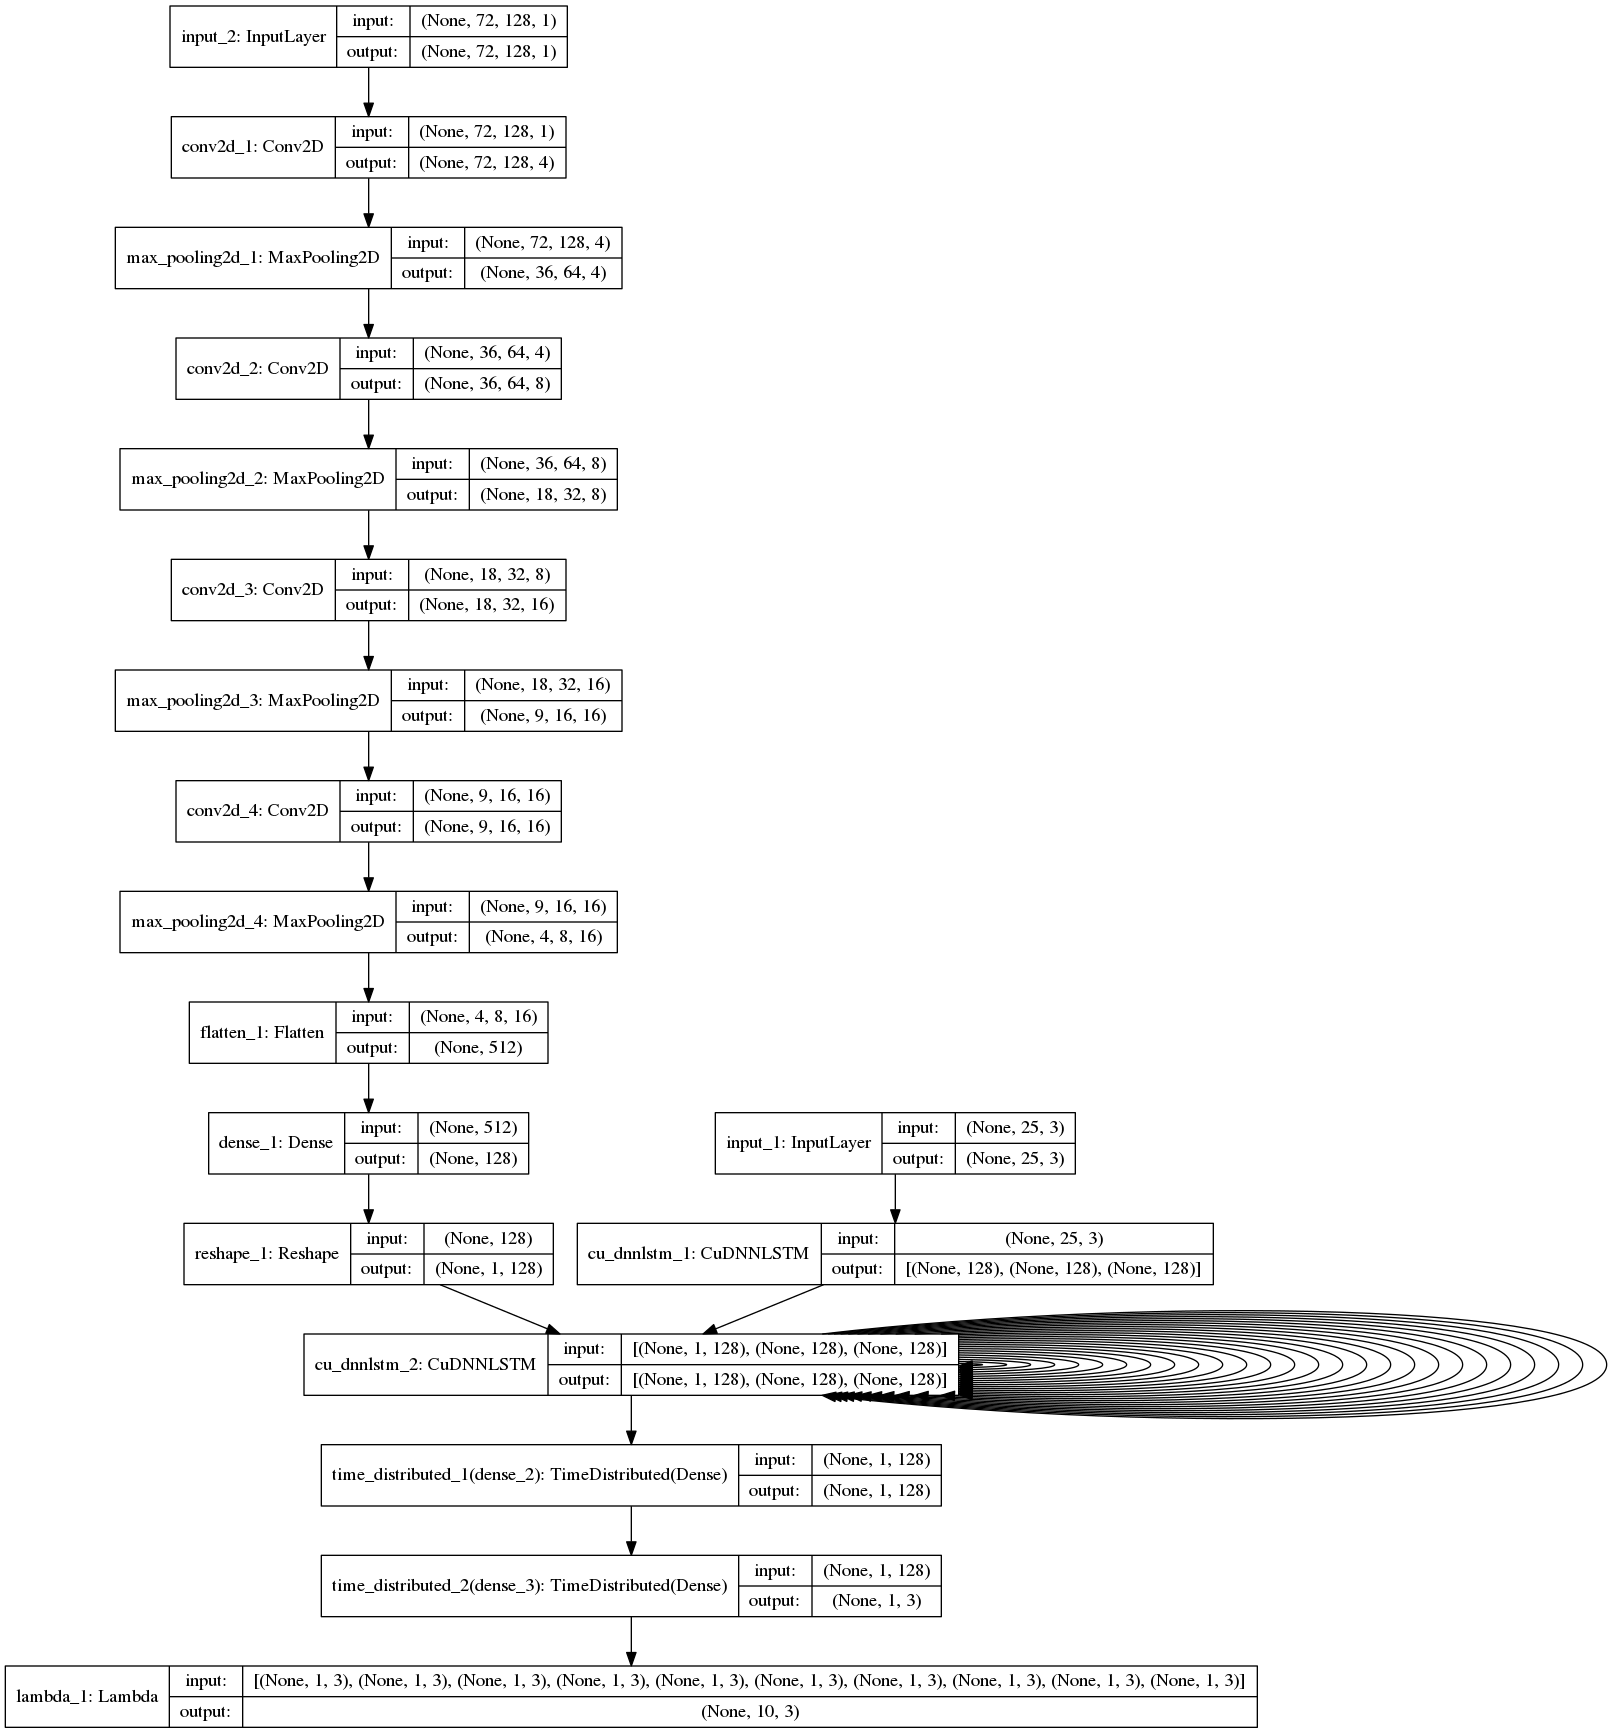

In [5]:
plot_model(model, to_file=experiment_name+'.png', show_shapes=True)

In [6]:
tensorboard_callback = TensorBoard(log_dir='./tensorboard_logs',
                                   histogram_freq=0,
                                   write_graph=True,
                                   write_grads=True,
                                   write_images=True,
                                   embeddings_freq=0,
                                   embeddings_layer_names=None,
                                   embeddings_metadata=None)

earlystopping_callback = EarlyStopping(monitor='val_loss',
                                       min_delta=0,
                                       patience=15,
                                       verbose=1,
                                       mode='auto')

modelcheckpoint_callback = ModelCheckpoint(filepath=experiment_name+'.hdf5',
                                           save_best_only=True,
                                           monitor='val_loss',
                                           mode='min')

In [7]:
saliency_dir = os.path.join(dir_path, "fov_images_train_h5_new", "saliency")
#videos = os.listdir(saliency_dir) 
#print(videos)

path_to_sensor_data_train = os.path.join(dir_path, "preprocessed_train")
videos = os.listdir(saliency_dir)
print(videos)
video_width = 3840

['013_13_times_square_static.h5', '002_01_art_gallery_static.h5', '002_02_theatre_scene_static.h5', '002_03_lions_static_cuts.h5', '002_04_copenhagen_harbour_static_cuts.h5', '002_07_factory_robots_static.h5', '002_09_elephants_static.h5', '002_12_gym_workout_static.h5', '002_13_times_square_static.h5', '002_14_new_orleans_drive_motion.h5', '002_16_interview_static.h5', '002_17_weather_forecast_static.h5', '002_18_bomb_trapped_static.h5', '002_20_car_fix_static.h5', '002_23_dog_food_factory_motion.h5', '003_01_art_gallery_static.h5', '003_02_theatre_scene_static.h5', '003_03_lions_static_cuts.h5', '003_04_copenhagen_harbour_static_cuts.h5', '003_05_florida_yacht_motion.h5', '003_07_factory_robots_static.h5', '003_08_madagascar_cuts.h5', '003_09_elephants_static.h5', '003_11_lohdi_garden_india_cuts.h5', '003_12_gym_workout_static.h5', '003_13_times_square_static.h5', '003_14_new_orleans_drive_motion.h5', '003_18_bomb_trapped_static.h5', '003_21_operation_room_static.h5', '003_23_dog_foo

In [8]:
use_generator = True
if use_generator:
    nb_epochs = 150
    start = time.time()
    
    perc_train = 0.8
    ind_max_train = int(np.round(len(videos) * perc_train))
    file_names_train = videos[:ind_max_train]
    file_names_val = videos[ind_max_train:]
    #data = np.load(os.path.join(path_to_sensor_data_train, file_name))

    train_gen = data_generator_head_sal_seq2seq_reinject_output(path_to_sensor_data_train,
                                    file_names_train,
                                    delays_list,
                                    n_max_delay,
                                    n_lookback,
                                    n_delay)
    val_gen = data_generator_head_sal_seq2seq_reinject_output(path_to_sensor_data_train,
                                  file_names_val,
                                  delays_list,
                                  n_max_delay,
                                  n_lookback,
                                  n_delay)

(72, 128, 1)


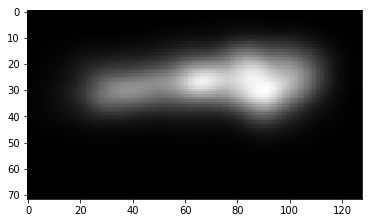

"\nfig=plt.figure(figsize=(18, 16), dpi= 80)\n\nplt.subplot(311)\nplt.plot(encoder_input[:,0,0], c='r')\nplt.grid(True)\n\nplt.subplot(312)\nplt.plot(encoder_input[:,0,1], c='g')\nplt.grid(True)\n\nplt.subplot(313)\nplt.plot(encoder_input[:,0,2], c='b')\nplt.grid(True)\n"

In [9]:
[encoder_input, decoder_input], Y_train = next(train_gen)
print(decoder_input[1000].shape)
plt.imshow(decoder_input[1000,:,:,0], cmap='gray', vmin=0, vmax=255)
plt.show()

'''
fig=plt.figure(figsize=(18, 16), dpi= 80)

plt.subplot(311)
plt.plot(encoder_input[:,0,0], c='r')
plt.grid(True)

plt.subplot(312)
plt.plot(encoder_input[:,0,1], c='g')
plt.grid(True)

plt.subplot(313)
plt.plot(encoder_input[:,0,2], c='b')
plt.grid(True)
'''

In [10]:
history = model.fit_generator(train_gen,
                    steps_per_epoch=ind_max_train,
                    epochs=nb_epochs,
                    callbacks=[
                               tensorboard_callback,
                               earlystopping_callback,
                               modelcheckpoint_callback],
                    verbose=1,
                    shuffle=True,
                    validation_data=val_gen,
                    validation_steps=(len(videos) - ind_max_train))
print("Time:", time.time() - start, "s = ",(time.time() - start)/60., "min")

print("Training Time : ", time.time() - start, "s = ", (time.time() - start)/60., "min = ",
      (time.time() - start)/3600., "h")

Epoch 1/150


  1/422 [..............................] - ETA: 28:29 - loss: 0.1291 - rmse: 0.1954

  2/422 [..............................] - ETA: 21:33 - loss: 0.1534 - rmse: 0.2633

  3/422 [..............................] - ETA: 19:49 - loss: 0.1332 - rmse: 0.2431

  4/422 [..............................] - ETA: 18:55 - loss: 0.1229 - rmse: 0.2231

  5/422 [..............................] - ETA: 18:32 - loss: 0.1142 - rmse: 0.2007

  6/422 [..............................] - ETA: 18:15 - loss: 0.1044 - rmse: 0.1802

  7/422 [..............................] - ETA: 18:02 - loss: 0.0989 - rmse: 0.1800

  8/422 [..............................] - ETA: 17:48 - loss: 0.0990 - rmse: 0.1797

  9/422 [..............................] - ETA: 17:10 - loss: 0.1034 - rmse: 0.1931

 10/422 [..............................] - ETA: 17:03 - loss: 0.1057 - rmse: 0.2026

 11/422 [..............................] - ETA: 16:57 - loss: 0.1056 - rmse: 0.2052

 12/422 [..............................] - ETA: 16:48 - loss: 0.1038 - rmse: 0.2071

 13/422 [..............................] - ETA: 16:46 - loss: 0.0999 - rmse: 0.1989

 14/422 [..............................] - ETA: 16:25 - loss: 0.0969 - rmse: 0.1959

 15/422 [>.............................] - ETA: 16:23 - loss: 0.0940 - rmse: 0.1910

 16/422 [>.............................] - ETA: 16:22 - loss: 0.0929 - rmse: 0.1908

 17/422 [>.............................] - ETA: 16:20 - loss: 0.0917 - rmse: 0.1896

 18/422 [>.............................] - ETA: 16:19 - loss: 0.0893 - rmse: 0.1876

 19/422 [>.............................] - ETA: 16:16 - loss: 0.0861 - rmse: 0.1818

 20/422 [>.............................] - ETA: 16:14 - loss: 0.0847 - rmse: 0.1813

 21/422 [>.............................] - ETA: 16:12 - loss: 0.0829 - rmse: 0.1770

 22/422 [>.............................] - ETA: 16:12 - loss: 0.0823 - rmse: 0.1770

 23/422 [>.............................] - ETA: 16:11 - loss: 0.0802 - rmse: 0.1723

 24/422 [>.............................] - ETA: 15:36 - loss: 0.0807 - rmse: 0.1734

 25/422 [>.............................] - ETA: 15:36 - loss: 0.0813 - rmse: 0.1752

 26/422 [>.............................] - ETA: 15:06 - loss: 0.0806 - rmse: 0.1759

 27/422 [>.............................] - ETA: 15:06 - loss: 0.0795 - rmse: 0.1729

 28/422 [>.............................] - ETA: 15:06 - loss: 0.0782 - rmse: 0.1712

 29/422 [=>............................] - ETA: 15:01 - loss: 0.0782 - rmse: 0.1716

 30/422 [=>............................] - ETA: 14:35 - loss: 0.0776 - rmse: 0.1737

 31/422 [=>............................] - ETA: 14:35 - loss: 0.0765 - rmse: 0.1718

 32/422 [=>............................] - ETA: 14:37 - loss: 0.0752 - rmse: 0.1691

 33/422 [=>............................] - ETA: 14:38 - loss: 0.0756 - rmse: 0.1715

 34/422 [=>............................] - ETA: 14:39 - loss: 0.0757 - rmse: 0.1721

 35/422 [=>............................] - ETA: 14:39 - loss: 0.0759 - rmse: 0.1731

 36/422 [=>............................] - ETA: 14:39 - loss: 0.0774 - rmse: 0.1768

 37/422 [=>............................] - ETA: 14:18 - loss: 0.0766 - rmse: 0.1757

 38/422 [=>............................] - ETA: 14:18 - loss: 0.0763 - rmse: 0.1754

 39/422 [=>............................] - ETA: 14:18 - loss: 0.0763 - rmse: 0.1771

 40/422 [=>............................] - ETA: 14:15 - loss: 0.0761 - rmse: 0.1762

 41/422 [=>............................] - ETA: 14:15 - loss: 0.0760 - rmse: 0.1763

 42/422 [=>............................] - ETA: 14:15 - loss: 0.0767 - rmse: 0.1775

 43/422 [==>...........................] - ETA: 14:15 - loss: 0.0754 - rmse: 0.1745

 44/422 [==>...........................] - ETA: 14:14 - loss: 0.0749 - rmse: 0.1737

 45/422 [==>...........................] - ETA: 14:13 - loss: 0.0751 - rmse: 0.1746

 46/422 [==>...........................] - ETA: 14:13 - loss: 0.0740 - rmse: 0.1721

 47/422 [==>...........................] - ETA: 14:13 - loss: 0.0743 - rmse: 0.1740

 48/422 [==>...........................] - ETA: 14:13 - loss: 0.0742 - rmse: 0.1743

 49/422 [==>...........................] - ETA: 14:12 - loss: 0.0740 - rmse: 0.1750

 50/422 [==>...........................] - ETA: 14:11 - loss: 0.0736 - rmse: 0.1739

 51/422 [==>...........................] - ETA: 14:10 - loss: 0.0727 - rmse: 0.1730

 52/422 [==>...........................] - ETA: 14:09 - loss: 0.0727 - rmse: 0.1729

 53/422 [==>...........................] - ETA: 13:54 - loss: 0.0729 - rmse: 0.1740

 54/422 [==>...........................] - ETA: 13:53 - loss: 0.0726 - rmse: 0.1736

 55/422 [==>...........................] - ETA: 13:39 - loss: 0.0730 - rmse: 0.1756

 56/422 [==>...........................] - ETA: 13:38 - loss: 0.0729 - rmse: 0.1754

 57/422 [===>..........................] - ETA: 13:25 - loss: 0.0727 - rmse: 0.1748

 58/422 [===>..........................] - ETA: 13:24 - loss: 0.0721 - rmse: 0.1735

 59/422 [===>..........................] - ETA: 13:24 - loss: 0.0717 - rmse: 0.1725

 60/422 [===>..........................] - ETA: 13:23 - loss: 0.0715 - rmse: 0.1725

 61/422 [===>..........................] - ETA: 13:23 - loss: 0.0712 - rmse: 0.1715

 62/422 [===>..........................] - ETA: 13:18 - loss: 0.0714 - rmse: 0.1720

 63/422 [===>..........................] - ETA: 13:06 - loss: 0.0715 - rmse: 0.1723

 64/422 [===>..........................] - ETA: 13:06 - loss: 0.0715 - rmse: 0.1723

 65/422 [===>..........................] - ETA: 13:03 - loss: 0.0711 - rmse: 0.1715

 66/422 [===>..........................] - ETA: 13:02 - loss: 0.0715 - rmse: 0.1727

 67/422 [===>..........................] - ETA: 13:01 - loss: 0.0716 - rmse: 0.1735

 68/422 [===>..........................] - ETA: 13:01 - loss: 0.0716 - rmse: 0.1732

 69/422 [===>..........................] - ETA: 12:50 - loss: 0.0712 - rmse: 0.1723

 70/422 [===>..........................] - ETA: 12:40 - loss: 0.0710 - rmse: 0.1720

 71/422 [====>.........................] - ETA: 12:29 - loss: 0.0712 - rmse: 0.1732

 72/422 [====>.........................] - ETA: 12:29 - loss: 0.0704 - rmse: 0.1711

 73/422 [====>.........................] - ETA: 12:28 - loss: 0.0702 - rmse: 0.1705

 74/422 [====>.........................] - ETA: 12:18 - loss: 0.0699 - rmse: 0.1696

 75/422 [====>.........................] - ETA: 12:18 - loss: 0.0697 - rmse: 0.1691

 76/422 [====>.........................] - ETA: 12:08 - loss: 0.0695 - rmse: 0.1694

 77/422 [====>.........................] - ETA: 11:59 - loss: 0.0690 - rmse: 0.1684

 78/422 [====>.........................] - ETA: 11:50 - loss: 0.0687 - rmse: 0.1675

 79/422 [====>.........................] - ETA: 11:41 - loss: 0.0687 - rmse: 0.1674

 80/422 [====>.........................] - ETA: 11:41 - loss: 0.0687 - rmse: 0.1679

 81/422 [====>.........................] - ETA: 11:41 - loss: 0.0689 - rmse: 0.1689

 82/422 [====>.........................] - ETA: 11:41 - loss: 0.0686 - rmse: 0.1683

 83/422 [====>.........................] - ETA: 11:40 - loss: 0.0682 - rmse: 0.1675

 84/422 [====>.........................] - ETA: 11:32 - loss: 0.0678 - rmse: 0.1664

 85/422 [=====>........................] - ETA: 11:24 - loss: 0.0680 - rmse: 0.1669

 86/422 [=====>........................] - ETA: 11:23 - loss: 0.0677 - rmse: 0.1659

 87/422 [=====>........................] - ETA: 11:15 - loss: 0.0676 - rmse: 0.1656

 88/422 [=====>........................] - ETA: 11:15 - loss: 0.0676 - rmse: 0.1656

 89/422 [=====>........................] - ETA: 11:14 - loss: 0.0673 - rmse: 0.1647

 90/422 [=====>........................] - ETA: 11:06 - loss: 0.0668 - rmse: 0.1634

 91/422 [=====>........................] - ETA: 11:06 - loss: 0.0669 - rmse: 0.1638

 92/422 [=====>........................] - ETA: 10:58 - loss: 0.0669 - rmse: 0.1638

 93/422 [=====>........................] - ETA: 10:51 - loss: 0.0669 - rmse: 0.1642

 94/422 [=====>........................] - ETA: 10:44 - loss: 0.0670 - rmse: 0.1650

 95/422 [=====>........................] - ETA: 10:41 - loss: 0.0666 - rmse: 0.1639

 96/422 [=====>........................] - ETA: 10:41 - loss: 0.0662 - rmse: 0.1637

 97/422 [=====>........................] - ETA: 10:39 - loss: 0.0664 - rmse: 0.1639

 98/422 [=====>........................] - ETA: 10:32 - loss: 0.0663 - rmse: 0.1639

 99/422 [======>.......................] - ETA: 10:32 - loss: 0.0661 - rmse: 0.1636

100/422 [======>.......................] - ETA: 10:32 - loss: 0.0661 - rmse: 0.1640

101/422 [======>.......................] - ETA: 10:31 - loss: 0.0662 - rmse: 0.1642

102/422 [======>.......................] - ETA: 10:31 - loss: 0.0660 - rmse: 0.1641

103/422 [======>.......................] - ETA: 10:31 - loss: 0.0666 - rmse: 0.1651

104/422 [======>.......................] - ETA: 10:30 - loss: 0.0667 - rmse: 0.1654

105/422 [======>.......................] - ETA: 10:24 - loss: 0.0673 - rmse: 0.1665

106/422 [======>.......................] - ETA: 10:17 - loss: 0.0669 - rmse: 0.1654

107/422 [======>.......................] - ETA: 10:17 - loss: 0.0666 - rmse: 0.1652

108/422 [======>.......................] - ETA: 10:16 - loss: 0.0662 - rmse: 0.1642

109/422 [======>.......................] - ETA: 10:16 - loss: 0.0662 - rmse: 0.1643

110/422 [======>.......................] - ETA: 10:16 - loss: 0.0661 - rmse: 0.1642

111/422 [======>.......................] - ETA: 10:15 - loss: 0.0663 - rmse: 0.1649

112/422 [======>.......................] - ETA: 10:09 - loss: 0.0663 - rmse: 0.1650

113/422 [=======>......................] - ETA: 10:09 - loss: 0.0662 - rmse: 0.1650

114/422 [=======>......................] - ETA: 10:03 - loss: 0.0661 - rmse: 0.1652

115/422 [=======>......................] - ETA: 10:02 - loss: 0.0658 - rmse: 0.1643

116/422 [=======>......................] - ETA: 10:02 - loss: 0.0657 - rmse: 0.1640

117/422 [=======>......................] - ETA: 10:01 - loss: 0.0655 - rmse: 0.1633

118/422 [=======>......................] - ETA: 9:55 - loss: 0.0655 - rmse: 0.1635 

119/422 [=======>......................] - ETA: 9:55 - loss: 0.0657 - rmse: 0.1642

120/422 [=======>......................] - ETA: 9:54 - loss: 0.0657 - rmse: 0.1642

121/422 [=======>......................] - ETA: 9:48 - loss: 0.0654 - rmse: 0.1637

122/422 [=======>......................] - ETA: 9:48 - loss: 0.0654 - rmse: 0.1636

123/422 [=======>......................] - ETA: 9:47 - loss: 0.0652 - rmse: 0.1634

124/422 [=======>......................] - ETA: 9:46 - loss: 0.0651 - rmse: 0.1637

125/422 [=======>......................] - ETA: 9:41 - loss: 0.0650 - rmse: 0.1633

126/422 [=======>......................] - ETA: 9:36 - loss: 0.0649 - rmse: 0.1633

127/422 [========>.....................] - ETA: 9:35 - loss: 0.0649 - rmse: 0.1631

128/422 [========>.....................] - ETA: 9:30 - loss: 0.0651 - rmse: 0.1635

129/422 [========>.....................] - ETA: 9:25 - loss: 0.0653 - rmse: 0.1641

130/422 [========>.....................] - ETA: 9:19 - loss: 0.0653 - rmse: 0.1641

131/422 [========>.....................] - ETA: 9:14 - loss: 0.0653 - rmse: 0.1640

132/422 [========>.....................] - ETA: 9:09 - loss: 0.0650 - rmse: 0.1634

133/422 [========>.....................] - ETA: 9:09 - loss: 0.0653 - rmse: 0.1643

134/422 [========>.....................] - ETA: 9:04 - loss: 0.0652 - rmse: 0.1640

135/422 [========>.....................] - ETA: 8:59 - loss: 0.0652 - rmse: 0.1641

136/422 [========>.....................] - ETA: 8:54 - loss: 0.0651 - rmse: 0.1641

137/422 [========>.....................] - ETA: 8:49 - loss: 0.0649 - rmse: 0.1634

138/422 [========>.....................] - ETA: 8:45 - loss: 0.0646 - rmse: 0.1629

139/422 [========>.....................] - ETA: 8:43 - loss: 0.0649 - rmse: 0.1635

140/422 [========>.....................] - ETA: 8:43 - loss: 0.0650 - rmse: 0.1638

141/422 [=========>....................] - ETA: 8:42 - loss: 0.0650 - rmse: 0.1641

142/422 [=========>....................] - ETA: 8:38 - loss: 0.0651 - rmse: 0.1644

143/422 [=========>....................] - ETA: 8:36 - loss: 0.0647 - rmse: 0.1634

144/422 [=========>....................] - ETA: 8:35 - loss: 0.0650 - rmse: 0.1643

145/422 [=========>....................] - ETA: 8:35 - loss: 0.0652 - rmse: 0.1652

146/422 [=========>....................] - ETA: 8:30 - loss: 0.0651 - rmse: 0.1648

147/422 [=========>....................] - ETA: 8:30 - loss: 0.0651 - rmse: 0.1650

148/422 [=========>....................] - ETA: 8:25 - loss: 0.0653 - rmse: 0.1656

149/422 [=========>....................] - ETA: 8:25 - loss: 0.0656 - rmse: 0.1666

150/422 [=========>....................] - ETA: 8:20 - loss: 0.0656 - rmse: 0.1666

151/422 [=========>....................] - ETA: 8:20 - loss: 0.0660 - rmse: 0.1679

152/422 [=========>....................] - ETA: 8:19 - loss: 0.0657 - rmse: 0.1672

153/422 [=========>....................] - ETA: 8:15 - loss: 0.0656 - rmse: 0.1670

154/422 [=========>....................] - ETA: 8:13 - loss: 0.0656 - rmse: 0.1673

155/422 [==========>...................] - ETA: 8:11 - loss: 0.0658 - rmse: 0.1678

156/422 [==========>...................] - ETA: 8:10 - loss: 0.0656 - rmse: 0.1674

157/422 [==========>...................] - ETA: 8:10 - loss: 0.0657 - rmse: 0.1681

158/422 [==========>...................] - ETA: 8:05 - loss: 0.0657 - rmse: 0.1681

159/422 [==========>...................] - ETA: 8:05 - loss: 0.0656 - rmse: 0.1677

160/422 [==========>...................] - ETA: 8:01 - loss: 0.0657 - rmse: 0.1683

161/422 [==========>...................] - ETA: 7:57 - loss: 0.0656 - rmse: 0.1682

162/422 [==========>...................] - ETA: 7:53 - loss: 0.0653 - rmse: 0.1674

163/422 [==========>...................] - ETA: 7:49 - loss: 0.0653 - rmse: 0.1673

164/422 [==========>...................] - ETA: 7:48 - loss: 0.0652 - rmse: 0.1672

165/422 [==========>...................] - ETA: 7:47 - loss: 0.0651 - rmse: 0.1669

166/422 [==========>...................] - ETA: 7:44 - loss: 0.0650 - rmse: 0.1666

167/422 [==========>...................] - ETA: 7:40 - loss: 0.0650 - rmse: 0.1664

168/422 [==========>...................] - ETA: 7:36 - loss: 0.0650 - rmse: 0.1667

169/422 [===========>..................] - ETA: 7:35 - loss: 0.0654 - rmse: 0.1676

170/422 [===========>..................] - ETA: 7:35 - loss: 0.0651 - rmse: 0.1669

171/422 [===========>..................] - ETA: 7:31 - loss: 0.0649 - rmse: 0.1663

172/422 [===========>..................] - ETA: 7:27 - loss: 0.0650 - rmse: 0.1665

173/422 [===========>..................] - ETA: 7:27 - loss: 0.0652 - rmse: 0.1671

174/422 [===========>..................] - ETA: 7:23 - loss: 0.0651 - rmse: 0.1667

175/422 [===========>..................] - ETA: 7:22 - loss: 0.0651 - rmse: 0.1667

176/422 [===========>..................] - ETA: 7:18 - loss: 0.0653 - rmse: 0.1670

177/422 [===========>..................] - ETA: 7:18 - loss: 0.0654 - rmse: 0.1672

178/422 [===========>..................] - ETA: 7:14 - loss: 0.0652 - rmse: 0.1669

179/422 [===========>..................] - ETA: 7:13 - loss: 0.0651 - rmse: 0.1667

180/422 [===========>..................] - ETA: 7:12 - loss: 0.0651 - rmse: 0.1667

181/422 [===========>..................] - ETA: 7:11 - loss: 0.0651 - rmse: 0.1668

182/422 [===========>..................] - ETA: 7:07 - loss: 0.0652 - rmse: 0.1674

183/422 [============>.................] - ETA: 7:04 - loss: 0.0655 - rmse: 0.1681

184/422 [============>.................] - ETA: 7:03 - loss: 0.0655 - rmse: 0.1681

185/422 [============>.................] - ETA: 6:59 - loss: 0.0654 - rmse: 0.1681

186/422 [============>.................] - ETA: 6:59 - loss: 0.0657 - rmse: 0.1687

187/422 [============>.................] - ETA: 6:55 - loss: 0.0657 - rmse: 0.1688

188/422 [============>.................] - ETA: 6:52 - loss: 0.0656 - rmse: 0.1687

189/422 [============>.................] - ETA: 6:51 - loss: 0.0658 - rmse: 0.1693

190/422 [============>.................] - ETA: 6:48 - loss: 0.0658 - rmse: 0.1693

191/422 [============>.................] - ETA: 6:44 - loss: 0.0658 - rmse: 0.1695

192/422 [============>.................] - ETA: 6:41 - loss: 0.0659 - rmse: 0.1699

193/422 [============>.................] - ETA: 6:38 - loss: 0.0658 - rmse: 0.1694

194/422 [============>.................] - ETA: 6:37 - loss: 0.0657 - rmse: 0.1693

195/422 [============>.................] - ETA: 6:35 - loss: 0.0656 - rmse: 0.1690

196/422 [============>.................] - ETA: 6:32 - loss: 0.0657 - rmse: 0.1692

197/422 [=============>................] - ETA: 6:29 - loss: 0.0659 - rmse: 0.1698

198/422 [=============>................] - ETA: 6:28 - loss: 0.0658 - rmse: 0.1697

199/422 [=============>................] - ETA: 6:25 - loss: 0.0658 - rmse: 0.1697

200/422 [=============>................] - ETA: 6:22 - loss: 0.0660 - rmse: 0.1701

201/422 [=============>................] - ETA: 6:21 - loss: 0.0659 - rmse: 0.1698

202/422 [=============>................] - ETA: 6:18 - loss: 0.0660 - rmse: 0.1700

203/422 [=============>................] - ETA: 6:17 - loss: 0.0662 - rmse: 0.1707

204/422 [=============>................] - ETA: 6:16 - loss: 0.0661 - rmse: 0.1702

205/422 [=============>................] - ETA: 6:15 - loss: 0.0659 - rmse: 0.1697

206/422 [=============>................] - ETA: 6:12 - loss: 0.0659 - rmse: 0.1699

207/422 [=============>................] - ETA: 6:09 - loss: 0.0660 - rmse: 0.1700

208/422 [=============>................] - ETA: 6:08 - loss: 0.0660 - rmse: 0.1699

209/422 [=============>................] - ETA: 6:07 - loss: 0.0658 - rmse: 0.1695

210/422 [=============>................] - ETA: 6:04 - loss: 0.0658 - rmse: 0.1693

211/422 [==============>...............] - ETA: 6:03 - loss: 0.0658 - rmse: 0.1693

212/422 [==============>...............] - ETA: 6:01 - loss: 0.0658 - rmse: 0.1693

213/422 [==============>...............] - ETA: 5:58 - loss: 0.0660 - rmse: 0.1697

214/422 [==============>...............] - ETA: 5:57 - loss: 0.0664 - rmse: 0.1707

215/422 [==============>...............] - ETA: 5:56 - loss: 0.0664 - rmse: 0.1709

216/422 [==============>...............] - ETA: 5:53 - loss: 0.0665 - rmse: 0.1711

217/422 [==============>...............] - ETA: 5:52 - loss: 0.0664 - rmse: 0.1711

218/422 [==============>...............] - ETA: 5:51 - loss: 0.0664 - rmse: 0.1711

219/422 [==============>...............] - ETA: 5:50 - loss: 0.0664 - rmse: 0.1712

220/422 [==============>...............] - ETA: 5:47 - loss: 0.0664 - rmse: 0.1710

221/422 [==============>...............] - ETA: 5:44 - loss: 0.0663 - rmse: 0.1708

222/422 [==============>...............] - ETA: 5:41 - loss: 0.0662 - rmse: 0.1706

223/422 [==============>...............] - ETA: 5:40 - loss: 0.0662 - rmse: 0.1706

224/422 [==============>...............] - ETA: 5:39 - loss: 0.0663 - rmse: 0.1707

225/422 [==============>...............] - ETA: 5:36 - loss: 0.0662 - rmse: 0.1704

226/422 [===============>..............] - ETA: 5:35 - loss: 0.0663 - rmse: 0.1706

227/422 [===============>..............] - ETA: 5:34 - loss: 0.0662 - rmse: 0.1707

228/422 [===============>..............] - ETA: 5:31 - loss: 0.0662 - rmse: 0.1708

229/422 [===============>..............] - ETA: 5:29 - loss: 0.0660 - rmse: 0.1704

230/422 [===============>..............] - ETA: 5:27 - loss: 0.0660 - rmse: 0.1703

231/422 [===============>..............] - ETA: 5:26 - loss: 0.0661 - rmse: 0.1708

232/422 [===============>..............] - ETA: 5:25 - loss: 0.0661 - rmse: 0.1708

233/422 [===============>..............] - ETA: 5:23 - loss: 0.0662 - rmse: 0.1710

234/422 [===============>..............] - ETA: 5:22 - loss: 0.0662 - rmse: 0.1711

235/422 [===============>..............] - ETA: 5:20 - loss: 0.0661 - rmse: 0.1709

236/422 [===============>..............] - ETA: 5:18 - loss: 0.0661 - rmse: 0.1708

237/422 [===============>..............] - ETA: 5:17 - loss: 0.0660 - rmse: 0.1709

238/422 [===============>..............] - ETA: 5:14 - loss: 0.0659 - rmse: 0.1708

239/422 [===============>..............] - ETA: 5:11 - loss: 0.0660 - rmse: 0.1709

240/422 [================>.............] - ETA: 5:09 - loss: 0.0659 - rmse: 0.1707

241/422 [================>.............] - ETA: 5:06 - loss: 0.0657 - rmse: 0.1703

242/422 [================>.............] - ETA: 5:05 - loss: 0.0655 - rmse: 0.1700

243/422 [================>.............] - ETA: 5:04 - loss: 0.0655 - rmse: 0.1700

244/422 [================>.............] - ETA: 5:01 - loss: 0.0655 - rmse: 0.1700

245/422 [================>.............] - ETA: 4:59 - loss: 0.0653 - rmse: 0.1695

246/422 [================>.............] - ETA: 4:58 - loss: 0.0653 - rmse: 0.1693

247/422 [================>.............] - ETA: 4:56 - loss: 0.0655 - rmse: 0.1699

248/422 [================>.............] - ETA: 4:55 - loss: 0.0656 - rmse: 0.1703

249/422 [================>.............] - ETA: 4:53 - loss: 0.0655 - rmse: 0.1701

250/422 [================>.............] - ETA: 4:52 - loss: 0.0655 - rmse: 0.1702

251/422 [================>.............] - ETA: 4:50 - loss: 0.0654 - rmse: 0.1700

252/422 [================>.............] - ETA: 4:48 - loss: 0.0655 - rmse: 0.1703

253/422 [================>.............] - ETA: 4:45 - loss: 0.0656 - rmse: 0.1703

254/422 [=================>............] - ETA: 4:44 - loss: 0.0655 - rmse: 0.1702

255/422 [=================>............] - ETA: 4:43 - loss: 0.0655 - rmse: 0.1703

256/422 [=================>............] - ETA: 4:41 - loss: 0.0655 - rmse: 0.1700

257/422 [=================>............] - ETA: 4:39 - loss: 0.0654 - rmse: 0.1697

258/422 [=================>............] - ETA: 4:38 - loss: 0.0652 - rmse: 0.1694

259/422 [=================>............] - ETA: 4:37 - loss: 0.0651 - rmse: 0.1693

260/422 [=================>............] - ETA: 4:36 - loss: 0.0650 - rmse: 0.1689

261/422 [=================>............] - ETA: 4:33 - loss: 0.0649 - rmse: 0.1687

262/422 [=================>............] - ETA: 4:31 - loss: 0.0649 - rmse: 0.1688

263/422 [=================>............] - ETA: 4:30 - loss: 0.0649 - rmse: 0.1689

264/422 [=================>............] - ETA: 4:28 - loss: 0.0651 - rmse: 0.1695

265/422 [=================>............] - ETA: 4:27 - loss: 0.0649 - rmse: 0.1689

266/422 [=================>............] - ETA: 4:25 - loss: 0.0649 - rmse: 0.1688

267/422 [=================>............] - ETA: 4:23 - loss: 0.0647 - rmse: 0.1684

268/422 [==================>...........] - ETA: 4:21 - loss: 0.0648 - rmse: 0.1685

269/422 [==================>...........] - ETA: 4:19 - loss: 0.0648 - rmse: 0.1685

270/422 [==================>...........] - ETA: 4:17 - loss: 0.0648 - rmse: 0.1686

271/422 [==================>...........] - ETA: 4:15 - loss: 0.0647 - rmse: 0.1685

272/422 [==================>...........] - ETA: 4:12 - loss: 0.0648 - rmse: 0.1687

273/422 [==================>...........] - ETA: 4:10 - loss: 0.0648 - rmse: 0.1688

274/422 [==================>...........] - ETA: 4:09 - loss: 0.0648 - rmse: 0.1687

275/422 [==================>...........] - ETA: 4:08 - loss: 0.0647 - rmse: 0.1688

276/422 [==================>...........] - ETA: 4:06 - loss: 0.0649 - rmse: 0.1693

277/422 [==================>...........] - ETA: 4:04 - loss: 0.0651 - rmse: 0.1697

278/422 [==================>...........] - ETA: 4:01 - loss: 0.0650 - rmse: 0.1696

279/422 [==================>...........] - ETA: 3:59 - loss: 0.0651 - rmse: 0.1700

280/422 [==================>...........] - ETA: 3:57 - loss: 0.0650 - rmse: 0.1698

281/422 [==================>...........] - ETA: 3:56 - loss: 0.0649 - rmse: 0.1695

282/422 [===================>..........] - ETA: 3:53 - loss: 0.0649 - rmse: 0.1695

283/422 [===================>..........] - ETA: 3:52 - loss: 0.0650 - rmse: 0.1697

284/422 [===================>..........] - ETA: 3:50 - loss: 0.0649 - rmse: 0.1698

285/422 [===================>..........] - ETA: 3:49 - loss: 0.0649 - rmse: 0.1699

286/422 [===================>..........] - ETA: 3:46 - loss: 0.0648 - rmse: 0.1696

287/422 [===================>..........] - ETA: 3:44 - loss: 0.0647 - rmse: 0.1694

288/422 [===================>..........] - ETA: 3:42 - loss: 0.0646 - rmse: 0.1691

289/422 [===================>..........] - ETA: 3:41 - loss: 0.0645 - rmse: 0.1687

290/422 [===================>..........] - ETA: 3:39 - loss: 0.0645 - rmse: 0.1687

291/422 [===================>..........] - ETA: 3:37 - loss: 0.0646 - rmse: 0.1690

292/422 [===================>..........] - ETA: 3:36 - loss: 0.0646 - rmse: 0.1687

293/422 [===================>..........] - ETA: 3:34 - loss: 0.0645 - rmse: 0.1685

294/422 [===================>..........] - ETA: 3:33 - loss: 0.0643 - rmse: 0.1681

295/422 [===================>..........] - ETA: 3:31 - loss: 0.0643 - rmse: 0.1680

296/422 [====================>.........] - ETA: 3:29 - loss: 0.0644 - rmse: 0.1683

297/422 [====================>.........] - ETA: 3:28 - loss: 0.0644 - rmse: 0.1684

298/422 [====================>.........] - ETA: 3:26 - loss: 0.0645 - rmse: 0.1689

299/422 [====================>.........] - ETA: 3:25 - loss: 0.0644 - rmse: 0.1687

300/422 [====================>.........] - ETA: 3:23 - loss: 0.0643 - rmse: 0.1687

301/422 [====================>.........] - ETA: 3:21 - loss: 0.0643 - rmse: 0.1690

302/422 [====================>.........] - ETA: 3:20 - loss: 0.0643 - rmse: 0.1690

303/422 [====================>.........] - ETA: 3:17 - loss: 0.0643 - rmse: 0.1691

304/422 [====================>.........] - ETA: 3:15 - loss: 0.0643 - rmse: 0.1692

305/422 [====================>.........] - ETA: 3:13 - loss: 0.0644 - rmse: 0.1693

306/422 [====================>.........] - ETA: 3:11 - loss: 0.0644 - rmse: 0.1694

307/422 [====================>.........] - ETA: 3:10 - loss: 0.0643 - rmse: 0.1692

308/422 [====================>.........] - ETA: 3:08 - loss: 0.0644 - rmse: 0.1695

309/422 [====================>.........] - ETA: 3:06 - loss: 0.0644 - rmse: 0.1695

310/422 [=====================>........] - ETA: 3:05 - loss: 0.0644 - rmse: 0.1695

311/422 [=====================>........] - ETA: 3:03 - loss: 0.0645 - rmse: 0.1697

312/422 [=====================>........] - ETA: 3:01 - loss: 0.0644 - rmse: 0.1695

313/422 [=====================>........] - ETA: 2:59 - loss: 0.0642 - rmse: 0.1693

314/422 [=====================>........] - ETA: 2:57 - loss: 0.0643 - rmse: 0.1694

315/422 [=====================>........] - ETA: 2:56 - loss: 0.0641 - rmse: 0.1690

316/422 [=====================>........] - ETA: 2:54 - loss: 0.0641 - rmse: 0.1690

317/422 [=====================>........] - ETA: 2:52 - loss: 0.0641 - rmse: 0.1690

318/422 [=====================>........] - ETA: 2:50 - loss: 0.0641 - rmse: 0.1692

319/422 [=====================>........] - ETA: 2:49 - loss: 0.0640 - rmse: 0.1690

320/422 [=====================>........] - ETA: 2:47 - loss: 0.0641 - rmse: 0.1691

321/422 [=====================>........] - ETA: 2:45 - loss: 0.0641 - rmse: 0.1692

322/422 [=====================>........] - ETA: 2:43 - loss: 0.0641 - rmse: 0.1692

323/422 [=====================>........] - ETA: 2:41 - loss: 0.0642 - rmse: 0.1694

324/422 [======================>.......] - ETA: 2:40 - loss: 0.0641 - rmse: 0.1695

325/422 [======================>.......] - ETA: 2:38 - loss: 0.0641 - rmse: 0.1694

326/422 [======================>.......] - ETA: 2:36 - loss: 0.0641 - rmse: 0.1693

327/422 [======================>.......] - ETA: 2:34 - loss: 0.0642 - rmse: 0.1696

328/422 [======================>.......] - ETA: 2:32 - loss: 0.0640 - rmse: 0.1693

329/422 [======================>.......] - ETA: 2:31 - loss: 0.0641 - rmse: 0.1694

330/422 [======================>.......] - ETA: 2:29 - loss: 0.0640 - rmse: 0.1692

331/422 [======================>.......] - ETA: 2:27 - loss: 0.0639 - rmse: 0.1689

332/422 [======================>.......] - ETA: 2:25 - loss: 0.0641 - rmse: 0.1692

333/422 [======================>.......] - ETA: 2:23 - loss: 0.0640 - rmse: 0.1690

334/422 [======================>.......] - ETA: 2:22 - loss: 0.0639 - rmse: 0.1690

335/422 [======================>.......] - ETA: 2:20 - loss: 0.0639 - rmse: 0.1690

336/422 [======================>.......] - ETA: 2:18 - loss: 0.0639 - rmse: 0.1692

337/422 [======================>.......] - ETA: 2:16 - loss: 0.0639 - rmse: 0.1690

338/422 [=======================>......] - ETA: 2:14 - loss: 0.0638 - rmse: 0.1689

339/422 [=======================>......] - ETA: 2:12 - loss: 0.0639 - rmse: 0.1690

340/422 [=======================>......] - ETA: 2:10 - loss: 0.0637 - rmse: 0.1686

341/422 [=======================>......] - ETA: 2:09 - loss: 0.0639 - rmse: 0.1690

342/422 [=======================>......] - ETA: 2:08 - loss: 0.0639 - rmse: 0.1692

343/422 [=======================>......] - ETA: 2:06 - loss: 0.0638 - rmse: 0.1689

344/422 [=======================>......] - ETA: 2:04 - loss: 0.0639 - rmse: 0.1689

345/422 [=======================>......] - ETA: 2:02 - loss: 0.0638 - rmse: 0.1688

346/422 [=======================>......] - ETA: 2:01 - loss: 0.0638 - rmse: 0.1688

347/422 [=======================>......] - ETA: 1:59 - loss: 0.0638 - rmse: 0.1688

348/422 [=======================>......] - ETA: 1:57 - loss: 0.0637 - rmse: 0.1686

349/422 [=======================>......] - ETA: 1:55 - loss: 0.0636 - rmse: 0.1682

350/422 [=======================>......] - ETA: 1:54 - loss: 0.0636 - rmse: 0.1682

351/422 [=======================>......] - ETA: 1:52 - loss: 0.0635 - rmse: 0.1679

352/422 [========================>.....] - ETA: 1:50 - loss: 0.0635 - rmse: 0.1680

353/422 [========================>.....] - ETA: 1:49 - loss: 0.0635 - rmse: 0.1679

354/422 [========================>.....] - ETA: 1:47 - loss: 0.0635 - rmse: 0.1679

355/422 [========================>.....] - ETA: 1:45 - loss: 0.0634 - rmse: 0.1676

356/422 [========================>.....] - ETA: 1:43 - loss: 0.0634 - rmse: 0.1677

357/422 [========================>.....] - ETA: 1:42 - loss: 0.0634 - rmse: 0.1677

358/422 [========================>.....] - ETA: 1:40 - loss: 0.0634 - rmse: 0.1678

359/422 [========================>.....] - ETA: 1:39 - loss: 0.0635 - rmse: 0.1680

360/422 [========================>.....] - ETA: 1:37 - loss: 0.0634 - rmse: 0.1680

361/422 [========================>.....] - ETA: 1:36 - loss: 0.0634 - rmse: 0.1678

362/422 [========================>.....] - ETA: 1:34 - loss: 0.0634 - rmse: 0.1679

363/422 [========================>.....] - ETA: 1:33 - loss: 0.0634 - rmse: 0.1678

364/422 [========================>.....] - ETA: 1:31 - loss: 0.0636 - rmse: 0.1683

365/422 [========================>.....] - ETA: 1:29 - loss: 0.0636 - rmse: 0.1682

366/422 [=========================>....] - ETA: 1:28 - loss: 0.0636 - rmse: 0.1680

367/422 [=========================>....] - ETA: 1:26 - loss: 0.0635 - rmse: 0.1680

368/422 [=========================>....] - ETA: 1:25 - loss: 0.0635 - rmse: 0.1678

369/422 [=========================>....] - ETA: 1:23 - loss: 0.0634 - rmse: 0.1677

370/422 [=========================>....] - ETA: 1:22 - loss: 0.0633 - rmse: 0.1673

371/422 [=========================>....] - ETA: 1:20 - loss: 0.0633 - rmse: 0.1673

372/422 [=========================>....] - ETA: 1:18 - loss: 0.0633 - rmse: 0.1672

373/422 [=========================>....] - ETA: 1:17 - loss: 0.0633 - rmse: 0.1673

374/422 [=========================>....] - ETA: 1:15 - loss: 0.0633 - rmse: 0.1673

375/422 [=========================>....] - ETA: 1:14 - loss: 0.0632 - rmse: 0.1670

376/422 [=========================>....] - ETA: 1:12 - loss: 0.0632 - rmse: 0.1669

377/422 [=========================>....] - ETA: 1:10 - loss: 0.0632 - rmse: 0.1669

378/422 [=========================>....] - ETA: 1:08 - loss: 0.0632 - rmse: 0.1669

379/422 [=========================>....] - ETA: 1:07 - loss: 0.0632 - rmse: 0.1670

380/422 [==========================>...] - ETA: 1:05 - loss: 0.0633 - rmse: 0.1672

381/422 [==========================>...] - ETA: 1:04 - loss: 0.0632 - rmse: 0.1671

382/422 [==========================>...] - ETA: 1:02 - loss: 0.0632 - rmse: 0.1671

383/422 [==========================>...] - ETA: 1:01 - loss: 0.0631 - rmse: 0.1668

384/422 [==========================>...] - ETA: 59s - loss: 0.0631 - rmse: 0.1667 

385/422 [==========================>...] - ETA: 57s - loss: 0.0632 - rmse: 0.1669

386/422 [==========================>...] - ETA: 56s - loss: 0.0632 - rmse: 0.1668

387/422 [==========================>...] - ETA: 54s - loss: 0.0631 - rmse: 0.1667

388/422 [==========================>...] - ETA: 52s - loss: 0.0632 - rmse: 0.1667

389/422 [==========================>...] - ETA: 51s - loss: 0.0631 - rmse: 0.1666

390/422 [==========================>...] - ETA: 49s - loss: 0.0631 - rmse: 0.1666

391/422 [==========================>...] - ETA: 48s - loss: 0.0631 - rmse: 0.1665

392/422 [==========================>...] - ETA: 46s - loss: 0.0631 - rmse: 0.1665

393/422 [==========================>...] - ETA: 44s - loss: 0.0631 - rmse: 0.1665

394/422 [===========================>..] - ETA: 43s - loss: 0.0632 - rmse: 0.1667

395/422 [===========================>..] - ETA: 41s - loss: 0.0632 - rmse: 0.1667

396/422 [===========================>..] - ETA: 40s - loss: 0.0632 - rmse: 0.1668

397/422 [===========================>..] - ETA: 38s - loss: 0.0632 - rmse: 0.1667

398/422 [===========================>..] - ETA: 37s - loss: 0.0631 - rmse: 0.1668

399/422 [===========================>..] - ETA: 35s - loss: 0.0632 - rmse: 0.1670

400/422 [===========================>..] - ETA: 33s - loss: 0.0632 - rmse: 0.1671

401/422 [===========================>..] - ETA: 32s - loss: 0.0632 - rmse: 0.1670

402/422 [===========================>..] - ETA: 30s - loss: 0.0632 - rmse: 0.1669

403/422 [===========================>..] - ETA: 29s - loss: 0.0631 - rmse: 0.1668

404/422 [===========================>..] - ETA: 27s - loss: 0.0632 - rmse: 0.1668

405/422 [===========================>..] - ETA: 26s - loss: 0.0631 - rmse: 0.1668

406/422 [===========================>..] - ETA: 24s - loss: 0.0631 - rmse: 0.1668

407/422 [===========================>..] - ETA: 22s - loss: 0.0633 - rmse: 0.1674

408/422 [============================>.] - ETA: 21s - loss: 0.0634 - rmse: 0.1676

409/422 [============================>.] - ETA: 19s - loss: 0.0633 - rmse: 0.1674

410/422 [============================>.] - ETA: 18s - loss: 0.0633 - rmse: 0.1674

411/422 [============================>.] - ETA: 16s - loss: 0.0633 - rmse: 0.1673

412/422 [============================>.] - ETA: 15s - loss: 0.0633 - rmse: 0.1673

413/422 [============================>.] - ETA: 13s - loss: 0.0632 - rmse: 0.1672

414/422 [============================>.] - ETA: 12s - loss: 0.0633 - rmse: 0.1674

415/422 [============================>.] - ETA: 10s - loss: 0.0632 - rmse: 0.1672

416/422 [============================>.] - ETA: 9s - loss: 0.0632 - rmse: 0.1672 

417/422 [============================>.] - ETA: 7s - loss: 0.0633 - rmse: 0.1677

418/422 [============================>.] - ETA: 6s - loss: 0.0634 - rmse: 0.1677

419/422 [============================>.] - ETA: 4s - loss: 0.0634 - rmse: 0.1679

420/422 [============================>.] - ETA: 3s - loss: 0.0633 - rmse: 0.1675

421/422 [============================>.] - ETA: 1s - loss: 0.0634 - rmse: 0.1678

422/422 [==============================] - 687s 2s/step - loss: 0.0633 - rmse: 0.1676 - val_loss: 0.0622 - val_rmse: 0.1754


/usr/local/lib/python3.5/dist-packages/Keras-2.2.4-py3.5.egg/keras/engine/network.py:883: UserWarning: Layer cu_dnnlstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'cu_dnnlstm_1/strided_slice_16:0' shape=(?, 128) dtype=float32>, <tf.Tensor 'cu_dnnlstm_1/strided_slice_17:0' shape=(?, 128) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '
/usr/local/lib/python3.5/dist-packages/Keras-2.2.4-py3.5.egg/keras/engine/network.py:883: UserWarning: Layer cu_dnnlstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'cu_dnnlstm_2/strided_slice_16:0' shape=(?, 128) dtype=float32>, <tf.Tensor 'cu_dnnlstm_2/strided_slice_17:0' shape=(?, 128) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '
/usr/local/lib/python3.5/dist-packages/Keras-2

Epoch 2/150


  1/422 [..............................] - ETA: 3:26 - loss: 0.1093 - rmse: 0.2930

  2/422 [..............................] - ETA: 3:28 - loss: 0.0897 - rmse: 0.2523

  3/422 [..............................] - ETA: 3:29 - loss: 0.0802 - rmse: 0.2325

  4/422 [..............................] - ETA: 3:29 - loss: 0.0735 - rmse: 0.2100

  5/422 [..............................] - ETA: 3:29 - loss: 0.0703 - rmse: 0.2005

  6/422 [..............................] - ETA: 3:29 - loss: 0.0665 - rmse: 0.1849

  7/422 [..............................] - ETA: 3:28 - loss: 0.0651 - rmse: 0.1780

  8/422 [..............................] - ETA: 3:27 - loss: 0.0609 - rmse: 0.1672

  9/422 [..............................] - ETA: 3:27 - loss: 0.0597 - rmse: 0.1640

 10/422 [..............................] - ETA: 3:26 - loss: 0.0602 - rmse: 0.1654

 11/422 [..............................] - ETA: 3:26 - loss: 0.0615 - rmse: 0.1679

 12/422 [..............................] - ETA: 3:25 - loss: 0.0601 - rmse: 0.1633

 13/422 [..............................] - ETA: 3:24 - loss: 0.0585 - rmse: 0.1587

 14/422 [..............................] - ETA: 3:24 - loss: 0.0585 - rmse: 0.1588

 15/422 [>.............................] - ETA: 3:23 - loss: 0.0589 - rmse: 0.1603

 16/422 [>.............................] - ETA: 3:23 - loss: 0.0597 - rmse: 0.1629

 17/422 [>.............................] - ETA: 3:22 - loss: 0.0606 - rmse: 0.1646

 18/422 [>.............................] - ETA: 3:22 - loss: 0.0614 - rmse: 0.1669

 19/422 [>.............................] - ETA: 3:20 - loss: 0.0620 - rmse: 0.1679

 20/422 [>.............................] - ETA: 3:20 - loss: 0.0611 - rmse: 0.1640

 21/422 [>.............................] - ETA: 3:19 - loss: 0.0591 - rmse: 0.1582

 22/422 [>.............................] - ETA: 3:19 - loss: 0.0583 - rmse: 0.1570

 23/422 [>.............................] - ETA: 3:17 - loss: 0.0598 - rmse: 0.1603

 24/422 [>.............................] - ETA: 3:17 - loss: 0.0587 - rmse: 0.1565

 25/422 [>.............................] - ETA: 3:17 - loss: 0.0575 - rmse: 0.1534

 26/422 [>.............................] - ETA: 3:14 - loss: 0.0571 - rmse: 0.1531

 27/422 [>.............................] - ETA: 3:14 - loss: 0.0570 - rmse: 0.1532

 28/422 [>.............................] - ETA: 3:14 - loss: 0.0564 - rmse: 0.1539

 29/422 [=>............................] - ETA: 3:13 - loss: 0.0553 - rmse: 0.1507

 30/422 [=>............................] - ETA: 3:12 - loss: 0.0555 - rmse: 0.1507

 31/422 [=>............................] - ETA: 3:12 - loss: 0.0565 - rmse: 0.1545

 32/422 [=>............................] - ETA: 3:12 - loss: 0.0568 - rmse: 0.1550

 33/422 [=>............................] - ETA: 3:11 - loss: 0.0569 - rmse: 0.1560

 34/422 [=>............................] - ETA: 3:11 - loss: 0.0566 - rmse: 0.1557

 35/422 [=>............................] - ETA: 3:11 - loss: 0.0559 - rmse: 0.1539

 36/422 [=>............................] - ETA: 3:10 - loss: 0.0554 - rmse: 0.1527

 37/422 [=>............................] - ETA: 3:10 - loss: 0.0553 - rmse: 0.1531

 38/422 [=>............................] - ETA: 3:09 - loss: 0.0551 - rmse: 0.1529

 39/422 [=>............................] - ETA: 3:09 - loss: 0.0561 - rmse: 0.1549

 40/422 [=>............................] - ETA: 3:08 - loss: 0.0555 - rmse: 0.1530

 41/422 [=>............................] - ETA: 3:08 - loss: 0.0551 - rmse: 0.1525

 42/422 [=>............................] - ETA: 3:07 - loss: 0.0552 - rmse: 0.1521

 43/422 [==>...........................] - ETA: 3:07 - loss: 0.0556 - rmse: 0.1526

 44/422 [==>...........................] - ETA: 3:07 - loss: 0.0567 - rmse: 0.1559

 45/422 [==>...........................] - ETA: 3:06 - loss: 0.0559 - rmse: 0.1536

 46/422 [==>...........................] - ETA: 3:06 - loss: 0.0564 - rmse: 0.1548

 47/422 [==>...........................] - ETA: 3:05 - loss: 0.0563 - rmse: 0.1541

 48/422 [==>...........................] - ETA: 3:05 - loss: 0.0558 - rmse: 0.1527

 49/422 [==>...........................] - ETA: 3:05 - loss: 0.0554 - rmse: 0.1513

 50/422 [==>...........................] - ETA: 3:04 - loss: 0.0559 - rmse: 0.1524

 51/422 [==>...........................] - ETA: 3:04 - loss: 0.0556 - rmse: 0.1515

 52/422 [==>...........................] - ETA: 3:03 - loss: 0.0547 - rmse: 0.1490

 53/422 [==>...........................] - ETA: 3:03 - loss: 0.0566 - rmse: 0.1530

 54/422 [==>...........................] - ETA: 3:02 - loss: 0.0570 - rmse: 0.1542

 55/422 [==>...........................] - ETA: 3:02 - loss: 0.0564 - rmse: 0.1526

 56/422 [==>...........................] - ETA: 3:01 - loss: 0.0566 - rmse: 0.1533

 57/422 [===>..........................] - ETA: 3:01 - loss: 0.0570 - rmse: 0.1541

 58/422 [===>..........................] - ETA: 3:00 - loss: 0.0569 - rmse: 0.1542

 59/422 [===>..........................] - ETA: 3:00 - loss: 0.0572 - rmse: 0.1552

 60/422 [===>..........................] - ETA: 3:00 - loss: 0.0576 - rmse: 0.1564

 61/422 [===>..........................] - ETA: 2:59 - loss: 0.0582 - rmse: 0.1583

 62/422 [===>..........................] - ETA: 2:59 - loss: 0.0584 - rmse: 0.1586

 63/422 [===>..........................] - ETA: 2:58 - loss: 0.0579 - rmse: 0.1572

 64/422 [===>..........................] - ETA: 2:58 - loss: 0.0579 - rmse: 0.1577

 65/422 [===>..........................] - ETA: 2:57 - loss: 0.0572 - rmse: 0.1557

 66/422 [===>..........................] - ETA: 2:57 - loss: 0.0568 - rmse: 0.1547

 67/422 [===>..........................] - ETA: 2:56 - loss: 0.0565 - rmse: 0.1545

 68/422 [===>..........................] - ETA: 2:56 - loss: 0.0564 - rmse: 0.1549

 69/422 [===>..........................] - ETA: 2:55 - loss: 0.0562 - rmse: 0.1544

 70/422 [===>..........................] - ETA: 2:54 - loss: 0.0564 - rmse: 0.1549

 71/422 [====>.........................] - ETA: 2:54 - loss: 0.0567 - rmse: 0.1555

 72/422 [====>.........................] - ETA: 2:53 - loss: 0.0571 - rmse: 0.1564

 73/422 [====>.........................] - ETA: 2:53 - loss: 0.0572 - rmse: 0.1569

 74/422 [====>.........................] - ETA: 2:52 - loss: 0.0573 - rmse: 0.1571

 75/422 [====>.........................] - ETA: 2:51 - loss: 0.0571 - rmse: 0.1568

 76/422 [====>.........................] - ETA: 2:51 - loss: 0.0574 - rmse: 0.1573

 77/422 [====>.........................] - ETA: 2:50 - loss: 0.0574 - rmse: 0.1570

 78/422 [====>.........................] - ETA: 2:49 - loss: 0.0577 - rmse: 0.1572

 79/422 [====>.........................] - ETA: 2:48 - loss: 0.0575 - rmse: 0.1566

 80/422 [====>.........................] - ETA: 2:48 - loss: 0.0582 - rmse: 0.1583

 81/422 [====>.........................] - ETA: 2:47 - loss: 0.0581 - rmse: 0.1578

 82/422 [====>.........................] - ETA: 2:47 - loss: 0.0584 - rmse: 0.1586

 83/422 [====>.........................] - ETA: 2:46 - loss: 0.0591 - rmse: 0.1605

 84/422 [====>.........................] - ETA: 2:45 - loss: 0.0593 - rmse: 0.1611

 85/422 [=====>........................] - ETA: 2:45 - loss: 0.0597 - rmse: 0.1622

 86/422 [=====>........................] - ETA: 2:44 - loss: 0.0604 - rmse: 0.1643

 87/422 [=====>........................] - ETA: 2:44 - loss: 0.0604 - rmse: 0.1647

 88/422 [=====>........................] - ETA: 2:43 - loss: 0.0607 - rmse: 0.1654

 89/422 [=====>........................] - ETA: 2:42 - loss: 0.0606 - rmse: 0.1656

 90/422 [=====>........................] - ETA: 2:42 - loss: 0.0601 - rmse: 0.1642

 91/422 [=====>........................] - ETA: 2:41 - loss: 0.0596 - rmse: 0.1629

 92/422 [=====>........................] - ETA: 2:41 - loss: 0.0600 - rmse: 0.1638

 93/422 [=====>........................] - ETA: 2:40 - loss: 0.0600 - rmse: 0.1636

 94/422 [=====>........................] - ETA: 2:39 - loss: 0.0601 - rmse: 0.1637

 95/422 [=====>........................] - ETA: 2:39 - loss: 0.0601 - rmse: 0.1636

 96/422 [=====>........................] - ETA: 2:39 - loss: 0.0599 - rmse: 0.1629

 97/422 [=====>........................] - ETA: 2:38 - loss: 0.0604 - rmse: 0.1640

 98/422 [=====>........................] - ETA: 2:38 - loss: 0.0604 - rmse: 0.1640

 99/422 [======>.......................] - ETA: 2:37 - loss: 0.0602 - rmse: 0.1636

100/422 [======>.......................] - ETA: 2:37 - loss: 0.0604 - rmse: 0.1642

101/422 [======>.......................] - ETA: 2:36 - loss: 0.0604 - rmse: 0.1638

102/422 [======>.......................] - ETA: 2:36 - loss: 0.0604 - rmse: 0.1640

103/422 [======>.......................] - ETA: 2:36 - loss: 0.0604 - rmse: 0.1640

104/422 [======>.......................] - ETA: 2:35 - loss: 0.0604 - rmse: 0.1637

105/422 [======>.......................] - ETA: 2:35 - loss: 0.0603 - rmse: 0.1636

106/422 [======>.......................] - ETA: 2:34 - loss: 0.0603 - rmse: 0.1636

107/422 [======>.......................] - ETA: 2:34 - loss: 0.0605 - rmse: 0.1638

108/422 [======>.......................] - ETA: 2:33 - loss: 0.0605 - rmse: 0.1638

109/422 [======>.......................] - ETA: 2:33 - loss: 0.0602 - rmse: 0.1628

110/422 [======>.......................] - ETA: 2:32 - loss: 0.0599 - rmse: 0.1623

111/422 [======>.......................] - ETA: 2:32 - loss: 0.0597 - rmse: 0.1614

112/422 [======>.......................] - ETA: 2:31 - loss: 0.0595 - rmse: 0.1611

113/422 [=======>......................] - ETA: 2:31 - loss: 0.0594 - rmse: 0.1607

114/422 [=======>......................] - ETA: 2:30 - loss: 0.0591 - rmse: 0.1603

115/422 [=======>......................] - ETA: 2:30 - loss: 0.0590 - rmse: 0.1600

116/422 [=======>......................] - ETA: 2:29 - loss: 0.0597 - rmse: 0.1617

117/422 [=======>......................] - ETA: 2:29 - loss: 0.0598 - rmse: 0.1619

118/422 [=======>......................] - ETA: 2:28 - loss: 0.0595 - rmse: 0.1609

119/422 [=======>......................] - ETA: 2:28 - loss: 0.0594 - rmse: 0.1606

120/422 [=======>......................] - ETA: 2:27 - loss: 0.0595 - rmse: 0.1609

121/422 [=======>......................] - ETA: 2:27 - loss: 0.0594 - rmse: 0.1610

122/422 [=======>......................] - ETA: 2:27 - loss: 0.0593 - rmse: 0.1606

123/422 [=======>......................] - ETA: 2:26 - loss: 0.0593 - rmse: 0.1606

124/422 [=======>......................] - ETA: 2:26 - loss: 0.0594 - rmse: 0.1609

125/422 [=======>......................] - ETA: 2:25 - loss: 0.0598 - rmse: 0.1619

126/422 [=======>......................] - ETA: 2:24 - loss: 0.0597 - rmse: 0.1617

127/422 [========>.....................] - ETA: 2:24 - loss: 0.0598 - rmse: 0.1617

128/422 [========>.....................] - ETA: 2:24 - loss: 0.0597 - rmse: 0.1614

129/422 [========>.....................] - ETA: 2:23 - loss: 0.0599 - rmse: 0.1619

130/422 [========>.....................] - ETA: 2:23 - loss: 0.0600 - rmse: 0.1619

131/422 [========>.....................] - ETA: 2:22 - loss: 0.0599 - rmse: 0.1620

132/422 [========>.....................] - ETA: 2:22 - loss: 0.0598 - rmse: 0.1617

133/422 [========>.....................] - ETA: 2:21 - loss: 0.0599 - rmse: 0.1618

134/422 [========>.....................] - ETA: 2:21 - loss: 0.0599 - rmse: 0.1619

135/422 [========>.....................] - ETA: 2:20 - loss: 0.0600 - rmse: 0.1622

136/422 [========>.....................] - ETA: 2:20 - loss: 0.0599 - rmse: 0.1619

137/422 [========>.....................] - ETA: 2:19 - loss: 0.0599 - rmse: 0.1617

138/422 [========>.....................] - ETA: 2:19 - loss: 0.0599 - rmse: 0.1616

139/422 [========>.....................] - ETA: 2:18 - loss: 0.0600 - rmse: 0.1618

140/422 [========>.....................] - ETA: 2:18 - loss: 0.0598 - rmse: 0.1614

141/422 [=========>....................] - ETA: 2:17 - loss: 0.0596 - rmse: 0.1607

142/422 [=========>....................] - ETA: 2:17 - loss: 0.0594 - rmse: 0.1602

143/422 [=========>....................] - ETA: 2:16 - loss: 0.0593 - rmse: 0.1600

144/422 [=========>....................] - ETA: 2:16 - loss: 0.0591 - rmse: 0.1599

145/422 [=========>....................] - ETA: 2:15 - loss: 0.0593 - rmse: 0.1603

146/422 [=========>....................] - ETA: 2:15 - loss: 0.0593 - rmse: 0.1604

147/422 [=========>....................] - ETA: 2:14 - loss: 0.0590 - rmse: 0.1597

148/422 [=========>....................] - ETA: 2:14 - loss: 0.0594 - rmse: 0.1606

149/422 [=========>....................] - ETA: 2:13 - loss: 0.0597 - rmse: 0.1615

150/422 [=========>....................] - ETA: 2:13 - loss: 0.0599 - rmse: 0.1619

151/422 [=========>....................] - ETA: 2:13 - loss: 0.0597 - rmse: 0.1615

152/422 [=========>....................] - ETA: 2:12 - loss: 0.0596 - rmse: 0.1613

153/422 [=========>....................] - ETA: 2:11 - loss: 0.0595 - rmse: 0.1609

154/422 [=========>....................] - ETA: 2:11 - loss: 0.0595 - rmse: 0.1608

155/422 [==========>...................] - ETA: 2:11 - loss: 0.0594 - rmse: 0.1605

156/422 [==========>...................] - ETA: 2:10 - loss: 0.0591 - rmse: 0.1600

157/422 [==========>...................] - ETA: 2:10 - loss: 0.0592 - rmse: 0.1600

158/422 [==========>...................] - ETA: 2:09 - loss: 0.0592 - rmse: 0.1601

159/422 [==========>...................] - ETA: 2:09 - loss: 0.0591 - rmse: 0.1598

160/422 [==========>...................] - ETA: 2:08 - loss: 0.0589 - rmse: 0.1594

161/422 [==========>...................] - ETA: 2:08 - loss: 0.0590 - rmse: 0.1598

162/422 [==========>...................] - ETA: 2:07 - loss: 0.0589 - rmse: 0.1596

163/422 [==========>...................] - ETA: 2:07 - loss: 0.0588 - rmse: 0.1593

164/422 [==========>...................] - ETA: 2:06 - loss: 0.0588 - rmse: 0.1593

165/422 [==========>...................] - ETA: 2:06 - loss: 0.0591 - rmse: 0.1600

166/422 [==========>...................] - ETA: 2:05 - loss: 0.0590 - rmse: 0.1599

167/422 [==========>...................] - ETA: 2:05 - loss: 0.0588 - rmse: 0.1596

168/422 [==========>...................] - ETA: 2:04 - loss: 0.0588 - rmse: 0.1596

169/422 [===========>..................] - ETA: 2:04 - loss: 0.0589 - rmse: 0.1597

170/422 [===========>..................] - ETA: 2:03 - loss: 0.0590 - rmse: 0.1598

171/422 [===========>..................] - ETA: 2:03 - loss: 0.0589 - rmse: 0.1601

172/422 [===========>..................] - ETA: 2:02 - loss: 0.0590 - rmse: 0.1602

173/422 [===========>..................] - ETA: 2:02 - loss: 0.0591 - rmse: 0.1602

174/422 [===========>..................] - ETA: 2:02 - loss: 0.0591 - rmse: 0.1601

175/422 [===========>..................] - ETA: 2:01 - loss: 0.0592 - rmse: 0.1606

176/422 [===========>..................] - ETA: 2:01 - loss: 0.0594 - rmse: 0.1613

177/422 [===========>..................] - ETA: 2:00 - loss: 0.0594 - rmse: 0.1610

178/422 [===========>..................] - ETA: 2:00 - loss: 0.0595 - rmse: 0.1615

179/422 [===========>..................] - ETA: 1:59 - loss: 0.0598 - rmse: 0.1620

180/422 [===========>..................] - ETA: 1:59 - loss: 0.0597 - rmse: 0.1618

181/422 [===========>..................] - ETA: 1:58 - loss: 0.0598 - rmse: 0.1620

182/422 [===========>..................] - ETA: 1:58 - loss: 0.0597 - rmse: 0.1618

183/422 [============>.................] - ETA: 1:57 - loss: 0.0597 - rmse: 0.1620

184/422 [============>.................] - ETA: 1:57 - loss: 0.0597 - rmse: 0.1620

185/422 [============>.................] - ETA: 1:56 - loss: 0.0595 - rmse: 0.1614

186/422 [============>.................] - ETA: 1:56 - loss: 0.0595 - rmse: 0.1616

187/422 [============>.................] - ETA: 1:55 - loss: 0.0593 - rmse: 0.1610

188/422 [============>.................] - ETA: 1:55 - loss: 0.0595 - rmse: 0.1613

189/422 [============>.................] - ETA: 1:54 - loss: 0.0593 - rmse: 0.1609

190/422 [============>.................] - ETA: 1:54 - loss: 0.0593 - rmse: 0.1610

191/422 [============>.................] - ETA: 1:53 - loss: 0.0593 - rmse: 0.1609

192/422 [============>.................] - ETA: 1:52 - loss: 0.0593 - rmse: 0.1609

193/422 [============>.................] - ETA: 1:52 - loss: 0.0594 - rmse: 0.1611

194/422 [============>.................] - ETA: 1:51 - loss: 0.0595 - rmse: 0.1614

195/422 [============>.................] - ETA: 1:51 - loss: 0.0594 - rmse: 0.1613

196/422 [============>.................] - ETA: 1:51 - loss: 0.0593 - rmse: 0.1610

197/422 [=============>................] - ETA: 1:50 - loss: 0.0595 - rmse: 0.1615

198/422 [=============>................] - ETA: 1:50 - loss: 0.0595 - rmse: 0.1615

199/422 [=============>................] - ETA: 1:49 - loss: 0.0595 - rmse: 0.1613

200/422 [=============>................] - ETA: 1:49 - loss: 0.0594 - rmse: 0.1610

201/422 [=============>................] - ETA: 1:48 - loss: 0.0593 - rmse: 0.1608

202/422 [=============>................] - ETA: 1:48 - loss: 0.0594 - rmse: 0.1611

203/422 [=============>................] - ETA: 1:47 - loss: 0.0593 - rmse: 0.1610

204/422 [=============>................] - ETA: 1:47 - loss: 0.0592 - rmse: 0.1606

205/422 [=============>................] - ETA: 1:46 - loss: 0.0591 - rmse: 0.1604

206/422 [=============>................] - ETA: 1:46 - loss: 0.0591 - rmse: 0.1605

207/422 [=============>................] - ETA: 1:45 - loss: 0.0592 - rmse: 0.1608

208/422 [=============>................] - ETA: 1:45 - loss: 0.0592 - rmse: 0.1609

209/422 [=============>................] - ETA: 1:44 - loss: 0.0590 - rmse: 0.1605

210/422 [=============>................] - ETA: 1:44 - loss: 0.0589 - rmse: 0.1604

211/422 [==============>...............] - ETA: 1:43 - loss: 0.0588 - rmse: 0.1600

212/422 [==============>...............] - ETA: 1:43 - loss: 0.0588 - rmse: 0.1599

213/422 [==============>...............] - ETA: 1:42 - loss: 0.0589 - rmse: 0.1601

214/422 [==============>...............] - ETA: 1:42 - loss: 0.0588 - rmse: 0.1597

215/422 [==============>...............] - ETA: 1:41 - loss: 0.0587 - rmse: 0.1596

216/422 [==============>...............] - ETA: 1:41 - loss: 0.0586 - rmse: 0.1593

217/422 [==============>...............] - ETA: 1:40 - loss: 0.0585 - rmse: 0.1589

218/422 [==============>...............] - ETA: 1:40 - loss: 0.0587 - rmse: 0.1596

219/422 [==============>...............] - ETA: 1:39 - loss: 0.0586 - rmse: 0.1595

220/422 [==============>...............] - ETA: 1:39 - loss: 0.0586 - rmse: 0.1596

221/422 [==============>...............] - ETA: 1:38 - loss: 0.0586 - rmse: 0.1595

222/422 [==============>...............] - ETA: 1:38 - loss: 0.0587 - rmse: 0.1597

223/422 [==============>...............] - ETA: 1:37 - loss: 0.0586 - rmse: 0.1594

224/422 [==============>...............] - ETA: 1:37 - loss: 0.0587 - rmse: 0.1599

225/422 [==============>...............] - ETA: 1:37 - loss: 0.0588 - rmse: 0.1602

226/422 [===============>..............] - ETA: 1:36 - loss: 0.0588 - rmse: 0.1605

227/422 [===============>..............] - ETA: 1:36 - loss: 0.0588 - rmse: 0.1606

228/422 [===============>..............] - ETA: 1:35 - loss: 0.0588 - rmse: 0.1606

229/422 [===============>..............] - ETA: 1:35 - loss: 0.0590 - rmse: 0.1610

230/422 [===============>..............] - ETA: 1:34 - loss: 0.0589 - rmse: 0.1608

231/422 [===============>..............] - ETA: 1:34 - loss: 0.0588 - rmse: 0.1607

232/422 [===============>..............] - ETA: 1:33 - loss: 0.0587 - rmse: 0.1603

233/422 [===============>..............] - ETA: 1:33 - loss: 0.0588 - rmse: 0.1604

234/422 [===============>..............] - ETA: 1:32 - loss: 0.0588 - rmse: 0.1606

235/422 [===============>..............] - ETA: 1:32 - loss: 0.0590 - rmse: 0.1609

236/422 [===============>..............] - ETA: 1:31 - loss: 0.0590 - rmse: 0.1613

237/422 [===============>..............] - ETA: 1:31 - loss: 0.0589 - rmse: 0.1608

238/422 [===============>..............] - ETA: 1:30 - loss: 0.0589 - rmse: 0.1611

239/422 [===============>..............] - ETA: 1:30 - loss: 0.0588 - rmse: 0.1608

240/422 [================>.............] - ETA: 1:29 - loss: 0.0589 - rmse: 0.1612

241/422 [================>.............] - ETA: 1:29 - loss: 0.0589 - rmse: 0.1611

242/422 [================>.............] - ETA: 1:28 - loss: 0.0590 - rmse: 0.1613

243/422 [================>.............] - ETA: 1:28 - loss: 0.0591 - rmse: 0.1615

244/422 [================>.............] - ETA: 1:27 - loss: 0.0592 - rmse: 0.1617

245/422 [================>.............] - ETA: 1:27 - loss: 0.0590 - rmse: 0.1614

246/422 [================>.............] - ETA: 1:26 - loss: 0.0590 - rmse: 0.1615

247/422 [================>.............] - ETA: 1:26 - loss: 0.0589 - rmse: 0.1614

248/422 [================>.............] - ETA: 1:25 - loss: 0.0591 - rmse: 0.1618

249/422 [================>.............] - ETA: 1:25 - loss: 0.0592 - rmse: 0.1620

250/422 [================>.............] - ETA: 1:24 - loss: 0.0591 - rmse: 0.1619

251/422 [================>.............] - ETA: 1:24 - loss: 0.0592 - rmse: 0.1621

252/422 [================>.............] - ETA: 1:23 - loss: 0.0592 - rmse: 0.1621

253/422 [================>.............] - ETA: 1:23 - loss: 0.0592 - rmse: 0.1620

254/422 [=================>............] - ETA: 1:22 - loss: 0.0592 - rmse: 0.1618

255/422 [=================>............] - ETA: 1:22 - loss: 0.0591 - rmse: 0.1617

256/422 [=================>............] - ETA: 1:21 - loss: 0.0590 - rmse: 0.1614

257/422 [=================>............] - ETA: 1:21 - loss: 0.0590 - rmse: 0.1614

258/422 [=================>............] - ETA: 1:20 - loss: 0.0590 - rmse: 0.1615

259/422 [=================>............] - ETA: 1:20 - loss: 0.0592 - rmse: 0.1619

260/422 [=================>............] - ETA: 1:19 - loss: 0.0592 - rmse: 0.1619

261/422 [=================>............] - ETA: 1:19 - loss: 0.0593 - rmse: 0.1619

262/422 [=================>............] - ETA: 1:18 - loss: 0.0593 - rmse: 0.1618

263/422 [=================>............] - ETA: 1:18 - loss: 0.0593 - rmse: 0.1619

264/422 [=================>............] - ETA: 1:17 - loss: 0.0592 - rmse: 0.1617

265/422 [=================>............] - ETA: 1:17 - loss: 0.0593 - rmse: 0.1618

266/422 [=================>............] - ETA: 1:16 - loss: 0.0594 - rmse: 0.1620

267/422 [=================>............] - ETA: 1:16 - loss: 0.0594 - rmse: 0.1623

268/422 [==================>...........] - ETA: 1:15 - loss: 0.0595 - rmse: 0.1625

269/422 [==================>...........] - ETA: 1:15 - loss: 0.0595 - rmse: 0.1626

270/422 [==================>...........] - ETA: 1:14 - loss: 0.0594 - rmse: 0.1622

271/422 [==================>...........] - ETA: 1:14 - loss: 0.0595 - rmse: 0.1624

272/422 [==================>...........] - ETA: 1:13 - loss: 0.0593 - rmse: 0.1621

273/422 [==================>...........] - ETA: 1:13 - loss: 0.0595 - rmse: 0.1625

274/422 [==================>...........] - ETA: 1:12 - loss: 0.0595 - rmse: 0.1624

275/422 [==================>...........] - ETA: 1:12 - loss: 0.0594 - rmse: 0.1624

276/422 [==================>...........] - ETA: 1:11 - loss: 0.0594 - rmse: 0.1622

277/422 [==================>...........] - ETA: 1:11 - loss: 0.0593 - rmse: 0.1621

278/422 [==================>...........] - ETA: 1:10 - loss: 0.0594 - rmse: 0.1622

279/422 [==================>...........] - ETA: 1:10 - loss: 0.0594 - rmse: 0.1621

280/422 [==================>...........] - ETA: 1:09 - loss: 0.0594 - rmse: 0.1622

281/422 [==================>...........] - ETA: 1:09 - loss: 0.0595 - rmse: 0.1624

282/422 [===================>..........] - ETA: 1:08 - loss: 0.0596 - rmse: 0.1626

283/422 [===================>..........] - ETA: 1:08 - loss: 0.0594 - rmse: 0.1626

284/422 [===================>..........] - ETA: 1:07 - loss: 0.0593 - rmse: 0.1622

285/422 [===================>..........] - ETA: 1:07 - loss: 0.0594 - rmse: 0.1624

286/422 [===================>..........] - ETA: 1:06 - loss: 0.0593 - rmse: 0.1624

287/422 [===================>..........] - ETA: 1:06 - loss: 0.0593 - rmse: 0.1626

288/422 [===================>..........] - ETA: 1:05 - loss: 0.0593 - rmse: 0.1628

289/422 [===================>..........] - ETA: 1:05 - loss: 0.0592 - rmse: 0.1625

290/422 [===================>..........] - ETA: 1:04 - loss: 0.0593 - rmse: 0.1628

291/422 [===================>..........] - ETA: 1:04 - loss: 0.0593 - rmse: 0.1631

292/422 [===================>..........] - ETA: 1:03 - loss: 0.0595 - rmse: 0.1635

293/422 [===================>..........] - ETA: 1:03 - loss: 0.0595 - rmse: 0.1636

294/422 [===================>..........] - ETA: 1:02 - loss: 0.0596 - rmse: 0.1636

295/422 [===================>..........] - ETA: 1:02 - loss: 0.0596 - rmse: 0.1636

296/422 [====================>.........] - ETA: 1:01 - loss: 0.0595 - rmse: 0.1635

297/422 [====================>.........] - ETA: 1:01 - loss: 0.0594 - rmse: 0.1631

298/422 [====================>.........] - ETA: 1:00 - loss: 0.0594 - rmse: 0.1631

299/422 [====================>.........] - ETA: 1:00 - loss: 0.0592 - rmse: 0.1627

300/422 [====================>.........] - ETA: 59s - loss: 0.0594 - rmse: 0.1630 

301/422 [====================>.........] - ETA: 59s - loss: 0.0593 - rmse: 0.1627

302/422 [====================>.........] - ETA: 58s - loss: 0.0593 - rmse: 0.1627

303/422 [====================>.........] - ETA: 58s - loss: 0.0594 - rmse: 0.1628

304/422 [====================>.........] - ETA: 57s - loss: 0.0594 - rmse: 0.1628

305/422 [====================>.........] - ETA: 57s - loss: 0.0594 - rmse: 0.1629

306/422 [====================>.........] - ETA: 56s - loss: 0.0595 - rmse: 0.1630

307/422 [====================>.........] - ETA: 56s - loss: 0.0595 - rmse: 0.1632

308/422 [====================>.........] - ETA: 55s - loss: 0.0595 - rmse: 0.1632

309/422 [====================>.........] - ETA: 55s - loss: 0.0595 - rmse: 0.1630

310/422 [=====================>........] - ETA: 54s - loss: 0.0595 - rmse: 0.1630

311/422 [=====================>........] - ETA: 54s - loss: 0.0595 - rmse: 0.1631

312/422 [=====================>........] - ETA: 53s - loss: 0.0596 - rmse: 0.1633

313/422 [=====================>........] - ETA: 53s - loss: 0.0596 - rmse: 0.1633

314/422 [=====================>........] - ETA: 52s - loss: 0.0596 - rmse: 0.1634

315/422 [=====================>........] - ETA: 52s - loss: 0.0597 - rmse: 0.1637

316/422 [=====================>........] - ETA: 52s - loss: 0.0597 - rmse: 0.1635

317/422 [=====================>........] - ETA: 51s - loss: 0.0595 - rmse: 0.1631

318/422 [=====================>........] - ETA: 51s - loss: 0.0595 - rmse: 0.1631

319/422 [=====================>........] - ETA: 50s - loss: 0.0595 - rmse: 0.1628

320/422 [=====================>........] - ETA: 50s - loss: 0.0596 - rmse: 0.1633

321/422 [=====================>........] - ETA: 49s - loss: 0.0596 - rmse: 0.1633

322/422 [=====================>........] - ETA: 49s - loss: 0.0596 - rmse: 0.1631

323/422 [=====================>........] - ETA: 48s - loss: 0.0596 - rmse: 0.1631

324/422 [======================>.......] - ETA: 48s - loss: 0.0596 - rmse: 0.1631

325/422 [======================>.......] - ETA: 47s - loss: 0.0596 - rmse: 0.1632

326/422 [======================>.......] - ETA: 47s - loss: 0.0596 - rmse: 0.1632

327/422 [======================>.......] - ETA: 46s - loss: 0.0596 - rmse: 0.1631

328/422 [======================>.......] - ETA: 46s - loss: 0.0597 - rmse: 0.1632

329/422 [======================>.......] - ETA: 45s - loss: 0.0597 - rmse: 0.1631

330/422 [======================>.......] - ETA: 45s - loss: 0.0596 - rmse: 0.1630

331/422 [======================>.......] - ETA: 44s - loss: 0.0596 - rmse: 0.1631

332/422 [======================>.......] - ETA: 44s - loss: 0.0596 - rmse: 0.1631

333/422 [======================>.......] - ETA: 43s - loss: 0.0595 - rmse: 0.1629

334/422 [======================>.......] - ETA: 43s - loss: 0.0595 - rmse: 0.1629

335/422 [======================>.......] - ETA: 42s - loss: 0.0594 - rmse: 0.1628

336/422 [======================>.......] - ETA: 42s - loss: 0.0595 - rmse: 0.1629

337/422 [======================>.......] - ETA: 41s - loss: 0.0595 - rmse: 0.1630

338/422 [=======================>......] - ETA: 41s - loss: 0.0595 - rmse: 0.1629

339/422 [=======================>......] - ETA: 40s - loss: 0.0594 - rmse: 0.1629

340/422 [=======================>......] - ETA: 40s - loss: 0.0594 - rmse: 0.1626

341/422 [=======================>......] - ETA: 39s - loss: 0.0593 - rmse: 0.1625

342/422 [=======================>......] - ETA: 39s - loss: 0.0593 - rmse: 0.1625

343/422 [=======================>......] - ETA: 38s - loss: 0.0593 - rmse: 0.1624

344/422 [=======================>......] - ETA: 38s - loss: 0.0593 - rmse: 0.1626

345/422 [=======================>......] - ETA: 37s - loss: 0.0593 - rmse: 0.1625

346/422 [=======================>......] - ETA: 37s - loss: 0.0593 - rmse: 0.1625

347/422 [=======================>......] - ETA: 36s - loss: 0.0592 - rmse: 0.1622

348/422 [=======================>......] - ETA: 36s - loss: 0.0592 - rmse: 0.1622

349/422 [=======================>......] - ETA: 35s - loss: 0.0593 - rmse: 0.1624

350/422 [=======================>......] - ETA: 35s - loss: 0.0594 - rmse: 0.1627

351/422 [=======================>......] - ETA: 34s - loss: 0.0593 - rmse: 0.1625

352/422 [========================>.....] - ETA: 34s - loss: 0.0593 - rmse: 0.1625

353/422 [========================>.....] - ETA: 33s - loss: 0.0592 - rmse: 0.1622

354/422 [========================>.....] - ETA: 33s - loss: 0.0592 - rmse: 0.1622

355/422 [========================>.....] - ETA: 32s - loss: 0.0592 - rmse: 0.1623

356/422 [========================>.....] - ETA: 32s - loss: 0.0592 - rmse: 0.1623

357/422 [========================>.....] - ETA: 31s - loss: 0.0592 - rmse: 0.1622

358/422 [========================>.....] - ETA: 31s - loss: 0.0592 - rmse: 0.1622

359/422 [========================>.....] - ETA: 30s - loss: 0.0591 - rmse: 0.1619

360/422 [========================>.....] - ETA: 30s - loss: 0.0591 - rmse: 0.1619

361/422 [========================>.....] - ETA: 29s - loss: 0.0590 - rmse: 0.1616

362/422 [========================>.....] - ETA: 29s - loss: 0.0590 - rmse: 0.1615

363/422 [========================>.....] - ETA: 28s - loss: 0.0591 - rmse: 0.1616

364/422 [========================>.....] - ETA: 28s - loss: 0.0590 - rmse: 0.1618

365/422 [========================>.....] - ETA: 28s - loss: 0.0590 - rmse: 0.1617

366/422 [=========================>....] - ETA: 27s - loss: 0.0591 - rmse: 0.1619

367/422 [=========================>....] - ETA: 27s - loss: 0.0591 - rmse: 0.1619

368/422 [=========================>....] - ETA: 26s - loss: 0.0592 - rmse: 0.1622

369/422 [=========================>....] - ETA: 26s - loss: 0.0592 - rmse: 0.1623

370/422 [=========================>....] - ETA: 25s - loss: 0.0592 - rmse: 0.1621

371/422 [=========================>....] - ETA: 25s - loss: 0.0591 - rmse: 0.1620

372/422 [=========================>....] - ETA: 24s - loss: 0.0591 - rmse: 0.1619

373/422 [=========================>....] - ETA: 24s - loss: 0.0591 - rmse: 0.1619

374/422 [=========================>....] - ETA: 23s - loss: 0.0590 - rmse: 0.1620

375/422 [=========================>....] - ETA: 23s - loss: 0.0590 - rmse: 0.1619

376/422 [=========================>....] - ETA: 22s - loss: 0.0590 - rmse: 0.1618

377/422 [=========================>....] - ETA: 22s - loss: 0.0589 - rmse: 0.1616

378/422 [=========================>....] - ETA: 21s - loss: 0.0589 - rmse: 0.1615

379/422 [=========================>....] - ETA: 21s - loss: 0.0589 - rmse: 0.1615

380/422 [==========================>...] - ETA: 20s - loss: 0.0590 - rmse: 0.1618

381/422 [==========================>...] - ETA: 20s - loss: 0.0590 - rmse: 0.1618

382/422 [==========================>...] - ETA: 19s - loss: 0.0589 - rmse: 0.1616

383/422 [==========================>...] - ETA: 19s - loss: 0.0589 - rmse: 0.1615

384/422 [==========================>...] - ETA: 18s - loss: 0.0589 - rmse: 0.1616

385/422 [==========================>...] - ETA: 18s - loss: 0.0589 - rmse: 0.1613

386/422 [==========================>...] - ETA: 17s - loss: 0.0589 - rmse: 0.1616

387/422 [==========================>...] - ETA: 17s - loss: 0.0589 - rmse: 0.1614

388/422 [==========================>...] - ETA: 16s - loss: 0.0588 - rmse: 0.1612

389/422 [==========================>...] - ETA: 16s - loss: 0.0588 - rmse: 0.1612

390/422 [==========================>...] - ETA: 15s - loss: 0.0588 - rmse: 0.1614

391/422 [==========================>...] - ETA: 15s - loss: 0.0589 - rmse: 0.1615

392/422 [==========================>...] - ETA: 14s - loss: 0.0588 - rmse: 0.1615

393/422 [==========================>...] - ETA: 14s - loss: 0.0587 - rmse: 0.1612

394/422 [===========================>..] - ETA: 13s - loss: 0.0588 - rmse: 0.1615

395/422 [===========================>..] - ETA: 13s - loss: 0.0588 - rmse: 0.1615

396/422 [===========================>..] - ETA: 12s - loss: 0.0588 - rmse: 0.1615

397/422 [===========================>..] - ETA: 12s - loss: 0.0588 - rmse: 0.1615

398/422 [===========================>..] - ETA: 11s - loss: 0.0588 - rmse: 0.1614

399/422 [===========================>..] - ETA: 11s - loss: 0.0589 - rmse: 0.1618

400/422 [===========================>..] - ETA: 10s - loss: 0.0590 - rmse: 0.1622

401/422 [===========================>..] - ETA: 10s - loss: 0.0591 - rmse: 0.1622

402/422 [===========================>..] - ETA: 9s - loss: 0.0589 - rmse: 0.1619 

403/422 [===========================>..] - ETA: 9s - loss: 0.0589 - rmse: 0.1618

404/422 [===========================>..] - ETA: 8s - loss: 0.0589 - rmse: 0.1617

405/422 [===========================>..] - ETA: 8s - loss: 0.0589 - rmse: 0.1620

406/422 [===========================>..] - ETA: 7s - loss: 0.0588 - rmse: 0.1617

407/422 [===========================>..] - ETA: 7s - loss: 0.0587 - rmse: 0.1615

408/422 [============================>.] - ETA: 6s - loss: 0.0587 - rmse: 0.1613

409/422 [============================>.] - ETA: 6s - loss: 0.0587 - rmse: 0.1613

410/422 [============================>.] - ETA: 5s - loss: 0.0589 - rmse: 0.1619

411/422 [============================>.] - ETA: 5s - loss: 0.0589 - rmse: 0.1620

412/422 [============================>.] - ETA: 4s - loss: 0.0588 - rmse: 0.1616

413/422 [============================>.] - ETA: 4s - loss: 0.0587 - rmse: 0.1615

414/422 [============================>.] - ETA: 3s - loss: 0.0587 - rmse: 0.1614

415/422 [============================>.] - ETA: 3s - loss: 0.0588 - rmse: 0.1617

416/422 [============================>.] - ETA: 2s - loss: 0.0588 - rmse: 0.1617

417/422 [============================>.] - ETA: 2s - loss: 0.0588 - rmse: 0.1616

418/422 [============================>.] - ETA: 1s - loss: 0.0587 - rmse: 0.1616

419/422 [============================>.] - ETA: 1s - loss: 0.0587 - rmse: 0.1616

420/422 [============================>.] - ETA: 0s - loss: 0.0586 - rmse: 0.1614

421/422 [============================>.] - ETA: 0s - loss: 0.0586 - rmse: 0.1613

422/422 [==============================] - 240s 569ms/step - loss: 0.0586 - rmse: 0.1614 - val_loss: 0.0604 - val_rmse: 0.1732


Epoch 3/150


  1/422 [..............................] - ETA: 3:43 - loss: 0.0925 - rmse: 0.2725

  2/422 [..............................] - ETA: 3:38 - loss: 0.0838 - rmse: 0.2308

  3/422 [..............................] - ETA: 3:36 - loss: 0.0706 - rmse: 0.1838

  4/422 [..............................] - ETA: 3:35 - loss: 0.0635 - rmse: 0.1733

  5/422 [..............................] - ETA: 3:33 - loss: 0.0693 - rmse: 0.1885

  6/422 [..............................] - ETA: 3:32 - loss: 0.0668 - rmse: 0.1861

  7/422 [..............................] - ETA: 3:31 - loss: 0.0648 - rmse: 0.1843

  8/422 [..............................] - ETA: 3:30 - loss: 0.0606 - rmse: 0.1703

  9/422 [..............................] - ETA: 3:29 - loss: 0.0589 - rmse: 0.1623

 10/422 [..............................] - ETA: 3:28 - loss: 0.0563 - rmse: 0.1545

 11/422 [..............................] - ETA: 3:28 - loss: 0.0546 - rmse: 0.1496

 12/422 [..............................] - ETA: 3:27 - loss: 0.0563 - rmse: 0.1546

 13/422 [..............................] - ETA: 3:26 - loss: 0.0584 - rmse: 0.1638

 14/422 [..............................] - ETA: 3:26 - loss: 0.0576 - rmse: 0.1612

 15/422 [>.............................] - ETA: 3:25 - loss: 0.0586 - rmse: 0.1626

 16/422 [>.............................] - ETA: 3:24 - loss: 0.0583 - rmse: 0.1655

 17/422 [>.............................] - ETA: 3:23 - loss: 0.0582 - rmse: 0.1663

 18/422 [>.............................] - ETA: 3:23 - loss: 0.0607 - rmse: 0.1725

 19/422 [>.............................] - ETA: 3:22 - loss: 0.0596 - rmse: 0.1706

 20/422 [>.............................] - ETA: 3:21 - loss: 0.0607 - rmse: 0.1748

 21/422 [>.............................] - ETA: 3:21 - loss: 0.0591 - rmse: 0.1710

 22/422 [>.............................] - ETA: 3:20 - loss: 0.0588 - rmse: 0.1696

 23/422 [>.............................] - ETA: 3:20 - loss: 0.0587 - rmse: 0.1696

 24/422 [>.............................] - ETA: 3:19 - loss: 0.0586 - rmse: 0.1680

 25/422 [>.............................] - ETA: 3:16 - loss: 0.0594 - rmse: 0.1711

 26/422 [>.............................] - ETA: 3:16 - loss: 0.0593 - rmse: 0.1707

 27/422 [>.............................] - ETA: 3:15 - loss: 0.0587 - rmse: 0.1697

 28/422 [>.............................] - ETA: 3:15 - loss: 0.0590 - rmse: 0.1697

 29/422 [=>............................] - ETA: 3:15 - loss: 0.0590 - rmse: 0.1689

 30/422 [=>............................] - ETA: 3:14 - loss: 0.0598 - rmse: 0.1697

 31/422 [=>............................] - ETA: 3:14 - loss: 0.0601 - rmse: 0.1697

 32/422 [=>............................] - ETA: 3:12 - loss: 0.0606 - rmse: 0.1699

 33/422 [=>............................] - ETA: 3:12 - loss: 0.0611 - rmse: 0.1714

 34/422 [=>............................] - ETA: 3:11 - loss: 0.0612 - rmse: 0.1718

 35/422 [=>............................] - ETA: 3:10 - loss: 0.0599 - rmse: 0.1690

 36/422 [=>............................] - ETA: 3:10 - loss: 0.0595 - rmse: 0.1675

 37/422 [=>............................] - ETA: 3:10 - loss: 0.0596 - rmse: 0.1684

 38/422 [=>............................] - ETA: 3:09 - loss: 0.0600 - rmse: 0.1687

 39/422 [=>............................] - ETA: 3:09 - loss: 0.0604 - rmse: 0.1706

 40/422 [=>............................] - ETA: 3:09 - loss: 0.0592 - rmse: 0.1670

 41/422 [=>............................] - ETA: 3:08 - loss: 0.0589 - rmse: 0.1662

 42/422 [=>............................] - ETA: 3:08 - loss: 0.0582 - rmse: 0.1638

 43/422 [==>...........................] - ETA: 3:07 - loss: 0.0583 - rmse: 0.1641

 44/422 [==>...........................] - ETA: 3:07 - loss: 0.0594 - rmse: 0.1659

 45/422 [==>...........................] - ETA: 3:06 - loss: 0.0586 - rmse: 0.1635

 46/422 [==>...........................] - ETA: 3:06 - loss: 0.0581 - rmse: 0.1622

 47/422 [==>...........................] - ETA: 3:05 - loss: 0.0576 - rmse: 0.1605

 48/422 [==>...........................] - ETA: 3:05 - loss: 0.0576 - rmse: 0.1603

 49/422 [==>...........................] - ETA: 3:05 - loss: 0.0575 - rmse: 0.1602

 50/422 [==>...........................] - ETA: 3:03 - loss: 0.0574 - rmse: 0.1600

 51/422 [==>...........................] - ETA: 3:03 - loss: 0.0574 - rmse: 0.1600

 52/422 [==>...........................] - ETA: 3:02 - loss: 0.0577 - rmse: 0.1618

 53/422 [==>...........................] - ETA: 3:02 - loss: 0.0571 - rmse: 0.1602

 54/422 [==>...........................] - ETA: 3:01 - loss: 0.0571 - rmse: 0.1602

 55/422 [==>...........................] - ETA: 3:01 - loss: 0.0567 - rmse: 0.1593

 56/422 [==>...........................] - ETA: 3:00 - loss: 0.0568 - rmse: 0.1590

 57/422 [===>..........................] - ETA: 3:00 - loss: 0.0572 - rmse: 0.1594

 58/422 [===>..........................] - ETA: 2:59 - loss: 0.0574 - rmse: 0.1599

 59/422 [===>..........................] - ETA: 2:58 - loss: 0.0570 - rmse: 0.1595

 60/422 [===>..........................] - ETA: 2:58 - loss: 0.0565 - rmse: 0.1589

 61/422 [===>..........................] - ETA: 2:56 - loss: 0.0567 - rmse: 0.1587

 62/422 [===>..........................] - ETA: 2:55 - loss: 0.0568 - rmse: 0.1592

 63/422 [===>..........................] - ETA: 2:55 - loss: 0.0561 - rmse: 0.1572

 64/422 [===>..........................] - ETA: 2:54 - loss: 0.0558 - rmse: 0.1565

 65/422 [===>..........................] - ETA: 2:54 - loss: 0.0556 - rmse: 0.1567

 66/422 [===>..........................] - ETA: 2:53 - loss: 0.0555 - rmse: 0.1571

 67/422 [===>..........................] - ETA: 2:53 - loss: 0.0557 - rmse: 0.1575

 68/422 [===>..........................] - ETA: 2:53 - loss: 0.0557 - rmse: 0.1571

 69/422 [===>..........................] - ETA: 2:52 - loss: 0.0558 - rmse: 0.1569

 70/422 [===>..........................] - ETA: 2:52 - loss: 0.0554 - rmse: 0.1557

 71/422 [====>.........................] - ETA: 2:51 - loss: 0.0559 - rmse: 0.1567

 72/422 [====>.........................] - ETA: 2:50 - loss: 0.0559 - rmse: 0.1569

 73/422 [====>.........................] - ETA: 2:50 - loss: 0.0559 - rmse: 0.1565

 74/422 [====>.........................] - ETA: 2:49 - loss: 0.0559 - rmse: 0.1561

 75/422 [====>.........................] - ETA: 2:49 - loss: 0.0555 - rmse: 0.1548

 76/422 [====>.........................] - ETA: 2:48 - loss: 0.0550 - rmse: 0.1535

 77/422 [====>.........................] - ETA: 2:48 - loss: 0.0548 - rmse: 0.1532

 78/422 [====>.........................] - ETA: 2:48 - loss: 0.0549 - rmse: 0.1534

 79/422 [====>.........................] - ETA: 2:47 - loss: 0.0545 - rmse: 0.1521

 80/422 [====>.........................] - ETA: 2:47 - loss: 0.0544 - rmse: 0.1520

 81/422 [====>.........................] - ETA: 2:46 - loss: 0.0547 - rmse: 0.1530

 82/422 [====>.........................] - ETA: 2:46 - loss: 0.0549 - rmse: 0.1535

 83/422 [====>.........................] - ETA: 2:45 - loss: 0.0559 - rmse: 0.1559

 84/422 [====>.........................] - ETA: 2:45 - loss: 0.0558 - rmse: 0.1557

 85/422 [=====>........................] - ETA: 2:44 - loss: 0.0557 - rmse: 0.1550

 86/422 [=====>........................] - ETA: 2:43 - loss: 0.0556 - rmse: 0.1553

 87/422 [=====>........................] - ETA: 2:43 - loss: 0.0556 - rmse: 0.1555

 88/422 [=====>........................] - ETA: 2:43 - loss: 0.0557 - rmse: 0.1556

 89/422 [=====>........................] - ETA: 2:42 - loss: 0.0562 - rmse: 0.1571

 90/422 [=====>........................] - ETA: 2:42 - loss: 0.0564 - rmse: 0.1579

 91/422 [=====>........................] - ETA: 2:41 - loss: 0.0563 - rmse: 0.1577

 92/422 [=====>........................] - ETA: 2:41 - loss: 0.0569 - rmse: 0.1592

 93/422 [=====>........................] - ETA: 2:40 - loss: 0.0571 - rmse: 0.1599

 94/422 [=====>........................] - ETA: 2:40 - loss: 0.0566 - rmse: 0.1586

 95/422 [=====>........................] - ETA: 2:39 - loss: 0.0565 - rmse: 0.1583

 96/422 [=====>........................] - ETA: 2:39 - loss: 0.0564 - rmse: 0.1581

 97/422 [=====>........................] - ETA: 2:38 - loss: 0.0565 - rmse: 0.1584

 98/422 [=====>........................] - ETA: 2:38 - loss: 0.0565 - rmse: 0.1584

 99/422 [======>.......................] - ETA: 2:37 - loss: 0.0562 - rmse: 0.1576

100/422 [======>.......................] - ETA: 2:37 - loss: 0.0564 - rmse: 0.1587

101/422 [======>.......................] - ETA: 2:37 - loss: 0.0568 - rmse: 0.1597

102/422 [======>.......................] - ETA: 2:36 - loss: 0.0567 - rmse: 0.1596

103/422 [======>.......................] - ETA: 2:36 - loss: 0.0567 - rmse: 0.1594

104/422 [======>.......................] - ETA: 2:35 - loss: 0.0568 - rmse: 0.1595

105/422 [======>.......................] - ETA: 2:35 - loss: 0.0566 - rmse: 0.1586

106/422 [======>.......................] - ETA: 2:34 - loss: 0.0565 - rmse: 0.1583

107/422 [======>.......................] - ETA: 2:34 - loss: 0.0571 - rmse: 0.1601

108/422 [======>.......................] - ETA: 2:33 - loss: 0.0573 - rmse: 0.1604

109/422 [======>.......................] - ETA: 2:33 - loss: 0.0571 - rmse: 0.1600

110/422 [======>.......................] - ETA: 2:32 - loss: 0.0574 - rmse: 0.1606

111/422 [======>.......................] - ETA: 2:32 - loss: 0.0571 - rmse: 0.1598

112/422 [======>.......................] - ETA: 2:31 - loss: 0.0573 - rmse: 0.1604

113/422 [=======>......................] - ETA: 2:31 - loss: 0.0572 - rmse: 0.1601

114/422 [=======>......................] - ETA: 2:30 - loss: 0.0571 - rmse: 0.1598

115/422 [=======>......................] - ETA: 2:30 - loss: 0.0571 - rmse: 0.1593

116/422 [=======>......................] - ETA: 2:30 - loss: 0.0574 - rmse: 0.1599

117/422 [=======>......................] - ETA: 2:29 - loss: 0.0579 - rmse: 0.1611

118/422 [=======>......................] - ETA: 2:29 - loss: 0.0578 - rmse: 0.1607

119/422 [=======>......................] - ETA: 2:28 - loss: 0.0583 - rmse: 0.1618

120/422 [=======>......................] - ETA: 2:27 - loss: 0.0582 - rmse: 0.1616

121/422 [=======>......................] - ETA: 2:27 - loss: 0.0586 - rmse: 0.1624

122/422 [=======>......................] - ETA: 2:27 - loss: 0.0584 - rmse: 0.1621

123/422 [=======>......................] - ETA: 2:26 - loss: 0.0585 - rmse: 0.1623

124/422 [=======>......................] - ETA: 2:26 - loss: 0.0584 - rmse: 0.1623

125/422 [=======>......................] - ETA: 2:25 - loss: 0.0583 - rmse: 0.1621

126/422 [=======>......................] - ETA: 2:25 - loss: 0.0585 - rmse: 0.1626

127/422 [========>.....................] - ETA: 2:24 - loss: 0.0587 - rmse: 0.1629

128/422 [========>.....................] - ETA: 2:24 - loss: 0.0584 - rmse: 0.1620

129/422 [========>.....................] - ETA: 2:23 - loss: 0.0585 - rmse: 0.1626

130/422 [========>.....................] - ETA: 2:23 - loss: 0.0584 - rmse: 0.1627

131/422 [========>.....................] - ETA: 2:22 - loss: 0.0585 - rmse: 0.1631

132/422 [========>.....................] - ETA: 2:22 - loss: 0.0585 - rmse: 0.1626

133/422 [========>.....................] - ETA: 2:21 - loss: 0.0584 - rmse: 0.1626

134/422 [========>.....................] - ETA: 2:21 - loss: 0.0581 - rmse: 0.1617

135/422 [========>.....................] - ETA: 2:21 - loss: 0.0582 - rmse: 0.1619

136/422 [========>.....................] - ETA: 2:20 - loss: 0.0580 - rmse: 0.1615

137/422 [========>.....................] - ETA: 2:20 - loss: 0.0580 - rmse: 0.1615

138/422 [========>.....................] - ETA: 2:19 - loss: 0.0581 - rmse: 0.1617

139/422 [========>.....................] - ETA: 2:19 - loss: 0.0582 - rmse: 0.1618

140/422 [========>.....................] - ETA: 2:18 - loss: 0.0581 - rmse: 0.1615

141/422 [=========>....................] - ETA: 2:18 - loss: 0.0582 - rmse: 0.1619

142/422 [=========>....................] - ETA: 2:17 - loss: 0.0583 - rmse: 0.1619

143/422 [=========>....................] - ETA: 2:17 - loss: 0.0582 - rmse: 0.1616

144/422 [=========>....................] - ETA: 2:16 - loss: 0.0584 - rmse: 0.1620

145/422 [=========>....................] - ETA: 2:16 - loss: 0.0584 - rmse: 0.1622

146/422 [=========>....................] - ETA: 2:15 - loss: 0.0585 - rmse: 0.1625

147/422 [=========>....................] - ETA: 2:15 - loss: 0.0586 - rmse: 0.1628

148/422 [=========>....................] - ETA: 2:14 - loss: 0.0586 - rmse: 0.1628

149/422 [=========>....................] - ETA: 2:14 - loss: 0.0587 - rmse: 0.1631

150/422 [=========>....................] - ETA: 2:13 - loss: 0.0586 - rmse: 0.1630

151/422 [=========>....................] - ETA: 2:13 - loss: 0.0586 - rmse: 0.1632

152/422 [=========>....................] - ETA: 2:12 - loss: 0.0585 - rmse: 0.1629

153/422 [=========>....................] - ETA: 2:12 - loss: 0.0585 - rmse: 0.1631

154/422 [=========>....................] - ETA: 2:11 - loss: 0.0585 - rmse: 0.1632

155/422 [==========>...................] - ETA: 2:11 - loss: 0.0585 - rmse: 0.1632

156/422 [==========>...................] - ETA: 2:10 - loss: 0.0585 - rmse: 0.1632

157/422 [==========>...................] - ETA: 2:10 - loss: 0.0583 - rmse: 0.1629

158/422 [==========>...................] - ETA: 2:10 - loss: 0.0581 - rmse: 0.1627

159/422 [==========>...................] - ETA: 2:09 - loss: 0.0583 - rmse: 0.1631

160/422 [==========>...................] - ETA: 2:09 - loss: 0.0582 - rmse: 0.1628

161/422 [==========>...................] - ETA: 2:08 - loss: 0.0584 - rmse: 0.1632

162/422 [==========>...................] - ETA: 2:08 - loss: 0.0581 - rmse: 0.1624

163/422 [==========>...................] - ETA: 2:07 - loss: 0.0583 - rmse: 0.1625

164/422 [==========>...................] - ETA: 2:06 - loss: 0.0584 - rmse: 0.1628

165/422 [==========>...................] - ETA: 2:06 - loss: 0.0582 - rmse: 0.1622

166/422 [==========>...................] - ETA: 2:05 - loss: 0.0580 - rmse: 0.1616

167/422 [==========>...................] - ETA: 2:05 - loss: 0.0580 - rmse: 0.1617

168/422 [==========>...................] - ETA: 2:05 - loss: 0.0581 - rmse: 0.1622

169/422 [===========>..................] - ETA: 2:04 - loss: 0.0581 - rmse: 0.1626

170/422 [===========>..................] - ETA: 2:04 - loss: 0.0580 - rmse: 0.1623

171/422 [===========>..................] - ETA: 2:03 - loss: 0.0580 - rmse: 0.1626

172/422 [===========>..................] - ETA: 2:03 - loss: 0.0578 - rmse: 0.1622

173/422 [===========>..................] - ETA: 2:02 - loss: 0.0581 - rmse: 0.1629

174/422 [===========>..................] - ETA: 2:02 - loss: 0.0580 - rmse: 0.1632

175/422 [===========>..................] - ETA: 2:01 - loss: 0.0579 - rmse: 0.1627

176/422 [===========>..................] - ETA: 2:01 - loss: 0.0578 - rmse: 0.1626

177/422 [===========>..................] - ETA: 2:00 - loss: 0.0578 - rmse: 0.1625

178/422 [===========>..................] - ETA: 2:00 - loss: 0.0577 - rmse: 0.1624

179/422 [===========>..................] - ETA: 1:59 - loss: 0.0575 - rmse: 0.1618

180/422 [===========>..................] - ETA: 1:59 - loss: 0.0575 - rmse: 0.1619

181/422 [===========>..................] - ETA: 1:58 - loss: 0.0576 - rmse: 0.1621

182/422 [===========>..................] - ETA: 1:58 - loss: 0.0576 - rmse: 0.1619

183/422 [============>.................] - ETA: 1:57 - loss: 0.0575 - rmse: 0.1617

184/422 [============>.................] - ETA: 1:57 - loss: 0.0575 - rmse: 0.1618

185/422 [============>.................] - ETA: 1:56 - loss: 0.0573 - rmse: 0.1614

186/422 [============>.................] - ETA: 1:56 - loss: 0.0574 - rmse: 0.1615

187/422 [============>.................] - ETA: 1:55 - loss: 0.0573 - rmse: 0.1613

188/422 [============>.................] - ETA: 1:55 - loss: 0.0572 - rmse: 0.1609

189/422 [============>.................] - ETA: 1:54 - loss: 0.0575 - rmse: 0.1615

190/422 [============>.................] - ETA: 1:54 - loss: 0.0574 - rmse: 0.1613

191/422 [============>.................] - ETA: 1:53 - loss: 0.0573 - rmse: 0.1611

192/422 [============>.................] - ETA: 1:53 - loss: 0.0574 - rmse: 0.1615

193/422 [============>.................] - ETA: 1:52 - loss: 0.0572 - rmse: 0.1610

194/422 [============>.................] - ETA: 1:52 - loss: 0.0572 - rmse: 0.1609

195/422 [============>.................] - ETA: 1:52 - loss: 0.0571 - rmse: 0.1607

196/422 [============>.................] - ETA: 1:51 - loss: 0.0571 - rmse: 0.1608

197/422 [=============>................] - ETA: 1:50 - loss: 0.0573 - rmse: 0.1613

198/422 [=============>................] - ETA: 1:50 - loss: 0.0571 - rmse: 0.1608

199/422 [=============>................] - ETA: 1:49 - loss: 0.0570 - rmse: 0.1606

200/422 [=============>................] - ETA: 1:49 - loss: 0.0569 - rmse: 0.1606

201/422 [=============>................] - ETA: 1:48 - loss: 0.0570 - rmse: 0.1607

202/422 [=============>................] - ETA: 1:48 - loss: 0.0571 - rmse: 0.1610

203/422 [=============>................] - ETA: 1:48 - loss: 0.0571 - rmse: 0.1610

204/422 [=============>................] - ETA: 1:47 - loss: 0.0571 - rmse: 0.1611

205/422 [=============>................] - ETA: 1:47 - loss: 0.0574 - rmse: 0.1617

206/422 [=============>................] - ETA: 1:46 - loss: 0.0575 - rmse: 0.1620

207/422 [=============>................] - ETA: 1:46 - loss: 0.0573 - rmse: 0.1617

208/422 [=============>................] - ETA: 1:45 - loss: 0.0572 - rmse: 0.1613

209/422 [=============>................] - ETA: 1:45 - loss: 0.0573 - rmse: 0.1616

210/422 [=============>................] - ETA: 1:44 - loss: 0.0574 - rmse: 0.1616

211/422 [==============>...............] - ETA: 1:44 - loss: 0.0573 - rmse: 0.1615

212/422 [==============>...............] - ETA: 1:43 - loss: 0.0574 - rmse: 0.1618

213/422 [==============>...............] - ETA: 1:43 - loss: 0.0572 - rmse: 0.1613

214/422 [==============>...............] - ETA: 1:42 - loss: 0.0573 - rmse: 0.1614

215/422 [==============>...............] - ETA: 1:42 - loss: 0.0574 - rmse: 0.1617

216/422 [==============>...............] - ETA: 1:41 - loss: 0.0574 - rmse: 0.1617

217/422 [==============>...............] - ETA: 1:41 - loss: 0.0573 - rmse: 0.1613

218/422 [==============>...............] - ETA: 1:40 - loss: 0.0573 - rmse: 0.1613

219/422 [==============>...............] - ETA: 1:40 - loss: 0.0573 - rmse: 0.1611

220/422 [==============>...............] - ETA: 1:39 - loss: 0.0572 - rmse: 0.1607

221/422 [==============>...............] - ETA: 1:39 - loss: 0.0571 - rmse: 0.1606

222/422 [==============>...............] - ETA: 1:38 - loss: 0.0570 - rmse: 0.1606

223/422 [==============>...............] - ETA: 1:38 - loss: 0.0569 - rmse: 0.1604

224/422 [==============>...............] - ETA: 1:37 - loss: 0.0569 - rmse: 0.1602

225/422 [==============>...............] - ETA: 1:37 - loss: 0.0568 - rmse: 0.1598

226/422 [===============>..............] - ETA: 1:36 - loss: 0.0567 - rmse: 0.1596

227/422 [===============>..............] - ETA: 1:36 - loss: 0.0567 - rmse: 0.1595

228/422 [===============>..............] - ETA: 1:35 - loss: 0.0567 - rmse: 0.1597

229/422 [===============>..............] - ETA: 1:35 - loss: 0.0565 - rmse: 0.1591

230/422 [===============>..............] - ETA: 1:34 - loss: 0.0567 - rmse: 0.1596

231/422 [===============>..............] - ETA: 1:34 - loss: 0.0565 - rmse: 0.1591

232/422 [===============>..............] - ETA: 1:33 - loss: 0.0565 - rmse: 0.1591

233/422 [===============>..............] - ETA: 1:33 - loss: 0.0566 - rmse: 0.1592

234/422 [===============>..............] - ETA: 1:32 - loss: 0.0566 - rmse: 0.1592

235/422 [===============>..............] - ETA: 1:32 - loss: 0.0567 - rmse: 0.1593

236/422 [===============>..............] - ETA: 1:31 - loss: 0.0567 - rmse: 0.1596

237/422 [===============>..............] - ETA: 1:31 - loss: 0.0569 - rmse: 0.1598

238/422 [===============>..............] - ETA: 1:30 - loss: 0.0567 - rmse: 0.1595

239/422 [===============>..............] - ETA: 1:30 - loss: 0.0570 - rmse: 0.1602

240/422 [================>.............] - ETA: 1:29 - loss: 0.0569 - rmse: 0.1601

241/422 [================>.............] - ETA: 1:29 - loss: 0.0571 - rmse: 0.1603

242/422 [================>.............] - ETA: 1:28 - loss: 0.0569 - rmse: 0.1598

243/422 [================>.............] - ETA: 1:28 - loss: 0.0570 - rmse: 0.1601

244/422 [================>.............] - ETA: 1:27 - loss: 0.0570 - rmse: 0.1601

245/422 [================>.............] - ETA: 1:27 - loss: 0.0569 - rmse: 0.1598

246/422 [================>.............] - ETA: 1:26 - loss: 0.0568 - rmse: 0.1594

247/422 [================>.............] - ETA: 1:26 - loss: 0.0568 - rmse: 0.1594

248/422 [================>.............] - ETA: 1:25 - loss: 0.0567 - rmse: 0.1592

249/422 [================>.............] - ETA: 1:25 - loss: 0.0568 - rmse: 0.1592

250/422 [================>.............] - ETA: 1:24 - loss: 0.0567 - rmse: 0.1589

251/422 [================>.............] - ETA: 1:24 - loss: 0.0566 - rmse: 0.1589

252/422 [================>.............] - ETA: 1:23 - loss: 0.0568 - rmse: 0.1592

253/422 [================>.............] - ETA: 1:23 - loss: 0.0570 - rmse: 0.1596

254/422 [=================>............] - ETA: 1:22 - loss: 0.0569 - rmse: 0.1595

255/422 [=================>............] - ETA: 1:22 - loss: 0.0569 - rmse: 0.1592

256/422 [=================>............] - ETA: 1:21 - loss: 0.0569 - rmse: 0.1592

257/422 [=================>............] - ETA: 1:21 - loss: 0.0569 - rmse: 0.1591

258/422 [=================>............] - ETA: 1:20 - loss: 0.0570 - rmse: 0.1596

259/422 [=================>............] - ETA: 1:20 - loss: 0.0570 - rmse: 0.1597

260/422 [=================>............] - ETA: 1:19 - loss: 0.0570 - rmse: 0.1597

261/422 [=================>............] - ETA: 1:19 - loss: 0.0570 - rmse: 0.1597

262/422 [=================>............] - ETA: 1:18 - loss: 0.0568 - rmse: 0.1592

263/422 [=================>............] - ETA: 1:18 - loss: 0.0569 - rmse: 0.1594

264/422 [=================>............] - ETA: 1:17 - loss: 0.0569 - rmse: 0.1592

265/422 [=================>............] - ETA: 1:17 - loss: 0.0568 - rmse: 0.1590

266/422 [=================>............] - ETA: 1:16 - loss: 0.0568 - rmse: 0.1591

267/422 [=================>............] - ETA: 1:16 - loss: 0.0567 - rmse: 0.1588

268/422 [==================>...........] - ETA: 1:15 - loss: 0.0566 - rmse: 0.1587

269/422 [==================>...........] - ETA: 1:15 - loss: 0.0565 - rmse: 0.1585

270/422 [==================>...........] - ETA: 1:14 - loss: 0.0566 - rmse: 0.1588

271/422 [==================>...........] - ETA: 1:14 - loss: 0.0566 - rmse: 0.1588

272/422 [==================>...........] - ETA: 1:13 - loss: 0.0566 - rmse: 0.1589

273/422 [==================>...........] - ETA: 1:13 - loss: 0.0567 - rmse: 0.1594

274/422 [==================>...........] - ETA: 1:12 - loss: 0.0566 - rmse: 0.1591

275/422 [==================>...........] - ETA: 1:12 - loss: 0.0566 - rmse: 0.1591

276/422 [==================>...........] - ETA: 1:11 - loss: 0.0567 - rmse: 0.1591

277/422 [==================>...........] - ETA: 1:11 - loss: 0.0567 - rmse: 0.1592

278/422 [==================>...........] - ETA: 1:10 - loss: 0.0566 - rmse: 0.1589

279/422 [==================>...........] - ETA: 1:10 - loss: 0.0567 - rmse: 0.1588

280/422 [==================>...........] - ETA: 1:09 - loss: 0.0567 - rmse: 0.1589

281/422 [==================>...........] - ETA: 1:09 - loss: 0.0565 - rmse: 0.1585

282/422 [===================>..........] - ETA: 1:09 - loss: 0.0565 - rmse: 0.1583

283/422 [===================>..........] - ETA: 1:08 - loss: 0.0565 - rmse: 0.1585

284/422 [===================>..........] - ETA: 1:08 - loss: 0.0565 - rmse: 0.1584

285/422 [===================>..........] - ETA: 1:07 - loss: 0.0565 - rmse: 0.1582

286/422 [===================>..........] - ETA: 1:07 - loss: 0.0564 - rmse: 0.1579

287/422 [===================>..........] - ETA: 1:06 - loss: 0.0563 - rmse: 0.1575

288/422 [===================>..........] - ETA: 1:06 - loss: 0.0563 - rmse: 0.1577

289/422 [===================>..........] - ETA: 1:05 - loss: 0.0564 - rmse: 0.1579

290/422 [===================>..........] - ETA: 1:05 - loss: 0.0565 - rmse: 0.1579

291/422 [===================>..........] - ETA: 1:04 - loss: 0.0564 - rmse: 0.1578

292/422 [===================>..........] - ETA: 1:04 - loss: 0.0564 - rmse: 0.1576

293/422 [===================>..........] - ETA: 1:03 - loss: 0.0563 - rmse: 0.1576

294/422 [===================>..........] - ETA: 1:03 - loss: 0.0562 - rmse: 0.1573

295/422 [===================>..........] - ETA: 1:02 - loss: 0.0562 - rmse: 0.1573

296/422 [====================>.........] - ETA: 1:02 - loss: 0.0563 - rmse: 0.1574

297/422 [====================>.........] - ETA: 1:01 - loss: 0.0561 - rmse: 0.1570

298/422 [====================>.........] - ETA: 1:01 - loss: 0.0563 - rmse: 0.1574

299/422 [====================>.........] - ETA: 1:00 - loss: 0.0564 - rmse: 0.1580

300/422 [====================>.........] - ETA: 1:00 - loss: 0.0564 - rmse: 0.1578

301/422 [====================>.........] - ETA: 59s - loss: 0.0563 - rmse: 0.1577 

302/422 [====================>.........] - ETA: 59s - loss: 0.0563 - rmse: 0.1575

303/422 [====================>.........] - ETA: 58s - loss: 0.0562 - rmse: 0.1573

304/422 [====================>.........] - ETA: 58s - loss: 0.0562 - rmse: 0.1573

305/422 [====================>.........] - ETA: 57s - loss: 0.0563 - rmse: 0.1574

306/422 [====================>.........] - ETA: 57s - loss: 0.0563 - rmse: 0.1574

307/422 [====================>.........] - ETA: 56s - loss: 0.0562 - rmse: 0.1570

308/422 [====================>.........] - ETA: 56s - loss: 0.0563 - rmse: 0.1574

309/422 [====================>.........] - ETA: 55s - loss: 0.0563 - rmse: 0.1574

310/422 [=====================>........] - ETA: 55s - loss: 0.0563 - rmse: 0.1574

311/422 [=====================>........] - ETA: 54s - loss: 0.0563 - rmse: 0.1575

312/422 [=====================>........] - ETA: 54s - loss: 0.0563 - rmse: 0.1577

313/422 [=====================>........] - ETA: 53s - loss: 0.0564 - rmse: 0.1580

314/422 [=====================>........] - ETA: 53s - loss: 0.0564 - rmse: 0.1580

315/422 [=====================>........] - ETA: 52s - loss: 0.0565 - rmse: 0.1581

316/422 [=====================>........] - ETA: 52s - loss: 0.0564 - rmse: 0.1581

317/422 [=====================>........] - ETA: 51s - loss: 0.0564 - rmse: 0.1582

318/422 [=====================>........] - ETA: 51s - loss: 0.0565 - rmse: 0.1584

319/422 [=====================>........] - ETA: 50s - loss: 0.0565 - rmse: 0.1586

320/422 [=====================>........] - ETA: 50s - loss: 0.0565 - rmse: 0.1584

321/422 [=====================>........] - ETA: 49s - loss: 0.0564 - rmse: 0.1582

322/422 [=====================>........] - ETA: 49s - loss: 0.0565 - rmse: 0.1582

323/422 [=====================>........] - ETA: 48s - loss: 0.0564 - rmse: 0.1581

324/422 [======================>.......] - ETA: 48s - loss: 0.0566 - rmse: 0.1585

325/422 [======================>.......] - ETA: 47s - loss: 0.0566 - rmse: 0.1587

326/422 [======================>.......] - ETA: 47s - loss: 0.0566 - rmse: 0.1587

327/422 [======================>.......] - ETA: 46s - loss: 0.0567 - rmse: 0.1588

328/422 [======================>.......] - ETA: 46s - loss: 0.0567 - rmse: 0.1587

329/422 [======================>.......] - ETA: 45s - loss: 0.0566 - rmse: 0.1585

330/422 [======================>.......] - ETA: 45s - loss: 0.0567 - rmse: 0.1587

331/422 [======================>.......] - ETA: 44s - loss: 0.0567 - rmse: 0.1586

332/422 [======================>.......] - ETA: 44s - loss: 0.0567 - rmse: 0.1587

333/422 [======================>.......] - ETA: 43s - loss: 0.0566 - rmse: 0.1585

334/422 [======================>.......] - ETA: 43s - loss: 0.0567 - rmse: 0.1587

335/422 [======================>.......] - ETA: 42s - loss: 0.0567 - rmse: 0.1587

336/422 [======================>.......] - ETA: 42s - loss: 0.0566 - rmse: 0.1585

337/422 [======================>.......] - ETA: 41s - loss: 0.0566 - rmse: 0.1584

338/422 [=======================>......] - ETA: 41s - loss: 0.0566 - rmse: 0.1584

339/422 [=======================>......] - ETA: 40s - loss: 0.0567 - rmse: 0.1586

340/422 [=======================>......] - ETA: 40s - loss: 0.0567 - rmse: 0.1585

341/422 [=======================>......] - ETA: 39s - loss: 0.0566 - rmse: 0.1583

342/422 [=======================>......] - ETA: 39s - loss: 0.0566 - rmse: 0.1584

343/422 [=======================>......] - ETA: 38s - loss: 0.0566 - rmse: 0.1583

344/422 [=======================>......] - ETA: 38s - loss: 0.0566 - rmse: 0.1582

345/422 [=======================>......] - ETA: 37s - loss: 0.0565 - rmse: 0.1581

346/422 [=======================>......] - ETA: 37s - loss: 0.0565 - rmse: 0.1580

347/422 [=======================>......] - ETA: 36s - loss: 0.0565 - rmse: 0.1581

348/422 [=======================>......] - ETA: 36s - loss: 0.0565 - rmse: 0.1580

349/422 [=======================>......] - ETA: 35s - loss: 0.0567 - rmse: 0.1583

350/422 [=======================>......] - ETA: 35s - loss: 0.0566 - rmse: 0.1582

351/422 [=======================>......] - ETA: 34s - loss: 0.0567 - rmse: 0.1583

352/422 [========================>.....] - ETA: 34s - loss: 0.0566 - rmse: 0.1582

353/422 [========================>.....] - ETA: 33s - loss: 0.0566 - rmse: 0.1580

354/422 [========================>.....] - ETA: 33s - loss: 0.0565 - rmse: 0.1578

355/422 [========================>.....] - ETA: 32s - loss: 0.0565 - rmse: 0.1579

356/422 [========================>.....] - ETA: 32s - loss: 0.0564 - rmse: 0.1577

357/422 [========================>.....] - ETA: 31s - loss: 0.0564 - rmse: 0.1576

358/422 [========================>.....] - ETA: 31s - loss: 0.0563 - rmse: 0.1575

359/422 [========================>.....] - ETA: 30s - loss: 0.0564 - rmse: 0.1576

360/422 [========================>.....] - ETA: 30s - loss: 0.0565 - rmse: 0.1579

361/422 [========================>.....] - ETA: 30s - loss: 0.0565 - rmse: 0.1580

362/422 [========================>.....] - ETA: 29s - loss: 0.0565 - rmse: 0.1580

363/422 [========================>.....] - ETA: 29s - loss: 0.0566 - rmse: 0.1582

364/422 [========================>.....] - ETA: 28s - loss: 0.0565 - rmse: 0.1580

365/422 [========================>.....] - ETA: 28s - loss: 0.0567 - rmse: 0.1586

366/422 [=========================>....] - ETA: 27s - loss: 0.0567 - rmse: 0.1583

367/422 [=========================>....] - ETA: 27s - loss: 0.0568 - rmse: 0.1586

368/422 [=========================>....] - ETA: 26s - loss: 0.0568 - rmse: 0.1586

369/422 [=========================>....] - ETA: 26s - loss: 0.0567 - rmse: 0.1584

370/422 [=========================>....] - ETA: 25s - loss: 0.0568 - rmse: 0.1586

371/422 [=========================>....] - ETA: 25s - loss: 0.0567 - rmse: 0.1584

372/422 [=========================>....] - ETA: 24s - loss: 0.0566 - rmse: 0.1582

373/422 [=========================>....] - ETA: 24s - loss: 0.0566 - rmse: 0.1582

374/422 [=========================>....] - ETA: 23s - loss: 0.0567 - rmse: 0.1583

375/422 [=========================>....] - ETA: 23s - loss: 0.0567 - rmse: 0.1583

376/422 [=========================>....] - ETA: 22s - loss: 0.0568 - rmse: 0.1587

377/422 [=========================>....] - ETA: 22s - loss: 0.0569 - rmse: 0.1588

378/422 [=========================>....] - ETA: 21s - loss: 0.0569 - rmse: 0.1590

379/422 [=========================>....] - ETA: 21s - loss: 0.0570 - rmse: 0.1592

380/422 [==========================>...] - ETA: 20s - loss: 0.0570 - rmse: 0.1593

381/422 [==========================>...] - ETA: 20s - loss: 0.0570 - rmse: 0.1594

382/422 [==========================>...] - ETA: 19s - loss: 0.0571 - rmse: 0.1595

383/422 [==========================>...] - ETA: 19s - loss: 0.0571 - rmse: 0.1597

384/422 [==========================>...] - ETA: 18s - loss: 0.0572 - rmse: 0.1597

385/422 [==========================>...] - ETA: 18s - loss: 0.0572 - rmse: 0.1598

386/422 [==========================>...] - ETA: 17s - loss: 0.0572 - rmse: 0.1598

387/422 [==========================>...] - ETA: 17s - loss: 0.0572 - rmse: 0.1596

388/422 [==========================>...] - ETA: 16s - loss: 0.0572 - rmse: 0.1598

389/422 [==========================>...] - ETA: 16s - loss: 0.0572 - rmse: 0.1598

390/422 [==========================>...] - ETA: 15s - loss: 0.0572 - rmse: 0.1598

391/422 [==========================>...] - ETA: 15s - loss: 0.0572 - rmse: 0.1597

392/422 [==========================>...] - ETA: 14s - loss: 0.0571 - rmse: 0.1594

393/422 [==========================>...] - ETA: 14s - loss: 0.0571 - rmse: 0.1593

394/422 [===========================>..] - ETA: 13s - loss: 0.0571 - rmse: 0.1593

395/422 [===========================>..] - ETA: 13s - loss: 0.0571 - rmse: 0.1593

396/422 [===========================>..] - ETA: 12s - loss: 0.0573 - rmse: 0.1599

397/422 [===========================>..] - ETA: 12s - loss: 0.0573 - rmse: 0.1599

398/422 [===========================>..] - ETA: 11s - loss: 0.0573 - rmse: 0.1596

399/422 [===========================>..] - ETA: 11s - loss: 0.0572 - rmse: 0.1595

400/422 [===========================>..] - ETA: 10s - loss: 0.0573 - rmse: 0.1595

401/422 [===========================>..] - ETA: 10s - loss: 0.0572 - rmse: 0.1593

402/422 [===========================>..] - ETA: 9s - loss: 0.0573 - rmse: 0.1596 

403/422 [===========================>..] - ETA: 9s - loss: 0.0574 - rmse: 0.1596

404/422 [===========================>..] - ETA: 8s - loss: 0.0573 - rmse: 0.1595

405/422 [===========================>..] - ETA: 8s - loss: 0.0573 - rmse: 0.1595

406/422 [===========================>..] - ETA: 7s - loss: 0.0574 - rmse: 0.1598

407/422 [===========================>..] - ETA: 7s - loss: 0.0574 - rmse: 0.1598

408/422 [============================>.] - ETA: 6s - loss: 0.0575 - rmse: 0.1600

409/422 [============================>.] - ETA: 6s - loss: 0.0575 - rmse: 0.1599

410/422 [============================>.] - ETA: 5s - loss: 0.0574 - rmse: 0.1598

411/422 [============================>.] - ETA: 5s - loss: 0.0574 - rmse: 0.1597

412/422 [============================>.] - ETA: 4s - loss: 0.0575 - rmse: 0.1599

413/422 [============================>.] - ETA: 4s - loss: 0.0575 - rmse: 0.1600

414/422 [============================>.] - ETA: 3s - loss: 0.0576 - rmse: 0.1601

415/422 [============================>.] - ETA: 3s - loss: 0.0577 - rmse: 0.1603

416/422 [============================>.] - ETA: 2s - loss: 0.0577 - rmse: 0.1603

417/422 [============================>.] - ETA: 2s - loss: 0.0577 - rmse: 0.1604

418/422 [============================>.] - ETA: 1s - loss: 0.0577 - rmse: 0.1603

419/422 [============================>.] - ETA: 1s - loss: 0.0576 - rmse: 0.1602

420/422 [============================>.] - ETA: 0s - loss: 0.0576 - rmse: 0.1602

421/422 [============================>.] - ETA: 0s - loss: 0.0576 - rmse: 0.1603

422/422 [==============================] - 240s 568ms/step - loss: 0.0576 - rmse: 0.1603 - val_loss: 0.0588 - val_rmse: 0.1719


Epoch 4/150


  1/422 [..............................] - ETA: 3:32 - loss: 0.0456 - rmse: 0.1566

  2/422 [..............................] - ETA: 3:03 - loss: 0.0548 - rmse: 0.1729

  3/422 [..............................] - ETA: 3:14 - loss: 0.0510 - rmse: 0.1563

  4/422 [..............................] - ETA: 3:17 - loss: 0.0590 - rmse: 0.1688

  5/422 [..............................] - ETA: 3:08 - loss: 0.0511 - rmse: 0.1467

  6/422 [..............................] - ETA: 3:11 - loss: 0.0527 - rmse: 0.1511

  7/422 [..............................] - ETA: 3:13 - loss: 0.0609 - rmse: 0.1715

  8/422 [..............................] - ETA: 3:14 - loss: 0.0589 - rmse: 0.1679

  9/422 [..............................] - ETA: 3:15 - loss: 0.0556 - rmse: 0.1564

 10/422 [..............................] - ETA: 3:16 - loss: 0.0555 - rmse: 0.1567

 11/422 [..............................] - ETA: 3:17 - loss: 0.0515 - rmse: 0.1451

 12/422 [..............................] - ETA: 3:17 - loss: 0.0524 - rmse: 0.1490

 13/422 [..............................] - ETA: 3:17 - loss: 0.0516 - rmse: 0.1462

 14/422 [..............................] - ETA: 3:17 - loss: 0.0534 - rmse: 0.1526

 15/422 [>.............................] - ETA: 3:15 - loss: 0.0534 - rmse: 0.1543

 16/422 [>.............................] - ETA: 3:15 - loss: 0.0528 - rmse: 0.1544

 17/422 [>.............................] - ETA: 3:12 - loss: 0.0551 - rmse: 0.1578

 18/422 [>.............................] - ETA: 3:12 - loss: 0.0552 - rmse: 0.1585

 19/422 [>.............................] - ETA: 3:10 - loss: 0.0570 - rmse: 0.1622

 20/422 [>.............................] - ETA: 3:10 - loss: 0.0564 - rmse: 0.1606

 21/422 [>.............................] - ETA: 3:10 - loss: 0.0568 - rmse: 0.1622

 22/422 [>.............................] - ETA: 3:10 - loss: 0.0568 - rmse: 0.1616

 23/422 [>.............................] - ETA: 3:10 - loss: 0.0561 - rmse: 0.1605

 24/422 [>.............................] - ETA: 3:10 - loss: 0.0552 - rmse: 0.1576

 25/422 [>.............................] - ETA: 3:10 - loss: 0.0534 - rmse: 0.1540

 26/422 [>.............................] - ETA: 3:10 - loss: 0.0531 - rmse: 0.1534

 27/422 [>.............................] - ETA: 3:10 - loss: 0.0536 - rmse: 0.1540

 28/422 [>.............................] - ETA: 3:10 - loss: 0.0532 - rmse: 0.1524

 29/422 [=>............................] - ETA: 3:10 - loss: 0.0548 - rmse: 0.1572

 30/422 [=>............................] - ETA: 3:08 - loss: 0.0568 - rmse: 0.1625

 31/422 [=>............................] - ETA: 3:07 - loss: 0.0573 - rmse: 0.1628

 32/422 [=>............................] - ETA: 3:06 - loss: 0.0572 - rmse: 0.1619

 33/422 [=>............................] - ETA: 3:06 - loss: 0.0569 - rmse: 0.1611

 34/422 [=>............................] - ETA: 3:06 - loss: 0.0582 - rmse: 0.1634

 35/422 [=>............................] - ETA: 3:06 - loss: 0.0586 - rmse: 0.1646

 36/422 [=>............................] - ETA: 3:05 - loss: 0.0582 - rmse: 0.1635

 37/422 [=>............................] - ETA: 3:05 - loss: 0.0573 - rmse: 0.1606

 38/422 [=>............................] - ETA: 3:05 - loss: 0.0571 - rmse: 0.1599

 39/422 [=>............................] - ETA: 3:04 - loss: 0.0592 - rmse: 0.1647

 40/422 [=>............................] - ETA: 3:04 - loss: 0.0594 - rmse: 0.1651

 41/422 [=>............................] - ETA: 3:04 - loss: 0.0590 - rmse: 0.1642

 42/422 [=>............................] - ETA: 3:03 - loss: 0.0587 - rmse: 0.1636

 43/422 [==>...........................] - ETA: 3:03 - loss: 0.0593 - rmse: 0.1668

 44/422 [==>...........................] - ETA: 3:03 - loss: 0.0598 - rmse: 0.1686

 45/422 [==>...........................] - ETA: 3:02 - loss: 0.0601 - rmse: 0.1695

 46/422 [==>...........................] - ETA: 3:02 - loss: 0.0601 - rmse: 0.1698

 47/422 [==>...........................] - ETA: 3:02 - loss: 0.0592 - rmse: 0.1673

 48/422 [==>...........................] - ETA: 3:02 - loss: 0.0590 - rmse: 0.1665

 49/422 [==>...........................] - ETA: 3:01 - loss: 0.0583 - rmse: 0.1656

 50/422 [==>...........................] - ETA: 3:00 - loss: 0.0595 - rmse: 0.1679

 51/422 [==>...........................] - ETA: 3:00 - loss: 0.0595 - rmse: 0.1674

 52/422 [==>...........................] - ETA: 3:00 - loss: 0.0596 - rmse: 0.1674

 53/422 [==>...........................] - ETA: 2:59 - loss: 0.0613 - rmse: 0.1709

 54/422 [==>...........................] - ETA: 2:59 - loss: 0.0608 - rmse: 0.1693

 55/422 [==>...........................] - ETA: 2:58 - loss: 0.0608 - rmse: 0.1692

 56/422 [==>...........................] - ETA: 2:58 - loss: 0.0602 - rmse: 0.1677

 57/422 [===>..........................] - ETA: 2:58 - loss: 0.0597 - rmse: 0.1662

 58/422 [===>..........................] - ETA: 2:57 - loss: 0.0593 - rmse: 0.1655

 59/422 [===>..........................] - ETA: 2:57 - loss: 0.0589 - rmse: 0.1644

 60/422 [===>..........................] - ETA: 2:56 - loss: 0.0589 - rmse: 0.1644

 61/422 [===>..........................] - ETA: 2:56 - loss: 0.0597 - rmse: 0.1659

 62/422 [===>..........................] - ETA: 2:56 - loss: 0.0597 - rmse: 0.1662

 63/422 [===>..........................] - ETA: 2:55 - loss: 0.0605 - rmse: 0.1679

 64/422 [===>..........................] - ETA: 2:54 - loss: 0.0607 - rmse: 0.1681

 65/422 [===>..........................] - ETA: 2:53 - loss: 0.0604 - rmse: 0.1668

 66/422 [===>..........................] - ETA: 2:53 - loss: 0.0599 - rmse: 0.1656

 67/422 [===>..........................] - ETA: 2:52 - loss: 0.0593 - rmse: 0.1637

 68/422 [===>..........................] - ETA: 2:52 - loss: 0.0592 - rmse: 0.1632

 69/422 [===>..........................] - ETA: 2:52 - loss: 0.0595 - rmse: 0.1644

 70/422 [===>..........................] - ETA: 2:51 - loss: 0.0588 - rmse: 0.1624

 71/422 [====>.........................] - ETA: 2:51 - loss: 0.0594 - rmse: 0.1639

 72/422 [====>.........................] - ETA: 2:51 - loss: 0.0591 - rmse: 0.1633

 73/422 [====>.........................] - ETA: 2:50 - loss: 0.0592 - rmse: 0.1636

 74/422 [====>.........................] - ETA: 2:50 - loss: 0.0592 - rmse: 0.1634

 75/422 [====>.........................] - ETA: 2:49 - loss: 0.0593 - rmse: 0.1636

 76/422 [====>.........................] - ETA: 2:49 - loss: 0.0596 - rmse: 0.1641

 77/422 [====>.........................] - ETA: 2:48 - loss: 0.0595 - rmse: 0.1637

 78/422 [====>.........................] - ETA: 2:48 - loss: 0.0590 - rmse: 0.1625

 79/422 [====>.........................] - ETA: 2:47 - loss: 0.0593 - rmse: 0.1629

 80/422 [====>.........................] - ETA: 2:47 - loss: 0.0593 - rmse: 0.1626

 81/422 [====>.........................] - ETA: 2:46 - loss: 0.0595 - rmse: 0.1634

 82/422 [====>.........................] - ETA: 2:46 - loss: 0.0596 - rmse: 0.1635

 83/422 [====>.........................] - ETA: 2:46 - loss: 0.0599 - rmse: 0.1642

 84/422 [====>.........................] - ETA: 2:45 - loss: 0.0599 - rmse: 0.1637

 85/422 [=====>........................] - ETA: 2:45 - loss: 0.0600 - rmse: 0.1641

 86/422 [=====>........................] - ETA: 2:44 - loss: 0.0597 - rmse: 0.1634

 87/422 [=====>........................] - ETA: 2:44 - loss: 0.0596 - rmse: 0.1629

 88/422 [=====>........................] - ETA: 2:43 - loss: 0.0594 - rmse: 0.1627

 89/422 [=====>........................] - ETA: 2:43 - loss: 0.0590 - rmse: 0.1615

 90/422 [=====>........................] - ETA: 2:43 - loss: 0.0587 - rmse: 0.1610

 91/422 [=====>........................] - ETA: 2:42 - loss: 0.0589 - rmse: 0.1611

 92/422 [=====>........................] - ETA: 2:41 - loss: 0.0585 - rmse: 0.1600

 93/422 [=====>........................] - ETA: 2:41 - loss: 0.0585 - rmse: 0.1606

 94/422 [=====>........................] - ETA: 2:40 - loss: 0.0587 - rmse: 0.1610

 95/422 [=====>........................] - ETA: 2:40 - loss: 0.0585 - rmse: 0.1608

 96/422 [=====>........................] - ETA: 2:39 - loss: 0.0590 - rmse: 0.1619

 97/422 [=====>........................] - ETA: 2:38 - loss: 0.0593 - rmse: 0.1622

 98/422 [=====>........................] - ETA: 2:38 - loss: 0.0591 - rmse: 0.1615

 99/422 [======>.......................] - ETA: 2:38 - loss: 0.0591 - rmse: 0.1618

100/422 [======>.......................] - ETA: 2:37 - loss: 0.0590 - rmse: 0.1617

101/422 [======>.......................] - ETA: 2:36 - loss: 0.0591 - rmse: 0.1617

102/422 [======>.......................] - ETA: 2:35 - loss: 0.0590 - rmse: 0.1620

103/422 [======>.......................] - ETA: 2:35 - loss: 0.0594 - rmse: 0.1630

104/422 [======>.......................] - ETA: 2:34 - loss: 0.0593 - rmse: 0.1635

105/422 [======>.......................] - ETA: 2:34 - loss: 0.0591 - rmse: 0.1627

106/422 [======>.......................] - ETA: 2:33 - loss: 0.0592 - rmse: 0.1629

107/422 [======>.......................] - ETA: 2:33 - loss: 0.0589 - rmse: 0.1629

108/422 [======>.......................] - ETA: 2:32 - loss: 0.0591 - rmse: 0.1634

109/422 [======>.......................] - ETA: 2:32 - loss: 0.0594 - rmse: 0.1640

110/422 [======>.......................] - ETA: 2:31 - loss: 0.0595 - rmse: 0.1645

111/422 [======>.......................] - ETA: 2:31 - loss: 0.0592 - rmse: 0.1638

112/422 [======>.......................] - ETA: 2:30 - loss: 0.0592 - rmse: 0.1635

113/422 [=======>......................] - ETA: 2:30 - loss: 0.0592 - rmse: 0.1638

114/422 [=======>......................] - ETA: 2:29 - loss: 0.0590 - rmse: 0.1635

115/422 [=======>......................] - ETA: 2:29 - loss: 0.0593 - rmse: 0.1641

116/422 [=======>......................] - ETA: 2:28 - loss: 0.0594 - rmse: 0.1640

117/422 [=======>......................] - ETA: 2:28 - loss: 0.0596 - rmse: 0.1645

118/422 [=======>......................] - ETA: 2:27 - loss: 0.0597 - rmse: 0.1648

119/422 [=======>......................] - ETA: 2:27 - loss: 0.0596 - rmse: 0.1646

120/422 [=======>......................] - ETA: 2:26 - loss: 0.0592 - rmse: 0.1635

121/422 [=======>......................] - ETA: 2:25 - loss: 0.0589 - rmse: 0.1626

122/422 [=======>......................] - ETA: 2:24 - loss: 0.0590 - rmse: 0.1627

123/422 [=======>......................] - ETA: 2:24 - loss: 0.0590 - rmse: 0.1628

124/422 [=======>......................] - ETA: 2:24 - loss: 0.0590 - rmse: 0.1628

125/422 [=======>......................] - ETA: 2:23 - loss: 0.0590 - rmse: 0.1630

126/422 [=======>......................] - ETA: 2:23 - loss: 0.0589 - rmse: 0.1626

127/422 [========>.....................] - ETA: 2:22 - loss: 0.0589 - rmse: 0.1628

128/422 [========>.....................] - ETA: 2:22 - loss: 0.0587 - rmse: 0.1623

129/422 [========>.....................] - ETA: 2:21 - loss: 0.0587 - rmse: 0.1624

130/422 [========>.....................] - ETA: 2:21 - loss: 0.0584 - rmse: 0.1615

131/422 [========>.....................] - ETA: 2:20 - loss: 0.0588 - rmse: 0.1624

132/422 [========>.....................] - ETA: 2:20 - loss: 0.0589 - rmse: 0.1630

133/422 [========>.....................] - ETA: 2:19 - loss: 0.0591 - rmse: 0.1635

134/422 [========>.....................] - ETA: 2:19 - loss: 0.0590 - rmse: 0.1631

135/422 [========>.....................] - ETA: 2:18 - loss: 0.0589 - rmse: 0.1628

136/422 [========>.....................] - ETA: 2:18 - loss: 0.0587 - rmse: 0.1622

137/422 [========>.....................] - ETA: 2:17 - loss: 0.0586 - rmse: 0.1619

138/422 [========>.....................] - ETA: 2:17 - loss: 0.0585 - rmse: 0.1618

139/422 [========>.....................] - ETA: 2:16 - loss: 0.0585 - rmse: 0.1617

140/422 [========>.....................] - ETA: 2:16 - loss: 0.0583 - rmse: 0.1613

141/422 [=========>....................] - ETA: 2:16 - loss: 0.0585 - rmse: 0.1615

142/422 [=========>....................] - ETA: 2:15 - loss: 0.0584 - rmse: 0.1612

143/422 [=========>....................] - ETA: 2:15 - loss: 0.0585 - rmse: 0.1617

144/422 [=========>....................] - ETA: 2:14 - loss: 0.0586 - rmse: 0.1616

145/422 [=========>....................] - ETA: 2:14 - loss: 0.0586 - rmse: 0.1617

146/422 [=========>....................] - ETA: 2:13 - loss: 0.0583 - rmse: 0.1609

147/422 [=========>....................] - ETA: 2:13 - loss: 0.0582 - rmse: 0.1605

148/422 [=========>....................] - ETA: 2:12 - loss: 0.0582 - rmse: 0.1604

149/422 [=========>....................] - ETA: 2:12 - loss: 0.0580 - rmse: 0.1601

150/422 [=========>....................] - ETA: 2:11 - loss: 0.0581 - rmse: 0.1603

151/422 [=========>....................] - ETA: 2:11 - loss: 0.0580 - rmse: 0.1599

152/422 [=========>....................] - ETA: 2:10 - loss: 0.0579 - rmse: 0.1598

153/422 [=========>....................] - ETA: 2:10 - loss: 0.0578 - rmse: 0.1594

154/422 [=========>....................] - ETA: 2:09 - loss: 0.0579 - rmse: 0.1597

155/422 [==========>...................] - ETA: 2:09 - loss: 0.0581 - rmse: 0.1602

156/422 [==========>...................] - ETA: 2:08 - loss: 0.0581 - rmse: 0.1602

157/422 [==========>...................] - ETA: 2:08 - loss: 0.0581 - rmse: 0.1604

158/422 [==========>...................] - ETA: 2:07 - loss: 0.0583 - rmse: 0.1610

159/422 [==========>...................] - ETA: 2:07 - loss: 0.0584 - rmse: 0.1610

160/422 [==========>...................] - ETA: 2:06 - loss: 0.0584 - rmse: 0.1609

161/422 [==========>...................] - ETA: 2:06 - loss: 0.0582 - rmse: 0.1606

162/422 [==========>...................] - ETA: 2:06 - loss: 0.0579 - rmse: 0.1598

163/422 [==========>...................] - ETA: 2:05 - loss: 0.0578 - rmse: 0.1595

164/422 [==========>...................] - ETA: 2:05 - loss: 0.0579 - rmse: 0.1595

165/422 [==========>...................] - ETA: 2:04 - loss: 0.0578 - rmse: 0.1595

166/422 [==========>...................] - ETA: 2:04 - loss: 0.0577 - rmse: 0.1592

167/422 [==========>...................] - ETA: 2:03 - loss: 0.0576 - rmse: 0.1589

168/422 [==========>...................] - ETA: 2:03 - loss: 0.0576 - rmse: 0.1588

169/422 [===========>..................] - ETA: 2:02 - loss: 0.0575 - rmse: 0.1589

170/422 [===========>..................] - ETA: 2:02 - loss: 0.0574 - rmse: 0.1588

171/422 [===========>..................] - ETA: 2:01 - loss: 0.0575 - rmse: 0.1593

172/422 [===========>..................] - ETA: 2:01 - loss: 0.0574 - rmse: 0.1592

173/422 [===========>..................] - ETA: 2:01 - loss: 0.0576 - rmse: 0.1595

174/422 [===========>..................] - ETA: 2:00 - loss: 0.0576 - rmse: 0.1597

175/422 [===========>..................] - ETA: 2:00 - loss: 0.0576 - rmse: 0.1598

176/422 [===========>..................] - ETA: 1:59 - loss: 0.0574 - rmse: 0.1593

177/422 [===========>..................] - ETA: 1:59 - loss: 0.0574 - rmse: 0.1592

178/422 [===========>..................] - ETA: 1:58 - loss: 0.0574 - rmse: 0.1594

179/422 [===========>..................] - ETA: 1:58 - loss: 0.0575 - rmse: 0.1599

180/422 [===========>..................] - ETA: 1:57 - loss: 0.0575 - rmse: 0.1598

181/422 [===========>..................] - ETA: 1:57 - loss: 0.0576 - rmse: 0.1600

182/422 [===========>..................] - ETA: 1:56 - loss: 0.0580 - rmse: 0.1608

183/422 [============>.................] - ETA: 1:56 - loss: 0.0582 - rmse: 0.1613

184/422 [============>.................] - ETA: 1:55 - loss: 0.0581 - rmse: 0.1614

185/422 [============>.................] - ETA: 1:55 - loss: 0.0579 - rmse: 0.1609

186/422 [============>.................] - ETA: 1:54 - loss: 0.0581 - rmse: 0.1612

187/422 [============>.................] - ETA: 1:54 - loss: 0.0582 - rmse: 0.1615

188/422 [============>.................] - ETA: 1:53 - loss: 0.0584 - rmse: 0.1620

189/422 [============>.................] - ETA: 1:53 - loss: 0.0585 - rmse: 0.1622

190/422 [============>.................] - ETA: 1:52 - loss: 0.0584 - rmse: 0.1619

191/422 [============>.................] - ETA: 1:52 - loss: 0.0585 - rmse: 0.1621

192/422 [============>.................] - ETA: 1:52 - loss: 0.0585 - rmse: 0.1621

193/422 [============>.................] - ETA: 1:51 - loss: 0.0586 - rmse: 0.1623

194/422 [============>.................] - ETA: 1:51 - loss: 0.0584 - rmse: 0.1617

195/422 [============>.................] - ETA: 1:50 - loss: 0.0584 - rmse: 0.1616

196/422 [============>.................] - ETA: 1:50 - loss: 0.0585 - rmse: 0.1617

197/422 [=============>................] - ETA: 1:49 - loss: 0.0584 - rmse: 0.1614

198/422 [=============>................] - ETA: 1:49 - loss: 0.0583 - rmse: 0.1610

199/422 [=============>................] - ETA: 1:48 - loss: 0.0582 - rmse: 0.1608

200/422 [=============>................] - ETA: 1:48 - loss: 0.0583 - rmse: 0.1611

201/422 [=============>................] - ETA: 1:47 - loss: 0.0583 - rmse: 0.1611

202/422 [=============>................] - ETA: 1:47 - loss: 0.0583 - rmse: 0.1612

203/422 [=============>................] - ETA: 1:46 - loss: 0.0584 - rmse: 0.1617

204/422 [=============>................] - ETA: 1:46 - loss: 0.0583 - rmse: 0.1615

205/422 [=============>................] - ETA: 1:45 - loss: 0.0582 - rmse: 0.1614

206/422 [=============>................] - ETA: 1:45 - loss: 0.0582 - rmse: 0.1614

207/422 [=============>................] - ETA: 1:44 - loss: 0.0581 - rmse: 0.1610

208/422 [=============>................] - ETA: 1:44 - loss: 0.0581 - rmse: 0.1609

209/422 [=============>................] - ETA: 1:43 - loss: 0.0582 - rmse: 0.1611

210/422 [=============>................] - ETA: 1:43 - loss: 0.0582 - rmse: 0.1614

211/422 [==============>...............] - ETA: 1:42 - loss: 0.0582 - rmse: 0.1614

212/422 [==============>...............] - ETA: 1:42 - loss: 0.0581 - rmse: 0.1611

213/422 [==============>...............] - ETA: 1:41 - loss: 0.0581 - rmse: 0.1612

214/422 [==============>...............] - ETA: 1:41 - loss: 0.0581 - rmse: 0.1615

215/422 [==============>...............] - ETA: 1:41 - loss: 0.0580 - rmse: 0.1609

216/422 [==============>...............] - ETA: 1:40 - loss: 0.0580 - rmse: 0.1611

217/422 [==============>...............] - ETA: 1:40 - loss: 0.0580 - rmse: 0.1608

218/422 [==============>...............] - ETA: 1:39 - loss: 0.0578 - rmse: 0.1603

219/422 [==============>...............] - ETA: 1:39 - loss: 0.0577 - rmse: 0.1602

220/422 [==============>...............] - ETA: 1:38 - loss: 0.0577 - rmse: 0.1602

221/422 [==============>...............] - ETA: 1:38 - loss: 0.0575 - rmse: 0.1597

222/422 [==============>...............] - ETA: 1:37 - loss: 0.0577 - rmse: 0.1602

223/422 [==============>...............] - ETA: 1:37 - loss: 0.0578 - rmse: 0.1606

224/422 [==============>...............] - ETA: 1:36 - loss: 0.0578 - rmse: 0.1605

225/422 [==============>...............] - ETA: 1:36 - loss: 0.0578 - rmse: 0.1606

226/422 [===============>..............] - ETA: 1:35 - loss: 0.0577 - rmse: 0.1604

227/422 [===============>..............] - ETA: 1:35 - loss: 0.0578 - rmse: 0.1604

228/422 [===============>..............] - ETA: 1:34 - loss: 0.0577 - rmse: 0.1603

229/422 [===============>..............] - ETA: 1:34 - loss: 0.0578 - rmse: 0.1605

230/422 [===============>..............] - ETA: 1:33 - loss: 0.0578 - rmse: 0.1606

231/422 [===============>..............] - ETA: 1:33 - loss: 0.0578 - rmse: 0.1604

232/422 [===============>..............] - ETA: 1:32 - loss: 0.0577 - rmse: 0.1602

233/422 [===============>..............] - ETA: 1:32 - loss: 0.0578 - rmse: 0.1604

234/422 [===============>..............] - ETA: 1:31 - loss: 0.0578 - rmse: 0.1606

235/422 [===============>..............] - ETA: 1:31 - loss: 0.0578 - rmse: 0.1607

236/422 [===============>..............] - ETA: 1:30 - loss: 0.0580 - rmse: 0.1608

237/422 [===============>..............] - ETA: 1:30 - loss: 0.0581 - rmse: 0.1611

238/422 [===============>..............] - ETA: 1:29 - loss: 0.0580 - rmse: 0.1609

239/422 [===============>..............] - ETA: 1:29 - loss: 0.0580 - rmse: 0.1607

240/422 [================>.............] - ETA: 1:28 - loss: 0.0582 - rmse: 0.1615

241/422 [================>.............] - ETA: 1:28 - loss: 0.0581 - rmse: 0.1615

242/422 [================>.............] - ETA: 1:27 - loss: 0.0582 - rmse: 0.1615

243/422 [================>.............] - ETA: 1:27 - loss: 0.0582 - rmse: 0.1616

244/422 [================>.............] - ETA: 1:26 - loss: 0.0584 - rmse: 0.1621

245/422 [================>.............] - ETA: 1:26 - loss: 0.0582 - rmse: 0.1617

246/422 [================>.............] - ETA: 1:25 - loss: 0.0582 - rmse: 0.1616

247/422 [================>.............] - ETA: 1:25 - loss: 0.0583 - rmse: 0.1621

248/422 [================>.............] - ETA: 1:24 - loss: 0.0583 - rmse: 0.1620

249/422 [================>.............] - ETA: 1:24 - loss: 0.0586 - rmse: 0.1629

250/422 [================>.............] - ETA: 1:24 - loss: 0.0586 - rmse: 0.1631

251/422 [================>.............] - ETA: 1:23 - loss: 0.0586 - rmse: 0.1630

252/422 [================>.............] - ETA: 1:23 - loss: 0.0586 - rmse: 0.1629

253/422 [================>.............] - ETA: 1:22 - loss: 0.0585 - rmse: 0.1625

254/422 [=================>............] - ETA: 1:22 - loss: 0.0583 - rmse: 0.1622

255/422 [=================>............] - ETA: 1:21 - loss: 0.0582 - rmse: 0.1621

256/422 [=================>............] - ETA: 1:21 - loss: 0.0582 - rmse: 0.1619

257/422 [=================>............] - ETA: 1:20 - loss: 0.0581 - rmse: 0.1616

258/422 [=================>............] - ETA: 1:20 - loss: 0.0579 - rmse: 0.1611

259/422 [=================>............] - ETA: 1:19 - loss: 0.0578 - rmse: 0.1610

260/422 [=================>............] - ETA: 1:19 - loss: 0.0578 - rmse: 0.1611

261/422 [=================>............] - ETA: 1:18 - loss: 0.0580 - rmse: 0.1615

262/422 [=================>............] - ETA: 1:18 - loss: 0.0578 - rmse: 0.1610

263/422 [=================>............] - ETA: 1:17 - loss: 0.0579 - rmse: 0.1611

264/422 [=================>............] - ETA: 1:17 - loss: 0.0579 - rmse: 0.1612

265/422 [=================>............] - ETA: 1:16 - loss: 0.0578 - rmse: 0.1609

266/422 [=================>............] - ETA: 1:16 - loss: 0.0577 - rmse: 0.1607

267/422 [=================>............] - ETA: 1:15 - loss: 0.0577 - rmse: 0.1606

268/422 [==================>...........] - ETA: 1:15 - loss: 0.0576 - rmse: 0.1604

269/422 [==================>...........] - ETA: 1:14 - loss: 0.0577 - rmse: 0.1604

270/422 [==================>...........] - ETA: 1:14 - loss: 0.0577 - rmse: 0.1606

271/422 [==================>...........] - ETA: 1:13 - loss: 0.0578 - rmse: 0.1606

272/422 [==================>...........] - ETA: 1:13 - loss: 0.0578 - rmse: 0.1606

273/422 [==================>...........] - ETA: 1:12 - loss: 0.0577 - rmse: 0.1603

274/422 [==================>...........] - ETA: 1:12 - loss: 0.0577 - rmse: 0.1603

275/422 [==================>...........] - ETA: 1:11 - loss: 0.0576 - rmse: 0.1602

276/422 [==================>...........] - ETA: 1:11 - loss: 0.0577 - rmse: 0.1602

277/422 [==================>...........] - ETA: 1:10 - loss: 0.0576 - rmse: 0.1599

278/422 [==================>...........] - ETA: 1:10 - loss: 0.0575 - rmse: 0.1596

279/422 [==================>...........] - ETA: 1:09 - loss: 0.0575 - rmse: 0.1597

280/422 [==================>...........] - ETA: 1:09 - loss: 0.0574 - rmse: 0.1594

281/422 [==================>...........] - ETA: 1:08 - loss: 0.0573 - rmse: 0.1589

282/422 [===================>..........] - ETA: 1:08 - loss: 0.0573 - rmse: 0.1589

283/422 [===================>..........] - ETA: 1:08 - loss: 0.0572 - rmse: 0.1587

284/422 [===================>..........] - ETA: 1:07 - loss: 0.0572 - rmse: 0.1590

285/422 [===================>..........] - ETA: 1:07 - loss: 0.0572 - rmse: 0.1588

286/422 [===================>..........] - ETA: 1:06 - loss: 0.0571 - rmse: 0.1587

287/422 [===================>..........] - ETA: 1:06 - loss: 0.0571 - rmse: 0.1586

288/422 [===================>..........] - ETA: 1:05 - loss: 0.0570 - rmse: 0.1583

289/422 [===================>..........] - ETA: 1:05 - loss: 0.0569 - rmse: 0.1583

290/422 [===================>..........] - ETA: 1:04 - loss: 0.0569 - rmse: 0.1581

291/422 [===================>..........] - ETA: 1:03 - loss: 0.0570 - rmse: 0.1582

292/422 [===================>..........] - ETA: 1:03 - loss: 0.0569 - rmse: 0.1582

293/422 [===================>..........] - ETA: 1:03 - loss: 0.0570 - rmse: 0.1585

294/422 [===================>..........] - ETA: 1:02 - loss: 0.0570 - rmse: 0.1584

295/422 [===================>..........] - ETA: 1:02 - loss: 0.0570 - rmse: 0.1586

296/422 [====================>.........] - ETA: 1:01 - loss: 0.0571 - rmse: 0.1588

297/422 [====================>.........] - ETA: 1:01 - loss: 0.0571 - rmse: 0.1589

298/422 [====================>.........] - ETA: 1:00 - loss: 0.0571 - rmse: 0.1590

299/422 [====================>.........] - ETA: 1:00 - loss: 0.0570 - rmse: 0.1587

300/422 [====================>.........] - ETA: 59s - loss: 0.0569 - rmse: 0.1584 

301/422 [====================>.........] - ETA: 59s - loss: 0.0570 - rmse: 0.1585

302/422 [====================>.........] - ETA: 58s - loss: 0.0569 - rmse: 0.1585

303/422 [====================>.........] - ETA: 58s - loss: 0.0568 - rmse: 0.1583

304/422 [====================>.........] - ETA: 57s - loss: 0.0570 - rmse: 0.1585

305/422 [====================>.........] - ETA: 57s - loss: 0.0570 - rmse: 0.1586

306/422 [====================>.........] - ETA: 56s - loss: 0.0570 - rmse: 0.1589

307/422 [====================>.........] - ETA: 56s - loss: 0.0571 - rmse: 0.1590

308/422 [====================>.........] - ETA: 55s - loss: 0.0572 - rmse: 0.1594

309/422 [====================>.........] - ETA: 55s - loss: 0.0572 - rmse: 0.1594

310/422 [=====================>........] - ETA: 54s - loss: 0.0571 - rmse: 0.1591

311/422 [=====================>........] - ETA: 54s - loss: 0.0571 - rmse: 0.1591

312/422 [=====================>........] - ETA: 53s - loss: 0.0571 - rmse: 0.1593

313/422 [=====================>........] - ETA: 53s - loss: 0.0571 - rmse: 0.1593

314/422 [=====================>........] - ETA: 52s - loss: 0.0571 - rmse: 0.1592

315/422 [=====================>........] - ETA: 52s - loss: 0.0571 - rmse: 0.1592

316/422 [=====================>........] - ETA: 51s - loss: 0.0571 - rmse: 0.1592

317/422 [=====================>........] - ETA: 51s - loss: 0.0570 - rmse: 0.1591

318/422 [=====================>........] - ETA: 50s - loss: 0.0570 - rmse: 0.1591

319/422 [=====================>........] - ETA: 50s - loss: 0.0570 - rmse: 0.1590

320/422 [=====================>........] - ETA: 49s - loss: 0.0570 - rmse: 0.1592

321/422 [=====================>........] - ETA: 49s - loss: 0.0570 - rmse: 0.1591

322/422 [=====================>........] - ETA: 48s - loss: 0.0569 - rmse: 0.1590

323/422 [=====================>........] - ETA: 48s - loss: 0.0569 - rmse: 0.1588

324/422 [======================>.......] - ETA: 47s - loss: 0.0569 - rmse: 0.1588

325/422 [======================>.......] - ETA: 47s - loss: 0.0569 - rmse: 0.1589

326/422 [======================>.......] - ETA: 47s - loss: 0.0568 - rmse: 0.1586

327/422 [======================>.......] - ETA: 46s - loss: 0.0569 - rmse: 0.1587

328/422 [======================>.......] - ETA: 46s - loss: 0.0568 - rmse: 0.1587

329/422 [======================>.......] - ETA: 45s - loss: 0.0569 - rmse: 0.1586

330/422 [======================>.......] - ETA: 45s - loss: 0.0569 - rmse: 0.1588

331/422 [======================>.......] - ETA: 44s - loss: 0.0568 - rmse: 0.1586

332/422 [======================>.......] - ETA: 44s - loss: 0.0567 - rmse: 0.1583

333/422 [======================>.......] - ETA: 43s - loss: 0.0568 - rmse: 0.1584

334/422 [======================>.......] - ETA: 43s - loss: 0.0567 - rmse: 0.1581

335/422 [======================>.......] - ETA: 42s - loss: 0.0567 - rmse: 0.1581

336/422 [======================>.......] - ETA: 42s - loss: 0.0567 - rmse: 0.1582

337/422 [======================>.......] - ETA: 41s - loss: 0.0567 - rmse: 0.1583

338/422 [=======================>......] - ETA: 41s - loss: 0.0567 - rmse: 0.1582

339/422 [=======================>......] - ETA: 40s - loss: 0.0567 - rmse: 0.1581

340/422 [=======================>......] - ETA: 40s - loss: 0.0567 - rmse: 0.1582

341/422 [=======================>......] - ETA: 39s - loss: 0.0567 - rmse: 0.1583

342/422 [=======================>......] - ETA: 39s - loss: 0.0566 - rmse: 0.1580

343/422 [=======================>......] - ETA: 38s - loss: 0.0566 - rmse: 0.1582

344/422 [=======================>......] - ETA: 38s - loss: 0.0567 - rmse: 0.1584

345/422 [=======================>......] - ETA: 37s - loss: 0.0567 - rmse: 0.1583

346/422 [=======================>......] - ETA: 37s - loss: 0.0567 - rmse: 0.1583

347/422 [=======================>......] - ETA: 36s - loss: 0.0566 - rmse: 0.1581

348/422 [=======================>......] - ETA: 36s - loss: 0.0566 - rmse: 0.1581

349/422 [=======================>......] - ETA: 35s - loss: 0.0564 - rmse: 0.1577

350/422 [=======================>......] - ETA: 35s - loss: 0.0564 - rmse: 0.1576

351/422 [=======================>......] - ETA: 34s - loss: 0.0563 - rmse: 0.1574

352/422 [========================>.....] - ETA: 34s - loss: 0.0563 - rmse: 0.1574

353/422 [========================>.....] - ETA: 33s - loss: 0.0563 - rmse: 0.1575

354/422 [========================>.....] - ETA: 33s - loss: 0.0564 - rmse: 0.1578

355/422 [========================>.....] - ETA: 32s - loss: 0.0564 - rmse: 0.1575

356/422 [========================>.....] - ETA: 32s - loss: 0.0563 - rmse: 0.1574

357/422 [========================>.....] - ETA: 31s - loss: 0.0563 - rmse: 0.1573

358/422 [========================>.....] - ETA: 31s - loss: 0.0563 - rmse: 0.1573

359/422 [========================>.....] - ETA: 30s - loss: 0.0563 - rmse: 0.1575

360/422 [========================>.....] - ETA: 30s - loss: 0.0564 - rmse: 0.1578

361/422 [========================>.....] - ETA: 29s - loss: 0.0564 - rmse: 0.1581

362/422 [========================>.....] - ETA: 29s - loss: 0.0564 - rmse: 0.1582

363/422 [========================>.....] - ETA: 28s - loss: 0.0566 - rmse: 0.1585

364/422 [========================>.....] - ETA: 28s - loss: 0.0566 - rmse: 0.1583

365/422 [========================>.....] - ETA: 27s - loss: 0.0565 - rmse: 0.1581

366/422 [=========================>....] - ETA: 27s - loss: 0.0566 - rmse: 0.1584

367/422 [=========================>....] - ETA: 26s - loss: 0.0566 - rmse: 0.1585

368/422 [=========================>....] - ETA: 26s - loss: 0.0566 - rmse: 0.1586

369/422 [=========================>....] - ETA: 26s - loss: 0.0565 - rmse: 0.1585

370/422 [=========================>....] - ETA: 25s - loss: 0.0565 - rmse: 0.1585

371/422 [=========================>....] - ETA: 25s - loss: 0.0565 - rmse: 0.1584

372/422 [=========================>....] - ETA: 24s - loss: 0.0565 - rmse: 0.1585

373/422 [=========================>....] - ETA: 24s - loss: 0.0564 - rmse: 0.1582

374/422 [=========================>....] - ETA: 23s - loss: 0.0563 - rmse: 0.1580

375/422 [=========================>....] - ETA: 23s - loss: 0.0563 - rmse: 0.1581

376/422 [=========================>....] - ETA: 22s - loss: 0.0563 - rmse: 0.1580

377/422 [=========================>....] - ETA: 22s - loss: 0.0563 - rmse: 0.1578

378/422 [=========================>....] - ETA: 21s - loss: 0.0562 - rmse: 0.1576

379/422 [=========================>....] - ETA: 21s - loss: 0.0561 - rmse: 0.1574

380/422 [==========================>...] - ETA: 20s - loss: 0.0561 - rmse: 0.1573

381/422 [==========================>...] - ETA: 20s - loss: 0.0561 - rmse: 0.1574

382/422 [==========================>...] - ETA: 19s - loss: 0.0561 - rmse: 0.1572

383/422 [==========================>...] - ETA: 19s - loss: 0.0561 - rmse: 0.1573

384/422 [==========================>...] - ETA: 18s - loss: 0.0561 - rmse: 0.1573

385/422 [==========================>...] - ETA: 18s - loss: 0.0562 - rmse: 0.1575

386/422 [==========================>...] - ETA: 17s - loss: 0.0562 - rmse: 0.1574

387/422 [==========================>...] - ETA: 17s - loss: 0.0563 - rmse: 0.1578

388/422 [==========================>...] - ETA: 16s - loss: 0.0564 - rmse: 0.1577

389/422 [==========================>...] - ETA: 16s - loss: 0.0564 - rmse: 0.1579

390/422 [==========================>...] - ETA: 15s - loss: 0.0564 - rmse: 0.1578

391/422 [==========================>...] - ETA: 15s - loss: 0.0565 - rmse: 0.1580

392/422 [==========================>...] - ETA: 14s - loss: 0.0565 - rmse: 0.1580

393/422 [==========================>...] - ETA: 14s - loss: 0.0564 - rmse: 0.1579

394/422 [===========================>..] - ETA: 13s - loss: 0.0564 - rmse: 0.1578

395/422 [===========================>..] - ETA: 13s - loss: 0.0564 - rmse: 0.1577

396/422 [===========================>..] - ETA: 12s - loss: 0.0565 - rmse: 0.1581

397/422 [===========================>..] - ETA: 12s - loss: 0.0565 - rmse: 0.1581

398/422 [===========================>..] - ETA: 11s - loss: 0.0566 - rmse: 0.1583

399/422 [===========================>..] - ETA: 11s - loss: 0.0567 - rmse: 0.1584

400/422 [===========================>..] - ETA: 10s - loss: 0.0568 - rmse: 0.1586

401/422 [===========================>..] - ETA: 10s - loss: 0.0568 - rmse: 0.1587

402/422 [===========================>..] - ETA: 9s - loss: 0.0568 - rmse: 0.1587 

403/422 [===========================>..] - ETA: 9s - loss: 0.0568 - rmse: 0.1588

404/422 [===========================>..] - ETA: 8s - loss: 0.0568 - rmse: 0.1586

405/422 [===========================>..] - ETA: 8s - loss: 0.0568 - rmse: 0.1586

406/422 [===========================>..] - ETA: 7s - loss: 0.0567 - rmse: 0.1586

407/422 [===========================>..] - ETA: 7s - loss: 0.0567 - rmse: 0.1586

408/422 [============================>.] - ETA: 6s - loss: 0.0568 - rmse: 0.1589

409/422 [============================>.] - ETA: 6s - loss: 0.0569 - rmse: 0.1592

410/422 [============================>.] - ETA: 5s - loss: 0.0569 - rmse: 0.1592

411/422 [============================>.] - ETA: 5s - loss: 0.0569 - rmse: 0.1593

412/422 [============================>.] - ETA: 4s - loss: 0.0570 - rmse: 0.1593

413/422 [============================>.] - ETA: 4s - loss: 0.0569 - rmse: 0.1592

414/422 [============================>.] - ETA: 3s - loss: 0.0570 - rmse: 0.1593

415/422 [============================>.] - ETA: 3s - loss: 0.0570 - rmse: 0.1593

416/422 [============================>.] - ETA: 2s - loss: 0.0571 - rmse: 0.1597

417/422 [============================>.] - ETA: 2s - loss: 0.0571 - rmse: 0.1599

418/422 [============================>.] - ETA: 1s - loss: 0.0572 - rmse: 0.1601

419/422 [============================>.] - ETA: 1s - loss: 0.0572 - rmse: 0.1600

420/422 [============================>.] - ETA: 0s - loss: 0.0572 - rmse: 0.1600

421/422 [============================>.] - ETA: 0s - loss: 0.0571 - rmse: 0.1598

422/422 [==============================] - 240s 569ms/step - loss: 0.0571 - rmse: 0.1598 - val_loss: 0.0590 - val_rmse: 0.1724


Epoch 5/150


  1/422 [..............................] - ETA: 3:33 - loss: 0.0386 - rmse: 0.1283

  2/422 [..............................] - ETA: 3:36 - loss: 0.0538 - rmse: 0.1516

  3/422 [..............................] - ETA: 3:34 - loss: 0.0458 - rmse: 0.1297

  4/422 [..............................] - ETA: 3:35 - loss: 0.0440 - rmse: 0.1259

  5/422 [..............................] - ETA: 3:34 - loss: 0.0394 - rmse: 0.1104

  6/422 [..............................] - ETA: 3:33 - loss: 0.0350 - rmse: 0.0972

  7/422 [..............................] - ETA: 3:31 - loss: 0.0465 - rmse: 0.1329

  8/422 [..............................] - ETA: 3:30 - loss: 0.0445 - rmse: 0.1245

  9/422 [..............................] - ETA: 3:30 - loss: 0.0460 - rmse: 0.1299

 10/422 [..............................] - ETA: 3:29 - loss: 0.0457 - rmse: 0.1282

 11/422 [..............................] - ETA: 3:23 - loss: 0.0462 - rmse: 0.1336

 12/422 [..............................] - ETA: 3:23 - loss: 0.0468 - rmse: 0.1335

 13/422 [..............................] - ETA: 3:23 - loss: 0.0493 - rmse: 0.1381

 14/422 [..............................] - ETA: 3:18 - loss: 0.0514 - rmse: 0.1458

 15/422 [>.............................] - ETA: 3:18 - loss: 0.0531 - rmse: 0.1496

 16/422 [>.............................] - ETA: 3:18 - loss: 0.0565 - rmse: 0.1574

 17/422 [>.............................] - ETA: 3:18 - loss: 0.0555 - rmse: 0.1545

 18/422 [>.............................] - ETA: 3:18 - loss: 0.0553 - rmse: 0.1587

 19/422 [>.............................] - ETA: 3:18 - loss: 0.0548 - rmse: 0.1585

 20/422 [>.............................] - ETA: 3:17 - loss: 0.0553 - rmse: 0.1582

 21/422 [>.............................] - ETA: 3:17 - loss: 0.0540 - rmse: 0.1549

 22/422 [>.............................] - ETA: 3:17 - loss: 0.0550 - rmse: 0.1570

 23/422 [>.............................] - ETA: 3:17 - loss: 0.0575 - rmse: 0.1649

 24/422 [>.............................] - ETA: 3:14 - loss: 0.0583 - rmse: 0.1656

 25/422 [>.............................] - ETA: 3:14 - loss: 0.0602 - rmse: 0.1705

 26/422 [>.............................] - ETA: 3:14 - loss: 0.0593 - rmse: 0.1686

 27/422 [>.............................] - ETA: 3:14 - loss: 0.0590 - rmse: 0.1677

 28/422 [>.............................] - ETA: 3:13 - loss: 0.0585 - rmse: 0.1668

 29/422 [=>............................] - ETA: 3:13 - loss: 0.0590 - rmse: 0.1676

 30/422 [=>............................] - ETA: 3:12 - loss: 0.0589 - rmse: 0.1679

 31/422 [=>............................] - ETA: 3:12 - loss: 0.0590 - rmse: 0.1676

 32/422 [=>............................] - ETA: 3:11 - loss: 0.0597 - rmse: 0.1702

 33/422 [=>............................] - ETA: 3:11 - loss: 0.0601 - rmse: 0.1709

 34/422 [=>............................] - ETA: 3:11 - loss: 0.0605 - rmse: 0.1722

 35/422 [=>............................] - ETA: 3:09 - loss: 0.0590 - rmse: 0.1682

 36/422 [=>............................] - ETA: 3:08 - loss: 0.0591 - rmse: 0.1681

 37/422 [=>............................] - ETA: 3:08 - loss: 0.0595 - rmse: 0.1696

 38/422 [=>............................] - ETA: 3:08 - loss: 0.0597 - rmse: 0.1702

 39/422 [=>............................] - ETA: 3:07 - loss: 0.0594 - rmse: 0.1694

 40/422 [=>............................] - ETA: 3:07 - loss: 0.0593 - rmse: 0.1691

 41/422 [=>............................] - ETA: 3:07 - loss: 0.0586 - rmse: 0.1668

 42/422 [=>............................] - ETA: 3:06 - loss: 0.0583 - rmse: 0.1653

 43/422 [==>...........................] - ETA: 3:06 - loss: 0.0585 - rmse: 0.1653

 44/422 [==>...........................] - ETA: 3:05 - loss: 0.0585 - rmse: 0.1655

 45/422 [==>...........................] - ETA: 3:05 - loss: 0.0588 - rmse: 0.1664

 46/422 [==>...........................] - ETA: 3:04 - loss: 0.0599 - rmse: 0.1687

 47/422 [==>...........................] - ETA: 3:04 - loss: 0.0595 - rmse: 0.1675

 48/422 [==>...........................] - ETA: 3:03 - loss: 0.0605 - rmse: 0.1695

 49/422 [==>...........................] - ETA: 3:03 - loss: 0.0603 - rmse: 0.1689

 50/422 [==>...........................] - ETA: 3:03 - loss: 0.0605 - rmse: 0.1691

 51/422 [==>...........................] - ETA: 3:02 - loss: 0.0605 - rmse: 0.1686

 52/422 [==>...........................] - ETA: 3:02 - loss: 0.0599 - rmse: 0.1669

 53/422 [==>...........................] - ETA: 3:02 - loss: 0.0594 - rmse: 0.1651

 54/422 [==>...........................] - ETA: 3:01 - loss: 0.0591 - rmse: 0.1641

 55/422 [==>...........................] - ETA: 3:01 - loss: 0.0591 - rmse: 0.1639

 56/422 [==>...........................] - ETA: 3:00 - loss: 0.0590 - rmse: 0.1631

 57/422 [===>..........................] - ETA: 3:00 - loss: 0.0598 - rmse: 0.1649

 58/422 [===>..........................] - ETA: 2:59 - loss: 0.0601 - rmse: 0.1650

 59/422 [===>..........................] - ETA: 2:58 - loss: 0.0603 - rmse: 0.1655

 60/422 [===>..........................] - ETA: 2:58 - loss: 0.0606 - rmse: 0.1659

 61/422 [===>..........................] - ETA: 2:57 - loss: 0.0603 - rmse: 0.1649

 62/422 [===>..........................] - ETA: 2:57 - loss: 0.0600 - rmse: 0.1638

 63/422 [===>..........................] - ETA: 2:56 - loss: 0.0596 - rmse: 0.1632

 64/422 [===>..........................] - ETA: 2:56 - loss: 0.0602 - rmse: 0.1644

 65/422 [===>..........................] - ETA: 2:55 - loss: 0.0610 - rmse: 0.1663

 66/422 [===>..........................] - ETA: 2:55 - loss: 0.0606 - rmse: 0.1649

 67/422 [===>..........................] - ETA: 2:54 - loss: 0.0604 - rmse: 0.1644

 68/422 [===>..........................] - ETA: 2:54 - loss: 0.0606 - rmse: 0.1655

 69/422 [===>..........................] - ETA: 2:53 - loss: 0.0605 - rmse: 0.1652

 70/422 [===>..........................] - ETA: 2:53 - loss: 0.0603 - rmse: 0.1650

 71/422 [====>.........................] - ETA: 2:53 - loss: 0.0606 - rmse: 0.1662

 72/422 [====>.........................] - ETA: 2:52 - loss: 0.0604 - rmse: 0.1655

 73/422 [====>.........................] - ETA: 2:52 - loss: 0.0605 - rmse: 0.1659

 74/422 [====>.........................] - ETA: 2:51 - loss: 0.0607 - rmse: 0.1666

 75/422 [====>.........................] - ETA: 2:50 - loss: 0.0607 - rmse: 0.1671

 76/422 [====>.........................] - ETA: 2:50 - loss: 0.0608 - rmse: 0.1674

 77/422 [====>.........................] - ETA: 2:49 - loss: 0.0610 - rmse: 0.1679

 78/422 [====>.........................] - ETA: 2:49 - loss: 0.0610 - rmse: 0.1680

 79/422 [====>.........................] - ETA: 2:48 - loss: 0.0608 - rmse: 0.1680

 80/422 [====>.........................] - ETA: 2:48 - loss: 0.0608 - rmse: 0.1680

 81/422 [====>.........................] - ETA: 2:47 - loss: 0.0608 - rmse: 0.1682

 82/422 [====>.........................] - ETA: 2:47 - loss: 0.0608 - rmse: 0.1684

 83/422 [====>.........................] - ETA: 2:46 - loss: 0.0607 - rmse: 0.1686

 84/422 [====>.........................] - ETA: 2:45 - loss: 0.0605 - rmse: 0.1683

 85/422 [=====>........................] - ETA: 2:45 - loss: 0.0610 - rmse: 0.1698

 86/422 [=====>........................] - ETA: 2:45 - loss: 0.0609 - rmse: 0.1696

 87/422 [=====>........................] - ETA: 2:44 - loss: 0.0613 - rmse: 0.1705

 88/422 [=====>........................] - ETA: 2:44 - loss: 0.0610 - rmse: 0.1695

 89/422 [=====>........................] - ETA: 2:43 - loss: 0.0609 - rmse: 0.1690

 90/422 [=====>........................] - ETA: 2:43 - loss: 0.0604 - rmse: 0.1677

 91/422 [=====>........................] - ETA: 2:42 - loss: 0.0602 - rmse: 0.1670

 92/422 [=====>........................] - ETA: 2:42 - loss: 0.0604 - rmse: 0.1672

 93/422 [=====>........................] - ETA: 2:41 - loss: 0.0603 - rmse: 0.1668

 94/422 [=====>........................] - ETA: 2:41 - loss: 0.0602 - rmse: 0.1672

 95/422 [=====>........................] - ETA: 2:40 - loss: 0.0599 - rmse: 0.1662

 96/422 [=====>........................] - ETA: 2:40 - loss: 0.0598 - rmse: 0.1661

 97/422 [=====>........................] - ETA: 2:39 - loss: 0.0601 - rmse: 0.1673

 98/422 [=====>........................] - ETA: 2:39 - loss: 0.0601 - rmse: 0.1672

 99/422 [======>.......................] - ETA: 2:38 - loss: 0.0598 - rmse: 0.1667

100/422 [======>.......................] - ETA: 2:38 - loss: 0.0596 - rmse: 0.1662

101/422 [======>.......................] - ETA: 2:38 - loss: 0.0592 - rmse: 0.1653

102/422 [======>.......................] - ETA: 2:37 - loss: 0.0591 - rmse: 0.1657

103/422 [======>.......................] - ETA: 2:37 - loss: 0.0593 - rmse: 0.1667

104/422 [======>.......................] - ETA: 2:36 - loss: 0.0589 - rmse: 0.1655

105/422 [======>.......................] - ETA: 2:36 - loss: 0.0588 - rmse: 0.1652

106/422 [======>.......................] - ETA: 2:35 - loss: 0.0588 - rmse: 0.1651

107/422 [======>.......................] - ETA: 2:35 - loss: 0.0588 - rmse: 0.1654

108/422 [======>.......................] - ETA: 2:34 - loss: 0.0587 - rmse: 0.1655

109/422 [======>.......................] - ETA: 2:34 - loss: 0.0584 - rmse: 0.1651

110/422 [======>.......................] - ETA: 2:33 - loss: 0.0584 - rmse: 0.1652

111/422 [======>.......................] - ETA: 2:33 - loss: 0.0583 - rmse: 0.1648

112/422 [======>.......................] - ETA: 2:32 - loss: 0.0581 - rmse: 0.1642

113/422 [=======>......................] - ETA: 2:32 - loss: 0.0577 - rmse: 0.1635

114/422 [=======>......................] - ETA: 2:32 - loss: 0.0574 - rmse: 0.1630

115/422 [=======>......................] - ETA: 2:31 - loss: 0.0574 - rmse: 0.1634

116/422 [=======>......................] - ETA: 2:31 - loss: 0.0571 - rmse: 0.1625

117/422 [=======>......................] - ETA: 2:30 - loss: 0.0572 - rmse: 0.1626

118/422 [=======>......................] - ETA: 2:30 - loss: 0.0570 - rmse: 0.1618

119/422 [=======>......................] - ETA: 2:29 - loss: 0.0567 - rmse: 0.1611

120/422 [=======>......................] - ETA: 2:29 - loss: 0.0571 - rmse: 0.1620

121/422 [=======>......................] - ETA: 2:28 - loss: 0.0573 - rmse: 0.1627

122/422 [=======>......................] - ETA: 2:28 - loss: 0.0572 - rmse: 0.1626

123/422 [=======>......................] - ETA: 2:27 - loss: 0.0576 - rmse: 0.1634

124/422 [=======>......................] - ETA: 2:27 - loss: 0.0578 - rmse: 0.1639

125/422 [=======>......................] - ETA: 2:26 - loss: 0.0578 - rmse: 0.1636

126/422 [=======>......................] - ETA: 2:26 - loss: 0.0578 - rmse: 0.1634

127/422 [========>.....................] - ETA: 2:25 - loss: 0.0575 - rmse: 0.1627

128/422 [========>.....................] - ETA: 2:25 - loss: 0.0576 - rmse: 0.1628

129/422 [========>.....................] - ETA: 2:24 - loss: 0.0574 - rmse: 0.1624

130/422 [========>.....................] - ETA: 2:24 - loss: 0.0574 - rmse: 0.1623

131/422 [========>.....................] - ETA: 2:23 - loss: 0.0572 - rmse: 0.1617

132/422 [========>.....................] - ETA: 2:23 - loss: 0.0573 - rmse: 0.1618

133/422 [========>.....................] - ETA: 2:22 - loss: 0.0574 - rmse: 0.1621

134/422 [========>.....................] - ETA: 2:22 - loss: 0.0577 - rmse: 0.1628

135/422 [========>.....................] - ETA: 2:21 - loss: 0.0577 - rmse: 0.1628

136/422 [========>.....................] - ETA: 2:21 - loss: 0.0577 - rmse: 0.1629

137/422 [========>.....................] - ETA: 2:20 - loss: 0.0575 - rmse: 0.1627

138/422 [========>.....................] - ETA: 2:20 - loss: 0.0575 - rmse: 0.1625

139/422 [========>.....................] - ETA: 2:19 - loss: 0.0573 - rmse: 0.1620

140/422 [========>.....................] - ETA: 2:19 - loss: 0.0579 - rmse: 0.1633

141/422 [=========>....................] - ETA: 2:18 - loss: 0.0576 - rmse: 0.1625

142/422 [=========>....................] - ETA: 2:18 - loss: 0.0575 - rmse: 0.1624

143/422 [=========>....................] - ETA: 2:17 - loss: 0.0576 - rmse: 0.1626

144/422 [=========>....................] - ETA: 2:17 - loss: 0.0575 - rmse: 0.1623

145/422 [=========>....................] - ETA: 2:16 - loss: 0.0575 - rmse: 0.1623

146/422 [=========>....................] - ETA: 2:16 - loss: 0.0576 - rmse: 0.1626

147/422 [=========>....................] - ETA: 2:16 - loss: 0.0576 - rmse: 0.1626

148/422 [=========>....................] - ETA: 2:15 - loss: 0.0576 - rmse: 0.1624

149/422 [=========>....................] - ETA: 2:15 - loss: 0.0579 - rmse: 0.1633

150/422 [=========>....................] - ETA: 2:14 - loss: 0.0580 - rmse: 0.1637

151/422 [=========>....................] - ETA: 2:14 - loss: 0.0579 - rmse: 0.1635

152/422 [=========>....................] - ETA: 2:13 - loss: 0.0578 - rmse: 0.1632

153/422 [=========>....................] - ETA: 2:12 - loss: 0.0578 - rmse: 0.1632

154/422 [=========>....................] - ETA: 2:12 - loss: 0.0577 - rmse: 0.1628

155/422 [==========>...................] - ETA: 2:11 - loss: 0.0574 - rmse: 0.1621

156/422 [==========>...................] - ETA: 2:11 - loss: 0.0575 - rmse: 0.1620

157/422 [==========>...................] - ETA: 2:10 - loss: 0.0573 - rmse: 0.1618

158/422 [==========>...................] - ETA: 2:10 - loss: 0.0574 - rmse: 0.1621

159/422 [==========>...................] - ETA: 2:09 - loss: 0.0572 - rmse: 0.1615

160/422 [==========>...................] - ETA: 2:09 - loss: 0.0570 - rmse: 0.1610

161/422 [==========>...................] - ETA: 2:08 - loss: 0.0571 - rmse: 0.1611

162/422 [==========>...................] - ETA: 2:08 - loss: 0.0569 - rmse: 0.1606

163/422 [==========>...................] - ETA: 2:07 - loss: 0.0569 - rmse: 0.1604

164/422 [==========>...................] - ETA: 2:07 - loss: 0.0573 - rmse: 0.1613

165/422 [==========>...................] - ETA: 2:06 - loss: 0.0572 - rmse: 0.1613

166/422 [==========>...................] - ETA: 2:06 - loss: 0.0572 - rmse: 0.1611

167/422 [==========>...................] - ETA: 2:05 - loss: 0.0572 - rmse: 0.1611

168/422 [==========>...................] - ETA: 2:05 - loss: 0.0573 - rmse: 0.1613

169/422 [===========>..................] - ETA: 2:04 - loss: 0.0574 - rmse: 0.1617

170/422 [===========>..................] - ETA: 2:04 - loss: 0.0574 - rmse: 0.1619

171/422 [===========>..................] - ETA: 2:04 - loss: 0.0576 - rmse: 0.1625

172/422 [===========>..................] - ETA: 2:03 - loss: 0.0575 - rmse: 0.1623

173/422 [===========>..................] - ETA: 2:02 - loss: 0.0577 - rmse: 0.1628

174/422 [===========>..................] - ETA: 2:02 - loss: 0.0578 - rmse: 0.1629

175/422 [===========>..................] - ETA: 2:01 - loss: 0.0578 - rmse: 0.1626

176/422 [===========>..................] - ETA: 2:01 - loss: 0.0578 - rmse: 0.1627

177/422 [===========>..................] - ETA: 2:00 - loss: 0.0579 - rmse: 0.1630

178/422 [===========>..................] - ETA: 2:00 - loss: 0.0576 - rmse: 0.1622

179/422 [===========>..................] - ETA: 1:59 - loss: 0.0575 - rmse: 0.1618

180/422 [===========>..................] - ETA: 1:59 - loss: 0.0575 - rmse: 0.1619

181/422 [===========>..................] - ETA: 1:58 - loss: 0.0575 - rmse: 0.1617

182/422 [===========>..................] - ETA: 1:58 - loss: 0.0574 - rmse: 0.1614

183/422 [============>.................] - ETA: 1:58 - loss: 0.0576 - rmse: 0.1619

184/422 [============>.................] - ETA: 1:57 - loss: 0.0575 - rmse: 0.1618

185/422 [============>.................] - ETA: 1:57 - loss: 0.0574 - rmse: 0.1613

186/422 [============>.................] - ETA: 1:56 - loss: 0.0573 - rmse: 0.1609

187/422 [============>.................] - ETA: 1:55 - loss: 0.0572 - rmse: 0.1607

188/422 [============>.................] - ETA: 1:55 - loss: 0.0572 - rmse: 0.1609

189/422 [============>.................] - ETA: 1:54 - loss: 0.0572 - rmse: 0.1608

190/422 [============>.................] - ETA: 1:54 - loss: 0.0571 - rmse: 0.1604

191/422 [============>.................] - ETA: 1:53 - loss: 0.0570 - rmse: 0.1599

192/422 [============>.................] - ETA: 1:53 - loss: 0.0569 - rmse: 0.1596

193/422 [============>.................] - ETA: 1:52 - loss: 0.0568 - rmse: 0.1593

194/422 [============>.................] - ETA: 1:52 - loss: 0.0568 - rmse: 0.1594

195/422 [============>.................] - ETA: 1:51 - loss: 0.0568 - rmse: 0.1592

196/422 [============>.................] - ETA: 1:51 - loss: 0.0568 - rmse: 0.1592

197/422 [=============>................] - ETA: 1:50 - loss: 0.0568 - rmse: 0.1593

198/422 [=============>................] - ETA: 1:50 - loss: 0.0566 - rmse: 0.1586

199/422 [=============>................] - ETA: 1:50 - loss: 0.0564 - rmse: 0.1581

200/422 [=============>................] - ETA: 1:49 - loss: 0.0563 - rmse: 0.1581

201/422 [=============>................] - ETA: 1:49 - loss: 0.0563 - rmse: 0.1582

202/422 [=============>................] - ETA: 1:48 - loss: 0.0562 - rmse: 0.1579

203/422 [=============>................] - ETA: 1:47 - loss: 0.0565 - rmse: 0.1587

204/422 [=============>................] - ETA: 1:47 - loss: 0.0565 - rmse: 0.1585

205/422 [=============>................] - ETA: 1:46 - loss: 0.0566 - rmse: 0.1588

206/422 [=============>................] - ETA: 1:46 - loss: 0.0566 - rmse: 0.1589

207/422 [=============>................] - ETA: 1:45 - loss: 0.0571 - rmse: 0.1598

208/422 [=============>................] - ETA: 1:45 - loss: 0.0568 - rmse: 0.1592

209/422 [=============>................] - ETA: 1:44 - loss: 0.0569 - rmse: 0.1596

210/422 [=============>................] - ETA: 1:44 - loss: 0.0569 - rmse: 0.1598

211/422 [==============>...............] - ETA: 1:43 - loss: 0.0570 - rmse: 0.1599

212/422 [==============>...............] - ETA: 1:43 - loss: 0.0570 - rmse: 0.1599

213/422 [==============>...............] - ETA: 1:42 - loss: 0.0570 - rmse: 0.1596

214/422 [==============>...............] - ETA: 1:42 - loss: 0.0569 - rmse: 0.1594

215/422 [==============>...............] - ETA: 1:41 - loss: 0.0568 - rmse: 0.1591

216/422 [==============>...............] - ETA: 1:41 - loss: 0.0568 - rmse: 0.1592

217/422 [==============>...............] - ETA: 1:40 - loss: 0.0567 - rmse: 0.1589

218/422 [==============>...............] - ETA: 1:40 - loss: 0.0567 - rmse: 0.1590

219/422 [==============>...............] - ETA: 1:39 - loss: 0.0567 - rmse: 0.1590

220/422 [==============>...............] - ETA: 1:39 - loss: 0.0567 - rmse: 0.1589

221/422 [==============>...............] - ETA: 1:39 - loss: 0.0567 - rmse: 0.1587

222/422 [==============>...............] - ETA: 1:38 - loss: 0.0565 - rmse: 0.1584

223/422 [==============>...............] - ETA: 1:38 - loss: 0.0564 - rmse: 0.1582

224/422 [==============>...............] - ETA: 1:37 - loss: 0.0563 - rmse: 0.1581

225/422 [==============>...............] - ETA: 1:37 - loss: 0.0563 - rmse: 0.1580

226/422 [===============>..............] - ETA: 1:36 - loss: 0.0564 - rmse: 0.1586

227/422 [===============>..............] - ETA: 1:36 - loss: 0.0564 - rmse: 0.1586

228/422 [===============>..............] - ETA: 1:35 - loss: 0.0564 - rmse: 0.1586

229/422 [===============>..............] - ETA: 1:35 - loss: 0.0564 - rmse: 0.1583

230/422 [===============>..............] - ETA: 1:34 - loss: 0.0564 - rmse: 0.1583

231/422 [===============>..............] - ETA: 1:34 - loss: 0.0565 - rmse: 0.1588

232/422 [===============>..............] - ETA: 1:33 - loss: 0.0564 - rmse: 0.1586

233/422 [===============>..............] - ETA: 1:33 - loss: 0.0566 - rmse: 0.1589

234/422 [===============>..............] - ETA: 1:32 - loss: 0.0567 - rmse: 0.1591

235/422 [===============>..............] - ETA: 1:32 - loss: 0.0566 - rmse: 0.1590

236/422 [===============>..............] - ETA: 1:31 - loss: 0.0566 - rmse: 0.1589

237/422 [===============>..............] - ETA: 1:31 - loss: 0.0565 - rmse: 0.1588

238/422 [===============>..............] - ETA: 1:30 - loss: 0.0565 - rmse: 0.1590

239/422 [===============>..............] - ETA: 1:30 - loss: 0.0566 - rmse: 0.1592

240/422 [================>.............] - ETA: 1:29 - loss: 0.0565 - rmse: 0.1590

241/422 [================>.............] - ETA: 1:29 - loss: 0.0565 - rmse: 0.1588

242/422 [================>.............] - ETA: 1:28 - loss: 0.0564 - rmse: 0.1589

243/422 [================>.............] - ETA: 1:28 - loss: 0.0562 - rmse: 0.1584

244/422 [================>.............] - ETA: 1:27 - loss: 0.0563 - rmse: 0.1585

245/422 [================>.............] - ETA: 1:27 - loss: 0.0562 - rmse: 0.1582

246/422 [================>.............] - ETA: 1:26 - loss: 0.0562 - rmse: 0.1583

247/422 [================>.............] - ETA: 1:26 - loss: 0.0562 - rmse: 0.1584

248/422 [================>.............] - ETA: 1:25 - loss: 0.0565 - rmse: 0.1590

249/422 [================>.............] - ETA: 1:25 - loss: 0.0564 - rmse: 0.1589

250/422 [================>.............] - ETA: 1:24 - loss: 0.0564 - rmse: 0.1589

251/422 [================>.............] - ETA: 1:24 - loss: 0.0564 - rmse: 0.1591

252/422 [================>.............] - ETA: 1:23 - loss: 0.0565 - rmse: 0.1593

253/422 [================>.............] - ETA: 1:23 - loss: 0.0567 - rmse: 0.1597

254/422 [=================>............] - ETA: 1:22 - loss: 0.0567 - rmse: 0.1598

255/422 [=================>............] - ETA: 1:22 - loss: 0.0569 - rmse: 0.1600

256/422 [=================>............] - ETA: 1:21 - loss: 0.0567 - rmse: 0.1596

257/422 [=================>............] - ETA: 1:21 - loss: 0.0568 - rmse: 0.1598

258/422 [=================>............] - ETA: 1:20 - loss: 0.0569 - rmse: 0.1601

259/422 [=================>............] - ETA: 1:20 - loss: 0.0568 - rmse: 0.1597

260/422 [=================>............] - ETA: 1:19 - loss: 0.0567 - rmse: 0.1596

261/422 [=================>............] - ETA: 1:19 - loss: 0.0568 - rmse: 0.1598

262/422 [=================>............] - ETA: 1:18 - loss: 0.0568 - rmse: 0.1601

263/422 [=================>............] - ETA: 1:18 - loss: 0.0572 - rmse: 0.1610

264/422 [=================>............] - ETA: 1:17 - loss: 0.0573 - rmse: 0.1614

265/422 [=================>............] - ETA: 1:17 - loss: 0.0572 - rmse: 0.1611

266/422 [=================>............] - ETA: 1:16 - loss: 0.0572 - rmse: 0.1614

267/422 [=================>............] - ETA: 1:16 - loss: 0.0572 - rmse: 0.1613

268/422 [==================>...........] - ETA: 1:15 - loss: 0.0573 - rmse: 0.1615

269/422 [==================>...........] - ETA: 1:15 - loss: 0.0573 - rmse: 0.1616

270/422 [==================>...........] - ETA: 1:14 - loss: 0.0572 - rmse: 0.1615

271/422 [==================>...........] - ETA: 1:14 - loss: 0.0571 - rmse: 0.1611

272/422 [==================>...........] - ETA: 1:13 - loss: 0.0572 - rmse: 0.1613

273/422 [==================>...........] - ETA: 1:13 - loss: 0.0571 - rmse: 0.1611

274/422 [==================>...........] - ETA: 1:12 - loss: 0.0570 - rmse: 0.1607

275/422 [==================>...........] - ETA: 1:12 - loss: 0.0571 - rmse: 0.1608

276/422 [==================>...........] - ETA: 1:11 - loss: 0.0571 - rmse: 0.1609

277/422 [==================>...........] - ETA: 1:11 - loss: 0.0571 - rmse: 0.1609

278/422 [==================>...........] - ETA: 1:10 - loss: 0.0572 - rmse: 0.1610

279/422 [==================>...........] - ETA: 1:10 - loss: 0.0572 - rmse: 0.1611

280/422 [==================>...........] - ETA: 1:09 - loss: 0.0572 - rmse: 0.1611

281/422 [==================>...........] - ETA: 1:09 - loss: 0.0572 - rmse: 0.1611

282/422 [===================>..........] - ETA: 1:08 - loss: 0.0572 - rmse: 0.1611

283/422 [===================>..........] - ETA: 1:08 - loss: 0.0572 - rmse: 0.1611

284/422 [===================>..........] - ETA: 1:07 - loss: 0.0572 - rmse: 0.1611

285/422 [===================>..........] - ETA: 1:07 - loss: 0.0572 - rmse: 0.1610

286/422 [===================>..........] - ETA: 1:06 - loss: 0.0572 - rmse: 0.1609

287/422 [===================>..........] - ETA: 1:06 - loss: 0.0573 - rmse: 0.1612

288/422 [===================>..........] - ETA: 1:05 - loss: 0.0573 - rmse: 0.1613

289/422 [===================>..........] - ETA: 1:05 - loss: 0.0574 - rmse: 0.1615

290/422 [===================>..........] - ETA: 1:04 - loss: 0.0574 - rmse: 0.1615

291/422 [===================>..........] - ETA: 1:04 - loss: 0.0574 - rmse: 0.1615

292/422 [===================>..........] - ETA: 1:03 - loss: 0.0574 - rmse: 0.1617

293/422 [===================>..........] - ETA: 1:03 - loss: 0.0575 - rmse: 0.1618

294/422 [===================>..........] - ETA: 1:03 - loss: 0.0575 - rmse: 0.1619

295/422 [===================>..........] - ETA: 1:02 - loss: 0.0575 - rmse: 0.1618

296/422 [====================>.........] - ETA: 1:02 - loss: 0.0577 - rmse: 0.1621

297/422 [====================>.........] - ETA: 1:01 - loss: 0.0576 - rmse: 0.1621

298/422 [====================>.........] - ETA: 1:01 - loss: 0.0576 - rmse: 0.1618

299/422 [====================>.........] - ETA: 1:00 - loss: 0.0575 - rmse: 0.1616

300/422 [====================>.........] - ETA: 1:00 - loss: 0.0575 - rmse: 0.1617

301/422 [====================>.........] - ETA: 59s - loss: 0.0574 - rmse: 0.1615 

302/422 [====================>.........] - ETA: 59s - loss: 0.0574 - rmse: 0.1615

303/422 [====================>.........] - ETA: 58s - loss: 0.0573 - rmse: 0.1613

304/422 [====================>.........] - ETA: 58s - loss: 0.0573 - rmse: 0.1613

305/422 [====================>.........] - ETA: 57s - loss: 0.0573 - rmse: 0.1613

306/422 [====================>.........] - ETA: 57s - loss: 0.0573 - rmse: 0.1612

307/422 [====================>.........] - ETA: 56s - loss: 0.0573 - rmse: 0.1612

308/422 [====================>.........] - ETA: 56s - loss: 0.0574 - rmse: 0.1614

309/422 [====================>.........] - ETA: 55s - loss: 0.0572 - rmse: 0.1610

310/422 [=====================>........] - ETA: 55s - loss: 0.0573 - rmse: 0.1611

311/422 [=====================>........] - ETA: 54s - loss: 0.0574 - rmse: 0.1614

312/422 [=====================>........] - ETA: 54s - loss: 0.0574 - rmse: 0.1615

313/422 [=====================>........] - ETA: 53s - loss: 0.0573 - rmse: 0.1612

314/422 [=====================>........] - ETA: 53s - loss: 0.0573 - rmse: 0.1611

315/422 [=====================>........] - ETA: 52s - loss: 0.0573 - rmse: 0.1611

316/422 [=====================>........] - ETA: 52s - loss: 0.0574 - rmse: 0.1614

317/422 [=====================>........] - ETA: 51s - loss: 0.0574 - rmse: 0.1612

318/422 [=====================>........] - ETA: 51s - loss: 0.0574 - rmse: 0.1611

319/422 [=====================>........] - ETA: 50s - loss: 0.0573 - rmse: 0.1609

320/422 [=====================>........] - ETA: 50s - loss: 0.0574 - rmse: 0.1609

321/422 [=====================>........] - ETA: 49s - loss: 0.0574 - rmse: 0.1609

322/422 [=====================>........] - ETA: 49s - loss: 0.0574 - rmse: 0.1608

323/422 [=====================>........] - ETA: 48s - loss: 0.0575 - rmse: 0.1610

324/422 [======================>.......] - ETA: 48s - loss: 0.0573 - rmse: 0.1607

325/422 [======================>.......] - ETA: 47s - loss: 0.0572 - rmse: 0.1604

326/422 [======================>.......] - ETA: 47s - loss: 0.0571 - rmse: 0.1601

327/422 [======================>.......] - ETA: 46s - loss: 0.0573 - rmse: 0.1605

328/422 [======================>.......] - ETA: 46s - loss: 0.0573 - rmse: 0.1607

329/422 [======================>.......] - ETA: 45s - loss: 0.0573 - rmse: 0.1606

330/422 [======================>.......] - ETA: 45s - loss: 0.0574 - rmse: 0.1607

331/422 [======================>.......] - ETA: 44s - loss: 0.0573 - rmse: 0.1605

332/422 [======================>.......] - ETA: 44s - loss: 0.0574 - rmse: 0.1607

333/422 [======================>.......] - ETA: 43s - loss: 0.0574 - rmse: 0.1609

334/422 [======================>.......] - ETA: 43s - loss: 0.0574 - rmse: 0.1609

335/422 [======================>.......] - ETA: 42s - loss: 0.0573 - rmse: 0.1607

336/422 [======================>.......] - ETA: 42s - loss: 0.0573 - rmse: 0.1606

337/422 [======================>.......] - ETA: 41s - loss: 0.0573 - rmse: 0.1604

338/422 [=======================>......] - ETA: 41s - loss: 0.0572 - rmse: 0.1603

339/422 [=======================>......] - ETA: 40s - loss: 0.0572 - rmse: 0.1602

340/422 [=======================>......] - ETA: 40s - loss: 0.0572 - rmse: 0.1602

341/422 [=======================>......] - ETA: 39s - loss: 0.0572 - rmse: 0.1602

342/422 [=======================>......] - ETA: 39s - loss: 0.0572 - rmse: 0.1600

343/422 [=======================>......] - ETA: 38s - loss: 0.0571 - rmse: 0.1599

344/422 [=======================>......] - ETA: 38s - loss: 0.0572 - rmse: 0.1601

345/422 [=======================>......] - ETA: 37s - loss: 0.0572 - rmse: 0.1601

346/422 [=======================>......] - ETA: 37s - loss: 0.0572 - rmse: 0.1602

347/422 [=======================>......] - ETA: 36s - loss: 0.0573 - rmse: 0.1603

348/422 [=======================>......] - ETA: 36s - loss: 0.0573 - rmse: 0.1603

349/422 [=======================>......] - ETA: 35s - loss: 0.0573 - rmse: 0.1603

350/422 [=======================>......] - ETA: 35s - loss: 0.0572 - rmse: 0.1602

351/422 [=======================>......] - ETA: 34s - loss: 0.0572 - rmse: 0.1601

352/422 [========================>.....] - ETA: 34s - loss: 0.0571 - rmse: 0.1599

353/422 [========================>.....] - ETA: 33s - loss: 0.0571 - rmse: 0.1599

354/422 [========================>.....] - ETA: 33s - loss: 0.0570 - rmse: 0.1598

355/422 [========================>.....] - ETA: 32s - loss: 0.0570 - rmse: 0.1598

356/422 [========================>.....] - ETA: 32s - loss: 0.0571 - rmse: 0.1600

357/422 [========================>.....] - ETA: 32s - loss: 0.0570 - rmse: 0.1599

358/422 [========================>.....] - ETA: 31s - loss: 0.0569 - rmse: 0.1597

359/422 [========================>.....] - ETA: 31s - loss: 0.0570 - rmse: 0.1601

360/422 [========================>.....] - ETA: 30s - loss: 0.0570 - rmse: 0.1600

361/422 [========================>.....] - ETA: 30s - loss: 0.0570 - rmse: 0.1601

362/422 [========================>.....] - ETA: 29s - loss: 0.0570 - rmse: 0.1600

363/422 [========================>.....] - ETA: 29s - loss: 0.0570 - rmse: 0.1601

364/422 [========================>.....] - ETA: 28s - loss: 0.0569 - rmse: 0.1597

365/422 [========================>.....] - ETA: 28s - loss: 0.0570 - rmse: 0.1600

366/422 [=========================>....] - ETA: 27s - loss: 0.0569 - rmse: 0.1598

367/422 [=========================>....] - ETA: 27s - loss: 0.0568 - rmse: 0.1596

368/422 [=========================>....] - ETA: 26s - loss: 0.0567 - rmse: 0.1593

369/422 [=========================>....] - ETA: 26s - loss: 0.0567 - rmse: 0.1591

370/422 [=========================>....] - ETA: 25s - loss: 0.0568 - rmse: 0.1594

371/422 [=========================>....] - ETA: 25s - loss: 0.0568 - rmse: 0.1594

372/422 [=========================>....] - ETA: 24s - loss: 0.0567 - rmse: 0.1592

373/422 [=========================>....] - ETA: 24s - loss: 0.0566 - rmse: 0.1591

374/422 [=========================>....] - ETA: 23s - loss: 0.0567 - rmse: 0.1592

375/422 [=========================>....] - ETA: 23s - loss: 0.0566 - rmse: 0.1590

376/422 [=========================>....] - ETA: 22s - loss: 0.0566 - rmse: 0.1591

377/422 [=========================>....] - ETA: 22s - loss: 0.0566 - rmse: 0.1590

378/422 [=========================>....] - ETA: 21s - loss: 0.0566 - rmse: 0.1592

379/422 [=========================>....] - ETA: 21s - loss: 0.0567 - rmse: 0.1593

380/422 [==========================>...] - ETA: 20s - loss: 0.0567 - rmse: 0.1593

381/422 [==========================>...] - ETA: 20s - loss: 0.0567 - rmse: 0.1594

382/422 [==========================>...] - ETA: 19s - loss: 0.0567 - rmse: 0.1594

383/422 [==========================>...] - ETA: 19s - loss: 0.0567 - rmse: 0.1595

384/422 [==========================>...] - ETA: 18s - loss: 0.0567 - rmse: 0.1595

385/422 [==========================>...] - ETA: 18s - loss: 0.0568 - rmse: 0.1597

386/422 [==========================>...] - ETA: 17s - loss: 0.0567 - rmse: 0.1595

387/422 [==========================>...] - ETA: 17s - loss: 0.0568 - rmse: 0.1598

388/422 [==========================>...] - ETA: 16s - loss: 0.0568 - rmse: 0.1599

389/422 [==========================>...] - ETA: 16s - loss: 0.0569 - rmse: 0.1601

390/422 [==========================>...] - ETA: 15s - loss: 0.0568 - rmse: 0.1600

391/422 [==========================>...] - ETA: 15s - loss: 0.0569 - rmse: 0.1601

392/422 [==========================>...] - ETA: 14s - loss: 0.0568 - rmse: 0.1598

393/422 [==========================>...] - ETA: 14s - loss: 0.0568 - rmse: 0.1598

394/422 [===========================>..] - ETA: 13s - loss: 0.0569 - rmse: 0.1601

395/422 [===========================>..] - ETA: 13s - loss: 0.0569 - rmse: 0.1599

396/422 [===========================>..] - ETA: 12s - loss: 0.0569 - rmse: 0.1599

397/422 [===========================>..] - ETA: 12s - loss: 0.0569 - rmse: 0.1599

398/422 [===========================>..] - ETA: 11s - loss: 0.0569 - rmse: 0.1600

399/422 [===========================>..] - ETA: 11s - loss: 0.0569 - rmse: 0.1600

400/422 [===========================>..] - ETA: 10s - loss: 0.0569 - rmse: 0.1600

401/422 [===========================>..] - ETA: 10s - loss: 0.0569 - rmse: 0.1601

402/422 [===========================>..] - ETA: 9s - loss: 0.0569 - rmse: 0.1601 

403/422 [===========================>..] - ETA: 9s - loss: 0.0569 - rmse: 0.1600

404/422 [===========================>..] - ETA: 8s - loss: 0.0569 - rmse: 0.1600

405/422 [===========================>..] - ETA: 8s - loss: 0.0569 - rmse: 0.1601

406/422 [===========================>..] - ETA: 7s - loss: 0.0569 - rmse: 0.1599

407/422 [===========================>..] - ETA: 7s - loss: 0.0569 - rmse: 0.1598

408/422 [============================>.] - ETA: 6s - loss: 0.0568 - rmse: 0.1596

409/422 [============================>.] - ETA: 6s - loss: 0.0568 - rmse: 0.1596

410/422 [============================>.] - ETA: 5s - loss: 0.0568 - rmse: 0.1596

411/422 [============================>.] - ETA: 5s - loss: 0.0569 - rmse: 0.1597

412/422 [============================>.] - ETA: 4s - loss: 0.0568 - rmse: 0.1595

413/422 [============================>.] - ETA: 4s - loss: 0.0568 - rmse: 0.1596

414/422 [============================>.] - ETA: 3s - loss: 0.0568 - rmse: 0.1594

415/422 [============================>.] - ETA: 3s - loss: 0.0568 - rmse: 0.1595

416/422 [============================>.] - ETA: 2s - loss: 0.0568 - rmse: 0.1597

417/422 [============================>.] - ETA: 2s - loss: 0.0569 - rmse: 0.1599

418/422 [============================>.] - ETA: 1s - loss: 0.0568 - rmse: 0.1597

419/422 [============================>.] - ETA: 1s - loss: 0.0568 - rmse: 0.1596

420/422 [============================>.] - ETA: 0s - loss: 0.0567 - rmse: 0.1596

421/422 [============================>.] - ETA: 0s - loss: 0.0567 - rmse: 0.1595

422/422 [==============================] - 240s 569ms/step - loss: 0.0567 - rmse: 0.1594 - val_loss: 0.0582 - val_rmse: 0.1715


Epoch 6/150


  1/422 [..............................] - ETA: 3:29 - loss: 0.0701 - rmse: 0.2035

  2/422 [..............................] - ETA: 3:30 - loss: 0.0640 - rmse: 0.1922

  3/422 [..............................] - ETA: 3:19 - loss: 0.0605 - rmse: 0.1867

  4/422 [..............................] - ETA: 3:20 - loss: 0.0701 - rmse: 0.2137

  5/422 [..............................] - ETA: 3:20 - loss: 0.0639 - rmse: 0.1881

  6/422 [..............................] - ETA: 3:21 - loss: 0.0671 - rmse: 0.1939

  7/422 [..............................] - ETA: 3:22 - loss: 0.0584 - rmse: 0.1689

  8/422 [..............................] - ETA: 3:22 - loss: 0.0575 - rmse: 0.1638

  9/422 [..............................] - ETA: 3:19 - loss: 0.0607 - rmse: 0.1704

 10/422 [..............................] - ETA: 3:18 - loss: 0.0606 - rmse: 0.1733

 11/422 [..............................] - ETA: 3:18 - loss: 0.0602 - rmse: 0.1742

 12/422 [..............................] - ETA: 3:19 - loss: 0.0584 - rmse: 0.1702

 13/422 [..............................] - ETA: 3:19 - loss: 0.0597 - rmse: 0.1725

 14/422 [..............................] - ETA: 3:19 - loss: 0.0585 - rmse: 0.1687

 15/422 [>.............................] - ETA: 3:19 - loss: 0.0577 - rmse: 0.1660

 16/422 [>.............................] - ETA: 3:17 - loss: 0.0587 - rmse: 0.1664

 17/422 [>.............................] - ETA: 3:17 - loss: 0.0562 - rmse: 0.1588

 18/422 [>.............................] - ETA: 3:17 - loss: 0.0548 - rmse: 0.1545

 19/422 [>.............................] - ETA: 3:17 - loss: 0.0570 - rmse: 0.1586

 20/422 [>.............................] - ETA: 3:17 - loss: 0.0568 - rmse: 0.1593

 21/422 [>.............................] - ETA: 3:16 - loss: 0.0557 - rmse: 0.1564

 22/422 [>.............................] - ETA: 3:16 - loss: 0.0556 - rmse: 0.1568

 23/422 [>.............................] - ETA: 3:16 - loss: 0.0554 - rmse: 0.1573

 24/422 [>.............................] - ETA: 3:15 - loss: 0.0562 - rmse: 0.1600

 25/422 [>.............................] - ETA: 3:15 - loss: 0.0550 - rmse: 0.1564

 26/422 [>.............................] - ETA: 3:14 - loss: 0.0565 - rmse: 0.1606

 27/422 [>.............................] - ETA: 3:13 - loss: 0.0568 - rmse: 0.1608

 28/422 [>.............................] - ETA: 3:13 - loss: 0.0568 - rmse: 0.1611

 29/422 [=>............................] - ETA: 3:11 - loss: 0.0564 - rmse: 0.1592

 30/422 [=>............................] - ETA: 3:11 - loss: 0.0569 - rmse: 0.1606

 31/422 [=>............................] - ETA: 3:11 - loss: 0.0562 - rmse: 0.1581

 32/422 [=>............................] - ETA: 3:10 - loss: 0.0551 - rmse: 0.1546

 33/422 [=>............................] - ETA: 3:10 - loss: 0.0549 - rmse: 0.1553

 34/422 [=>............................] - ETA: 3:10 - loss: 0.0553 - rmse: 0.1561

 35/422 [=>............................] - ETA: 3:09 - loss: 0.0547 - rmse: 0.1542

 36/422 [=>............................] - ETA: 3:09 - loss: 0.0546 - rmse: 0.1539

 37/422 [=>............................] - ETA: 3:09 - loss: 0.0541 - rmse: 0.1528

 38/422 [=>............................] - ETA: 3:08 - loss: 0.0545 - rmse: 0.1534

 39/422 [=>............................] - ETA: 3:08 - loss: 0.0542 - rmse: 0.1522

 40/422 [=>............................] - ETA: 3:07 - loss: 0.0536 - rmse: 0.1502

 41/422 [=>............................] - ETA: 3:07 - loss: 0.0543 - rmse: 0.1530

 42/422 [=>............................] - ETA: 3:07 - loss: 0.0550 - rmse: 0.1547

 43/422 [==>...........................] - ETA: 3:06 - loss: 0.0552 - rmse: 0.1549

 44/422 [==>...........................] - ETA: 3:06 - loss: 0.0555 - rmse: 0.1551

 45/422 [==>...........................] - ETA: 3:06 - loss: 0.0559 - rmse: 0.1558

 46/422 [==>...........................] - ETA: 3:05 - loss: 0.0556 - rmse: 0.1559

 47/422 [==>...........................] - ETA: 3:05 - loss: 0.0563 - rmse: 0.1578

 48/422 [==>...........................] - ETA: 3:04 - loss: 0.0564 - rmse: 0.1587

 49/422 [==>...........................] - ETA: 3:04 - loss: 0.0567 - rmse: 0.1595

 50/422 [==>...........................] - ETA: 3:04 - loss: 0.0564 - rmse: 0.1584

 51/422 [==>...........................] - ETA: 3:03 - loss: 0.0562 - rmse: 0.1578

 52/422 [==>...........................] - ETA: 3:03 - loss: 0.0562 - rmse: 0.1573

 53/422 [==>...........................] - ETA: 3:02 - loss: 0.0568 - rmse: 0.1586

 54/422 [==>...........................] - ETA: 3:01 - loss: 0.0578 - rmse: 0.1615

 55/422 [==>...........................] - ETA: 3:00 - loss: 0.0578 - rmse: 0.1610

 56/422 [==>...........................] - ETA: 2:59 - loss: 0.0583 - rmse: 0.1619

 57/422 [===>..........................] - ETA: 2:59 - loss: 0.0584 - rmse: 0.1626

 58/422 [===>..........................] - ETA: 2:59 - loss: 0.0581 - rmse: 0.1620

 59/422 [===>..........................] - ETA: 2:58 - loss: 0.0578 - rmse: 0.1616

 60/422 [===>..........................] - ETA: 2:58 - loss: 0.0578 - rmse: 0.1613

 61/422 [===>..........................] - ETA: 2:57 - loss: 0.0577 - rmse: 0.1605

 62/422 [===>..........................] - ETA: 2:56 - loss: 0.0577 - rmse: 0.1607

 63/422 [===>..........................] - ETA: 2:55 - loss: 0.0571 - rmse: 0.1589

 64/422 [===>..........................] - ETA: 2:55 - loss: 0.0571 - rmse: 0.1589

 65/422 [===>..........................] - ETA: 2:55 - loss: 0.0570 - rmse: 0.1580

 66/422 [===>..........................] - ETA: 2:54 - loss: 0.0568 - rmse: 0.1575

 67/422 [===>..........................] - ETA: 2:54 - loss: 0.0568 - rmse: 0.1571

 68/422 [===>..........................] - ETA: 2:53 - loss: 0.0564 - rmse: 0.1567

 69/422 [===>..........................] - ETA: 2:53 - loss: 0.0560 - rmse: 0.1564

 70/422 [===>..........................] - ETA: 2:53 - loss: 0.0561 - rmse: 0.1568

 71/422 [====>.........................] - ETA: 2:52 - loss: 0.0561 - rmse: 0.1565

 72/422 [====>.........................] - ETA: 2:52 - loss: 0.0561 - rmse: 0.1567

 73/422 [====>.........................] - ETA: 2:51 - loss: 0.0555 - rmse: 0.1555

 74/422 [====>.........................] - ETA: 2:50 - loss: 0.0557 - rmse: 0.1560

 75/422 [====>.........................] - ETA: 2:50 - loss: 0.0554 - rmse: 0.1553

 76/422 [====>.........................] - ETA: 2:49 - loss: 0.0552 - rmse: 0.1547

 77/422 [====>.........................] - ETA: 2:49 - loss: 0.0551 - rmse: 0.1545

 78/422 [====>.........................] - ETA: 2:49 - loss: 0.0545 - rmse: 0.1529

 79/422 [====>.........................] - ETA: 2:48 - loss: 0.0543 - rmse: 0.1519

 80/422 [====>.........................] - ETA: 2:48 - loss: 0.0549 - rmse: 0.1534

 81/422 [====>.........................] - ETA: 2:47 - loss: 0.0548 - rmse: 0.1530

 82/422 [====>.........................] - ETA: 2:47 - loss: 0.0553 - rmse: 0.1539

 83/422 [====>.........................] - ETA: 2:46 - loss: 0.0554 - rmse: 0.1541

 84/422 [====>.........................] - ETA: 2:46 - loss: 0.0555 - rmse: 0.1541

 85/422 [=====>........................] - ETA: 2:45 - loss: 0.0555 - rmse: 0.1542

 86/422 [=====>........................] - ETA: 2:45 - loss: 0.0556 - rmse: 0.1547

 87/422 [=====>........................] - ETA: 2:45 - loss: 0.0557 - rmse: 0.1557

 88/422 [=====>........................] - ETA: 2:44 - loss: 0.0556 - rmse: 0.1560

 89/422 [=====>........................] - ETA: 2:43 - loss: 0.0563 - rmse: 0.1574

 90/422 [=====>........................] - ETA: 2:42 - loss: 0.0562 - rmse: 0.1580

 91/422 [=====>........................] - ETA: 2:42 - loss: 0.0564 - rmse: 0.1581

 92/422 [=====>........................] - ETA: 2:42 - loss: 0.0560 - rmse: 0.1576

 93/422 [=====>........................] - ETA: 2:41 - loss: 0.0560 - rmse: 0.1578

 94/422 [=====>........................] - ETA: 2:41 - loss: 0.0558 - rmse: 0.1574

 95/422 [=====>........................] - ETA: 2:40 - loss: 0.0560 - rmse: 0.1575

 96/422 [=====>........................] - ETA: 2:39 - loss: 0.0563 - rmse: 0.1585

 97/422 [=====>........................] - ETA: 2:39 - loss: 0.0562 - rmse: 0.1585

 98/422 [=====>........................] - ETA: 2:38 - loss: 0.0558 - rmse: 0.1574

 99/422 [======>.......................] - ETA: 2:38 - loss: 0.0558 - rmse: 0.1572

100/422 [======>.......................] - ETA: 2:38 - loss: 0.0558 - rmse: 0.1572

101/422 [======>.......................] - ETA: 2:37 - loss: 0.0557 - rmse: 0.1571

102/422 [======>.......................] - ETA: 2:37 - loss: 0.0562 - rmse: 0.1589

103/422 [======>.......................] - ETA: 2:36 - loss: 0.0565 - rmse: 0.1594

104/422 [======>.......................] - ETA: 2:36 - loss: 0.0567 - rmse: 0.1597

105/422 [======>.......................] - ETA: 2:35 - loss: 0.0566 - rmse: 0.1596

106/422 [======>.......................] - ETA: 2:35 - loss: 0.0570 - rmse: 0.1605

107/422 [======>.......................] - ETA: 2:34 - loss: 0.0571 - rmse: 0.1607

108/422 [======>.......................] - ETA: 2:34 - loss: 0.0569 - rmse: 0.1602

109/422 [======>.......................] - ETA: 2:33 - loss: 0.0567 - rmse: 0.1594

110/422 [======>.......................] - ETA: 2:33 - loss: 0.0569 - rmse: 0.1602

111/422 [======>.......................] - ETA: 2:33 - loss: 0.0568 - rmse: 0.1599

112/422 [======>.......................] - ETA: 2:32 - loss: 0.0567 - rmse: 0.1605

113/422 [=======>......................] - ETA: 2:32 - loss: 0.0568 - rmse: 0.1607

114/422 [=======>......................] - ETA: 2:31 - loss: 0.0565 - rmse: 0.1597

115/422 [=======>......................] - ETA: 2:31 - loss: 0.0566 - rmse: 0.1600

116/422 [=======>......................] - ETA: 2:30 - loss: 0.0565 - rmse: 0.1599

117/422 [=======>......................] - ETA: 2:29 - loss: 0.0566 - rmse: 0.1600

118/422 [=======>......................] - ETA: 2:29 - loss: 0.0566 - rmse: 0.1601

119/422 [=======>......................] - ETA: 2:28 - loss: 0.0567 - rmse: 0.1600

120/422 [=======>......................] - ETA: 2:28 - loss: 0.0566 - rmse: 0.1596

121/422 [=======>......................] - ETA: 2:27 - loss: 0.0568 - rmse: 0.1602

122/422 [=======>......................] - ETA: 2:27 - loss: 0.0567 - rmse: 0.1596

123/422 [=======>......................] - ETA: 2:26 - loss: 0.0567 - rmse: 0.1598

124/422 [=======>......................] - ETA: 2:26 - loss: 0.0568 - rmse: 0.1600

125/422 [=======>......................] - ETA: 2:25 - loss: 0.0568 - rmse: 0.1601

126/422 [=======>......................] - ETA: 2:25 - loss: 0.0569 - rmse: 0.1606

127/422 [========>.....................] - ETA: 2:24 - loss: 0.0568 - rmse: 0.1604

128/422 [========>.....................] - ETA: 2:24 - loss: 0.0567 - rmse: 0.1600

129/422 [========>.....................] - ETA: 2:24 - loss: 0.0570 - rmse: 0.1610

130/422 [========>.....................] - ETA: 2:23 - loss: 0.0572 - rmse: 0.1612

131/422 [========>.....................] - ETA: 2:23 - loss: 0.0572 - rmse: 0.1609

132/422 [========>.....................] - ETA: 2:22 - loss: 0.0569 - rmse: 0.1602

133/422 [========>.....................] - ETA: 2:22 - loss: 0.0573 - rmse: 0.1609

134/422 [========>.....................] - ETA: 2:21 - loss: 0.0572 - rmse: 0.1608

135/422 [========>.....................] - ETA: 2:20 - loss: 0.0571 - rmse: 0.1607

136/422 [========>.....................] - ETA: 2:20 - loss: 0.0575 - rmse: 0.1620

137/422 [========>.....................] - ETA: 2:20 - loss: 0.0572 - rmse: 0.1612

138/422 [========>.....................] - ETA: 2:19 - loss: 0.0571 - rmse: 0.1608

139/422 [========>.....................] - ETA: 2:19 - loss: 0.0572 - rmse: 0.1615

140/422 [========>.....................] - ETA: 2:18 - loss: 0.0574 - rmse: 0.1618

141/422 [=========>....................] - ETA: 2:18 - loss: 0.0572 - rmse: 0.1612

142/422 [=========>....................] - ETA: 2:17 - loss: 0.0569 - rmse: 0.1607

143/422 [=========>....................] - ETA: 2:17 - loss: 0.0570 - rmse: 0.1607

144/422 [=========>....................] - ETA: 2:16 - loss: 0.0571 - rmse: 0.1612

145/422 [=========>....................] - ETA: 2:16 - loss: 0.0570 - rmse: 0.1613

146/422 [=========>....................] - ETA: 2:15 - loss: 0.0570 - rmse: 0.1610

147/422 [=========>....................] - ETA: 2:15 - loss: 0.0571 - rmse: 0.1614

148/422 [=========>....................] - ETA: 2:14 - loss: 0.0570 - rmse: 0.1611

149/422 [=========>....................] - ETA: 2:14 - loss: 0.0572 - rmse: 0.1616

150/422 [=========>....................] - ETA: 2:13 - loss: 0.0572 - rmse: 0.1614

151/422 [=========>....................] - ETA: 2:13 - loss: 0.0572 - rmse: 0.1613

152/422 [=========>....................] - ETA: 2:12 - loss: 0.0573 - rmse: 0.1615

153/422 [=========>....................] - ETA: 2:12 - loss: 0.0574 - rmse: 0.1617

154/422 [=========>....................] - ETA: 2:11 - loss: 0.0573 - rmse: 0.1614

155/422 [==========>...................] - ETA: 2:11 - loss: 0.0574 - rmse: 0.1623

156/422 [==========>...................] - ETA: 2:10 - loss: 0.0575 - rmse: 0.1624

157/422 [==========>...................] - ETA: 2:10 - loss: 0.0574 - rmse: 0.1619

158/422 [==========>...................] - ETA: 2:09 - loss: 0.0572 - rmse: 0.1615

159/422 [==========>...................] - ETA: 2:09 - loss: 0.0572 - rmse: 0.1616

160/422 [==========>...................] - ETA: 2:08 - loss: 0.0574 - rmse: 0.1619

161/422 [==========>...................] - ETA: 2:08 - loss: 0.0572 - rmse: 0.1615

162/422 [==========>...................] - ETA: 2:07 - loss: 0.0572 - rmse: 0.1614

163/422 [==========>...................] - ETA: 2:07 - loss: 0.0574 - rmse: 0.1616

164/422 [==========>...................] - ETA: 2:06 - loss: 0.0572 - rmse: 0.1610

165/422 [==========>...................] - ETA: 2:06 - loss: 0.0571 - rmse: 0.1608

166/422 [==========>...................] - ETA: 2:05 - loss: 0.0570 - rmse: 0.1608

167/422 [==========>...................] - ETA: 2:05 - loss: 0.0571 - rmse: 0.1609

168/422 [==========>...................] - ETA: 2:04 - loss: 0.0569 - rmse: 0.1603

169/422 [===========>..................] - ETA: 2:04 - loss: 0.0570 - rmse: 0.1607

170/422 [===========>..................] - ETA: 2:03 - loss: 0.0571 - rmse: 0.1609

171/422 [===========>..................] - ETA: 2:03 - loss: 0.0570 - rmse: 0.1606

172/422 [===========>..................] - ETA: 2:02 - loss: 0.0569 - rmse: 0.1604

173/422 [===========>..................] - ETA: 2:02 - loss: 0.0569 - rmse: 0.1604

174/422 [===========>..................] - ETA: 2:01 - loss: 0.0569 - rmse: 0.1604

175/422 [===========>..................] - ETA: 2:01 - loss: 0.0568 - rmse: 0.1600

176/422 [===========>..................] - ETA: 2:00 - loss: 0.0567 - rmse: 0.1597

177/422 [===========>..................] - ETA: 2:00 - loss: 0.0567 - rmse: 0.1595

178/422 [===========>..................] - ETA: 1:59 - loss: 0.0566 - rmse: 0.1595

179/422 [===========>..................] - ETA: 1:59 - loss: 0.0565 - rmse: 0.1594

180/422 [===========>..................] - ETA: 1:59 - loss: 0.0564 - rmse: 0.1589

181/422 [===========>..................] - ETA: 1:58 - loss: 0.0564 - rmse: 0.1590

182/422 [===========>..................] - ETA: 1:58 - loss: 0.0565 - rmse: 0.1592

183/422 [============>.................] - ETA: 1:57 - loss: 0.0564 - rmse: 0.1590

184/422 [============>.................] - ETA: 1:57 - loss: 0.0562 - rmse: 0.1583

185/422 [============>.................] - ETA: 1:56 - loss: 0.0563 - rmse: 0.1589

186/422 [============>.................] - ETA: 1:56 - loss: 0.0565 - rmse: 0.1596

187/422 [============>.................] - ETA: 1:55 - loss: 0.0566 - rmse: 0.1601

188/422 [============>.................] - ETA: 1:55 - loss: 0.0565 - rmse: 0.1597

189/422 [============>.................] - ETA: 1:54 - loss: 0.0564 - rmse: 0.1598

190/422 [============>.................] - ETA: 1:54 - loss: 0.0565 - rmse: 0.1602

191/422 [============>.................] - ETA: 1:53 - loss: 0.0564 - rmse: 0.1600

192/422 [============>.................] - ETA: 1:53 - loss: 0.0564 - rmse: 0.1600

193/422 [============>.................] - ETA: 1:52 - loss: 0.0564 - rmse: 0.1599

194/422 [============>.................] - ETA: 1:52 - loss: 0.0565 - rmse: 0.1602

195/422 [============>.................] - ETA: 1:51 - loss: 0.0564 - rmse: 0.1600

196/422 [============>.................] - ETA: 1:51 - loss: 0.0564 - rmse: 0.1602

197/422 [=============>................] - ETA: 1:50 - loss: 0.0564 - rmse: 0.1605

198/422 [=============>................] - ETA: 1:50 - loss: 0.0565 - rmse: 0.1607

199/422 [=============>................] - ETA: 1:49 - loss: 0.0566 - rmse: 0.1611

200/422 [=============>................] - ETA: 1:49 - loss: 0.0567 - rmse: 0.1612

201/422 [=============>................] - ETA: 1:48 - loss: 0.0567 - rmse: 0.1612

202/422 [=============>................] - ETA: 1:48 - loss: 0.0567 - rmse: 0.1611

203/422 [=============>................] - ETA: 1:47 - loss: 0.0566 - rmse: 0.1609

204/422 [=============>................] - ETA: 1:47 - loss: 0.0564 - rmse: 0.1604

205/422 [=============>................] - ETA: 1:46 - loss: 0.0564 - rmse: 0.1603

206/422 [=============>................] - ETA: 1:46 - loss: 0.0565 - rmse: 0.1606

207/422 [=============>................] - ETA: 1:45 - loss: 0.0566 - rmse: 0.1607

208/422 [=============>................] - ETA: 1:45 - loss: 0.0567 - rmse: 0.1609

209/422 [=============>................] - ETA: 1:44 - loss: 0.0568 - rmse: 0.1610

210/422 [=============>................] - ETA: 1:44 - loss: 0.0566 - rmse: 0.1605

211/422 [==============>...............] - ETA: 1:43 - loss: 0.0566 - rmse: 0.1606

212/422 [==============>...............] - ETA: 1:43 - loss: 0.0566 - rmse: 0.1604

213/422 [==============>...............] - ETA: 1:42 - loss: 0.0564 - rmse: 0.1600

214/422 [==============>...............] - ETA: 1:42 - loss: 0.0564 - rmse: 0.1598

215/422 [==============>...............] - ETA: 1:41 - loss: 0.0566 - rmse: 0.1603

216/422 [==============>...............] - ETA: 1:41 - loss: 0.0565 - rmse: 0.1604

217/422 [==============>...............] - ETA: 1:40 - loss: 0.0564 - rmse: 0.1603

218/422 [==============>...............] - ETA: 1:40 - loss: 0.0564 - rmse: 0.1601

219/422 [==============>...............] - ETA: 1:39 - loss: 0.0564 - rmse: 0.1602

220/422 [==============>...............] - ETA: 1:39 - loss: 0.0565 - rmse: 0.1605

221/422 [==============>...............] - ETA: 1:38 - loss: 0.0564 - rmse: 0.1602

222/422 [==============>...............] - ETA: 1:38 - loss: 0.0566 - rmse: 0.1607

223/422 [==============>...............] - ETA: 1:38 - loss: 0.0566 - rmse: 0.1607

224/422 [==============>...............] - ETA: 1:37 - loss: 0.0569 - rmse: 0.1613

225/422 [==============>...............] - ETA: 1:37 - loss: 0.0568 - rmse: 0.1610

226/422 [===============>..............] - ETA: 1:36 - loss: 0.0567 - rmse: 0.1608

227/422 [===============>..............] - ETA: 1:36 - loss: 0.0568 - rmse: 0.1608

228/422 [===============>..............] - ETA: 1:35 - loss: 0.0566 - rmse: 0.1603

229/422 [===============>..............] - ETA: 1:34 - loss: 0.0564 - rmse: 0.1598

230/422 [===============>..............] - ETA: 1:34 - loss: 0.0563 - rmse: 0.1595

231/422 [===============>..............] - ETA: 1:33 - loss: 0.0563 - rmse: 0.1594

232/422 [===============>..............] - ETA: 1:33 - loss: 0.0562 - rmse: 0.1592

233/422 [===============>..............] - ETA: 1:33 - loss: 0.0563 - rmse: 0.1595

234/422 [===============>..............] - ETA: 1:32 - loss: 0.0563 - rmse: 0.1595

235/422 [===============>..............] - ETA: 1:32 - loss: 0.0566 - rmse: 0.1601

236/422 [===============>..............] - ETA: 1:31 - loss: 0.0566 - rmse: 0.1601

237/422 [===============>..............] - ETA: 1:30 - loss: 0.0567 - rmse: 0.1602

238/422 [===============>..............] - ETA: 1:30 - loss: 0.0566 - rmse: 0.1599

239/422 [===============>..............] - ETA: 1:30 - loss: 0.0565 - rmse: 0.1596

240/422 [================>.............] - ETA: 1:29 - loss: 0.0564 - rmse: 0.1593

241/422 [================>.............] - ETA: 1:29 - loss: 0.0564 - rmse: 0.1592

242/422 [================>.............] - ETA: 1:28 - loss: 0.0565 - rmse: 0.1594

243/422 [================>.............] - ETA: 1:27 - loss: 0.0564 - rmse: 0.1592

244/422 [================>.............] - ETA: 1:27 - loss: 0.0564 - rmse: 0.1592

245/422 [================>.............] - ETA: 1:26 - loss: 0.0564 - rmse: 0.1591

246/422 [================>.............] - ETA: 1:26 - loss: 0.0564 - rmse: 0.1592

247/422 [================>.............] - ETA: 1:25 - loss: 0.0566 - rmse: 0.1595

248/422 [================>.............] - ETA: 1:25 - loss: 0.0566 - rmse: 0.1596

249/422 [================>.............] - ETA: 1:24 - loss: 0.0565 - rmse: 0.1595

250/422 [================>.............] - ETA: 1:24 - loss: 0.0565 - rmse: 0.1594

251/422 [================>.............] - ETA: 1:23 - loss: 0.0566 - rmse: 0.1595

252/422 [================>.............] - ETA: 1:23 - loss: 0.0566 - rmse: 0.1596

253/422 [================>.............] - ETA: 1:23 - loss: 0.0566 - rmse: 0.1596

254/422 [=================>............] - ETA: 1:22 - loss: 0.0566 - rmse: 0.1597

255/422 [=================>............] - ETA: 1:22 - loss: 0.0564 - rmse: 0.1592

256/422 [=================>............] - ETA: 1:21 - loss: 0.0564 - rmse: 0.1594

257/422 [=================>............] - ETA: 1:21 - loss: 0.0563 - rmse: 0.1590

258/422 [=================>............] - ETA: 1:20 - loss: 0.0562 - rmse: 0.1588

259/422 [=================>............] - ETA: 1:20 - loss: 0.0562 - rmse: 0.1589

260/422 [=================>............] - ETA: 1:19 - loss: 0.0563 - rmse: 0.1589

261/422 [=================>............] - ETA: 1:19 - loss: 0.0564 - rmse: 0.1592

262/422 [=================>............] - ETA: 1:18 - loss: 0.0564 - rmse: 0.1593

263/422 [=================>............] - ETA: 1:18 - loss: 0.0563 - rmse: 0.1590

264/422 [=================>............] - ETA: 1:17 - loss: 0.0563 - rmse: 0.1591

265/422 [=================>............] - ETA: 1:17 - loss: 0.0562 - rmse: 0.1589

266/422 [=================>............] - ETA: 1:16 - loss: 0.0561 - rmse: 0.1584

267/422 [=================>............] - ETA: 1:16 - loss: 0.0561 - rmse: 0.1586

268/422 [==================>...........] - ETA: 1:15 - loss: 0.0562 - rmse: 0.1586

269/422 [==================>...........] - ETA: 1:15 - loss: 0.0562 - rmse: 0.1586

270/422 [==================>...........] - ETA: 1:14 - loss: 0.0565 - rmse: 0.1593

271/422 [==================>...........] - ETA: 1:14 - loss: 0.0567 - rmse: 0.1597

272/422 [==================>...........] - ETA: 1:13 - loss: 0.0565 - rmse: 0.1593

273/422 [==================>...........] - ETA: 1:13 - loss: 0.0565 - rmse: 0.1592

274/422 [==================>...........] - ETA: 1:12 - loss: 0.0566 - rmse: 0.1593

275/422 [==================>...........] - ETA: 1:12 - loss: 0.0567 - rmse: 0.1598

276/422 [==================>...........] - ETA: 1:11 - loss: 0.0568 - rmse: 0.1600

277/422 [==================>...........] - ETA: 1:11 - loss: 0.0569 - rmse: 0.1601

278/422 [==================>...........] - ETA: 1:10 - loss: 0.0571 - rmse: 0.1606

279/422 [==================>...........] - ETA: 1:10 - loss: 0.0570 - rmse: 0.1608

280/422 [==================>...........] - ETA: 1:09 - loss: 0.0571 - rmse: 0.1608

281/422 [==================>...........] - ETA: 1:09 - loss: 0.0574 - rmse: 0.1614

282/422 [===================>..........] - ETA: 1:08 - loss: 0.0575 - rmse: 0.1617

283/422 [===================>..........] - ETA: 1:08 - loss: 0.0575 - rmse: 0.1617

284/422 [===================>..........] - ETA: 1:07 - loss: 0.0574 - rmse: 0.1616

285/422 [===================>..........] - ETA: 1:07 - loss: 0.0573 - rmse: 0.1616

286/422 [===================>..........] - ETA: 1:06 - loss: 0.0575 - rmse: 0.1621

287/422 [===================>..........] - ETA: 1:06 - loss: 0.0576 - rmse: 0.1623

288/422 [===================>..........] - ETA: 1:05 - loss: 0.0575 - rmse: 0.1619

289/422 [===================>..........] - ETA: 1:05 - loss: 0.0577 - rmse: 0.1623

290/422 [===================>..........] - ETA: 1:04 - loss: 0.0575 - rmse: 0.1619

291/422 [===================>..........] - ETA: 1:04 - loss: 0.0575 - rmse: 0.1619

292/422 [===================>..........] - ETA: 1:03 - loss: 0.0577 - rmse: 0.1622

293/422 [===================>..........] - ETA: 1:03 - loss: 0.0577 - rmse: 0.1623

294/422 [===================>..........] - ETA: 1:02 - loss: 0.0578 - rmse: 0.1624

295/422 [===================>..........] - ETA: 1:02 - loss: 0.0576 - rmse: 0.1621

296/422 [====================>.........] - ETA: 1:01 - loss: 0.0576 - rmse: 0.1621

297/422 [====================>.........] - ETA: 1:01 - loss: 0.0576 - rmse: 0.1619

298/422 [====================>.........] - ETA: 1:00 - loss: 0.0576 - rmse: 0.1618

299/422 [====================>.........] - ETA: 1:00 - loss: 0.0575 - rmse: 0.1616

300/422 [====================>.........] - ETA: 59s - loss: 0.0574 - rmse: 0.1613 

301/422 [====================>.........] - ETA: 59s - loss: 0.0573 - rmse: 0.1610

302/422 [====================>.........] - ETA: 58s - loss: 0.0572 - rmse: 0.1609

303/422 [====================>.........] - ETA: 58s - loss: 0.0572 - rmse: 0.1607

304/422 [====================>.........] - ETA: 58s - loss: 0.0571 - rmse: 0.1607

305/422 [====================>.........] - ETA: 57s - loss: 0.0572 - rmse: 0.1608

306/422 [====================>.........] - ETA: 57s - loss: 0.0571 - rmse: 0.1606

307/422 [====================>.........] - ETA: 56s - loss: 0.0571 - rmse: 0.1605

308/422 [====================>.........] - ETA: 56s - loss: 0.0570 - rmse: 0.1603

309/422 [====================>.........] - ETA: 55s - loss: 0.0570 - rmse: 0.1602

310/422 [=====================>........] - ETA: 55s - loss: 0.0570 - rmse: 0.1602

311/422 [=====================>........] - ETA: 54s - loss: 0.0569 - rmse: 0.1598

312/422 [=====================>........] - ETA: 54s - loss: 0.0570 - rmse: 0.1601

313/422 [=====================>........] - ETA: 53s - loss: 0.0570 - rmse: 0.1602

314/422 [=====================>........] - ETA: 53s - loss: 0.0570 - rmse: 0.1603

315/422 [=====================>........] - ETA: 52s - loss: 0.0570 - rmse: 0.1602

316/422 [=====================>........] - ETA: 52s - loss: 0.0570 - rmse: 0.1602

317/422 [=====================>........] - ETA: 51s - loss: 0.0569 - rmse: 0.1600

318/422 [=====================>........] - ETA: 51s - loss: 0.0569 - rmse: 0.1601

319/422 [=====================>........] - ETA: 50s - loss: 0.0570 - rmse: 0.1602

320/422 [=====================>........] - ETA: 50s - loss: 0.0570 - rmse: 0.1603

321/422 [=====================>........] - ETA: 49s - loss: 0.0572 - rmse: 0.1606

322/422 [=====================>........] - ETA: 49s - loss: 0.0571 - rmse: 0.1604

323/422 [=====================>........] - ETA: 48s - loss: 0.0572 - rmse: 0.1605

324/422 [======================>.......] - ETA: 48s - loss: 0.0572 - rmse: 0.1606

325/422 [======================>.......] - ETA: 47s - loss: 0.0571 - rmse: 0.1603

326/422 [======================>.......] - ETA: 47s - loss: 0.0571 - rmse: 0.1604

327/422 [======================>.......] - ETA: 46s - loss: 0.0571 - rmse: 0.1605

328/422 [======================>.......] - ETA: 46s - loss: 0.0572 - rmse: 0.1607

329/422 [======================>.......] - ETA: 45s - loss: 0.0574 - rmse: 0.1610

330/422 [======================>.......] - ETA: 45s - loss: 0.0575 - rmse: 0.1612

331/422 [======================>.......] - ETA: 44s - loss: 0.0575 - rmse: 0.1611

332/422 [======================>.......] - ETA: 44s - loss: 0.0575 - rmse: 0.1613

333/422 [======================>.......] - ETA: 43s - loss: 0.0576 - rmse: 0.1614

334/422 [======================>.......] - ETA: 43s - loss: 0.0575 - rmse: 0.1612

335/422 [======================>.......] - ETA: 42s - loss: 0.0575 - rmse: 0.1612

336/422 [======================>.......] - ETA: 42s - loss: 0.0575 - rmse: 0.1612

337/422 [======================>.......] - ETA: 41s - loss: 0.0575 - rmse: 0.1612

338/422 [=======================>......] - ETA: 41s - loss: 0.0576 - rmse: 0.1614

339/422 [=======================>......] - ETA: 40s - loss: 0.0575 - rmse: 0.1614

340/422 [=======================>......] - ETA: 40s - loss: 0.0575 - rmse: 0.1614

341/422 [=======================>......] - ETA: 39s - loss: 0.0576 - rmse: 0.1615

342/422 [=======================>......] - ETA: 39s - loss: 0.0575 - rmse: 0.1613

343/422 [=======================>......] - ETA: 38s - loss: 0.0575 - rmse: 0.1612

344/422 [=======================>......] - ETA: 38s - loss: 0.0575 - rmse: 0.1612

345/422 [=======================>......] - ETA: 37s - loss: 0.0574 - rmse: 0.1611

346/422 [=======================>......] - ETA: 37s - loss: 0.0574 - rmse: 0.1612

347/422 [=======================>......] - ETA: 36s - loss: 0.0574 - rmse: 0.1612

348/422 [=======================>......] - ETA: 36s - loss: 0.0574 - rmse: 0.1612

349/422 [=======================>......] - ETA: 35s - loss: 0.0574 - rmse: 0.1610

350/422 [=======================>......] - ETA: 35s - loss: 0.0574 - rmse: 0.1610

351/422 [=======================>......] - ETA: 34s - loss: 0.0573 - rmse: 0.1607

352/422 [========================>.....] - ETA: 34s - loss: 0.0573 - rmse: 0.1607

353/422 [========================>.....] - ETA: 33s - loss: 0.0573 - rmse: 0.1609

354/422 [========================>.....] - ETA: 33s - loss: 0.0573 - rmse: 0.1608

355/422 [========================>.....] - ETA: 32s - loss: 0.0573 - rmse: 0.1608

356/422 [========================>.....] - ETA: 32s - loss: 0.0573 - rmse: 0.1609

357/422 [========================>.....] - ETA: 31s - loss: 0.0574 - rmse: 0.1611

358/422 [========================>.....] - ETA: 31s - loss: 0.0575 - rmse: 0.1614

359/422 [========================>.....] - ETA: 30s - loss: 0.0576 - rmse: 0.1616

360/422 [========================>.....] - ETA: 30s - loss: 0.0575 - rmse: 0.1615

361/422 [========================>.....] - ETA: 29s - loss: 0.0575 - rmse: 0.1614

362/422 [========================>.....] - ETA: 29s - loss: 0.0574 - rmse: 0.1611

363/422 [========================>.....] - ETA: 29s - loss: 0.0575 - rmse: 0.1613

364/422 [========================>.....] - ETA: 28s - loss: 0.0575 - rmse: 0.1615

365/422 [========================>.....] - ETA: 28s - loss: 0.0575 - rmse: 0.1614

366/422 [=========================>....] - ETA: 27s - loss: 0.0574 - rmse: 0.1613

367/422 [=========================>....] - ETA: 27s - loss: 0.0574 - rmse: 0.1612

368/422 [=========================>....] - ETA: 26s - loss: 0.0573 - rmse: 0.1611

369/422 [=========================>....] - ETA: 26s - loss: 0.0573 - rmse: 0.1610

370/422 [=========================>....] - ETA: 25s - loss: 0.0573 - rmse: 0.1610

371/422 [=========================>....] - ETA: 25s - loss: 0.0573 - rmse: 0.1610

372/422 [=========================>....] - ETA: 24s - loss: 0.0572 - rmse: 0.1608

373/422 [=========================>....] - ETA: 24s - loss: 0.0573 - rmse: 0.1609

374/422 [=========================>....] - ETA: 23s - loss: 0.0573 - rmse: 0.1610

375/422 [=========================>....] - ETA: 23s - loss: 0.0572 - rmse: 0.1609

376/422 [=========================>....] - ETA: 22s - loss: 0.0572 - rmse: 0.1609

377/422 [=========================>....] - ETA: 22s - loss: 0.0572 - rmse: 0.1608

378/422 [=========================>....] - ETA: 21s - loss: 0.0572 - rmse: 0.1608

379/422 [=========================>....] - ETA: 21s - loss: 0.0571 - rmse: 0.1606

380/422 [==========================>...] - ETA: 20s - loss: 0.0572 - rmse: 0.1607

381/422 [==========================>...] - ETA: 20s - loss: 0.0572 - rmse: 0.1607

382/422 [==========================>...] - ETA: 19s - loss: 0.0573 - rmse: 0.1609

383/422 [==========================>...] - ETA: 19s - loss: 0.0573 - rmse: 0.1612

384/422 [==========================>...] - ETA: 18s - loss: 0.0573 - rmse: 0.1612

385/422 [==========================>...] - ETA: 18s - loss: 0.0573 - rmse: 0.1611

386/422 [==========================>...] - ETA: 17s - loss: 0.0572 - rmse: 0.1609

387/422 [==========================>...] - ETA: 17s - loss: 0.0572 - rmse: 0.1610

388/422 [==========================>...] - ETA: 16s - loss: 0.0572 - rmse: 0.1608

389/422 [==========================>...] - ETA: 16s - loss: 0.0572 - rmse: 0.1611

390/422 [==========================>...] - ETA: 15s - loss: 0.0573 - rmse: 0.1613

391/422 [==========================>...] - ETA: 15s - loss: 0.0573 - rmse: 0.1613

392/422 [==========================>...] - ETA: 14s - loss: 0.0573 - rmse: 0.1612

393/422 [==========================>...] - ETA: 14s - loss: 0.0573 - rmse: 0.1613

394/422 [===========================>..] - ETA: 13s - loss: 0.0572 - rmse: 0.1610

395/422 [===========================>..] - ETA: 13s - loss: 0.0572 - rmse: 0.1609

396/422 [===========================>..] - ETA: 12s - loss: 0.0574 - rmse: 0.1615

397/422 [===========================>..] - ETA: 12s - loss: 0.0574 - rmse: 0.1616

398/422 [===========================>..] - ETA: 11s - loss: 0.0574 - rmse: 0.1615

399/422 [===========================>..] - ETA: 11s - loss: 0.0573 - rmse: 0.1612

400/422 [===========================>..] - ETA: 10s - loss: 0.0573 - rmse: 0.1612

401/422 [===========================>..] - ETA: 10s - loss: 0.0573 - rmse: 0.1610

402/422 [===========================>..] - ETA: 9s - loss: 0.0572 - rmse: 0.1609 

403/422 [===========================>..] - ETA: 9s - loss: 0.0572 - rmse: 0.1608

404/422 [===========================>..] - ETA: 8s - loss: 0.0571 - rmse: 0.1606

405/422 [===========================>..] - ETA: 8s - loss: 0.0571 - rmse: 0.1606

406/422 [===========================>..] - ETA: 7s - loss: 0.0571 - rmse: 0.1604

407/422 [===========================>..] - ETA: 7s - loss: 0.0570 - rmse: 0.1603

408/422 [============================>.] - ETA: 6s - loss: 0.0570 - rmse: 0.1603

409/422 [============================>.] - ETA: 6s - loss: 0.0570 - rmse: 0.1603

410/422 [============================>.] - ETA: 5s - loss: 0.0569 - rmse: 0.1602

411/422 [============================>.] - ETA: 5s - loss: 0.0569 - rmse: 0.1601

412/422 [============================>.] - ETA: 4s - loss: 0.0568 - rmse: 0.1598

413/422 [============================>.] - ETA: 4s - loss: 0.0568 - rmse: 0.1597

414/422 [============================>.] - ETA: 3s - loss: 0.0568 - rmse: 0.1597

415/422 [============================>.] - ETA: 3s - loss: 0.0568 - rmse: 0.1597

416/422 [============================>.] - ETA: 2s - loss: 0.0568 - rmse: 0.1598

417/422 [============================>.] - ETA: 2s - loss: 0.0567 - rmse: 0.1596

418/422 [============================>.] - ETA: 1s - loss: 0.0567 - rmse: 0.1594

419/422 [============================>.] - ETA: 1s - loss: 0.0566 - rmse: 0.1592

420/422 [============================>.] - ETA: 0s - loss: 0.0566 - rmse: 0.1592

421/422 [============================>.] - ETA: 0s - loss: 0.0565 - rmse: 0.1590

422/422 [==============================] - 240s 569ms/step - loss: 0.0565 - rmse: 0.1590 - val_loss: 0.0592 - val_rmse: 0.1730


Epoch 7/150


  1/422 [..............................] - ETA: 2:36 - loss: 0.0200 - rmse: 0.0586

  2/422 [..............................] - ETA: 3:02 - loss: 0.0353 - rmse: 0.1157

  3/422 [..............................] - ETA: 3:12 - loss: 0.0406 - rmse: 0.1213

  4/422 [..............................] - ETA: 3:16 - loss: 0.0411 - rmse: 0.1146

  5/422 [..............................] - ETA: 3:19 - loss: 0.0482 - rmse: 0.1387

  6/422 [..............................] - ETA: 3:16 - loss: 0.0495 - rmse: 0.1378

  7/422 [..............................] - ETA: 3:17 - loss: 0.0515 - rmse: 0.1457

  8/422 [..............................] - ETA: 3:18 - loss: 0.0509 - rmse: 0.1427

  9/422 [..............................] - ETA: 3:19 - loss: 0.0504 - rmse: 0.1413

 10/422 [..............................] - ETA: 3:20 - loss: 0.0496 - rmse: 0.1391

 11/422 [..............................] - ETA: 3:18 - loss: 0.0530 - rmse: 0.1463

 12/422 [..............................] - ETA: 3:19 - loss: 0.0533 - rmse: 0.1494

 13/422 [..............................] - ETA: 3:19 - loss: 0.0525 - rmse: 0.1466

 14/422 [..............................] - ETA: 3:19 - loss: 0.0519 - rmse: 0.1471

 15/422 [>.............................] - ETA: 3:19 - loss: 0.0514 - rmse: 0.1478

 16/422 [>.............................] - ETA: 3:19 - loss: 0.0538 - rmse: 0.1539

 17/422 [>.............................] - ETA: 3:18 - loss: 0.0552 - rmse: 0.1601

 18/422 [>.............................] - ETA: 3:16 - loss: 0.0549 - rmse: 0.1574

 19/422 [>.............................] - ETA: 3:16 - loss: 0.0538 - rmse: 0.1537

 20/422 [>.............................] - ETA: 3:15 - loss: 0.0538 - rmse: 0.1525

 21/422 [>.............................] - ETA: 3:15 - loss: 0.0581 - rmse: 0.1616

 22/422 [>.............................] - ETA: 3:15 - loss: 0.0577 - rmse: 0.1601

 23/422 [>.............................] - ETA: 3:16 - loss: 0.0601 - rmse: 0.1677

 24/422 [>.............................] - ETA: 3:16 - loss: 0.0596 - rmse: 0.1662

 25/422 [>.............................] - ETA: 3:15 - loss: 0.0585 - rmse: 0.1627

 26/422 [>.............................] - ETA: 3:15 - loss: 0.0595 - rmse: 0.1649

 27/422 [>.............................] - ETA: 3:14 - loss: 0.0581 - rmse: 0.1607

 28/422 [>.............................] - ETA: 3:14 - loss: 0.0580 - rmse: 0.1598

 29/422 [=>............................] - ETA: 3:14 - loss: 0.0576 - rmse: 0.1578

 30/422 [=>............................] - ETA: 3:13 - loss: 0.0563 - rmse: 0.1543

 31/422 [=>............................] - ETA: 3:13 - loss: 0.0562 - rmse: 0.1549

 32/422 [=>............................] - ETA: 3:13 - loss: 0.0557 - rmse: 0.1540

 33/422 [=>............................] - ETA: 3:12 - loss: 0.0557 - rmse: 0.1542

 34/422 [=>............................] - ETA: 3:12 - loss: 0.0563 - rmse: 0.1560

 35/422 [=>............................] - ETA: 3:12 - loss: 0.0569 - rmse: 0.1578

 36/422 [=>............................] - ETA: 3:11 - loss: 0.0569 - rmse: 0.1575

 37/422 [=>............................] - ETA: 3:11 - loss: 0.0577 - rmse: 0.1595

 38/422 [=>............................] - ETA: 3:10 - loss: 0.0590 - rmse: 0.1622

 39/422 [=>............................] - ETA: 3:10 - loss: 0.0583 - rmse: 0.1599

 40/422 [=>............................] - ETA: 3:10 - loss: 0.0585 - rmse: 0.1599

 41/422 [=>............................] - ETA: 3:09 - loss: 0.0589 - rmse: 0.1609

 42/422 [=>............................] - ETA: 3:09 - loss: 0.0599 - rmse: 0.1634

 43/422 [==>...........................] - ETA: 3:08 - loss: 0.0593 - rmse: 0.1617

 44/422 [==>...........................] - ETA: 3:08 - loss: 0.0594 - rmse: 0.1619

 45/422 [==>...........................] - ETA: 3:07 - loss: 0.0600 - rmse: 0.1631

 46/422 [==>...........................] - ETA: 3:07 - loss: 0.0600 - rmse: 0.1633

 47/422 [==>...........................] - ETA: 3:06 - loss: 0.0598 - rmse: 0.1635

 48/422 [==>...........................] - ETA: 3:06 - loss: 0.0596 - rmse: 0.1632

 49/422 [==>...........................] - ETA: 3:06 - loss: 0.0589 - rmse: 0.1615

 50/422 [==>...........................] - ETA: 3:05 - loss: 0.0591 - rmse: 0.1620

 51/422 [==>...........................] - ETA: 3:05 - loss: 0.0598 - rmse: 0.1636

 52/422 [==>...........................] - ETA: 3:04 - loss: 0.0602 - rmse: 0.1645

 53/422 [==>...........................] - ETA: 3:04 - loss: 0.0597 - rmse: 0.1634

 54/422 [==>...........................] - ETA: 3:03 - loss: 0.0606 - rmse: 0.1657

 55/422 [==>...........................] - ETA: 3:03 - loss: 0.0602 - rmse: 0.1657

 56/422 [==>...........................] - ETA: 3:02 - loss: 0.0595 - rmse: 0.1637

 57/422 [===>..........................] - ETA: 3:02 - loss: 0.0605 - rmse: 0.1660

 58/422 [===>..........................] - ETA: 3:01 - loss: 0.0600 - rmse: 0.1651

 59/422 [===>..........................] - ETA: 3:01 - loss: 0.0595 - rmse: 0.1635

 60/422 [===>..........................] - ETA: 3:00 - loss: 0.0587 - rmse: 0.1613

 61/422 [===>..........................] - ETA: 3:00 - loss: 0.0592 - rmse: 0.1628

 62/422 [===>..........................] - ETA: 2:59 - loss: 0.0599 - rmse: 0.1648

 63/422 [===>..........................] - ETA: 2:59 - loss: 0.0597 - rmse: 0.1643

 64/422 [===>..........................] - ETA: 2:58 - loss: 0.0594 - rmse: 0.1635

 65/422 [===>..........................] - ETA: 2:58 - loss: 0.0593 - rmse: 0.1635

 66/422 [===>..........................] - ETA: 2:57 - loss: 0.0592 - rmse: 0.1637

 67/422 [===>..........................] - ETA: 2:57 - loss: 0.0595 - rmse: 0.1640

 68/422 [===>..........................] - ETA: 2:56 - loss: 0.0592 - rmse: 0.1636

 69/422 [===>..........................] - ETA: 2:56 - loss: 0.0593 - rmse: 0.1637

 70/422 [===>..........................] - ETA: 2:55 - loss: 0.0592 - rmse: 0.1635

 71/422 [====>.........................] - ETA: 2:55 - loss: 0.0592 - rmse: 0.1635

 72/422 [====>.........................] - ETA: 2:54 - loss: 0.0590 - rmse: 0.1629

 73/422 [====>.........................] - ETA: 2:54 - loss: 0.0585 - rmse: 0.1619

 74/422 [====>.........................] - ETA: 2:53 - loss: 0.0586 - rmse: 0.1624

 75/422 [====>.........................] - ETA: 2:53 - loss: 0.0583 - rmse: 0.1616

 76/422 [====>.........................] - ETA: 2:52 - loss: 0.0584 - rmse: 0.1620

 77/422 [====>.........................] - ETA: 2:52 - loss: 0.0586 - rmse: 0.1623

 78/422 [====>.........................] - ETA: 2:51 - loss: 0.0583 - rmse: 0.1614

 79/422 [====>.........................] - ETA: 2:51 - loss: 0.0582 - rmse: 0.1610

 80/422 [====>.........................] - ETA: 2:50 - loss: 0.0576 - rmse: 0.1593

 81/422 [====>.........................] - ETA: 2:50 - loss: 0.0576 - rmse: 0.1592

 82/422 [====>.........................] - ETA: 2:49 - loss: 0.0575 - rmse: 0.1595

 83/422 [====>.........................] - ETA: 2:49 - loss: 0.0570 - rmse: 0.1581

 84/422 [====>.........................] - ETA: 2:48 - loss: 0.0567 - rmse: 0.1573

 85/422 [=====>........................] - ETA: 2:48 - loss: 0.0563 - rmse: 0.1573

 86/422 [=====>........................] - ETA: 2:47 - loss: 0.0563 - rmse: 0.1570

 87/422 [=====>........................] - ETA: 2:47 - loss: 0.0565 - rmse: 0.1573

 88/422 [=====>........................] - ETA: 2:46 - loss: 0.0567 - rmse: 0.1574

 89/422 [=====>........................] - ETA: 2:46 - loss: 0.0571 - rmse: 0.1586

 90/422 [=====>........................] - ETA: 2:45 - loss: 0.0573 - rmse: 0.1595

 91/422 [=====>........................] - ETA: 2:45 - loss: 0.0570 - rmse: 0.1586

 92/422 [=====>........................] - ETA: 2:44 - loss: 0.0575 - rmse: 0.1598

 93/422 [=====>........................] - ETA: 2:44 - loss: 0.0575 - rmse: 0.1600

 94/422 [=====>........................] - ETA: 2:43 - loss: 0.0572 - rmse: 0.1596

 95/422 [=====>........................] - ETA: 2:43 - loss: 0.0570 - rmse: 0.1590

 96/422 [=====>........................] - ETA: 2:42 - loss: 0.0568 - rmse: 0.1587

 97/422 [=====>........................] - ETA: 2:42 - loss: 0.0568 - rmse: 0.1589

 98/422 [=====>........................] - ETA: 2:41 - loss: 0.0569 - rmse: 0.1594

 99/422 [======>.......................] - ETA: 2:41 - loss: 0.0565 - rmse: 0.1582

100/422 [======>.......................] - ETA: 2:40 - loss: 0.0565 - rmse: 0.1585

101/422 [======>.......................] - ETA: 2:40 - loss: 0.0565 - rmse: 0.1585

102/422 [======>.......................] - ETA: 2:39 - loss: 0.0566 - rmse: 0.1587

103/422 [======>.......................] - ETA: 2:39 - loss: 0.0565 - rmse: 0.1583

104/422 [======>.......................] - ETA: 2:38 - loss: 0.0566 - rmse: 0.1586

105/422 [======>.......................] - ETA: 2:38 - loss: 0.0567 - rmse: 0.1586

106/422 [======>.......................] - ETA: 2:37 - loss: 0.0567 - rmse: 0.1586

107/422 [======>.......................] - ETA: 2:37 - loss: 0.0566 - rmse: 0.1583

108/422 [======>.......................] - ETA: 2:36 - loss: 0.0566 - rmse: 0.1579

109/422 [======>.......................] - ETA: 2:36 - loss: 0.0568 - rmse: 0.1585

110/422 [======>.......................] - ETA: 2:35 - loss: 0.0568 - rmse: 0.1586

111/422 [======>.......................] - ETA: 2:35 - loss: 0.0567 - rmse: 0.1585

112/422 [======>.......................] - ETA: 2:34 - loss: 0.0570 - rmse: 0.1596

113/422 [=======>......................] - ETA: 2:34 - loss: 0.0571 - rmse: 0.1601

114/422 [=======>......................] - ETA: 2:33 - loss: 0.0573 - rmse: 0.1602

115/422 [=======>......................] - ETA: 2:33 - loss: 0.0571 - rmse: 0.1597

116/422 [=======>......................] - ETA: 2:32 - loss: 0.0571 - rmse: 0.1596

117/422 [=======>......................] - ETA: 2:31 - loss: 0.0572 - rmse: 0.1597

118/422 [=======>......................] - ETA: 2:31 - loss: 0.0573 - rmse: 0.1601

119/422 [=======>......................] - ETA: 2:30 - loss: 0.0575 - rmse: 0.1603

120/422 [=======>......................] - ETA: 2:30 - loss: 0.0573 - rmse: 0.1597

121/422 [=======>......................] - ETA: 2:29 - loss: 0.0574 - rmse: 0.1599

122/422 [=======>......................] - ETA: 2:28 - loss: 0.0574 - rmse: 0.1601

123/422 [=======>......................] - ETA: 2:28 - loss: 0.0574 - rmse: 0.1599

124/422 [=======>......................] - ETA: 2:28 - loss: 0.0575 - rmse: 0.1601

125/422 [=======>......................] - ETA: 2:27 - loss: 0.0572 - rmse: 0.1593

126/422 [=======>......................] - ETA: 2:27 - loss: 0.0577 - rmse: 0.1604

127/422 [========>.....................] - ETA: 2:26 - loss: 0.0576 - rmse: 0.1600

128/422 [========>.....................] - ETA: 2:25 - loss: 0.0575 - rmse: 0.1599

129/422 [========>.....................] - ETA: 2:25 - loss: 0.0572 - rmse: 0.1592

130/422 [========>.....................] - ETA: 2:24 - loss: 0.0574 - rmse: 0.1595

131/422 [========>.....................] - ETA: 2:24 - loss: 0.0572 - rmse: 0.1592

132/422 [========>.....................] - ETA: 2:23 - loss: 0.0570 - rmse: 0.1587

133/422 [========>.....................] - ETA: 2:23 - loss: 0.0572 - rmse: 0.1592

134/422 [========>.....................] - ETA: 2:22 - loss: 0.0573 - rmse: 0.1592

135/422 [========>.....................] - ETA: 2:22 - loss: 0.0574 - rmse: 0.1595

136/422 [========>.....................] - ETA: 2:21 - loss: 0.0573 - rmse: 0.1593

137/422 [========>.....................] - ETA: 2:21 - loss: 0.0573 - rmse: 0.1592

138/422 [========>.....................] - ETA: 2:20 - loss: 0.0574 - rmse: 0.1594

139/422 [========>.....................] - ETA: 2:20 - loss: 0.0580 - rmse: 0.1608

140/422 [========>.....................] - ETA: 2:19 - loss: 0.0578 - rmse: 0.1606

141/422 [=========>....................] - ETA: 2:19 - loss: 0.0579 - rmse: 0.1607

142/422 [=========>....................] - ETA: 2:18 - loss: 0.0579 - rmse: 0.1612

143/422 [=========>....................] - ETA: 2:18 - loss: 0.0578 - rmse: 0.1608

144/422 [=========>....................] - ETA: 2:17 - loss: 0.0575 - rmse: 0.1601

145/422 [=========>....................] - ETA: 2:17 - loss: 0.0577 - rmse: 0.1605

146/422 [=========>....................] - ETA: 2:16 - loss: 0.0575 - rmse: 0.1599

147/422 [=========>....................] - ETA: 2:16 - loss: 0.0573 - rmse: 0.1594

148/422 [=========>....................] - ETA: 2:15 - loss: 0.0575 - rmse: 0.1598

149/422 [=========>....................] - ETA: 2:15 - loss: 0.0577 - rmse: 0.1600

150/422 [=========>....................] - ETA: 2:14 - loss: 0.0575 - rmse: 0.1594

151/422 [=========>....................] - ETA: 2:14 - loss: 0.0575 - rmse: 0.1596

152/422 [=========>....................] - ETA: 2:13 - loss: 0.0575 - rmse: 0.1595

153/422 [=========>....................] - ETA: 2:13 - loss: 0.0574 - rmse: 0.1593

154/422 [=========>....................] - ETA: 2:12 - loss: 0.0575 - rmse: 0.1597

155/422 [==========>...................] - ETA: 2:12 - loss: 0.0574 - rmse: 0.1594

156/422 [==========>...................] - ETA: 2:11 - loss: 0.0576 - rmse: 0.1600

157/422 [==========>...................] - ETA: 2:11 - loss: 0.0574 - rmse: 0.1597

158/422 [==========>...................] - ETA: 2:10 - loss: 0.0573 - rmse: 0.1594

159/422 [==========>...................] - ETA: 2:10 - loss: 0.0574 - rmse: 0.1595

160/422 [==========>...................] - ETA: 2:09 - loss: 0.0573 - rmse: 0.1593

161/422 [==========>...................] - ETA: 2:09 - loss: 0.0572 - rmse: 0.1588

162/422 [==========>...................] - ETA: 2:08 - loss: 0.0570 - rmse: 0.1586

163/422 [==========>...................] - ETA: 2:08 - loss: 0.0571 - rmse: 0.1588

164/422 [==========>...................] - ETA: 2:07 - loss: 0.0574 - rmse: 0.1596

165/422 [==========>...................] - ETA: 2:07 - loss: 0.0574 - rmse: 0.1596

166/422 [==========>...................] - ETA: 2:06 - loss: 0.0574 - rmse: 0.1596

167/422 [==========>...................] - ETA: 2:06 - loss: 0.0575 - rmse: 0.1602

168/422 [==========>...................] - ETA: 2:05 - loss: 0.0576 - rmse: 0.1601

169/422 [===========>..................] - ETA: 2:05 - loss: 0.0579 - rmse: 0.1610

170/422 [===========>..................] - ETA: 2:04 - loss: 0.0580 - rmse: 0.1613

171/422 [===========>..................] - ETA: 2:04 - loss: 0.0580 - rmse: 0.1612

172/422 [===========>..................] - ETA: 2:03 - loss: 0.0579 - rmse: 0.1609

173/422 [===========>..................] - ETA: 2:03 - loss: 0.0576 - rmse: 0.1603

174/422 [===========>..................] - ETA: 2:02 - loss: 0.0578 - rmse: 0.1606

175/422 [===========>..................] - ETA: 2:02 - loss: 0.0577 - rmse: 0.1604

176/422 [===========>..................] - ETA: 2:01 - loss: 0.0578 - rmse: 0.1606

177/422 [===========>..................] - ETA: 2:01 - loss: 0.0576 - rmse: 0.1600

178/422 [===========>..................] - ETA: 2:00 - loss: 0.0575 - rmse: 0.1597

179/422 [===========>..................] - ETA: 2:00 - loss: 0.0574 - rmse: 0.1596

180/422 [===========>..................] - ETA: 1:59 - loss: 0.0574 - rmse: 0.1595

181/422 [===========>..................] - ETA: 1:59 - loss: 0.0574 - rmse: 0.1596

182/422 [===========>..................] - ETA: 1:58 - loss: 0.0575 - rmse: 0.1597

183/422 [============>.................] - ETA: 1:58 - loss: 0.0575 - rmse: 0.1599

184/422 [============>.................] - ETA: 1:57 - loss: 0.0573 - rmse: 0.1597

185/422 [============>.................] - ETA: 1:57 - loss: 0.0573 - rmse: 0.1596

186/422 [============>.................] - ETA: 1:56 - loss: 0.0572 - rmse: 0.1595

187/422 [============>.................] - ETA: 1:56 - loss: 0.0572 - rmse: 0.1593

188/422 [============>.................] - ETA: 1:55 - loss: 0.0571 - rmse: 0.1591

189/422 [============>.................] - ETA: 1:55 - loss: 0.0570 - rmse: 0.1587

190/422 [============>.................] - ETA: 1:54 - loss: 0.0570 - rmse: 0.1587

191/422 [============>.................] - ETA: 1:53 - loss: 0.0569 - rmse: 0.1586

192/422 [============>.................] - ETA: 1:53 - loss: 0.0568 - rmse: 0.1584

193/422 [============>.................] - ETA: 1:53 - loss: 0.0567 - rmse: 0.1580

194/422 [============>.................] - ETA: 1:52 - loss: 0.0568 - rmse: 0.1584

195/422 [============>.................] - ETA: 1:51 - loss: 0.0566 - rmse: 0.1579

196/422 [============>.................] - ETA: 1:51 - loss: 0.0566 - rmse: 0.1581

197/422 [=============>................] - ETA: 1:51 - loss: 0.0567 - rmse: 0.1583

198/422 [=============>................] - ETA: 1:50 - loss: 0.0565 - rmse: 0.1577

199/422 [=============>................] - ETA: 1:50 - loss: 0.0565 - rmse: 0.1577

200/422 [=============>................] - ETA: 1:49 - loss: 0.0564 - rmse: 0.1580

201/422 [=============>................] - ETA: 1:49 - loss: 0.0564 - rmse: 0.1578

202/422 [=============>................] - ETA: 1:48 - loss: 0.0563 - rmse: 0.1574

203/422 [=============>................] - ETA: 1:48 - loss: 0.0563 - rmse: 0.1573

204/422 [=============>................] - ETA: 1:47 - loss: 0.0563 - rmse: 0.1570

205/422 [=============>................] - ETA: 1:47 - loss: 0.0562 - rmse: 0.1569

206/422 [=============>................] - ETA: 1:46 - loss: 0.0563 - rmse: 0.1571

207/422 [=============>................] - ETA: 1:46 - loss: 0.0562 - rmse: 0.1569

208/422 [=============>................] - ETA: 1:45 - loss: 0.0562 - rmse: 0.1569

209/422 [=============>................] - ETA: 1:45 - loss: 0.0562 - rmse: 0.1569

210/422 [=============>................] - ETA: 1:44 - loss: 0.0560 - rmse: 0.1567

211/422 [==============>...............] - ETA: 1:44 - loss: 0.0560 - rmse: 0.1565

212/422 [==============>...............] - ETA: 1:43 - loss: 0.0560 - rmse: 0.1567

213/422 [==============>...............] - ETA: 1:43 - loss: 0.0564 - rmse: 0.1578

214/422 [==============>...............] - ETA: 1:42 - loss: 0.0564 - rmse: 0.1578

215/422 [==============>...............] - ETA: 1:42 - loss: 0.0563 - rmse: 0.1577

216/422 [==============>...............] - ETA: 1:41 - loss: 0.0564 - rmse: 0.1580

217/422 [==============>...............] - ETA: 1:41 - loss: 0.0564 - rmse: 0.1578

218/422 [==============>...............] - ETA: 1:40 - loss: 0.0562 - rmse: 0.1577

219/422 [==============>...............] - ETA: 1:40 - loss: 0.0561 - rmse: 0.1576

220/422 [==============>...............] - ETA: 1:39 - loss: 0.0560 - rmse: 0.1572

221/422 [==============>...............] - ETA: 1:39 - loss: 0.0561 - rmse: 0.1572

222/422 [==============>...............] - ETA: 1:38 - loss: 0.0563 - rmse: 0.1577

223/422 [==============>...............] - ETA: 1:38 - loss: 0.0563 - rmse: 0.1576

224/422 [==============>...............] - ETA: 1:37 - loss: 0.0562 - rmse: 0.1574

225/422 [==============>...............] - ETA: 1:37 - loss: 0.0560 - rmse: 0.1569

226/422 [===============>..............] - ETA: 1:36 - loss: 0.0560 - rmse: 0.1571

227/422 [===============>..............] - ETA: 1:36 - loss: 0.0559 - rmse: 0.1571

228/422 [===============>..............] - ETA: 1:35 - loss: 0.0558 - rmse: 0.1566

229/422 [===============>..............] - ETA: 1:35 - loss: 0.0558 - rmse: 0.1569

230/422 [===============>..............] - ETA: 1:34 - loss: 0.0558 - rmse: 0.1570

231/422 [===============>..............] - ETA: 1:34 - loss: 0.0558 - rmse: 0.1568

232/422 [===============>..............] - ETA: 1:33 - loss: 0.0556 - rmse: 0.1563

233/422 [===============>..............] - ETA: 1:33 - loss: 0.0557 - rmse: 0.1566

234/422 [===============>..............] - ETA: 1:32 - loss: 0.0559 - rmse: 0.1568

235/422 [===============>..............] - ETA: 1:32 - loss: 0.0559 - rmse: 0.1569

236/422 [===============>..............] - ETA: 1:31 - loss: 0.0559 - rmse: 0.1570

237/422 [===============>..............] - ETA: 1:31 - loss: 0.0559 - rmse: 0.1568

238/422 [===============>..............] - ETA: 1:30 - loss: 0.0558 - rmse: 0.1567

239/422 [===============>..............] - ETA: 1:30 - loss: 0.0557 - rmse: 0.1565

240/422 [================>.............] - ETA: 1:29 - loss: 0.0558 - rmse: 0.1570

241/422 [================>.............] - ETA: 1:29 - loss: 0.0559 - rmse: 0.1571

242/422 [================>.............] - ETA: 1:28 - loss: 0.0559 - rmse: 0.1573

243/422 [================>.............] - ETA: 1:28 - loss: 0.0558 - rmse: 0.1571

244/422 [================>.............] - ETA: 1:27 - loss: 0.0558 - rmse: 0.1570

245/422 [================>.............] - ETA: 1:27 - loss: 0.0559 - rmse: 0.1570

246/422 [================>.............] - ETA: 1:26 - loss: 0.0559 - rmse: 0.1569

247/422 [================>.............] - ETA: 1:26 - loss: 0.0559 - rmse: 0.1570

248/422 [================>.............] - ETA: 1:25 - loss: 0.0559 - rmse: 0.1574

249/422 [================>.............] - ETA: 1:25 - loss: 0.0560 - rmse: 0.1575

250/422 [================>.............] - ETA: 1:24 - loss: 0.0560 - rmse: 0.1573

251/422 [================>.............] - ETA: 1:24 - loss: 0.0560 - rmse: 0.1577

252/422 [================>.............] - ETA: 1:23 - loss: 0.0559 - rmse: 0.1573

253/422 [================>.............] - ETA: 1:23 - loss: 0.0561 - rmse: 0.1576

254/422 [=================>............] - ETA: 1:22 - loss: 0.0561 - rmse: 0.1577

255/422 [=================>............] - ETA: 1:22 - loss: 0.0562 - rmse: 0.1579

256/422 [=================>............] - ETA: 1:21 - loss: 0.0561 - rmse: 0.1579

257/422 [=================>............] - ETA: 1:21 - loss: 0.0560 - rmse: 0.1575

258/422 [=================>............] - ETA: 1:21 - loss: 0.0560 - rmse: 0.1575

259/422 [=================>............] - ETA: 1:20 - loss: 0.0561 - rmse: 0.1576

260/422 [=================>............] - ETA: 1:20 - loss: 0.0562 - rmse: 0.1579

261/422 [=================>............] - ETA: 1:19 - loss: 0.0562 - rmse: 0.1579

262/422 [=================>............] - ETA: 1:19 - loss: 0.0562 - rmse: 0.1578

263/422 [=================>............] - ETA: 1:18 - loss: 0.0562 - rmse: 0.1579

264/422 [=================>............] - ETA: 1:18 - loss: 0.0561 - rmse: 0.1579

265/422 [=================>............] - ETA: 1:17 - loss: 0.0560 - rmse: 0.1576

266/422 [=================>............] - ETA: 1:17 - loss: 0.0559 - rmse: 0.1571

267/422 [=================>............] - ETA: 1:16 - loss: 0.0558 - rmse: 0.1572

268/422 [==================>...........] - ETA: 1:16 - loss: 0.0558 - rmse: 0.1571

269/422 [==================>...........] - ETA: 1:15 - loss: 0.0559 - rmse: 0.1573

270/422 [==================>...........] - ETA: 1:14 - loss: 0.0558 - rmse: 0.1571

271/422 [==================>...........] - ETA: 1:14 - loss: 0.0559 - rmse: 0.1572

272/422 [==================>...........] - ETA: 1:13 - loss: 0.0560 - rmse: 0.1573

273/422 [==================>...........] - ETA: 1:13 - loss: 0.0561 - rmse: 0.1575

274/422 [==================>...........] - ETA: 1:12 - loss: 0.0561 - rmse: 0.1576

275/422 [==================>...........] - ETA: 1:12 - loss: 0.0561 - rmse: 0.1577

276/422 [==================>...........] - ETA: 1:11 - loss: 0.0559 - rmse: 0.1573

277/422 [==================>...........] - ETA: 1:11 - loss: 0.0559 - rmse: 0.1572

278/422 [==================>...........] - ETA: 1:11 - loss: 0.0558 - rmse: 0.1571

279/422 [==================>...........] - ETA: 1:10 - loss: 0.0558 - rmse: 0.1573

280/422 [==================>...........] - ETA: 1:10 - loss: 0.0557 - rmse: 0.1570

281/422 [==================>...........] - ETA: 1:09 - loss: 0.0557 - rmse: 0.1570

282/422 [===================>..........] - ETA: 1:09 - loss: 0.0557 - rmse: 0.1567

283/422 [===================>..........] - ETA: 1:08 - loss: 0.0556 - rmse: 0.1566

284/422 [===================>..........] - ETA: 1:07 - loss: 0.0555 - rmse: 0.1563

285/422 [===================>..........] - ETA: 1:07 - loss: 0.0557 - rmse: 0.1567

286/422 [===================>..........] - ETA: 1:07 - loss: 0.0556 - rmse: 0.1567

287/422 [===================>..........] - ETA: 1:06 - loss: 0.0557 - rmse: 0.1569

288/422 [===================>..........] - ETA: 1:06 - loss: 0.0556 - rmse: 0.1566

289/422 [===================>..........] - ETA: 1:05 - loss: 0.0556 - rmse: 0.1566

290/422 [===================>..........] - ETA: 1:05 - loss: 0.0555 - rmse: 0.1563

291/422 [===================>..........] - ETA: 1:04 - loss: 0.0554 - rmse: 0.1560

292/422 [===================>..........] - ETA: 1:04 - loss: 0.0555 - rmse: 0.1563

293/422 [===================>..........] - ETA: 1:03 - loss: 0.0556 - rmse: 0.1563

294/422 [===================>..........] - ETA: 1:03 - loss: 0.0556 - rmse: 0.1565

295/422 [===================>..........] - ETA: 1:02 - loss: 0.0556 - rmse: 0.1566

296/422 [====================>.........] - ETA: 1:02 - loss: 0.0557 - rmse: 0.1566

297/422 [====================>.........] - ETA: 1:01 - loss: 0.0557 - rmse: 0.1566

298/422 [====================>.........] - ETA: 1:01 - loss: 0.0556 - rmse: 0.1563

299/422 [====================>.........] - ETA: 1:00 - loss: 0.0556 - rmse: 0.1565

300/422 [====================>.........] - ETA: 1:00 - loss: 0.0557 - rmse: 0.1566

301/422 [====================>.........] - ETA: 59s - loss: 0.0556 - rmse: 0.1565 

302/422 [====================>.........] - ETA: 59s - loss: 0.0555 - rmse: 0.1563

303/422 [====================>.........] - ETA: 58s - loss: 0.0556 - rmse: 0.1564

304/422 [====================>.........] - ETA: 58s - loss: 0.0557 - rmse: 0.1567

305/422 [====================>.........] - ETA: 57s - loss: 0.0557 - rmse: 0.1567

306/422 [====================>.........] - ETA: 57s - loss: 0.0558 - rmse: 0.1570

307/422 [====================>.........] - ETA: 56s - loss: 0.0557 - rmse: 0.1570

308/422 [====================>.........] - ETA: 56s - loss: 0.0559 - rmse: 0.1572

309/422 [====================>.........] - ETA: 55s - loss: 0.0561 - rmse: 0.1576

310/422 [=====================>........] - ETA: 55s - loss: 0.0560 - rmse: 0.1575

311/422 [=====================>........] - ETA: 54s - loss: 0.0560 - rmse: 0.1575

312/422 [=====================>........] - ETA: 54s - loss: 0.0560 - rmse: 0.1575

313/422 [=====================>........] - ETA: 53s - loss: 0.0560 - rmse: 0.1575

314/422 [=====================>........] - ETA: 53s - loss: 0.0559 - rmse: 0.1572

315/422 [=====================>........] - ETA: 52s - loss: 0.0559 - rmse: 0.1570

316/422 [=====================>........] - ETA: 52s - loss: 0.0558 - rmse: 0.1569

317/422 [=====================>........] - ETA: 51s - loss: 0.0558 - rmse: 0.1568

318/422 [=====================>........] - ETA: 51s - loss: 0.0558 - rmse: 0.1569

319/422 [=====================>........] - ETA: 50s - loss: 0.0558 - rmse: 0.1568

320/422 [=====================>........] - ETA: 50s - loss: 0.0557 - rmse: 0.1564

321/422 [=====================>........] - ETA: 49s - loss: 0.0557 - rmse: 0.1563

322/422 [=====================>........] - ETA: 49s - loss: 0.0556 - rmse: 0.1562

323/422 [=====================>........] - ETA: 48s - loss: 0.0557 - rmse: 0.1565

324/422 [======================>.......] - ETA: 48s - loss: 0.0558 - rmse: 0.1568

325/422 [======================>.......] - ETA: 47s - loss: 0.0558 - rmse: 0.1567

326/422 [======================>.......] - ETA: 47s - loss: 0.0558 - rmse: 0.1568

327/422 [======================>.......] - ETA: 46s - loss: 0.0558 - rmse: 0.1567

328/422 [======================>.......] - ETA: 46s - loss: 0.0559 - rmse: 0.1570

329/422 [======================>.......] - ETA: 45s - loss: 0.0559 - rmse: 0.1571

330/422 [======================>.......] - ETA: 45s - loss: 0.0558 - rmse: 0.1569

331/422 [======================>.......] - ETA: 44s - loss: 0.0559 - rmse: 0.1572

332/422 [======================>.......] - ETA: 44s - loss: 0.0560 - rmse: 0.1573

333/422 [======================>.......] - ETA: 43s - loss: 0.0559 - rmse: 0.1572

334/422 [======================>.......] - ETA: 43s - loss: 0.0559 - rmse: 0.1570

335/422 [======================>.......] - ETA: 42s - loss: 0.0558 - rmse: 0.1569

336/422 [======================>.......] - ETA: 42s - loss: 0.0558 - rmse: 0.1571

337/422 [======================>.......] - ETA: 41s - loss: 0.0560 - rmse: 0.1574

338/422 [=======================>......] - ETA: 41s - loss: 0.0559 - rmse: 0.1574

339/422 [=======================>......] - ETA: 40s - loss: 0.0559 - rmse: 0.1575

340/422 [=======================>......] - ETA: 40s - loss: 0.0559 - rmse: 0.1575

341/422 [=======================>......] - ETA: 39s - loss: 0.0559 - rmse: 0.1574

342/422 [=======================>......] - ETA: 39s - loss: 0.0559 - rmse: 0.1575

343/422 [=======================>......] - ETA: 38s - loss: 0.0561 - rmse: 0.1578

344/422 [=======================>......] - ETA: 38s - loss: 0.0560 - rmse: 0.1576

345/422 [=======================>......] - ETA: 37s - loss: 0.0560 - rmse: 0.1575

346/422 [=======================>......] - ETA: 37s - loss: 0.0560 - rmse: 0.1576

347/422 [=======================>......] - ETA: 36s - loss: 0.0560 - rmse: 0.1575

348/422 [=======================>......] - ETA: 36s - loss: 0.0559 - rmse: 0.1573

349/422 [=======================>......] - ETA: 35s - loss: 0.0559 - rmse: 0.1577

350/422 [=======================>......] - ETA: 35s - loss: 0.0559 - rmse: 0.1578

351/422 [=======================>......] - ETA: 34s - loss: 0.0559 - rmse: 0.1578

352/422 [========================>.....] - ETA: 34s - loss: 0.0560 - rmse: 0.1580

353/422 [========================>.....] - ETA: 33s - loss: 0.0560 - rmse: 0.1581

354/422 [========================>.....] - ETA: 33s - loss: 0.0561 - rmse: 0.1582

355/422 [========================>.....] - ETA: 32s - loss: 0.0560 - rmse: 0.1579

356/422 [========================>.....] - ETA: 32s - loss: 0.0561 - rmse: 0.1583

357/422 [========================>.....] - ETA: 31s - loss: 0.0561 - rmse: 0.1581

358/422 [========================>.....] - ETA: 31s - loss: 0.0560 - rmse: 0.1579

359/422 [========================>.....] - ETA: 30s - loss: 0.0560 - rmse: 0.1579

360/422 [========================>.....] - ETA: 30s - loss: 0.0560 - rmse: 0.1581

361/422 [========================>.....] - ETA: 29s - loss: 0.0560 - rmse: 0.1579

362/422 [========================>.....] - ETA: 29s - loss: 0.0560 - rmse: 0.1579

363/422 [========================>.....] - ETA: 28s - loss: 0.0560 - rmse: 0.1579

364/422 [========================>.....] - ETA: 28s - loss: 0.0561 - rmse: 0.1581

365/422 [========================>.....] - ETA: 28s - loss: 0.0561 - rmse: 0.1582

366/422 [=========================>....] - ETA: 27s - loss: 0.0561 - rmse: 0.1584

367/422 [=========================>....] - ETA: 27s - loss: 0.0561 - rmse: 0.1584

368/422 [=========================>....] - ETA: 26s - loss: 0.0560 - rmse: 0.1582

369/422 [=========================>....] - ETA: 26s - loss: 0.0560 - rmse: 0.1583

370/422 [=========================>....] - ETA: 25s - loss: 0.0561 - rmse: 0.1584

371/422 [=========================>....] - ETA: 25s - loss: 0.0562 - rmse: 0.1586

372/422 [=========================>....] - ETA: 24s - loss: 0.0561 - rmse: 0.1586

373/422 [=========================>....] - ETA: 24s - loss: 0.0561 - rmse: 0.1584

374/422 [=========================>....] - ETA: 23s - loss: 0.0561 - rmse: 0.1585

375/422 [=========================>....] - ETA: 23s - loss: 0.0560 - rmse: 0.1582

376/422 [=========================>....] - ETA: 22s - loss: 0.0560 - rmse: 0.1581

377/422 [=========================>....] - ETA: 22s - loss: 0.0559 - rmse: 0.1580

378/422 [=========================>....] - ETA: 21s - loss: 0.0560 - rmse: 0.1583

379/422 [=========================>....] - ETA: 21s - loss: 0.0560 - rmse: 0.1583

380/422 [==========================>...] - ETA: 20s - loss: 0.0559 - rmse: 0.1580

381/422 [==========================>...] - ETA: 20s - loss: 0.0560 - rmse: 0.1581

382/422 [==========================>...] - ETA: 19s - loss: 0.0560 - rmse: 0.1584

383/422 [==========================>...] - ETA: 19s - loss: 0.0561 - rmse: 0.1584

384/422 [==========================>...] - ETA: 18s - loss: 0.0560 - rmse: 0.1583

385/422 [==========================>...] - ETA: 18s - loss: 0.0561 - rmse: 0.1584

386/422 [==========================>...] - ETA: 17s - loss: 0.0561 - rmse: 0.1584

387/422 [==========================>...] - ETA: 17s - loss: 0.0560 - rmse: 0.1582

388/422 [==========================>...] - ETA: 16s - loss: 0.0560 - rmse: 0.1583

389/422 [==========================>...] - ETA: 16s - loss: 0.0561 - rmse: 0.1585

390/422 [==========================>...] - ETA: 15s - loss: 0.0560 - rmse: 0.1584

391/422 [==========================>...] - ETA: 15s - loss: 0.0562 - rmse: 0.1588

392/422 [==========================>...] - ETA: 14s - loss: 0.0562 - rmse: 0.1589

393/422 [==========================>...] - ETA: 14s - loss: 0.0561 - rmse: 0.1587

394/422 [===========================>..] - ETA: 13s - loss: 0.0560 - rmse: 0.1586

395/422 [===========================>..] - ETA: 13s - loss: 0.0560 - rmse: 0.1584

396/422 [===========================>..] - ETA: 12s - loss: 0.0560 - rmse: 0.1583

397/422 [===========================>..] - ETA: 12s - loss: 0.0560 - rmse: 0.1585

398/422 [===========================>..] - ETA: 11s - loss: 0.0561 - rmse: 0.1587

399/422 [===========================>..] - ETA: 11s - loss: 0.0561 - rmse: 0.1588

400/422 [===========================>..] - ETA: 10s - loss: 0.0562 - rmse: 0.1588

401/422 [===========================>..] - ETA: 10s - loss: 0.0561 - rmse: 0.1588

402/422 [===========================>..] - ETA: 9s - loss: 0.0562 - rmse: 0.1589 

403/422 [===========================>..] - ETA: 9s - loss: 0.0561 - rmse: 0.1587

404/422 [===========================>..] - ETA: 8s - loss: 0.0562 - rmse: 0.1589

405/422 [===========================>..] - ETA: 8s - loss: 0.0561 - rmse: 0.1588

406/422 [===========================>..] - ETA: 7s - loss: 0.0561 - rmse: 0.1588

407/422 [===========================>..] - ETA: 7s - loss: 0.0561 - rmse: 0.1588

408/422 [============================>.] - ETA: 6s - loss: 0.0561 - rmse: 0.1588

409/422 [============================>.] - ETA: 6s - loss: 0.0562 - rmse: 0.1589

410/422 [============================>.] - ETA: 5s - loss: 0.0562 - rmse: 0.1589

411/422 [============================>.] - ETA: 5s - loss: 0.0563 - rmse: 0.1592

412/422 [============================>.] - ETA: 4s - loss: 0.0563 - rmse: 0.1591

413/422 [============================>.] - ETA: 4s - loss: 0.0562 - rmse: 0.1590

414/422 [============================>.] - ETA: 3s - loss: 0.0562 - rmse: 0.1590

415/422 [============================>.] - ETA: 3s - loss: 0.0562 - rmse: 0.1588

416/422 [============================>.] - ETA: 2s - loss: 0.0562 - rmse: 0.1588

417/422 [============================>.] - ETA: 2s - loss: 0.0563 - rmse: 0.1591

418/422 [============================>.] - ETA: 1s - loss: 0.0562 - rmse: 0.1588

419/422 [============================>.] - ETA: 1s - loss: 0.0563 - rmse: 0.1590

420/422 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1590

421/422 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1588

422/422 [==============================] - 240s 569ms/step - loss: 0.0563 - rmse: 0.1588 - val_loss: 0.0580 - val_rmse: 0.1697


Epoch 8/150


  1/422 [..............................] - ETA: 2:32 - loss: 0.0782 - rmse: 0.2429

  2/422 [..............................] - ETA: 2:59 - loss: 0.0802 - rmse: 0.2310

  3/422 [..............................] - ETA: 3:09 - loss: 0.0659 - rmse: 0.1875

  4/422 [..............................] - ETA: 3:14 - loss: 0.0639 - rmse: 0.1803

  5/422 [..............................] - ETA: 3:17 - loss: 0.0555 - rmse: 0.1532

  6/422 [..............................] - ETA: 3:20 - loss: 0.0599 - rmse: 0.1718

  7/422 [..............................] - ETA: 3:22 - loss: 0.0565 - rmse: 0.1634

  8/422 [..............................] - ETA: 3:23 - loss: 0.0545 - rmse: 0.1593

  9/422 [..............................] - ETA: 3:23 - loss: 0.0543 - rmse: 0.1574

 10/422 [..............................] - ETA: 3:23 - loss: 0.0564 - rmse: 0.1618

 11/422 [..............................] - ETA: 3:23 - loss: 0.0577 - rmse: 0.1634

 12/422 [..............................] - ETA: 3:22 - loss: 0.0620 - rmse: 0.1742

 13/422 [..............................] - ETA: 3:22 - loss: 0.0624 - rmse: 0.1777

 14/422 [..............................] - ETA: 3:22 - loss: 0.0634 - rmse: 0.1817

 15/422 [>.............................] - ETA: 3:18 - loss: 0.0620 - rmse: 0.1775

 16/422 [>.............................] - ETA: 3:18 - loss: 0.0622 - rmse: 0.1815

 17/422 [>.............................] - ETA: 3:18 - loss: 0.0590 - rmse: 0.1720

 18/422 [>.............................] - ETA: 3:18 - loss: 0.0578 - rmse: 0.1684

 19/422 [>.............................] - ETA: 3:17 - loss: 0.0585 - rmse: 0.1707

 20/422 [>.............................] - ETA: 3:17 - loss: 0.0570 - rmse: 0.1656

 21/422 [>.............................] - ETA: 3:16 - loss: 0.0576 - rmse: 0.1697

 22/422 [>.............................] - ETA: 3:16 - loss: 0.0565 - rmse: 0.1657

 23/422 [>.............................] - ETA: 3:13 - loss: 0.0570 - rmse: 0.1650

 24/422 [>.............................] - ETA: 3:13 - loss: 0.0570 - rmse: 0.1650

 25/422 [>.............................] - ETA: 3:13 - loss: 0.0569 - rmse: 0.1650

 26/422 [>.............................] - ETA: 3:12 - loss: 0.0571 - rmse: 0.1649

 27/422 [>.............................] - ETA: 3:12 - loss: 0.0577 - rmse: 0.1657

 28/422 [>.............................] - ETA: 3:12 - loss: 0.0568 - rmse: 0.1640

 29/422 [=>............................] - ETA: 3:12 - loss: 0.0559 - rmse: 0.1630

 30/422 [=>............................] - ETA: 3:12 - loss: 0.0551 - rmse: 0.1603

 31/422 [=>............................] - ETA: 3:11 - loss: 0.0550 - rmse: 0.1602

 32/422 [=>............................] - ETA: 3:11 - loss: 0.0563 - rmse: 0.1628

 33/422 [=>............................] - ETA: 3:11 - loss: 0.0559 - rmse: 0.1613

 34/422 [=>............................] - ETA: 3:11 - loss: 0.0568 - rmse: 0.1647

 35/422 [=>............................] - ETA: 3:10 - loss: 0.0557 - rmse: 0.1615

 36/422 [=>............................] - ETA: 3:09 - loss: 0.0555 - rmse: 0.1601

 37/422 [=>............................] - ETA: 3:07 - loss: 0.0557 - rmse: 0.1602

 38/422 [=>............................] - ETA: 3:06 - loss: 0.0562 - rmse: 0.1606

 39/422 [=>............................] - ETA: 3:06 - loss: 0.0564 - rmse: 0.1613

 40/422 [=>............................] - ETA: 3:05 - loss: 0.0556 - rmse: 0.1590

 41/422 [=>............................] - ETA: 3:04 - loss: 0.0559 - rmse: 0.1592

 42/422 [=>............................] - ETA: 3:04 - loss: 0.0556 - rmse: 0.1588

 43/422 [==>...........................] - ETA: 3:04 - loss: 0.0561 - rmse: 0.1602

 44/422 [==>...........................] - ETA: 3:03 - loss: 0.0557 - rmse: 0.1597

 45/422 [==>...........................] - ETA: 3:03 - loss: 0.0553 - rmse: 0.1599

 46/422 [==>...........................] - ETA: 3:03 - loss: 0.0546 - rmse: 0.1576

 47/422 [==>...........................] - ETA: 3:02 - loss: 0.0543 - rmse: 0.1578

 48/422 [==>...........................] - ETA: 3:02 - loss: 0.0542 - rmse: 0.1570

 49/422 [==>...........................] - ETA: 3:02 - loss: 0.0539 - rmse: 0.1559

 50/422 [==>...........................] - ETA: 3:02 - loss: 0.0542 - rmse: 0.1567

 51/422 [==>...........................] - ETA: 3:01 - loss: 0.0543 - rmse: 0.1564

 52/422 [==>...........................] - ETA: 3:01 - loss: 0.0545 - rmse: 0.1566

 53/422 [==>...........................] - ETA: 3:00 - loss: 0.0544 - rmse: 0.1574

 54/422 [==>...........................] - ETA: 3:00 - loss: 0.0545 - rmse: 0.1572

 55/422 [==>...........................] - ETA: 2:59 - loss: 0.0543 - rmse: 0.1562

 56/422 [==>...........................] - ETA: 2:59 - loss: 0.0544 - rmse: 0.1565

 57/422 [===>..........................] - ETA: 2:59 - loss: 0.0547 - rmse: 0.1570

 58/422 [===>..........................] - ETA: 2:58 - loss: 0.0546 - rmse: 0.1574

 59/422 [===>..........................] - ETA: 2:58 - loss: 0.0550 - rmse: 0.1582

 60/422 [===>..........................] - ETA: 2:58 - loss: 0.0551 - rmse: 0.1584

 61/422 [===>..........................] - ETA: 2:57 - loss: 0.0551 - rmse: 0.1587

 62/422 [===>..........................] - ETA: 2:56 - loss: 0.0545 - rmse: 0.1575

 63/422 [===>..........................] - ETA: 2:56 - loss: 0.0547 - rmse: 0.1576

 64/422 [===>..........................] - ETA: 2:56 - loss: 0.0551 - rmse: 0.1586

 65/422 [===>..........................] - ETA: 2:55 - loss: 0.0551 - rmse: 0.1582

 66/422 [===>..........................] - ETA: 2:55 - loss: 0.0550 - rmse: 0.1593

 67/422 [===>..........................] - ETA: 2:54 - loss: 0.0547 - rmse: 0.1581

 68/422 [===>..........................] - ETA: 2:54 - loss: 0.0549 - rmse: 0.1585

 69/422 [===>..........................] - ETA: 2:53 - loss: 0.0548 - rmse: 0.1580

 70/422 [===>..........................] - ETA: 2:52 - loss: 0.0549 - rmse: 0.1585

 71/422 [====>.........................] - ETA: 2:52 - loss: 0.0543 - rmse: 0.1569

 72/422 [====>.........................] - ETA: 2:51 - loss: 0.0541 - rmse: 0.1562

 73/422 [====>.........................] - ETA: 2:51 - loss: 0.0540 - rmse: 0.1561

 74/422 [====>.........................] - ETA: 2:51 - loss: 0.0542 - rmse: 0.1564

 75/422 [====>.........................] - ETA: 2:50 - loss: 0.0543 - rmse: 0.1567

 76/422 [====>.........................] - ETA: 2:49 - loss: 0.0540 - rmse: 0.1563

 77/422 [====>.........................] - ETA: 2:49 - loss: 0.0539 - rmse: 0.1557

 78/422 [====>.........................] - ETA: 2:48 - loss: 0.0547 - rmse: 0.1575

 79/422 [====>.........................] - ETA: 2:48 - loss: 0.0546 - rmse: 0.1569

 80/422 [====>.........................] - ETA: 2:48 - loss: 0.0546 - rmse: 0.1564

 81/422 [====>.........................] - ETA: 2:47 - loss: 0.0544 - rmse: 0.1562

 82/422 [====>.........................] - ETA: 2:46 - loss: 0.0540 - rmse: 0.1552

 83/422 [====>.........................] - ETA: 2:46 - loss: 0.0547 - rmse: 0.1564

 84/422 [====>.........................] - ETA: 2:45 - loss: 0.0549 - rmse: 0.1571

 85/422 [=====>........................] - ETA: 2:45 - loss: 0.0544 - rmse: 0.1562

 86/422 [=====>........................] - ETA: 2:44 - loss: 0.0546 - rmse: 0.1568

 87/422 [=====>........................] - ETA: 2:43 - loss: 0.0549 - rmse: 0.1570

 88/422 [=====>........................] - ETA: 2:43 - loss: 0.0548 - rmse: 0.1568

 89/422 [=====>........................] - ETA: 2:42 - loss: 0.0546 - rmse: 0.1560

 90/422 [=====>........................] - ETA: 2:42 - loss: 0.0544 - rmse: 0.1552

 91/422 [=====>........................] - ETA: 2:41 - loss: 0.0541 - rmse: 0.1543

 92/422 [=====>........................] - ETA: 2:41 - loss: 0.0543 - rmse: 0.1547

 93/422 [=====>........................] - ETA: 2:40 - loss: 0.0544 - rmse: 0.1549

 94/422 [=====>........................] - ETA: 2:40 - loss: 0.0543 - rmse: 0.1541

 95/422 [=====>........................] - ETA: 2:39 - loss: 0.0542 - rmse: 0.1542

 96/422 [=====>........................] - ETA: 2:39 - loss: 0.0541 - rmse: 0.1544

 97/422 [=====>........................] - ETA: 2:39 - loss: 0.0541 - rmse: 0.1540

 98/422 [=====>........................] - ETA: 2:38 - loss: 0.0540 - rmse: 0.1539

 99/422 [======>.......................] - ETA: 2:38 - loss: 0.0536 - rmse: 0.1527

100/422 [======>.......................] - ETA: 2:37 - loss: 0.0535 - rmse: 0.1524

101/422 [======>.......................] - ETA: 2:37 - loss: 0.0536 - rmse: 0.1526

102/422 [======>.......................] - ETA: 2:36 - loss: 0.0534 - rmse: 0.1523

103/422 [======>.......................] - ETA: 2:36 - loss: 0.0531 - rmse: 0.1521

104/422 [======>.......................] - ETA: 2:35 - loss: 0.0534 - rmse: 0.1533

105/422 [======>.......................] - ETA: 2:34 - loss: 0.0535 - rmse: 0.1537

106/422 [======>.......................] - ETA: 2:34 - loss: 0.0533 - rmse: 0.1530

107/422 [======>.......................] - ETA: 2:34 - loss: 0.0534 - rmse: 0.1535

108/422 [======>.......................] - ETA: 2:33 - loss: 0.0532 - rmse: 0.1532

109/422 [======>.......................] - ETA: 2:33 - loss: 0.0529 - rmse: 0.1522

110/422 [======>.......................] - ETA: 2:32 - loss: 0.0525 - rmse: 0.1511

111/422 [======>.......................] - ETA: 2:32 - loss: 0.0525 - rmse: 0.1513

112/422 [======>.......................] - ETA: 2:31 - loss: 0.0523 - rmse: 0.1507

113/422 [=======>......................] - ETA: 2:31 - loss: 0.0522 - rmse: 0.1503

114/422 [=======>......................] - ETA: 2:30 - loss: 0.0519 - rmse: 0.1494

115/422 [=======>......................] - ETA: 2:29 - loss: 0.0518 - rmse: 0.1490

116/422 [=======>......................] - ETA: 2:29 - loss: 0.0520 - rmse: 0.1492

117/422 [=======>......................] - ETA: 2:28 - loss: 0.0518 - rmse: 0.1488

118/422 [=======>......................] - ETA: 2:28 - loss: 0.0520 - rmse: 0.1496

119/422 [=======>......................] - ETA: 2:27 - loss: 0.0528 - rmse: 0.1512

120/422 [=======>......................] - ETA: 2:27 - loss: 0.0526 - rmse: 0.1506

121/422 [=======>......................] - ETA: 2:27 - loss: 0.0526 - rmse: 0.1505

122/422 [=======>......................] - ETA: 2:26 - loss: 0.0529 - rmse: 0.1511

123/422 [=======>......................] - ETA: 2:26 - loss: 0.0528 - rmse: 0.1510

124/422 [=======>......................] - ETA: 2:25 - loss: 0.0531 - rmse: 0.1515

125/422 [=======>......................] - ETA: 2:25 - loss: 0.0531 - rmse: 0.1513

126/422 [=======>......................] - ETA: 2:24 - loss: 0.0531 - rmse: 0.1514

127/422 [========>.....................] - ETA: 2:24 - loss: 0.0532 - rmse: 0.1516

128/422 [========>.....................] - ETA: 2:23 - loss: 0.0530 - rmse: 0.1512

129/422 [========>.....................] - ETA: 2:23 - loss: 0.0534 - rmse: 0.1521

130/422 [========>.....................] - ETA: 2:22 - loss: 0.0534 - rmse: 0.1521

131/422 [========>.....................] - ETA: 2:22 - loss: 0.0535 - rmse: 0.1524

132/422 [========>.....................] - ETA: 2:21 - loss: 0.0534 - rmse: 0.1523

133/422 [========>.....................] - ETA: 2:21 - loss: 0.0534 - rmse: 0.1521

134/422 [========>.....................] - ETA: 2:20 - loss: 0.0534 - rmse: 0.1520

135/422 [========>.....................] - ETA: 2:20 - loss: 0.0532 - rmse: 0.1516

136/422 [========>.....................] - ETA: 2:20 - loss: 0.0532 - rmse: 0.1516

137/422 [========>.....................] - ETA: 2:19 - loss: 0.0534 - rmse: 0.1518

138/422 [========>.....................] - ETA: 2:19 - loss: 0.0533 - rmse: 0.1514

139/422 [========>.....................] - ETA: 2:18 - loss: 0.0534 - rmse: 0.1517

140/422 [========>.....................] - ETA: 2:18 - loss: 0.0535 - rmse: 0.1519

141/422 [=========>....................] - ETA: 2:17 - loss: 0.0536 - rmse: 0.1518

142/422 [=========>....................] - ETA: 2:16 - loss: 0.0536 - rmse: 0.1519

143/422 [=========>....................] - ETA: 2:16 - loss: 0.0536 - rmse: 0.1520

144/422 [=========>....................] - ETA: 2:15 - loss: 0.0535 - rmse: 0.1517

145/422 [=========>....................] - ETA: 2:15 - loss: 0.0534 - rmse: 0.1515

146/422 [=========>....................] - ETA: 2:14 - loss: 0.0536 - rmse: 0.1522

147/422 [=========>....................] - ETA: 2:14 - loss: 0.0538 - rmse: 0.1527

148/422 [=========>....................] - ETA: 2:13 - loss: 0.0538 - rmse: 0.1525

149/422 [=========>....................] - ETA: 2:13 - loss: 0.0536 - rmse: 0.1520

150/422 [=========>....................] - ETA: 2:13 - loss: 0.0535 - rmse: 0.1518

151/422 [=========>....................] - ETA: 2:12 - loss: 0.0536 - rmse: 0.1519

152/422 [=========>....................] - ETA: 2:12 - loss: 0.0533 - rmse: 0.1512

153/422 [=========>....................] - ETA: 2:11 - loss: 0.0536 - rmse: 0.1517

154/422 [=========>....................] - ETA: 2:11 - loss: 0.0535 - rmse: 0.1515

155/422 [==========>...................] - ETA: 2:10 - loss: 0.0535 - rmse: 0.1514

156/422 [==========>...................] - ETA: 2:10 - loss: 0.0535 - rmse: 0.1514

157/422 [==========>...................] - ETA: 2:09 - loss: 0.0536 - rmse: 0.1516

158/422 [==========>...................] - ETA: 2:09 - loss: 0.0535 - rmse: 0.1513

159/422 [==========>...................] - ETA: 2:08 - loss: 0.0538 - rmse: 0.1519

160/422 [==========>...................] - ETA: 2:08 - loss: 0.0540 - rmse: 0.1521

161/422 [==========>...................] - ETA: 2:07 - loss: 0.0540 - rmse: 0.1521

162/422 [==========>...................] - ETA: 2:07 - loss: 0.0541 - rmse: 0.1525

163/422 [==========>...................] - ETA: 2:06 - loss: 0.0542 - rmse: 0.1526

164/422 [==========>...................] - ETA: 2:06 - loss: 0.0542 - rmse: 0.1526

165/422 [==========>...................] - ETA: 2:05 - loss: 0.0544 - rmse: 0.1530

166/422 [==========>...................] - ETA: 2:05 - loss: 0.0543 - rmse: 0.1526

167/422 [==========>...................] - ETA: 2:04 - loss: 0.0544 - rmse: 0.1526

168/422 [==========>...................] - ETA: 2:04 - loss: 0.0544 - rmse: 0.1528

169/422 [===========>..................] - ETA: 2:03 - loss: 0.0544 - rmse: 0.1528

170/422 [===========>..................] - ETA: 2:03 - loss: 0.0548 - rmse: 0.1538

171/422 [===========>..................] - ETA: 2:02 - loss: 0.0547 - rmse: 0.1535

172/422 [===========>..................] - ETA: 2:02 - loss: 0.0546 - rmse: 0.1531

173/422 [===========>..................] - ETA: 2:01 - loss: 0.0545 - rmse: 0.1528

174/422 [===========>..................] - ETA: 2:01 - loss: 0.0545 - rmse: 0.1527

175/422 [===========>..................] - ETA: 2:00 - loss: 0.0544 - rmse: 0.1526

176/422 [===========>..................] - ETA: 2:00 - loss: 0.0542 - rmse: 0.1521

177/422 [===========>..................] - ETA: 1:59 - loss: 0.0547 - rmse: 0.1532

178/422 [===========>..................] - ETA: 1:59 - loss: 0.0548 - rmse: 0.1538

179/422 [===========>..................] - ETA: 1:59 - loss: 0.0548 - rmse: 0.1538

180/422 [===========>..................] - ETA: 1:58 - loss: 0.0547 - rmse: 0.1535

181/422 [===========>..................] - ETA: 1:57 - loss: 0.0546 - rmse: 0.1532

182/422 [===========>..................] - ETA: 1:57 - loss: 0.0545 - rmse: 0.1529

183/422 [============>.................] - ETA: 1:56 - loss: 0.0542 - rmse: 0.1523

184/422 [============>.................] - ETA: 1:56 - loss: 0.0542 - rmse: 0.1523

185/422 [============>.................] - ETA: 1:55 - loss: 0.0543 - rmse: 0.1522

186/422 [============>.................] - ETA: 1:55 - loss: 0.0542 - rmse: 0.1520

187/422 [============>.................] - ETA: 1:54 - loss: 0.0543 - rmse: 0.1524

188/422 [============>.................] - ETA: 1:54 - loss: 0.0543 - rmse: 0.1522

189/422 [============>.................] - ETA: 1:53 - loss: 0.0543 - rmse: 0.1525

190/422 [============>.................] - ETA: 1:53 - loss: 0.0543 - rmse: 0.1528

191/422 [============>.................] - ETA: 1:52 - loss: 0.0543 - rmse: 0.1527

192/422 [============>.................] - ETA: 1:52 - loss: 0.0542 - rmse: 0.1526

193/422 [============>.................] - ETA: 1:52 - loss: 0.0543 - rmse: 0.1527

194/422 [============>.................] - ETA: 1:51 - loss: 0.0542 - rmse: 0.1526

195/422 [============>.................] - ETA: 1:51 - loss: 0.0542 - rmse: 0.1525

196/422 [============>.................] - ETA: 1:50 - loss: 0.0542 - rmse: 0.1524

197/422 [=============>................] - ETA: 1:50 - loss: 0.0545 - rmse: 0.1531

198/422 [=============>................] - ETA: 1:49 - loss: 0.0542 - rmse: 0.1524

199/422 [=============>................] - ETA: 1:49 - loss: 0.0543 - rmse: 0.1526

200/422 [=============>................] - ETA: 1:48 - loss: 0.0542 - rmse: 0.1522

201/422 [=============>................] - ETA: 1:48 - loss: 0.0544 - rmse: 0.1526

202/422 [=============>................] - ETA: 1:47 - loss: 0.0543 - rmse: 0.1522

203/422 [=============>................] - ETA: 1:47 - loss: 0.0544 - rmse: 0.1524

204/422 [=============>................] - ETA: 1:46 - loss: 0.0544 - rmse: 0.1525

205/422 [=============>................] - ETA: 1:46 - loss: 0.0544 - rmse: 0.1526

206/422 [=============>................] - ETA: 1:45 - loss: 0.0544 - rmse: 0.1527

207/422 [=============>................] - ETA: 1:45 - loss: 0.0545 - rmse: 0.1529

208/422 [=============>................] - ETA: 1:44 - loss: 0.0543 - rmse: 0.1525

209/422 [=============>................] - ETA: 1:44 - loss: 0.0541 - rmse: 0.1523

210/422 [=============>................] - ETA: 1:43 - loss: 0.0540 - rmse: 0.1522

211/422 [==============>...............] - ETA: 1:43 - loss: 0.0541 - rmse: 0.1524

212/422 [==============>...............] - ETA: 1:42 - loss: 0.0541 - rmse: 0.1523

213/422 [==============>...............] - ETA: 1:42 - loss: 0.0540 - rmse: 0.1519

214/422 [==============>...............] - ETA: 1:41 - loss: 0.0540 - rmse: 0.1523

215/422 [==============>...............] - ETA: 1:41 - loss: 0.0540 - rmse: 0.1522

216/422 [==============>...............] - ETA: 1:40 - loss: 0.0541 - rmse: 0.1523

217/422 [==============>...............] - ETA: 1:40 - loss: 0.0542 - rmse: 0.1525

218/422 [==============>...............] - ETA: 1:39 - loss: 0.0540 - rmse: 0.1521

219/422 [==============>...............] - ETA: 1:39 - loss: 0.0541 - rmse: 0.1523

220/422 [==============>...............] - ETA: 1:38 - loss: 0.0541 - rmse: 0.1524

221/422 [==============>...............] - ETA: 1:38 - loss: 0.0541 - rmse: 0.1524

222/422 [==============>...............] - ETA: 1:37 - loss: 0.0542 - rmse: 0.1526

223/422 [==============>...............] - ETA: 1:37 - loss: 0.0544 - rmse: 0.1529

224/422 [==============>...............] - ETA: 1:36 - loss: 0.0544 - rmse: 0.1530

225/422 [==============>...............] - ETA: 1:36 - loss: 0.0545 - rmse: 0.1531

226/422 [===============>..............] - ETA: 1:35 - loss: 0.0545 - rmse: 0.1532

227/422 [===============>..............] - ETA: 1:35 - loss: 0.0544 - rmse: 0.1529

228/422 [===============>..............] - ETA: 1:34 - loss: 0.0544 - rmse: 0.1528

229/422 [===============>..............] - ETA: 1:34 - loss: 0.0543 - rmse: 0.1528

230/422 [===============>..............] - ETA: 1:33 - loss: 0.0544 - rmse: 0.1531

231/422 [===============>..............] - ETA: 1:33 - loss: 0.0545 - rmse: 0.1534

232/422 [===============>..............] - ETA: 1:32 - loss: 0.0544 - rmse: 0.1531

233/422 [===============>..............] - ETA: 1:32 - loss: 0.0545 - rmse: 0.1533

234/422 [===============>..............] - ETA: 1:31 - loss: 0.0545 - rmse: 0.1532

235/422 [===============>..............] - ETA: 1:31 - loss: 0.0544 - rmse: 0.1529

236/422 [===============>..............] - ETA: 1:30 - loss: 0.0546 - rmse: 0.1535

237/422 [===============>..............] - ETA: 1:30 - loss: 0.0545 - rmse: 0.1533

238/422 [===============>..............] - ETA: 1:29 - loss: 0.0545 - rmse: 0.1535

239/422 [===============>..............] - ETA: 1:29 - loss: 0.0546 - rmse: 0.1536

240/422 [================>.............] - ETA: 1:28 - loss: 0.0547 - rmse: 0.1539

241/422 [================>.............] - ETA: 1:28 - loss: 0.0550 - rmse: 0.1547

242/422 [================>.............] - ETA: 1:27 - loss: 0.0550 - rmse: 0.1548

243/422 [================>.............] - ETA: 1:27 - loss: 0.0549 - rmse: 0.1543

244/422 [================>.............] - ETA: 1:26 - loss: 0.0548 - rmse: 0.1539

245/422 [================>.............] - ETA: 1:26 - loss: 0.0547 - rmse: 0.1541

246/422 [================>.............] - ETA: 1:26 - loss: 0.0547 - rmse: 0.1540

247/422 [================>.............] - ETA: 1:25 - loss: 0.0548 - rmse: 0.1541

248/422 [================>.............] - ETA: 1:24 - loss: 0.0549 - rmse: 0.1547

249/422 [================>.............] - ETA: 1:24 - loss: 0.0549 - rmse: 0.1547

250/422 [================>.............] - ETA: 1:23 - loss: 0.0550 - rmse: 0.1550

251/422 [================>.............] - ETA: 1:23 - loss: 0.0551 - rmse: 0.1553

252/422 [================>.............] - ETA: 1:22 - loss: 0.0555 - rmse: 0.1563

253/422 [================>.............] - ETA: 1:22 - loss: 0.0555 - rmse: 0.1564

254/422 [=================>............] - ETA: 1:21 - loss: 0.0556 - rmse: 0.1567

255/422 [=================>............] - ETA: 1:21 - loss: 0.0556 - rmse: 0.1567

256/422 [=================>............] - ETA: 1:20 - loss: 0.0555 - rmse: 0.1563

257/422 [=================>............] - ETA: 1:20 - loss: 0.0555 - rmse: 0.1564

258/422 [=================>............] - ETA: 1:20 - loss: 0.0556 - rmse: 0.1568

259/422 [=================>............] - ETA: 1:19 - loss: 0.0556 - rmse: 0.1567

260/422 [=================>............] - ETA: 1:19 - loss: 0.0555 - rmse: 0.1564

261/422 [=================>............] - ETA: 1:18 - loss: 0.0555 - rmse: 0.1565

262/422 [=================>............] - ETA: 1:18 - loss: 0.0556 - rmse: 0.1567

263/422 [=================>............] - ETA: 1:17 - loss: 0.0557 - rmse: 0.1570

264/422 [=================>............] - ETA: 1:17 - loss: 0.0557 - rmse: 0.1570

265/422 [=================>............] - ETA: 1:16 - loss: 0.0558 - rmse: 0.1573

266/422 [=================>............] - ETA: 1:16 - loss: 0.0557 - rmse: 0.1571

267/422 [=================>............] - ETA: 1:15 - loss: 0.0555 - rmse: 0.1568

268/422 [==================>...........] - ETA: 1:15 - loss: 0.0554 - rmse: 0.1564

269/422 [==================>...........] - ETA: 1:14 - loss: 0.0554 - rmse: 0.1565

270/422 [==================>...........] - ETA: 1:14 - loss: 0.0553 - rmse: 0.1563

271/422 [==================>...........] - ETA: 1:13 - loss: 0.0553 - rmse: 0.1563

272/422 [==================>...........] - ETA: 1:13 - loss: 0.0553 - rmse: 0.1564

273/422 [==================>...........] - ETA: 1:12 - loss: 0.0554 - rmse: 0.1565

274/422 [==================>...........] - ETA: 1:12 - loss: 0.0552 - rmse: 0.1563

275/422 [==================>...........] - ETA: 1:11 - loss: 0.0552 - rmse: 0.1560

276/422 [==================>...........] - ETA: 1:11 - loss: 0.0552 - rmse: 0.1562

277/422 [==================>...........] - ETA: 1:10 - loss: 0.0551 - rmse: 0.1559

278/422 [==================>...........] - ETA: 1:10 - loss: 0.0552 - rmse: 0.1560

279/422 [==================>...........] - ETA: 1:09 - loss: 0.0550 - rmse: 0.1555

280/422 [==================>...........] - ETA: 1:09 - loss: 0.0549 - rmse: 0.1552

281/422 [==================>...........] - ETA: 1:08 - loss: 0.0550 - rmse: 0.1554

282/422 [===================>..........] - ETA: 1:08 - loss: 0.0550 - rmse: 0.1555

283/422 [===================>..........] - ETA: 1:07 - loss: 0.0550 - rmse: 0.1554

284/422 [===================>..........] - ETA: 1:07 - loss: 0.0550 - rmse: 0.1554

285/422 [===================>..........] - ETA: 1:06 - loss: 0.0550 - rmse: 0.1554

286/422 [===================>..........] - ETA: 1:06 - loss: 0.0552 - rmse: 0.1558

287/422 [===================>..........] - ETA: 1:05 - loss: 0.0552 - rmse: 0.1558

288/422 [===================>..........] - ETA: 1:05 - loss: 0.0553 - rmse: 0.1561

289/422 [===================>..........] - ETA: 1:04 - loss: 0.0553 - rmse: 0.1561

290/422 [===================>..........] - ETA: 1:04 - loss: 0.0552 - rmse: 0.1558

291/422 [===================>..........] - ETA: 1:03 - loss: 0.0553 - rmse: 0.1561

292/422 [===================>..........] - ETA: 1:03 - loss: 0.0552 - rmse: 0.1558

293/422 [===================>..........] - ETA: 1:03 - loss: 0.0553 - rmse: 0.1559

294/422 [===================>..........] - ETA: 1:02 - loss: 0.0553 - rmse: 0.1558

295/422 [===================>..........] - ETA: 1:02 - loss: 0.0552 - rmse: 0.1559

296/422 [====================>.........] - ETA: 1:01 - loss: 0.0552 - rmse: 0.1559

297/422 [====================>.........] - ETA: 1:01 - loss: 0.0553 - rmse: 0.1560

298/422 [====================>.........] - ETA: 1:00 - loss: 0.0553 - rmse: 0.1560

299/422 [====================>.........] - ETA: 1:00 - loss: 0.0553 - rmse: 0.1559

300/422 [====================>.........] - ETA: 59s - loss: 0.0553 - rmse: 0.1561 

301/422 [====================>.........] - ETA: 59s - loss: 0.0554 - rmse: 0.1562

302/422 [====================>.........] - ETA: 58s - loss: 0.0553 - rmse: 0.1562

303/422 [====================>.........] - ETA: 58s - loss: 0.0553 - rmse: 0.1562

304/422 [====================>.........] - ETA: 57s - loss: 0.0553 - rmse: 0.1562

305/422 [====================>.........] - ETA: 57s - loss: 0.0553 - rmse: 0.1561

306/422 [====================>.........] - ETA: 56s - loss: 0.0553 - rmse: 0.1560

307/422 [====================>.........] - ETA: 56s - loss: 0.0553 - rmse: 0.1562

308/422 [====================>.........] - ETA: 55s - loss: 0.0553 - rmse: 0.1561

309/422 [====================>.........] - ETA: 55s - loss: 0.0552 - rmse: 0.1560

310/422 [=====================>........] - ETA: 54s - loss: 0.0554 - rmse: 0.1563

311/422 [=====================>........] - ETA: 54s - loss: 0.0553 - rmse: 0.1562

312/422 [=====================>........] - ETA: 53s - loss: 0.0554 - rmse: 0.1563

313/422 [=====================>........] - ETA: 53s - loss: 0.0554 - rmse: 0.1565

314/422 [=====================>........] - ETA: 52s - loss: 0.0555 - rmse: 0.1567

315/422 [=====================>........] - ETA: 52s - loss: 0.0555 - rmse: 0.1568

316/422 [=====================>........] - ETA: 51s - loss: 0.0554 - rmse: 0.1565

317/422 [=====================>........] - ETA: 51s - loss: 0.0554 - rmse: 0.1563

318/422 [=====================>........] - ETA: 50s - loss: 0.0553 - rmse: 0.1563

319/422 [=====================>........] - ETA: 50s - loss: 0.0552 - rmse: 0.1560

320/422 [=====================>........] - ETA: 49s - loss: 0.0552 - rmse: 0.1559

321/422 [=====================>........] - ETA: 49s - loss: 0.0552 - rmse: 0.1558

322/422 [=====================>........] - ETA: 48s - loss: 0.0554 - rmse: 0.1563

323/422 [=====================>........] - ETA: 48s - loss: 0.0553 - rmse: 0.1561

324/422 [======================>.......] - ETA: 47s - loss: 0.0554 - rmse: 0.1563

325/422 [======================>.......] - ETA: 47s - loss: 0.0554 - rmse: 0.1564

326/422 [======================>.......] - ETA: 46s - loss: 0.0554 - rmse: 0.1562

327/422 [======================>.......] - ETA: 46s - loss: 0.0554 - rmse: 0.1563

328/422 [======================>.......] - ETA: 45s - loss: 0.0553 - rmse: 0.1560

329/422 [======================>.......] - ETA: 45s - loss: 0.0553 - rmse: 0.1560

330/422 [======================>.......] - ETA: 45s - loss: 0.0554 - rmse: 0.1563

331/422 [======================>.......] - ETA: 44s - loss: 0.0555 - rmse: 0.1565

332/422 [======================>.......] - ETA: 44s - loss: 0.0555 - rmse: 0.1566

333/422 [======================>.......] - ETA: 43s - loss: 0.0556 - rmse: 0.1568

334/422 [======================>.......] - ETA: 43s - loss: 0.0556 - rmse: 0.1569

335/422 [======================>.......] - ETA: 42s - loss: 0.0556 - rmse: 0.1569

336/422 [======================>.......] - ETA: 42s - loss: 0.0557 - rmse: 0.1570

337/422 [======================>.......] - ETA: 41s - loss: 0.0557 - rmse: 0.1571

338/422 [=======================>......] - ETA: 41s - loss: 0.0557 - rmse: 0.1570

339/422 [=======================>......] - ETA: 40s - loss: 0.0558 - rmse: 0.1574

340/422 [=======================>......] - ETA: 40s - loss: 0.0558 - rmse: 0.1575

341/422 [=======================>......] - ETA: 39s - loss: 0.0558 - rmse: 0.1574

342/422 [=======================>......] - ETA: 39s - loss: 0.0558 - rmse: 0.1574

343/422 [=======================>......] - ETA: 38s - loss: 0.0558 - rmse: 0.1574

344/422 [=======================>......] - ETA: 38s - loss: 0.0558 - rmse: 0.1573

345/422 [=======================>......] - ETA: 37s - loss: 0.0559 - rmse: 0.1575

346/422 [=======================>......] - ETA: 37s - loss: 0.0558 - rmse: 0.1574

347/422 [=======================>......] - ETA: 36s - loss: 0.0558 - rmse: 0.1573

348/422 [=======================>......] - ETA: 36s - loss: 0.0559 - rmse: 0.1576

349/422 [=======================>......] - ETA: 35s - loss: 0.0559 - rmse: 0.1576

350/422 [=======================>......] - ETA: 35s - loss: 0.0558 - rmse: 0.1576

351/422 [=======================>......] - ETA: 34s - loss: 0.0558 - rmse: 0.1577

352/422 [========================>.....] - ETA: 34s - loss: 0.0558 - rmse: 0.1576

353/422 [========================>.....] - ETA: 33s - loss: 0.0558 - rmse: 0.1576

354/422 [========================>.....] - ETA: 33s - loss: 0.0558 - rmse: 0.1578

355/422 [========================>.....] - ETA: 32s - loss: 0.0558 - rmse: 0.1577

356/422 [========================>.....] - ETA: 32s - loss: 0.0558 - rmse: 0.1575

357/422 [========================>.....] - ETA: 31s - loss: 0.0559 - rmse: 0.1578

358/422 [========================>.....] - ETA: 31s - loss: 0.0560 - rmse: 0.1580

359/422 [========================>.....] - ETA: 30s - loss: 0.0561 - rmse: 0.1585

360/422 [========================>.....] - ETA: 30s - loss: 0.0561 - rmse: 0.1585

361/422 [========================>.....] - ETA: 29s - loss: 0.0562 - rmse: 0.1588

362/422 [========================>.....] - ETA: 29s - loss: 0.0562 - rmse: 0.1588

363/422 [========================>.....] - ETA: 28s - loss: 0.0562 - rmse: 0.1587

364/422 [========================>.....] - ETA: 28s - loss: 0.0561 - rmse: 0.1584

365/422 [========================>.....] - ETA: 27s - loss: 0.0560 - rmse: 0.1581

366/422 [=========================>....] - ETA: 27s - loss: 0.0561 - rmse: 0.1584

367/422 [=========================>....] - ETA: 26s - loss: 0.0560 - rmse: 0.1582

368/422 [=========================>....] - ETA: 26s - loss: 0.0560 - rmse: 0.1582

369/422 [=========================>....] - ETA: 25s - loss: 0.0560 - rmse: 0.1581

370/422 [=========================>....] - ETA: 25s - loss: 0.0559 - rmse: 0.1578

371/422 [=========================>....] - ETA: 24s - loss: 0.0559 - rmse: 0.1578

372/422 [=========================>....] - ETA: 24s - loss: 0.0558 - rmse: 0.1575

373/422 [=========================>....] - ETA: 24s - loss: 0.0558 - rmse: 0.1576

374/422 [=========================>....] - ETA: 23s - loss: 0.0558 - rmse: 0.1577

375/422 [=========================>....] - ETA: 23s - loss: 0.0558 - rmse: 0.1578

376/422 [=========================>....] - ETA: 22s - loss: 0.0558 - rmse: 0.1576

377/422 [=========================>....] - ETA: 22s - loss: 0.0558 - rmse: 0.1576

378/422 [=========================>....] - ETA: 21s - loss: 0.0559 - rmse: 0.1579

379/422 [=========================>....] - ETA: 21s - loss: 0.0560 - rmse: 0.1581

380/422 [==========================>...] - ETA: 20s - loss: 0.0560 - rmse: 0.1584

381/422 [==========================>...] - ETA: 20s - loss: 0.0561 - rmse: 0.1585

382/422 [==========================>...] - ETA: 19s - loss: 0.0560 - rmse: 0.1584

383/422 [==========================>...] - ETA: 19s - loss: 0.0561 - rmse: 0.1585

384/422 [==========================>...] - ETA: 18s - loss: 0.0562 - rmse: 0.1588

385/422 [==========================>...] - ETA: 18s - loss: 0.0562 - rmse: 0.1587

386/422 [==========================>...] - ETA: 17s - loss: 0.0562 - rmse: 0.1587

387/422 [==========================>...] - ETA: 17s - loss: 0.0562 - rmse: 0.1587

388/422 [==========================>...] - ETA: 16s - loss: 0.0562 - rmse: 0.1587

389/422 [==========================>...] - ETA: 16s - loss: 0.0563 - rmse: 0.1590

390/422 [==========================>...] - ETA: 15s - loss: 0.0564 - rmse: 0.1592

391/422 [==========================>...] - ETA: 15s - loss: 0.0564 - rmse: 0.1590

392/422 [==========================>...] - ETA: 14s - loss: 0.0565 - rmse: 0.1592

393/422 [==========================>...] - ETA: 14s - loss: 0.0565 - rmse: 0.1594

394/422 [===========================>..] - ETA: 13s - loss: 0.0565 - rmse: 0.1595

395/422 [===========================>..] - ETA: 13s - loss: 0.0565 - rmse: 0.1594

396/422 [===========================>..] - ETA: 12s - loss: 0.0564 - rmse: 0.1593

397/422 [===========================>..] - ETA: 12s - loss: 0.0564 - rmse: 0.1592

398/422 [===========================>..] - ETA: 11s - loss: 0.0563 - rmse: 0.1590

399/422 [===========================>..] - ETA: 11s - loss: 0.0563 - rmse: 0.1589

400/422 [===========================>..] - ETA: 10s - loss: 0.0564 - rmse: 0.1591

401/422 [===========================>..] - ETA: 10s - loss: 0.0564 - rmse: 0.1591

402/422 [===========================>..] - ETA: 9s - loss: 0.0564 - rmse: 0.1589 

403/422 [===========================>..] - ETA: 9s - loss: 0.0563 - rmse: 0.1589

404/422 [===========================>..] - ETA: 8s - loss: 0.0563 - rmse: 0.1589

405/422 [===========================>..] - ETA: 8s - loss: 0.0563 - rmse: 0.1589

406/422 [===========================>..] - ETA: 7s - loss: 0.0564 - rmse: 0.1590

407/422 [===========================>..] - ETA: 7s - loss: 0.0564 - rmse: 0.1590

408/422 [============================>.] - ETA: 6s - loss: 0.0563 - rmse: 0.1588

409/422 [============================>.] - ETA: 6s - loss: 0.0564 - rmse: 0.1591

410/422 [============================>.] - ETA: 5s - loss: 0.0564 - rmse: 0.1590

411/422 [============================>.] - ETA: 5s - loss: 0.0564 - rmse: 0.1590

412/422 [============================>.] - ETA: 4s - loss: 0.0565 - rmse: 0.1592

413/422 [============================>.] - ETA: 4s - loss: 0.0565 - rmse: 0.1592

414/422 [============================>.] - ETA: 3s - loss: 0.0565 - rmse: 0.1591

415/422 [============================>.] - ETA: 3s - loss: 0.0565 - rmse: 0.1592

416/422 [============================>.] - ETA: 2s - loss: 0.0564 - rmse: 0.1592

417/422 [============================>.] - ETA: 2s - loss: 0.0564 - rmse: 0.1591

418/422 [============================>.] - ETA: 1s - loss: 0.0564 - rmse: 0.1590

419/422 [============================>.] - ETA: 1s - loss: 0.0563 - rmse: 0.1588

420/422 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1587

421/422 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1589

422/422 [==============================] - 239s 567ms/step - loss: 0.0563 - rmse: 0.1587 - val_loss: 0.0583 - val_rmse: 0.1718


Epoch 9/150


  1/422 [..............................] - ETA: 3:34 - loss: 0.0600 - rmse: 0.1729

  2/422 [..............................] - ETA: 3:18 - loss: 0.0672 - rmse: 0.1735

  3/422 [..............................] - ETA: 3:21 - loss: 0.0512 - rmse: 0.1300

  4/422 [..............................] - ETA: 3:23 - loss: 0.0510 - rmse: 0.1330

  5/422 [..............................] - ETA: 3:24 - loss: 0.0551 - rmse: 0.1468

  6/422 [..............................] - ETA: 3:22 - loss: 0.0558 - rmse: 0.1555

  7/422 [..............................] - ETA: 3:23 - loss: 0.0552 - rmse: 0.1511

  8/422 [..............................] - ETA: 3:23 - loss: 0.0530 - rmse: 0.1450

  9/422 [..............................] - ETA: 3:22 - loss: 0.0483 - rmse: 0.1320

 10/422 [..............................] - ETA: 3:23 - loss: 0.0481 - rmse: 0.1325

 11/422 [..............................] - ETA: 3:23 - loss: 0.0477 - rmse: 0.1329

 12/422 [..............................] - ETA: 3:22 - loss: 0.0455 - rmse: 0.1264

 13/422 [..............................] - ETA: 3:23 - loss: 0.0465 - rmse: 0.1290

 14/422 [..............................] - ETA: 3:22 - loss: 0.0477 - rmse: 0.1306

 15/422 [>.............................] - ETA: 3:22 - loss: 0.0491 - rmse: 0.1386

 16/422 [>.............................] - ETA: 3:21 - loss: 0.0507 - rmse: 0.1412

 17/422 [>.............................] - ETA: 3:21 - loss: 0.0497 - rmse: 0.1380

 18/422 [>.............................] - ETA: 3:20 - loss: 0.0500 - rmse: 0.1386

 19/422 [>.............................] - ETA: 3:20 - loss: 0.0488 - rmse: 0.1348

 20/422 [>.............................] - ETA: 3:19 - loss: 0.0487 - rmse: 0.1345

 21/422 [>.............................] - ETA: 3:19 - loss: 0.0492 - rmse: 0.1367

 22/422 [>.............................] - ETA: 3:18 - loss: 0.0497 - rmse: 0.1392

 23/422 [>.............................] - ETA: 3:18 - loss: 0.0504 - rmse: 0.1417

 24/422 [>.............................] - ETA: 3:18 - loss: 0.0511 - rmse: 0.1428

 25/422 [>.............................] - ETA: 3:16 - loss: 0.0514 - rmse: 0.1423

 26/422 [>.............................] - ETA: 3:16 - loss: 0.0532 - rmse: 0.1481

 27/422 [>.............................] - ETA: 3:15 - loss: 0.0529 - rmse: 0.1471

 28/422 [>.............................] - ETA: 3:15 - loss: 0.0519 - rmse: 0.1451

 29/422 [=>............................] - ETA: 3:15 - loss: 0.0525 - rmse: 0.1462

 30/422 [=>............................] - ETA: 3:14 - loss: 0.0518 - rmse: 0.1439

 31/422 [=>............................] - ETA: 3:12 - loss: 0.0525 - rmse: 0.1451

 32/422 [=>............................] - ETA: 3:12 - loss: 0.0518 - rmse: 0.1433

 33/422 [=>............................] - ETA: 3:10 - loss: 0.0504 - rmse: 0.1399

 34/422 [=>............................] - ETA: 3:10 - loss: 0.0515 - rmse: 0.1423

 35/422 [=>............................] - ETA: 3:09 - loss: 0.0512 - rmse: 0.1410

 36/422 [=>............................] - ETA: 3:09 - loss: 0.0510 - rmse: 0.1398

 37/422 [=>............................] - ETA: 3:08 - loss: 0.0514 - rmse: 0.1420

 38/422 [=>............................] - ETA: 3:07 - loss: 0.0518 - rmse: 0.1422

 39/422 [=>............................] - ETA: 3:06 - loss: 0.0521 - rmse: 0.1436

 40/422 [=>............................] - ETA: 3:06 - loss: 0.0517 - rmse: 0.1432

 41/422 [=>............................] - ETA: 3:06 - loss: 0.0519 - rmse: 0.1437

 42/422 [=>............................] - ETA: 3:05 - loss: 0.0520 - rmse: 0.1438

 43/422 [==>...........................] - ETA: 3:05 - loss: 0.0520 - rmse: 0.1432

 44/422 [==>...........................] - ETA: 3:05 - loss: 0.0532 - rmse: 0.1460

 45/422 [==>...........................] - ETA: 3:03 - loss: 0.0529 - rmse: 0.1454

 46/422 [==>...........................] - ETA: 3:03 - loss: 0.0527 - rmse: 0.1449

 47/422 [==>...........................] - ETA: 3:02 - loss: 0.0525 - rmse: 0.1452

 48/422 [==>...........................] - ETA: 3:02 - loss: 0.0538 - rmse: 0.1484

 49/422 [==>...........................] - ETA: 3:02 - loss: 0.0546 - rmse: 0.1504

 50/422 [==>...........................] - ETA: 3:02 - loss: 0.0554 - rmse: 0.1527

 51/422 [==>...........................] - ETA: 3:01 - loss: 0.0553 - rmse: 0.1522

 52/422 [==>...........................] - ETA: 3:01 - loss: 0.0554 - rmse: 0.1526

 53/422 [==>...........................] - ETA: 3:00 - loss: 0.0548 - rmse: 0.1514

 54/422 [==>...........................] - ETA: 3:00 - loss: 0.0552 - rmse: 0.1521

 55/422 [==>...........................] - ETA: 2:59 - loss: 0.0557 - rmse: 0.1534

 56/422 [==>...........................] - ETA: 2:59 - loss: 0.0554 - rmse: 0.1529

 57/422 [===>..........................] - ETA: 2:59 - loss: 0.0552 - rmse: 0.1521

 58/422 [===>..........................] - ETA: 2:58 - loss: 0.0555 - rmse: 0.1529

 59/422 [===>..........................] - ETA: 2:58 - loss: 0.0554 - rmse: 0.1527

 60/422 [===>..........................] - ETA: 2:57 - loss: 0.0554 - rmse: 0.1525

 61/422 [===>..........................] - ETA: 2:57 - loss: 0.0550 - rmse: 0.1514

 62/422 [===>..........................] - ETA: 2:57 - loss: 0.0547 - rmse: 0.1516

 63/422 [===>..........................] - ETA: 2:56 - loss: 0.0544 - rmse: 0.1514

 64/422 [===>..........................] - ETA: 2:56 - loss: 0.0544 - rmse: 0.1515

 65/422 [===>..........................] - ETA: 2:56 - loss: 0.0539 - rmse: 0.1498

 66/422 [===>..........................] - ETA: 2:55 - loss: 0.0542 - rmse: 0.1506

 67/422 [===>..........................] - ETA: 2:55 - loss: 0.0544 - rmse: 0.1508

 68/422 [===>..........................] - ETA: 2:54 - loss: 0.0544 - rmse: 0.1506

 69/422 [===>..........................] - ETA: 2:54 - loss: 0.0544 - rmse: 0.1509

 70/422 [===>..........................] - ETA: 2:53 - loss: 0.0553 - rmse: 0.1536

 71/422 [====>.........................] - ETA: 2:53 - loss: 0.0551 - rmse: 0.1532

 72/422 [====>.........................] - ETA: 2:53 - loss: 0.0552 - rmse: 0.1535

 73/422 [====>.........................] - ETA: 2:52 - loss: 0.0553 - rmse: 0.1536

 74/422 [====>.........................] - ETA: 2:52 - loss: 0.0550 - rmse: 0.1525

 75/422 [====>.........................] - ETA: 2:51 - loss: 0.0547 - rmse: 0.1520

 76/422 [====>.........................] - ETA: 2:51 - loss: 0.0545 - rmse: 0.1515

 77/422 [====>.........................] - ETA: 2:50 - loss: 0.0548 - rmse: 0.1528

 78/422 [====>.........................] - ETA: 2:50 - loss: 0.0545 - rmse: 0.1524

 79/422 [====>.........................] - ETA: 2:49 - loss: 0.0545 - rmse: 0.1523

 80/422 [====>.........................] - ETA: 2:48 - loss: 0.0547 - rmse: 0.1525

 81/422 [====>.........................] - ETA: 2:47 - loss: 0.0548 - rmse: 0.1529

 82/422 [====>.........................] - ETA: 2:47 - loss: 0.0554 - rmse: 0.1544

 83/422 [====>.........................] - ETA: 2:46 - loss: 0.0553 - rmse: 0.1538

 84/422 [====>.........................] - ETA: 2:46 - loss: 0.0549 - rmse: 0.1528

 85/422 [=====>........................] - ETA: 2:45 - loss: 0.0551 - rmse: 0.1533

 86/422 [=====>........................] - ETA: 2:45 - loss: 0.0550 - rmse: 0.1531

 87/422 [=====>........................] - ETA: 2:44 - loss: 0.0552 - rmse: 0.1537

 88/422 [=====>........................] - ETA: 2:44 - loss: 0.0556 - rmse: 0.1548

 89/422 [=====>........................] - ETA: 2:43 - loss: 0.0554 - rmse: 0.1543

 90/422 [=====>........................] - ETA: 2:43 - loss: 0.0554 - rmse: 0.1546

 91/422 [=====>........................] - ETA: 2:42 - loss: 0.0555 - rmse: 0.1547

 92/422 [=====>........................] - ETA: 2:42 - loss: 0.0561 - rmse: 0.1561

 93/422 [=====>........................] - ETA: 2:41 - loss: 0.0558 - rmse: 0.1556

 94/422 [=====>........................] - ETA: 2:41 - loss: 0.0555 - rmse: 0.1549

 95/422 [=====>........................] - ETA: 2:40 - loss: 0.0555 - rmse: 0.1549

 96/422 [=====>........................] - ETA: 2:40 - loss: 0.0555 - rmse: 0.1546

 97/422 [=====>........................] - ETA: 2:39 - loss: 0.0554 - rmse: 0.1543

 98/422 [=====>........................] - ETA: 2:38 - loss: 0.0551 - rmse: 0.1533

 99/422 [======>.......................] - ETA: 2:38 - loss: 0.0553 - rmse: 0.1548

100/422 [======>.......................] - ETA: 2:37 - loss: 0.0553 - rmse: 0.1548

101/422 [======>.......................] - ETA: 2:37 - loss: 0.0556 - rmse: 0.1555

102/422 [======>.......................] - ETA: 2:36 - loss: 0.0558 - rmse: 0.1557

103/422 [======>.......................] - ETA: 2:36 - loss: 0.0557 - rmse: 0.1553

104/422 [======>.......................] - ETA: 2:35 - loss: 0.0557 - rmse: 0.1553

105/422 [======>.......................] - ETA: 2:35 - loss: 0.0556 - rmse: 0.1550

106/422 [======>.......................] - ETA: 2:34 - loss: 0.0555 - rmse: 0.1547

107/422 [======>.......................] - ETA: 2:34 - loss: 0.0553 - rmse: 0.1541

108/422 [======>.......................] - ETA: 2:33 - loss: 0.0555 - rmse: 0.1546

109/422 [======>.......................] - ETA: 2:33 - loss: 0.0557 - rmse: 0.1553

110/422 [======>.......................] - ETA: 2:33 - loss: 0.0561 - rmse: 0.1562

111/422 [======>.......................] - ETA: 2:32 - loss: 0.0561 - rmse: 0.1560

112/422 [======>.......................] - ETA: 2:32 - loss: 0.0561 - rmse: 0.1560

113/422 [=======>......................] - ETA: 2:31 - loss: 0.0561 - rmse: 0.1559

114/422 [=======>......................] - ETA: 2:31 - loss: 0.0561 - rmse: 0.1559

115/422 [=======>......................] - ETA: 2:30 - loss: 0.0562 - rmse: 0.1563

116/422 [=======>......................] - ETA: 2:30 - loss: 0.0566 - rmse: 0.1572

117/422 [=======>......................] - ETA: 2:29 - loss: 0.0563 - rmse: 0.1564

118/422 [=======>......................] - ETA: 2:29 - loss: 0.0561 - rmse: 0.1560

119/422 [=======>......................] - ETA: 2:28 - loss: 0.0568 - rmse: 0.1577

120/422 [=======>......................] - ETA: 2:28 - loss: 0.0569 - rmse: 0.1576

121/422 [=======>......................] - ETA: 2:27 - loss: 0.0567 - rmse: 0.1573

122/422 [=======>......................] - ETA: 2:27 - loss: 0.0567 - rmse: 0.1572

123/422 [=======>......................] - ETA: 2:26 - loss: 0.0567 - rmse: 0.1572

124/422 [=======>......................] - ETA: 2:26 - loss: 0.0567 - rmse: 0.1572

125/422 [=======>......................] - ETA: 2:25 - loss: 0.0565 - rmse: 0.1570

126/422 [=======>......................] - ETA: 2:25 - loss: 0.0567 - rmse: 0.1575

127/422 [========>.....................] - ETA: 2:25 - loss: 0.0569 - rmse: 0.1583

128/422 [========>.....................] - ETA: 2:24 - loss: 0.0569 - rmse: 0.1584

129/422 [========>.....................] - ETA: 2:24 - loss: 0.0569 - rmse: 0.1586

130/422 [========>.....................] - ETA: 2:23 - loss: 0.0568 - rmse: 0.1582

131/422 [========>.....................] - ETA: 2:22 - loss: 0.0566 - rmse: 0.1580

132/422 [========>.....................] - ETA: 2:22 - loss: 0.0566 - rmse: 0.1579

133/422 [========>.....................] - ETA: 2:22 - loss: 0.0567 - rmse: 0.1580

134/422 [========>.....................] - ETA: 2:21 - loss: 0.0568 - rmse: 0.1583

135/422 [========>.....................] - ETA: 2:21 - loss: 0.0568 - rmse: 0.1583

136/422 [========>.....................] - ETA: 2:20 - loss: 0.0572 - rmse: 0.1594

137/422 [========>.....................] - ETA: 2:20 - loss: 0.0574 - rmse: 0.1597

138/422 [========>.....................] - ETA: 2:19 - loss: 0.0573 - rmse: 0.1595

139/422 [========>.....................] - ETA: 2:19 - loss: 0.0574 - rmse: 0.1599

140/422 [========>.....................] - ETA: 2:18 - loss: 0.0574 - rmse: 0.1600

141/422 [=========>....................] - ETA: 2:18 - loss: 0.0572 - rmse: 0.1595

142/422 [=========>....................] - ETA: 2:17 - loss: 0.0574 - rmse: 0.1602

143/422 [=========>....................] - ETA: 2:17 - loss: 0.0572 - rmse: 0.1597

144/422 [=========>....................] - ETA: 2:16 - loss: 0.0572 - rmse: 0.1596

145/422 [=========>....................] - ETA: 2:16 - loss: 0.0569 - rmse: 0.1588

146/422 [=========>....................] - ETA: 2:15 - loss: 0.0571 - rmse: 0.1596

147/422 [=========>....................] - ETA: 2:15 - loss: 0.0569 - rmse: 0.1591

148/422 [=========>....................] - ETA: 2:14 - loss: 0.0570 - rmse: 0.1592

149/422 [=========>....................] - ETA: 2:14 - loss: 0.0572 - rmse: 0.1600

150/422 [=========>....................] - ETA: 2:13 - loss: 0.0571 - rmse: 0.1595

151/422 [=========>....................] - ETA: 2:13 - loss: 0.0568 - rmse: 0.1589

152/422 [=========>....................] - ETA: 2:12 - loss: 0.0569 - rmse: 0.1590

153/422 [=========>....................] - ETA: 2:12 - loss: 0.0568 - rmse: 0.1588

154/422 [=========>....................] - ETA: 2:11 - loss: 0.0568 - rmse: 0.1588

155/422 [==========>...................] - ETA: 2:11 - loss: 0.0566 - rmse: 0.1582

156/422 [==========>...................] - ETA: 2:10 - loss: 0.0567 - rmse: 0.1586

157/422 [==========>...................] - ETA: 2:10 - loss: 0.0566 - rmse: 0.1582

158/422 [==========>...................] - ETA: 2:09 - loss: 0.0567 - rmse: 0.1585

159/422 [==========>...................] - ETA: 2:09 - loss: 0.0567 - rmse: 0.1590

160/422 [==========>...................] - ETA: 2:08 - loss: 0.0567 - rmse: 0.1589

161/422 [==========>...................] - ETA: 2:08 - loss: 0.0564 - rmse: 0.1581

162/422 [==========>...................] - ETA: 2:08 - loss: 0.0566 - rmse: 0.1586

163/422 [==========>...................] - ETA: 2:07 - loss: 0.0567 - rmse: 0.1587

164/422 [==========>...................] - ETA: 2:07 - loss: 0.0566 - rmse: 0.1586

165/422 [==========>...................] - ETA: 2:06 - loss: 0.0565 - rmse: 0.1585

166/422 [==========>...................] - ETA: 2:06 - loss: 0.0565 - rmse: 0.1585

167/422 [==========>...................] - ETA: 2:05 - loss: 0.0565 - rmse: 0.1585

168/422 [==========>...................] - ETA: 2:05 - loss: 0.0564 - rmse: 0.1584

169/422 [===========>..................] - ETA: 2:04 - loss: 0.0564 - rmse: 0.1582

170/422 [===========>..................] - ETA: 2:03 - loss: 0.0563 - rmse: 0.1581

171/422 [===========>..................] - ETA: 2:03 - loss: 0.0564 - rmse: 0.1584

172/422 [===========>..................] - ETA: 2:03 - loss: 0.0563 - rmse: 0.1582

173/422 [===========>..................] - ETA: 2:02 - loss: 0.0562 - rmse: 0.1579

174/422 [===========>..................] - ETA: 2:01 - loss: 0.0564 - rmse: 0.1584

175/422 [===========>..................] - ETA: 2:01 - loss: 0.0563 - rmse: 0.1582

176/422 [===========>..................] - ETA: 2:00 - loss: 0.0564 - rmse: 0.1584

177/422 [===========>..................] - ETA: 2:00 - loss: 0.0565 - rmse: 0.1586

178/422 [===========>..................] - ETA: 2:00 - loss: 0.0567 - rmse: 0.1591

179/422 [===========>..................] - ETA: 1:59 - loss: 0.0567 - rmse: 0.1592

180/422 [===========>..................] - ETA: 1:59 - loss: 0.0566 - rmse: 0.1588

181/422 [===========>..................] - ETA: 1:58 - loss: 0.0567 - rmse: 0.1590

182/422 [===========>..................] - ETA: 1:57 - loss: 0.0568 - rmse: 0.1592

183/422 [============>.................] - ETA: 1:57 - loss: 0.0565 - rmse: 0.1586

184/422 [============>.................] - ETA: 1:56 - loss: 0.0565 - rmse: 0.1587

185/422 [============>.................] - ETA: 1:56 - loss: 0.0566 - rmse: 0.1589

186/422 [============>.................] - ETA: 1:56 - loss: 0.0564 - rmse: 0.1582

187/422 [============>.................] - ETA: 1:55 - loss: 0.0563 - rmse: 0.1581

188/422 [============>.................] - ETA: 1:55 - loss: 0.0563 - rmse: 0.1581

189/422 [============>.................] - ETA: 1:54 - loss: 0.0563 - rmse: 0.1580

190/422 [============>.................] - ETA: 1:54 - loss: 0.0562 - rmse: 0.1577

191/422 [============>.................] - ETA: 1:53 - loss: 0.0561 - rmse: 0.1575

192/422 [============>.................] - ETA: 1:53 - loss: 0.0561 - rmse: 0.1574

193/422 [============>.................] - ETA: 1:52 - loss: 0.0560 - rmse: 0.1571

194/422 [============>.................] - ETA: 1:52 - loss: 0.0560 - rmse: 0.1570

195/422 [============>.................] - ETA: 1:51 - loss: 0.0558 - rmse: 0.1569

196/422 [============>.................] - ETA: 1:51 - loss: 0.0557 - rmse: 0.1566

197/422 [=============>................] - ETA: 1:50 - loss: 0.0558 - rmse: 0.1568

198/422 [=============>................] - ETA: 1:50 - loss: 0.0559 - rmse: 0.1569

199/422 [=============>................] - ETA: 1:49 - loss: 0.0562 - rmse: 0.1575

200/422 [=============>................] - ETA: 1:49 - loss: 0.0561 - rmse: 0.1573

201/422 [=============>................] - ETA: 1:48 - loss: 0.0559 - rmse: 0.1568

202/422 [=============>................] - ETA: 1:48 - loss: 0.0559 - rmse: 0.1567

203/422 [=============>................] - ETA: 1:47 - loss: 0.0560 - rmse: 0.1568

204/422 [=============>................] - ETA: 1:47 - loss: 0.0564 - rmse: 0.1580

205/422 [=============>................] - ETA: 1:46 - loss: 0.0567 - rmse: 0.1587

206/422 [=============>................] - ETA: 1:46 - loss: 0.0567 - rmse: 0.1585

207/422 [=============>................] - ETA: 1:45 - loss: 0.0567 - rmse: 0.1585

208/422 [=============>................] - ETA: 1:45 - loss: 0.0568 - rmse: 0.1588

209/422 [=============>................] - ETA: 1:44 - loss: 0.0569 - rmse: 0.1591

210/422 [=============>................] - ETA: 1:44 - loss: 0.0567 - rmse: 0.1586

211/422 [==============>...............] - ETA: 1:43 - loss: 0.0568 - rmse: 0.1588

212/422 [==============>...............] - ETA: 1:43 - loss: 0.0568 - rmse: 0.1588

213/422 [==============>...............] - ETA: 1:42 - loss: 0.0567 - rmse: 0.1586

214/422 [==============>...............] - ETA: 1:42 - loss: 0.0567 - rmse: 0.1587

215/422 [==============>...............] - ETA: 1:41 - loss: 0.0568 - rmse: 0.1589

216/422 [==============>...............] - ETA: 1:41 - loss: 0.0568 - rmse: 0.1591

217/422 [==============>...............] - ETA: 1:40 - loss: 0.0570 - rmse: 0.1594

218/422 [==============>...............] - ETA: 1:40 - loss: 0.0571 - rmse: 0.1598

219/422 [==============>...............] - ETA: 1:39 - loss: 0.0570 - rmse: 0.1596

220/422 [==============>...............] - ETA: 1:39 - loss: 0.0571 - rmse: 0.1599

221/422 [==============>...............] - ETA: 1:38 - loss: 0.0570 - rmse: 0.1595

222/422 [==============>...............] - ETA: 1:38 - loss: 0.0571 - rmse: 0.1599

223/422 [==============>...............] - ETA: 1:37 - loss: 0.0571 - rmse: 0.1599

224/422 [==============>...............] - ETA: 1:37 - loss: 0.0573 - rmse: 0.1606

225/422 [==============>...............] - ETA: 1:36 - loss: 0.0574 - rmse: 0.1608

226/422 [===============>..............] - ETA: 1:36 - loss: 0.0573 - rmse: 0.1605

227/422 [===============>..............] - ETA: 1:35 - loss: 0.0572 - rmse: 0.1605

228/422 [===============>..............] - ETA: 1:35 - loss: 0.0574 - rmse: 0.1610

229/422 [===============>..............] - ETA: 1:34 - loss: 0.0575 - rmse: 0.1611

230/422 [===============>..............] - ETA: 1:34 - loss: 0.0575 - rmse: 0.1611

231/422 [===============>..............] - ETA: 1:33 - loss: 0.0577 - rmse: 0.1617

232/422 [===============>..............] - ETA: 1:33 - loss: 0.0577 - rmse: 0.1618

233/422 [===============>..............] - ETA: 1:32 - loss: 0.0576 - rmse: 0.1614

234/422 [===============>..............] - ETA: 1:32 - loss: 0.0577 - rmse: 0.1616

235/422 [===============>..............] - ETA: 1:31 - loss: 0.0575 - rmse: 0.1612

236/422 [===============>..............] - ETA: 1:31 - loss: 0.0577 - rmse: 0.1617

237/422 [===============>..............] - ETA: 1:30 - loss: 0.0578 - rmse: 0.1618

238/422 [===============>..............] - ETA: 1:30 - loss: 0.0579 - rmse: 0.1619

239/422 [===============>..............] - ETA: 1:29 - loss: 0.0579 - rmse: 0.1619

240/422 [================>.............] - ETA: 1:29 - loss: 0.0580 - rmse: 0.1623

241/422 [================>.............] - ETA: 1:28 - loss: 0.0579 - rmse: 0.1619

242/422 [================>.............] - ETA: 1:28 - loss: 0.0577 - rmse: 0.1616

243/422 [================>.............] - ETA: 1:27 - loss: 0.0579 - rmse: 0.1620

244/422 [================>.............] - ETA: 1:27 - loss: 0.0579 - rmse: 0.1618

245/422 [================>.............] - ETA: 1:26 - loss: 0.0577 - rmse: 0.1614

246/422 [================>.............] - ETA: 1:26 - loss: 0.0576 - rmse: 0.1611

247/422 [================>.............] - ETA: 1:25 - loss: 0.0575 - rmse: 0.1610

248/422 [================>.............] - ETA: 1:25 - loss: 0.0575 - rmse: 0.1610

249/422 [================>.............] - ETA: 1:24 - loss: 0.0576 - rmse: 0.1613

250/422 [================>.............] - ETA: 1:24 - loss: 0.0576 - rmse: 0.1613

251/422 [================>.............] - ETA: 1:23 - loss: 0.0577 - rmse: 0.1615

252/422 [================>.............] - ETA: 1:23 - loss: 0.0577 - rmse: 0.1613

253/422 [================>.............] - ETA: 1:22 - loss: 0.0577 - rmse: 0.1613

254/422 [=================>............] - ETA: 1:22 - loss: 0.0575 - rmse: 0.1608

255/422 [=================>............] - ETA: 1:21 - loss: 0.0574 - rmse: 0.1604

256/422 [=================>............] - ETA: 1:21 - loss: 0.0573 - rmse: 0.1602

257/422 [=================>............] - ETA: 1:20 - loss: 0.0573 - rmse: 0.1604

258/422 [=================>............] - ETA: 1:20 - loss: 0.0573 - rmse: 0.1603

259/422 [=================>............] - ETA: 1:19 - loss: 0.0574 - rmse: 0.1606

260/422 [=================>............] - ETA: 1:19 - loss: 0.0574 - rmse: 0.1606

261/422 [=================>............] - ETA: 1:18 - loss: 0.0573 - rmse: 0.1605

262/422 [=================>............] - ETA: 1:18 - loss: 0.0575 - rmse: 0.1607

263/422 [=================>............] - ETA: 1:17 - loss: 0.0576 - rmse: 0.1612

264/422 [=================>............] - ETA: 1:17 - loss: 0.0575 - rmse: 0.1611

265/422 [=================>............] - ETA: 1:16 - loss: 0.0575 - rmse: 0.1612

266/422 [=================>............] - ETA: 1:16 - loss: 0.0575 - rmse: 0.1612

267/422 [=================>............] - ETA: 1:15 - loss: 0.0574 - rmse: 0.1612

268/422 [==================>...........] - ETA: 1:15 - loss: 0.0575 - rmse: 0.1613

269/422 [==================>...........] - ETA: 1:15 - loss: 0.0575 - rmse: 0.1613

270/422 [==================>...........] - ETA: 1:14 - loss: 0.0577 - rmse: 0.1617

271/422 [==================>...........] - ETA: 1:14 - loss: 0.0577 - rmse: 0.1618

272/422 [==================>...........] - ETA: 1:13 - loss: 0.0576 - rmse: 0.1617

273/422 [==================>...........] - ETA: 1:13 - loss: 0.0576 - rmse: 0.1617

274/422 [==================>...........] - ETA: 1:12 - loss: 0.0576 - rmse: 0.1615

275/422 [==================>...........] - ETA: 1:12 - loss: 0.0575 - rmse: 0.1614

276/422 [==================>...........] - ETA: 1:11 - loss: 0.0575 - rmse: 0.1614

277/422 [==================>...........] - ETA: 1:11 - loss: 0.0575 - rmse: 0.1617

278/422 [==================>...........] - ETA: 1:10 - loss: 0.0575 - rmse: 0.1617

279/422 [==================>...........] - ETA: 1:10 - loss: 0.0576 - rmse: 0.1617

280/422 [==================>...........] - ETA: 1:09 - loss: 0.0576 - rmse: 0.1619

281/422 [==================>...........] - ETA: 1:09 - loss: 0.0575 - rmse: 0.1616

282/422 [===================>..........] - ETA: 1:08 - loss: 0.0574 - rmse: 0.1612

283/422 [===================>..........] - ETA: 1:08 - loss: 0.0574 - rmse: 0.1613

284/422 [===================>..........] - ETA: 1:07 - loss: 0.0574 - rmse: 0.1614

285/422 [===================>..........] - ETA: 1:07 - loss: 0.0574 - rmse: 0.1612

286/422 [===================>..........] - ETA: 1:06 - loss: 0.0573 - rmse: 0.1611

287/422 [===================>..........] - ETA: 1:06 - loss: 0.0573 - rmse: 0.1612

288/422 [===================>..........] - ETA: 1:05 - loss: 0.0574 - rmse: 0.1613

289/422 [===================>..........] - ETA: 1:05 - loss: 0.0573 - rmse: 0.1610

290/422 [===================>..........] - ETA: 1:04 - loss: 0.0573 - rmse: 0.1609

291/422 [===================>..........] - ETA: 1:04 - loss: 0.0573 - rmse: 0.1609

292/422 [===================>..........] - ETA: 1:03 - loss: 0.0573 - rmse: 0.1609

293/422 [===================>..........] - ETA: 1:03 - loss: 0.0573 - rmse: 0.1608

294/422 [===================>..........] - ETA: 1:02 - loss: 0.0572 - rmse: 0.1606

295/422 [===================>..........] - ETA: 1:02 - loss: 0.0572 - rmse: 0.1604

296/422 [====================>.........] - ETA: 1:01 - loss: 0.0570 - rmse: 0.1601

297/422 [====================>.........] - ETA: 1:01 - loss: 0.0570 - rmse: 0.1602

298/422 [====================>.........] - ETA: 1:00 - loss: 0.0569 - rmse: 0.1599

299/422 [====================>.........] - ETA: 1:00 - loss: 0.0568 - rmse: 0.1596

300/422 [====================>.........] - ETA: 59s - loss: 0.0567 - rmse: 0.1594 

301/422 [====================>.........] - ETA: 59s - loss: 0.0569 - rmse: 0.1597

302/422 [====================>.........] - ETA: 58s - loss: 0.0567 - rmse: 0.1593

303/422 [====================>.........] - ETA: 58s - loss: 0.0567 - rmse: 0.1593

304/422 [====================>.........] - ETA: 57s - loss: 0.0567 - rmse: 0.1594

305/422 [====================>.........] - ETA: 57s - loss: 0.0567 - rmse: 0.1594

306/422 [====================>.........] - ETA: 56s - loss: 0.0568 - rmse: 0.1595

307/422 [====================>.........] - ETA: 56s - loss: 0.0570 - rmse: 0.1601

308/422 [====================>.........] - ETA: 55s - loss: 0.0569 - rmse: 0.1599

309/422 [====================>.........] - ETA: 55s - loss: 0.0570 - rmse: 0.1602

310/422 [=====================>........] - ETA: 54s - loss: 0.0570 - rmse: 0.1601

311/422 [=====================>........] - ETA: 54s - loss: 0.0568 - rmse: 0.1596

312/422 [=====================>........] - ETA: 53s - loss: 0.0567 - rmse: 0.1593

313/422 [=====================>........] - ETA: 53s - loss: 0.0567 - rmse: 0.1592

314/422 [=====================>........] - ETA: 52s - loss: 0.0567 - rmse: 0.1594

315/422 [=====================>........] - ETA: 52s - loss: 0.0568 - rmse: 0.1593

316/422 [=====================>........] - ETA: 51s - loss: 0.0568 - rmse: 0.1593

317/422 [=====================>........] - ETA: 51s - loss: 0.0569 - rmse: 0.1595

318/422 [=====================>........] - ETA: 51s - loss: 0.0568 - rmse: 0.1592

319/422 [=====================>........] - ETA: 50s - loss: 0.0568 - rmse: 0.1594

320/422 [=====================>........] - ETA: 50s - loss: 0.0568 - rmse: 0.1594

321/422 [=====================>........] - ETA: 49s - loss: 0.0567 - rmse: 0.1592

322/422 [=====================>........] - ETA: 49s - loss: 0.0567 - rmse: 0.1590

323/422 [=====================>........] - ETA: 48s - loss: 0.0566 - rmse: 0.1588

324/422 [======================>.......] - ETA: 48s - loss: 0.0566 - rmse: 0.1586

325/422 [======================>.......] - ETA: 47s - loss: 0.0565 - rmse: 0.1584

326/422 [======================>.......] - ETA: 47s - loss: 0.0565 - rmse: 0.1586

327/422 [======================>.......] - ETA: 46s - loss: 0.0565 - rmse: 0.1586

328/422 [======================>.......] - ETA: 46s - loss: 0.0566 - rmse: 0.1588

329/422 [======================>.......] - ETA: 45s - loss: 0.0566 - rmse: 0.1588

330/422 [======================>.......] - ETA: 45s - loss: 0.0566 - rmse: 0.1587

331/422 [======================>.......] - ETA: 44s - loss: 0.0565 - rmse: 0.1588

332/422 [======================>.......] - ETA: 44s - loss: 0.0566 - rmse: 0.1589

333/422 [======================>.......] - ETA: 43s - loss: 0.0566 - rmse: 0.1589

334/422 [======================>.......] - ETA: 43s - loss: 0.0566 - rmse: 0.1591

335/422 [======================>.......] - ETA: 42s - loss: 0.0566 - rmse: 0.1591

336/422 [======================>.......] - ETA: 42s - loss: 0.0567 - rmse: 0.1592

337/422 [======================>.......] - ETA: 41s - loss: 0.0566 - rmse: 0.1591

338/422 [=======================>......] - ETA: 41s - loss: 0.0567 - rmse: 0.1592

339/422 [=======================>......] - ETA: 40s - loss: 0.0567 - rmse: 0.1593

340/422 [=======================>......] - ETA: 40s - loss: 0.0568 - rmse: 0.1593

341/422 [=======================>......] - ETA: 39s - loss: 0.0568 - rmse: 0.1593

342/422 [=======================>......] - ETA: 39s - loss: 0.0567 - rmse: 0.1592

343/422 [=======================>......] - ETA: 38s - loss: 0.0567 - rmse: 0.1590

344/422 [=======================>......] - ETA: 38s - loss: 0.0565 - rmse: 0.1586

345/422 [=======================>......] - ETA: 37s - loss: 0.0566 - rmse: 0.1590

346/422 [=======================>......] - ETA: 37s - loss: 0.0567 - rmse: 0.1591

347/422 [=======================>......] - ETA: 36s - loss: 0.0566 - rmse: 0.1588

348/422 [=======================>......] - ETA: 36s - loss: 0.0565 - rmse: 0.1587

349/422 [=======================>......] - ETA: 35s - loss: 0.0565 - rmse: 0.1588

350/422 [=======================>......] - ETA: 35s - loss: 0.0565 - rmse: 0.1588

351/422 [=======================>......] - ETA: 34s - loss: 0.0565 - rmse: 0.1590

352/422 [========================>.....] - ETA: 34s - loss: 0.0565 - rmse: 0.1587

353/422 [========================>.....] - ETA: 33s - loss: 0.0565 - rmse: 0.1587

354/422 [========================>.....] - ETA: 33s - loss: 0.0564 - rmse: 0.1587

355/422 [========================>.....] - ETA: 32s - loss: 0.0564 - rmse: 0.1585

356/422 [========================>.....] - ETA: 32s - loss: 0.0563 - rmse: 0.1585

357/422 [========================>.....] - ETA: 31s - loss: 0.0564 - rmse: 0.1585

358/422 [========================>.....] - ETA: 31s - loss: 0.0563 - rmse: 0.1583

359/422 [========================>.....] - ETA: 30s - loss: 0.0563 - rmse: 0.1582

360/422 [========================>.....] - ETA: 30s - loss: 0.0563 - rmse: 0.1583

361/422 [========================>.....] - ETA: 29s - loss: 0.0562 - rmse: 0.1581

362/422 [========================>.....] - ETA: 29s - loss: 0.0562 - rmse: 0.1582

363/422 [========================>.....] - ETA: 29s - loss: 0.0562 - rmse: 0.1583

364/422 [========================>.....] - ETA: 28s - loss: 0.0563 - rmse: 0.1584

365/422 [========================>.....] - ETA: 28s - loss: 0.0563 - rmse: 0.1585

366/422 [=========================>....] - ETA: 27s - loss: 0.0563 - rmse: 0.1586

367/422 [=========================>....] - ETA: 27s - loss: 0.0563 - rmse: 0.1587

368/422 [=========================>....] - ETA: 26s - loss: 0.0563 - rmse: 0.1586

369/422 [=========================>....] - ETA: 26s - loss: 0.0563 - rmse: 0.1585

370/422 [=========================>....] - ETA: 25s - loss: 0.0562 - rmse: 0.1583

371/422 [=========================>....] - ETA: 25s - loss: 0.0563 - rmse: 0.1584

372/422 [=========================>....] - ETA: 24s - loss: 0.0562 - rmse: 0.1582

373/422 [=========================>....] - ETA: 24s - loss: 0.0562 - rmse: 0.1585

374/422 [=========================>....] - ETA: 23s - loss: 0.0562 - rmse: 0.1585

375/422 [=========================>....] - ETA: 23s - loss: 0.0563 - rmse: 0.1588

376/422 [=========================>....] - ETA: 22s - loss: 0.0563 - rmse: 0.1589

377/422 [=========================>....] - ETA: 22s - loss: 0.0564 - rmse: 0.1590

378/422 [=========================>....] - ETA: 21s - loss: 0.0564 - rmse: 0.1592

379/422 [=========================>....] - ETA: 21s - loss: 0.0564 - rmse: 0.1592

380/422 [==========================>...] - ETA: 20s - loss: 0.0565 - rmse: 0.1593

381/422 [==========================>...] - ETA: 20s - loss: 0.0564 - rmse: 0.1592

382/422 [==========================>...] - ETA: 19s - loss: 0.0564 - rmse: 0.1591

383/422 [==========================>...] - ETA: 19s - loss: 0.0563 - rmse: 0.1588

384/422 [==========================>...] - ETA: 18s - loss: 0.0562 - rmse: 0.1586

385/422 [==========================>...] - ETA: 18s - loss: 0.0562 - rmse: 0.1585

386/422 [==========================>...] - ETA: 17s - loss: 0.0562 - rmse: 0.1587

387/422 [==========================>...] - ETA: 17s - loss: 0.0563 - rmse: 0.1588

388/422 [==========================>...] - ETA: 16s - loss: 0.0563 - rmse: 0.1588

389/422 [==========================>...] - ETA: 16s - loss: 0.0563 - rmse: 0.1588

390/422 [==========================>...] - ETA: 15s - loss: 0.0563 - rmse: 0.1588

391/422 [==========================>...] - ETA: 15s - loss: 0.0562 - rmse: 0.1586

392/422 [==========================>...] - ETA: 14s - loss: 0.0563 - rmse: 0.1588

393/422 [==========================>...] - ETA: 14s - loss: 0.0563 - rmse: 0.1588

394/422 [===========================>..] - ETA: 13s - loss: 0.0563 - rmse: 0.1589

395/422 [===========================>..] - ETA: 13s - loss: 0.0564 - rmse: 0.1592

396/422 [===========================>..] - ETA: 12s - loss: 0.0564 - rmse: 0.1591

397/422 [===========================>..] - ETA: 12s - loss: 0.0564 - rmse: 0.1590

398/422 [===========================>..] - ETA: 11s - loss: 0.0563 - rmse: 0.1588

399/422 [===========================>..] - ETA: 11s - loss: 0.0564 - rmse: 0.1589

400/422 [===========================>..] - ETA: 10s - loss: 0.0564 - rmse: 0.1589

401/422 [===========================>..] - ETA: 10s - loss: 0.0564 - rmse: 0.1591

402/422 [===========================>..] - ETA: 9s - loss: 0.0564 - rmse: 0.1589 

403/422 [===========================>..] - ETA: 9s - loss: 0.0563 - rmse: 0.1589

404/422 [===========================>..] - ETA: 8s - loss: 0.0563 - rmse: 0.1589

405/422 [===========================>..] - ETA: 8s - loss: 0.0562 - rmse: 0.1588

406/422 [===========================>..] - ETA: 7s - loss: 0.0562 - rmse: 0.1587

407/422 [===========================>..] - ETA: 7s - loss: 0.0561 - rmse: 0.1586

408/422 [============================>.] - ETA: 6s - loss: 0.0560 - rmse: 0.1584

409/422 [============================>.] - ETA: 6s - loss: 0.0561 - rmse: 0.1584

410/422 [============================>.] - ETA: 5s - loss: 0.0560 - rmse: 0.1583

411/422 [============================>.] - ETA: 5s - loss: 0.0560 - rmse: 0.1582

412/422 [============================>.] - ETA: 4s - loss: 0.0560 - rmse: 0.1582

413/422 [============================>.] - ETA: 4s - loss: 0.0560 - rmse: 0.1582

414/422 [============================>.] - ETA: 3s - loss: 0.0560 - rmse: 0.1584

415/422 [============================>.] - ETA: 3s - loss: 0.0562 - rmse: 0.1588

416/422 [============================>.] - ETA: 2s - loss: 0.0562 - rmse: 0.1587

417/422 [============================>.] - ETA: 2s - loss: 0.0562 - rmse: 0.1587

418/422 [============================>.] - ETA: 1s - loss: 0.0562 - rmse: 0.1587

419/422 [============================>.] - ETA: 1s - loss: 0.0562 - rmse: 0.1589

420/422 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1590

421/422 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1590

422/422 [==============================] - 240s 569ms/step - loss: 0.0563 - rmse: 0.1590 - val_loss: 0.0579 - val_rmse: 0.1700


Epoch 10/150


  1/422 [..............................] - ETA: 3:37 - loss: 0.0394 - rmse: 0.1163

  2/422 [..............................] - ETA: 3:32 - loss: 0.0399 - rmse: 0.1200

  3/422 [..............................] - ETA: 3:29 - loss: 0.0353 - rmse: 0.1018

  4/422 [..............................] - ETA: 3:29 - loss: 0.0396 - rmse: 0.1117

  5/422 [..............................] - ETA: 3:29 - loss: 0.0417 - rmse: 0.1173

  6/422 [..............................] - ETA: 3:28 - loss: 0.0419 - rmse: 0.1137

  7/422 [..............................] - ETA: 3:28 - loss: 0.0414 - rmse: 0.1120

  8/422 [..............................] - ETA: 3:27 - loss: 0.0392 - rmse: 0.1129

  9/422 [..............................] - ETA: 3:26 - loss: 0.0472 - rmse: 0.1347

 10/422 [..............................] - ETA: 3:26 - loss: 0.0466 - rmse: 0.1328

 11/422 [..............................] - ETA: 3:25 - loss: 0.0434 - rmse: 0.1235

 12/422 [..............................] - ETA: 3:24 - loss: 0.0466 - rmse: 0.1359

 13/422 [..............................] - ETA: 3:24 - loss: 0.0469 - rmse: 0.1350

 14/422 [..............................] - ETA: 3:22 - loss: 0.0471 - rmse: 0.1333

 15/422 [>.............................] - ETA: 3:21 - loss: 0.0483 - rmse: 0.1370

 16/422 [>.............................] - ETA: 3:19 - loss: 0.0489 - rmse: 0.1367

 17/422 [>.............................] - ETA: 3:19 - loss: 0.0490 - rmse: 0.1370

 18/422 [>.............................] - ETA: 3:19 - loss: 0.0513 - rmse: 0.1443

 19/422 [>.............................] - ETA: 3:19 - loss: 0.0516 - rmse: 0.1462

 20/422 [>.............................] - ETA: 3:19 - loss: 0.0505 - rmse: 0.1430

 21/422 [>.............................] - ETA: 3:18 - loss: 0.0497 - rmse: 0.1405

 22/422 [>.............................] - ETA: 3:18 - loss: 0.0505 - rmse: 0.1450

 23/422 [>.............................] - ETA: 3:17 - loss: 0.0512 - rmse: 0.1469

 24/422 [>.............................] - ETA: 3:17 - loss: 0.0510 - rmse: 0.1450

 25/422 [>.............................] - ETA: 3:17 - loss: 0.0528 - rmse: 0.1493

 26/422 [>.............................] - ETA: 3:16 - loss: 0.0528 - rmse: 0.1496

 27/422 [>.............................] - ETA: 3:14 - loss: 0.0550 - rmse: 0.1557

 28/422 [>.............................] - ETA: 3:14 - loss: 0.0545 - rmse: 0.1551

 29/422 [=>............................] - ETA: 3:14 - loss: 0.0543 - rmse: 0.1544

 30/422 [=>............................] - ETA: 3:13 - loss: 0.0545 - rmse: 0.1547

 31/422 [=>............................] - ETA: 3:13 - loss: 0.0554 - rmse: 0.1568

 32/422 [=>............................] - ETA: 3:12 - loss: 0.0555 - rmse: 0.1569

 33/422 [=>............................] - ETA: 3:12 - loss: 0.0561 - rmse: 0.1584

 34/422 [=>............................] - ETA: 3:12 - loss: 0.0558 - rmse: 0.1591

 35/422 [=>............................] - ETA: 3:11 - loss: 0.0557 - rmse: 0.1581

 36/422 [=>............................] - ETA: 3:10 - loss: 0.0573 - rmse: 0.1633

 37/422 [=>............................] - ETA: 3:10 - loss: 0.0572 - rmse: 0.1631

 38/422 [=>............................] - ETA: 3:10 - loss: 0.0573 - rmse: 0.1634

 39/422 [=>............................] - ETA: 3:09 - loss: 0.0576 - rmse: 0.1640

 40/422 [=>............................] - ETA: 3:09 - loss: 0.0569 - rmse: 0.1624

 41/422 [=>............................] - ETA: 3:08 - loss: 0.0576 - rmse: 0.1652

 42/422 [=>............................] - ETA: 3:07 - loss: 0.0574 - rmse: 0.1649

 43/422 [==>...........................] - ETA: 3:06 - loss: 0.0573 - rmse: 0.1657

 44/422 [==>...........................] - ETA: 3:06 - loss: 0.0569 - rmse: 0.1647

 45/422 [==>...........................] - ETA: 3:05 - loss: 0.0559 - rmse: 0.1617

 46/422 [==>...........................] - ETA: 3:05 - loss: 0.0561 - rmse: 0.1620

 47/422 [==>...........................] - ETA: 3:04 - loss: 0.0555 - rmse: 0.1599

 48/422 [==>...........................] - ETA: 3:04 - loss: 0.0549 - rmse: 0.1585

 49/422 [==>...........................] - ETA: 3:04 - loss: 0.0547 - rmse: 0.1581

 50/422 [==>...........................] - ETA: 3:03 - loss: 0.0543 - rmse: 0.1567

 51/422 [==>...........................] - ETA: 3:03 - loss: 0.0546 - rmse: 0.1576

 52/422 [==>...........................] - ETA: 3:02 - loss: 0.0547 - rmse: 0.1578

 53/422 [==>...........................] - ETA: 3:02 - loss: 0.0558 - rmse: 0.1604

 54/422 [==>...........................] - ETA: 3:02 - loss: 0.0560 - rmse: 0.1607

 55/422 [==>...........................] - ETA: 3:01 - loss: 0.0559 - rmse: 0.1601

 56/422 [==>...........................] - ETA: 3:01 - loss: 0.0554 - rmse: 0.1588

 57/422 [===>..........................] - ETA: 3:00 - loss: 0.0563 - rmse: 0.1607

 58/422 [===>..........................] - ETA: 2:59 - loss: 0.0565 - rmse: 0.1611

 59/422 [===>..........................] - ETA: 2:59 - loss: 0.0566 - rmse: 0.1612

 60/422 [===>..........................] - ETA: 2:58 - loss: 0.0568 - rmse: 0.1613

 61/422 [===>..........................] - ETA: 2:58 - loss: 0.0576 - rmse: 0.1634

 62/422 [===>..........................] - ETA: 2:57 - loss: 0.0574 - rmse: 0.1641

 63/422 [===>..........................] - ETA: 2:57 - loss: 0.0573 - rmse: 0.1634

 64/422 [===>..........................] - ETA: 2:56 - loss: 0.0566 - rmse: 0.1616

 65/422 [===>..........................] - ETA: 2:56 - loss: 0.0567 - rmse: 0.1628

 66/422 [===>..........................] - ETA: 2:55 - loss: 0.0572 - rmse: 0.1636

 67/422 [===>..........................] - ETA: 2:54 - loss: 0.0576 - rmse: 0.1645

 68/422 [===>..........................] - ETA: 2:54 - loss: 0.0574 - rmse: 0.1642

 69/422 [===>..........................] - ETA: 2:53 - loss: 0.0581 - rmse: 0.1658

 70/422 [===>..........................] - ETA: 2:53 - loss: 0.0577 - rmse: 0.1645

 71/422 [====>.........................] - ETA: 2:52 - loss: 0.0579 - rmse: 0.1645

 72/422 [====>.........................] - ETA: 2:51 - loss: 0.0580 - rmse: 0.1647

 73/422 [====>.........................] - ETA: 2:51 - loss: 0.0586 - rmse: 0.1664

 74/422 [====>.........................] - ETA: 2:50 - loss: 0.0587 - rmse: 0.1670

 75/422 [====>.........................] - ETA: 2:50 - loss: 0.0585 - rmse: 0.1662

 76/422 [====>.........................] - ETA: 2:50 - loss: 0.0587 - rmse: 0.1669

 77/422 [====>.........................] - ETA: 2:49 - loss: 0.0585 - rmse: 0.1665

 78/422 [====>.........................] - ETA: 2:48 - loss: 0.0584 - rmse: 0.1662

 79/422 [====>.........................] - ETA: 2:48 - loss: 0.0582 - rmse: 0.1654

 80/422 [====>.........................] - ETA: 2:47 - loss: 0.0580 - rmse: 0.1647

 81/422 [====>.........................] - ETA: 2:47 - loss: 0.0581 - rmse: 0.1652

 82/422 [====>.........................] - ETA: 2:46 - loss: 0.0577 - rmse: 0.1638

 83/422 [====>.........................] - ETA: 2:46 - loss: 0.0577 - rmse: 0.1636

 84/422 [====>.........................] - ETA: 2:45 - loss: 0.0579 - rmse: 0.1640

 85/422 [=====>........................] - ETA: 2:45 - loss: 0.0577 - rmse: 0.1635

 86/422 [=====>........................] - ETA: 2:44 - loss: 0.0573 - rmse: 0.1632

 87/422 [=====>........................] - ETA: 2:44 - loss: 0.0572 - rmse: 0.1633

 88/422 [=====>........................] - ETA: 2:44 - loss: 0.0573 - rmse: 0.1633

 89/422 [=====>........................] - ETA: 2:43 - loss: 0.0582 - rmse: 0.1658

 90/422 [=====>........................] - ETA: 2:43 - loss: 0.0580 - rmse: 0.1653

 91/422 [=====>........................] - ETA: 2:42 - loss: 0.0580 - rmse: 0.1652

 92/422 [=====>........................] - ETA: 2:42 - loss: 0.0578 - rmse: 0.1646

 93/422 [=====>........................] - ETA: 2:41 - loss: 0.0577 - rmse: 0.1643

 94/422 [=====>........................] - ETA: 2:41 - loss: 0.0576 - rmse: 0.1644

 95/422 [=====>........................] - ETA: 2:40 - loss: 0.0579 - rmse: 0.1648

 96/422 [=====>........................] - ETA: 2:40 - loss: 0.0579 - rmse: 0.1647

 97/422 [=====>........................] - ETA: 2:40 - loss: 0.0584 - rmse: 0.1657

 98/422 [=====>........................] - ETA: 2:39 - loss: 0.0583 - rmse: 0.1657

 99/422 [======>.......................] - ETA: 2:39 - loss: 0.0580 - rmse: 0.1656

100/422 [======>.......................] - ETA: 2:38 - loss: 0.0576 - rmse: 0.1645

101/422 [======>.......................] - ETA: 2:38 - loss: 0.0578 - rmse: 0.1647

102/422 [======>.......................] - ETA: 2:37 - loss: 0.0578 - rmse: 0.1646

103/422 [======>.......................] - ETA: 2:37 - loss: 0.0579 - rmse: 0.1650

104/422 [======>.......................] - ETA: 2:36 - loss: 0.0582 - rmse: 0.1658

105/422 [======>.......................] - ETA: 2:36 - loss: 0.0580 - rmse: 0.1651

106/422 [======>.......................] - ETA: 2:35 - loss: 0.0579 - rmse: 0.1650

107/422 [======>.......................] - ETA: 2:35 - loss: 0.0579 - rmse: 0.1653

108/422 [======>.......................] - ETA: 2:34 - loss: 0.0575 - rmse: 0.1642

109/422 [======>.......................] - ETA: 2:34 - loss: 0.0574 - rmse: 0.1638

110/422 [======>.......................] - ETA: 2:33 - loss: 0.0570 - rmse: 0.1626

111/422 [======>.......................] - ETA: 2:33 - loss: 0.0571 - rmse: 0.1630

112/422 [======>.......................] - ETA: 2:32 - loss: 0.0569 - rmse: 0.1625

113/422 [=======>......................] - ETA: 2:32 - loss: 0.0568 - rmse: 0.1623

114/422 [=======>......................] - ETA: 2:31 - loss: 0.0567 - rmse: 0.1620

115/422 [=======>......................] - ETA: 2:31 - loss: 0.0565 - rmse: 0.1612

116/422 [=======>......................] - ETA: 2:30 - loss: 0.0567 - rmse: 0.1617

117/422 [=======>......................] - ETA: 2:29 - loss: 0.0570 - rmse: 0.1621

118/422 [=======>......................] - ETA: 2:29 - loss: 0.0569 - rmse: 0.1623

119/422 [=======>......................] - ETA: 2:28 - loss: 0.0569 - rmse: 0.1620

120/422 [=======>......................] - ETA: 2:27 - loss: 0.0567 - rmse: 0.1618

121/422 [=======>......................] - ETA: 2:27 - loss: 0.0566 - rmse: 0.1614

122/422 [=======>......................] - ETA: 2:26 - loss: 0.0565 - rmse: 0.1612

123/422 [=======>......................] - ETA: 2:26 - loss: 0.0568 - rmse: 0.1620

124/422 [=======>......................] - ETA: 2:25 - loss: 0.0566 - rmse: 0.1612

125/422 [=======>......................] - ETA: 2:25 - loss: 0.0572 - rmse: 0.1628

126/422 [=======>......................] - ETA: 2:24 - loss: 0.0570 - rmse: 0.1621

127/422 [========>.....................] - ETA: 2:24 - loss: 0.0568 - rmse: 0.1618

128/422 [========>.....................] - ETA: 2:23 - loss: 0.0568 - rmse: 0.1623

129/422 [========>.....................] - ETA: 2:23 - loss: 0.0568 - rmse: 0.1623

130/422 [========>.....................] - ETA: 2:22 - loss: 0.0565 - rmse: 0.1616

131/422 [========>.....................] - ETA: 2:22 - loss: 0.0564 - rmse: 0.1613

132/422 [========>.....................] - ETA: 2:21 - loss: 0.0563 - rmse: 0.1612

133/422 [========>.....................] - ETA: 2:21 - loss: 0.0564 - rmse: 0.1613

134/422 [========>.....................] - ETA: 2:20 - loss: 0.0563 - rmse: 0.1609

135/422 [========>.....................] - ETA: 2:20 - loss: 0.0562 - rmse: 0.1607

136/422 [========>.....................] - ETA: 2:19 - loss: 0.0563 - rmse: 0.1609

137/422 [========>.....................] - ETA: 2:18 - loss: 0.0564 - rmse: 0.1610

138/422 [========>.....................] - ETA: 2:18 - loss: 0.0563 - rmse: 0.1604

139/422 [========>.....................] - ETA: 2:18 - loss: 0.0561 - rmse: 0.1603

140/422 [========>.....................] - ETA: 2:17 - loss: 0.0563 - rmse: 0.1607

141/422 [=========>....................] - ETA: 2:17 - loss: 0.0565 - rmse: 0.1609

142/422 [=========>....................] - ETA: 2:16 - loss: 0.0565 - rmse: 0.1610

143/422 [=========>....................] - ETA: 2:16 - loss: 0.0566 - rmse: 0.1609

144/422 [=========>....................] - ETA: 2:15 - loss: 0.0564 - rmse: 0.1606

145/422 [=========>....................] - ETA: 2:15 - loss: 0.0565 - rmse: 0.1608

146/422 [=========>....................] - ETA: 2:14 - loss: 0.0565 - rmse: 0.1610

147/422 [=========>....................] - ETA: 2:14 - loss: 0.0565 - rmse: 0.1607

148/422 [=========>....................] - ETA: 2:13 - loss: 0.0564 - rmse: 0.1605

149/422 [=========>....................] - ETA: 2:13 - loss: 0.0564 - rmse: 0.1606

150/422 [=========>....................] - ETA: 2:12 - loss: 0.0562 - rmse: 0.1600

151/422 [=========>....................] - ETA: 2:12 - loss: 0.0563 - rmse: 0.1605

152/422 [=========>....................] - ETA: 2:11 - loss: 0.0565 - rmse: 0.1611

153/422 [=========>....................] - ETA: 2:11 - loss: 0.0566 - rmse: 0.1613

154/422 [=========>....................] - ETA: 2:10 - loss: 0.0566 - rmse: 0.1614

155/422 [==========>...................] - ETA: 2:10 - loss: 0.0564 - rmse: 0.1606

156/422 [==========>...................] - ETA: 2:10 - loss: 0.0565 - rmse: 0.1608

157/422 [==========>...................] - ETA: 2:09 - loss: 0.0565 - rmse: 0.1610

158/422 [==========>...................] - ETA: 2:09 - loss: 0.0563 - rmse: 0.1602

159/422 [==========>...................] - ETA: 2:08 - loss: 0.0562 - rmse: 0.1599

160/422 [==========>...................] - ETA: 2:08 - loss: 0.0563 - rmse: 0.1601

161/422 [==========>...................] - ETA: 2:07 - loss: 0.0563 - rmse: 0.1600

162/422 [==========>...................] - ETA: 2:07 - loss: 0.0560 - rmse: 0.1594

163/422 [==========>...................] - ETA: 2:06 - loss: 0.0560 - rmse: 0.1594

164/422 [==========>...................] - ETA: 2:06 - loss: 0.0560 - rmse: 0.1595

165/422 [==========>...................] - ETA: 2:05 - loss: 0.0557 - rmse: 0.1587

166/422 [==========>...................] - ETA: 2:05 - loss: 0.0557 - rmse: 0.1587

167/422 [==========>...................] - ETA: 2:04 - loss: 0.0558 - rmse: 0.1587

168/422 [==========>...................] - ETA: 2:04 - loss: 0.0557 - rmse: 0.1585

169/422 [===========>..................] - ETA: 2:03 - loss: 0.0556 - rmse: 0.1585

170/422 [===========>..................] - ETA: 2:03 - loss: 0.0558 - rmse: 0.1588

171/422 [===========>..................] - ETA: 2:02 - loss: 0.0559 - rmse: 0.1596

172/422 [===========>..................] - ETA: 2:02 - loss: 0.0559 - rmse: 0.1594

173/422 [===========>..................] - ETA: 2:01 - loss: 0.0560 - rmse: 0.1598

174/422 [===========>..................] - ETA: 2:01 - loss: 0.0559 - rmse: 0.1594

175/422 [===========>..................] - ETA: 2:00 - loss: 0.0561 - rmse: 0.1599

176/422 [===========>..................] - ETA: 2:00 - loss: 0.0561 - rmse: 0.1599

177/422 [===========>..................] - ETA: 1:59 - loss: 0.0562 - rmse: 0.1603

178/422 [===========>..................] - ETA: 1:59 - loss: 0.0562 - rmse: 0.1603

179/422 [===========>..................] - ETA: 1:58 - loss: 0.0563 - rmse: 0.1606

180/422 [===========>..................] - ETA: 1:58 - loss: 0.0564 - rmse: 0.1606

181/422 [===========>..................] - ETA: 1:57 - loss: 0.0563 - rmse: 0.1605

182/422 [===========>..................] - ETA: 1:57 - loss: 0.0562 - rmse: 0.1602

183/422 [============>.................] - ETA: 1:56 - loss: 0.0562 - rmse: 0.1603

184/422 [============>.................] - ETA: 1:56 - loss: 0.0561 - rmse: 0.1602

185/422 [============>.................] - ETA: 1:56 - loss: 0.0562 - rmse: 0.1603

186/422 [============>.................] - ETA: 1:55 - loss: 0.0560 - rmse: 0.1599

187/422 [============>.................] - ETA: 1:55 - loss: 0.0559 - rmse: 0.1597

188/422 [============>.................] - ETA: 1:54 - loss: 0.0558 - rmse: 0.1591

189/422 [============>.................] - ETA: 1:53 - loss: 0.0557 - rmse: 0.1590

190/422 [============>.................] - ETA: 1:53 - loss: 0.0557 - rmse: 0.1589

191/422 [============>.................] - ETA: 1:53 - loss: 0.0557 - rmse: 0.1588

192/422 [============>.................] - ETA: 1:52 - loss: 0.0558 - rmse: 0.1591

193/422 [============>.................] - ETA: 1:52 - loss: 0.0557 - rmse: 0.1589

194/422 [============>.................] - ETA: 1:51 - loss: 0.0558 - rmse: 0.1590

195/422 [============>.................] - ETA: 1:51 - loss: 0.0557 - rmse: 0.1590

196/422 [============>.................] - ETA: 1:50 - loss: 0.0557 - rmse: 0.1588

197/422 [=============>................] - ETA: 1:50 - loss: 0.0558 - rmse: 0.1589

198/422 [=============>................] - ETA: 1:49 - loss: 0.0558 - rmse: 0.1590

199/422 [=============>................] - ETA: 1:49 - loss: 0.0560 - rmse: 0.1595

200/422 [=============>................] - ETA: 1:48 - loss: 0.0558 - rmse: 0.1590

201/422 [=============>................] - ETA: 1:48 - loss: 0.0558 - rmse: 0.1592

202/422 [=============>................] - ETA: 1:47 - loss: 0.0559 - rmse: 0.1593

203/422 [=============>................] - ETA: 1:47 - loss: 0.0560 - rmse: 0.1596

204/422 [=============>................] - ETA: 1:46 - loss: 0.0559 - rmse: 0.1598

205/422 [=============>................] - ETA: 1:46 - loss: 0.0561 - rmse: 0.1601

206/422 [=============>................] - ETA: 1:45 - loss: 0.0561 - rmse: 0.1600

207/422 [=============>................] - ETA: 1:45 - loss: 0.0561 - rmse: 0.1600

208/422 [=============>................] - ETA: 1:44 - loss: 0.0562 - rmse: 0.1604

209/422 [=============>................] - ETA: 1:44 - loss: 0.0560 - rmse: 0.1601

210/422 [=============>................] - ETA: 1:43 - loss: 0.0560 - rmse: 0.1599

211/422 [==============>...............] - ETA: 1:43 - loss: 0.0559 - rmse: 0.1595

212/422 [==============>...............] - ETA: 1:42 - loss: 0.0560 - rmse: 0.1598

213/422 [==============>...............] - ETA: 1:42 - loss: 0.0558 - rmse: 0.1595

214/422 [==============>...............] - ETA: 1:41 - loss: 0.0558 - rmse: 0.1595

215/422 [==============>...............] - ETA: 1:41 - loss: 0.0557 - rmse: 0.1591

216/422 [==============>...............] - ETA: 1:40 - loss: 0.0555 - rmse: 0.1587

217/422 [==============>...............] - ETA: 1:40 - loss: 0.0554 - rmse: 0.1585

218/422 [==============>...............] - ETA: 1:39 - loss: 0.0555 - rmse: 0.1586

219/422 [==============>...............] - ETA: 1:39 - loss: 0.0554 - rmse: 0.1585

220/422 [==============>...............] - ETA: 1:38 - loss: 0.0553 - rmse: 0.1582

221/422 [==============>...............] - ETA: 1:38 - loss: 0.0552 - rmse: 0.1580

222/422 [==============>...............] - ETA: 1:37 - loss: 0.0552 - rmse: 0.1580

223/422 [==============>...............] - ETA: 1:37 - loss: 0.0552 - rmse: 0.1582

224/422 [==============>...............] - ETA: 1:37 - loss: 0.0551 - rmse: 0.1577

225/422 [==============>...............] - ETA: 1:36 - loss: 0.0552 - rmse: 0.1579

226/422 [===============>..............] - ETA: 1:36 - loss: 0.0552 - rmse: 0.1579

227/422 [===============>..............] - ETA: 1:35 - loss: 0.0551 - rmse: 0.1576

228/422 [===============>..............] - ETA: 1:35 - loss: 0.0551 - rmse: 0.1574

229/422 [===============>..............] - ETA: 1:34 - loss: 0.0551 - rmse: 0.1575

230/422 [===============>..............] - ETA: 1:34 - loss: 0.0553 - rmse: 0.1579

231/422 [===============>..............] - ETA: 1:33 - loss: 0.0554 - rmse: 0.1581

232/422 [===============>..............] - ETA: 1:33 - loss: 0.0556 - rmse: 0.1586

233/422 [===============>..............] - ETA: 1:32 - loss: 0.0556 - rmse: 0.1585

234/422 [===============>..............] - ETA: 1:32 - loss: 0.0557 - rmse: 0.1588

235/422 [===============>..............] - ETA: 1:31 - loss: 0.0555 - rmse: 0.1585

236/422 [===============>..............] - ETA: 1:31 - loss: 0.0556 - rmse: 0.1589

237/422 [===============>..............] - ETA: 1:30 - loss: 0.0557 - rmse: 0.1592

238/422 [===============>..............] - ETA: 1:30 - loss: 0.0557 - rmse: 0.1593

239/422 [===============>..............] - ETA: 1:29 - loss: 0.0558 - rmse: 0.1594

240/422 [================>.............] - ETA: 1:29 - loss: 0.0559 - rmse: 0.1594

241/422 [================>.............] - ETA: 1:28 - loss: 0.0557 - rmse: 0.1590

242/422 [================>.............] - ETA: 1:28 - loss: 0.0558 - rmse: 0.1591

243/422 [================>.............] - ETA: 1:27 - loss: 0.0557 - rmse: 0.1591

244/422 [================>.............] - ETA: 1:27 - loss: 0.0556 - rmse: 0.1588

245/422 [================>.............] - ETA: 1:26 - loss: 0.0557 - rmse: 0.1588

246/422 [================>.............] - ETA: 1:26 - loss: 0.0557 - rmse: 0.1587

247/422 [================>.............] - ETA: 1:25 - loss: 0.0558 - rmse: 0.1590

248/422 [================>.............] - ETA: 1:25 - loss: 0.0558 - rmse: 0.1591

249/422 [================>.............] - ETA: 1:24 - loss: 0.0558 - rmse: 0.1592

250/422 [================>.............] - ETA: 1:24 - loss: 0.0559 - rmse: 0.1593

251/422 [================>.............] - ETA: 1:23 - loss: 0.0559 - rmse: 0.1595

252/422 [================>.............] - ETA: 1:23 - loss: 0.0559 - rmse: 0.1594

253/422 [================>.............] - ETA: 1:22 - loss: 0.0559 - rmse: 0.1592

254/422 [=================>............] - ETA: 1:22 - loss: 0.0559 - rmse: 0.1592

255/422 [=================>............] - ETA: 1:21 - loss: 0.0558 - rmse: 0.1589

256/422 [=================>............] - ETA: 1:21 - loss: 0.0557 - rmse: 0.1589

257/422 [=================>............] - ETA: 1:20 - loss: 0.0557 - rmse: 0.1590

258/422 [=================>............] - ETA: 1:20 - loss: 0.0557 - rmse: 0.1591

259/422 [=================>............] - ETA: 1:19 - loss: 0.0558 - rmse: 0.1592

260/422 [=================>............] - ETA: 1:19 - loss: 0.0557 - rmse: 0.1589

261/422 [=================>............] - ETA: 1:19 - loss: 0.0557 - rmse: 0.1589

262/422 [=================>............] - ETA: 1:18 - loss: 0.0555 - rmse: 0.1585

263/422 [=================>............] - ETA: 1:18 - loss: 0.0557 - rmse: 0.1587

264/422 [=================>............] - ETA: 1:17 - loss: 0.0556 - rmse: 0.1585

265/422 [=================>............] - ETA: 1:17 - loss: 0.0556 - rmse: 0.1585

266/422 [=================>............] - ETA: 1:16 - loss: 0.0556 - rmse: 0.1584

267/422 [=================>............] - ETA: 1:16 - loss: 0.0555 - rmse: 0.1581

268/422 [==================>...........] - ETA: 1:15 - loss: 0.0554 - rmse: 0.1579

269/422 [==================>...........] - ETA: 1:15 - loss: 0.0556 - rmse: 0.1582

270/422 [==================>...........] - ETA: 1:14 - loss: 0.0556 - rmse: 0.1584

271/422 [==================>...........] - ETA: 1:14 - loss: 0.0555 - rmse: 0.1582

272/422 [==================>...........] - ETA: 1:13 - loss: 0.0556 - rmse: 0.1583

273/422 [==================>...........] - ETA: 1:13 - loss: 0.0555 - rmse: 0.1580

274/422 [==================>...........] - ETA: 1:12 - loss: 0.0555 - rmse: 0.1580

275/422 [==================>...........] - ETA: 1:12 - loss: 0.0555 - rmse: 0.1578

276/422 [==================>...........] - ETA: 1:11 - loss: 0.0555 - rmse: 0.1577

277/422 [==================>...........] - ETA: 1:11 - loss: 0.0555 - rmse: 0.1579

278/422 [==================>...........] - ETA: 1:10 - loss: 0.0556 - rmse: 0.1583

279/422 [==================>...........] - ETA: 1:10 - loss: 0.0558 - rmse: 0.1586

280/422 [==================>...........] - ETA: 1:09 - loss: 0.0558 - rmse: 0.1585

281/422 [==================>...........] - ETA: 1:09 - loss: 0.0559 - rmse: 0.1589

282/422 [===================>..........] - ETA: 1:08 - loss: 0.0560 - rmse: 0.1592

283/422 [===================>..........] - ETA: 1:08 - loss: 0.0562 - rmse: 0.1599

284/422 [===================>..........] - ETA: 1:07 - loss: 0.0562 - rmse: 0.1600

285/422 [===================>..........] - ETA: 1:07 - loss: 0.0562 - rmse: 0.1598

286/422 [===================>..........] - ETA: 1:06 - loss: 0.0563 - rmse: 0.1600

287/422 [===================>..........] - ETA: 1:06 - loss: 0.0563 - rmse: 0.1600

288/422 [===================>..........] - ETA: 1:05 - loss: 0.0563 - rmse: 0.1600

289/422 [===================>..........] - ETA: 1:05 - loss: 0.0562 - rmse: 0.1598

290/422 [===================>..........] - ETA: 1:04 - loss: 0.0562 - rmse: 0.1596

291/422 [===================>..........] - ETA: 1:04 - loss: 0.0562 - rmse: 0.1595

292/422 [===================>..........] - ETA: 1:03 - loss: 0.0562 - rmse: 0.1596

293/422 [===================>..........] - ETA: 1:03 - loss: 0.0562 - rmse: 0.1595

294/422 [===================>..........] - ETA: 1:02 - loss: 0.0561 - rmse: 0.1592

295/422 [===================>..........] - ETA: 1:02 - loss: 0.0562 - rmse: 0.1596

296/422 [====================>.........] - ETA: 1:01 - loss: 0.0562 - rmse: 0.1594

297/422 [====================>.........] - ETA: 1:01 - loss: 0.0562 - rmse: 0.1594

298/422 [====================>.........] - ETA: 1:00 - loss: 0.0562 - rmse: 0.1594

299/422 [====================>.........] - ETA: 1:00 - loss: 0.0562 - rmse: 0.1593

300/422 [====================>.........] - ETA: 59s - loss: 0.0563 - rmse: 0.1595 

301/422 [====================>.........] - ETA: 59s - loss: 0.0565 - rmse: 0.1599

302/422 [====================>.........] - ETA: 58s - loss: 0.0564 - rmse: 0.1597

303/422 [====================>.........] - ETA: 58s - loss: 0.0564 - rmse: 0.1597

304/422 [====================>.........] - ETA: 57s - loss: 0.0562 - rmse: 0.1592

305/422 [====================>.........] - ETA: 57s - loss: 0.0562 - rmse: 0.1591

306/422 [====================>.........] - ETA: 57s - loss: 0.0561 - rmse: 0.1588

307/422 [====================>.........] - ETA: 56s - loss: 0.0560 - rmse: 0.1587

308/422 [====================>.........] - ETA: 56s - loss: 0.0563 - rmse: 0.1593

309/422 [====================>.........] - ETA: 55s - loss: 0.0563 - rmse: 0.1594

310/422 [=====================>........] - ETA: 55s - loss: 0.0564 - rmse: 0.1596

311/422 [=====================>........] - ETA: 54s - loss: 0.0564 - rmse: 0.1598

312/422 [=====================>........] - ETA: 54s - loss: 0.0563 - rmse: 0.1595

313/422 [=====================>........] - ETA: 53s - loss: 0.0563 - rmse: 0.1595

314/422 [=====================>........] - ETA: 53s - loss: 0.0563 - rmse: 0.1594

315/422 [=====================>........] - ETA: 52s - loss: 0.0563 - rmse: 0.1595

316/422 [=====================>........] - ETA: 52s - loss: 0.0563 - rmse: 0.1595

317/422 [=====================>........] - ETA: 51s - loss: 0.0563 - rmse: 0.1595

318/422 [=====================>........] - ETA: 51s - loss: 0.0563 - rmse: 0.1594

319/422 [=====================>........] - ETA: 50s - loss: 0.0562 - rmse: 0.1592

320/422 [=====================>........] - ETA: 50s - loss: 0.0562 - rmse: 0.1593

321/422 [=====================>........] - ETA: 49s - loss: 0.0563 - rmse: 0.1596

322/422 [=====================>........] - ETA: 49s - loss: 0.0563 - rmse: 0.1596

323/422 [=====================>........] - ETA: 48s - loss: 0.0562 - rmse: 0.1592

324/422 [======================>.......] - ETA: 48s - loss: 0.0563 - rmse: 0.1594

325/422 [======================>.......] - ETA: 47s - loss: 0.0563 - rmse: 0.1597

326/422 [======================>.......] - ETA: 47s - loss: 0.0563 - rmse: 0.1598

327/422 [======================>.......] - ETA: 46s - loss: 0.0563 - rmse: 0.1598

328/422 [======================>.......] - ETA: 46s - loss: 0.0563 - rmse: 0.1597

329/422 [======================>.......] - ETA: 45s - loss: 0.0564 - rmse: 0.1600

330/422 [======================>.......] - ETA: 45s - loss: 0.0563 - rmse: 0.1599

331/422 [======================>.......] - ETA: 44s - loss: 0.0562 - rmse: 0.1596

332/422 [======================>.......] - ETA: 44s - loss: 0.0561 - rmse: 0.1593

333/422 [======================>.......] - ETA: 43s - loss: 0.0562 - rmse: 0.1593

334/422 [======================>.......] - ETA: 43s - loss: 0.0561 - rmse: 0.1592

335/422 [======================>.......] - ETA: 42s - loss: 0.0561 - rmse: 0.1590

336/422 [======================>.......] - ETA: 42s - loss: 0.0562 - rmse: 0.1594

337/422 [======================>.......] - ETA: 41s - loss: 0.0562 - rmse: 0.1593

338/422 [=======================>......] - ETA: 41s - loss: 0.0562 - rmse: 0.1594

339/422 [=======================>......] - ETA: 40s - loss: 0.0562 - rmse: 0.1595

340/422 [=======================>......] - ETA: 40s - loss: 0.0562 - rmse: 0.1595

341/422 [=======================>......] - ETA: 39s - loss: 0.0563 - rmse: 0.1597

342/422 [=======================>......] - ETA: 39s - loss: 0.0563 - rmse: 0.1597

343/422 [=======================>......] - ETA: 38s - loss: 0.0562 - rmse: 0.1597

344/422 [=======================>......] - ETA: 38s - loss: 0.0563 - rmse: 0.1599

345/422 [=======================>......] - ETA: 37s - loss: 0.0563 - rmse: 0.1597

346/422 [=======================>......] - ETA: 37s - loss: 0.0562 - rmse: 0.1597

347/422 [=======================>......] - ETA: 36s - loss: 0.0564 - rmse: 0.1601

348/422 [=======================>......] - ETA: 36s - loss: 0.0564 - rmse: 0.1600

349/422 [=======================>......] - ETA: 35s - loss: 0.0564 - rmse: 0.1600

350/422 [=======================>......] - ETA: 35s - loss: 0.0563 - rmse: 0.1597

351/422 [=======================>......] - ETA: 34s - loss: 0.0563 - rmse: 0.1597

352/422 [========================>.....] - ETA: 34s - loss: 0.0564 - rmse: 0.1600

353/422 [========================>.....] - ETA: 33s - loss: 0.0564 - rmse: 0.1600

354/422 [========================>.....] - ETA: 33s - loss: 0.0564 - rmse: 0.1599

355/422 [========================>.....] - ETA: 33s - loss: 0.0564 - rmse: 0.1601

356/422 [========================>.....] - ETA: 32s - loss: 0.0565 - rmse: 0.1604

357/422 [========================>.....] - ETA: 32s - loss: 0.0565 - rmse: 0.1605

358/422 [========================>.....] - ETA: 31s - loss: 0.0565 - rmse: 0.1603

359/422 [========================>.....] - ETA: 31s - loss: 0.0563 - rmse: 0.1599

360/422 [========================>.....] - ETA: 30s - loss: 0.0564 - rmse: 0.1600

361/422 [========================>.....] - ETA: 30s - loss: 0.0563 - rmse: 0.1598

362/422 [========================>.....] - ETA: 29s - loss: 0.0563 - rmse: 0.1599

363/422 [========================>.....] - ETA: 29s - loss: 0.0563 - rmse: 0.1598

364/422 [========================>.....] - ETA: 28s - loss: 0.0562 - rmse: 0.1596

365/422 [========================>.....] - ETA: 28s - loss: 0.0562 - rmse: 0.1594

366/422 [=========================>....] - ETA: 27s - loss: 0.0562 - rmse: 0.1594

367/422 [=========================>....] - ETA: 27s - loss: 0.0562 - rmse: 0.1594

368/422 [=========================>....] - ETA: 26s - loss: 0.0562 - rmse: 0.1596

369/422 [=========================>....] - ETA: 26s - loss: 0.0562 - rmse: 0.1595

370/422 [=========================>....] - ETA: 25s - loss: 0.0562 - rmse: 0.1596

371/422 [=========================>....] - ETA: 25s - loss: 0.0562 - rmse: 0.1594

372/422 [=========================>....] - ETA: 24s - loss: 0.0562 - rmse: 0.1594

373/422 [=========================>....] - ETA: 24s - loss: 0.0560 - rmse: 0.1591

374/422 [=========================>....] - ETA: 23s - loss: 0.0560 - rmse: 0.1589

375/422 [=========================>....] - ETA: 23s - loss: 0.0560 - rmse: 0.1589

376/422 [=========================>....] - ETA: 22s - loss: 0.0561 - rmse: 0.1590

377/422 [=========================>....] - ETA: 22s - loss: 0.0560 - rmse: 0.1589

378/422 [=========================>....] - ETA: 21s - loss: 0.0561 - rmse: 0.1590

379/422 [=========================>....] - ETA: 21s - loss: 0.0561 - rmse: 0.1590

380/422 [==========================>...] - ETA: 20s - loss: 0.0561 - rmse: 0.1590

381/422 [==========================>...] - ETA: 20s - loss: 0.0561 - rmse: 0.1591

382/422 [==========================>...] - ETA: 19s - loss: 0.0560 - rmse: 0.1589

383/422 [==========================>...] - ETA: 19s - loss: 0.0560 - rmse: 0.1587

384/422 [==========================>...] - ETA: 18s - loss: 0.0559 - rmse: 0.1584

385/422 [==========================>...] - ETA: 18s - loss: 0.0560 - rmse: 0.1586

386/422 [==========================>...] - ETA: 17s - loss: 0.0558 - rmse: 0.1583

387/422 [==========================>...] - ETA: 17s - loss: 0.0558 - rmse: 0.1583

388/422 [==========================>...] - ETA: 16s - loss: 0.0559 - rmse: 0.1585

389/422 [==========================>...] - ETA: 16s - loss: 0.0560 - rmse: 0.1587

390/422 [==========================>...] - ETA: 15s - loss: 0.0559 - rmse: 0.1585

391/422 [==========================>...] - ETA: 15s - loss: 0.0560 - rmse: 0.1586

392/422 [==========================>...] - ETA: 14s - loss: 0.0560 - rmse: 0.1586

393/422 [==========================>...] - ETA: 14s - loss: 0.0559 - rmse: 0.1584

394/422 [===========================>..] - ETA: 13s - loss: 0.0559 - rmse: 0.1585

395/422 [===========================>..] - ETA: 13s - loss: 0.0559 - rmse: 0.1585

396/422 [===========================>..] - ETA: 12s - loss: 0.0559 - rmse: 0.1584

397/422 [===========================>..] - ETA: 12s - loss: 0.0559 - rmse: 0.1582

398/422 [===========================>..] - ETA: 11s - loss: 0.0559 - rmse: 0.1583

399/422 [===========================>..] - ETA: 11s - loss: 0.0559 - rmse: 0.1584

400/422 [===========================>..] - ETA: 10s - loss: 0.0559 - rmse: 0.1583

401/422 [===========================>..] - ETA: 10s - loss: 0.0560 - rmse: 0.1586

402/422 [===========================>..] - ETA: 9s - loss: 0.0560 - rmse: 0.1586 

403/422 [===========================>..] - ETA: 9s - loss: 0.0560 - rmse: 0.1587

404/422 [===========================>..] - ETA: 8s - loss: 0.0560 - rmse: 0.1585

405/422 [===========================>..] - ETA: 8s - loss: 0.0559 - rmse: 0.1582

406/422 [===========================>..] - ETA: 7s - loss: 0.0559 - rmse: 0.1582

407/422 [===========================>..] - ETA: 7s - loss: 0.0558 - rmse: 0.1579

408/422 [============================>.] - ETA: 6s - loss: 0.0558 - rmse: 0.1579

409/422 [============================>.] - ETA: 6s - loss: 0.0558 - rmse: 0.1580

410/422 [============================>.] - ETA: 5s - loss: 0.0559 - rmse: 0.1580

411/422 [============================>.] - ETA: 5s - loss: 0.0558 - rmse: 0.1580

412/422 [============================>.] - ETA: 4s - loss: 0.0558 - rmse: 0.1579

413/422 [============================>.] - ETA: 4s - loss: 0.0557 - rmse: 0.1578

414/422 [============================>.] - ETA: 3s - loss: 0.0558 - rmse: 0.1578

415/422 [============================>.] - ETA: 3s - loss: 0.0558 - rmse: 0.1579

416/422 [============================>.] - ETA: 2s - loss: 0.0558 - rmse: 0.1579

417/422 [============================>.] - ETA: 2s - loss: 0.0558 - rmse: 0.1579

418/422 [============================>.] - ETA: 1s - loss: 0.0559 - rmse: 0.1581

419/422 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1580

420/422 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1580

421/422 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1583

422/422 [==============================] - 240s 569ms/step - loss: 0.0560 - rmse: 0.1583 - val_loss: 0.0575 - val_rmse: 0.1691


Epoch 11/150


  1/422 [..............................] - ETA: 3:31 - loss: 0.0602 - rmse: 0.1480

  2/422 [..............................] - ETA: 3:02 - loss: 0.0761 - rmse: 0.1807

  3/422 [..............................] - ETA: 3:11 - loss: 0.0782 - rmse: 0.1911

  4/422 [..............................] - ETA: 3:17 - loss: 0.0647 - rmse: 0.1704

  5/422 [..............................] - ETA: 3:20 - loss: 0.0539 - rmse: 0.1414

  6/422 [..............................] - ETA: 3:20 - loss: 0.0621 - rmse: 0.1650

  7/422 [..............................] - ETA: 3:13 - loss: 0.0641 - rmse: 0.1759

  8/422 [..............................] - ETA: 3:15 - loss: 0.0643 - rmse: 0.1797

  9/422 [..............................] - ETA: 3:16 - loss: 0.0630 - rmse: 0.1780

 10/422 [..............................] - ETA: 3:16 - loss: 0.0587 - rmse: 0.1645

 11/422 [..............................] - ETA: 3:16 - loss: 0.0585 - rmse: 0.1628

 12/422 [..............................] - ETA: 3:17 - loss: 0.0587 - rmse: 0.1630

 13/422 [..............................] - ETA: 3:16 - loss: 0.0568 - rmse: 0.1571

 14/422 [..............................] - ETA: 3:17 - loss: 0.0578 - rmse: 0.1591

 15/422 [>.............................] - ETA: 3:17 - loss: 0.0574 - rmse: 0.1603

 16/422 [>.............................] - ETA: 3:17 - loss: 0.0557 - rmse: 0.1551

 17/422 [>.............................] - ETA: 3:17 - loss: 0.0567 - rmse: 0.1584

 18/422 [>.............................] - ETA: 3:17 - loss: 0.0567 - rmse: 0.1579

 19/422 [>.............................] - ETA: 3:16 - loss: 0.0569 - rmse: 0.1597

 20/422 [>.............................] - ETA: 3:16 - loss: 0.0571 - rmse: 0.1599

 21/422 [>.............................] - ETA: 3:16 - loss: 0.0595 - rmse: 0.1645

 22/422 [>.............................] - ETA: 3:16 - loss: 0.0592 - rmse: 0.1644

 23/422 [>.............................] - ETA: 3:15 - loss: 0.0586 - rmse: 0.1617

 24/422 [>.............................] - ETA: 3:15 - loss: 0.0576 - rmse: 0.1591

 25/422 [>.............................] - ETA: 3:15 - loss: 0.0576 - rmse: 0.1591

 26/422 [>.............................] - ETA: 3:15 - loss: 0.0570 - rmse: 0.1584

 27/422 [>.............................] - ETA: 3:15 - loss: 0.0569 - rmse: 0.1584

 28/422 [>.............................] - ETA: 3:14 - loss: 0.0583 - rmse: 0.1609

 29/422 [=>............................] - ETA: 3:14 - loss: 0.0588 - rmse: 0.1616

 30/422 [=>............................] - ETA: 3:14 - loss: 0.0585 - rmse: 0.1604

 31/422 [=>............................] - ETA: 3:13 - loss: 0.0581 - rmse: 0.1592

 32/422 [=>............................] - ETA: 3:13 - loss: 0.0578 - rmse: 0.1576

 33/422 [=>............................] - ETA: 3:13 - loss: 0.0573 - rmse: 0.1560

 34/422 [=>............................] - ETA: 3:11 - loss: 0.0581 - rmse: 0.1580

 35/422 [=>............................] - ETA: 3:11 - loss: 0.0579 - rmse: 0.1583

 36/422 [=>............................] - ETA: 3:09 - loss: 0.0594 - rmse: 0.1625

 37/422 [=>............................] - ETA: 3:09 - loss: 0.0581 - rmse: 0.1594

 38/422 [=>............................] - ETA: 3:09 - loss: 0.0575 - rmse: 0.1576

 39/422 [=>............................] - ETA: 3:08 - loss: 0.0570 - rmse: 0.1578

 40/422 [=>............................] - ETA: 3:08 - loss: 0.0575 - rmse: 0.1589

 41/422 [=>............................] - ETA: 3:08 - loss: 0.0571 - rmse: 0.1581

 42/422 [=>............................] - ETA: 3:07 - loss: 0.0568 - rmse: 0.1572

 43/422 [==>...........................] - ETA: 3:07 - loss: 0.0569 - rmse: 0.1575

 44/422 [==>...........................] - ETA: 3:06 - loss: 0.0562 - rmse: 0.1566

 45/422 [==>...........................] - ETA: 3:06 - loss: 0.0554 - rmse: 0.1543

 46/422 [==>...........................] - ETA: 3:05 - loss: 0.0552 - rmse: 0.1536

 47/422 [==>...........................] - ETA: 3:05 - loss: 0.0557 - rmse: 0.1547

 48/422 [==>...........................] - ETA: 3:04 - loss: 0.0557 - rmse: 0.1545

 49/422 [==>...........................] - ETA: 3:04 - loss: 0.0553 - rmse: 0.1531

 50/422 [==>...........................] - ETA: 3:03 - loss: 0.0553 - rmse: 0.1533

 51/422 [==>...........................] - ETA: 3:03 - loss: 0.0553 - rmse: 0.1539

 52/422 [==>...........................] - ETA: 3:02 - loss: 0.0557 - rmse: 0.1545

 53/422 [==>...........................] - ETA: 3:02 - loss: 0.0554 - rmse: 0.1539

 54/422 [==>...........................] - ETA: 3:01 - loss: 0.0552 - rmse: 0.1535

 55/422 [==>...........................] - ETA: 3:01 - loss: 0.0548 - rmse: 0.1522

 56/422 [==>...........................] - ETA: 3:00 - loss: 0.0553 - rmse: 0.1534

 57/422 [===>..........................] - ETA: 3:00 - loss: 0.0552 - rmse: 0.1534

 58/422 [===>..........................] - ETA: 2:59 - loss: 0.0552 - rmse: 0.1542

 59/422 [===>..........................] - ETA: 2:59 - loss: 0.0548 - rmse: 0.1531

 60/422 [===>..........................] - ETA: 2:58 - loss: 0.0544 - rmse: 0.1518

 61/422 [===>..........................] - ETA: 2:58 - loss: 0.0552 - rmse: 0.1537

 62/422 [===>..........................] - ETA: 2:57 - loss: 0.0551 - rmse: 0.1536

 63/422 [===>..........................] - ETA: 2:57 - loss: 0.0554 - rmse: 0.1549

 64/422 [===>..........................] - ETA: 2:56 - loss: 0.0557 - rmse: 0.1557

 65/422 [===>..........................] - ETA: 2:56 - loss: 0.0560 - rmse: 0.1564

 66/422 [===>..........................] - ETA: 2:55 - loss: 0.0560 - rmse: 0.1565

 67/422 [===>..........................] - ETA: 2:55 - loss: 0.0556 - rmse: 0.1552

 68/422 [===>..........................] - ETA: 2:55 - loss: 0.0560 - rmse: 0.1570

 69/422 [===>..........................] - ETA: 2:54 - loss: 0.0558 - rmse: 0.1564

 70/422 [===>..........................] - ETA: 2:54 - loss: 0.0562 - rmse: 0.1577

 71/422 [====>.........................] - ETA: 2:53 - loss: 0.0562 - rmse: 0.1583

 72/422 [====>.........................] - ETA: 2:53 - loss: 0.0562 - rmse: 0.1585

 73/422 [====>.........................] - ETA: 2:52 - loss: 0.0565 - rmse: 0.1596

 74/422 [====>.........................] - ETA: 2:52 - loss: 0.0562 - rmse: 0.1588

 75/422 [====>.........................] - ETA: 2:51 - loss: 0.0557 - rmse: 0.1572

 76/422 [====>.........................] - ETA: 2:50 - loss: 0.0555 - rmse: 0.1565

 77/422 [====>.........................] - ETA: 2:50 - loss: 0.0554 - rmse: 0.1561

 78/422 [====>.........................] - ETA: 2:49 - loss: 0.0558 - rmse: 0.1567

 79/422 [====>.........................] - ETA: 2:49 - loss: 0.0564 - rmse: 0.1582

 80/422 [====>.........................] - ETA: 2:48 - loss: 0.0562 - rmse: 0.1578

 81/422 [====>.........................] - ETA: 2:48 - loss: 0.0559 - rmse: 0.1566

 82/422 [====>.........................] - ETA: 2:47 - loss: 0.0559 - rmse: 0.1571

 83/422 [====>.........................] - ETA: 2:47 - loss: 0.0560 - rmse: 0.1572

 84/422 [====>.........................] - ETA: 2:46 - loss: 0.0555 - rmse: 0.1562

 85/422 [=====>........................] - ETA: 2:46 - loss: 0.0555 - rmse: 0.1565

 86/422 [=====>........................] - ETA: 2:45 - loss: 0.0554 - rmse: 0.1565

 87/422 [=====>........................] - ETA: 2:45 - loss: 0.0555 - rmse: 0.1569

 88/422 [=====>........................] - ETA: 2:45 - loss: 0.0556 - rmse: 0.1575

 89/422 [=====>........................] - ETA: 2:44 - loss: 0.0556 - rmse: 0.1580

 90/422 [=====>........................] - ETA: 2:44 - loss: 0.0554 - rmse: 0.1577

 91/422 [=====>........................] - ETA: 2:43 - loss: 0.0553 - rmse: 0.1572

 92/422 [=====>........................] - ETA: 2:43 - loss: 0.0553 - rmse: 0.1574

 93/422 [=====>........................] - ETA: 2:42 - loss: 0.0555 - rmse: 0.1573

 94/422 [=====>........................] - ETA: 2:41 - loss: 0.0557 - rmse: 0.1576

 95/422 [=====>........................] - ETA: 2:41 - loss: 0.0554 - rmse: 0.1566

 96/422 [=====>........................] - ETA: 2:40 - loss: 0.0555 - rmse: 0.1567

 97/422 [=====>........................] - ETA: 2:40 - loss: 0.0553 - rmse: 0.1560

 98/422 [=====>........................] - ETA: 2:39 - loss: 0.0555 - rmse: 0.1568

 99/422 [======>.......................] - ETA: 2:38 - loss: 0.0556 - rmse: 0.1571

100/422 [======>.......................] - ETA: 2:38 - loss: 0.0554 - rmse: 0.1567

101/422 [======>.......................] - ETA: 2:38 - loss: 0.0554 - rmse: 0.1568

102/422 [======>.......................] - ETA: 2:37 - loss: 0.0552 - rmse: 0.1560

103/422 [======>.......................] - ETA: 2:37 - loss: 0.0554 - rmse: 0.1570

104/422 [======>.......................] - ETA: 2:36 - loss: 0.0552 - rmse: 0.1562

105/422 [======>.......................] - ETA: 2:36 - loss: 0.0552 - rmse: 0.1562

106/422 [======>.......................] - ETA: 2:35 - loss: 0.0556 - rmse: 0.1569

107/422 [======>.......................] - ETA: 2:35 - loss: 0.0553 - rmse: 0.1562

108/422 [======>.......................] - ETA: 2:35 - loss: 0.0553 - rmse: 0.1562

109/422 [======>.......................] - ETA: 2:34 - loss: 0.0555 - rmse: 0.1568

110/422 [======>.......................] - ETA: 2:33 - loss: 0.0553 - rmse: 0.1566

111/422 [======>.......................] - ETA: 2:33 - loss: 0.0552 - rmse: 0.1562

112/422 [======>.......................] - ETA: 2:32 - loss: 0.0549 - rmse: 0.1556

113/422 [=======>......................] - ETA: 2:32 - loss: 0.0547 - rmse: 0.1550

114/422 [=======>......................] - ETA: 2:31 - loss: 0.0549 - rmse: 0.1559

115/422 [=======>......................] - ETA: 2:31 - loss: 0.0552 - rmse: 0.1568

116/422 [=======>......................] - ETA: 2:30 - loss: 0.0550 - rmse: 0.1560

117/422 [=======>......................] - ETA: 2:30 - loss: 0.0550 - rmse: 0.1561

118/422 [=======>......................] - ETA: 2:29 - loss: 0.0551 - rmse: 0.1568

119/422 [=======>......................] - ETA: 2:29 - loss: 0.0549 - rmse: 0.1562

120/422 [=======>......................] - ETA: 2:28 - loss: 0.0548 - rmse: 0.1558

121/422 [=======>......................] - ETA: 2:28 - loss: 0.0552 - rmse: 0.1567

122/422 [=======>......................] - ETA: 2:27 - loss: 0.0551 - rmse: 0.1566

123/422 [=======>......................] - ETA: 2:27 - loss: 0.0553 - rmse: 0.1569

124/422 [=======>......................] - ETA: 2:26 - loss: 0.0555 - rmse: 0.1576

125/422 [=======>......................] - ETA: 2:26 - loss: 0.0556 - rmse: 0.1581

126/422 [=======>......................] - ETA: 2:25 - loss: 0.0554 - rmse: 0.1574

127/422 [========>.....................] - ETA: 2:25 - loss: 0.0552 - rmse: 0.1569

128/422 [========>.....................] - ETA: 2:25 - loss: 0.0552 - rmse: 0.1568

129/422 [========>.....................] - ETA: 2:24 - loss: 0.0550 - rmse: 0.1562

130/422 [========>.....................] - ETA: 2:24 - loss: 0.0547 - rmse: 0.1553

131/422 [========>.....................] - ETA: 2:23 - loss: 0.0546 - rmse: 0.1551

132/422 [========>.....................] - ETA: 2:23 - loss: 0.0547 - rmse: 0.1552

133/422 [========>.....................] - ETA: 2:22 - loss: 0.0546 - rmse: 0.1549

134/422 [========>.....................] - ETA: 2:22 - loss: 0.0552 - rmse: 0.1567

135/422 [========>.....................] - ETA: 2:21 - loss: 0.0550 - rmse: 0.1559

136/422 [========>.....................] - ETA: 2:21 - loss: 0.0551 - rmse: 0.1562

137/422 [========>.....................] - ETA: 2:20 - loss: 0.0552 - rmse: 0.1564

138/422 [========>.....................] - ETA: 2:20 - loss: 0.0552 - rmse: 0.1566

139/422 [========>.....................] - ETA: 2:19 - loss: 0.0555 - rmse: 0.1573

140/422 [========>.....................] - ETA: 2:19 - loss: 0.0555 - rmse: 0.1573

141/422 [=========>....................] - ETA: 2:18 - loss: 0.0556 - rmse: 0.1575

142/422 [=========>....................] - ETA: 2:18 - loss: 0.0556 - rmse: 0.1576

143/422 [=========>....................] - ETA: 2:17 - loss: 0.0556 - rmse: 0.1575

144/422 [=========>....................] - ETA: 2:17 - loss: 0.0556 - rmse: 0.1577

145/422 [=========>....................] - ETA: 2:16 - loss: 0.0555 - rmse: 0.1574

146/422 [=========>....................] - ETA: 2:16 - loss: 0.0555 - rmse: 0.1573

147/422 [=========>....................] - ETA: 2:15 - loss: 0.0554 - rmse: 0.1571

148/422 [=========>....................] - ETA: 2:15 - loss: 0.0554 - rmse: 0.1571

149/422 [=========>....................] - ETA: 2:14 - loss: 0.0552 - rmse: 0.1564

150/422 [=========>....................] - ETA: 2:13 - loss: 0.0550 - rmse: 0.1562

151/422 [=========>....................] - ETA: 2:13 - loss: 0.0550 - rmse: 0.1561

152/422 [=========>....................] - ETA: 2:12 - loss: 0.0551 - rmse: 0.1563

153/422 [=========>....................] - ETA: 2:12 - loss: 0.0548 - rmse: 0.1556

154/422 [=========>....................] - ETA: 2:11 - loss: 0.0549 - rmse: 0.1555

155/422 [==========>...................] - ETA: 2:11 - loss: 0.0548 - rmse: 0.1552

156/422 [==========>...................] - ETA: 2:10 - loss: 0.0548 - rmse: 0.1555

157/422 [==========>...................] - ETA: 2:10 - loss: 0.0549 - rmse: 0.1558

158/422 [==========>...................] - ETA: 2:09 - loss: 0.0548 - rmse: 0.1558

159/422 [==========>...................] - ETA: 2:09 - loss: 0.0548 - rmse: 0.1557

160/422 [==========>...................] - ETA: 2:08 - loss: 0.0548 - rmse: 0.1556

161/422 [==========>...................] - ETA: 2:08 - loss: 0.0549 - rmse: 0.1556

162/422 [==========>...................] - ETA: 2:07 - loss: 0.0551 - rmse: 0.1561

163/422 [==========>...................] - ETA: 2:07 - loss: 0.0551 - rmse: 0.1560

164/422 [==========>...................] - ETA: 2:06 - loss: 0.0551 - rmse: 0.1558

165/422 [==========>...................] - ETA: 2:06 - loss: 0.0553 - rmse: 0.1566

166/422 [==========>...................] - ETA: 2:06 - loss: 0.0551 - rmse: 0.1564

167/422 [==========>...................] - ETA: 2:05 - loss: 0.0552 - rmse: 0.1565

168/422 [==========>...................] - ETA: 2:04 - loss: 0.0551 - rmse: 0.1562

169/422 [===========>..................] - ETA: 2:04 - loss: 0.0553 - rmse: 0.1565

170/422 [===========>..................] - ETA: 2:04 - loss: 0.0554 - rmse: 0.1572

171/422 [===========>..................] - ETA: 2:03 - loss: 0.0554 - rmse: 0.1572

172/422 [===========>..................] - ETA: 2:03 - loss: 0.0556 - rmse: 0.1580

173/422 [===========>..................] - ETA: 2:02 - loss: 0.0557 - rmse: 0.1584

174/422 [===========>..................] - ETA: 2:02 - loss: 0.0556 - rmse: 0.1581

175/422 [===========>..................] - ETA: 2:01 - loss: 0.0556 - rmse: 0.1585

176/422 [===========>..................] - ETA: 2:00 - loss: 0.0559 - rmse: 0.1590

177/422 [===========>..................] - ETA: 2:00 - loss: 0.0558 - rmse: 0.1588

178/422 [===========>..................] - ETA: 1:59 - loss: 0.0558 - rmse: 0.1586

179/422 [===========>..................] - ETA: 1:59 - loss: 0.0559 - rmse: 0.1588

180/422 [===========>..................] - ETA: 1:58 - loss: 0.0558 - rmse: 0.1589

181/422 [===========>..................] - ETA: 1:58 - loss: 0.0563 - rmse: 0.1599

182/422 [===========>..................] - ETA: 1:57 - loss: 0.0564 - rmse: 0.1604

183/422 [============>.................] - ETA: 1:57 - loss: 0.0563 - rmse: 0.1601

184/422 [============>.................] - ETA: 1:56 - loss: 0.0565 - rmse: 0.1604

185/422 [============>.................] - ETA: 1:56 - loss: 0.0566 - rmse: 0.1609

186/422 [============>.................] - ETA: 1:56 - loss: 0.0566 - rmse: 0.1611

187/422 [============>.................] - ETA: 1:55 - loss: 0.0565 - rmse: 0.1604

188/422 [============>.................] - ETA: 1:55 - loss: 0.0563 - rmse: 0.1599

189/422 [============>.................] - ETA: 1:54 - loss: 0.0563 - rmse: 0.1602

190/422 [============>.................] - ETA: 1:54 - loss: 0.0562 - rmse: 0.1598

191/422 [============>.................] - ETA: 1:53 - loss: 0.0562 - rmse: 0.1600

192/422 [============>.................] - ETA: 1:53 - loss: 0.0562 - rmse: 0.1602

193/422 [============>.................] - ETA: 1:52 - loss: 0.0562 - rmse: 0.1601

194/422 [============>.................] - ETA: 1:52 - loss: 0.0565 - rmse: 0.1610

195/422 [============>.................] - ETA: 1:51 - loss: 0.0565 - rmse: 0.1607

196/422 [============>.................] - ETA: 1:51 - loss: 0.0563 - rmse: 0.1606

197/422 [=============>................] - ETA: 1:50 - loss: 0.0563 - rmse: 0.1603

198/422 [=============>................] - ETA: 1:50 - loss: 0.0563 - rmse: 0.1603

199/422 [=============>................] - ETA: 1:49 - loss: 0.0561 - rmse: 0.1596

200/422 [=============>................] - ETA: 1:49 - loss: 0.0559 - rmse: 0.1591

201/422 [=============>................] - ETA: 1:48 - loss: 0.0559 - rmse: 0.1592

202/422 [=============>................] - ETA: 1:48 - loss: 0.0560 - rmse: 0.1592

203/422 [=============>................] - ETA: 1:47 - loss: 0.0561 - rmse: 0.1597

204/422 [=============>................] - ETA: 1:47 - loss: 0.0564 - rmse: 0.1603

205/422 [=============>................] - ETA: 1:46 - loss: 0.0562 - rmse: 0.1597

206/422 [=============>................] - ETA: 1:46 - loss: 0.0563 - rmse: 0.1601

207/422 [=============>................] - ETA: 1:45 - loss: 0.0563 - rmse: 0.1602

208/422 [=============>................] - ETA: 1:45 - loss: 0.0561 - rmse: 0.1597

209/422 [=============>................] - ETA: 1:44 - loss: 0.0562 - rmse: 0.1597

210/422 [=============>................] - ETA: 1:44 - loss: 0.0561 - rmse: 0.1596

211/422 [==============>...............] - ETA: 1:43 - loss: 0.0561 - rmse: 0.1596

212/422 [==============>...............] - ETA: 1:43 - loss: 0.0561 - rmse: 0.1594

213/422 [==============>...............] - ETA: 1:42 - loss: 0.0561 - rmse: 0.1594

214/422 [==============>...............] - ETA: 1:42 - loss: 0.0563 - rmse: 0.1599

215/422 [==============>...............] - ETA: 1:41 - loss: 0.0563 - rmse: 0.1599

216/422 [==============>...............] - ETA: 1:41 - loss: 0.0564 - rmse: 0.1600

217/422 [==============>...............] - ETA: 1:40 - loss: 0.0564 - rmse: 0.1601

218/422 [==============>...............] - ETA: 1:40 - loss: 0.0563 - rmse: 0.1598

219/422 [==============>...............] - ETA: 1:39 - loss: 0.0563 - rmse: 0.1597

220/422 [==============>...............] - ETA: 1:39 - loss: 0.0561 - rmse: 0.1591

221/422 [==============>...............] - ETA: 1:38 - loss: 0.0561 - rmse: 0.1589

222/422 [==============>...............] - ETA: 1:38 - loss: 0.0560 - rmse: 0.1590

223/422 [==============>...............] - ETA: 1:37 - loss: 0.0560 - rmse: 0.1590

224/422 [==============>...............] - ETA: 1:37 - loss: 0.0559 - rmse: 0.1587

225/422 [==============>...............] - ETA: 1:36 - loss: 0.0560 - rmse: 0.1588

226/422 [===============>..............] - ETA: 1:36 - loss: 0.0561 - rmse: 0.1590

227/422 [===============>..............] - ETA: 1:35 - loss: 0.0564 - rmse: 0.1596

228/422 [===============>..............] - ETA: 1:35 - loss: 0.0563 - rmse: 0.1595

229/422 [===============>..............] - ETA: 1:34 - loss: 0.0562 - rmse: 0.1593

230/422 [===============>..............] - ETA: 1:34 - loss: 0.0563 - rmse: 0.1594

231/422 [===============>..............] - ETA: 1:33 - loss: 0.0563 - rmse: 0.1594

232/422 [===============>..............] - ETA: 1:33 - loss: 0.0563 - rmse: 0.1595

233/422 [===============>..............] - ETA: 1:32 - loss: 0.0563 - rmse: 0.1594

234/422 [===============>..............] - ETA: 1:32 - loss: 0.0563 - rmse: 0.1594

235/422 [===============>..............] - ETA: 1:31 - loss: 0.0563 - rmse: 0.1593

236/422 [===============>..............] - ETA: 1:31 - loss: 0.0567 - rmse: 0.1600

237/422 [===============>..............] - ETA: 1:30 - loss: 0.0565 - rmse: 0.1596

238/422 [===============>..............] - ETA: 1:30 - loss: 0.0564 - rmse: 0.1593

239/422 [===============>..............] - ETA: 1:29 - loss: 0.0563 - rmse: 0.1592

240/422 [================>.............] - ETA: 1:29 - loss: 0.0562 - rmse: 0.1588

241/422 [================>.............] - ETA: 1:28 - loss: 0.0563 - rmse: 0.1589

242/422 [================>.............] - ETA: 1:28 - loss: 0.0563 - rmse: 0.1590

243/422 [================>.............] - ETA: 1:27 - loss: 0.0562 - rmse: 0.1586

244/422 [================>.............] - ETA: 1:27 - loss: 0.0563 - rmse: 0.1589

245/422 [================>.............] - ETA: 1:26 - loss: 0.0561 - rmse: 0.1583

246/422 [================>.............] - ETA: 1:26 - loss: 0.0561 - rmse: 0.1584

247/422 [================>.............] - ETA: 1:25 - loss: 0.0561 - rmse: 0.1586

248/422 [================>.............] - ETA: 1:25 - loss: 0.0560 - rmse: 0.1584

249/422 [================>.............] - ETA: 1:24 - loss: 0.0559 - rmse: 0.1583

250/422 [================>.............] - ETA: 1:24 - loss: 0.0559 - rmse: 0.1581

251/422 [================>.............] - ETA: 1:23 - loss: 0.0558 - rmse: 0.1581

252/422 [================>.............] - ETA: 1:23 - loss: 0.0558 - rmse: 0.1582

253/422 [================>.............] - ETA: 1:22 - loss: 0.0557 - rmse: 0.1578

254/422 [=================>............] - ETA: 1:22 - loss: 0.0557 - rmse: 0.1582

255/422 [=================>............] - ETA: 1:22 - loss: 0.0557 - rmse: 0.1581

256/422 [=================>............] - ETA: 1:21 - loss: 0.0557 - rmse: 0.1581

257/422 [=================>............] - ETA: 1:21 - loss: 0.0558 - rmse: 0.1584

258/422 [=================>............] - ETA: 1:20 - loss: 0.0559 - rmse: 0.1584

259/422 [=================>............] - ETA: 1:20 - loss: 0.0558 - rmse: 0.1585

260/422 [=================>............] - ETA: 1:19 - loss: 0.0558 - rmse: 0.1583

261/422 [=================>............] - ETA: 1:19 - loss: 0.0558 - rmse: 0.1584

262/422 [=================>............] - ETA: 1:18 - loss: 0.0557 - rmse: 0.1583

263/422 [=================>............] - ETA: 1:18 - loss: 0.0557 - rmse: 0.1584

264/422 [=================>............] - ETA: 1:17 - loss: 0.0557 - rmse: 0.1585

265/422 [=================>............] - ETA: 1:17 - loss: 0.0557 - rmse: 0.1583

266/422 [=================>............] - ETA: 1:16 - loss: 0.0557 - rmse: 0.1585

267/422 [=================>............] - ETA: 1:16 - loss: 0.0556 - rmse: 0.1581

268/422 [==================>...........] - ETA: 1:15 - loss: 0.0557 - rmse: 0.1582

269/422 [==================>...........] - ETA: 1:15 - loss: 0.0559 - rmse: 0.1587

270/422 [==================>...........] - ETA: 1:14 - loss: 0.0558 - rmse: 0.1585

271/422 [==================>...........] - ETA: 1:14 - loss: 0.0559 - rmse: 0.1587

272/422 [==================>...........] - ETA: 1:13 - loss: 0.0560 - rmse: 0.1587

273/422 [==================>...........] - ETA: 1:13 - loss: 0.0559 - rmse: 0.1586

274/422 [==================>...........] - ETA: 1:12 - loss: 0.0559 - rmse: 0.1584

275/422 [==================>...........] - ETA: 1:12 - loss: 0.0559 - rmse: 0.1585

276/422 [==================>...........] - ETA: 1:11 - loss: 0.0559 - rmse: 0.1584

277/422 [==================>...........] - ETA: 1:11 - loss: 0.0559 - rmse: 0.1585

278/422 [==================>...........] - ETA: 1:10 - loss: 0.0558 - rmse: 0.1583

279/422 [==================>...........] - ETA: 1:10 - loss: 0.0558 - rmse: 0.1583

280/422 [==================>...........] - ETA: 1:09 - loss: 0.0558 - rmse: 0.1582

281/422 [==================>...........] - ETA: 1:09 - loss: 0.0558 - rmse: 0.1582

282/422 [===================>..........] - ETA: 1:08 - loss: 0.0558 - rmse: 0.1582

283/422 [===================>..........] - ETA: 1:08 - loss: 0.0557 - rmse: 0.1579

284/422 [===================>..........] - ETA: 1:07 - loss: 0.0559 - rmse: 0.1583

285/422 [===================>..........] - ETA: 1:07 - loss: 0.0557 - rmse: 0.1580

286/422 [===================>..........] - ETA: 1:06 - loss: 0.0558 - rmse: 0.1580

287/422 [===================>..........] - ETA: 1:06 - loss: 0.0559 - rmse: 0.1581

288/422 [===================>..........] - ETA: 1:05 - loss: 0.0559 - rmse: 0.1581

289/422 [===================>..........] - ETA: 1:05 - loss: 0.0558 - rmse: 0.1579

290/422 [===================>..........] - ETA: 1:04 - loss: 0.0559 - rmse: 0.1580

291/422 [===================>..........] - ETA: 1:04 - loss: 0.0558 - rmse: 0.1578

292/422 [===================>..........] - ETA: 1:03 - loss: 0.0559 - rmse: 0.1580

293/422 [===================>..........] - ETA: 1:03 - loss: 0.0561 - rmse: 0.1584

294/422 [===================>..........] - ETA: 1:03 - loss: 0.0561 - rmse: 0.1585

295/422 [===================>..........] - ETA: 1:02 - loss: 0.0562 - rmse: 0.1587

296/422 [====================>.........] - ETA: 1:02 - loss: 0.0561 - rmse: 0.1583

297/422 [====================>.........] - ETA: 1:01 - loss: 0.0561 - rmse: 0.1582

298/422 [====================>.........] - ETA: 1:01 - loss: 0.0561 - rmse: 0.1583

299/422 [====================>.........] - ETA: 1:00 - loss: 0.0561 - rmse: 0.1583

300/422 [====================>.........] - ETA: 1:00 - loss: 0.0561 - rmse: 0.1584

301/422 [====================>.........] - ETA: 59s - loss: 0.0560 - rmse: 0.1581 

302/422 [====================>.........] - ETA: 59s - loss: 0.0559 - rmse: 0.1578

303/422 [====================>.........] - ETA: 58s - loss: 0.0558 - rmse: 0.1575

304/422 [====================>.........] - ETA: 58s - loss: 0.0558 - rmse: 0.1573

305/422 [====================>.........] - ETA: 57s - loss: 0.0558 - rmse: 0.1574

306/422 [====================>.........] - ETA: 57s - loss: 0.0559 - rmse: 0.1576

307/422 [====================>.........] - ETA: 56s - loss: 0.0560 - rmse: 0.1578

308/422 [====================>.........] - ETA: 56s - loss: 0.0560 - rmse: 0.1578

309/422 [====================>.........] - ETA: 55s - loss: 0.0560 - rmse: 0.1577

310/422 [=====================>........] - ETA: 55s - loss: 0.0559 - rmse: 0.1576

311/422 [=====================>........] - ETA: 54s - loss: 0.0559 - rmse: 0.1575

312/422 [=====================>........] - ETA: 54s - loss: 0.0558 - rmse: 0.1573

313/422 [=====================>........] - ETA: 53s - loss: 0.0558 - rmse: 0.1571

314/422 [=====================>........] - ETA: 53s - loss: 0.0557 - rmse: 0.1572

315/422 [=====================>........] - ETA: 52s - loss: 0.0557 - rmse: 0.1572

316/422 [=====================>........] - ETA: 52s - loss: 0.0557 - rmse: 0.1571

317/422 [=====================>........] - ETA: 51s - loss: 0.0557 - rmse: 0.1570

318/422 [=====================>........] - ETA: 51s - loss: 0.0556 - rmse: 0.1567

319/422 [=====================>........] - ETA: 50s - loss: 0.0555 - rmse: 0.1567

320/422 [=====================>........] - ETA: 50s - loss: 0.0555 - rmse: 0.1566

321/422 [=====================>........] - ETA: 49s - loss: 0.0554 - rmse: 0.1566

322/422 [=====================>........] - ETA: 49s - loss: 0.0554 - rmse: 0.1566

323/422 [=====================>........] - ETA: 48s - loss: 0.0553 - rmse: 0.1565

324/422 [======================>.......] - ETA: 48s - loss: 0.0553 - rmse: 0.1565

325/422 [======================>.......] - ETA: 47s - loss: 0.0554 - rmse: 0.1568

326/422 [======================>.......] - ETA: 47s - loss: 0.0554 - rmse: 0.1568

327/422 [======================>.......] - ETA: 46s - loss: 0.0555 - rmse: 0.1571

328/422 [======================>.......] - ETA: 46s - loss: 0.0556 - rmse: 0.1573

329/422 [======================>.......] - ETA: 45s - loss: 0.0556 - rmse: 0.1575

330/422 [======================>.......] - ETA: 45s - loss: 0.0557 - rmse: 0.1578

331/422 [======================>.......] - ETA: 44s - loss: 0.0557 - rmse: 0.1578

332/422 [======================>.......] - ETA: 44s - loss: 0.0556 - rmse: 0.1577

333/422 [======================>.......] - ETA: 43s - loss: 0.0558 - rmse: 0.1580

334/422 [======================>.......] - ETA: 43s - loss: 0.0559 - rmse: 0.1584

335/422 [======================>.......] - ETA: 42s - loss: 0.0558 - rmse: 0.1580

336/422 [======================>.......] - ETA: 42s - loss: 0.0560 - rmse: 0.1584

337/422 [======================>.......] - ETA: 41s - loss: 0.0560 - rmse: 0.1583

338/422 [=======================>......] - ETA: 41s - loss: 0.0560 - rmse: 0.1584

339/422 [=======================>......] - ETA: 40s - loss: 0.0560 - rmse: 0.1584

340/422 [=======================>......] - ETA: 40s - loss: 0.0560 - rmse: 0.1584

341/422 [=======================>......] - ETA: 39s - loss: 0.0559 - rmse: 0.1581

342/422 [=======================>......] - ETA: 39s - loss: 0.0559 - rmse: 0.1582

343/422 [=======================>......] - ETA: 38s - loss: 0.0559 - rmse: 0.1582

344/422 [=======================>......] - ETA: 38s - loss: 0.0559 - rmse: 0.1580

345/422 [=======================>......] - ETA: 37s - loss: 0.0559 - rmse: 0.1580

346/422 [=======================>......] - ETA: 37s - loss: 0.0559 - rmse: 0.1580

347/422 [=======================>......] - ETA: 36s - loss: 0.0559 - rmse: 0.1581

348/422 [=======================>......] - ETA: 36s - loss: 0.0559 - rmse: 0.1580

349/422 [=======================>......] - ETA: 35s - loss: 0.0559 - rmse: 0.1580

350/422 [=======================>......] - ETA: 35s - loss: 0.0559 - rmse: 0.1582

351/422 [=======================>......] - ETA: 34s - loss: 0.0559 - rmse: 0.1583

352/422 [========================>.....] - ETA: 34s - loss: 0.0560 - rmse: 0.1584

353/422 [========================>.....] - ETA: 33s - loss: 0.0559 - rmse: 0.1582

354/422 [========================>.....] - ETA: 33s - loss: 0.0559 - rmse: 0.1582

355/422 [========================>.....] - ETA: 32s - loss: 0.0560 - rmse: 0.1583

356/422 [========================>.....] - ETA: 32s - loss: 0.0559 - rmse: 0.1580

357/422 [========================>.....] - ETA: 31s - loss: 0.0559 - rmse: 0.1582

358/422 [========================>.....] - ETA: 31s - loss: 0.0559 - rmse: 0.1580

359/422 [========================>.....] - ETA: 31s - loss: 0.0559 - rmse: 0.1582

360/422 [========================>.....] - ETA: 30s - loss: 0.0559 - rmse: 0.1583

361/422 [========================>.....] - ETA: 30s - loss: 0.0560 - rmse: 0.1586

362/422 [========================>.....] - ETA: 29s - loss: 0.0560 - rmse: 0.1584

363/422 [========================>.....] - ETA: 29s - loss: 0.0560 - rmse: 0.1583

364/422 [========================>.....] - ETA: 28s - loss: 0.0560 - rmse: 0.1583

365/422 [========================>.....] - ETA: 28s - loss: 0.0559 - rmse: 0.1583

366/422 [=========================>....] - ETA: 27s - loss: 0.0559 - rmse: 0.1582

367/422 [=========================>....] - ETA: 27s - loss: 0.0559 - rmse: 0.1583

368/422 [=========================>....] - ETA: 26s - loss: 0.0559 - rmse: 0.1582

369/422 [=========================>....] - ETA: 26s - loss: 0.0560 - rmse: 0.1584

370/422 [=========================>....] - ETA: 25s - loss: 0.0559 - rmse: 0.1583

371/422 [=========================>....] - ETA: 25s - loss: 0.0559 - rmse: 0.1583

372/422 [=========================>....] - ETA: 24s - loss: 0.0559 - rmse: 0.1584

373/422 [=========================>....] - ETA: 24s - loss: 0.0559 - rmse: 0.1582

374/422 [=========================>....] - ETA: 23s - loss: 0.0558 - rmse: 0.1580

375/422 [=========================>....] - ETA: 23s - loss: 0.0558 - rmse: 0.1580

376/422 [=========================>....] - ETA: 22s - loss: 0.0559 - rmse: 0.1583

377/422 [=========================>....] - ETA: 22s - loss: 0.0559 - rmse: 0.1582

378/422 [=========================>....] - ETA: 21s - loss: 0.0559 - rmse: 0.1582

379/422 [=========================>....] - ETA: 21s - loss: 0.0560 - rmse: 0.1583

380/422 [==========================>...] - ETA: 20s - loss: 0.0560 - rmse: 0.1585

381/422 [==========================>...] - ETA: 20s - loss: 0.0561 - rmse: 0.1587

382/422 [==========================>...] - ETA: 19s - loss: 0.0561 - rmse: 0.1586

383/422 [==========================>...] - ETA: 19s - loss: 0.0560 - rmse: 0.1585

384/422 [==========================>...] - ETA: 18s - loss: 0.0560 - rmse: 0.1583

385/422 [==========================>...] - ETA: 18s - loss: 0.0560 - rmse: 0.1583

386/422 [==========================>...] - ETA: 17s - loss: 0.0559 - rmse: 0.1581

387/422 [==========================>...] - ETA: 17s - loss: 0.0559 - rmse: 0.1580

388/422 [==========================>...] - ETA: 16s - loss: 0.0560 - rmse: 0.1583

389/422 [==========================>...] - ETA: 16s - loss: 0.0560 - rmse: 0.1582

390/422 [==========================>...] - ETA: 15s - loss: 0.0560 - rmse: 0.1582

391/422 [==========================>...] - ETA: 15s - loss: 0.0561 - rmse: 0.1586

392/422 [==========================>...] - ETA: 14s - loss: 0.0562 - rmse: 0.1587

393/422 [==========================>...] - ETA: 14s - loss: 0.0561 - rmse: 0.1585

394/422 [===========================>..] - ETA: 13s - loss: 0.0561 - rmse: 0.1586

395/422 [===========================>..] - ETA: 13s - loss: 0.0561 - rmse: 0.1585

396/422 [===========================>..] - ETA: 12s - loss: 0.0563 - rmse: 0.1590

397/422 [===========================>..] - ETA: 12s - loss: 0.0563 - rmse: 0.1590

398/422 [===========================>..] - ETA: 11s - loss: 0.0562 - rmse: 0.1590

399/422 [===========================>..] - ETA: 11s - loss: 0.0562 - rmse: 0.1590

400/422 [===========================>..] - ETA: 10s - loss: 0.0562 - rmse: 0.1590

401/422 [===========================>..] - ETA: 10s - loss: 0.0562 - rmse: 0.1591

402/422 [===========================>..] - ETA: 9s - loss: 0.0562 - rmse: 0.1589 

403/422 [===========================>..] - ETA: 9s - loss: 0.0561 - rmse: 0.1587

404/422 [===========================>..] - ETA: 8s - loss: 0.0561 - rmse: 0.1587

405/422 [===========================>..] - ETA: 8s - loss: 0.0561 - rmse: 0.1586

406/422 [===========================>..] - ETA: 7s - loss: 0.0561 - rmse: 0.1586

407/422 [===========================>..] - ETA: 7s - loss: 0.0561 - rmse: 0.1587

408/422 [============================>.] - ETA: 6s - loss: 0.0562 - rmse: 0.1589

409/422 [============================>.] - ETA: 6s - loss: 0.0561 - rmse: 0.1586

410/422 [============================>.] - ETA: 5s - loss: 0.0561 - rmse: 0.1586

411/422 [============================>.] - ETA: 5s - loss: 0.0560 - rmse: 0.1584

412/422 [============================>.] - ETA: 4s - loss: 0.0560 - rmse: 0.1583

413/422 [============================>.] - ETA: 4s - loss: 0.0560 - rmse: 0.1585

414/422 [============================>.] - ETA: 3s - loss: 0.0560 - rmse: 0.1584

415/422 [============================>.] - ETA: 3s - loss: 0.0559 - rmse: 0.1583

416/422 [============================>.] - ETA: 2s - loss: 0.0560 - rmse: 0.1583

417/422 [============================>.] - ETA: 2s - loss: 0.0560 - rmse: 0.1585

418/422 [============================>.] - ETA: 1s - loss: 0.0561 - rmse: 0.1585

419/422 [============================>.] - ETA: 1s - loss: 0.0560 - rmse: 0.1585

420/422 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1584

421/422 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1582

422/422 [==============================] - 240s 569ms/step - loss: 0.0558 - rmse: 0.1579 - val_loss: 0.0577 - val_rmse: 0.1695


Epoch 12/150


  1/422 [..............................] - ETA: 3:02 - loss: 0.0722 - rmse: 0.1764

  2/422 [..............................] - ETA: 3:14 - loss: 0.0669 - rmse: 0.1693

  3/422 [..............................] - ETA: 3:17 - loss: 0.0629 - rmse: 0.1559

  4/422 [..............................] - ETA: 3:20 - loss: 0.0596 - rmse: 0.1584

  5/422 [..............................] - ETA: 3:21 - loss: 0.0592 - rmse: 0.1589

  6/422 [..............................] - ETA: 3:17 - loss: 0.0606 - rmse: 0.1620

  7/422 [..............................] - ETA: 3:18 - loss: 0.0592 - rmse: 0.1557

  8/422 [..............................] - ETA: 3:15 - loss: 0.0575 - rmse: 0.1493

  9/422 [..............................] - ETA: 3:17 - loss: 0.0583 - rmse: 0.1559

 10/422 [..............................] - ETA: 3:17 - loss: 0.0584 - rmse: 0.1556

 11/422 [..............................] - ETA: 3:18 - loss: 0.0580 - rmse: 0.1568

 12/422 [..............................] - ETA: 3:18 - loss: 0.0589 - rmse: 0.1599

 13/422 [..............................] - ETA: 3:19 - loss: 0.0580 - rmse: 0.1578

 14/422 [..............................] - ETA: 3:17 - loss: 0.0600 - rmse: 0.1618

 15/422 [>.............................] - ETA: 3:17 - loss: 0.0596 - rmse: 0.1630

 16/422 [>.............................] - ETA: 3:16 - loss: 0.0565 - rmse: 0.1546

 17/422 [>.............................] - ETA: 3:16 - loss: 0.0561 - rmse: 0.1528

 18/422 [>.............................] - ETA: 3:16 - loss: 0.0558 - rmse: 0.1514

 19/422 [>.............................] - ETA: 3:16 - loss: 0.0553 - rmse: 0.1505

 20/422 [>.............................] - ETA: 3:16 - loss: 0.0550 - rmse: 0.1485

 21/422 [>.............................] - ETA: 3:16 - loss: 0.0556 - rmse: 0.1528

 22/422 [>.............................] - ETA: 3:13 - loss: 0.0551 - rmse: 0.1522

 23/422 [>.............................] - ETA: 3:13 - loss: 0.0561 - rmse: 0.1546

 24/422 [>.............................] - ETA: 3:13 - loss: 0.0552 - rmse: 0.1520

 25/422 [>.............................] - ETA: 3:13 - loss: 0.0559 - rmse: 0.1533

 26/422 [>.............................] - ETA: 3:13 - loss: 0.0578 - rmse: 0.1575

 27/422 [>.............................] - ETA: 3:12 - loss: 0.0583 - rmse: 0.1584

 28/422 [>.............................] - ETA: 3:12 - loss: 0.0583 - rmse: 0.1588

 29/422 [=>............................] - ETA: 3:12 - loss: 0.0587 - rmse: 0.1600

 30/422 [=>............................] - ETA: 3:12 - loss: 0.0582 - rmse: 0.1586

 31/422 [=>............................] - ETA: 3:11 - loss: 0.0581 - rmse: 0.1593

 32/422 [=>............................] - ETA: 3:11 - loss: 0.0589 - rmse: 0.1637

 33/422 [=>............................] - ETA: 3:11 - loss: 0.0592 - rmse: 0.1648

 34/422 [=>............................] - ETA: 3:10 - loss: 0.0596 - rmse: 0.1655

 35/422 [=>............................] - ETA: 3:10 - loss: 0.0584 - rmse: 0.1628

 36/422 [=>............................] - ETA: 3:09 - loss: 0.0585 - rmse: 0.1639

 37/422 [=>............................] - ETA: 3:09 - loss: 0.0599 - rmse: 0.1675

 38/422 [=>............................] - ETA: 3:08 - loss: 0.0602 - rmse: 0.1683

 39/422 [=>............................] - ETA: 3:08 - loss: 0.0606 - rmse: 0.1696

 40/422 [=>............................] - ETA: 3:08 - loss: 0.0599 - rmse: 0.1688

 41/422 [=>............................] - ETA: 3:07 - loss: 0.0600 - rmse: 0.1685

 42/422 [=>............................] - ETA: 3:07 - loss: 0.0596 - rmse: 0.1674

 43/422 [==>...........................] - ETA: 3:07 - loss: 0.0593 - rmse: 0.1682

 44/422 [==>...........................] - ETA: 3:06 - loss: 0.0586 - rmse: 0.1660

 45/422 [==>...........................] - ETA: 3:06 - loss: 0.0591 - rmse: 0.1678

 46/422 [==>...........................] - ETA: 3:05 - loss: 0.0590 - rmse: 0.1675

 47/422 [==>...........................] - ETA: 3:05 - loss: 0.0591 - rmse: 0.1676

 48/422 [==>...........................] - ETA: 3:05 - loss: 0.0592 - rmse: 0.1678

 49/422 [==>...........................] - ETA: 3:04 - loss: 0.0586 - rmse: 0.1662

 50/422 [==>...........................] - ETA: 3:04 - loss: 0.0585 - rmse: 0.1661

 51/422 [==>...........................] - ETA: 3:04 - loss: 0.0583 - rmse: 0.1663

 52/422 [==>...........................] - ETA: 3:03 - loss: 0.0587 - rmse: 0.1666

 53/422 [==>...........................] - ETA: 3:03 - loss: 0.0579 - rmse: 0.1645

 54/422 [==>...........................] - ETA: 3:02 - loss: 0.0579 - rmse: 0.1644

 55/422 [==>...........................] - ETA: 3:02 - loss: 0.0573 - rmse: 0.1623

 56/422 [==>...........................] - ETA: 3:01 - loss: 0.0568 - rmse: 0.1608

 57/422 [===>..........................] - ETA: 3:01 - loss: 0.0569 - rmse: 0.1613

 58/422 [===>..........................] - ETA: 3:00 - loss: 0.0570 - rmse: 0.1611

 59/422 [===>..........................] - ETA: 3:00 - loss: 0.0566 - rmse: 0.1604

 60/422 [===>..........................] - ETA: 2:59 - loss: 0.0569 - rmse: 0.1607

 61/422 [===>..........................] - ETA: 2:58 - loss: 0.0567 - rmse: 0.1596

 62/422 [===>..........................] - ETA: 2:58 - loss: 0.0568 - rmse: 0.1597

 63/422 [===>..........................] - ETA: 2:57 - loss: 0.0570 - rmse: 0.1601

 64/422 [===>..........................] - ETA: 2:57 - loss: 0.0578 - rmse: 0.1618

 65/422 [===>..........................] - ETA: 2:56 - loss: 0.0578 - rmse: 0.1620

 66/422 [===>..........................] - ETA: 2:56 - loss: 0.0579 - rmse: 0.1622

 67/422 [===>..........................] - ETA: 2:55 - loss: 0.0586 - rmse: 0.1635

 68/422 [===>..........................] - ETA: 2:54 - loss: 0.0584 - rmse: 0.1629

 69/422 [===>..........................] - ETA: 2:54 - loss: 0.0584 - rmse: 0.1631

 70/422 [===>..........................] - ETA: 2:54 - loss: 0.0581 - rmse: 0.1618

 71/422 [====>.........................] - ETA: 2:53 - loss: 0.0583 - rmse: 0.1623

 72/422 [====>.........................] - ETA: 2:53 - loss: 0.0583 - rmse: 0.1620

 73/422 [====>.........................] - ETA: 2:52 - loss: 0.0585 - rmse: 0.1625

 74/422 [====>.........................] - ETA: 2:52 - loss: 0.0581 - rmse: 0.1615

 75/422 [====>.........................] - ETA: 2:51 - loss: 0.0575 - rmse: 0.1603

 76/422 [====>.........................] - ETA: 2:51 - loss: 0.0573 - rmse: 0.1598

 77/422 [====>.........................] - ETA: 2:50 - loss: 0.0572 - rmse: 0.1599

 78/422 [====>.........................] - ETA: 2:50 - loss: 0.0572 - rmse: 0.1598

 79/422 [====>.........................] - ETA: 2:50 - loss: 0.0573 - rmse: 0.1598

 80/422 [====>.........................] - ETA: 2:49 - loss: 0.0571 - rmse: 0.1596

 81/422 [====>.........................] - ETA: 2:49 - loss: 0.0571 - rmse: 0.1595

 82/422 [====>.........................] - ETA: 2:48 - loss: 0.0571 - rmse: 0.1596

 83/422 [====>.........................] - ETA: 2:48 - loss: 0.0571 - rmse: 0.1595

 84/422 [====>.........................] - ETA: 2:47 - loss: 0.0572 - rmse: 0.1599

 85/422 [=====>........................] - ETA: 2:47 - loss: 0.0576 - rmse: 0.1612

 86/422 [=====>........................] - ETA: 2:46 - loss: 0.0575 - rmse: 0.1611

 87/422 [=====>........................] - ETA: 2:46 - loss: 0.0584 - rmse: 0.1632

 88/422 [=====>........................] - ETA: 2:45 - loss: 0.0580 - rmse: 0.1620

 89/422 [=====>........................] - ETA: 2:44 - loss: 0.0576 - rmse: 0.1610

 90/422 [=====>........................] - ETA: 2:44 - loss: 0.0572 - rmse: 0.1598

 91/422 [=====>........................] - ETA: 2:43 - loss: 0.0569 - rmse: 0.1589

 92/422 [=====>........................] - ETA: 2:43 - loss: 0.0569 - rmse: 0.1592

 93/422 [=====>........................] - ETA: 2:42 - loss: 0.0568 - rmse: 0.1599

 94/422 [=====>........................] - ETA: 2:42 - loss: 0.0566 - rmse: 0.1591

 95/422 [=====>........................] - ETA: 2:41 - loss: 0.0566 - rmse: 0.1589

 96/422 [=====>........................] - ETA: 2:41 - loss: 0.0563 - rmse: 0.1581

 97/422 [=====>........................] - ETA: 2:41 - loss: 0.0565 - rmse: 0.1587

 98/422 [=====>........................] - ETA: 2:40 - loss: 0.0564 - rmse: 0.1584

 99/422 [======>.......................] - ETA: 2:40 - loss: 0.0563 - rmse: 0.1583

100/422 [======>.......................] - ETA: 2:39 - loss: 0.0562 - rmse: 0.1581

101/422 [======>.......................] - ETA: 2:39 - loss: 0.0559 - rmse: 0.1574

102/422 [======>.......................] - ETA: 2:38 - loss: 0.0557 - rmse: 0.1570

103/422 [======>.......................] - ETA: 2:38 - loss: 0.0558 - rmse: 0.1576

104/422 [======>.......................] - ETA: 2:37 - loss: 0.0557 - rmse: 0.1572

105/422 [======>.......................] - ETA: 2:37 - loss: 0.0555 - rmse: 0.1567

106/422 [======>.......................] - ETA: 2:36 - loss: 0.0555 - rmse: 0.1568

107/422 [======>.......................] - ETA: 2:36 - loss: 0.0556 - rmse: 0.1567

108/422 [======>.......................] - ETA: 2:35 - loss: 0.0555 - rmse: 0.1562

109/422 [======>.......................] - ETA: 2:35 - loss: 0.0556 - rmse: 0.1564

110/422 [======>.......................] - ETA: 2:34 - loss: 0.0553 - rmse: 0.1556

111/422 [======>.......................] - ETA: 2:34 - loss: 0.0553 - rmse: 0.1554

112/422 [======>.......................] - ETA: 2:33 - loss: 0.0555 - rmse: 0.1558

113/422 [=======>......................] - ETA: 2:32 - loss: 0.0557 - rmse: 0.1560

114/422 [=======>......................] - ETA: 2:32 - loss: 0.0556 - rmse: 0.1555

115/422 [=======>......................] - ETA: 2:31 - loss: 0.0556 - rmse: 0.1556

116/422 [=======>......................] - ETA: 2:31 - loss: 0.0553 - rmse: 0.1548

117/422 [=======>......................] - ETA: 2:30 - loss: 0.0553 - rmse: 0.1550

118/422 [=======>......................] - ETA: 2:30 - loss: 0.0552 - rmse: 0.1546

119/422 [=======>......................] - ETA: 2:29 - loss: 0.0553 - rmse: 0.1548

120/422 [=======>......................] - ETA: 2:29 - loss: 0.0551 - rmse: 0.1547

121/422 [=======>......................] - ETA: 2:28 - loss: 0.0554 - rmse: 0.1552

122/422 [=======>......................] - ETA: 2:28 - loss: 0.0554 - rmse: 0.1553

123/422 [=======>......................] - ETA: 2:27 - loss: 0.0556 - rmse: 0.1556

124/422 [=======>......................] - ETA: 2:27 - loss: 0.0556 - rmse: 0.1555

125/422 [=======>......................] - ETA: 2:26 - loss: 0.0557 - rmse: 0.1562

126/422 [=======>......................] - ETA: 2:26 - loss: 0.0559 - rmse: 0.1566

127/422 [========>.....................] - ETA: 2:25 - loss: 0.0562 - rmse: 0.1574

128/422 [========>.....................] - ETA: 2:25 - loss: 0.0562 - rmse: 0.1573

129/422 [========>.....................] - ETA: 2:24 - loss: 0.0560 - rmse: 0.1569

130/422 [========>.....................] - ETA: 2:24 - loss: 0.0559 - rmse: 0.1565

131/422 [========>.....................] - ETA: 2:23 - loss: 0.0565 - rmse: 0.1583

132/422 [========>.....................] - ETA: 2:23 - loss: 0.0566 - rmse: 0.1590

133/422 [========>.....................] - ETA: 2:22 - loss: 0.0569 - rmse: 0.1594

134/422 [========>.....................] - ETA: 2:22 - loss: 0.0571 - rmse: 0.1599

135/422 [========>.....................] - ETA: 2:21 - loss: 0.0569 - rmse: 0.1595

136/422 [========>.....................] - ETA: 2:21 - loss: 0.0569 - rmse: 0.1595

137/422 [========>.....................] - ETA: 2:20 - loss: 0.0567 - rmse: 0.1589

138/422 [========>.....................] - ETA: 2:20 - loss: 0.0567 - rmse: 0.1588

139/422 [========>.....................] - ETA: 2:19 - loss: 0.0567 - rmse: 0.1588

140/422 [========>.....................] - ETA: 2:19 - loss: 0.0566 - rmse: 0.1585

141/422 [=========>....................] - ETA: 2:18 - loss: 0.0566 - rmse: 0.1584

142/422 [=========>....................] - ETA: 2:18 - loss: 0.0565 - rmse: 0.1582

143/422 [=========>....................] - ETA: 2:17 - loss: 0.0563 - rmse: 0.1578

144/422 [=========>....................] - ETA: 2:17 - loss: 0.0561 - rmse: 0.1572

145/422 [=========>....................] - ETA: 2:16 - loss: 0.0560 - rmse: 0.1570

146/422 [=========>....................] - ETA: 2:16 - loss: 0.0561 - rmse: 0.1570

147/422 [=========>....................] - ETA: 2:15 - loss: 0.0561 - rmse: 0.1572

148/422 [=========>....................] - ETA: 2:15 - loss: 0.0560 - rmse: 0.1569

149/422 [=========>....................] - ETA: 2:14 - loss: 0.0559 - rmse: 0.1565

150/422 [=========>....................] - ETA: 2:14 - loss: 0.0558 - rmse: 0.1563

151/422 [=========>....................] - ETA: 2:13 - loss: 0.0556 - rmse: 0.1556

152/422 [=========>....................] - ETA: 2:13 - loss: 0.0558 - rmse: 0.1562

153/422 [=========>....................] - ETA: 2:12 - loss: 0.0559 - rmse: 0.1566

154/422 [=========>....................] - ETA: 2:12 - loss: 0.0558 - rmse: 0.1561

155/422 [==========>...................] - ETA: 2:11 - loss: 0.0557 - rmse: 0.1560

156/422 [==========>...................] - ETA: 2:11 - loss: 0.0556 - rmse: 0.1559

157/422 [==========>...................] - ETA: 2:10 - loss: 0.0556 - rmse: 0.1560

158/422 [==========>...................] - ETA: 2:10 - loss: 0.0555 - rmse: 0.1558

159/422 [==========>...................] - ETA: 2:09 - loss: 0.0557 - rmse: 0.1567

160/422 [==========>...................] - ETA: 2:09 - loss: 0.0557 - rmse: 0.1566

161/422 [==========>...................] - ETA: 2:08 - loss: 0.0556 - rmse: 0.1564

162/422 [==========>...................] - ETA: 2:08 - loss: 0.0555 - rmse: 0.1565

163/422 [==========>...................] - ETA: 2:07 - loss: 0.0556 - rmse: 0.1567

164/422 [==========>...................] - ETA: 2:07 - loss: 0.0555 - rmse: 0.1565

165/422 [==========>...................] - ETA: 2:06 - loss: 0.0554 - rmse: 0.1566

166/422 [==========>...................] - ETA: 2:06 - loss: 0.0556 - rmse: 0.1570

167/422 [==========>...................] - ETA: 2:05 - loss: 0.0557 - rmse: 0.1572

168/422 [==========>...................] - ETA: 2:05 - loss: 0.0556 - rmse: 0.1571

169/422 [===========>..................] - ETA: 2:04 - loss: 0.0555 - rmse: 0.1567

170/422 [===========>..................] - ETA: 2:04 - loss: 0.0554 - rmse: 0.1564

171/422 [===========>..................] - ETA: 2:03 - loss: 0.0554 - rmse: 0.1563

172/422 [===========>..................] - ETA: 2:03 - loss: 0.0554 - rmse: 0.1564

173/422 [===========>..................] - ETA: 2:02 - loss: 0.0553 - rmse: 0.1559

174/422 [===========>..................] - ETA: 2:02 - loss: 0.0552 - rmse: 0.1556

175/422 [===========>..................] - ETA: 2:01 - loss: 0.0550 - rmse: 0.1550

176/422 [===========>..................] - ETA: 2:01 - loss: 0.0549 - rmse: 0.1548

177/422 [===========>..................] - ETA: 2:00 - loss: 0.0547 - rmse: 0.1544

178/422 [===========>..................] - ETA: 2:00 - loss: 0.0547 - rmse: 0.1544

179/422 [===========>..................] - ETA: 1:59 - loss: 0.0550 - rmse: 0.1554

180/422 [===========>..................] - ETA: 1:59 - loss: 0.0552 - rmse: 0.1559

181/422 [===========>..................] - ETA: 1:58 - loss: 0.0554 - rmse: 0.1565

182/422 [===========>..................] - ETA: 1:58 - loss: 0.0554 - rmse: 0.1568

183/422 [============>.................] - ETA: 1:57 - loss: 0.0554 - rmse: 0.1567

184/422 [============>.................] - ETA: 1:57 - loss: 0.0555 - rmse: 0.1568

185/422 [============>.................] - ETA: 1:56 - loss: 0.0556 - rmse: 0.1568

186/422 [============>.................] - ETA: 1:56 - loss: 0.0557 - rmse: 0.1570

187/422 [============>.................] - ETA: 1:55 - loss: 0.0556 - rmse: 0.1569

188/422 [============>.................] - ETA: 1:55 - loss: 0.0556 - rmse: 0.1572

189/422 [============>.................] - ETA: 1:54 - loss: 0.0554 - rmse: 0.1567

190/422 [============>.................] - ETA: 1:54 - loss: 0.0555 - rmse: 0.1569

191/422 [============>.................] - ETA: 1:53 - loss: 0.0554 - rmse: 0.1567

192/422 [============>.................] - ETA: 1:53 - loss: 0.0552 - rmse: 0.1561

193/422 [============>.................] - ETA: 1:52 - loss: 0.0551 - rmse: 0.1558

194/422 [============>.................] - ETA: 1:52 - loss: 0.0551 - rmse: 0.1558

195/422 [============>.................] - ETA: 1:51 - loss: 0.0553 - rmse: 0.1561

196/422 [============>.................] - ETA: 1:51 - loss: 0.0552 - rmse: 0.1557

197/422 [=============>................] - ETA: 1:50 - loss: 0.0552 - rmse: 0.1558

198/422 [=============>................] - ETA: 1:50 - loss: 0.0551 - rmse: 0.1556

199/422 [=============>................] - ETA: 1:49 - loss: 0.0550 - rmse: 0.1553

200/422 [=============>................] - ETA: 1:49 - loss: 0.0552 - rmse: 0.1557

201/422 [=============>................] - ETA: 1:49 - loss: 0.0552 - rmse: 0.1558

202/422 [=============>................] - ETA: 1:48 - loss: 0.0552 - rmse: 0.1559

203/422 [=============>................] - ETA: 1:48 - loss: 0.0552 - rmse: 0.1557

204/422 [=============>................] - ETA: 1:47 - loss: 0.0553 - rmse: 0.1560

205/422 [=============>................] - ETA: 1:47 - loss: 0.0554 - rmse: 0.1562

206/422 [=============>................] - ETA: 1:46 - loss: 0.0554 - rmse: 0.1560

207/422 [=============>................] - ETA: 1:46 - loss: 0.0552 - rmse: 0.1556

208/422 [=============>................] - ETA: 1:45 - loss: 0.0550 - rmse: 0.1550

209/422 [=============>................] - ETA: 1:45 - loss: 0.0551 - rmse: 0.1553

210/422 [=============>................] - ETA: 1:44 - loss: 0.0551 - rmse: 0.1552

211/422 [==============>...............] - ETA: 1:44 - loss: 0.0551 - rmse: 0.1552

212/422 [==============>...............] - ETA: 1:43 - loss: 0.0552 - rmse: 0.1554

213/422 [==============>...............] - ETA: 1:43 - loss: 0.0552 - rmse: 0.1555

214/422 [==============>...............] - ETA: 1:42 - loss: 0.0554 - rmse: 0.1556

215/422 [==============>...............] - ETA: 1:42 - loss: 0.0553 - rmse: 0.1553

216/422 [==============>...............] - ETA: 1:41 - loss: 0.0553 - rmse: 0.1554

217/422 [==============>...............] - ETA: 1:41 - loss: 0.0552 - rmse: 0.1555

218/422 [==============>...............] - ETA: 1:40 - loss: 0.0550 - rmse: 0.1549

219/422 [==============>...............] - ETA: 1:40 - loss: 0.0550 - rmse: 0.1550

220/422 [==============>...............] - ETA: 1:39 - loss: 0.0550 - rmse: 0.1550

221/422 [==============>...............] - ETA: 1:39 - loss: 0.0549 - rmse: 0.1547

222/422 [==============>...............] - ETA: 1:38 - loss: 0.0550 - rmse: 0.1549

223/422 [==============>...............] - ETA: 1:38 - loss: 0.0550 - rmse: 0.1548

224/422 [==============>...............] - ETA: 1:37 - loss: 0.0549 - rmse: 0.1546

225/422 [==============>...............] - ETA: 1:37 - loss: 0.0550 - rmse: 0.1548

226/422 [===============>..............] - ETA: 1:36 - loss: 0.0551 - rmse: 0.1549

227/422 [===============>..............] - ETA: 1:36 - loss: 0.0551 - rmse: 0.1550

228/422 [===============>..............] - ETA: 1:35 - loss: 0.0554 - rmse: 0.1559

229/422 [===============>..............] - ETA: 1:35 - loss: 0.0554 - rmse: 0.1560

230/422 [===============>..............] - ETA: 1:34 - loss: 0.0552 - rmse: 0.1554

231/422 [===============>..............] - ETA: 1:34 - loss: 0.0552 - rmse: 0.1557

232/422 [===============>..............] - ETA: 1:33 - loss: 0.0551 - rmse: 0.1556

233/422 [===============>..............] - ETA: 1:33 - loss: 0.0553 - rmse: 0.1560

234/422 [===============>..............] - ETA: 1:32 - loss: 0.0551 - rmse: 0.1557

235/422 [===============>..............] - ETA: 1:32 - loss: 0.0551 - rmse: 0.1556

236/422 [===============>..............] - ETA: 1:31 - loss: 0.0551 - rmse: 0.1557

237/422 [===============>..............] - ETA: 1:31 - loss: 0.0550 - rmse: 0.1554

238/422 [===============>..............] - ETA: 1:30 - loss: 0.0550 - rmse: 0.1553

239/422 [===============>..............] - ETA: 1:30 - loss: 0.0549 - rmse: 0.1551

240/422 [================>.............] - ETA: 1:29 - loss: 0.0550 - rmse: 0.1554

241/422 [================>.............] - ETA: 1:29 - loss: 0.0551 - rmse: 0.1554

242/422 [================>.............] - ETA: 1:28 - loss: 0.0551 - rmse: 0.1555

243/422 [================>.............] - ETA: 1:28 - loss: 0.0550 - rmse: 0.1553

244/422 [================>.............] - ETA: 1:27 - loss: 0.0549 - rmse: 0.1550

245/422 [================>.............] - ETA: 1:27 - loss: 0.0550 - rmse: 0.1554

246/422 [================>.............] - ETA: 1:26 - loss: 0.0551 - rmse: 0.1556

247/422 [================>.............] - ETA: 1:26 - loss: 0.0551 - rmse: 0.1554

248/422 [================>.............] - ETA: 1:25 - loss: 0.0550 - rmse: 0.1556

249/422 [================>.............] - ETA: 1:25 - loss: 0.0550 - rmse: 0.1554

250/422 [================>.............] - ETA: 1:24 - loss: 0.0550 - rmse: 0.1553

251/422 [================>.............] - ETA: 1:24 - loss: 0.0551 - rmse: 0.1557

252/422 [================>.............] - ETA: 1:23 - loss: 0.0551 - rmse: 0.1555

253/422 [================>.............] - ETA: 1:23 - loss: 0.0551 - rmse: 0.1557

254/422 [=================>............] - ETA: 1:22 - loss: 0.0553 - rmse: 0.1562

255/422 [=================>............] - ETA: 1:22 - loss: 0.0552 - rmse: 0.1563

256/422 [=================>............] - ETA: 1:21 - loss: 0.0552 - rmse: 0.1562

257/422 [=================>............] - ETA: 1:21 - loss: 0.0553 - rmse: 0.1565

258/422 [=================>............] - ETA: 1:20 - loss: 0.0552 - rmse: 0.1562

259/422 [=================>............] - ETA: 1:20 - loss: 0.0552 - rmse: 0.1562

260/422 [=================>............] - ETA: 1:19 - loss: 0.0551 - rmse: 0.1560

261/422 [=================>............] - ETA: 1:19 - loss: 0.0550 - rmse: 0.1558

262/422 [=================>............] - ETA: 1:18 - loss: 0.0551 - rmse: 0.1562

263/422 [=================>............] - ETA: 1:18 - loss: 0.0550 - rmse: 0.1559

264/422 [=================>............] - ETA: 1:17 - loss: 0.0549 - rmse: 0.1555

265/422 [=================>............] - ETA: 1:17 - loss: 0.0551 - rmse: 0.1560

266/422 [=================>............] - ETA: 1:16 - loss: 0.0550 - rmse: 0.1557

267/422 [=================>............] - ETA: 1:16 - loss: 0.0549 - rmse: 0.1556

268/422 [==================>...........] - ETA: 1:15 - loss: 0.0549 - rmse: 0.1556

269/422 [==================>...........] - ETA: 1:15 - loss: 0.0550 - rmse: 0.1559

270/422 [==================>...........] - ETA: 1:14 - loss: 0.0550 - rmse: 0.1560

271/422 [==================>...........] - ETA: 1:14 - loss: 0.0550 - rmse: 0.1561

272/422 [==================>...........] - ETA: 1:13 - loss: 0.0549 - rmse: 0.1559

273/422 [==================>...........] - ETA: 1:13 - loss: 0.0549 - rmse: 0.1556

274/422 [==================>...........] - ETA: 1:12 - loss: 0.0549 - rmse: 0.1557

275/422 [==================>...........] - ETA: 1:12 - loss: 0.0550 - rmse: 0.1561

276/422 [==================>...........] - ETA: 1:11 - loss: 0.0550 - rmse: 0.1561

277/422 [==================>...........] - ETA: 1:11 - loss: 0.0549 - rmse: 0.1561

278/422 [==================>...........] - ETA: 1:10 - loss: 0.0550 - rmse: 0.1563

279/422 [==================>...........] - ETA: 1:10 - loss: 0.0550 - rmse: 0.1561

280/422 [==================>...........] - ETA: 1:10 - loss: 0.0549 - rmse: 0.1558

281/422 [==================>...........] - ETA: 1:09 - loss: 0.0549 - rmse: 0.1560

282/422 [===================>..........] - ETA: 1:09 - loss: 0.0549 - rmse: 0.1558

283/422 [===================>..........] - ETA: 1:08 - loss: 0.0548 - rmse: 0.1558

284/422 [===================>..........] - ETA: 1:08 - loss: 0.0549 - rmse: 0.1560

285/422 [===================>..........] - ETA: 1:07 - loss: 0.0548 - rmse: 0.1556

286/422 [===================>..........] - ETA: 1:07 - loss: 0.0550 - rmse: 0.1562

287/422 [===================>..........] - ETA: 1:06 - loss: 0.0551 - rmse: 0.1563

288/422 [===================>..........] - ETA: 1:06 - loss: 0.0552 - rmse: 0.1565

289/422 [===================>..........] - ETA: 1:05 - loss: 0.0555 - rmse: 0.1571

290/422 [===================>..........] - ETA: 1:05 - loss: 0.0554 - rmse: 0.1570

291/422 [===================>..........] - ETA: 1:04 - loss: 0.0553 - rmse: 0.1566

292/422 [===================>..........] - ETA: 1:04 - loss: 0.0555 - rmse: 0.1571

293/422 [===================>..........] - ETA: 1:03 - loss: 0.0554 - rmse: 0.1570

294/422 [===================>..........] - ETA: 1:03 - loss: 0.0554 - rmse: 0.1569

295/422 [===================>..........] - ETA: 1:02 - loss: 0.0554 - rmse: 0.1570

296/422 [====================>.........] - ETA: 1:02 - loss: 0.0555 - rmse: 0.1572

297/422 [====================>.........] - ETA: 1:01 - loss: 0.0554 - rmse: 0.1571

298/422 [====================>.........] - ETA: 1:01 - loss: 0.0553 - rmse: 0.1569

299/422 [====================>.........] - ETA: 1:00 - loss: 0.0554 - rmse: 0.1572

300/422 [====================>.........] - ETA: 1:00 - loss: 0.0554 - rmse: 0.1571

301/422 [====================>.........] - ETA: 59s - loss: 0.0553 - rmse: 0.1568 

302/422 [====================>.........] - ETA: 59s - loss: 0.0553 - rmse: 0.1570

303/422 [====================>.........] - ETA: 58s - loss: 0.0552 - rmse: 0.1566

304/422 [====================>.........] - ETA: 58s - loss: 0.0552 - rmse: 0.1566

305/422 [====================>.........] - ETA: 57s - loss: 0.0553 - rmse: 0.1567

306/422 [====================>.........] - ETA: 57s - loss: 0.0553 - rmse: 0.1568

307/422 [====================>.........] - ETA: 56s - loss: 0.0554 - rmse: 0.1569

308/422 [====================>.........] - ETA: 56s - loss: 0.0554 - rmse: 0.1571

309/422 [====================>.........] - ETA: 55s - loss: 0.0553 - rmse: 0.1567

310/422 [=====================>........] - ETA: 55s - loss: 0.0552 - rmse: 0.1565

311/422 [=====================>........] - ETA: 54s - loss: 0.0552 - rmse: 0.1563

312/422 [=====================>........] - ETA: 54s - loss: 0.0552 - rmse: 0.1564

313/422 [=====================>........] - ETA: 53s - loss: 0.0553 - rmse: 0.1566

314/422 [=====================>........] - ETA: 53s - loss: 0.0554 - rmse: 0.1570

315/422 [=====================>........] - ETA: 52s - loss: 0.0553 - rmse: 0.1566

316/422 [=====================>........] - ETA: 52s - loss: 0.0554 - rmse: 0.1569

317/422 [=====================>........] - ETA: 51s - loss: 0.0555 - rmse: 0.1569

318/422 [=====================>........] - ETA: 51s - loss: 0.0555 - rmse: 0.1570

319/422 [=====================>........] - ETA: 50s - loss: 0.0554 - rmse: 0.1569

320/422 [=====================>........] - ETA: 50s - loss: 0.0554 - rmse: 0.1567

321/422 [=====================>........] - ETA: 49s - loss: 0.0555 - rmse: 0.1569

322/422 [=====================>........] - ETA: 49s - loss: 0.0555 - rmse: 0.1570

323/422 [=====================>........] - ETA: 48s - loss: 0.0554 - rmse: 0.1569

324/422 [======================>.......] - ETA: 48s - loss: 0.0555 - rmse: 0.1571

325/422 [======================>.......] - ETA: 47s - loss: 0.0555 - rmse: 0.1571

326/422 [======================>.......] - ETA: 47s - loss: 0.0555 - rmse: 0.1571

327/422 [======================>.......] - ETA: 46s - loss: 0.0555 - rmse: 0.1571

328/422 [======================>.......] - ETA: 46s - loss: 0.0556 - rmse: 0.1573

329/422 [======================>.......] - ETA: 45s - loss: 0.0556 - rmse: 0.1572

330/422 [======================>.......] - ETA: 45s - loss: 0.0555 - rmse: 0.1572

331/422 [======================>.......] - ETA: 44s - loss: 0.0555 - rmse: 0.1572

332/422 [======================>.......] - ETA: 44s - loss: 0.0555 - rmse: 0.1571

333/422 [======================>.......] - ETA: 43s - loss: 0.0556 - rmse: 0.1572

334/422 [======================>.......] - ETA: 43s - loss: 0.0555 - rmse: 0.1569

335/422 [======================>.......] - ETA: 42s - loss: 0.0555 - rmse: 0.1569

336/422 [======================>.......] - ETA: 42s - loss: 0.0555 - rmse: 0.1569

337/422 [======================>.......] - ETA: 41s - loss: 0.0555 - rmse: 0.1569

338/422 [=======================>......] - ETA: 41s - loss: 0.0557 - rmse: 0.1574

339/422 [=======================>......] - ETA: 40s - loss: 0.0558 - rmse: 0.1577

340/422 [=======================>......] - ETA: 40s - loss: 0.0558 - rmse: 0.1577

341/422 [=======================>......] - ETA: 39s - loss: 0.0559 - rmse: 0.1579

342/422 [=======================>......] - ETA: 39s - loss: 0.0560 - rmse: 0.1583

343/422 [=======================>......] - ETA: 38s - loss: 0.0560 - rmse: 0.1582

344/422 [=======================>......] - ETA: 38s - loss: 0.0560 - rmse: 0.1584

345/422 [=======================>......] - ETA: 37s - loss: 0.0560 - rmse: 0.1582

346/422 [=======================>......] - ETA: 37s - loss: 0.0560 - rmse: 0.1582

347/422 [=======================>......] - ETA: 36s - loss: 0.0559 - rmse: 0.1581

348/422 [=======================>......] - ETA: 36s - loss: 0.0559 - rmse: 0.1580

349/422 [=======================>......] - ETA: 35s - loss: 0.0559 - rmse: 0.1580

350/422 [=======================>......] - ETA: 35s - loss: 0.0559 - rmse: 0.1580

351/422 [=======================>......] - ETA: 34s - loss: 0.0559 - rmse: 0.1580

352/422 [========================>.....] - ETA: 34s - loss: 0.0559 - rmse: 0.1581

353/422 [========================>.....] - ETA: 33s - loss: 0.0558 - rmse: 0.1578

354/422 [========================>.....] - ETA: 33s - loss: 0.0558 - rmse: 0.1579

355/422 [========================>.....] - ETA: 32s - loss: 0.0557 - rmse: 0.1577

356/422 [========================>.....] - ETA: 32s - loss: 0.0558 - rmse: 0.1580

357/422 [========================>.....] - ETA: 31s - loss: 0.0558 - rmse: 0.1580

358/422 [========================>.....] - ETA: 31s - loss: 0.0558 - rmse: 0.1580

359/422 [========================>.....] - ETA: 30s - loss: 0.0558 - rmse: 0.1580

360/422 [========================>.....] - ETA: 30s - loss: 0.0559 - rmse: 0.1580

361/422 [========================>.....] - ETA: 30s - loss: 0.0558 - rmse: 0.1577

362/422 [========================>.....] - ETA: 29s - loss: 0.0557 - rmse: 0.1577

363/422 [========================>.....] - ETA: 29s - loss: 0.0558 - rmse: 0.1578

364/422 [========================>.....] - ETA: 28s - loss: 0.0558 - rmse: 0.1577

365/422 [========================>.....] - ETA: 28s - loss: 0.0557 - rmse: 0.1575

366/422 [=========================>....] - ETA: 27s - loss: 0.0557 - rmse: 0.1574

367/422 [=========================>....] - ETA: 27s - loss: 0.0557 - rmse: 0.1574

368/422 [=========================>....] - ETA: 26s - loss: 0.0556 - rmse: 0.1572

369/422 [=========================>....] - ETA: 26s - loss: 0.0557 - rmse: 0.1575

370/422 [=========================>....] - ETA: 25s - loss: 0.0556 - rmse: 0.1573

371/422 [=========================>....] - ETA: 25s - loss: 0.0556 - rmse: 0.1573

372/422 [=========================>....] - ETA: 24s - loss: 0.0556 - rmse: 0.1573

373/422 [=========================>....] - ETA: 24s - loss: 0.0557 - rmse: 0.1575

374/422 [=========================>....] - ETA: 23s - loss: 0.0556 - rmse: 0.1573

375/422 [=========================>....] - ETA: 23s - loss: 0.0556 - rmse: 0.1574

376/422 [=========================>....] - ETA: 22s - loss: 0.0556 - rmse: 0.1574

377/422 [=========================>....] - ETA: 22s - loss: 0.0557 - rmse: 0.1576

378/422 [=========================>....] - ETA: 21s - loss: 0.0558 - rmse: 0.1578

379/422 [=========================>....] - ETA: 21s - loss: 0.0557 - rmse: 0.1577

380/422 [==========================>...] - ETA: 20s - loss: 0.0558 - rmse: 0.1580

381/422 [==========================>...] - ETA: 20s - loss: 0.0558 - rmse: 0.1578

382/422 [==========================>...] - ETA: 19s - loss: 0.0558 - rmse: 0.1578

383/422 [==========================>...] - ETA: 19s - loss: 0.0558 - rmse: 0.1577

384/422 [==========================>...] - ETA: 18s - loss: 0.0558 - rmse: 0.1576

385/422 [==========================>...] - ETA: 18s - loss: 0.0558 - rmse: 0.1577

386/422 [==========================>...] - ETA: 17s - loss: 0.0558 - rmse: 0.1577

387/422 [==========================>...] - ETA: 17s - loss: 0.0557 - rmse: 0.1576

388/422 [==========================>...] - ETA: 16s - loss: 0.0559 - rmse: 0.1579

389/422 [==========================>...] - ETA: 16s - loss: 0.0558 - rmse: 0.1577

390/422 [==========================>...] - ETA: 15s - loss: 0.0558 - rmse: 0.1577

391/422 [==========================>...] - ETA: 15s - loss: 0.0558 - rmse: 0.1577

392/422 [==========================>...] - ETA: 14s - loss: 0.0558 - rmse: 0.1576

393/422 [==========================>...] - ETA: 14s - loss: 0.0559 - rmse: 0.1579

394/422 [===========================>..] - ETA: 13s - loss: 0.0560 - rmse: 0.1582

395/422 [===========================>..] - ETA: 13s - loss: 0.0560 - rmse: 0.1583

396/422 [===========================>..] - ETA: 12s - loss: 0.0561 - rmse: 0.1583

397/422 [===========================>..] - ETA: 12s - loss: 0.0560 - rmse: 0.1582

398/422 [===========================>..] - ETA: 11s - loss: 0.0560 - rmse: 0.1581

399/422 [===========================>..] - ETA: 11s - loss: 0.0560 - rmse: 0.1582

400/422 [===========================>..] - ETA: 10s - loss: 0.0559 - rmse: 0.1581

401/422 [===========================>..] - ETA: 10s - loss: 0.0559 - rmse: 0.1580

402/422 [===========================>..] - ETA: 9s - loss: 0.0558 - rmse: 0.1578 

403/422 [===========================>..] - ETA: 9s - loss: 0.0557 - rmse: 0.1575

404/422 [===========================>..] - ETA: 8s - loss: 0.0558 - rmse: 0.1578

405/422 [===========================>..] - ETA: 8s - loss: 0.0558 - rmse: 0.1577

406/422 [===========================>..] - ETA: 7s - loss: 0.0557 - rmse: 0.1576

407/422 [===========================>..] - ETA: 7s - loss: 0.0557 - rmse: 0.1576

408/422 [============================>.] - ETA: 6s - loss: 0.0557 - rmse: 0.1577

409/422 [============================>.] - ETA: 6s - loss: 0.0557 - rmse: 0.1578

410/422 [============================>.] - ETA: 5s - loss: 0.0557 - rmse: 0.1579

411/422 [============================>.] - ETA: 5s - loss: 0.0557 - rmse: 0.1578

412/422 [============================>.] - ETA: 4s - loss: 0.0557 - rmse: 0.1578

413/422 [============================>.] - ETA: 4s - loss: 0.0558 - rmse: 0.1578

414/422 [============================>.] - ETA: 3s - loss: 0.0558 - rmse: 0.1578

415/422 [============================>.] - ETA: 3s - loss: 0.0558 - rmse: 0.1579

416/422 [============================>.] - ETA: 2s - loss: 0.0558 - rmse: 0.1578

417/422 [============================>.] - ETA: 2s - loss: 0.0558 - rmse: 0.1579

418/422 [============================>.] - ETA: 1s - loss: 0.0559 - rmse: 0.1582

419/422 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1581

420/422 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1581

421/422 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1580

422/422 [==============================] - 240s 569ms/step - loss: 0.0558 - rmse: 0.1578 - val_loss: 0.0575 - val_rmse: 0.1694


Epoch 13/150


  1/422 [..............................] - ETA: 3:28 - loss: 0.0401 - rmse: 0.1632

  2/422 [..............................] - ETA: 3:26 - loss: 0.0478 - rmse: 0.1678

  3/422 [..............................] - ETA: 3:28 - loss: 0.0563 - rmse: 0.1837

  4/422 [..............................] - ETA: 3:29 - loss: 0.0553 - rmse: 0.1759

  5/422 [..............................] - ETA: 3:29 - loss: 0.0511 - rmse: 0.1572

  6/422 [..............................] - ETA: 3:29 - loss: 0.0458 - rmse: 0.1382

  7/422 [..............................] - ETA: 3:30 - loss: 0.0448 - rmse: 0.1423

  8/422 [..............................] - ETA: 3:29 - loss: 0.0456 - rmse: 0.1457

  9/422 [..............................] - ETA: 3:29 - loss: 0.0524 - rmse: 0.1578

 10/422 [..............................] - ETA: 3:27 - loss: 0.0534 - rmse: 0.1594

 11/422 [..............................] - ETA: 3:22 - loss: 0.0529 - rmse: 0.1612

 12/422 [..............................] - ETA: 3:22 - loss: 0.0539 - rmse: 0.1651

 13/422 [..............................] - ETA: 3:20 - loss: 0.0586 - rmse: 0.1738

 14/422 [..............................] - ETA: 3:20 - loss: 0.0596 - rmse: 0.1748

 15/422 [>.............................] - ETA: 3:20 - loss: 0.0575 - rmse: 0.1683

 16/422 [>.............................] - ETA: 3:20 - loss: 0.0578 - rmse: 0.1680

 17/422 [>.............................] - ETA: 3:19 - loss: 0.0562 - rmse: 0.1626

 18/422 [>.............................] - ETA: 3:19 - loss: 0.0595 - rmse: 0.1699

 19/422 [>.............................] - ETA: 3:18 - loss: 0.0599 - rmse: 0.1726

 20/422 [>.............................] - ETA: 3:18 - loss: 0.0595 - rmse: 0.1730

 21/422 [>.............................] - ETA: 3:18 - loss: 0.0579 - rmse: 0.1690

 22/422 [>.............................] - ETA: 3:16 - loss: 0.0576 - rmse: 0.1677

 23/422 [>.............................] - ETA: 3:16 - loss: 0.0586 - rmse: 0.1685

 24/422 [>.............................] - ETA: 3:16 - loss: 0.0588 - rmse: 0.1675

 25/422 [>.............................] - ETA: 3:15 - loss: 0.0585 - rmse: 0.1661

 26/422 [>.............................] - ETA: 3:15 - loss: 0.0574 - rmse: 0.1628

 27/422 [>.............................] - ETA: 3:14 - loss: 0.0557 - rmse: 0.1578

 28/422 [>.............................] - ETA: 3:14 - loss: 0.0562 - rmse: 0.1598

 29/422 [=>............................] - ETA: 3:14 - loss: 0.0551 - rmse: 0.1574

 30/422 [=>............................] - ETA: 3:13 - loss: 0.0545 - rmse: 0.1556

 31/422 [=>............................] - ETA: 3:13 - loss: 0.0544 - rmse: 0.1548

 32/422 [=>............................] - ETA: 3:13 - loss: 0.0536 - rmse: 0.1524

 33/422 [=>............................] - ETA: 3:12 - loss: 0.0532 - rmse: 0.1514

 34/422 [=>............................] - ETA: 3:12 - loss: 0.0526 - rmse: 0.1506

 35/422 [=>............................] - ETA: 3:12 - loss: 0.0517 - rmse: 0.1487

 36/422 [=>............................] - ETA: 3:12 - loss: 0.0517 - rmse: 0.1495

 37/422 [=>............................] - ETA: 3:11 - loss: 0.0515 - rmse: 0.1488

 38/422 [=>............................] - ETA: 3:11 - loss: 0.0513 - rmse: 0.1483

 39/422 [=>............................] - ETA: 3:10 - loss: 0.0512 - rmse: 0.1492

 40/422 [=>............................] - ETA: 3:10 - loss: 0.0516 - rmse: 0.1498

 41/422 [=>............................] - ETA: 3:09 - loss: 0.0521 - rmse: 0.1516

 42/422 [=>............................] - ETA: 3:09 - loss: 0.0536 - rmse: 0.1554

 43/422 [==>...........................] - ETA: 3:08 - loss: 0.0543 - rmse: 0.1570

 44/422 [==>...........................] - ETA: 3:07 - loss: 0.0549 - rmse: 0.1582

 45/422 [==>...........................] - ETA: 3:07 - loss: 0.0544 - rmse: 0.1565

 46/422 [==>...........................] - ETA: 3:07 - loss: 0.0537 - rmse: 0.1544

 47/422 [==>...........................] - ETA: 3:06 - loss: 0.0536 - rmse: 0.1542

 48/422 [==>...........................] - ETA: 3:06 - loss: 0.0539 - rmse: 0.1549

 49/422 [==>...........................] - ETA: 3:05 - loss: 0.0537 - rmse: 0.1539

 50/422 [==>...........................] - ETA: 3:05 - loss: 0.0540 - rmse: 0.1545

 51/422 [==>...........................] - ETA: 3:04 - loss: 0.0541 - rmse: 0.1551

 52/422 [==>...........................] - ETA: 3:04 - loss: 0.0543 - rmse: 0.1554

 53/422 [==>...........................] - ETA: 3:03 - loss: 0.0559 - rmse: 0.1598

 54/422 [==>...........................] - ETA: 3:03 - loss: 0.0561 - rmse: 0.1599

 55/422 [==>...........................] - ETA: 3:02 - loss: 0.0560 - rmse: 0.1592

 56/422 [==>...........................] - ETA: 3:01 - loss: 0.0564 - rmse: 0.1604

 57/422 [===>..........................] - ETA: 3:00 - loss: 0.0565 - rmse: 0.1606

 58/422 [===>..........................] - ETA: 3:00 - loss: 0.0561 - rmse: 0.1593

 59/422 [===>..........................] - ETA: 2:59 - loss: 0.0556 - rmse: 0.1584

 60/422 [===>..........................] - ETA: 2:59 - loss: 0.0555 - rmse: 0.1586

 61/422 [===>..........................] - ETA: 2:59 - loss: 0.0557 - rmse: 0.1588

 62/422 [===>..........................] - ETA: 2:58 - loss: 0.0558 - rmse: 0.1590

 63/422 [===>..........................] - ETA: 2:58 - loss: 0.0557 - rmse: 0.1583

 64/422 [===>..........................] - ETA: 2:57 - loss: 0.0555 - rmse: 0.1583

 65/422 [===>..........................] - ETA: 2:57 - loss: 0.0554 - rmse: 0.1579

 66/422 [===>..........................] - ETA: 2:56 - loss: 0.0550 - rmse: 0.1568

 67/422 [===>..........................] - ETA: 2:56 - loss: 0.0553 - rmse: 0.1576

 68/422 [===>..........................] - ETA: 2:55 - loss: 0.0556 - rmse: 0.1580

 69/422 [===>..........................] - ETA: 2:55 - loss: 0.0555 - rmse: 0.1580

 70/422 [===>..........................] - ETA: 2:54 - loss: 0.0555 - rmse: 0.1579

 71/422 [====>.........................] - ETA: 2:54 - loss: 0.0552 - rmse: 0.1576

 72/422 [====>.........................] - ETA: 2:53 - loss: 0.0549 - rmse: 0.1567

 73/422 [====>.........................] - ETA: 2:53 - loss: 0.0551 - rmse: 0.1574

 74/422 [====>.........................] - ETA: 2:53 - loss: 0.0550 - rmse: 0.1572

 75/422 [====>.........................] - ETA: 2:52 - loss: 0.0549 - rmse: 0.1579

 76/422 [====>.........................] - ETA: 2:51 - loss: 0.0551 - rmse: 0.1581

 77/422 [====>.........................] - ETA: 2:50 - loss: 0.0556 - rmse: 0.1590

 78/422 [====>.........................] - ETA: 2:50 - loss: 0.0557 - rmse: 0.1594

 79/422 [====>.........................] - ETA: 2:49 - loss: 0.0554 - rmse: 0.1581

 80/422 [====>.........................] - ETA: 2:49 - loss: 0.0554 - rmse: 0.1578

 81/422 [====>.........................] - ETA: 2:48 - loss: 0.0553 - rmse: 0.1574

 82/422 [====>.........................] - ETA: 2:48 - loss: 0.0552 - rmse: 0.1571

 83/422 [====>.........................] - ETA: 2:47 - loss: 0.0552 - rmse: 0.1570

 84/422 [====>.........................] - ETA: 2:47 - loss: 0.0550 - rmse: 0.1570

 85/422 [=====>........................] - ETA: 2:46 - loss: 0.0545 - rmse: 0.1556

 86/422 [=====>........................] - ETA: 2:46 - loss: 0.0546 - rmse: 0.1554

 87/422 [=====>........................] - ETA: 2:45 - loss: 0.0549 - rmse: 0.1560

 88/422 [=====>........................] - ETA: 2:45 - loss: 0.0546 - rmse: 0.1551

 89/422 [=====>........................] - ETA: 2:44 - loss: 0.0545 - rmse: 0.1548

 90/422 [=====>........................] - ETA: 2:44 - loss: 0.0545 - rmse: 0.1546

 91/422 [=====>........................] - ETA: 2:44 - loss: 0.0548 - rmse: 0.1552

 92/422 [=====>........................] - ETA: 2:43 - loss: 0.0549 - rmse: 0.1553

 93/422 [=====>........................] - ETA: 2:43 - loss: 0.0551 - rmse: 0.1560

 94/422 [=====>........................] - ETA: 2:42 - loss: 0.0551 - rmse: 0.1559

 95/422 [=====>........................] - ETA: 2:42 - loss: 0.0554 - rmse: 0.1565

 96/422 [=====>........................] - ETA: 2:41 - loss: 0.0551 - rmse: 0.1557

 97/422 [=====>........................] - ETA: 2:41 - loss: 0.0551 - rmse: 0.1562

 98/422 [=====>........................] - ETA: 2:40 - loss: 0.0551 - rmse: 0.1562

 99/422 [======>.......................] - ETA: 2:40 - loss: 0.0551 - rmse: 0.1560

100/422 [======>.......................] - ETA: 2:39 - loss: 0.0549 - rmse: 0.1555

101/422 [======>.......................] - ETA: 2:39 - loss: 0.0552 - rmse: 0.1561

102/422 [======>.......................] - ETA: 2:38 - loss: 0.0553 - rmse: 0.1564

103/422 [======>.......................] - ETA: 2:38 - loss: 0.0555 - rmse: 0.1572

104/422 [======>.......................] - ETA: 2:37 - loss: 0.0554 - rmse: 0.1570

105/422 [======>.......................] - ETA: 2:37 - loss: 0.0556 - rmse: 0.1572

106/422 [======>.......................] - ETA: 2:36 - loss: 0.0556 - rmse: 0.1575

107/422 [======>.......................] - ETA: 2:36 - loss: 0.0554 - rmse: 0.1571

108/422 [======>.......................] - ETA: 2:35 - loss: 0.0554 - rmse: 0.1569

109/422 [======>.......................] - ETA: 2:35 - loss: 0.0552 - rmse: 0.1569

110/422 [======>.......................] - ETA: 2:34 - loss: 0.0554 - rmse: 0.1574

111/422 [======>.......................] - ETA: 2:34 - loss: 0.0555 - rmse: 0.1578

112/422 [======>.......................] - ETA: 2:33 - loss: 0.0557 - rmse: 0.1587

113/422 [=======>......................] - ETA: 2:33 - loss: 0.0556 - rmse: 0.1582

114/422 [=======>......................] - ETA: 2:32 - loss: 0.0556 - rmse: 0.1581

115/422 [=======>......................] - ETA: 2:32 - loss: 0.0553 - rmse: 0.1571

116/422 [=======>......................] - ETA: 2:31 - loss: 0.0552 - rmse: 0.1572

117/422 [=======>......................] - ETA: 2:31 - loss: 0.0551 - rmse: 0.1569

118/422 [=======>......................] - ETA: 2:30 - loss: 0.0548 - rmse: 0.1560

119/422 [=======>......................] - ETA: 2:30 - loss: 0.0552 - rmse: 0.1569

120/422 [=======>......................] - ETA: 2:30 - loss: 0.0550 - rmse: 0.1563

121/422 [=======>......................] - ETA: 2:29 - loss: 0.0549 - rmse: 0.1560

122/422 [=======>......................] - ETA: 2:29 - loss: 0.0551 - rmse: 0.1563

123/422 [=======>......................] - ETA: 2:28 - loss: 0.0551 - rmse: 0.1565

124/422 [=======>......................] - ETA: 2:28 - loss: 0.0550 - rmse: 0.1562

125/422 [=======>......................] - ETA: 2:27 - loss: 0.0552 - rmse: 0.1567

126/422 [=======>......................] - ETA: 2:27 - loss: 0.0552 - rmse: 0.1570

127/422 [========>.....................] - ETA: 2:26 - loss: 0.0552 - rmse: 0.1568

128/422 [========>.....................] - ETA: 2:26 - loss: 0.0551 - rmse: 0.1564

129/422 [========>.....................] - ETA: 2:25 - loss: 0.0551 - rmse: 0.1564

130/422 [========>.....................] - ETA: 2:25 - loss: 0.0550 - rmse: 0.1560

131/422 [========>.....................] - ETA: 2:24 - loss: 0.0550 - rmse: 0.1561

132/422 [========>.....................] - ETA: 2:24 - loss: 0.0551 - rmse: 0.1566

133/422 [========>.....................] - ETA: 2:23 - loss: 0.0551 - rmse: 0.1566

134/422 [========>.....................] - ETA: 2:23 - loss: 0.0553 - rmse: 0.1575

135/422 [========>.....................] - ETA: 2:22 - loss: 0.0552 - rmse: 0.1573

136/422 [========>.....................] - ETA: 2:22 - loss: 0.0556 - rmse: 0.1583

137/422 [========>.....................] - ETA: 2:22 - loss: 0.0560 - rmse: 0.1591

138/422 [========>.....................] - ETA: 2:21 - loss: 0.0561 - rmse: 0.1595

139/422 [========>.....................] - ETA: 2:21 - loss: 0.0561 - rmse: 0.1598

140/422 [========>.....................] - ETA: 2:20 - loss: 0.0562 - rmse: 0.1599

141/422 [=========>....................] - ETA: 2:20 - loss: 0.0561 - rmse: 0.1598

142/422 [=========>....................] - ETA: 2:19 - loss: 0.0562 - rmse: 0.1598

143/422 [=========>....................] - ETA: 2:19 - loss: 0.0562 - rmse: 0.1597

144/422 [=========>....................] - ETA: 2:18 - loss: 0.0561 - rmse: 0.1596

145/422 [=========>....................] - ETA: 2:18 - loss: 0.0559 - rmse: 0.1592

146/422 [=========>....................] - ETA: 2:17 - loss: 0.0562 - rmse: 0.1598

147/422 [=========>....................] - ETA: 2:17 - loss: 0.0560 - rmse: 0.1593

148/422 [=========>....................] - ETA: 2:16 - loss: 0.0557 - rmse: 0.1587

149/422 [=========>....................] - ETA: 2:16 - loss: 0.0557 - rmse: 0.1585

150/422 [=========>....................] - ETA: 2:15 - loss: 0.0557 - rmse: 0.1588

151/422 [=========>....................] - ETA: 2:15 - loss: 0.0555 - rmse: 0.1583

152/422 [=========>....................] - ETA: 2:14 - loss: 0.0553 - rmse: 0.1576

153/422 [=========>....................] - ETA: 2:14 - loss: 0.0552 - rmse: 0.1573

154/422 [=========>....................] - ETA: 2:13 - loss: 0.0553 - rmse: 0.1579

155/422 [==========>...................] - ETA: 2:13 - loss: 0.0555 - rmse: 0.1582

156/422 [==========>...................] - ETA: 2:12 - loss: 0.0557 - rmse: 0.1588

157/422 [==========>...................] - ETA: 2:12 - loss: 0.0555 - rmse: 0.1582

158/422 [==========>...................] - ETA: 2:11 - loss: 0.0555 - rmse: 0.1582

159/422 [==========>...................] - ETA: 2:11 - loss: 0.0554 - rmse: 0.1580

160/422 [==========>...................] - ETA: 2:10 - loss: 0.0554 - rmse: 0.1581

161/422 [==========>...................] - ETA: 2:10 - loss: 0.0558 - rmse: 0.1589

162/422 [==========>...................] - ETA: 2:09 - loss: 0.0560 - rmse: 0.1596

163/422 [==========>...................] - ETA: 2:09 - loss: 0.0560 - rmse: 0.1596

164/422 [==========>...................] - ETA: 2:08 - loss: 0.0561 - rmse: 0.1596

165/422 [==========>...................] - ETA: 2:08 - loss: 0.0563 - rmse: 0.1602

166/422 [==========>...................] - ETA: 2:07 - loss: 0.0562 - rmse: 0.1598

167/422 [==========>...................] - ETA: 2:07 - loss: 0.0560 - rmse: 0.1592

168/422 [==========>...................] - ETA: 2:06 - loss: 0.0558 - rmse: 0.1586

169/422 [===========>..................] - ETA: 2:06 - loss: 0.0559 - rmse: 0.1588

170/422 [===========>..................] - ETA: 2:05 - loss: 0.0560 - rmse: 0.1590

171/422 [===========>..................] - ETA: 2:05 - loss: 0.0559 - rmse: 0.1587

172/422 [===========>..................] - ETA: 2:04 - loss: 0.0559 - rmse: 0.1585

173/422 [===========>..................] - ETA: 2:04 - loss: 0.0557 - rmse: 0.1583

174/422 [===========>..................] - ETA: 2:03 - loss: 0.0556 - rmse: 0.1581

175/422 [===========>..................] - ETA: 2:02 - loss: 0.0555 - rmse: 0.1578

176/422 [===========>..................] - ETA: 2:02 - loss: 0.0554 - rmse: 0.1577

177/422 [===========>..................] - ETA: 2:01 - loss: 0.0555 - rmse: 0.1579

178/422 [===========>..................] - ETA: 2:01 - loss: 0.0555 - rmse: 0.1578

179/422 [===========>..................] - ETA: 2:00 - loss: 0.0554 - rmse: 0.1577

180/422 [===========>..................] - ETA: 2:00 - loss: 0.0553 - rmse: 0.1575

181/422 [===========>..................] - ETA: 2:00 - loss: 0.0553 - rmse: 0.1575

182/422 [===========>..................] - ETA: 1:59 - loss: 0.0554 - rmse: 0.1577

183/422 [============>.................] - ETA: 1:58 - loss: 0.0555 - rmse: 0.1578

184/422 [============>.................] - ETA: 1:58 - loss: 0.0556 - rmse: 0.1580

185/422 [============>.................] - ETA: 1:57 - loss: 0.0557 - rmse: 0.1582

186/422 [============>.................] - ETA: 1:57 - loss: 0.0558 - rmse: 0.1584

187/422 [============>.................] - ETA: 1:56 - loss: 0.0561 - rmse: 0.1593

188/422 [============>.................] - ETA: 1:56 - loss: 0.0562 - rmse: 0.1595

189/422 [============>.................] - ETA: 1:55 - loss: 0.0562 - rmse: 0.1596

190/422 [============>.................] - ETA: 1:55 - loss: 0.0560 - rmse: 0.1592

191/422 [============>.................] - ETA: 1:54 - loss: 0.0560 - rmse: 0.1590

192/422 [============>.................] - ETA: 1:54 - loss: 0.0560 - rmse: 0.1591

193/422 [============>.................] - ETA: 1:53 - loss: 0.0560 - rmse: 0.1589

194/422 [============>.................] - ETA: 1:53 - loss: 0.0559 - rmse: 0.1586

195/422 [============>.................] - ETA: 1:52 - loss: 0.0561 - rmse: 0.1591

196/422 [============>.................] - ETA: 1:51 - loss: 0.0561 - rmse: 0.1592

197/422 [=============>................] - ETA: 1:51 - loss: 0.0561 - rmse: 0.1594

198/422 [=============>................] - ETA: 1:50 - loss: 0.0559 - rmse: 0.1588

199/422 [=============>................] - ETA: 1:50 - loss: 0.0558 - rmse: 0.1585

200/422 [=============>................] - ETA: 1:49 - loss: 0.0556 - rmse: 0.1579

201/422 [=============>................] - ETA: 1:49 - loss: 0.0557 - rmse: 0.1580

202/422 [=============>................] - ETA: 1:48 - loss: 0.0557 - rmse: 0.1580

203/422 [=============>................] - ETA: 1:48 - loss: 0.0557 - rmse: 0.1580

204/422 [=============>................] - ETA: 1:47 - loss: 0.0558 - rmse: 0.1581

205/422 [=============>................] - ETA: 1:47 - loss: 0.0558 - rmse: 0.1579

206/422 [=============>................] - ETA: 1:46 - loss: 0.0557 - rmse: 0.1577

207/422 [=============>................] - ETA: 1:46 - loss: 0.0558 - rmse: 0.1579

208/422 [=============>................] - ETA: 1:45 - loss: 0.0558 - rmse: 0.1579

209/422 [=============>................] - ETA: 1:45 - loss: 0.0559 - rmse: 0.1581

210/422 [=============>................] - ETA: 1:44 - loss: 0.0559 - rmse: 0.1582

211/422 [==============>...............] - ETA: 1:44 - loss: 0.0560 - rmse: 0.1586

212/422 [==============>...............] - ETA: 1:43 - loss: 0.0558 - rmse: 0.1581

213/422 [==============>...............] - ETA: 1:43 - loss: 0.0557 - rmse: 0.1579

214/422 [==============>...............] - ETA: 1:42 - loss: 0.0556 - rmse: 0.1575

215/422 [==============>...............] - ETA: 1:42 - loss: 0.0555 - rmse: 0.1572

216/422 [==============>...............] - ETA: 1:41 - loss: 0.0555 - rmse: 0.1571

217/422 [==============>...............] - ETA: 1:41 - loss: 0.0553 - rmse: 0.1566

218/422 [==============>...............] - ETA: 1:41 - loss: 0.0553 - rmse: 0.1563

219/422 [==============>...............] - ETA: 1:40 - loss: 0.0552 - rmse: 0.1562

220/422 [==============>...............] - ETA: 1:39 - loss: 0.0552 - rmse: 0.1562

221/422 [==============>...............] - ETA: 1:39 - loss: 0.0552 - rmse: 0.1562

222/422 [==============>...............] - ETA: 1:38 - loss: 0.0553 - rmse: 0.1565

223/422 [==============>...............] - ETA: 1:38 - loss: 0.0553 - rmse: 0.1566

224/422 [==============>...............] - ETA: 1:37 - loss: 0.0554 - rmse: 0.1569

225/422 [==============>...............] - ETA: 1:37 - loss: 0.0555 - rmse: 0.1573

226/422 [===============>..............] - ETA: 1:36 - loss: 0.0559 - rmse: 0.1581

227/422 [===============>..............] - ETA: 1:36 - loss: 0.0558 - rmse: 0.1578

228/422 [===============>..............] - ETA: 1:35 - loss: 0.0557 - rmse: 0.1577

229/422 [===============>..............] - ETA: 1:35 - loss: 0.0556 - rmse: 0.1575

230/422 [===============>..............] - ETA: 1:34 - loss: 0.0555 - rmse: 0.1575

231/422 [===============>..............] - ETA: 1:34 - loss: 0.0556 - rmse: 0.1577

232/422 [===============>..............] - ETA: 1:33 - loss: 0.0557 - rmse: 0.1578

233/422 [===============>..............] - ETA: 1:33 - loss: 0.0558 - rmse: 0.1581

234/422 [===============>..............] - ETA: 1:32 - loss: 0.0557 - rmse: 0.1579

235/422 [===============>..............] - ETA: 1:32 - loss: 0.0558 - rmse: 0.1580

236/422 [===============>..............] - ETA: 1:32 - loss: 0.0558 - rmse: 0.1582

237/422 [===============>..............] - ETA: 1:31 - loss: 0.0558 - rmse: 0.1582

238/422 [===============>..............] - ETA: 1:31 - loss: 0.0557 - rmse: 0.1580

239/422 [===============>..............] - ETA: 1:30 - loss: 0.0557 - rmse: 0.1577

240/422 [================>.............] - ETA: 1:29 - loss: 0.0557 - rmse: 0.1579

241/422 [================>.............] - ETA: 1:29 - loss: 0.0556 - rmse: 0.1577

242/422 [================>.............] - ETA: 1:28 - loss: 0.0556 - rmse: 0.1577

243/422 [================>.............] - ETA: 1:28 - loss: 0.0556 - rmse: 0.1578

244/422 [================>.............] - ETA: 1:27 - loss: 0.0557 - rmse: 0.1581

245/422 [================>.............] - ETA: 1:27 - loss: 0.0558 - rmse: 0.1584

246/422 [================>.............] - ETA: 1:26 - loss: 0.0559 - rmse: 0.1585

247/422 [================>.............] - ETA: 1:26 - loss: 0.0560 - rmse: 0.1589

248/422 [================>.............] - ETA: 1:25 - loss: 0.0561 - rmse: 0.1592

249/422 [================>.............] - ETA: 1:25 - loss: 0.0561 - rmse: 0.1592

250/422 [================>.............] - ETA: 1:24 - loss: 0.0561 - rmse: 0.1590

251/422 [================>.............] - ETA: 1:24 - loss: 0.0563 - rmse: 0.1594

252/422 [================>.............] - ETA: 1:23 - loss: 0.0562 - rmse: 0.1593

253/422 [================>.............] - ETA: 1:23 - loss: 0.0562 - rmse: 0.1591

254/422 [=================>............] - ETA: 1:22 - loss: 0.0562 - rmse: 0.1591

255/422 [=================>............] - ETA: 1:22 - loss: 0.0562 - rmse: 0.1592

256/422 [=================>............] - ETA: 1:21 - loss: 0.0561 - rmse: 0.1588

257/422 [=================>............] - ETA: 1:21 - loss: 0.0561 - rmse: 0.1588

258/422 [=================>............] - ETA: 1:20 - loss: 0.0562 - rmse: 0.1591

259/422 [=================>............] - ETA: 1:20 - loss: 0.0563 - rmse: 0.1593

260/422 [=================>............] - ETA: 1:19 - loss: 0.0564 - rmse: 0.1595

261/422 [=================>............] - ETA: 1:19 - loss: 0.0563 - rmse: 0.1590

262/422 [=================>............] - ETA: 1:18 - loss: 0.0564 - rmse: 0.1593

263/422 [=================>............] - ETA: 1:18 - loss: 0.0564 - rmse: 0.1591

264/422 [=================>............] - ETA: 1:17 - loss: 0.0564 - rmse: 0.1591

265/422 [=================>............] - ETA: 1:17 - loss: 0.0563 - rmse: 0.1590

266/422 [=================>............] - ETA: 1:16 - loss: 0.0562 - rmse: 0.1585

267/422 [=================>............] - ETA: 1:16 - loss: 0.0562 - rmse: 0.1587

268/422 [==================>...........] - ETA: 1:15 - loss: 0.0562 - rmse: 0.1586

269/422 [==================>...........] - ETA: 1:15 - loss: 0.0562 - rmse: 0.1585

270/422 [==================>...........] - ETA: 1:14 - loss: 0.0562 - rmse: 0.1586

271/422 [==================>...........] - ETA: 1:14 - loss: 0.0561 - rmse: 0.1583

272/422 [==================>...........] - ETA: 1:13 - loss: 0.0563 - rmse: 0.1587

273/422 [==================>...........] - ETA: 1:13 - loss: 0.0562 - rmse: 0.1585

274/422 [==================>...........] - ETA: 1:12 - loss: 0.0563 - rmse: 0.1586

275/422 [==================>...........] - ETA: 1:12 - loss: 0.0563 - rmse: 0.1586

276/422 [==================>...........] - ETA: 1:11 - loss: 0.0562 - rmse: 0.1584

277/422 [==================>...........] - ETA: 1:11 - loss: 0.0561 - rmse: 0.1581

278/422 [==================>...........] - ETA: 1:10 - loss: 0.0561 - rmse: 0.1582

279/422 [==================>...........] - ETA: 1:10 - loss: 0.0562 - rmse: 0.1582

280/422 [==================>...........] - ETA: 1:09 - loss: 0.0561 - rmse: 0.1579

281/422 [==================>...........] - ETA: 1:09 - loss: 0.0562 - rmse: 0.1582

282/422 [===================>..........] - ETA: 1:08 - loss: 0.0562 - rmse: 0.1582

283/422 [===================>..........] - ETA: 1:08 - loss: 0.0562 - rmse: 0.1583

284/422 [===================>..........] - ETA: 1:08 - loss: 0.0563 - rmse: 0.1586

285/422 [===================>..........] - ETA: 1:07 - loss: 0.0562 - rmse: 0.1586

286/422 [===================>..........] - ETA: 1:07 - loss: 0.0561 - rmse: 0.1584

287/422 [===================>..........] - ETA: 1:06 - loss: 0.0562 - rmse: 0.1587

288/422 [===================>..........] - ETA: 1:05 - loss: 0.0560 - rmse: 0.1582

289/422 [===================>..........] - ETA: 1:05 - loss: 0.0560 - rmse: 0.1581

290/422 [===================>..........] - ETA: 1:04 - loss: 0.0560 - rmse: 0.1581

291/422 [===================>..........] - ETA: 1:04 - loss: 0.0560 - rmse: 0.1579

292/422 [===================>..........] - ETA: 1:03 - loss: 0.0559 - rmse: 0.1578

293/422 [===================>..........] - ETA: 1:03 - loss: 0.0559 - rmse: 0.1578

294/422 [===================>..........] - ETA: 1:03 - loss: 0.0559 - rmse: 0.1577

295/422 [===================>..........] - ETA: 1:02 - loss: 0.0559 - rmse: 0.1577

296/422 [====================>.........] - ETA: 1:02 - loss: 0.0558 - rmse: 0.1577

297/422 [====================>.........] - ETA: 1:01 - loss: 0.0558 - rmse: 0.1577

298/422 [====================>.........] - ETA: 1:01 - loss: 0.0560 - rmse: 0.1581

299/422 [====================>.........] - ETA: 1:00 - loss: 0.0562 - rmse: 0.1587

300/422 [====================>.........] - ETA: 1:00 - loss: 0.0561 - rmse: 0.1584

301/422 [====================>.........] - ETA: 59s - loss: 0.0561 - rmse: 0.1585 

302/422 [====================>.........] - ETA: 59s - loss: 0.0563 - rmse: 0.1591

303/422 [====================>.........] - ETA: 58s - loss: 0.0564 - rmse: 0.1594

304/422 [====================>.........] - ETA: 58s - loss: 0.0564 - rmse: 0.1594

305/422 [====================>.........] - ETA: 57s - loss: 0.0564 - rmse: 0.1595

306/422 [====================>.........] - ETA: 57s - loss: 0.0563 - rmse: 0.1591

307/422 [====================>.........] - ETA: 56s - loss: 0.0565 - rmse: 0.1595

308/422 [====================>.........] - ETA: 56s - loss: 0.0564 - rmse: 0.1593

309/422 [====================>.........] - ETA: 55s - loss: 0.0564 - rmse: 0.1593

310/422 [=====================>........] - ETA: 55s - loss: 0.0564 - rmse: 0.1591

311/422 [=====================>........] - ETA: 54s - loss: 0.0563 - rmse: 0.1588

312/422 [=====================>........] - ETA: 54s - loss: 0.0561 - rmse: 0.1584

313/422 [=====================>........] - ETA: 53s - loss: 0.0561 - rmse: 0.1582

314/422 [=====================>........] - ETA: 53s - loss: 0.0560 - rmse: 0.1579

315/422 [=====================>........] - ETA: 52s - loss: 0.0560 - rmse: 0.1580

316/422 [=====================>........] - ETA: 52s - loss: 0.0560 - rmse: 0.1578

317/422 [=====================>........] - ETA: 51s - loss: 0.0561 - rmse: 0.1581

318/422 [=====================>........] - ETA: 51s - loss: 0.0561 - rmse: 0.1584

319/422 [=====================>........] - ETA: 50s - loss: 0.0560 - rmse: 0.1582

320/422 [=====================>........] - ETA: 50s - loss: 0.0559 - rmse: 0.1579

321/422 [=====================>........] - ETA: 49s - loss: 0.0558 - rmse: 0.1576

322/422 [=====================>........] - ETA: 49s - loss: 0.0558 - rmse: 0.1575

323/422 [=====================>........] - ETA: 48s - loss: 0.0557 - rmse: 0.1573

324/422 [======================>.......] - ETA: 48s - loss: 0.0557 - rmse: 0.1573

325/422 [======================>.......] - ETA: 47s - loss: 0.0558 - rmse: 0.1575

326/422 [======================>.......] - ETA: 47s - loss: 0.0557 - rmse: 0.1572

327/422 [======================>.......] - ETA: 46s - loss: 0.0557 - rmse: 0.1572

328/422 [======================>.......] - ETA: 46s - loss: 0.0558 - rmse: 0.1573

329/422 [======================>.......] - ETA: 45s - loss: 0.0558 - rmse: 0.1573

330/422 [======================>.......] - ETA: 45s - loss: 0.0558 - rmse: 0.1572

331/422 [======================>.......] - ETA: 44s - loss: 0.0557 - rmse: 0.1571

332/422 [======================>.......] - ETA: 44s - loss: 0.0558 - rmse: 0.1573

333/422 [======================>.......] - ETA: 43s - loss: 0.0558 - rmse: 0.1573

334/422 [======================>.......] - ETA: 43s - loss: 0.0558 - rmse: 0.1573

335/422 [======================>.......] - ETA: 42s - loss: 0.0558 - rmse: 0.1573

336/422 [======================>.......] - ETA: 42s - loss: 0.0558 - rmse: 0.1572

337/422 [======================>.......] - ETA: 41s - loss: 0.0557 - rmse: 0.1571

338/422 [=======================>......] - ETA: 41s - loss: 0.0557 - rmse: 0.1570

339/422 [=======================>......] - ETA: 40s - loss: 0.0556 - rmse: 0.1566

340/422 [=======================>......] - ETA: 40s - loss: 0.0556 - rmse: 0.1567

341/422 [=======================>......] - ETA: 39s - loss: 0.0556 - rmse: 0.1567

342/422 [=======================>......] - ETA: 39s - loss: 0.0557 - rmse: 0.1567

343/422 [=======================>......] - ETA: 38s - loss: 0.0557 - rmse: 0.1571

344/422 [=======================>......] - ETA: 38s - loss: 0.0557 - rmse: 0.1569

345/422 [=======================>......] - ETA: 37s - loss: 0.0558 - rmse: 0.1572

346/422 [=======================>......] - ETA: 37s - loss: 0.0557 - rmse: 0.1569

347/422 [=======================>......] - ETA: 36s - loss: 0.0556 - rmse: 0.1566

348/422 [=======================>......] - ETA: 36s - loss: 0.0557 - rmse: 0.1570

349/422 [=======================>......] - ETA: 35s - loss: 0.0557 - rmse: 0.1570

350/422 [=======================>......] - ETA: 35s - loss: 0.0558 - rmse: 0.1571

351/422 [=======================>......] - ETA: 34s - loss: 0.0558 - rmse: 0.1572

352/422 [========================>.....] - ETA: 34s - loss: 0.0559 - rmse: 0.1572

353/422 [========================>.....] - ETA: 33s - loss: 0.0558 - rmse: 0.1572

354/422 [========================>.....] - ETA: 33s - loss: 0.0558 - rmse: 0.1571

355/422 [========================>.....] - ETA: 33s - loss: 0.0557 - rmse: 0.1568

356/422 [========================>.....] - ETA: 32s - loss: 0.0556 - rmse: 0.1567

357/422 [========================>.....] - ETA: 32s - loss: 0.0556 - rmse: 0.1566

358/422 [========================>.....] - ETA: 31s - loss: 0.0556 - rmse: 0.1565

359/422 [========================>.....] - ETA: 31s - loss: 0.0555 - rmse: 0.1563

360/422 [========================>.....] - ETA: 30s - loss: 0.0556 - rmse: 0.1566

361/422 [========================>.....] - ETA: 30s - loss: 0.0557 - rmse: 0.1568

362/422 [========================>.....] - ETA: 29s - loss: 0.0557 - rmse: 0.1568

363/422 [========================>.....] - ETA: 29s - loss: 0.0557 - rmse: 0.1567

364/422 [========================>.....] - ETA: 28s - loss: 0.0557 - rmse: 0.1568

365/422 [========================>.....] - ETA: 28s - loss: 0.0556 - rmse: 0.1567

366/422 [=========================>....] - ETA: 27s - loss: 0.0557 - rmse: 0.1566

367/422 [=========================>....] - ETA: 27s - loss: 0.0556 - rmse: 0.1565

368/422 [=========================>....] - ETA: 26s - loss: 0.0556 - rmse: 0.1566

369/422 [=========================>....] - ETA: 26s - loss: 0.0556 - rmse: 0.1567

370/422 [=========================>....] - ETA: 25s - loss: 0.0556 - rmse: 0.1566

371/422 [=========================>....] - ETA: 25s - loss: 0.0555 - rmse: 0.1566

372/422 [=========================>....] - ETA: 24s - loss: 0.0555 - rmse: 0.1565

373/422 [=========================>....] - ETA: 24s - loss: 0.0555 - rmse: 0.1565

374/422 [=========================>....] - ETA: 23s - loss: 0.0556 - rmse: 0.1567

375/422 [=========================>....] - ETA: 23s - loss: 0.0556 - rmse: 0.1566

376/422 [=========================>....] - ETA: 22s - loss: 0.0556 - rmse: 0.1567

377/422 [=========================>....] - ETA: 22s - loss: 0.0556 - rmse: 0.1566

378/422 [=========================>....] - ETA: 21s - loss: 0.0556 - rmse: 0.1568

379/422 [=========================>....] - ETA: 21s - loss: 0.0557 - rmse: 0.1571

380/422 [==========================>...] - ETA: 20s - loss: 0.0557 - rmse: 0.1572

381/422 [==========================>...] - ETA: 20s - loss: 0.0557 - rmse: 0.1572

382/422 [==========================>...] - ETA: 19s - loss: 0.0557 - rmse: 0.1572

383/422 [==========================>...] - ETA: 19s - loss: 0.0556 - rmse: 0.1572

384/422 [==========================>...] - ETA: 18s - loss: 0.0556 - rmse: 0.1571

385/422 [==========================>...] - ETA: 18s - loss: 0.0555 - rmse: 0.1568

386/422 [==========================>...] - ETA: 17s - loss: 0.0554 - rmse: 0.1567

387/422 [==========================>...] - ETA: 17s - loss: 0.0554 - rmse: 0.1568

388/422 [==========================>...] - ETA: 16s - loss: 0.0555 - rmse: 0.1570

389/422 [==========================>...] - ETA: 16s - loss: 0.0554 - rmse: 0.1568

390/422 [==========================>...] - ETA: 15s - loss: 0.0555 - rmse: 0.1572

391/422 [==========================>...] - ETA: 15s - loss: 0.0555 - rmse: 0.1570

392/422 [==========================>...] - ETA: 14s - loss: 0.0553 - rmse: 0.1567

393/422 [==========================>...] - ETA: 14s - loss: 0.0553 - rmse: 0.1567

394/422 [===========================>..] - ETA: 13s - loss: 0.0553 - rmse: 0.1565

395/422 [===========================>..] - ETA: 13s - loss: 0.0553 - rmse: 0.1568

396/422 [===========================>..] - ETA: 12s - loss: 0.0554 - rmse: 0.1568

397/422 [===========================>..] - ETA: 12s - loss: 0.0554 - rmse: 0.1569

398/422 [===========================>..] - ETA: 11s - loss: 0.0554 - rmse: 0.1570

399/422 [===========================>..] - ETA: 11s - loss: 0.0554 - rmse: 0.1569

400/422 [===========================>..] - ETA: 10s - loss: 0.0554 - rmse: 0.1570

401/422 [===========================>..] - ETA: 10s - loss: 0.0553 - rmse: 0.1567

402/422 [===========================>..] - ETA: 9s - loss: 0.0554 - rmse: 0.1570 

403/422 [===========================>..] - ETA: 9s - loss: 0.0554 - rmse: 0.1569

404/422 [===========================>..] - ETA: 8s - loss: 0.0553 - rmse: 0.1569

405/422 [===========================>..] - ETA: 8s - loss: 0.0553 - rmse: 0.1569

406/422 [===========================>..] - ETA: 7s - loss: 0.0553 - rmse: 0.1569

407/422 [===========================>..] - ETA: 7s - loss: 0.0553 - rmse: 0.1569

408/422 [============================>.] - ETA: 6s - loss: 0.0554 - rmse: 0.1570

409/422 [============================>.] - ETA: 6s - loss: 0.0554 - rmse: 0.1571

410/422 [============================>.] - ETA: 5s - loss: 0.0555 - rmse: 0.1574

411/422 [============================>.] - ETA: 5s - loss: 0.0556 - rmse: 0.1577

412/422 [============================>.] - ETA: 4s - loss: 0.0558 - rmse: 0.1581

413/422 [============================>.] - ETA: 4s - loss: 0.0558 - rmse: 0.1581

414/422 [============================>.] - ETA: 3s - loss: 0.0558 - rmse: 0.1581

415/422 [============================>.] - ETA: 3s - loss: 0.0558 - rmse: 0.1581

416/422 [============================>.] - ETA: 2s - loss: 0.0558 - rmse: 0.1580

417/422 [============================>.] - ETA: 2s - loss: 0.0557 - rmse: 0.1580

418/422 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1580

419/422 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1580

420/422 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1582

421/422 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1581

422/422 [==============================] - 240s 569ms/step - loss: 0.0559 - rmse: 0.1582 - val_loss: 0.0573 - val_rmse: 0.1692


Epoch 14/150


  1/422 [..............................] - ETA: 3:38 - loss: 0.0707 - rmse: 0.1817

  2/422 [..............................] - ETA: 3:35 - loss: 0.0706 - rmse: 0.1964

  3/422 [..............................] - ETA: 3:34 - loss: 0.0647 - rmse: 0.1864

  4/422 [..............................] - ETA: 3:31 - loss: 0.0597 - rmse: 0.1851

  5/422 [..............................] - ETA: 3:29 - loss: 0.0593 - rmse: 0.1754

  6/422 [..............................] - ETA: 3:29 - loss: 0.0638 - rmse: 0.1831

  7/422 [..............................] - ETA: 3:27 - loss: 0.0595 - rmse: 0.1692

  8/422 [..............................] - ETA: 3:28 - loss: 0.0573 - rmse: 0.1632

  9/422 [..............................] - ETA: 3:28 - loss: 0.0566 - rmse: 0.1592

 10/422 [..............................] - ETA: 3:27 - loss: 0.0566 - rmse: 0.1631

 11/422 [..............................] - ETA: 3:27 - loss: 0.0550 - rmse: 0.1570

 12/422 [..............................] - ETA: 3:27 - loss: 0.0556 - rmse: 0.1592

 13/422 [..............................] - ETA: 3:27 - loss: 0.0544 - rmse: 0.1558

 14/422 [..............................] - ETA: 3:27 - loss: 0.0528 - rmse: 0.1543

 15/422 [>.............................] - ETA: 3:26 - loss: 0.0522 - rmse: 0.1508

 16/422 [>.............................] - ETA: 3:25 - loss: 0.0525 - rmse: 0.1530

 17/422 [>.............................] - ETA: 3:25 - loss: 0.0522 - rmse: 0.1514

 18/422 [>.............................] - ETA: 3:25 - loss: 0.0516 - rmse: 0.1496

 19/422 [>.............................] - ETA: 3:24 - loss: 0.0508 - rmse: 0.1469

 20/422 [>.............................] - ETA: 3:24 - loss: 0.0537 - rmse: 0.1563

 21/422 [>.............................] - ETA: 3:23 - loss: 0.0544 - rmse: 0.1576

 22/422 [>.............................] - ETA: 3:21 - loss: 0.0537 - rmse: 0.1559

 23/422 [>.............................] - ETA: 3:20 - loss: 0.0536 - rmse: 0.1552

 24/422 [>.............................] - ETA: 3:20 - loss: 0.0526 - rmse: 0.1516

 25/422 [>.............................] - ETA: 3:19 - loss: 0.0538 - rmse: 0.1538

 26/422 [>.............................] - ETA: 3:17 - loss: 0.0546 - rmse: 0.1545

 27/422 [>.............................] - ETA: 3:16 - loss: 0.0541 - rmse: 0.1521

 28/422 [>.............................] - ETA: 3:16 - loss: 0.0550 - rmse: 0.1539

 29/422 [=>............................] - ETA: 3:15 - loss: 0.0553 - rmse: 0.1541

 30/422 [=>............................] - ETA: 3:15 - loss: 0.0548 - rmse: 0.1534

 31/422 [=>............................] - ETA: 3:14 - loss: 0.0551 - rmse: 0.1549

 32/422 [=>............................] - ETA: 3:13 - loss: 0.0569 - rmse: 0.1586

 33/422 [=>............................] - ETA: 3:13 - loss: 0.0574 - rmse: 0.1594

 34/422 [=>............................] - ETA: 3:11 - loss: 0.0570 - rmse: 0.1588

 35/422 [=>............................] - ETA: 3:10 - loss: 0.0569 - rmse: 0.1584

 36/422 [=>............................] - ETA: 3:10 - loss: 0.0580 - rmse: 0.1619

 37/422 [=>............................] - ETA: 3:10 - loss: 0.0602 - rmse: 0.1679

 38/422 [=>............................] - ETA: 3:10 - loss: 0.0593 - rmse: 0.1658

 39/422 [=>............................] - ETA: 3:09 - loss: 0.0594 - rmse: 0.1656

 40/422 [=>............................] - ETA: 3:09 - loss: 0.0594 - rmse: 0.1657

 41/422 [=>............................] - ETA: 3:08 - loss: 0.0596 - rmse: 0.1657

 42/422 [=>............................] - ETA: 3:08 - loss: 0.0597 - rmse: 0.1659

 43/422 [==>...........................] - ETA: 3:08 - loss: 0.0595 - rmse: 0.1660

 44/422 [==>...........................] - ETA: 3:07 - loss: 0.0594 - rmse: 0.1651

 45/422 [==>...........................] - ETA: 3:07 - loss: 0.0591 - rmse: 0.1638

 46/422 [==>...........................] - ETA: 3:07 - loss: 0.0590 - rmse: 0.1640

 47/422 [==>...........................] - ETA: 3:06 - loss: 0.0587 - rmse: 0.1637

 48/422 [==>...........................] - ETA: 3:06 - loss: 0.0582 - rmse: 0.1620

 49/422 [==>...........................] - ETA: 3:05 - loss: 0.0574 - rmse: 0.1598

 50/422 [==>...........................] - ETA: 3:04 - loss: 0.0573 - rmse: 0.1590

 51/422 [==>...........................] - ETA: 3:03 - loss: 0.0575 - rmse: 0.1593

 52/422 [==>...........................] - ETA: 3:03 - loss: 0.0577 - rmse: 0.1601

 53/422 [==>...........................] - ETA: 3:02 - loss: 0.0583 - rmse: 0.1618

 54/422 [==>...........................] - ETA: 3:02 - loss: 0.0584 - rmse: 0.1626

 55/422 [==>...........................] - ETA: 3:01 - loss: 0.0580 - rmse: 0.1621

 56/422 [==>...........................] - ETA: 3:01 - loss: 0.0575 - rmse: 0.1606

 57/422 [===>..........................] - ETA: 3:00 - loss: 0.0574 - rmse: 0.1604

 58/422 [===>..........................] - ETA: 3:00 - loss: 0.0576 - rmse: 0.1611

 59/422 [===>..........................] - ETA: 2:59 - loss: 0.0581 - rmse: 0.1621

 60/422 [===>..........................] - ETA: 2:59 - loss: 0.0582 - rmse: 0.1631

 61/422 [===>..........................] - ETA: 2:58 - loss: 0.0581 - rmse: 0.1625

 62/422 [===>..........................] - ETA: 2:58 - loss: 0.0581 - rmse: 0.1626

 63/422 [===>..........................] - ETA: 2:57 - loss: 0.0585 - rmse: 0.1635

 64/422 [===>..........................] - ETA: 2:57 - loss: 0.0589 - rmse: 0.1642

 65/422 [===>..........................] - ETA: 2:56 - loss: 0.0585 - rmse: 0.1630

 66/422 [===>..........................] - ETA: 2:56 - loss: 0.0585 - rmse: 0.1627

 67/422 [===>..........................] - ETA: 2:55 - loss: 0.0581 - rmse: 0.1621

 68/422 [===>..........................] - ETA: 2:55 - loss: 0.0583 - rmse: 0.1625

 69/422 [===>..........................] - ETA: 2:54 - loss: 0.0583 - rmse: 0.1624

 70/422 [===>..........................] - ETA: 2:54 - loss: 0.0590 - rmse: 0.1642

 71/422 [====>.........................] - ETA: 2:53 - loss: 0.0588 - rmse: 0.1638

 72/422 [====>.........................] - ETA: 2:53 - loss: 0.0585 - rmse: 0.1629

 73/422 [====>.........................] - ETA: 2:52 - loss: 0.0580 - rmse: 0.1617

 74/422 [====>.........................] - ETA: 2:52 - loss: 0.0577 - rmse: 0.1610

 75/422 [====>.........................] - ETA: 2:52 - loss: 0.0574 - rmse: 0.1611

 76/422 [====>.........................] - ETA: 2:51 - loss: 0.0573 - rmse: 0.1610

 77/422 [====>.........................] - ETA: 2:50 - loss: 0.0574 - rmse: 0.1609

 78/422 [====>.........................] - ETA: 2:50 - loss: 0.0574 - rmse: 0.1610

 79/422 [====>.........................] - ETA: 2:49 - loss: 0.0577 - rmse: 0.1619

 80/422 [====>.........................] - ETA: 2:49 - loss: 0.0572 - rmse: 0.1606

 81/422 [====>.........................] - ETA: 2:48 - loss: 0.0572 - rmse: 0.1606

 82/422 [====>.........................] - ETA: 2:48 - loss: 0.0572 - rmse: 0.1608

 83/422 [====>.........................] - ETA: 2:48 - loss: 0.0577 - rmse: 0.1621

 84/422 [====>.........................] - ETA: 2:47 - loss: 0.0578 - rmse: 0.1621

 85/422 [=====>........................] - ETA: 2:47 - loss: 0.0575 - rmse: 0.1610

 86/422 [=====>........................] - ETA: 2:46 - loss: 0.0573 - rmse: 0.1606

 87/422 [=====>........................] - ETA: 2:46 - loss: 0.0571 - rmse: 0.1600

 88/422 [=====>........................] - ETA: 2:45 - loss: 0.0570 - rmse: 0.1598

 89/422 [=====>........................] - ETA: 2:45 - loss: 0.0564 - rmse: 0.1582

 90/422 [=====>........................] - ETA: 2:44 - loss: 0.0561 - rmse: 0.1574

 91/422 [=====>........................] - ETA: 2:44 - loss: 0.0561 - rmse: 0.1578

 92/422 [=====>........................] - ETA: 2:43 - loss: 0.0558 - rmse: 0.1569

 93/422 [=====>........................] - ETA: 2:43 - loss: 0.0561 - rmse: 0.1581

 94/422 [=====>........................] - ETA: 2:42 - loss: 0.0558 - rmse: 0.1574

 95/422 [=====>........................] - ETA: 2:42 - loss: 0.0559 - rmse: 0.1576

 96/422 [=====>........................] - ETA: 2:41 - loss: 0.0557 - rmse: 0.1569

 97/422 [=====>........................] - ETA: 2:41 - loss: 0.0559 - rmse: 0.1573

 98/422 [=====>........................] - ETA: 2:41 - loss: 0.0558 - rmse: 0.1571

 99/422 [======>.......................] - ETA: 2:40 - loss: 0.0558 - rmse: 0.1570

100/422 [======>.......................] - ETA: 2:40 - loss: 0.0560 - rmse: 0.1576

101/422 [======>.......................] - ETA: 2:39 - loss: 0.0561 - rmse: 0.1576

102/422 [======>.......................] - ETA: 2:38 - loss: 0.0561 - rmse: 0.1577

103/422 [======>.......................] - ETA: 2:38 - loss: 0.0566 - rmse: 0.1587

104/422 [======>.......................] - ETA: 2:37 - loss: 0.0567 - rmse: 0.1590

105/422 [======>.......................] - ETA: 2:37 - loss: 0.0568 - rmse: 0.1594

106/422 [======>.......................] - ETA: 2:36 - loss: 0.0569 - rmse: 0.1596

107/422 [======>.......................] - ETA: 2:36 - loss: 0.0568 - rmse: 0.1593

108/422 [======>.......................] - ETA: 2:35 - loss: 0.0569 - rmse: 0.1594

109/422 [======>.......................] - ETA: 2:35 - loss: 0.0570 - rmse: 0.1600

110/422 [======>.......................] - ETA: 2:35 - loss: 0.0567 - rmse: 0.1590

111/422 [======>.......................] - ETA: 2:34 - loss: 0.0565 - rmse: 0.1585

112/422 [======>.......................] - ETA: 2:33 - loss: 0.0565 - rmse: 0.1581

113/422 [=======>......................] - ETA: 2:33 - loss: 0.0562 - rmse: 0.1575

114/422 [=======>......................] - ETA: 2:33 - loss: 0.0559 - rmse: 0.1569

115/422 [=======>......................] - ETA: 2:32 - loss: 0.0559 - rmse: 0.1567

116/422 [=======>......................] - ETA: 2:32 - loss: 0.0555 - rmse: 0.1556

117/422 [=======>......................] - ETA: 2:31 - loss: 0.0553 - rmse: 0.1550

118/422 [=======>......................] - ETA: 2:31 - loss: 0.0554 - rmse: 0.1549

119/422 [=======>......................] - ETA: 2:30 - loss: 0.0551 - rmse: 0.1540

120/422 [=======>......................] - ETA: 2:30 - loss: 0.0550 - rmse: 0.1537

121/422 [=======>......................] - ETA: 2:29 - loss: 0.0549 - rmse: 0.1534

122/422 [=======>......................] - ETA: 2:29 - loss: 0.0548 - rmse: 0.1531

123/422 [=======>......................] - ETA: 2:28 - loss: 0.0548 - rmse: 0.1530

124/422 [=======>......................] - ETA: 2:28 - loss: 0.0548 - rmse: 0.1532

125/422 [=======>......................] - ETA: 2:27 - loss: 0.0547 - rmse: 0.1532

126/422 [=======>......................] - ETA: 2:26 - loss: 0.0544 - rmse: 0.1523

127/422 [========>.....................] - ETA: 2:26 - loss: 0.0543 - rmse: 0.1521

128/422 [========>.....................] - ETA: 2:25 - loss: 0.0543 - rmse: 0.1519

129/422 [========>.....................] - ETA: 2:25 - loss: 0.0543 - rmse: 0.1521

130/422 [========>.....................] - ETA: 2:24 - loss: 0.0544 - rmse: 0.1524

131/422 [========>.....................] - ETA: 2:24 - loss: 0.0545 - rmse: 0.1527

132/422 [========>.....................] - ETA: 2:23 - loss: 0.0545 - rmse: 0.1524

133/422 [========>.....................] - ETA: 2:23 - loss: 0.0545 - rmse: 0.1524

134/422 [========>.....................] - ETA: 2:22 - loss: 0.0547 - rmse: 0.1533

135/422 [========>.....................] - ETA: 2:22 - loss: 0.0549 - rmse: 0.1538

136/422 [========>.....................] - ETA: 2:21 - loss: 0.0546 - rmse: 0.1530

137/422 [========>.....................] - ETA: 2:21 - loss: 0.0548 - rmse: 0.1535

138/422 [========>.....................] - ETA: 2:20 - loss: 0.0547 - rmse: 0.1532

139/422 [========>.....................] - ETA: 2:20 - loss: 0.0547 - rmse: 0.1532

140/422 [========>.....................] - ETA: 2:19 - loss: 0.0548 - rmse: 0.1535

141/422 [=========>....................] - ETA: 2:19 - loss: 0.0552 - rmse: 0.1542

142/422 [=========>....................] - ETA: 2:18 - loss: 0.0552 - rmse: 0.1542

143/422 [=========>....................] - ETA: 2:18 - loss: 0.0552 - rmse: 0.1540

144/422 [=========>....................] - ETA: 2:17 - loss: 0.0550 - rmse: 0.1537

145/422 [=========>....................] - ETA: 2:17 - loss: 0.0551 - rmse: 0.1538

146/422 [=========>....................] - ETA: 2:16 - loss: 0.0551 - rmse: 0.1538

147/422 [=========>....................] - ETA: 2:16 - loss: 0.0552 - rmse: 0.1540

148/422 [=========>....................] - ETA: 2:15 - loss: 0.0551 - rmse: 0.1541

149/422 [=========>....................] - ETA: 2:15 - loss: 0.0552 - rmse: 0.1543

150/422 [=========>....................] - ETA: 2:14 - loss: 0.0554 - rmse: 0.1545

151/422 [=========>....................] - ETA: 2:14 - loss: 0.0555 - rmse: 0.1551

152/422 [=========>....................] - ETA: 2:13 - loss: 0.0554 - rmse: 0.1548

153/422 [=========>....................] - ETA: 2:13 - loss: 0.0554 - rmse: 0.1548

154/422 [=========>....................] - ETA: 2:12 - loss: 0.0556 - rmse: 0.1557

155/422 [==========>...................] - ETA: 2:12 - loss: 0.0558 - rmse: 0.1563

156/422 [==========>...................] - ETA: 2:11 - loss: 0.0556 - rmse: 0.1558

157/422 [==========>...................] - ETA: 2:11 - loss: 0.0557 - rmse: 0.1560

158/422 [==========>...................] - ETA: 2:10 - loss: 0.0555 - rmse: 0.1555

159/422 [==========>...................] - ETA: 2:10 - loss: 0.0556 - rmse: 0.1556

160/422 [==========>...................] - ETA: 2:09 - loss: 0.0556 - rmse: 0.1557

161/422 [==========>...................] - ETA: 2:09 - loss: 0.0557 - rmse: 0.1560

162/422 [==========>...................] - ETA: 2:08 - loss: 0.0556 - rmse: 0.1558

163/422 [==========>...................] - ETA: 2:08 - loss: 0.0556 - rmse: 0.1557

164/422 [==========>...................] - ETA: 2:07 - loss: 0.0556 - rmse: 0.1558

165/422 [==========>...................] - ETA: 2:07 - loss: 0.0555 - rmse: 0.1555

166/422 [==========>...................] - ETA: 2:06 - loss: 0.0553 - rmse: 0.1550

167/422 [==========>...................] - ETA: 2:06 - loss: 0.0553 - rmse: 0.1548

168/422 [==========>...................] - ETA: 2:05 - loss: 0.0552 - rmse: 0.1548

169/422 [===========>..................] - ETA: 2:05 - loss: 0.0553 - rmse: 0.1552

170/422 [===========>..................] - ETA: 2:04 - loss: 0.0551 - rmse: 0.1547

171/422 [===========>..................] - ETA: 2:04 - loss: 0.0552 - rmse: 0.1547

172/422 [===========>..................] - ETA: 2:03 - loss: 0.0551 - rmse: 0.1543

173/422 [===========>..................] - ETA: 2:03 - loss: 0.0552 - rmse: 0.1546

174/422 [===========>..................] - ETA: 2:02 - loss: 0.0553 - rmse: 0.1550

175/422 [===========>..................] - ETA: 2:02 - loss: 0.0552 - rmse: 0.1551

176/422 [===========>..................] - ETA: 2:01 - loss: 0.0550 - rmse: 0.1547

177/422 [===========>..................] - ETA: 2:01 - loss: 0.0554 - rmse: 0.1555

178/422 [===========>..................] - ETA: 2:00 - loss: 0.0552 - rmse: 0.1550

179/422 [===========>..................] - ETA: 2:00 - loss: 0.0552 - rmse: 0.1550

180/422 [===========>..................] - ETA: 1:59 - loss: 0.0552 - rmse: 0.1549

181/422 [===========>..................] - ETA: 1:59 - loss: 0.0551 - rmse: 0.1548

182/422 [===========>..................] - ETA: 1:58 - loss: 0.0552 - rmse: 0.1552

183/422 [============>.................] - ETA: 1:58 - loss: 0.0553 - rmse: 0.1555

184/422 [============>.................] - ETA: 1:58 - loss: 0.0552 - rmse: 0.1553

185/422 [============>.................] - ETA: 1:57 - loss: 0.0552 - rmse: 0.1553

186/422 [============>.................] - ETA: 1:57 - loss: 0.0551 - rmse: 0.1550

187/422 [============>.................] - ETA: 1:56 - loss: 0.0551 - rmse: 0.1549

188/422 [============>.................] - ETA: 1:56 - loss: 0.0551 - rmse: 0.1548

189/422 [============>.................] - ETA: 1:55 - loss: 0.0549 - rmse: 0.1544

190/422 [============>.................] - ETA: 1:55 - loss: 0.0547 - rmse: 0.1538

191/422 [============>.................] - ETA: 1:54 - loss: 0.0547 - rmse: 0.1537

192/422 [============>.................] - ETA: 1:54 - loss: 0.0545 - rmse: 0.1532

193/422 [============>.................] - ETA: 1:53 - loss: 0.0544 - rmse: 0.1529

194/422 [============>.................] - ETA: 1:53 - loss: 0.0545 - rmse: 0.1530

195/422 [============>.................] - ETA: 1:52 - loss: 0.0544 - rmse: 0.1530

196/422 [============>.................] - ETA: 1:52 - loss: 0.0543 - rmse: 0.1529

197/422 [=============>................] - ETA: 1:51 - loss: 0.0545 - rmse: 0.1534

198/422 [=============>................] - ETA: 1:51 - loss: 0.0545 - rmse: 0.1537

199/422 [=============>................] - ETA: 1:50 - loss: 0.0545 - rmse: 0.1539

200/422 [=============>................] - ETA: 1:50 - loss: 0.0546 - rmse: 0.1539

201/422 [=============>................] - ETA: 1:49 - loss: 0.0547 - rmse: 0.1542

202/422 [=============>................] - ETA: 1:49 - loss: 0.0546 - rmse: 0.1539

203/422 [=============>................] - ETA: 1:48 - loss: 0.0546 - rmse: 0.1537

204/422 [=============>................] - ETA: 1:48 - loss: 0.0545 - rmse: 0.1536

205/422 [=============>................] - ETA: 1:47 - loss: 0.0544 - rmse: 0.1531

206/422 [=============>................] - ETA: 1:47 - loss: 0.0541 - rmse: 0.1525

207/422 [=============>................] - ETA: 1:46 - loss: 0.0543 - rmse: 0.1531

208/422 [=============>................] - ETA: 1:46 - loss: 0.0542 - rmse: 0.1528

209/422 [=============>................] - ETA: 1:45 - loss: 0.0542 - rmse: 0.1527

210/422 [=============>................] - ETA: 1:45 - loss: 0.0542 - rmse: 0.1528

211/422 [==============>...............] - ETA: 1:44 - loss: 0.0541 - rmse: 0.1528

212/422 [==============>...............] - ETA: 1:44 - loss: 0.0542 - rmse: 0.1530

213/422 [==============>...............] - ETA: 1:43 - loss: 0.0541 - rmse: 0.1526

214/422 [==============>...............] - ETA: 1:43 - loss: 0.0541 - rmse: 0.1528

215/422 [==============>...............] - ETA: 1:42 - loss: 0.0542 - rmse: 0.1530

216/422 [==============>...............] - ETA: 1:41 - loss: 0.0543 - rmse: 0.1531

217/422 [==============>...............] - ETA: 1:41 - loss: 0.0543 - rmse: 0.1530

218/422 [==============>...............] - ETA: 1:41 - loss: 0.0541 - rmse: 0.1525

219/422 [==============>...............] - ETA: 1:40 - loss: 0.0541 - rmse: 0.1525

220/422 [==============>...............] - ETA: 1:39 - loss: 0.0541 - rmse: 0.1526

221/422 [==============>...............] - ETA: 1:39 - loss: 0.0541 - rmse: 0.1529

222/422 [==============>...............] - ETA: 1:39 - loss: 0.0542 - rmse: 0.1530

223/422 [==============>...............] - ETA: 1:38 - loss: 0.0544 - rmse: 0.1536

224/422 [==============>...............] - ETA: 1:37 - loss: 0.0542 - rmse: 0.1532

225/422 [==============>...............] - ETA: 1:37 - loss: 0.0542 - rmse: 0.1530

226/422 [===============>..............] - ETA: 1:37 - loss: 0.0543 - rmse: 0.1532

227/422 [===============>..............] - ETA: 1:36 - loss: 0.0543 - rmse: 0.1532

228/422 [===============>..............] - ETA: 1:35 - loss: 0.0542 - rmse: 0.1528

229/422 [===============>..............] - ETA: 1:35 - loss: 0.0541 - rmse: 0.1526

230/422 [===============>..............] - ETA: 1:35 - loss: 0.0541 - rmse: 0.1527

231/422 [===============>..............] - ETA: 1:34 - loss: 0.0543 - rmse: 0.1533

232/422 [===============>..............] - ETA: 1:34 - loss: 0.0541 - rmse: 0.1528

233/422 [===============>..............] - ETA: 1:33 - loss: 0.0542 - rmse: 0.1528

234/422 [===============>..............] - ETA: 1:33 - loss: 0.0545 - rmse: 0.1537

235/422 [===============>..............] - ETA: 1:32 - loss: 0.0544 - rmse: 0.1536

236/422 [===============>..............] - ETA: 1:32 - loss: 0.0544 - rmse: 0.1535

237/422 [===============>..............] - ETA: 1:31 - loss: 0.0544 - rmse: 0.1535

238/422 [===============>..............] - ETA: 1:31 - loss: 0.0545 - rmse: 0.1538

239/422 [===============>..............] - ETA: 1:30 - loss: 0.0546 - rmse: 0.1539

240/422 [================>.............] - ETA: 1:30 - loss: 0.0547 - rmse: 0.1543

241/422 [================>.............] - ETA: 1:29 - loss: 0.0547 - rmse: 0.1542

242/422 [================>.............] - ETA: 1:29 - loss: 0.0547 - rmse: 0.1543

243/422 [================>.............] - ETA: 1:28 - loss: 0.0547 - rmse: 0.1543

244/422 [================>.............] - ETA: 1:28 - loss: 0.0546 - rmse: 0.1540

245/422 [================>.............] - ETA: 1:27 - loss: 0.0548 - rmse: 0.1543

246/422 [================>.............] - ETA: 1:27 - loss: 0.0548 - rmse: 0.1541

247/422 [================>.............] - ETA: 1:26 - loss: 0.0547 - rmse: 0.1540

248/422 [================>.............] - ETA: 1:26 - loss: 0.0548 - rmse: 0.1544

249/422 [================>.............] - ETA: 1:25 - loss: 0.0547 - rmse: 0.1544

250/422 [================>.............] - ETA: 1:25 - loss: 0.0546 - rmse: 0.1539

251/422 [================>.............] - ETA: 1:24 - loss: 0.0546 - rmse: 0.1541

252/422 [================>.............] - ETA: 1:24 - loss: 0.0545 - rmse: 0.1539

253/422 [================>.............] - ETA: 1:23 - loss: 0.0546 - rmse: 0.1543

254/422 [=================>............] - ETA: 1:23 - loss: 0.0546 - rmse: 0.1543

255/422 [=================>............] - ETA: 1:22 - loss: 0.0546 - rmse: 0.1544

256/422 [=================>............] - ETA: 1:22 - loss: 0.0547 - rmse: 0.1547

257/422 [=================>............] - ETA: 1:21 - loss: 0.0547 - rmse: 0.1546

258/422 [=================>............] - ETA: 1:21 - loss: 0.0547 - rmse: 0.1546

259/422 [=================>............] - ETA: 1:20 - loss: 0.0547 - rmse: 0.1547

260/422 [=================>............] - ETA: 1:20 - loss: 0.0548 - rmse: 0.1548

261/422 [=================>............] - ETA: 1:19 - loss: 0.0546 - rmse: 0.1544

262/422 [=================>............] - ETA: 1:19 - loss: 0.0548 - rmse: 0.1549

263/422 [=================>............] - ETA: 1:18 - loss: 0.0547 - rmse: 0.1548

264/422 [=================>............] - ETA: 1:18 - loss: 0.0547 - rmse: 0.1546

265/422 [=================>............] - ETA: 1:17 - loss: 0.0548 - rmse: 0.1550

266/422 [=================>............] - ETA: 1:17 - loss: 0.0550 - rmse: 0.1553

267/422 [=================>............] - ETA: 1:16 - loss: 0.0549 - rmse: 0.1553

268/422 [==================>...........] - ETA: 1:16 - loss: 0.0550 - rmse: 0.1556

269/422 [==================>...........] - ETA: 1:15 - loss: 0.0549 - rmse: 0.1553

270/422 [==================>...........] - ETA: 1:15 - loss: 0.0549 - rmse: 0.1554

271/422 [==================>...........] - ETA: 1:14 - loss: 0.0549 - rmse: 0.1554

272/422 [==================>...........] - ETA: 1:14 - loss: 0.0550 - rmse: 0.1556

273/422 [==================>...........] - ETA: 1:13 - loss: 0.0550 - rmse: 0.1557

274/422 [==================>...........] - ETA: 1:13 - loss: 0.0550 - rmse: 0.1557

275/422 [==================>...........] - ETA: 1:12 - loss: 0.0550 - rmse: 0.1556

276/422 [==================>...........] - ETA: 1:12 - loss: 0.0550 - rmse: 0.1557

277/422 [==================>...........] - ETA: 1:11 - loss: 0.0551 - rmse: 0.1559

278/422 [==================>...........] - ETA: 1:11 - loss: 0.0549 - rmse: 0.1555

279/422 [==================>...........] - ETA: 1:10 - loss: 0.0550 - rmse: 0.1557

280/422 [==================>...........] - ETA: 1:10 - loss: 0.0549 - rmse: 0.1556

281/422 [==================>...........] - ETA: 1:09 - loss: 0.0549 - rmse: 0.1557

282/422 [===================>..........] - ETA: 1:09 - loss: 0.0549 - rmse: 0.1556

283/422 [===================>..........] - ETA: 1:08 - loss: 0.0549 - rmse: 0.1556

284/422 [===================>..........] - ETA: 1:08 - loss: 0.0549 - rmse: 0.1554

285/422 [===================>..........] - ETA: 1:07 - loss: 0.0549 - rmse: 0.1554

286/422 [===================>..........] - ETA: 1:07 - loss: 0.0549 - rmse: 0.1553

287/422 [===================>..........] - ETA: 1:06 - loss: 0.0549 - rmse: 0.1555

288/422 [===================>..........] - ETA: 1:06 - loss: 0.0549 - rmse: 0.1553

289/422 [===================>..........] - ETA: 1:05 - loss: 0.0549 - rmse: 0.1555

290/422 [===================>..........] - ETA: 1:05 - loss: 0.0552 - rmse: 0.1561

291/422 [===================>..........] - ETA: 1:04 - loss: 0.0554 - rmse: 0.1564

292/422 [===================>..........] - ETA: 1:04 - loss: 0.0554 - rmse: 0.1562

293/422 [===================>..........] - ETA: 1:03 - loss: 0.0554 - rmse: 0.1561

294/422 [===================>..........] - ETA: 1:03 - loss: 0.0554 - rmse: 0.1562

295/422 [===================>..........] - ETA: 1:02 - loss: 0.0554 - rmse: 0.1561

296/422 [====================>.........] - ETA: 1:02 - loss: 0.0554 - rmse: 0.1562

297/422 [====================>.........] - ETA: 1:01 - loss: 0.0554 - rmse: 0.1562

298/422 [====================>.........] - ETA: 1:01 - loss: 0.0554 - rmse: 0.1562

299/422 [====================>.........] - ETA: 1:00 - loss: 0.0554 - rmse: 0.1563

300/422 [====================>.........] - ETA: 1:00 - loss: 0.0553 - rmse: 0.1561

301/422 [====================>.........] - ETA: 59s - loss: 0.0553 - rmse: 0.1561 

302/422 [====================>.........] - ETA: 59s - loss: 0.0553 - rmse: 0.1559

303/422 [====================>.........] - ETA: 58s - loss: 0.0552 - rmse: 0.1558

304/422 [====================>.........] - ETA: 58s - loss: 0.0552 - rmse: 0.1557

305/422 [====================>.........] - ETA: 57s - loss: 0.0552 - rmse: 0.1556

306/422 [====================>.........] - ETA: 57s - loss: 0.0553 - rmse: 0.1557

307/422 [====================>.........] - ETA: 56s - loss: 0.0554 - rmse: 0.1561

308/422 [====================>.........] - ETA: 56s - loss: 0.0554 - rmse: 0.1559

309/422 [====================>.........] - ETA: 55s - loss: 0.0553 - rmse: 0.1555

310/422 [=====================>........] - ETA: 55s - loss: 0.0552 - rmse: 0.1554

311/422 [=====================>........] - ETA: 54s - loss: 0.0552 - rmse: 0.1554

312/422 [=====================>........] - ETA: 54s - loss: 0.0552 - rmse: 0.1555

313/422 [=====================>........] - ETA: 53s - loss: 0.0552 - rmse: 0.1554

314/422 [=====================>........] - ETA: 53s - loss: 0.0554 - rmse: 0.1560

315/422 [=====================>........] - ETA: 52s - loss: 0.0554 - rmse: 0.1563

316/422 [=====================>........] - ETA: 52s - loss: 0.0555 - rmse: 0.1564

317/422 [=====================>........] - ETA: 51s - loss: 0.0555 - rmse: 0.1565

318/422 [=====================>........] - ETA: 51s - loss: 0.0555 - rmse: 0.1564

319/422 [=====================>........] - ETA: 50s - loss: 0.0555 - rmse: 0.1566

320/422 [=====================>........] - ETA: 50s - loss: 0.0554 - rmse: 0.1562

321/422 [=====================>........] - ETA: 49s - loss: 0.0553 - rmse: 0.1559

322/422 [=====================>........] - ETA: 49s - loss: 0.0551 - rmse: 0.1555

323/422 [=====================>........] - ETA: 48s - loss: 0.0551 - rmse: 0.1553

324/422 [======================>.......] - ETA: 48s - loss: 0.0550 - rmse: 0.1551

325/422 [======================>.......] - ETA: 47s - loss: 0.0549 - rmse: 0.1549

326/422 [======================>.......] - ETA: 47s - loss: 0.0549 - rmse: 0.1551

327/422 [======================>.......] - ETA: 46s - loss: 0.0550 - rmse: 0.1552

328/422 [======================>.......] - ETA: 46s - loss: 0.0550 - rmse: 0.1554

329/422 [======================>.......] - ETA: 45s - loss: 0.0550 - rmse: 0.1554

330/422 [======================>.......] - ETA: 45s - loss: 0.0551 - rmse: 0.1554

331/422 [======================>.......] - ETA: 44s - loss: 0.0551 - rmse: 0.1557

332/422 [======================>.......] - ETA: 44s - loss: 0.0551 - rmse: 0.1556

333/422 [======================>.......] - ETA: 43s - loss: 0.0551 - rmse: 0.1557

334/422 [======================>.......] - ETA: 43s - loss: 0.0551 - rmse: 0.1559

335/422 [======================>.......] - ETA: 42s - loss: 0.0553 - rmse: 0.1562

336/422 [======================>.......] - ETA: 42s - loss: 0.0553 - rmse: 0.1562

337/422 [======================>.......] - ETA: 41s - loss: 0.0552 - rmse: 0.1562

338/422 [=======================>......] - ETA: 41s - loss: 0.0552 - rmse: 0.1563

339/422 [=======================>......] - ETA: 40s - loss: 0.0552 - rmse: 0.1563

340/422 [=======================>......] - ETA: 40s - loss: 0.0553 - rmse: 0.1565

341/422 [=======================>......] - ETA: 39s - loss: 0.0554 - rmse: 0.1569

342/422 [=======================>......] - ETA: 39s - loss: 0.0554 - rmse: 0.1568

343/422 [=======================>......] - ETA: 38s - loss: 0.0554 - rmse: 0.1568

344/422 [=======================>......] - ETA: 38s - loss: 0.0554 - rmse: 0.1568

345/422 [=======================>......] - ETA: 37s - loss: 0.0554 - rmse: 0.1567

346/422 [=======================>......] - ETA: 37s - loss: 0.0553 - rmse: 0.1565

347/422 [=======================>......] - ETA: 37s - loss: 0.0552 - rmse: 0.1563

348/422 [=======================>......] - ETA: 36s - loss: 0.0554 - rmse: 0.1567

349/422 [=======================>......] - ETA: 36s - loss: 0.0553 - rmse: 0.1564

350/422 [=======================>......] - ETA: 35s - loss: 0.0553 - rmse: 0.1563

351/422 [=======================>......] - ETA: 35s - loss: 0.0553 - rmse: 0.1562

352/422 [========================>.....] - ETA: 34s - loss: 0.0553 - rmse: 0.1562

353/422 [========================>.....] - ETA: 34s - loss: 0.0554 - rmse: 0.1564

354/422 [========================>.....] - ETA: 33s - loss: 0.0555 - rmse: 0.1567

355/422 [========================>.....] - ETA: 33s - loss: 0.0555 - rmse: 0.1567

356/422 [========================>.....] - ETA: 32s - loss: 0.0554 - rmse: 0.1564

357/422 [========================>.....] - ETA: 32s - loss: 0.0554 - rmse: 0.1566

358/422 [========================>.....] - ETA: 31s - loss: 0.0553 - rmse: 0.1562

359/422 [========================>.....] - ETA: 31s - loss: 0.0553 - rmse: 0.1564

360/422 [========================>.....] - ETA: 30s - loss: 0.0553 - rmse: 0.1564

361/422 [========================>.....] - ETA: 30s - loss: 0.0552 - rmse: 0.1563

362/422 [========================>.....] - ETA: 29s - loss: 0.0553 - rmse: 0.1564

363/422 [========================>.....] - ETA: 29s - loss: 0.0552 - rmse: 0.1562

364/422 [========================>.....] - ETA: 28s - loss: 0.0551 - rmse: 0.1560

365/422 [========================>.....] - ETA: 28s - loss: 0.0551 - rmse: 0.1560

366/422 [=========================>....] - ETA: 27s - loss: 0.0552 - rmse: 0.1562

367/422 [=========================>....] - ETA: 27s - loss: 0.0551 - rmse: 0.1561

368/422 [=========================>....] - ETA: 26s - loss: 0.0552 - rmse: 0.1562

369/422 [=========================>....] - ETA: 26s - loss: 0.0552 - rmse: 0.1564

370/422 [=========================>....] - ETA: 25s - loss: 0.0551 - rmse: 0.1560

371/422 [=========================>....] - ETA: 25s - loss: 0.0551 - rmse: 0.1560

372/422 [=========================>....] - ETA: 24s - loss: 0.0550 - rmse: 0.1557

373/422 [=========================>....] - ETA: 24s - loss: 0.0551 - rmse: 0.1559

374/422 [=========================>....] - ETA: 23s - loss: 0.0551 - rmse: 0.1558

375/422 [=========================>....] - ETA: 23s - loss: 0.0552 - rmse: 0.1560

376/422 [=========================>....] - ETA: 22s - loss: 0.0552 - rmse: 0.1560

377/422 [=========================>....] - ETA: 22s - loss: 0.0551 - rmse: 0.1558

378/422 [=========================>....] - ETA: 21s - loss: 0.0551 - rmse: 0.1559

379/422 [=========================>....] - ETA: 21s - loss: 0.0552 - rmse: 0.1559

380/422 [==========================>...] - ETA: 20s - loss: 0.0551 - rmse: 0.1559

381/422 [==========================>...] - ETA: 20s - loss: 0.0552 - rmse: 0.1559

382/422 [==========================>...] - ETA: 19s - loss: 0.0552 - rmse: 0.1561

383/422 [==========================>...] - ETA: 19s - loss: 0.0552 - rmse: 0.1562

384/422 [==========================>...] - ETA: 18s - loss: 0.0552 - rmse: 0.1562

385/422 [==========================>...] - ETA: 18s - loss: 0.0552 - rmse: 0.1562

386/422 [==========================>...] - ETA: 17s - loss: 0.0552 - rmse: 0.1562

387/422 [==========================>...] - ETA: 17s - loss: 0.0554 - rmse: 0.1566

388/422 [==========================>...] - ETA: 16s - loss: 0.0555 - rmse: 0.1568

389/422 [==========================>...] - ETA: 16s - loss: 0.0556 - rmse: 0.1571

390/422 [==========================>...] - ETA: 15s - loss: 0.0556 - rmse: 0.1571

391/422 [==========================>...] - ETA: 15s - loss: 0.0557 - rmse: 0.1573

392/422 [==========================>...] - ETA: 14s - loss: 0.0557 - rmse: 0.1572

393/422 [==========================>...] - ETA: 14s - loss: 0.0557 - rmse: 0.1575

394/422 [===========================>..] - ETA: 13s - loss: 0.0557 - rmse: 0.1575

395/422 [===========================>..] - ETA: 13s - loss: 0.0557 - rmse: 0.1573

396/422 [===========================>..] - ETA: 12s - loss: 0.0556 - rmse: 0.1572

397/422 [===========================>..] - ETA: 12s - loss: 0.0556 - rmse: 0.1571

398/422 [===========================>..] - ETA: 11s - loss: 0.0557 - rmse: 0.1573

399/422 [===========================>..] - ETA: 11s - loss: 0.0557 - rmse: 0.1576

400/422 [===========================>..] - ETA: 10s - loss: 0.0557 - rmse: 0.1575

401/422 [===========================>..] - ETA: 10s - loss: 0.0557 - rmse: 0.1576

402/422 [===========================>..] - ETA: 9s - loss: 0.0557 - rmse: 0.1575 

403/422 [===========================>..] - ETA: 9s - loss: 0.0556 - rmse: 0.1575

404/422 [===========================>..] - ETA: 8s - loss: 0.0556 - rmse: 0.1576

405/422 [===========================>..] - ETA: 8s - loss: 0.0557 - rmse: 0.1577

406/422 [===========================>..] - ETA: 7s - loss: 0.0556 - rmse: 0.1575

407/422 [===========================>..] - ETA: 7s - loss: 0.0556 - rmse: 0.1574

408/422 [============================>.] - ETA: 6s - loss: 0.0556 - rmse: 0.1574

409/422 [============================>.] - ETA: 6s - loss: 0.0556 - rmse: 0.1574

410/422 [============================>.] - ETA: 5s - loss: 0.0557 - rmse: 0.1575

411/422 [============================>.] - ETA: 5s - loss: 0.0556 - rmse: 0.1572

412/422 [============================>.] - ETA: 4s - loss: 0.0555 - rmse: 0.1569

413/422 [============================>.] - ETA: 4s - loss: 0.0556 - rmse: 0.1573

414/422 [============================>.] - ETA: 3s - loss: 0.0556 - rmse: 0.1574

415/422 [============================>.] - ETA: 3s - loss: 0.0556 - rmse: 0.1574

416/422 [============================>.] - ETA: 2s - loss: 0.0556 - rmse: 0.1575

417/422 [============================>.] - ETA: 2s - loss: 0.0556 - rmse: 0.1575

418/422 [============================>.] - ETA: 1s - loss: 0.0556 - rmse: 0.1574

419/422 [============================>.] - ETA: 1s - loss: 0.0556 - rmse: 0.1573

420/422 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1573

421/422 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1573

422/422 [==============================] - 240s 569ms/step - loss: 0.0555 - rmse: 0.1572 - val_loss: 0.0576 - val_rmse: 0.1692


Epoch 15/150


  1/422 [..............................] - ETA: 3:32 - loss: 0.0538 - rmse: 0.1529

  2/422 [..............................] - ETA: 3:34 - loss: 0.0470 - rmse: 0.1416

  3/422 [..............................] - ETA: 3:31 - loss: 0.0558 - rmse: 0.1663

  4/422 [..............................] - ETA: 3:29 - loss: 0.0595 - rmse: 0.1701

  5/422 [..............................] - ETA: 3:23 - loss: 0.0704 - rmse: 0.1910

  6/422 [..............................] - ETA: 3:22 - loss: 0.0626 - rmse: 0.1791

  7/422 [..............................] - ETA: 3:22 - loss: 0.0636 - rmse: 0.1819

  8/422 [..............................] - ETA: 3:22 - loss: 0.0619 - rmse: 0.1808

  9/422 [..............................] - ETA: 3:23 - loss: 0.0618 - rmse: 0.1784

 10/422 [..............................] - ETA: 3:23 - loss: 0.0600 - rmse: 0.1729

 11/422 [..............................] - ETA: 3:23 - loss: 0.0572 - rmse: 0.1642

 12/422 [..............................] - ETA: 3:23 - loss: 0.0563 - rmse: 0.1624

 13/422 [..............................] - ETA: 3:23 - loss: 0.0560 - rmse: 0.1590

 14/422 [..............................] - ETA: 3:23 - loss: 0.0572 - rmse: 0.1629

 15/422 [>.............................] - ETA: 3:22 - loss: 0.0596 - rmse: 0.1697

 16/422 [>.............................] - ETA: 3:18 - loss: 0.0608 - rmse: 0.1703

 17/422 [>.............................] - ETA: 3:18 - loss: 0.0618 - rmse: 0.1724

 18/422 [>.............................] - ETA: 3:17 - loss: 0.0607 - rmse: 0.1699

 19/422 [>.............................] - ETA: 3:17 - loss: 0.0602 - rmse: 0.1686

 20/422 [>.............................] - ETA: 3:17 - loss: 0.0585 - rmse: 0.1634

 21/422 [>.............................] - ETA: 3:16 - loss: 0.0585 - rmse: 0.1650

 22/422 [>.............................] - ETA: 3:16 - loss: 0.0579 - rmse: 0.1658

 23/422 [>.............................] - ETA: 3:15 - loss: 0.0574 - rmse: 0.1642

 24/422 [>.............................] - ETA: 3:15 - loss: 0.0593 - rmse: 0.1692

 25/422 [>.............................] - ETA: 3:14 - loss: 0.0585 - rmse: 0.1674

 26/422 [>.............................] - ETA: 3:13 - loss: 0.0603 - rmse: 0.1713

 27/422 [>.............................] - ETA: 3:13 - loss: 0.0616 - rmse: 0.1742

 28/422 [>.............................] - ETA: 3:12 - loss: 0.0598 - rmse: 0.1706

 29/422 [=>............................] - ETA: 3:12 - loss: 0.0598 - rmse: 0.1713

 30/422 [=>............................] - ETA: 3:10 - loss: 0.0594 - rmse: 0.1716

 31/422 [=>............................] - ETA: 3:09 - loss: 0.0592 - rmse: 0.1703

 32/422 [=>............................] - ETA: 3:07 - loss: 0.0595 - rmse: 0.1702

 33/422 [=>............................] - ETA: 3:07 - loss: 0.0587 - rmse: 0.1673

 34/422 [=>............................] - ETA: 3:07 - loss: 0.0585 - rmse: 0.1661

 35/422 [=>............................] - ETA: 3:07 - loss: 0.0589 - rmse: 0.1675

 36/422 [=>............................] - ETA: 3:07 - loss: 0.0587 - rmse: 0.1692

 37/422 [=>............................] - ETA: 3:06 - loss: 0.0580 - rmse: 0.1671

 38/422 [=>............................] - ETA: 3:06 - loss: 0.0576 - rmse: 0.1650

 39/422 [=>............................] - ETA: 3:06 - loss: 0.0569 - rmse: 0.1628

 40/422 [=>............................] - ETA: 3:05 - loss: 0.0569 - rmse: 0.1634

 41/422 [=>............................] - ETA: 3:05 - loss: 0.0566 - rmse: 0.1619

 42/422 [=>............................] - ETA: 3:05 - loss: 0.0563 - rmse: 0.1617

 43/422 [==>...........................] - ETA: 3:04 - loss: 0.0561 - rmse: 0.1612

 44/422 [==>...........................] - ETA: 3:04 - loss: 0.0559 - rmse: 0.1608

 45/422 [==>...........................] - ETA: 3:03 - loss: 0.0548 - rmse: 0.1577

 46/422 [==>...........................] - ETA: 3:03 - loss: 0.0553 - rmse: 0.1583

 47/422 [==>...........................] - ETA: 3:03 - loss: 0.0552 - rmse: 0.1576

 48/422 [==>...........................] - ETA: 3:02 - loss: 0.0552 - rmse: 0.1569

 49/422 [==>...........................] - ETA: 3:02 - loss: 0.0553 - rmse: 0.1575

 50/422 [==>...........................] - ETA: 3:02 - loss: 0.0557 - rmse: 0.1581

 51/422 [==>...........................] - ETA: 3:01 - loss: 0.0562 - rmse: 0.1605

 52/422 [==>...........................] - ETA: 3:01 - loss: 0.0555 - rmse: 0.1587

 53/422 [==>...........................] - ETA: 3:01 - loss: 0.0558 - rmse: 0.1596

 54/422 [==>...........................] - ETA: 3:00 - loss: 0.0554 - rmse: 0.1581

 55/422 [==>...........................] - ETA: 3:00 - loss: 0.0547 - rmse: 0.1559

 56/422 [==>...........................] - ETA: 2:59 - loss: 0.0547 - rmse: 0.1563

 57/422 [===>..........................] - ETA: 2:59 - loss: 0.0544 - rmse: 0.1564

 58/422 [===>..........................] - ETA: 2:59 - loss: 0.0544 - rmse: 0.1569

 59/422 [===>..........................] - ETA: 2:58 - loss: 0.0545 - rmse: 0.1569

 60/422 [===>..........................] - ETA: 2:58 - loss: 0.0542 - rmse: 0.1558

 61/422 [===>..........................] - ETA: 2:58 - loss: 0.0542 - rmse: 0.1558

 62/422 [===>..........................] - ETA: 2:57 - loss: 0.0540 - rmse: 0.1551

 63/422 [===>..........................] - ETA: 2:57 - loss: 0.0533 - rmse: 0.1530

 64/422 [===>..........................] - ETA: 2:56 - loss: 0.0527 - rmse: 0.1511

 65/422 [===>..........................] - ETA: 2:56 - loss: 0.0526 - rmse: 0.1504

 66/422 [===>..........................] - ETA: 2:55 - loss: 0.0528 - rmse: 0.1509

 67/422 [===>..........................] - ETA: 2:55 - loss: 0.0523 - rmse: 0.1502

 68/422 [===>..........................] - ETA: 2:54 - loss: 0.0523 - rmse: 0.1506

 69/422 [===>..........................] - ETA: 2:54 - loss: 0.0522 - rmse: 0.1499

 70/422 [===>..........................] - ETA: 2:52 - loss: 0.0527 - rmse: 0.1513

 71/422 [====>.........................] - ETA: 2:52 - loss: 0.0534 - rmse: 0.1530

 72/422 [====>.........................] - ETA: 2:52 - loss: 0.0534 - rmse: 0.1528

 73/422 [====>.........................] - ETA: 2:51 - loss: 0.0536 - rmse: 0.1532

 74/422 [====>.........................] - ETA: 2:51 - loss: 0.0536 - rmse: 0.1533

 75/422 [====>.........................] - ETA: 2:50 - loss: 0.0535 - rmse: 0.1535

 76/422 [====>.........................] - ETA: 2:49 - loss: 0.0539 - rmse: 0.1542

 77/422 [====>.........................] - ETA: 2:49 - loss: 0.0540 - rmse: 0.1543

 78/422 [====>.........................] - ETA: 2:48 - loss: 0.0543 - rmse: 0.1547

 79/422 [====>.........................] - ETA: 2:48 - loss: 0.0543 - rmse: 0.1547

 80/422 [====>.........................] - ETA: 2:47 - loss: 0.0542 - rmse: 0.1546

 81/422 [====>.........................] - ETA: 2:46 - loss: 0.0543 - rmse: 0.1551

 82/422 [====>.........................] - ETA: 2:46 - loss: 0.0543 - rmse: 0.1550

 83/422 [====>.........................] - ETA: 2:46 - loss: 0.0542 - rmse: 0.1547

 84/422 [====>.........................] - ETA: 2:45 - loss: 0.0539 - rmse: 0.1537

 85/422 [=====>........................] - ETA: 2:45 - loss: 0.0539 - rmse: 0.1536

 86/422 [=====>........................] - ETA: 2:44 - loss: 0.0537 - rmse: 0.1532

 87/422 [=====>........................] - ETA: 2:43 - loss: 0.0536 - rmse: 0.1525

 88/422 [=====>........................] - ETA: 2:43 - loss: 0.0534 - rmse: 0.1520

 89/422 [=====>........................] - ETA: 2:42 - loss: 0.0532 - rmse: 0.1513

 90/422 [=====>........................] - ETA: 2:42 - loss: 0.0534 - rmse: 0.1513

 91/422 [=====>........................] - ETA: 2:42 - loss: 0.0534 - rmse: 0.1512

 92/422 [=====>........................] - ETA: 2:41 - loss: 0.0537 - rmse: 0.1518

 93/422 [=====>........................] - ETA: 2:40 - loss: 0.0539 - rmse: 0.1521

 94/422 [=====>........................] - ETA: 2:40 - loss: 0.0538 - rmse: 0.1523

 95/422 [=====>........................] - ETA: 2:39 - loss: 0.0538 - rmse: 0.1522

 96/422 [=====>........................] - ETA: 2:39 - loss: 0.0537 - rmse: 0.1519

 97/422 [=====>........................] - ETA: 2:39 - loss: 0.0536 - rmse: 0.1513

 98/422 [=====>........................] - ETA: 2:38 - loss: 0.0535 - rmse: 0.1511

 99/422 [======>.......................] - ETA: 2:38 - loss: 0.0538 - rmse: 0.1514

100/422 [======>.......................] - ETA: 2:37 - loss: 0.0540 - rmse: 0.1523

101/422 [======>.......................] - ETA: 2:36 - loss: 0.0541 - rmse: 0.1524

102/422 [======>.......................] - ETA: 2:36 - loss: 0.0543 - rmse: 0.1529

103/422 [======>.......................] - ETA: 2:35 - loss: 0.0544 - rmse: 0.1532

104/422 [======>.......................] - ETA: 2:35 - loss: 0.0543 - rmse: 0.1529

105/422 [======>.......................] - ETA: 2:35 - loss: 0.0545 - rmse: 0.1536

106/422 [======>.......................] - ETA: 2:34 - loss: 0.0546 - rmse: 0.1537

107/422 [======>.......................] - ETA: 2:34 - loss: 0.0547 - rmse: 0.1538

108/422 [======>.......................] - ETA: 2:33 - loss: 0.0546 - rmse: 0.1537

109/422 [======>.......................] - ETA: 2:33 - loss: 0.0547 - rmse: 0.1541

110/422 [======>.......................] - ETA: 2:32 - loss: 0.0546 - rmse: 0.1542

111/422 [======>.......................] - ETA: 2:32 - loss: 0.0545 - rmse: 0.1539

112/422 [======>.......................] - ETA: 2:32 - loss: 0.0553 - rmse: 0.1556

113/422 [=======>......................] - ETA: 2:31 - loss: 0.0549 - rmse: 0.1546

114/422 [=======>......................] - ETA: 2:31 - loss: 0.0549 - rmse: 0.1545

115/422 [=======>......................] - ETA: 2:30 - loss: 0.0549 - rmse: 0.1547

116/422 [=======>......................] - ETA: 2:30 - loss: 0.0551 - rmse: 0.1552

117/422 [=======>......................] - ETA: 2:29 - loss: 0.0549 - rmse: 0.1546

118/422 [=======>......................] - ETA: 2:29 - loss: 0.0546 - rmse: 0.1537

119/422 [=======>......................] - ETA: 2:28 - loss: 0.0550 - rmse: 0.1546

120/422 [=======>......................] - ETA: 2:28 - loss: 0.0552 - rmse: 0.1552

121/422 [=======>......................] - ETA: 2:27 - loss: 0.0552 - rmse: 0.1553

122/422 [=======>......................] - ETA: 2:27 - loss: 0.0552 - rmse: 0.1554

123/422 [=======>......................] - ETA: 2:26 - loss: 0.0550 - rmse: 0.1551

124/422 [=======>......................] - ETA: 2:26 - loss: 0.0551 - rmse: 0.1551

125/422 [=======>......................] - ETA: 2:26 - loss: 0.0550 - rmse: 0.1548

126/422 [=======>......................] - ETA: 2:25 - loss: 0.0550 - rmse: 0.1545

127/422 [========>.....................] - ETA: 2:25 - loss: 0.0551 - rmse: 0.1547

128/422 [========>.....................] - ETA: 2:24 - loss: 0.0550 - rmse: 0.1546

129/422 [========>.....................] - ETA: 2:24 - loss: 0.0550 - rmse: 0.1547

130/422 [========>.....................] - ETA: 2:23 - loss: 0.0549 - rmse: 0.1545

131/422 [========>.....................] - ETA: 2:23 - loss: 0.0548 - rmse: 0.1541

132/422 [========>.....................] - ETA: 2:22 - loss: 0.0549 - rmse: 0.1542

133/422 [========>.....................] - ETA: 2:22 - loss: 0.0547 - rmse: 0.1536

134/422 [========>.....................] - ETA: 2:21 - loss: 0.0549 - rmse: 0.1542

135/422 [========>.....................] - ETA: 2:21 - loss: 0.0549 - rmse: 0.1541

136/422 [========>.....................] - ETA: 2:20 - loss: 0.0549 - rmse: 0.1539

137/422 [========>.....................] - ETA: 2:20 - loss: 0.0551 - rmse: 0.1544

138/422 [========>.....................] - ETA: 2:19 - loss: 0.0549 - rmse: 0.1538

139/422 [========>.....................] - ETA: 2:19 - loss: 0.0550 - rmse: 0.1542

140/422 [========>.....................] - ETA: 2:18 - loss: 0.0550 - rmse: 0.1545

141/422 [=========>....................] - ETA: 2:18 - loss: 0.0550 - rmse: 0.1546

142/422 [=========>....................] - ETA: 2:17 - loss: 0.0550 - rmse: 0.1547

143/422 [=========>....................] - ETA: 2:17 - loss: 0.0548 - rmse: 0.1540

144/422 [=========>....................] - ETA: 2:16 - loss: 0.0547 - rmse: 0.1540

145/422 [=========>....................] - ETA: 2:16 - loss: 0.0548 - rmse: 0.1546

146/422 [=========>....................] - ETA: 2:15 - loss: 0.0547 - rmse: 0.1544

147/422 [=========>....................] - ETA: 2:15 - loss: 0.0549 - rmse: 0.1548

148/422 [=========>....................] - ETA: 2:14 - loss: 0.0547 - rmse: 0.1546

149/422 [=========>....................] - ETA: 2:14 - loss: 0.0547 - rmse: 0.1543

150/422 [=========>....................] - ETA: 2:13 - loss: 0.0545 - rmse: 0.1541

151/422 [=========>....................] - ETA: 2:13 - loss: 0.0546 - rmse: 0.1540

152/422 [=========>....................] - ETA: 2:12 - loss: 0.0545 - rmse: 0.1539

153/422 [=========>....................] - ETA: 2:12 - loss: 0.0546 - rmse: 0.1540

154/422 [=========>....................] - ETA: 2:11 - loss: 0.0546 - rmse: 0.1541

155/422 [==========>...................] - ETA: 2:11 - loss: 0.0547 - rmse: 0.1542

156/422 [==========>...................] - ETA: 2:10 - loss: 0.0547 - rmse: 0.1546

157/422 [==========>...................] - ETA: 2:10 - loss: 0.0545 - rmse: 0.1545

158/422 [==========>...................] - ETA: 2:09 - loss: 0.0547 - rmse: 0.1551

159/422 [==========>...................] - ETA: 2:09 - loss: 0.0548 - rmse: 0.1555

160/422 [==========>...................] - ETA: 2:08 - loss: 0.0546 - rmse: 0.1547

161/422 [==========>...................] - ETA: 2:08 - loss: 0.0547 - rmse: 0.1552

162/422 [==========>...................] - ETA: 2:07 - loss: 0.0545 - rmse: 0.1550

163/422 [==========>...................] - ETA: 2:07 - loss: 0.0546 - rmse: 0.1552

164/422 [==========>...................] - ETA: 2:06 - loss: 0.0549 - rmse: 0.1559

165/422 [==========>...................] - ETA: 2:06 - loss: 0.0550 - rmse: 0.1563

166/422 [==========>...................] - ETA: 2:05 - loss: 0.0547 - rmse: 0.1557

167/422 [==========>...................] - ETA: 2:05 - loss: 0.0547 - rmse: 0.1557

168/422 [==========>...................] - ETA: 2:04 - loss: 0.0550 - rmse: 0.1561

169/422 [===========>..................] - ETA: 2:04 - loss: 0.0550 - rmse: 0.1560

170/422 [===========>..................] - ETA: 2:03 - loss: 0.0551 - rmse: 0.1562

171/422 [===========>..................] - ETA: 2:03 - loss: 0.0553 - rmse: 0.1566

172/422 [===========>..................] - ETA: 2:02 - loss: 0.0553 - rmse: 0.1564

173/422 [===========>..................] - ETA: 2:02 - loss: 0.0550 - rmse: 0.1557

174/422 [===========>..................] - ETA: 2:01 - loss: 0.0549 - rmse: 0.1553

175/422 [===========>..................] - ETA: 2:01 - loss: 0.0549 - rmse: 0.1551

176/422 [===========>..................] - ETA: 2:00 - loss: 0.0547 - rmse: 0.1546

177/422 [===========>..................] - ETA: 2:00 - loss: 0.0547 - rmse: 0.1549

178/422 [===========>..................] - ETA: 2:00 - loss: 0.0546 - rmse: 0.1548

179/422 [===========>..................] - ETA: 1:59 - loss: 0.0547 - rmse: 0.1553

180/422 [===========>..................] - ETA: 1:59 - loss: 0.0546 - rmse: 0.1551

181/422 [===========>..................] - ETA: 1:58 - loss: 0.0547 - rmse: 0.1556

182/422 [===========>..................] - ETA: 1:58 - loss: 0.0546 - rmse: 0.1553

183/422 [============>.................] - ETA: 1:57 - loss: 0.0548 - rmse: 0.1556

184/422 [============>.................] - ETA: 1:57 - loss: 0.0548 - rmse: 0.1559

185/422 [============>.................] - ETA: 1:56 - loss: 0.0546 - rmse: 0.1553

186/422 [============>.................] - ETA: 1:56 - loss: 0.0545 - rmse: 0.1553

187/422 [============>.................] - ETA: 1:55 - loss: 0.0545 - rmse: 0.1552

188/422 [============>.................] - ETA: 1:55 - loss: 0.0545 - rmse: 0.1552

189/422 [============>.................] - ETA: 1:54 - loss: 0.0544 - rmse: 0.1550

190/422 [============>.................] - ETA: 1:54 - loss: 0.0543 - rmse: 0.1546

191/422 [============>.................] - ETA: 1:53 - loss: 0.0544 - rmse: 0.1550

192/422 [============>.................] - ETA: 1:53 - loss: 0.0545 - rmse: 0.1552

193/422 [============>.................] - ETA: 1:52 - loss: 0.0545 - rmse: 0.1553

194/422 [============>.................] - ETA: 1:52 - loss: 0.0546 - rmse: 0.1553

195/422 [============>.................] - ETA: 1:51 - loss: 0.0546 - rmse: 0.1553

196/422 [============>.................] - ETA: 1:50 - loss: 0.0546 - rmse: 0.1551

197/422 [=============>................] - ETA: 1:50 - loss: 0.0547 - rmse: 0.1552

198/422 [=============>................] - ETA: 1:50 - loss: 0.0549 - rmse: 0.1558

199/422 [=============>................] - ETA: 1:49 - loss: 0.0548 - rmse: 0.1557

200/422 [=============>................] - ETA: 1:49 - loss: 0.0548 - rmse: 0.1557

201/422 [=============>................] - ETA: 1:48 - loss: 0.0549 - rmse: 0.1558

202/422 [=============>................] - ETA: 1:48 - loss: 0.0549 - rmse: 0.1556

203/422 [=============>................] - ETA: 1:47 - loss: 0.0548 - rmse: 0.1553

204/422 [=============>................] - ETA: 1:47 - loss: 0.0547 - rmse: 0.1553

205/422 [=============>................] - ETA: 1:46 - loss: 0.0547 - rmse: 0.1551

206/422 [=============>................] - ETA: 1:46 - loss: 0.0547 - rmse: 0.1550

207/422 [=============>................] - ETA: 1:45 - loss: 0.0547 - rmse: 0.1549

208/422 [=============>................] - ETA: 1:44 - loss: 0.0548 - rmse: 0.1550

209/422 [=============>................] - ETA: 1:44 - loss: 0.0548 - rmse: 0.1549

210/422 [=============>................] - ETA: 1:43 - loss: 0.0549 - rmse: 0.1552

211/422 [==============>...............] - ETA: 1:43 - loss: 0.0549 - rmse: 0.1550

212/422 [==============>...............] - ETA: 1:43 - loss: 0.0548 - rmse: 0.1549

213/422 [==============>...............] - ETA: 1:42 - loss: 0.0547 - rmse: 0.1548

214/422 [==============>...............] - ETA: 1:42 - loss: 0.0547 - rmse: 0.1549

215/422 [==============>...............] - ETA: 1:41 - loss: 0.0548 - rmse: 0.1554

216/422 [==============>...............] - ETA: 1:41 - loss: 0.0549 - rmse: 0.1554

217/422 [==============>...............] - ETA: 1:40 - loss: 0.0548 - rmse: 0.1554

218/422 [==============>...............] - ETA: 1:40 - loss: 0.0547 - rmse: 0.1551

219/422 [==============>...............] - ETA: 1:39 - loss: 0.0547 - rmse: 0.1552

220/422 [==============>...............] - ETA: 1:39 - loss: 0.0545 - rmse: 0.1547

221/422 [==============>...............] - ETA: 1:38 - loss: 0.0547 - rmse: 0.1549

222/422 [==============>...............] - ETA: 1:38 - loss: 0.0547 - rmse: 0.1550

223/422 [==============>...............] - ETA: 1:37 - loss: 0.0546 - rmse: 0.1549

224/422 [==============>...............] - ETA: 1:37 - loss: 0.0545 - rmse: 0.1546

225/422 [==============>...............] - ETA: 1:36 - loss: 0.0545 - rmse: 0.1545

226/422 [===============>..............] - ETA: 1:36 - loss: 0.0546 - rmse: 0.1548

227/422 [===============>..............] - ETA: 1:35 - loss: 0.0548 - rmse: 0.1555

228/422 [===============>..............] - ETA: 1:35 - loss: 0.0548 - rmse: 0.1555

229/422 [===============>..............] - ETA: 1:34 - loss: 0.0549 - rmse: 0.1560

230/422 [===============>..............] - ETA: 1:34 - loss: 0.0548 - rmse: 0.1557

231/422 [===============>..............] - ETA: 1:33 - loss: 0.0548 - rmse: 0.1555

232/422 [===============>..............] - ETA: 1:33 - loss: 0.0548 - rmse: 0.1557

233/422 [===============>..............] - ETA: 1:32 - loss: 0.0550 - rmse: 0.1559

234/422 [===============>..............] - ETA: 1:32 - loss: 0.0550 - rmse: 0.1558

235/422 [===============>..............] - ETA: 1:31 - loss: 0.0549 - rmse: 0.1557

236/422 [===============>..............] - ETA: 1:31 - loss: 0.0549 - rmse: 0.1557

237/422 [===============>..............] - ETA: 1:30 - loss: 0.0548 - rmse: 0.1553

238/422 [===============>..............] - ETA: 1:30 - loss: 0.0547 - rmse: 0.1552

239/422 [===============>..............] - ETA: 1:29 - loss: 0.0547 - rmse: 0.1553

240/422 [================>.............] - ETA: 1:29 - loss: 0.0548 - rmse: 0.1557

241/422 [================>.............] - ETA: 1:28 - loss: 0.0548 - rmse: 0.1558

242/422 [================>.............] - ETA: 1:28 - loss: 0.0548 - rmse: 0.1558

243/422 [================>.............] - ETA: 1:27 - loss: 0.0547 - rmse: 0.1554

244/422 [================>.............] - ETA: 1:27 - loss: 0.0546 - rmse: 0.1550

245/422 [================>.............] - ETA: 1:26 - loss: 0.0547 - rmse: 0.1554

246/422 [================>.............] - ETA: 1:26 - loss: 0.0548 - rmse: 0.1556

247/422 [================>.............] - ETA: 1:25 - loss: 0.0547 - rmse: 0.1554

248/422 [================>.............] - ETA: 1:25 - loss: 0.0548 - rmse: 0.1556

249/422 [================>.............] - ETA: 1:24 - loss: 0.0547 - rmse: 0.1554

250/422 [================>.............] - ETA: 1:24 - loss: 0.0549 - rmse: 0.1560

251/422 [================>.............] - ETA: 1:23 - loss: 0.0549 - rmse: 0.1561

252/422 [================>.............] - ETA: 1:23 - loss: 0.0548 - rmse: 0.1556

253/422 [================>.............] - ETA: 1:22 - loss: 0.0548 - rmse: 0.1557

254/422 [=================>............] - ETA: 1:22 - loss: 0.0548 - rmse: 0.1557

255/422 [=================>............] - ETA: 1:21 - loss: 0.0549 - rmse: 0.1559

256/422 [=================>............] - ETA: 1:21 - loss: 0.0549 - rmse: 0.1558

257/422 [=================>............] - ETA: 1:21 - loss: 0.0549 - rmse: 0.1560

258/422 [=================>............] - ETA: 1:20 - loss: 0.0548 - rmse: 0.1556

259/422 [=================>............] - ETA: 1:19 - loss: 0.0550 - rmse: 0.1560

260/422 [=================>............] - ETA: 1:19 - loss: 0.0549 - rmse: 0.1558

261/422 [=================>............] - ETA: 1:18 - loss: 0.0549 - rmse: 0.1559

262/422 [=================>............] - ETA: 1:18 - loss: 0.0549 - rmse: 0.1560

263/422 [=================>............] - ETA: 1:18 - loss: 0.0548 - rmse: 0.1556

264/422 [=================>............] - ETA: 1:17 - loss: 0.0549 - rmse: 0.1557

265/422 [=================>............] - ETA: 1:17 - loss: 0.0551 - rmse: 0.1562

266/422 [=================>............] - ETA: 1:16 - loss: 0.0551 - rmse: 0.1562

267/422 [=================>............] - ETA: 1:16 - loss: 0.0551 - rmse: 0.1563

268/422 [==================>...........] - ETA: 1:15 - loss: 0.0552 - rmse: 0.1566

269/422 [==================>...........] - ETA: 1:15 - loss: 0.0552 - rmse: 0.1566

270/422 [==================>...........] - ETA: 1:14 - loss: 0.0551 - rmse: 0.1563

271/422 [==================>...........] - ETA: 1:14 - loss: 0.0551 - rmse: 0.1562

272/422 [==================>...........] - ETA: 1:13 - loss: 0.0550 - rmse: 0.1560

273/422 [==================>...........] - ETA: 1:13 - loss: 0.0550 - rmse: 0.1561

274/422 [==================>...........] - ETA: 1:12 - loss: 0.0550 - rmse: 0.1562

275/422 [==================>...........] - ETA: 1:12 - loss: 0.0550 - rmse: 0.1564

276/422 [==================>...........] - ETA: 1:11 - loss: 0.0550 - rmse: 0.1563

277/422 [==================>...........] - ETA: 1:11 - loss: 0.0554 - rmse: 0.1572

278/422 [==================>...........] - ETA: 1:10 - loss: 0.0553 - rmse: 0.1569

279/422 [==================>...........] - ETA: 1:10 - loss: 0.0553 - rmse: 0.1569

280/422 [==================>...........] - ETA: 1:09 - loss: 0.0555 - rmse: 0.1575

281/422 [==================>...........] - ETA: 1:09 - loss: 0.0553 - rmse: 0.1572

282/422 [===================>..........] - ETA: 1:08 - loss: 0.0552 - rmse: 0.1568

283/422 [===================>..........] - ETA: 1:08 - loss: 0.0552 - rmse: 0.1567

284/422 [===================>..........] - ETA: 1:07 - loss: 0.0552 - rmse: 0.1566

285/422 [===================>..........] - ETA: 1:07 - loss: 0.0552 - rmse: 0.1565

286/422 [===================>..........] - ETA: 1:06 - loss: 0.0551 - rmse: 0.1563

287/422 [===================>..........] - ETA: 1:06 - loss: 0.0551 - rmse: 0.1565

288/422 [===================>..........] - ETA: 1:05 - loss: 0.0552 - rmse: 0.1566

289/422 [===================>..........] - ETA: 1:05 - loss: 0.0552 - rmse: 0.1567

290/422 [===================>..........] - ETA: 1:04 - loss: 0.0554 - rmse: 0.1571

291/422 [===================>..........] - ETA: 1:04 - loss: 0.0555 - rmse: 0.1573

292/422 [===================>..........] - ETA: 1:03 - loss: 0.0554 - rmse: 0.1572

293/422 [===================>..........] - ETA: 1:03 - loss: 0.0556 - rmse: 0.1579

294/422 [===================>..........] - ETA: 1:02 - loss: 0.0554 - rmse: 0.1575

295/422 [===================>..........] - ETA: 1:02 - loss: 0.0554 - rmse: 0.1575

296/422 [====================>.........] - ETA: 1:01 - loss: 0.0554 - rmse: 0.1574

297/422 [====================>.........] - ETA: 1:01 - loss: 0.0555 - rmse: 0.1576

298/422 [====================>.........] - ETA: 1:00 - loss: 0.0554 - rmse: 0.1573

299/422 [====================>.........] - ETA: 1:00 - loss: 0.0556 - rmse: 0.1578

300/422 [====================>.........] - ETA: 59s - loss: 0.0556 - rmse: 0.1578 

301/422 [====================>.........] - ETA: 59s - loss: 0.0555 - rmse: 0.1578

302/422 [====================>.........] - ETA: 59s - loss: 0.0555 - rmse: 0.1576

303/422 [====================>.........] - ETA: 58s - loss: 0.0554 - rmse: 0.1573

304/422 [====================>.........] - ETA: 58s - loss: 0.0554 - rmse: 0.1572

305/422 [====================>.........] - ETA: 57s - loss: 0.0554 - rmse: 0.1572

306/422 [====================>.........] - ETA: 57s - loss: 0.0554 - rmse: 0.1571

307/422 [====================>.........] - ETA: 56s - loss: 0.0554 - rmse: 0.1571

308/422 [====================>.........] - ETA: 56s - loss: 0.0554 - rmse: 0.1570

309/422 [====================>.........] - ETA: 55s - loss: 0.0553 - rmse: 0.1568

310/422 [=====================>........] - ETA: 55s - loss: 0.0552 - rmse: 0.1566

311/422 [=====================>........] - ETA: 54s - loss: 0.0552 - rmse: 0.1568

312/422 [=====================>........] - ETA: 54s - loss: 0.0553 - rmse: 0.1568

313/422 [=====================>........] - ETA: 53s - loss: 0.0553 - rmse: 0.1567

314/422 [=====================>........] - ETA: 53s - loss: 0.0552 - rmse: 0.1564

315/422 [=====================>........] - ETA: 52s - loss: 0.0551 - rmse: 0.1562

316/422 [=====================>........] - ETA: 52s - loss: 0.0551 - rmse: 0.1561

317/422 [=====================>........] - ETA: 51s - loss: 0.0551 - rmse: 0.1562

318/422 [=====================>........] - ETA: 51s - loss: 0.0551 - rmse: 0.1562

319/422 [=====================>........] - ETA: 50s - loss: 0.0550 - rmse: 0.1559

320/422 [=====================>........] - ETA: 50s - loss: 0.0550 - rmse: 0.1560

321/422 [=====================>........] - ETA: 49s - loss: 0.0550 - rmse: 0.1557

322/422 [=====================>........] - ETA: 49s - loss: 0.0550 - rmse: 0.1560

323/422 [=====================>........] - ETA: 48s - loss: 0.0549 - rmse: 0.1558

324/422 [======================>.......] - ETA: 48s - loss: 0.0550 - rmse: 0.1559

325/422 [======================>.......] - ETA: 47s - loss: 0.0551 - rmse: 0.1561

326/422 [======================>.......] - ETA: 47s - loss: 0.0552 - rmse: 0.1565

327/422 [======================>.......] - ETA: 46s - loss: 0.0553 - rmse: 0.1566

328/422 [======================>.......] - ETA: 46s - loss: 0.0552 - rmse: 0.1565

329/422 [======================>.......] - ETA: 45s - loss: 0.0553 - rmse: 0.1567

330/422 [======================>.......] - ETA: 45s - loss: 0.0552 - rmse: 0.1565

331/422 [======================>.......] - ETA: 44s - loss: 0.0552 - rmse: 0.1565

332/422 [======================>.......] - ETA: 44s - loss: 0.0552 - rmse: 0.1567

333/422 [======================>.......] - ETA: 43s - loss: 0.0552 - rmse: 0.1567

334/422 [======================>.......] - ETA: 43s - loss: 0.0551 - rmse: 0.1563

335/422 [======================>.......] - ETA: 42s - loss: 0.0551 - rmse: 0.1564

336/422 [======================>.......] - ETA: 42s - loss: 0.0551 - rmse: 0.1562

337/422 [======================>.......] - ETA: 41s - loss: 0.0550 - rmse: 0.1560

338/422 [=======================>......] - ETA: 41s - loss: 0.0551 - rmse: 0.1564

339/422 [=======================>......] - ETA: 40s - loss: 0.0551 - rmse: 0.1565

340/422 [=======================>......] - ETA: 40s - loss: 0.0551 - rmse: 0.1565

341/422 [=======================>......] - ETA: 39s - loss: 0.0552 - rmse: 0.1567

342/422 [=======================>......] - ETA: 39s - loss: 0.0551 - rmse: 0.1566

343/422 [=======================>......] - ETA: 38s - loss: 0.0550 - rmse: 0.1563

344/422 [=======================>......] - ETA: 38s - loss: 0.0549 - rmse: 0.1560

345/422 [=======================>......] - ETA: 37s - loss: 0.0551 - rmse: 0.1564

346/422 [=======================>......] - ETA: 37s - loss: 0.0551 - rmse: 0.1563

347/422 [=======================>......] - ETA: 36s - loss: 0.0550 - rmse: 0.1560

348/422 [=======================>......] - ETA: 36s - loss: 0.0550 - rmse: 0.1560

349/422 [=======================>......] - ETA: 35s - loss: 0.0549 - rmse: 0.1559

350/422 [=======================>......] - ETA: 35s - loss: 0.0549 - rmse: 0.1558

351/422 [=======================>......] - ETA: 34s - loss: 0.0549 - rmse: 0.1558

352/422 [========================>.....] - ETA: 34s - loss: 0.0550 - rmse: 0.1558

353/422 [========================>.....] - ETA: 33s - loss: 0.0552 - rmse: 0.1564

354/422 [========================>.....] - ETA: 33s - loss: 0.0551 - rmse: 0.1562

355/422 [========================>.....] - ETA: 32s - loss: 0.0550 - rmse: 0.1559

356/422 [========================>.....] - ETA: 32s - loss: 0.0550 - rmse: 0.1557

357/422 [========================>.....] - ETA: 31s - loss: 0.0551 - rmse: 0.1559

358/422 [========================>.....] - ETA: 31s - loss: 0.0551 - rmse: 0.1560

359/422 [========================>.....] - ETA: 30s - loss: 0.0551 - rmse: 0.1561

360/422 [========================>.....] - ETA: 30s - loss: 0.0551 - rmse: 0.1561

361/422 [========================>.....] - ETA: 30s - loss: 0.0551 - rmse: 0.1561

362/422 [========================>.....] - ETA: 29s - loss: 0.0552 - rmse: 0.1564

363/422 [========================>.....] - ETA: 29s - loss: 0.0552 - rmse: 0.1564

364/422 [========================>.....] - ETA: 28s - loss: 0.0552 - rmse: 0.1566

365/422 [========================>.....] - ETA: 28s - loss: 0.0554 - rmse: 0.1571

366/422 [=========================>....] - ETA: 27s - loss: 0.0553 - rmse: 0.1569

367/422 [=========================>....] - ETA: 27s - loss: 0.0554 - rmse: 0.1571

368/422 [=========================>....] - ETA: 26s - loss: 0.0555 - rmse: 0.1573

369/422 [=========================>....] - ETA: 26s - loss: 0.0555 - rmse: 0.1573

370/422 [=========================>....] - ETA: 25s - loss: 0.0554 - rmse: 0.1573

371/422 [=========================>....] - ETA: 25s - loss: 0.0556 - rmse: 0.1575

372/422 [=========================>....] - ETA: 24s - loss: 0.0555 - rmse: 0.1575

373/422 [=========================>....] - ETA: 24s - loss: 0.0556 - rmse: 0.1575

374/422 [=========================>....] - ETA: 23s - loss: 0.0556 - rmse: 0.1578

375/422 [=========================>....] - ETA: 23s - loss: 0.0555 - rmse: 0.1575

376/422 [=========================>....] - ETA: 22s - loss: 0.0556 - rmse: 0.1576

377/422 [=========================>....] - ETA: 22s - loss: 0.0556 - rmse: 0.1577

378/422 [=========================>....] - ETA: 21s - loss: 0.0557 - rmse: 0.1578

379/422 [=========================>....] - ETA: 21s - loss: 0.0556 - rmse: 0.1576

380/422 [==========================>...] - ETA: 20s - loss: 0.0556 - rmse: 0.1576

381/422 [==========================>...] - ETA: 20s - loss: 0.0555 - rmse: 0.1575

382/422 [==========================>...] - ETA: 19s - loss: 0.0555 - rmse: 0.1572

383/422 [==========================>...] - ETA: 19s - loss: 0.0554 - rmse: 0.1570

384/422 [==========================>...] - ETA: 18s - loss: 0.0554 - rmse: 0.1570

385/422 [==========================>...] - ETA: 18s - loss: 0.0554 - rmse: 0.1571

386/422 [==========================>...] - ETA: 17s - loss: 0.0554 - rmse: 0.1570

387/422 [==========================>...] - ETA: 17s - loss: 0.0553 - rmse: 0.1569

388/422 [==========================>...] - ETA: 16s - loss: 0.0554 - rmse: 0.1570

389/422 [==========================>...] - ETA: 16s - loss: 0.0556 - rmse: 0.1575

390/422 [==========================>...] - ETA: 15s - loss: 0.0556 - rmse: 0.1577

391/422 [==========================>...] - ETA: 15s - loss: 0.0556 - rmse: 0.1576

392/422 [==========================>...] - ETA: 14s - loss: 0.0555 - rmse: 0.1574

393/422 [==========================>...] - ETA: 14s - loss: 0.0555 - rmse: 0.1575

394/422 [===========================>..] - ETA: 13s - loss: 0.0554 - rmse: 0.1573

395/422 [===========================>..] - ETA: 13s - loss: 0.0555 - rmse: 0.1574

396/422 [===========================>..] - ETA: 12s - loss: 0.0555 - rmse: 0.1575

397/422 [===========================>..] - ETA: 12s - loss: 0.0555 - rmse: 0.1574

398/422 [===========================>..] - ETA: 11s - loss: 0.0554 - rmse: 0.1573

399/422 [===========================>..] - ETA: 11s - loss: 0.0554 - rmse: 0.1571

400/422 [===========================>..] - ETA: 10s - loss: 0.0554 - rmse: 0.1570

401/422 [===========================>..] - ETA: 10s - loss: 0.0553 - rmse: 0.1570

402/422 [===========================>..] - ETA: 9s - loss: 0.0554 - rmse: 0.1570 

403/422 [===========================>..] - ETA: 9s - loss: 0.0554 - rmse: 0.1571

404/422 [===========================>..] - ETA: 8s - loss: 0.0554 - rmse: 0.1572

405/422 [===========================>..] - ETA: 8s - loss: 0.0554 - rmse: 0.1571

406/422 [===========================>..] - ETA: 7s - loss: 0.0554 - rmse: 0.1571

407/422 [===========================>..] - ETA: 7s - loss: 0.0554 - rmse: 0.1570

408/422 [============================>.] - ETA: 6s - loss: 0.0554 - rmse: 0.1572

409/422 [============================>.] - ETA: 6s - loss: 0.0554 - rmse: 0.1571

410/422 [============================>.] - ETA: 5s - loss: 0.0554 - rmse: 0.1571

411/422 [============================>.] - ETA: 5s - loss: 0.0554 - rmse: 0.1570

412/422 [============================>.] - ETA: 4s - loss: 0.0554 - rmse: 0.1572

413/422 [============================>.] - ETA: 4s - loss: 0.0554 - rmse: 0.1572

414/422 [============================>.] - ETA: 3s - loss: 0.0554 - rmse: 0.1570

415/422 [============================>.] - ETA: 3s - loss: 0.0554 - rmse: 0.1571

416/422 [============================>.] - ETA: 2s - loss: 0.0554 - rmse: 0.1569

417/422 [============================>.] - ETA: 2s - loss: 0.0555 - rmse: 0.1572

418/422 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1573

419/422 [============================>.] - ETA: 1s - loss: 0.0556 - rmse: 0.1574

420/422 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1575

421/422 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1577

422/422 [==============================] - 240s 569ms/step - loss: 0.0557 - rmse: 0.1577 - val_loss: 0.0574 - val_rmse: 0.1694


Epoch 16/150


  1/422 [..............................] - ETA: 3:02 - loss: 0.0480 - rmse: 0.1102

  2/422 [..............................] - ETA: 3:10 - loss: 0.0535 - rmse: 0.1532

  3/422 [..............................] - ETA: 3:18 - loss: 0.0593 - rmse: 0.1661

  4/422 [..............................] - ETA: 3:23 - loss: 0.0643 - rmse: 0.1709

  5/422 [..............................] - ETA: 3:22 - loss: 0.0609 - rmse: 0.1708

  6/422 [..............................] - ETA: 3:22 - loss: 0.0579 - rmse: 0.1625

  7/422 [..............................] - ETA: 3:23 - loss: 0.0550 - rmse: 0.1584

  8/422 [..............................] - ETA: 3:22 - loss: 0.0522 - rmse: 0.1528

  9/422 [..............................] - ETA: 3:23 - loss: 0.0529 - rmse: 0.1546

 10/422 [..............................] - ETA: 3:23 - loss: 0.0513 - rmse: 0.1517

 11/422 [..............................] - ETA: 3:23 - loss: 0.0513 - rmse: 0.1586

 12/422 [..............................] - ETA: 3:22 - loss: 0.0506 - rmse: 0.1549

 13/422 [..............................] - ETA: 3:22 - loss: 0.0525 - rmse: 0.1599

 14/422 [..............................] - ETA: 3:22 - loss: 0.0526 - rmse: 0.1580

 15/422 [>.............................] - ETA: 3:22 - loss: 0.0514 - rmse: 0.1553

 16/422 [>.............................] - ETA: 3:22 - loss: 0.0514 - rmse: 0.1543

 17/422 [>.............................] - ETA: 3:21 - loss: 0.0504 - rmse: 0.1513

 18/422 [>.............................] - ETA: 3:21 - loss: 0.0504 - rmse: 0.1498

 19/422 [>.............................] - ETA: 3:21 - loss: 0.0504 - rmse: 0.1509

 20/422 [>.............................] - ETA: 3:20 - loss: 0.0485 - rmse: 0.1451

 21/422 [>.............................] - ETA: 3:20 - loss: 0.0483 - rmse: 0.1431

 22/422 [>.............................] - ETA: 3:19 - loss: 0.0472 - rmse: 0.1425

 23/422 [>.............................] - ETA: 3:19 - loss: 0.0496 - rmse: 0.1471

 24/422 [>.............................] - ETA: 3:19 - loss: 0.0511 - rmse: 0.1504

 25/422 [>.............................] - ETA: 3:18 - loss: 0.0510 - rmse: 0.1496

 26/422 [>.............................] - ETA: 3:18 - loss: 0.0530 - rmse: 0.1542

 27/422 [>.............................] - ETA: 3:17 - loss: 0.0536 - rmse: 0.1553

 28/422 [>.............................] - ETA: 3:17 - loss: 0.0532 - rmse: 0.1538

 29/422 [=>............................] - ETA: 3:16 - loss: 0.0522 - rmse: 0.1507

 30/422 [=>............................] - ETA: 3:16 - loss: 0.0525 - rmse: 0.1512

 31/422 [=>............................] - ETA: 3:14 - loss: 0.0529 - rmse: 0.1515

 32/422 [=>............................] - ETA: 3:13 - loss: 0.0525 - rmse: 0.1506

 33/422 [=>............................] - ETA: 3:13 - loss: 0.0517 - rmse: 0.1497

 34/422 [=>............................] - ETA: 3:12 - loss: 0.0511 - rmse: 0.1477

 35/422 [=>............................] - ETA: 3:12 - loss: 0.0511 - rmse: 0.1479

 36/422 [=>............................] - ETA: 3:11 - loss: 0.0507 - rmse: 0.1467

 37/422 [=>............................] - ETA: 3:11 - loss: 0.0513 - rmse: 0.1492

 38/422 [=>............................] - ETA: 3:10 - loss: 0.0521 - rmse: 0.1510

 39/422 [=>............................] - ETA: 3:10 - loss: 0.0514 - rmse: 0.1492

 40/422 [=>............................] - ETA: 3:10 - loss: 0.0511 - rmse: 0.1479

 41/422 [=>............................] - ETA: 3:09 - loss: 0.0511 - rmse: 0.1479

 42/422 [=>............................] - ETA: 3:09 - loss: 0.0512 - rmse: 0.1487

 43/422 [==>...........................] - ETA: 3:08 - loss: 0.0510 - rmse: 0.1481

 44/422 [==>...........................] - ETA: 3:08 - loss: 0.0509 - rmse: 0.1479

 45/422 [==>...........................] - ETA: 3:08 - loss: 0.0508 - rmse: 0.1469

 46/422 [==>...........................] - ETA: 3:07 - loss: 0.0508 - rmse: 0.1481

 47/422 [==>...........................] - ETA: 3:07 - loss: 0.0498 - rmse: 0.1454

 48/422 [==>...........................] - ETA: 3:06 - loss: 0.0493 - rmse: 0.1442

 49/422 [==>...........................] - ETA: 3:05 - loss: 0.0498 - rmse: 0.1450

 50/422 [==>...........................] - ETA: 3:05 - loss: 0.0499 - rmse: 0.1455

 51/422 [==>...........................] - ETA: 3:04 - loss: 0.0499 - rmse: 0.1462

 52/422 [==>...........................] - ETA: 3:03 - loss: 0.0499 - rmse: 0.1472

 53/422 [==>...........................] - ETA: 3:02 - loss: 0.0502 - rmse: 0.1474

 54/422 [==>...........................] - ETA: 3:02 - loss: 0.0505 - rmse: 0.1479

 55/422 [==>...........................] - ETA: 3:01 - loss: 0.0507 - rmse: 0.1487

 56/422 [==>...........................] - ETA: 3:01 - loss: 0.0509 - rmse: 0.1490

 57/422 [===>..........................] - ETA: 3:00 - loss: 0.0513 - rmse: 0.1506

 58/422 [===>..........................] - ETA: 3:00 - loss: 0.0517 - rmse: 0.1513

 59/422 [===>..........................] - ETA: 3:00 - loss: 0.0517 - rmse: 0.1509

 60/422 [===>..........................] - ETA: 2:59 - loss: 0.0520 - rmse: 0.1516

 61/422 [===>..........................] - ETA: 2:59 - loss: 0.0525 - rmse: 0.1526

 62/422 [===>..........................] - ETA: 2:58 - loss: 0.0522 - rmse: 0.1514

 63/422 [===>..........................] - ETA: 2:58 - loss: 0.0525 - rmse: 0.1522

 64/422 [===>..........................] - ETA: 2:57 - loss: 0.0523 - rmse: 0.1518

 65/422 [===>..........................] - ETA: 2:57 - loss: 0.0526 - rmse: 0.1525

 66/422 [===>..........................] - ETA: 2:56 - loss: 0.0533 - rmse: 0.1536

 67/422 [===>..........................] - ETA: 2:55 - loss: 0.0534 - rmse: 0.1535

 68/422 [===>..........................] - ETA: 2:55 - loss: 0.0537 - rmse: 0.1546

 69/422 [===>..........................] - ETA: 2:54 - loss: 0.0540 - rmse: 0.1560

 70/422 [===>..........................] - ETA: 2:54 - loss: 0.0540 - rmse: 0.1564

 71/422 [====>.........................] - ETA: 2:53 - loss: 0.0542 - rmse: 0.1566

 72/422 [====>.........................] - ETA: 2:52 - loss: 0.0538 - rmse: 0.1556

 73/422 [====>.........................] - ETA: 2:52 - loss: 0.0539 - rmse: 0.1557

 74/422 [====>.........................] - ETA: 2:51 - loss: 0.0536 - rmse: 0.1545

 75/422 [====>.........................] - ETA: 2:51 - loss: 0.0537 - rmse: 0.1547

 76/422 [====>.........................] - ETA: 2:50 - loss: 0.0539 - rmse: 0.1555

 77/422 [====>.........................] - ETA: 2:50 - loss: 0.0537 - rmse: 0.1546

 78/422 [====>.........................] - ETA: 2:50 - loss: 0.0539 - rmse: 0.1549

 79/422 [====>.........................] - ETA: 2:49 - loss: 0.0533 - rmse: 0.1537

 80/422 [====>.........................] - ETA: 2:49 - loss: 0.0529 - rmse: 0.1525

 81/422 [====>.........................] - ETA: 2:48 - loss: 0.0530 - rmse: 0.1526

 82/422 [====>.........................] - ETA: 2:48 - loss: 0.0531 - rmse: 0.1528

 83/422 [====>.........................] - ETA: 2:47 - loss: 0.0530 - rmse: 0.1525

 84/422 [====>.........................] - ETA: 2:47 - loss: 0.0531 - rmse: 0.1527

 85/422 [=====>........................] - ETA: 2:46 - loss: 0.0534 - rmse: 0.1535

 86/422 [=====>........................] - ETA: 2:46 - loss: 0.0531 - rmse: 0.1527

 87/422 [=====>........................] - ETA: 2:45 - loss: 0.0530 - rmse: 0.1527

 88/422 [=====>........................] - ETA: 2:45 - loss: 0.0533 - rmse: 0.1533

 89/422 [=====>........................] - ETA: 2:44 - loss: 0.0536 - rmse: 0.1538

 90/422 [=====>........................] - ETA: 2:43 - loss: 0.0532 - rmse: 0.1528

 91/422 [=====>........................] - ETA: 2:43 - loss: 0.0542 - rmse: 0.1549

 92/422 [=====>........................] - ETA: 2:43 - loss: 0.0540 - rmse: 0.1544

 93/422 [=====>........................] - ETA: 2:42 - loss: 0.0537 - rmse: 0.1537

 94/422 [=====>........................] - ETA: 2:42 - loss: 0.0535 - rmse: 0.1534

 95/422 [=====>........................] - ETA: 2:41 - loss: 0.0533 - rmse: 0.1528

 96/422 [=====>........................] - ETA: 2:41 - loss: 0.0533 - rmse: 0.1525

 97/422 [=====>........................] - ETA: 2:40 - loss: 0.0538 - rmse: 0.1533

 98/422 [=====>........................] - ETA: 2:40 - loss: 0.0541 - rmse: 0.1541

 99/422 [======>.......................] - ETA: 2:39 - loss: 0.0539 - rmse: 0.1534

100/422 [======>.......................] - ETA: 2:39 - loss: 0.0539 - rmse: 0.1535

101/422 [======>.......................] - ETA: 2:38 - loss: 0.0538 - rmse: 0.1532

102/422 [======>.......................] - ETA: 2:38 - loss: 0.0541 - rmse: 0.1540

103/422 [======>.......................] - ETA: 2:37 - loss: 0.0541 - rmse: 0.1538

104/422 [======>.......................] - ETA: 2:37 - loss: 0.0542 - rmse: 0.1542

105/422 [======>.......................] - ETA: 2:36 - loss: 0.0542 - rmse: 0.1539

106/422 [======>.......................] - ETA: 2:36 - loss: 0.0542 - rmse: 0.1543

107/422 [======>.......................] - ETA: 2:35 - loss: 0.0541 - rmse: 0.1539

108/422 [======>.......................] - ETA: 2:35 - loss: 0.0544 - rmse: 0.1551

109/422 [======>.......................] - ETA: 2:34 - loss: 0.0542 - rmse: 0.1545

110/422 [======>.......................] - ETA: 2:34 - loss: 0.0542 - rmse: 0.1544

111/422 [======>.......................] - ETA: 2:33 - loss: 0.0548 - rmse: 0.1562

112/422 [======>.......................] - ETA: 2:33 - loss: 0.0545 - rmse: 0.1553

113/422 [=======>......................] - ETA: 2:32 - loss: 0.0545 - rmse: 0.1554

114/422 [=======>......................] - ETA: 2:32 - loss: 0.0544 - rmse: 0.1552

115/422 [=======>......................] - ETA: 2:31 - loss: 0.0543 - rmse: 0.1549

116/422 [=======>......................] - ETA: 2:31 - loss: 0.0546 - rmse: 0.1557

117/422 [=======>......................] - ETA: 2:30 - loss: 0.0545 - rmse: 0.1555

118/422 [=======>......................] - ETA: 2:30 - loss: 0.0544 - rmse: 0.1552

119/422 [=======>......................] - ETA: 2:29 - loss: 0.0546 - rmse: 0.1558

120/422 [=======>......................] - ETA: 2:29 - loss: 0.0546 - rmse: 0.1557

121/422 [=======>......................] - ETA: 2:28 - loss: 0.0547 - rmse: 0.1561

122/422 [=======>......................] - ETA: 2:28 - loss: 0.0547 - rmse: 0.1561

123/422 [=======>......................] - ETA: 2:27 - loss: 0.0548 - rmse: 0.1566

124/422 [=======>......................] - ETA: 2:27 - loss: 0.0549 - rmse: 0.1569

125/422 [=======>......................] - ETA: 2:26 - loss: 0.0549 - rmse: 0.1572

126/422 [=======>......................] - ETA: 2:26 - loss: 0.0550 - rmse: 0.1572

127/422 [========>.....................] - ETA: 2:26 - loss: 0.0547 - rmse: 0.1565

128/422 [========>.....................] - ETA: 2:25 - loss: 0.0547 - rmse: 0.1568

129/422 [========>.....................] - ETA: 2:25 - loss: 0.0549 - rmse: 0.1570

130/422 [========>.....................] - ETA: 2:24 - loss: 0.0551 - rmse: 0.1577

131/422 [========>.....................] - ETA: 2:24 - loss: 0.0550 - rmse: 0.1573

132/422 [========>.....................] - ETA: 2:23 - loss: 0.0549 - rmse: 0.1571

133/422 [========>.....................] - ETA: 2:23 - loss: 0.0548 - rmse: 0.1570

134/422 [========>.....................] - ETA: 2:22 - loss: 0.0547 - rmse: 0.1565

135/422 [========>.....................] - ETA: 2:22 - loss: 0.0547 - rmse: 0.1562

136/422 [========>.....................] - ETA: 2:21 - loss: 0.0545 - rmse: 0.1556

137/422 [========>.....................] - ETA: 2:21 - loss: 0.0544 - rmse: 0.1555

138/422 [========>.....................] - ETA: 2:20 - loss: 0.0543 - rmse: 0.1552

139/422 [========>.....................] - ETA: 2:20 - loss: 0.0543 - rmse: 0.1551

140/422 [========>.....................] - ETA: 2:19 - loss: 0.0542 - rmse: 0.1547

141/422 [=========>....................] - ETA: 2:19 - loss: 0.0541 - rmse: 0.1543

142/422 [=========>....................] - ETA: 2:18 - loss: 0.0543 - rmse: 0.1547

143/422 [=========>....................] - ETA: 2:18 - loss: 0.0543 - rmse: 0.1548

144/422 [=========>....................] - ETA: 2:17 - loss: 0.0542 - rmse: 0.1545

145/422 [=========>....................] - ETA: 2:17 - loss: 0.0544 - rmse: 0.1549

146/422 [=========>....................] - ETA: 2:16 - loss: 0.0546 - rmse: 0.1553

147/422 [=========>....................] - ETA: 2:15 - loss: 0.0547 - rmse: 0.1557

148/422 [=========>....................] - ETA: 2:15 - loss: 0.0549 - rmse: 0.1567

149/422 [=========>....................] - ETA: 2:14 - loss: 0.0551 - rmse: 0.1571

150/422 [=========>....................] - ETA: 2:14 - loss: 0.0549 - rmse: 0.1569

151/422 [=========>....................] - ETA: 2:13 - loss: 0.0547 - rmse: 0.1565

152/422 [=========>....................] - ETA: 2:13 - loss: 0.0548 - rmse: 0.1568

153/422 [=========>....................] - ETA: 2:12 - loss: 0.0549 - rmse: 0.1575

154/422 [=========>....................] - ETA: 2:12 - loss: 0.0549 - rmse: 0.1573

155/422 [==========>...................] - ETA: 2:12 - loss: 0.0550 - rmse: 0.1574

156/422 [==========>...................] - ETA: 2:11 - loss: 0.0550 - rmse: 0.1576

157/422 [==========>...................] - ETA: 2:10 - loss: 0.0550 - rmse: 0.1578

158/422 [==========>...................] - ETA: 2:10 - loss: 0.0552 - rmse: 0.1583

159/422 [==========>...................] - ETA: 2:09 - loss: 0.0550 - rmse: 0.1579

160/422 [==========>...................] - ETA: 2:08 - loss: 0.0548 - rmse: 0.1572

161/422 [==========>...................] - ETA: 2:08 - loss: 0.0548 - rmse: 0.1574

162/422 [==========>...................] - ETA: 2:07 - loss: 0.0548 - rmse: 0.1571

163/422 [==========>...................] - ETA: 2:07 - loss: 0.0545 - rmse: 0.1564

164/422 [==========>...................] - ETA: 2:06 - loss: 0.0547 - rmse: 0.1570

165/422 [==========>...................] - ETA: 2:06 - loss: 0.0545 - rmse: 0.1566

166/422 [==========>...................] - ETA: 2:05 - loss: 0.0545 - rmse: 0.1565

167/422 [==========>...................] - ETA: 2:05 - loss: 0.0543 - rmse: 0.1559

168/422 [==========>...................] - ETA: 2:05 - loss: 0.0544 - rmse: 0.1561

169/422 [===========>..................] - ETA: 2:04 - loss: 0.0545 - rmse: 0.1562

170/422 [===========>..................] - ETA: 2:04 - loss: 0.0544 - rmse: 0.1564

171/422 [===========>..................] - ETA: 2:03 - loss: 0.0543 - rmse: 0.1559

172/422 [===========>..................] - ETA: 2:03 - loss: 0.0542 - rmse: 0.1555

173/422 [===========>..................] - ETA: 2:02 - loss: 0.0542 - rmse: 0.1553

174/422 [===========>..................] - ETA: 2:02 - loss: 0.0541 - rmse: 0.1554

175/422 [===========>..................] - ETA: 2:01 - loss: 0.0542 - rmse: 0.1555

176/422 [===========>..................] - ETA: 2:00 - loss: 0.0540 - rmse: 0.1548

177/422 [===========>..................] - ETA: 2:00 - loss: 0.0540 - rmse: 0.1548

178/422 [===========>..................] - ETA: 1:59 - loss: 0.0543 - rmse: 0.1555

179/422 [===========>..................] - ETA: 1:59 - loss: 0.0542 - rmse: 0.1554

180/422 [===========>..................] - ETA: 1:59 - loss: 0.0541 - rmse: 0.1555

181/422 [===========>..................] - ETA: 1:58 - loss: 0.0541 - rmse: 0.1554

182/422 [===========>..................] - ETA: 1:58 - loss: 0.0540 - rmse: 0.1550

183/422 [============>.................] - ETA: 1:57 - loss: 0.0539 - rmse: 0.1546

184/422 [============>.................] - ETA: 1:57 - loss: 0.0539 - rmse: 0.1546

185/422 [============>.................] - ETA: 1:56 - loss: 0.0538 - rmse: 0.1541

186/422 [============>.................] - ETA: 1:56 - loss: 0.0538 - rmse: 0.1541

187/422 [============>.................] - ETA: 1:55 - loss: 0.0536 - rmse: 0.1535

188/422 [============>.................] - ETA: 1:55 - loss: 0.0536 - rmse: 0.1538

189/422 [============>.................] - ETA: 1:54 - loss: 0.0539 - rmse: 0.1544

190/422 [============>.................] - ETA: 1:54 - loss: 0.0539 - rmse: 0.1544

191/422 [============>.................] - ETA: 1:53 - loss: 0.0543 - rmse: 0.1554

192/422 [============>.................] - ETA: 1:53 - loss: 0.0544 - rmse: 0.1557

193/422 [============>.................] - ETA: 1:52 - loss: 0.0545 - rmse: 0.1559

194/422 [============>.................] - ETA: 1:52 - loss: 0.0546 - rmse: 0.1562

195/422 [============>.................] - ETA: 1:51 - loss: 0.0545 - rmse: 0.1559

196/422 [============>.................] - ETA: 1:51 - loss: 0.0547 - rmse: 0.1564

197/422 [=============>................] - ETA: 1:50 - loss: 0.0548 - rmse: 0.1566

198/422 [=============>................] - ETA: 1:50 - loss: 0.0548 - rmse: 0.1567

199/422 [=============>................] - ETA: 1:49 - loss: 0.0547 - rmse: 0.1562

200/422 [=============>................] - ETA: 1:49 - loss: 0.0548 - rmse: 0.1564

201/422 [=============>................] - ETA: 1:48 - loss: 0.0551 - rmse: 0.1571

202/422 [=============>................] - ETA: 1:48 - loss: 0.0554 - rmse: 0.1577

203/422 [=============>................] - ETA: 1:47 - loss: 0.0553 - rmse: 0.1577

204/422 [=============>................] - ETA: 1:47 - loss: 0.0554 - rmse: 0.1579

205/422 [=============>................] - ETA: 1:46 - loss: 0.0555 - rmse: 0.1581

206/422 [=============>................] - ETA: 1:46 - loss: 0.0554 - rmse: 0.1578

207/422 [=============>................] - ETA: 1:45 - loss: 0.0553 - rmse: 0.1577

208/422 [=============>................] - ETA: 1:45 - loss: 0.0555 - rmse: 0.1580

209/422 [=============>................] - ETA: 1:44 - loss: 0.0554 - rmse: 0.1580

210/422 [=============>................] - ETA: 1:44 - loss: 0.0555 - rmse: 0.1586

211/422 [==============>...............] - ETA: 1:43 - loss: 0.0554 - rmse: 0.1582

212/422 [==============>...............] - ETA: 1:43 - loss: 0.0552 - rmse: 0.1578

213/422 [==============>...............] - ETA: 1:42 - loss: 0.0552 - rmse: 0.1578

214/422 [==============>...............] - ETA: 1:42 - loss: 0.0551 - rmse: 0.1576

215/422 [==============>...............] - ETA: 1:41 - loss: 0.0551 - rmse: 0.1577

216/422 [==============>...............] - ETA: 1:41 - loss: 0.0551 - rmse: 0.1574

217/422 [==============>...............] - ETA: 1:40 - loss: 0.0551 - rmse: 0.1574

218/422 [==============>...............] - ETA: 1:40 - loss: 0.0549 - rmse: 0.1569

219/422 [==============>...............] - ETA: 1:39 - loss: 0.0550 - rmse: 0.1572

220/422 [==============>...............] - ETA: 1:39 - loss: 0.0550 - rmse: 0.1574

221/422 [==============>...............] - ETA: 1:38 - loss: 0.0550 - rmse: 0.1574

222/422 [==============>...............] - ETA: 1:38 - loss: 0.0549 - rmse: 0.1569

223/422 [==============>...............] - ETA: 1:37 - loss: 0.0548 - rmse: 0.1567

224/422 [==============>...............] - ETA: 1:37 - loss: 0.0547 - rmse: 0.1567

225/422 [==============>...............] - ETA: 1:36 - loss: 0.0547 - rmse: 0.1567

226/422 [===============>..............] - ETA: 1:36 - loss: 0.0546 - rmse: 0.1565

227/422 [===============>..............] - ETA: 1:36 - loss: 0.0547 - rmse: 0.1566

228/422 [===============>..............] - ETA: 1:35 - loss: 0.0546 - rmse: 0.1564

229/422 [===============>..............] - ETA: 1:35 - loss: 0.0546 - rmse: 0.1564

230/422 [===============>..............] - ETA: 1:34 - loss: 0.0544 - rmse: 0.1560

231/422 [===============>..............] - ETA: 1:34 - loss: 0.0545 - rmse: 0.1562

232/422 [===============>..............] - ETA: 1:33 - loss: 0.0545 - rmse: 0.1563

233/422 [===============>..............] - ETA: 1:33 - loss: 0.0545 - rmse: 0.1563

234/422 [===============>..............] - ETA: 1:32 - loss: 0.0546 - rmse: 0.1564

235/422 [===============>..............] - ETA: 1:32 - loss: 0.0548 - rmse: 0.1567

236/422 [===============>..............] - ETA: 1:31 - loss: 0.0548 - rmse: 0.1567

237/422 [===============>..............] - ETA: 1:31 - loss: 0.0548 - rmse: 0.1568

238/422 [===============>..............] - ETA: 1:30 - loss: 0.0549 - rmse: 0.1570

239/422 [===============>..............] - ETA: 1:30 - loss: 0.0551 - rmse: 0.1575

240/422 [================>.............] - ETA: 1:29 - loss: 0.0551 - rmse: 0.1576

241/422 [================>.............] - ETA: 1:29 - loss: 0.0552 - rmse: 0.1579

242/422 [================>.............] - ETA: 1:28 - loss: 0.0552 - rmse: 0.1579

243/422 [================>.............] - ETA: 1:28 - loss: 0.0552 - rmse: 0.1580

244/422 [================>.............] - ETA: 1:27 - loss: 0.0551 - rmse: 0.1576

245/422 [================>.............] - ETA: 1:27 - loss: 0.0550 - rmse: 0.1575

246/422 [================>.............] - ETA: 1:26 - loss: 0.0550 - rmse: 0.1575

247/422 [================>.............] - ETA: 1:26 - loss: 0.0550 - rmse: 0.1578

248/422 [================>.............] - ETA: 1:25 - loss: 0.0551 - rmse: 0.1579

249/422 [================>.............] - ETA: 1:25 - loss: 0.0551 - rmse: 0.1579

250/422 [================>.............] - ETA: 1:24 - loss: 0.0552 - rmse: 0.1583

251/422 [================>.............] - ETA: 1:24 - loss: 0.0552 - rmse: 0.1583

252/422 [================>.............] - ETA: 1:23 - loss: 0.0553 - rmse: 0.1586

253/422 [================>.............] - ETA: 1:23 - loss: 0.0553 - rmse: 0.1584

254/422 [=================>............] - ETA: 1:22 - loss: 0.0552 - rmse: 0.1582

255/422 [=================>............] - ETA: 1:22 - loss: 0.0551 - rmse: 0.1578

256/422 [=================>............] - ETA: 1:21 - loss: 0.0550 - rmse: 0.1576

257/422 [=================>............] - ETA: 1:21 - loss: 0.0551 - rmse: 0.1578

258/422 [=================>............] - ETA: 1:20 - loss: 0.0552 - rmse: 0.1579

259/422 [=================>............] - ETA: 1:20 - loss: 0.0553 - rmse: 0.1581

260/422 [=================>............] - ETA: 1:19 - loss: 0.0552 - rmse: 0.1581

261/422 [=================>............] - ETA: 1:19 - loss: 0.0552 - rmse: 0.1581

262/422 [=================>............] - ETA: 1:18 - loss: 0.0552 - rmse: 0.1579

263/422 [=================>............] - ETA: 1:18 - loss: 0.0551 - rmse: 0.1576

264/422 [=================>............] - ETA: 1:17 - loss: 0.0552 - rmse: 0.1577

265/422 [=================>............] - ETA: 1:17 - loss: 0.0551 - rmse: 0.1576

266/422 [=================>............] - ETA: 1:16 - loss: 0.0553 - rmse: 0.1579

267/422 [=================>............] - ETA: 1:16 - loss: 0.0552 - rmse: 0.1577

268/422 [==================>...........] - ETA: 1:15 - loss: 0.0550 - rmse: 0.1572

269/422 [==================>...........] - ETA: 1:15 - loss: 0.0549 - rmse: 0.1571

270/422 [==================>...........] - ETA: 1:14 - loss: 0.0550 - rmse: 0.1573

271/422 [==================>...........] - ETA: 1:14 - loss: 0.0550 - rmse: 0.1572

272/422 [==================>...........] - ETA: 1:13 - loss: 0.0550 - rmse: 0.1572

273/422 [==================>...........] - ETA: 1:13 - loss: 0.0549 - rmse: 0.1568

274/422 [==================>...........] - ETA: 1:12 - loss: 0.0551 - rmse: 0.1573

275/422 [==================>...........] - ETA: 1:12 - loss: 0.0553 - rmse: 0.1580

276/422 [==================>...........] - ETA: 1:11 - loss: 0.0553 - rmse: 0.1579

277/422 [==================>...........] - ETA: 1:11 - loss: 0.0556 - rmse: 0.1587

278/422 [==================>...........] - ETA: 1:10 - loss: 0.0555 - rmse: 0.1584

279/422 [==================>...........] - ETA: 1:10 - loss: 0.0554 - rmse: 0.1583

280/422 [==================>...........] - ETA: 1:09 - loss: 0.0554 - rmse: 0.1582

281/422 [==================>...........] - ETA: 1:09 - loss: 0.0554 - rmse: 0.1581

282/422 [===================>..........] - ETA: 1:08 - loss: 0.0552 - rmse: 0.1578

283/422 [===================>..........] - ETA: 1:08 - loss: 0.0552 - rmse: 0.1578

284/422 [===================>..........] - ETA: 1:07 - loss: 0.0552 - rmse: 0.1575

285/422 [===================>..........] - ETA: 1:07 - loss: 0.0551 - rmse: 0.1572

286/422 [===================>..........] - ETA: 1:06 - loss: 0.0550 - rmse: 0.1570

287/422 [===================>..........] - ETA: 1:06 - loss: 0.0550 - rmse: 0.1571

288/422 [===================>..........] - ETA: 1:05 - loss: 0.0550 - rmse: 0.1571

289/422 [===================>..........] - ETA: 1:05 - loss: 0.0550 - rmse: 0.1571

290/422 [===================>..........] - ETA: 1:04 - loss: 0.0551 - rmse: 0.1575

291/422 [===================>..........] - ETA: 1:04 - loss: 0.0552 - rmse: 0.1578

292/422 [===================>..........] - ETA: 1:03 - loss: 0.0552 - rmse: 0.1578

293/422 [===================>..........] - ETA: 1:03 - loss: 0.0553 - rmse: 0.1579

294/422 [===================>..........] - ETA: 1:02 - loss: 0.0552 - rmse: 0.1575

295/422 [===================>..........] - ETA: 1:02 - loss: 0.0552 - rmse: 0.1576

296/422 [====================>.........] - ETA: 1:01 - loss: 0.0552 - rmse: 0.1575

297/422 [====================>.........] - ETA: 1:01 - loss: 0.0553 - rmse: 0.1576

298/422 [====================>.........] - ETA: 1:00 - loss: 0.0553 - rmse: 0.1576

299/422 [====================>.........] - ETA: 1:00 - loss: 0.0552 - rmse: 0.1575

300/422 [====================>.........] - ETA: 59s - loss: 0.0551 - rmse: 0.1571 

301/422 [====================>.........] - ETA: 59s - loss: 0.0551 - rmse: 0.1570

302/422 [====================>.........] - ETA: 58s - loss: 0.0551 - rmse: 0.1572

303/422 [====================>.........] - ETA: 58s - loss: 0.0553 - rmse: 0.1575

304/422 [====================>.........] - ETA: 58s - loss: 0.0553 - rmse: 0.1576

305/422 [====================>.........] - ETA: 57s - loss: 0.0552 - rmse: 0.1572

306/422 [====================>.........] - ETA: 57s - loss: 0.0552 - rmse: 0.1572

307/422 [====================>.........] - ETA: 56s - loss: 0.0552 - rmse: 0.1574

308/422 [====================>.........] - ETA: 56s - loss: 0.0552 - rmse: 0.1573

309/422 [====================>.........] - ETA: 55s - loss: 0.0552 - rmse: 0.1573

310/422 [=====================>........] - ETA: 55s - loss: 0.0552 - rmse: 0.1574

311/422 [=====================>........] - ETA: 54s - loss: 0.0552 - rmse: 0.1573

312/422 [=====================>........] - ETA: 54s - loss: 0.0552 - rmse: 0.1574

313/422 [=====================>........] - ETA: 53s - loss: 0.0552 - rmse: 0.1574

314/422 [=====================>........] - ETA: 53s - loss: 0.0551 - rmse: 0.1574

315/422 [=====================>........] - ETA: 52s - loss: 0.0552 - rmse: 0.1576

316/422 [=====================>........] - ETA: 52s - loss: 0.0553 - rmse: 0.1580

317/422 [=====================>........] - ETA: 51s - loss: 0.0554 - rmse: 0.1584

318/422 [=====================>........] - ETA: 51s - loss: 0.0554 - rmse: 0.1584

319/422 [=====================>........] - ETA: 50s - loss: 0.0554 - rmse: 0.1583

320/422 [=====================>........] - ETA: 50s - loss: 0.0554 - rmse: 0.1582

321/422 [=====================>........] - ETA: 49s - loss: 0.0555 - rmse: 0.1583

322/422 [=====================>........] - ETA: 49s - loss: 0.0555 - rmse: 0.1583

323/422 [=====================>........] - ETA: 48s - loss: 0.0554 - rmse: 0.1583

324/422 [======================>.......] - ETA: 48s - loss: 0.0554 - rmse: 0.1582

325/422 [======================>.......] - ETA: 47s - loss: 0.0553 - rmse: 0.1579

326/422 [======================>.......] - ETA: 47s - loss: 0.0554 - rmse: 0.1580

327/422 [======================>.......] - ETA: 46s - loss: 0.0554 - rmse: 0.1580

328/422 [======================>.......] - ETA: 46s - loss: 0.0554 - rmse: 0.1583

329/422 [======================>.......] - ETA: 45s - loss: 0.0554 - rmse: 0.1583

330/422 [======================>.......] - ETA: 45s - loss: 0.0554 - rmse: 0.1583

331/422 [======================>.......] - ETA: 44s - loss: 0.0554 - rmse: 0.1585

332/422 [======================>.......] - ETA: 44s - loss: 0.0554 - rmse: 0.1584

333/422 [======================>.......] - ETA: 43s - loss: 0.0555 - rmse: 0.1587

334/422 [======================>.......] - ETA: 43s - loss: 0.0555 - rmse: 0.1587

335/422 [======================>.......] - ETA: 42s - loss: 0.0554 - rmse: 0.1586

336/422 [======================>.......] - ETA: 42s - loss: 0.0555 - rmse: 0.1587

337/422 [======================>.......] - ETA: 41s - loss: 0.0554 - rmse: 0.1587

338/422 [=======================>......] - ETA: 41s - loss: 0.0555 - rmse: 0.1587

339/422 [=======================>......] - ETA: 40s - loss: 0.0555 - rmse: 0.1588

340/422 [=======================>......] - ETA: 40s - loss: 0.0555 - rmse: 0.1586

341/422 [=======================>......] - ETA: 39s - loss: 0.0556 - rmse: 0.1590

342/422 [=======================>......] - ETA: 39s - loss: 0.0557 - rmse: 0.1591

343/422 [=======================>......] - ETA: 38s - loss: 0.0557 - rmse: 0.1591

344/422 [=======================>......] - ETA: 38s - loss: 0.0557 - rmse: 0.1589

345/422 [=======================>......] - ETA: 37s - loss: 0.0556 - rmse: 0.1586

346/422 [=======================>......] - ETA: 37s - loss: 0.0556 - rmse: 0.1586

347/422 [=======================>......] - ETA: 36s - loss: 0.0556 - rmse: 0.1587

348/422 [=======================>......] - ETA: 36s - loss: 0.0556 - rmse: 0.1587

349/422 [=======================>......] - ETA: 35s - loss: 0.0556 - rmse: 0.1585

350/422 [=======================>......] - ETA: 35s - loss: 0.0555 - rmse: 0.1585

351/422 [=======================>......] - ETA: 34s - loss: 0.0555 - rmse: 0.1584

352/422 [========================>.....] - ETA: 34s - loss: 0.0555 - rmse: 0.1583

353/422 [========================>.....] - ETA: 33s - loss: 0.0556 - rmse: 0.1585

354/422 [========================>.....] - ETA: 33s - loss: 0.0557 - rmse: 0.1588

355/422 [========================>.....] - ETA: 32s - loss: 0.0557 - rmse: 0.1588

356/422 [========================>.....] - ETA: 32s - loss: 0.0557 - rmse: 0.1589

357/422 [========================>.....] - ETA: 31s - loss: 0.0558 - rmse: 0.1592

358/422 [========================>.....] - ETA: 31s - loss: 0.0558 - rmse: 0.1592

359/422 [========================>.....] - ETA: 30s - loss: 0.0558 - rmse: 0.1590

360/422 [========================>.....] - ETA: 30s - loss: 0.0557 - rmse: 0.1589

361/422 [========================>.....] - ETA: 29s - loss: 0.0557 - rmse: 0.1588

362/422 [========================>.....] - ETA: 29s - loss: 0.0556 - rmse: 0.1585

363/422 [========================>.....] - ETA: 28s - loss: 0.0556 - rmse: 0.1585

364/422 [========================>.....] - ETA: 28s - loss: 0.0556 - rmse: 0.1584

365/422 [========================>.....] - ETA: 27s - loss: 0.0556 - rmse: 0.1584

366/422 [=========================>....] - ETA: 27s - loss: 0.0557 - rmse: 0.1587

367/422 [=========================>....] - ETA: 26s - loss: 0.0556 - rmse: 0.1586

368/422 [=========================>....] - ETA: 26s - loss: 0.0558 - rmse: 0.1589

369/422 [=========================>....] - ETA: 25s - loss: 0.0558 - rmse: 0.1588

370/422 [=========================>....] - ETA: 25s - loss: 0.0558 - rmse: 0.1588

371/422 [=========================>....] - ETA: 25s - loss: 0.0557 - rmse: 0.1586

372/422 [=========================>....] - ETA: 24s - loss: 0.0557 - rmse: 0.1586

373/422 [=========================>....] - ETA: 24s - loss: 0.0557 - rmse: 0.1588

374/422 [=========================>....] - ETA: 23s - loss: 0.0557 - rmse: 0.1589

375/422 [=========================>....] - ETA: 23s - loss: 0.0559 - rmse: 0.1591

376/422 [=========================>....] - ETA: 22s - loss: 0.0558 - rmse: 0.1590

377/422 [=========================>....] - ETA: 22s - loss: 0.0559 - rmse: 0.1590

378/422 [=========================>....] - ETA: 21s - loss: 0.0558 - rmse: 0.1590

379/422 [=========================>....] - ETA: 21s - loss: 0.0559 - rmse: 0.1591

380/422 [==========================>...] - ETA: 20s - loss: 0.0558 - rmse: 0.1588

381/422 [==========================>...] - ETA: 20s - loss: 0.0557 - rmse: 0.1586

382/422 [==========================>...] - ETA: 19s - loss: 0.0556 - rmse: 0.1584

383/422 [==========================>...] - ETA: 19s - loss: 0.0556 - rmse: 0.1583

384/422 [==========================>...] - ETA: 18s - loss: 0.0557 - rmse: 0.1584

385/422 [==========================>...] - ETA: 18s - loss: 0.0557 - rmse: 0.1584

386/422 [==========================>...] - ETA: 17s - loss: 0.0557 - rmse: 0.1584

387/422 [==========================>...] - ETA: 17s - loss: 0.0557 - rmse: 0.1583

388/422 [==========================>...] - ETA: 16s - loss: 0.0556 - rmse: 0.1582

389/422 [==========================>...] - ETA: 16s - loss: 0.0556 - rmse: 0.1580

390/422 [==========================>...] - ETA: 15s - loss: 0.0556 - rmse: 0.1579

391/422 [==========================>...] - ETA: 15s - loss: 0.0556 - rmse: 0.1579

392/422 [==========================>...] - ETA: 14s - loss: 0.0555 - rmse: 0.1578

393/422 [==========================>...] - ETA: 14s - loss: 0.0555 - rmse: 0.1577

394/422 [===========================>..] - ETA: 13s - loss: 0.0556 - rmse: 0.1578

395/422 [===========================>..] - ETA: 13s - loss: 0.0556 - rmse: 0.1579

396/422 [===========================>..] - ETA: 12s - loss: 0.0556 - rmse: 0.1579

397/422 [===========================>..] - ETA: 12s - loss: 0.0557 - rmse: 0.1580

398/422 [===========================>..] - ETA: 11s - loss: 0.0557 - rmse: 0.1580

399/422 [===========================>..] - ETA: 11s - loss: 0.0557 - rmse: 0.1579

400/422 [===========================>..] - ETA: 10s - loss: 0.0557 - rmse: 0.1580

401/422 [===========================>..] - ETA: 10s - loss: 0.0557 - rmse: 0.1580

402/422 [===========================>..] - ETA: 9s - loss: 0.0557 - rmse: 0.1580 

403/422 [===========================>..] - ETA: 9s - loss: 0.0558 - rmse: 0.1582

404/422 [===========================>..] - ETA: 8s - loss: 0.0558 - rmse: 0.1582

405/422 [===========================>..] - ETA: 8s - loss: 0.0557 - rmse: 0.1580

406/422 [===========================>..] - ETA: 7s - loss: 0.0557 - rmse: 0.1579

407/422 [===========================>..] - ETA: 7s - loss: 0.0557 - rmse: 0.1580

408/422 [============================>.] - ETA: 6s - loss: 0.0557 - rmse: 0.1580

409/422 [============================>.] - ETA: 6s - loss: 0.0557 - rmse: 0.1580

410/422 [============================>.] - ETA: 5s - loss: 0.0557 - rmse: 0.1577

411/422 [============================>.] - ETA: 5s - loss: 0.0556 - rmse: 0.1576

412/422 [============================>.] - ETA: 4s - loss: 0.0557 - rmse: 0.1577

413/422 [============================>.] - ETA: 4s - loss: 0.0556 - rmse: 0.1574

414/422 [============================>.] - ETA: 3s - loss: 0.0556 - rmse: 0.1576

415/422 [============================>.] - ETA: 3s - loss: 0.0556 - rmse: 0.1577

416/422 [============================>.] - ETA: 2s - loss: 0.0556 - rmse: 0.1576

417/422 [============================>.] - ETA: 2s - loss: 0.0555 - rmse: 0.1573

418/422 [============================>.] - ETA: 1s - loss: 0.0556 - rmse: 0.1575

419/422 [============================>.] - ETA: 1s - loss: 0.0556 - rmse: 0.1575

420/422 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1573

421/422 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1571

422/422 [==============================] - 240s 568ms/step - loss: 0.0554 - rmse: 0.1569 - val_loss: 0.0573 - val_rmse: 0.1695


Epoch 17/150


  1/422 [..............................] - ETA: 3:31 - loss: 0.0368 - rmse: 0.1009

  2/422 [..............................] - ETA: 3:03 - loss: 0.0422 - rmse: 0.1403

  3/422 [..............................] - ETA: 3:11 - loss: 0.0445 - rmse: 0.1393

  4/422 [..............................] - ETA: 3:16 - loss: 0.0521 - rmse: 0.1578

  5/422 [..............................] - ETA: 3:19 - loss: 0.0556 - rmse: 0.1660

  6/422 [..............................] - ETA: 3:20 - loss: 0.0519 - rmse: 0.1534

  7/422 [..............................] - ETA: 3:17 - loss: 0.0517 - rmse: 0.1515

  8/422 [..............................] - ETA: 3:18 - loss: 0.0515 - rmse: 0.1538

  9/422 [..............................] - ETA: 3:19 - loss: 0.0497 - rmse: 0.1498

 10/422 [..............................] - ETA: 3:20 - loss: 0.0503 - rmse: 0.1494

 11/422 [..............................] - ETA: 3:19 - loss: 0.0510 - rmse: 0.1482

 12/422 [..............................] - ETA: 3:18 - loss: 0.0488 - rmse: 0.1418

 13/422 [..............................] - ETA: 3:19 - loss: 0.0490 - rmse: 0.1401

 14/422 [..............................] - ETA: 3:18 - loss: 0.0476 - rmse: 0.1406

 15/422 [>.............................] - ETA: 3:18 - loss: 0.0464 - rmse: 0.1359

 16/422 [>.............................] - ETA: 3:18 - loss: 0.0486 - rmse: 0.1438

 17/422 [>.............................] - ETA: 3:18 - loss: 0.0490 - rmse: 0.1446

 18/422 [>.............................] - ETA: 3:16 - loss: 0.0485 - rmse: 0.1424

 19/422 [>.............................] - ETA: 3:16 - loss: 0.0479 - rmse: 0.1398

 20/422 [>.............................] - ETA: 3:16 - loss: 0.0474 - rmse: 0.1375

 21/422 [>.............................] - ETA: 3:16 - loss: 0.0475 - rmse: 0.1379

 22/422 [>.............................] - ETA: 3:16 - loss: 0.0463 - rmse: 0.1340

 23/422 [>.............................] - ETA: 3:16 - loss: 0.0457 - rmse: 0.1321

 24/422 [>.............................] - ETA: 3:15 - loss: 0.0459 - rmse: 0.1361

 25/422 [>.............................] - ETA: 3:14 - loss: 0.0475 - rmse: 0.1393

 26/422 [>.............................] - ETA: 3:14 - loss: 0.0476 - rmse: 0.1393

 27/422 [>.............................] - ETA: 3:14 - loss: 0.0484 - rmse: 0.1417

 28/422 [>.............................] - ETA: 3:11 - loss: 0.0493 - rmse: 0.1429

 29/422 [=>............................] - ETA: 3:11 - loss: 0.0496 - rmse: 0.1428

 30/422 [=>............................] - ETA: 3:11 - loss: 0.0499 - rmse: 0.1434

 31/422 [=>............................] - ETA: 3:11 - loss: 0.0505 - rmse: 0.1445

 32/422 [=>............................] - ETA: 3:10 - loss: 0.0509 - rmse: 0.1459

 33/422 [=>............................] - ETA: 3:10 - loss: 0.0507 - rmse: 0.1444

 34/422 [=>............................] - ETA: 3:09 - loss: 0.0512 - rmse: 0.1455

 35/422 [=>............................] - ETA: 3:09 - loss: 0.0506 - rmse: 0.1436

 36/422 [=>............................] - ETA: 3:08 - loss: 0.0514 - rmse: 0.1449

 37/422 [=>............................] - ETA: 3:08 - loss: 0.0509 - rmse: 0.1445

 38/422 [=>............................] - ETA: 3:08 - loss: 0.0513 - rmse: 0.1459

 39/422 [=>............................] - ETA: 3:07 - loss: 0.0517 - rmse: 0.1468

 40/422 [=>............................] - ETA: 3:06 - loss: 0.0519 - rmse: 0.1468

 41/422 [=>............................] - ETA: 3:06 - loss: 0.0511 - rmse: 0.1444

 42/422 [=>............................] - ETA: 3:05 - loss: 0.0512 - rmse: 0.1452

 43/422 [==>...........................] - ETA: 3:05 - loss: 0.0510 - rmse: 0.1453

 44/422 [==>...........................] - ETA: 3:04 - loss: 0.0502 - rmse: 0.1430

 45/422 [==>...........................] - ETA: 3:04 - loss: 0.0502 - rmse: 0.1426

 46/422 [==>...........................] - ETA: 3:04 - loss: 0.0502 - rmse: 0.1432

 47/422 [==>...........................] - ETA: 3:03 - loss: 0.0502 - rmse: 0.1430

 48/422 [==>...........................] - ETA: 3:03 - loss: 0.0504 - rmse: 0.1437

 49/422 [==>...........................] - ETA: 3:03 - loss: 0.0504 - rmse: 0.1434

 50/422 [==>...........................] - ETA: 3:02 - loss: 0.0507 - rmse: 0.1439

 51/422 [==>...........................] - ETA: 3:02 - loss: 0.0511 - rmse: 0.1452

 52/422 [==>...........................] - ETA: 3:01 - loss: 0.0511 - rmse: 0.1454

 53/422 [==>...........................] - ETA: 3:01 - loss: 0.0514 - rmse: 0.1462

 54/422 [==>...........................] - ETA: 3:01 - loss: 0.0522 - rmse: 0.1481

 55/422 [==>...........................] - ETA: 3:00 - loss: 0.0527 - rmse: 0.1499

 56/422 [==>...........................] - ETA: 3:00 - loss: 0.0534 - rmse: 0.1517

 57/422 [===>..........................] - ETA: 2:59 - loss: 0.0531 - rmse: 0.1520

 58/422 [===>..........................] - ETA: 2:59 - loss: 0.0533 - rmse: 0.1521

 59/422 [===>..........................] - ETA: 2:58 - loss: 0.0534 - rmse: 0.1519

 60/422 [===>..........................] - ETA: 2:58 - loss: 0.0533 - rmse: 0.1520

 61/422 [===>..........................] - ETA: 2:58 - loss: 0.0529 - rmse: 0.1510

 62/422 [===>..........................] - ETA: 2:57 - loss: 0.0523 - rmse: 0.1491

 63/422 [===>..........................] - ETA: 2:57 - loss: 0.0524 - rmse: 0.1496

 64/422 [===>..........................] - ETA: 2:56 - loss: 0.0525 - rmse: 0.1500

 65/422 [===>..........................] - ETA: 2:56 - loss: 0.0529 - rmse: 0.1509

 66/422 [===>..........................] - ETA: 2:55 - loss: 0.0535 - rmse: 0.1526

 67/422 [===>..........................] - ETA: 2:55 - loss: 0.0537 - rmse: 0.1536

 68/422 [===>..........................] - ETA: 2:54 - loss: 0.0546 - rmse: 0.1558

 69/422 [===>..........................] - ETA: 2:53 - loss: 0.0547 - rmse: 0.1561

 70/422 [===>..........................] - ETA: 2:53 - loss: 0.0545 - rmse: 0.1555

 71/422 [====>.........................] - ETA: 2:53 - loss: 0.0550 - rmse: 0.1565

 72/422 [====>.........................] - ETA: 2:52 - loss: 0.0552 - rmse: 0.1568

 73/422 [====>.........................] - ETA: 2:51 - loss: 0.0551 - rmse: 0.1566

 74/422 [====>.........................] - ETA: 2:51 - loss: 0.0551 - rmse: 0.1572

 75/422 [====>.........................] - ETA: 2:50 - loss: 0.0552 - rmse: 0.1573

 76/422 [====>.........................] - ETA: 2:50 - loss: 0.0554 - rmse: 0.1581

 77/422 [====>.........................] - ETA: 2:49 - loss: 0.0556 - rmse: 0.1584

 78/422 [====>.........................] - ETA: 2:49 - loss: 0.0558 - rmse: 0.1590

 79/422 [====>.........................] - ETA: 2:48 - loss: 0.0558 - rmse: 0.1587

 80/422 [====>.........................] - ETA: 2:48 - loss: 0.0556 - rmse: 0.1582

 81/422 [====>.........................] - ETA: 2:47 - loss: 0.0556 - rmse: 0.1582

 82/422 [====>.........................] - ETA: 2:47 - loss: 0.0559 - rmse: 0.1590

 83/422 [====>.........................] - ETA: 2:46 - loss: 0.0559 - rmse: 0.1587

 84/422 [====>.........................] - ETA: 2:46 - loss: 0.0562 - rmse: 0.1595

 85/422 [=====>........................] - ETA: 2:45 - loss: 0.0561 - rmse: 0.1592

 86/422 [=====>........................] - ETA: 2:45 - loss: 0.0562 - rmse: 0.1593

 87/422 [=====>........................] - ETA: 2:44 - loss: 0.0560 - rmse: 0.1583

 88/422 [=====>........................] - ETA: 2:44 - loss: 0.0558 - rmse: 0.1580

 89/422 [=====>........................] - ETA: 2:43 - loss: 0.0559 - rmse: 0.1580

 90/422 [=====>........................] - ETA: 2:43 - loss: 0.0558 - rmse: 0.1579

 91/422 [=====>........................] - ETA: 2:42 - loss: 0.0563 - rmse: 0.1590

 92/422 [=====>........................] - ETA: 2:42 - loss: 0.0572 - rmse: 0.1610

 93/422 [=====>........................] - ETA: 2:41 - loss: 0.0569 - rmse: 0.1605

 94/422 [=====>........................] - ETA: 2:41 - loss: 0.0568 - rmse: 0.1604

 95/422 [=====>........................] - ETA: 2:40 - loss: 0.0572 - rmse: 0.1613

 96/422 [=====>........................] - ETA: 2:40 - loss: 0.0575 - rmse: 0.1620

 97/422 [=====>........................] - ETA: 2:39 - loss: 0.0574 - rmse: 0.1622

 98/422 [=====>........................] - ETA: 2:39 - loss: 0.0570 - rmse: 0.1610

 99/422 [======>.......................] - ETA: 2:39 - loss: 0.0567 - rmse: 0.1601

100/422 [======>.......................] - ETA: 2:38 - loss: 0.0568 - rmse: 0.1602

101/422 [======>.......................] - ETA: 2:38 - loss: 0.0566 - rmse: 0.1597

102/422 [======>.......................] - ETA: 2:37 - loss: 0.0563 - rmse: 0.1590

103/422 [======>.......................] - ETA: 2:37 - loss: 0.0563 - rmse: 0.1593

104/422 [======>.......................] - ETA: 2:36 - loss: 0.0562 - rmse: 0.1591

105/422 [======>.......................] - ETA: 2:36 - loss: 0.0560 - rmse: 0.1589

106/422 [======>.......................] - ETA: 2:35 - loss: 0.0560 - rmse: 0.1590

107/422 [======>.......................] - ETA: 2:35 - loss: 0.0560 - rmse: 0.1590

108/422 [======>.......................] - ETA: 2:34 - loss: 0.0562 - rmse: 0.1595

109/422 [======>.......................] - ETA: 2:34 - loss: 0.0561 - rmse: 0.1595

110/422 [======>.......................] - ETA: 2:33 - loss: 0.0559 - rmse: 0.1592

111/422 [======>.......................] - ETA: 2:33 - loss: 0.0561 - rmse: 0.1595

112/422 [======>.......................] - ETA: 2:33 - loss: 0.0561 - rmse: 0.1597

113/422 [=======>......................] - ETA: 2:32 - loss: 0.0559 - rmse: 0.1589

114/422 [=======>......................] - ETA: 2:32 - loss: 0.0560 - rmse: 0.1595

115/422 [=======>......................] - ETA: 2:31 - loss: 0.0561 - rmse: 0.1596

116/422 [=======>......................] - ETA: 2:31 - loss: 0.0558 - rmse: 0.1590

117/422 [=======>......................] - ETA: 2:30 - loss: 0.0560 - rmse: 0.1595

118/422 [=======>......................] - ETA: 2:30 - loss: 0.0560 - rmse: 0.1595

119/422 [=======>......................] - ETA: 2:29 - loss: 0.0559 - rmse: 0.1592

120/422 [=======>......................] - ETA: 2:29 - loss: 0.0557 - rmse: 0.1588

121/422 [=======>......................] - ETA: 2:29 - loss: 0.0559 - rmse: 0.1592

122/422 [=======>......................] - ETA: 2:28 - loss: 0.0559 - rmse: 0.1592

123/422 [=======>......................] - ETA: 2:28 - loss: 0.0558 - rmse: 0.1591

124/422 [=======>......................] - ETA: 2:27 - loss: 0.0557 - rmse: 0.1587

125/422 [=======>......................] - ETA: 2:27 - loss: 0.0555 - rmse: 0.1585

126/422 [=======>......................] - ETA: 2:26 - loss: 0.0558 - rmse: 0.1589

127/422 [========>.....................] - ETA: 2:25 - loss: 0.0555 - rmse: 0.1579

128/422 [========>.....................] - ETA: 2:25 - loss: 0.0554 - rmse: 0.1577

129/422 [========>.....................] - ETA: 2:24 - loss: 0.0555 - rmse: 0.1579

130/422 [========>.....................] - ETA: 2:24 - loss: 0.0558 - rmse: 0.1587

131/422 [========>.....................] - ETA: 2:23 - loss: 0.0559 - rmse: 0.1586

132/422 [========>.....................] - ETA: 2:23 - loss: 0.0557 - rmse: 0.1587

133/422 [========>.....................] - ETA: 2:22 - loss: 0.0558 - rmse: 0.1588

134/422 [========>.....................] - ETA: 2:22 - loss: 0.0555 - rmse: 0.1579

135/422 [========>.....................] - ETA: 2:21 - loss: 0.0556 - rmse: 0.1584

136/422 [========>.....................] - ETA: 2:21 - loss: 0.0558 - rmse: 0.1594

137/422 [========>.....................] - ETA: 2:20 - loss: 0.0558 - rmse: 0.1590

138/422 [========>.....................] - ETA: 2:20 - loss: 0.0556 - rmse: 0.1585

139/422 [========>.....................] - ETA: 2:19 - loss: 0.0554 - rmse: 0.1583

140/422 [========>.....................] - ETA: 2:19 - loss: 0.0553 - rmse: 0.1582

141/422 [=========>....................] - ETA: 2:18 - loss: 0.0554 - rmse: 0.1584

142/422 [=========>....................] - ETA: 2:18 - loss: 0.0556 - rmse: 0.1587

143/422 [=========>....................] - ETA: 2:17 - loss: 0.0559 - rmse: 0.1599

144/422 [=========>....................] - ETA: 2:17 - loss: 0.0560 - rmse: 0.1598

145/422 [=========>....................] - ETA: 2:16 - loss: 0.0559 - rmse: 0.1599

146/422 [=========>....................] - ETA: 2:16 - loss: 0.0562 - rmse: 0.1605

147/422 [=========>....................] - ETA: 2:15 - loss: 0.0559 - rmse: 0.1598

148/422 [=========>....................] - ETA: 2:15 - loss: 0.0560 - rmse: 0.1597

149/422 [=========>....................] - ETA: 2:14 - loss: 0.0561 - rmse: 0.1599

150/422 [=========>....................] - ETA: 2:14 - loss: 0.0561 - rmse: 0.1598

151/422 [=========>....................] - ETA: 2:13 - loss: 0.0561 - rmse: 0.1600

152/422 [=========>....................] - ETA: 2:13 - loss: 0.0561 - rmse: 0.1601

153/422 [=========>....................] - ETA: 2:12 - loss: 0.0562 - rmse: 0.1605

154/422 [=========>....................] - ETA: 2:12 - loss: 0.0563 - rmse: 0.1609

155/422 [==========>...................] - ETA: 2:11 - loss: 0.0561 - rmse: 0.1602

156/422 [==========>...................] - ETA: 2:11 - loss: 0.0560 - rmse: 0.1600

157/422 [==========>...................] - ETA: 2:10 - loss: 0.0560 - rmse: 0.1601

158/422 [==========>...................] - ETA: 2:10 - loss: 0.0561 - rmse: 0.1602

159/422 [==========>...................] - ETA: 2:09 - loss: 0.0559 - rmse: 0.1597

160/422 [==========>...................] - ETA: 2:09 - loss: 0.0557 - rmse: 0.1589

161/422 [==========>...................] - ETA: 2:08 - loss: 0.0557 - rmse: 0.1591

162/422 [==========>...................] - ETA: 2:08 - loss: 0.0555 - rmse: 0.1588

163/422 [==========>...................] - ETA: 2:07 - loss: 0.0558 - rmse: 0.1594

164/422 [==========>...................] - ETA: 2:07 - loss: 0.0556 - rmse: 0.1588

165/422 [==========>...................] - ETA: 2:06 - loss: 0.0553 - rmse: 0.1580

166/422 [==========>...................] - ETA: 2:06 - loss: 0.0552 - rmse: 0.1578

167/422 [==========>...................] - ETA: 2:05 - loss: 0.0551 - rmse: 0.1576

168/422 [==========>...................] - ETA: 2:05 - loss: 0.0551 - rmse: 0.1573

169/422 [===========>..................] - ETA: 2:04 - loss: 0.0554 - rmse: 0.1584

170/422 [===========>..................] - ETA: 2:04 - loss: 0.0553 - rmse: 0.1582

171/422 [===========>..................] - ETA: 2:03 - loss: 0.0553 - rmse: 0.1582

172/422 [===========>..................] - ETA: 2:03 - loss: 0.0553 - rmse: 0.1582

173/422 [===========>..................] - ETA: 2:02 - loss: 0.0555 - rmse: 0.1587

174/422 [===========>..................] - ETA: 2:02 - loss: 0.0554 - rmse: 0.1585

175/422 [===========>..................] - ETA: 2:01 - loss: 0.0554 - rmse: 0.1583

176/422 [===========>..................] - ETA: 2:01 - loss: 0.0552 - rmse: 0.1579

177/422 [===========>..................] - ETA: 2:00 - loss: 0.0552 - rmse: 0.1578

178/422 [===========>..................] - ETA: 2:00 - loss: 0.0551 - rmse: 0.1574

179/422 [===========>..................] - ETA: 1:59 - loss: 0.0552 - rmse: 0.1578

180/422 [===========>..................] - ETA: 1:59 - loss: 0.0555 - rmse: 0.1584

181/422 [===========>..................] - ETA: 1:58 - loss: 0.0554 - rmse: 0.1581

182/422 [===========>..................] - ETA: 1:58 - loss: 0.0553 - rmse: 0.1580

183/422 [============>.................] - ETA: 1:57 - loss: 0.0555 - rmse: 0.1583

184/422 [============>.................] - ETA: 1:57 - loss: 0.0555 - rmse: 0.1582

185/422 [============>.................] - ETA: 1:56 - loss: 0.0554 - rmse: 0.1577

186/422 [============>.................] - ETA: 1:56 - loss: 0.0552 - rmse: 0.1573

187/422 [============>.................] - ETA: 1:55 - loss: 0.0551 - rmse: 0.1568

188/422 [============>.................] - ETA: 1:55 - loss: 0.0550 - rmse: 0.1565

189/422 [============>.................] - ETA: 1:54 - loss: 0.0550 - rmse: 0.1565

190/422 [============>.................] - ETA: 1:54 - loss: 0.0551 - rmse: 0.1565

191/422 [============>.................] - ETA: 1:53 - loss: 0.0552 - rmse: 0.1566

192/422 [============>.................] - ETA: 1:53 - loss: 0.0553 - rmse: 0.1570

193/422 [============>.................] - ETA: 1:52 - loss: 0.0553 - rmse: 0.1570

194/422 [============>.................] - ETA: 1:52 - loss: 0.0552 - rmse: 0.1567

195/422 [============>.................] - ETA: 1:51 - loss: 0.0552 - rmse: 0.1568

196/422 [============>.................] - ETA: 1:51 - loss: 0.0553 - rmse: 0.1574

197/422 [=============>................] - ETA: 1:50 - loss: 0.0557 - rmse: 0.1583

198/422 [=============>................] - ETA: 1:50 - loss: 0.0557 - rmse: 0.1581

199/422 [=============>................] - ETA: 1:49 - loss: 0.0556 - rmse: 0.1578

200/422 [=============>................] - ETA: 1:49 - loss: 0.0555 - rmse: 0.1575

201/422 [=============>................] - ETA: 1:48 - loss: 0.0556 - rmse: 0.1576

202/422 [=============>................] - ETA: 1:48 - loss: 0.0556 - rmse: 0.1576

203/422 [=============>................] - ETA: 1:47 - loss: 0.0556 - rmse: 0.1575

204/422 [=============>................] - ETA: 1:47 - loss: 0.0556 - rmse: 0.1575

205/422 [=============>................] - ETA: 1:46 - loss: 0.0555 - rmse: 0.1574

206/422 [=============>................] - ETA: 1:46 - loss: 0.0554 - rmse: 0.1573

207/422 [=============>................] - ETA: 1:45 - loss: 0.0555 - rmse: 0.1573

208/422 [=============>................] - ETA: 1:45 - loss: 0.0555 - rmse: 0.1577

209/422 [=============>................] - ETA: 1:45 - loss: 0.0555 - rmse: 0.1575

210/422 [=============>................] - ETA: 1:44 - loss: 0.0556 - rmse: 0.1578

211/422 [==============>...............] - ETA: 1:44 - loss: 0.0555 - rmse: 0.1575

212/422 [==============>...............] - ETA: 1:43 - loss: 0.0553 - rmse: 0.1570

213/422 [==============>...............] - ETA: 1:43 - loss: 0.0553 - rmse: 0.1572

214/422 [==============>...............] - ETA: 1:42 - loss: 0.0552 - rmse: 0.1568

215/422 [==============>...............] - ETA: 1:42 - loss: 0.0551 - rmse: 0.1567

216/422 [==============>...............] - ETA: 1:41 - loss: 0.0550 - rmse: 0.1566

217/422 [==============>...............] - ETA: 1:41 - loss: 0.0549 - rmse: 0.1563

218/422 [==============>...............] - ETA: 1:40 - loss: 0.0547 - rmse: 0.1557

219/422 [==============>...............] - ETA: 1:40 - loss: 0.0547 - rmse: 0.1554

220/422 [==============>...............] - ETA: 1:39 - loss: 0.0546 - rmse: 0.1553

221/422 [==============>...............] - ETA: 1:39 - loss: 0.0546 - rmse: 0.1553

222/422 [==============>...............] - ETA: 1:38 - loss: 0.0545 - rmse: 0.1550

223/422 [==============>...............] - ETA: 1:38 - loss: 0.0545 - rmse: 0.1550

224/422 [==============>...............] - ETA: 1:37 - loss: 0.0544 - rmse: 0.1548

225/422 [==============>...............] - ETA: 1:37 - loss: 0.0544 - rmse: 0.1546

226/422 [===============>..............] - ETA: 1:36 - loss: 0.0546 - rmse: 0.1551

227/422 [===============>..............] - ETA: 1:36 - loss: 0.0546 - rmse: 0.1548

228/422 [===============>..............] - ETA: 1:35 - loss: 0.0545 - rmse: 0.1545

229/422 [===============>..............] - ETA: 1:35 - loss: 0.0546 - rmse: 0.1547

230/422 [===============>..............] - ETA: 1:34 - loss: 0.0546 - rmse: 0.1548

231/422 [===============>..............] - ETA: 1:34 - loss: 0.0545 - rmse: 0.1546

232/422 [===============>..............] - ETA: 1:33 - loss: 0.0545 - rmse: 0.1544

233/422 [===============>..............] - ETA: 1:33 - loss: 0.0543 - rmse: 0.1541

234/422 [===============>..............] - ETA: 1:32 - loss: 0.0542 - rmse: 0.1538

235/422 [===============>..............] - ETA: 1:32 - loss: 0.0544 - rmse: 0.1543

236/422 [===============>..............] - ETA: 1:31 - loss: 0.0544 - rmse: 0.1543

237/422 [===============>..............] - ETA: 1:31 - loss: 0.0545 - rmse: 0.1546

238/422 [===============>..............] - ETA: 1:30 - loss: 0.0546 - rmse: 0.1547

239/422 [===============>..............] - ETA: 1:30 - loss: 0.0546 - rmse: 0.1549

240/422 [================>.............] - ETA: 1:29 - loss: 0.0546 - rmse: 0.1548

241/422 [================>.............] - ETA: 1:29 - loss: 0.0544 - rmse: 0.1544

242/422 [================>.............] - ETA: 1:28 - loss: 0.0545 - rmse: 0.1545

243/422 [================>.............] - ETA: 1:28 - loss: 0.0544 - rmse: 0.1543

244/422 [================>.............] - ETA: 1:27 - loss: 0.0545 - rmse: 0.1545

245/422 [================>.............] - ETA: 1:27 - loss: 0.0545 - rmse: 0.1548

246/422 [================>.............] - ETA: 1:26 - loss: 0.0545 - rmse: 0.1546

247/422 [================>.............] - ETA: 1:26 - loss: 0.0546 - rmse: 0.1547

248/422 [================>.............] - ETA: 1:25 - loss: 0.0546 - rmse: 0.1546

249/422 [================>.............] - ETA: 1:25 - loss: 0.0545 - rmse: 0.1543

250/422 [================>.............] - ETA: 1:24 - loss: 0.0546 - rmse: 0.1544

251/422 [================>.............] - ETA: 1:24 - loss: 0.0546 - rmse: 0.1545

252/422 [================>.............] - ETA: 1:23 - loss: 0.0546 - rmse: 0.1545

253/422 [================>.............] - ETA: 1:23 - loss: 0.0545 - rmse: 0.1541

254/422 [=================>............] - ETA: 1:22 - loss: 0.0544 - rmse: 0.1539

255/422 [=================>............] - ETA: 1:22 - loss: 0.0543 - rmse: 0.1538

256/422 [=================>............] - ETA: 1:21 - loss: 0.0542 - rmse: 0.1534

257/422 [=================>............] - ETA: 1:21 - loss: 0.0543 - rmse: 0.1536

258/422 [=================>............] - ETA: 1:20 - loss: 0.0544 - rmse: 0.1540

259/422 [=================>............] - ETA: 1:20 - loss: 0.0546 - rmse: 0.1545

260/422 [=================>............] - ETA: 1:19 - loss: 0.0547 - rmse: 0.1548

261/422 [=================>............] - ETA: 1:19 - loss: 0.0547 - rmse: 0.1550

262/422 [=================>............] - ETA: 1:18 - loss: 0.0549 - rmse: 0.1555

263/422 [=================>............] - ETA: 1:18 - loss: 0.0550 - rmse: 0.1557

264/422 [=================>............] - ETA: 1:17 - loss: 0.0550 - rmse: 0.1559

265/422 [=================>............] - ETA: 1:17 - loss: 0.0551 - rmse: 0.1562

266/422 [=================>............] - ETA: 1:16 - loss: 0.0551 - rmse: 0.1561

267/422 [=================>............] - ETA: 1:16 - loss: 0.0551 - rmse: 0.1561

268/422 [==================>...........] - ETA: 1:15 - loss: 0.0551 - rmse: 0.1564

269/422 [==================>...........] - ETA: 1:15 - loss: 0.0551 - rmse: 0.1563

270/422 [==================>...........] - ETA: 1:14 - loss: 0.0550 - rmse: 0.1559

271/422 [==================>...........] - ETA: 1:14 - loss: 0.0549 - rmse: 0.1556

272/422 [==================>...........] - ETA: 1:13 - loss: 0.0549 - rmse: 0.1555

273/422 [==================>...........] - ETA: 1:13 - loss: 0.0549 - rmse: 0.1554

274/422 [==================>...........] - ETA: 1:12 - loss: 0.0552 - rmse: 0.1562

275/422 [==================>...........] - ETA: 1:12 - loss: 0.0552 - rmse: 0.1563

276/422 [==================>...........] - ETA: 1:11 - loss: 0.0550 - rmse: 0.1558

277/422 [==================>...........] - ETA: 1:11 - loss: 0.0550 - rmse: 0.1556

278/422 [==================>...........] - ETA: 1:10 - loss: 0.0550 - rmse: 0.1557

279/422 [==================>...........] - ETA: 1:10 - loss: 0.0551 - rmse: 0.1560

280/422 [==================>...........] - ETA: 1:09 - loss: 0.0552 - rmse: 0.1565

281/422 [==================>...........] - ETA: 1:09 - loss: 0.0552 - rmse: 0.1568

282/422 [===================>..........] - ETA: 1:08 - loss: 0.0553 - rmse: 0.1569

283/422 [===================>..........] - ETA: 1:08 - loss: 0.0552 - rmse: 0.1568

284/422 [===================>..........] - ETA: 1:07 - loss: 0.0553 - rmse: 0.1570

285/422 [===================>..........] - ETA: 1:07 - loss: 0.0552 - rmse: 0.1567

286/422 [===================>..........] - ETA: 1:06 - loss: 0.0553 - rmse: 0.1568

287/422 [===================>..........] - ETA: 1:06 - loss: 0.0551 - rmse: 0.1565

288/422 [===================>..........] - ETA: 1:05 - loss: 0.0552 - rmse: 0.1565

289/422 [===================>..........] - ETA: 1:05 - loss: 0.0552 - rmse: 0.1565

290/422 [===================>..........] - ETA: 1:05 - loss: 0.0551 - rmse: 0.1564

291/422 [===================>..........] - ETA: 1:04 - loss: 0.0550 - rmse: 0.1561

292/422 [===================>..........] - ETA: 1:04 - loss: 0.0550 - rmse: 0.1561

293/422 [===================>..........] - ETA: 1:03 - loss: 0.0551 - rmse: 0.1562

294/422 [===================>..........] - ETA: 1:03 - loss: 0.0551 - rmse: 0.1562

295/422 [===================>..........] - ETA: 1:02 - loss: 0.0550 - rmse: 0.1562

296/422 [====================>.........] - ETA: 1:02 - loss: 0.0551 - rmse: 0.1565

297/422 [====================>.........] - ETA: 1:01 - loss: 0.0551 - rmse: 0.1565

298/422 [====================>.........] - ETA: 1:01 - loss: 0.0551 - rmse: 0.1564

299/422 [====================>.........] - ETA: 1:00 - loss: 0.0550 - rmse: 0.1560

300/422 [====================>.........] - ETA: 1:00 - loss: 0.0550 - rmse: 0.1560

301/422 [====================>.........] - ETA: 59s - loss: 0.0550 - rmse: 0.1559 

302/422 [====================>.........] - ETA: 59s - loss: 0.0550 - rmse: 0.1558

303/422 [====================>.........] - ETA: 58s - loss: 0.0550 - rmse: 0.1558

304/422 [====================>.........] - ETA: 58s - loss: 0.0551 - rmse: 0.1563

305/422 [====================>.........] - ETA: 57s - loss: 0.0551 - rmse: 0.1564

306/422 [====================>.........] - ETA: 57s - loss: 0.0550 - rmse: 0.1560

307/422 [====================>.........] - ETA: 56s - loss: 0.0549 - rmse: 0.1559

308/422 [====================>.........] - ETA: 56s - loss: 0.0549 - rmse: 0.1556

309/422 [====================>.........] - ETA: 55s - loss: 0.0549 - rmse: 0.1557

310/422 [=====================>........] - ETA: 55s - loss: 0.0549 - rmse: 0.1558

311/422 [=====================>........] - ETA: 54s - loss: 0.0548 - rmse: 0.1555

312/422 [=====================>........] - ETA: 54s - loss: 0.0548 - rmse: 0.1556

313/422 [=====================>........] - ETA: 53s - loss: 0.0548 - rmse: 0.1556

314/422 [=====================>........] - ETA: 53s - loss: 0.0548 - rmse: 0.1556

315/422 [=====================>........] - ETA: 52s - loss: 0.0549 - rmse: 0.1558

316/422 [=====================>........] - ETA: 52s - loss: 0.0548 - rmse: 0.1558

317/422 [=====================>........] - ETA: 51s - loss: 0.0549 - rmse: 0.1560

318/422 [=====================>........] - ETA: 51s - loss: 0.0549 - rmse: 0.1558

319/422 [=====================>........] - ETA: 50s - loss: 0.0548 - rmse: 0.1557

320/422 [=====================>........] - ETA: 50s - loss: 0.0548 - rmse: 0.1556

321/422 [=====================>........] - ETA: 49s - loss: 0.0547 - rmse: 0.1557

322/422 [=====================>........] - ETA: 49s - loss: 0.0547 - rmse: 0.1557

323/422 [=====================>........] - ETA: 48s - loss: 0.0547 - rmse: 0.1559

324/422 [======================>.......] - ETA: 48s - loss: 0.0549 - rmse: 0.1563

325/422 [======================>.......] - ETA: 47s - loss: 0.0549 - rmse: 0.1562

326/422 [======================>.......] - ETA: 47s - loss: 0.0549 - rmse: 0.1563

327/422 [======================>.......] - ETA: 46s - loss: 0.0549 - rmse: 0.1564

328/422 [======================>.......] - ETA: 46s - loss: 0.0550 - rmse: 0.1565

329/422 [======================>.......] - ETA: 45s - loss: 0.0550 - rmse: 0.1566

330/422 [======================>.......] - ETA: 45s - loss: 0.0551 - rmse: 0.1566

331/422 [======================>.......] - ETA: 44s - loss: 0.0552 - rmse: 0.1567

332/422 [======================>.......] - ETA: 44s - loss: 0.0552 - rmse: 0.1568

333/422 [======================>.......] - ETA: 43s - loss: 0.0551 - rmse: 0.1565

334/422 [======================>.......] - ETA: 43s - loss: 0.0551 - rmse: 0.1566

335/422 [======================>.......] - ETA: 42s - loss: 0.0550 - rmse: 0.1564

336/422 [======================>.......] - ETA: 42s - loss: 0.0552 - rmse: 0.1568

337/422 [======================>.......] - ETA: 41s - loss: 0.0552 - rmse: 0.1567

338/422 [=======================>......] - ETA: 41s - loss: 0.0552 - rmse: 0.1569

339/422 [=======================>......] - ETA: 40s - loss: 0.0553 - rmse: 0.1571

340/422 [=======================>......] - ETA: 40s - loss: 0.0553 - rmse: 0.1570

341/422 [=======================>......] - ETA: 39s - loss: 0.0552 - rmse: 0.1569

342/422 [=======================>......] - ETA: 39s - loss: 0.0553 - rmse: 0.1573

343/422 [=======================>......] - ETA: 38s - loss: 0.0554 - rmse: 0.1573

344/422 [=======================>......] - ETA: 38s - loss: 0.0554 - rmse: 0.1573

345/422 [=======================>......] - ETA: 37s - loss: 0.0553 - rmse: 0.1573

346/422 [=======================>......] - ETA: 37s - loss: 0.0555 - rmse: 0.1577

347/422 [=======================>......] - ETA: 36s - loss: 0.0555 - rmse: 0.1578

348/422 [=======================>......] - ETA: 36s - loss: 0.0554 - rmse: 0.1575

349/422 [=======================>......] - ETA: 35s - loss: 0.0554 - rmse: 0.1575

350/422 [=======================>......] - ETA: 35s - loss: 0.0555 - rmse: 0.1578

351/422 [=======================>......] - ETA: 34s - loss: 0.0554 - rmse: 0.1576

352/422 [========================>.....] - ETA: 34s - loss: 0.0554 - rmse: 0.1575

353/422 [========================>.....] - ETA: 34s - loss: 0.0554 - rmse: 0.1574

354/422 [========================>.....] - ETA: 33s - loss: 0.0555 - rmse: 0.1576

355/422 [========================>.....] - ETA: 33s - loss: 0.0556 - rmse: 0.1578

356/422 [========================>.....] - ETA: 32s - loss: 0.0555 - rmse: 0.1576

357/422 [========================>.....] - ETA: 32s - loss: 0.0555 - rmse: 0.1576

358/422 [========================>.....] - ETA: 31s - loss: 0.0555 - rmse: 0.1576

359/422 [========================>.....] - ETA: 31s - loss: 0.0555 - rmse: 0.1576

360/422 [========================>.....] - ETA: 30s - loss: 0.0556 - rmse: 0.1578

361/422 [========================>.....] - ETA: 30s - loss: 0.0556 - rmse: 0.1578

362/422 [========================>.....] - ETA: 29s - loss: 0.0555 - rmse: 0.1577

363/422 [========================>.....] - ETA: 29s - loss: 0.0554 - rmse: 0.1575

364/422 [========================>.....] - ETA: 28s - loss: 0.0555 - rmse: 0.1577

365/422 [========================>.....] - ETA: 28s - loss: 0.0556 - rmse: 0.1579

366/422 [=========================>....] - ETA: 27s - loss: 0.0557 - rmse: 0.1582

367/422 [=========================>....] - ETA: 27s - loss: 0.0556 - rmse: 0.1581

368/422 [=========================>....] - ETA: 26s - loss: 0.0556 - rmse: 0.1580

369/422 [=========================>....] - ETA: 26s - loss: 0.0557 - rmse: 0.1581

370/422 [=========================>....] - ETA: 25s - loss: 0.0556 - rmse: 0.1580

371/422 [=========================>....] - ETA: 25s - loss: 0.0556 - rmse: 0.1578

372/422 [=========================>....] - ETA: 24s - loss: 0.0555 - rmse: 0.1575

373/422 [=========================>....] - ETA: 24s - loss: 0.0555 - rmse: 0.1574

374/422 [=========================>....] - ETA: 23s - loss: 0.0554 - rmse: 0.1573

375/422 [=========================>....] - ETA: 23s - loss: 0.0553 - rmse: 0.1570

376/422 [=========================>....] - ETA: 22s - loss: 0.0553 - rmse: 0.1569

377/422 [=========================>....] - ETA: 22s - loss: 0.0552 - rmse: 0.1567

378/422 [=========================>....] - ETA: 21s - loss: 0.0553 - rmse: 0.1569

379/422 [=========================>....] - ETA: 21s - loss: 0.0554 - rmse: 0.1570

380/422 [==========================>...] - ETA: 20s - loss: 0.0554 - rmse: 0.1570

381/422 [==========================>...] - ETA: 20s - loss: 0.0554 - rmse: 0.1569

382/422 [==========================>...] - ETA: 19s - loss: 0.0555 - rmse: 0.1572

383/422 [==========================>...] - ETA: 19s - loss: 0.0555 - rmse: 0.1571

384/422 [==========================>...] - ETA: 18s - loss: 0.0556 - rmse: 0.1574

385/422 [==========================>...] - ETA: 18s - loss: 0.0556 - rmse: 0.1573

386/422 [==========================>...] - ETA: 17s - loss: 0.0556 - rmse: 0.1574

387/422 [==========================>...] - ETA: 17s - loss: 0.0555 - rmse: 0.1573

388/422 [==========================>...] - ETA: 16s - loss: 0.0555 - rmse: 0.1572

389/422 [==========================>...] - ETA: 16s - loss: 0.0556 - rmse: 0.1574

390/422 [==========================>...] - ETA: 15s - loss: 0.0555 - rmse: 0.1575

391/422 [==========================>...] - ETA: 15s - loss: 0.0555 - rmse: 0.1574

392/422 [==========================>...] - ETA: 14s - loss: 0.0554 - rmse: 0.1572

393/422 [==========================>...] - ETA: 14s - loss: 0.0555 - rmse: 0.1573

394/422 [===========================>..] - ETA: 13s - loss: 0.0555 - rmse: 0.1574

395/422 [===========================>..] - ETA: 13s - loss: 0.0555 - rmse: 0.1574

396/422 [===========================>..] - ETA: 12s - loss: 0.0555 - rmse: 0.1572

397/422 [===========================>..] - ETA: 12s - loss: 0.0554 - rmse: 0.1570

398/422 [===========================>..] - ETA: 11s - loss: 0.0554 - rmse: 0.1570

399/422 [===========================>..] - ETA: 11s - loss: 0.0554 - rmse: 0.1570

400/422 [===========================>..] - ETA: 10s - loss: 0.0555 - rmse: 0.1570

401/422 [===========================>..] - ETA: 10s - loss: 0.0554 - rmse: 0.1570

402/422 [===========================>..] - ETA: 9s - loss: 0.0553 - rmse: 0.1568 

403/422 [===========================>..] - ETA: 9s - loss: 0.0553 - rmse: 0.1568

404/422 [===========================>..] - ETA: 8s - loss: 0.0553 - rmse: 0.1566

405/422 [===========================>..] - ETA: 8s - loss: 0.0553 - rmse: 0.1567

406/422 [===========================>..] - ETA: 7s - loss: 0.0552 - rmse: 0.1564

407/422 [===========================>..] - ETA: 7s - loss: 0.0554 - rmse: 0.1568

408/422 [============================>.] - ETA: 6s - loss: 0.0554 - rmse: 0.1569

409/422 [============================>.] - ETA: 6s - loss: 0.0555 - rmse: 0.1572

410/422 [============================>.] - ETA: 5s - loss: 0.0555 - rmse: 0.1571

411/422 [============================>.] - ETA: 5s - loss: 0.0556 - rmse: 0.1573

412/422 [============================>.] - ETA: 4s - loss: 0.0556 - rmse: 0.1573

413/422 [============================>.] - ETA: 4s - loss: 0.0555 - rmse: 0.1572

414/422 [============================>.] - ETA: 3s - loss: 0.0556 - rmse: 0.1573

415/422 [============================>.] - ETA: 3s - loss: 0.0556 - rmse: 0.1573

416/422 [============================>.] - ETA: 2s - loss: 0.0556 - rmse: 0.1572

417/422 [============================>.] - ETA: 2s - loss: 0.0555 - rmse: 0.1572

418/422 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1572

419/422 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1572

420/422 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1570

421/422 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1571

422/422 [==============================] - 240s 569ms/step - loss: 0.0554 - rmse: 0.1570 - val_loss: 0.0572 - val_rmse: 0.1694


Epoch 18/150


  1/422 [..............................] - ETA: 3:39 - loss: 0.0732 - rmse: 0.2249

  2/422 [..............................] - ETA: 3:33 - loss: 0.0666 - rmse: 0.1942

  3/422 [..............................] - ETA: 3:33 - loss: 0.0615 - rmse: 0.1862

  4/422 [..............................] - ETA: 3:31 - loss: 0.0512 - rmse: 0.1526

  5/422 [..............................] - ETA: 3:31 - loss: 0.0515 - rmse: 0.1548

  6/422 [..............................] - ETA: 3:31 - loss: 0.0470 - rmse: 0.1441

  7/422 [..............................] - ETA: 3:31 - loss: 0.0460 - rmse: 0.1432

  8/422 [..............................] - ETA: 3:30 - loss: 0.0500 - rmse: 0.1561

  9/422 [..............................] - ETA: 3:29 - loss: 0.0511 - rmse: 0.1598

 10/422 [..............................] - ETA: 3:29 - loss: 0.0507 - rmse: 0.1594

 11/422 [..............................] - ETA: 3:25 - loss: 0.0519 - rmse: 0.1600

 12/422 [..............................] - ETA: 3:25 - loss: 0.0500 - rmse: 0.1523

 13/422 [..............................] - ETA: 3:25 - loss: 0.0516 - rmse: 0.1551

 14/422 [..............................] - ETA: 3:24 - loss: 0.0525 - rmse: 0.1574

 15/422 [>.............................] - ETA: 3:23 - loss: 0.0524 - rmse: 0.1565

 16/422 [>.............................] - ETA: 3:23 - loss: 0.0503 - rmse: 0.1503

 17/422 [>.............................] - ETA: 3:22 - loss: 0.0501 - rmse: 0.1479

 18/422 [>.............................] - ETA: 3:22 - loss: 0.0483 - rmse: 0.1419

 19/422 [>.............................] - ETA: 3:21 - loss: 0.0488 - rmse: 0.1429

 20/422 [>.............................] - ETA: 3:21 - loss: 0.0511 - rmse: 0.1482

 21/422 [>.............................] - ETA: 3:20 - loss: 0.0517 - rmse: 0.1480

 22/422 [>.............................] - ETA: 3:20 - loss: 0.0518 - rmse: 0.1490

 23/422 [>.............................] - ETA: 3:19 - loss: 0.0519 - rmse: 0.1489

 24/422 [>.............................] - ETA: 3:19 - loss: 0.0517 - rmse: 0.1499

 25/422 [>.............................] - ETA: 3:19 - loss: 0.0523 - rmse: 0.1513

 26/422 [>.............................] - ETA: 3:18 - loss: 0.0530 - rmse: 0.1524

 27/422 [>.............................] - ETA: 3:17 - loss: 0.0524 - rmse: 0.1506

 28/422 [>.............................] - ETA: 3:17 - loss: 0.0526 - rmse: 0.1513

 29/422 [=>............................] - ETA: 3:17 - loss: 0.0520 - rmse: 0.1500

 30/422 [=>............................] - ETA: 3:16 - loss: 0.0517 - rmse: 0.1489

 31/422 [=>............................] - ETA: 3:16 - loss: 0.0514 - rmse: 0.1477

 32/422 [=>............................] - ETA: 3:15 - loss: 0.0517 - rmse: 0.1480

 33/422 [=>............................] - ETA: 3:14 - loss: 0.0513 - rmse: 0.1467

 34/422 [=>............................] - ETA: 3:12 - loss: 0.0512 - rmse: 0.1468

 35/422 [=>............................] - ETA: 3:12 - loss: 0.0510 - rmse: 0.1455

 36/422 [=>............................] - ETA: 3:11 - loss: 0.0510 - rmse: 0.1462

 37/422 [=>............................] - ETA: 3:11 - loss: 0.0516 - rmse: 0.1474

 38/422 [=>............................] - ETA: 3:10 - loss: 0.0524 - rmse: 0.1495

 39/422 [=>............................] - ETA: 3:10 - loss: 0.0517 - rmse: 0.1473

 40/422 [=>............................] - ETA: 3:09 - loss: 0.0513 - rmse: 0.1457

 41/422 [=>............................] - ETA: 3:09 - loss: 0.0512 - rmse: 0.1455

 42/422 [=>............................] - ETA: 3:08 - loss: 0.0514 - rmse: 0.1467

 43/422 [==>...........................] - ETA: 3:08 - loss: 0.0509 - rmse: 0.1461

 44/422 [==>...........................] - ETA: 3:07 - loss: 0.0512 - rmse: 0.1467

 45/422 [==>...........................] - ETA: 3:07 - loss: 0.0510 - rmse: 0.1462

 46/422 [==>...........................] - ETA: 3:06 - loss: 0.0517 - rmse: 0.1477

 47/422 [==>...........................] - ETA: 3:05 - loss: 0.0509 - rmse: 0.1455

 48/422 [==>...........................] - ETA: 3:04 - loss: 0.0509 - rmse: 0.1454

 49/422 [==>...........................] - ETA: 3:04 - loss: 0.0513 - rmse: 0.1475

 50/422 [==>...........................] - ETA: 3:03 - loss: 0.0517 - rmse: 0.1488

 51/422 [==>...........................] - ETA: 3:03 - loss: 0.0513 - rmse: 0.1475

 52/422 [==>...........................] - ETA: 3:03 - loss: 0.0513 - rmse: 0.1471

 53/422 [==>...........................] - ETA: 3:01 - loss: 0.0520 - rmse: 0.1490

 54/422 [==>...........................] - ETA: 3:01 - loss: 0.0521 - rmse: 0.1490

 55/422 [==>...........................] - ETA: 3:00 - loss: 0.0519 - rmse: 0.1480

 56/422 [==>...........................] - ETA: 3:00 - loss: 0.0512 - rmse: 0.1462

 57/422 [===>..........................] - ETA: 2:59 - loss: 0.0511 - rmse: 0.1455

 58/422 [===>..........................] - ETA: 2:59 - loss: 0.0515 - rmse: 0.1462

 59/422 [===>..........................] - ETA: 2:58 - loss: 0.0517 - rmse: 0.1474

 60/422 [===>..........................] - ETA: 2:58 - loss: 0.0519 - rmse: 0.1490

 61/422 [===>..........................] - ETA: 2:57 - loss: 0.0517 - rmse: 0.1482

 62/422 [===>..........................] - ETA: 2:57 - loss: 0.0512 - rmse: 0.1467

 63/422 [===>..........................] - ETA: 2:57 - loss: 0.0516 - rmse: 0.1486

 64/422 [===>..........................] - ETA: 2:56 - loss: 0.0519 - rmse: 0.1490

 65/422 [===>..........................] - ETA: 2:55 - loss: 0.0513 - rmse: 0.1475

 66/422 [===>..........................] - ETA: 2:55 - loss: 0.0521 - rmse: 0.1495

 67/422 [===>..........................] - ETA: 2:54 - loss: 0.0521 - rmse: 0.1491

 68/422 [===>..........................] - ETA: 2:54 - loss: 0.0528 - rmse: 0.1508

 69/422 [===>..........................] - ETA: 2:54 - loss: 0.0526 - rmse: 0.1501

 70/422 [===>..........................] - ETA: 2:53 - loss: 0.0525 - rmse: 0.1498

 71/422 [====>.........................] - ETA: 2:53 - loss: 0.0524 - rmse: 0.1498

 72/422 [====>.........................] - ETA: 2:52 - loss: 0.0518 - rmse: 0.1482

 73/422 [====>.........................] - ETA: 2:52 - loss: 0.0520 - rmse: 0.1483

 74/422 [====>.........................] - ETA: 2:51 - loss: 0.0523 - rmse: 0.1492

 75/422 [====>.........................] - ETA: 2:51 - loss: 0.0519 - rmse: 0.1479

 76/422 [====>.........................] - ETA: 2:50 - loss: 0.0517 - rmse: 0.1471

 77/422 [====>.........................] - ETA: 2:50 - loss: 0.0514 - rmse: 0.1464

 78/422 [====>.........................] - ETA: 2:49 - loss: 0.0516 - rmse: 0.1469

 79/422 [====>.........................] - ETA: 2:49 - loss: 0.0514 - rmse: 0.1467

 80/422 [====>.........................] - ETA: 2:48 - loss: 0.0515 - rmse: 0.1466

 81/422 [====>.........................] - ETA: 2:48 - loss: 0.0517 - rmse: 0.1475

 82/422 [====>.........................] - ETA: 2:47 - loss: 0.0516 - rmse: 0.1472

 83/422 [====>.........................] - ETA: 2:47 - loss: 0.0514 - rmse: 0.1470

 84/422 [====>.........................] - ETA: 2:46 - loss: 0.0513 - rmse: 0.1464

 85/422 [=====>........................] - ETA: 2:46 - loss: 0.0513 - rmse: 0.1462

 86/422 [=====>........................] - ETA: 2:46 - loss: 0.0511 - rmse: 0.1459

 87/422 [=====>........................] - ETA: 2:45 - loss: 0.0518 - rmse: 0.1481

 88/422 [=====>........................] - ETA: 2:45 - loss: 0.0518 - rmse: 0.1476

 89/422 [=====>........................] - ETA: 2:44 - loss: 0.0520 - rmse: 0.1484

 90/422 [=====>........................] - ETA: 2:44 - loss: 0.0520 - rmse: 0.1482

 91/422 [=====>........................] - ETA: 2:43 - loss: 0.0521 - rmse: 0.1483

 92/422 [=====>........................] - ETA: 2:42 - loss: 0.0519 - rmse: 0.1480

 93/422 [=====>........................] - ETA: 2:42 - loss: 0.0524 - rmse: 0.1491

 94/422 [=====>........................] - ETA: 2:41 - loss: 0.0523 - rmse: 0.1488

 95/422 [=====>........................] - ETA: 2:41 - loss: 0.0522 - rmse: 0.1486

 96/422 [=====>........................] - ETA: 2:40 - loss: 0.0523 - rmse: 0.1490

 97/422 [=====>........................] - ETA: 2:39 - loss: 0.0528 - rmse: 0.1501

 98/422 [=====>........................] - ETA: 2:39 - loss: 0.0528 - rmse: 0.1506

 99/422 [======>.......................] - ETA: 2:39 - loss: 0.0531 - rmse: 0.1513

100/422 [======>.......................] - ETA: 2:38 - loss: 0.0528 - rmse: 0.1504

101/422 [======>.......................] - ETA: 2:37 - loss: 0.0531 - rmse: 0.1512

102/422 [======>.......................] - ETA: 2:37 - loss: 0.0529 - rmse: 0.1505

103/422 [======>.......................] - ETA: 2:36 - loss: 0.0529 - rmse: 0.1508

104/422 [======>.......................] - ETA: 2:36 - loss: 0.0527 - rmse: 0.1505

105/422 [======>.......................] - ETA: 2:35 - loss: 0.0527 - rmse: 0.1502

106/422 [======>.......................] - ETA: 2:35 - loss: 0.0530 - rmse: 0.1508

107/422 [======>.......................] - ETA: 2:34 - loss: 0.0529 - rmse: 0.1505

108/422 [======>.......................] - ETA: 2:34 - loss: 0.0530 - rmse: 0.1505

109/422 [======>.......................] - ETA: 2:33 - loss: 0.0528 - rmse: 0.1500

110/422 [======>.......................] - ETA: 2:33 - loss: 0.0528 - rmse: 0.1502

111/422 [======>.......................] - ETA: 2:32 - loss: 0.0526 - rmse: 0.1499

112/422 [======>.......................] - ETA: 2:32 - loss: 0.0528 - rmse: 0.1507

113/422 [=======>......................] - ETA: 2:31 - loss: 0.0527 - rmse: 0.1503

114/422 [=======>......................] - ETA: 2:31 - loss: 0.0527 - rmse: 0.1505

115/422 [=======>......................] - ETA: 2:30 - loss: 0.0526 - rmse: 0.1504

116/422 [=======>......................] - ETA: 2:30 - loss: 0.0526 - rmse: 0.1503

117/422 [=======>......................] - ETA: 2:29 - loss: 0.0525 - rmse: 0.1500

118/422 [=======>......................] - ETA: 2:29 - loss: 0.0521 - rmse: 0.1493

119/422 [=======>......................] - ETA: 2:28 - loss: 0.0520 - rmse: 0.1487

120/422 [=======>......................] - ETA: 2:28 - loss: 0.0520 - rmse: 0.1487

121/422 [=======>......................] - ETA: 2:28 - loss: 0.0522 - rmse: 0.1489

122/422 [=======>......................] - ETA: 2:27 - loss: 0.0522 - rmse: 0.1489

123/422 [=======>......................] - ETA: 2:27 - loss: 0.0521 - rmse: 0.1491

124/422 [=======>......................] - ETA: 2:26 - loss: 0.0520 - rmse: 0.1485

125/422 [=======>......................] - ETA: 2:26 - loss: 0.0516 - rmse: 0.1475

126/422 [=======>......................] - ETA: 2:25 - loss: 0.0517 - rmse: 0.1477

127/422 [========>.....................] - ETA: 2:25 - loss: 0.0516 - rmse: 0.1475

128/422 [========>.....................] - ETA: 2:24 - loss: 0.0516 - rmse: 0.1480

129/422 [========>.....................] - ETA: 2:24 - loss: 0.0517 - rmse: 0.1481

130/422 [========>.....................] - ETA: 2:23 - loss: 0.0518 - rmse: 0.1484

131/422 [========>.....................] - ETA: 2:23 - loss: 0.0519 - rmse: 0.1484

132/422 [========>.....................] - ETA: 2:22 - loss: 0.0520 - rmse: 0.1487

133/422 [========>.....................] - ETA: 2:22 - loss: 0.0522 - rmse: 0.1492

134/422 [========>.....................] - ETA: 2:21 - loss: 0.0526 - rmse: 0.1500

135/422 [========>.....................] - ETA: 2:21 - loss: 0.0525 - rmse: 0.1500

136/422 [========>.....................] - ETA: 2:20 - loss: 0.0523 - rmse: 0.1496

137/422 [========>.....................] - ETA: 2:20 - loss: 0.0524 - rmse: 0.1497

138/422 [========>.....................] - ETA: 2:19 - loss: 0.0523 - rmse: 0.1497

139/422 [========>.....................] - ETA: 2:19 - loss: 0.0522 - rmse: 0.1492

140/422 [========>.....................] - ETA: 2:19 - loss: 0.0523 - rmse: 0.1497

141/422 [=========>....................] - ETA: 2:18 - loss: 0.0523 - rmse: 0.1497

142/422 [=========>....................] - ETA: 2:17 - loss: 0.0523 - rmse: 0.1494

143/422 [=========>....................] - ETA: 2:17 - loss: 0.0524 - rmse: 0.1498

144/422 [=========>....................] - ETA: 2:16 - loss: 0.0526 - rmse: 0.1503

145/422 [=========>....................] - ETA: 2:16 - loss: 0.0525 - rmse: 0.1501

146/422 [=========>....................] - ETA: 2:15 - loss: 0.0526 - rmse: 0.1503

147/422 [=========>....................] - ETA: 2:15 - loss: 0.0526 - rmse: 0.1502

148/422 [=========>....................] - ETA: 2:14 - loss: 0.0524 - rmse: 0.1502

149/422 [=========>....................] - ETA: 2:14 - loss: 0.0524 - rmse: 0.1500

150/422 [=========>....................] - ETA: 2:13 - loss: 0.0525 - rmse: 0.1501

151/422 [=========>....................] - ETA: 2:13 - loss: 0.0524 - rmse: 0.1497

152/422 [=========>....................] - ETA: 2:12 - loss: 0.0522 - rmse: 0.1493

153/422 [=========>....................] - ETA: 2:12 - loss: 0.0522 - rmse: 0.1495

154/422 [=========>....................] - ETA: 2:11 - loss: 0.0524 - rmse: 0.1503

155/422 [==========>...................] - ETA: 2:11 - loss: 0.0522 - rmse: 0.1496

156/422 [==========>...................] - ETA: 2:10 - loss: 0.0522 - rmse: 0.1497

157/422 [==========>...................] - ETA: 2:10 - loss: 0.0526 - rmse: 0.1506

158/422 [==========>...................] - ETA: 2:09 - loss: 0.0527 - rmse: 0.1508

159/422 [==========>...................] - ETA: 2:09 - loss: 0.0527 - rmse: 0.1507

160/422 [==========>...................] - ETA: 2:08 - loss: 0.0525 - rmse: 0.1500

161/422 [==========>...................] - ETA: 2:08 - loss: 0.0526 - rmse: 0.1502

162/422 [==========>...................] - ETA: 2:07 - loss: 0.0524 - rmse: 0.1496

163/422 [==========>...................] - ETA: 2:07 - loss: 0.0525 - rmse: 0.1499

164/422 [==========>...................] - ETA: 2:06 - loss: 0.0526 - rmse: 0.1501

165/422 [==========>...................] - ETA: 2:06 - loss: 0.0526 - rmse: 0.1500

166/422 [==========>...................] - ETA: 2:05 - loss: 0.0526 - rmse: 0.1499

167/422 [==========>...................] - ETA: 2:05 - loss: 0.0525 - rmse: 0.1502

168/422 [==========>...................] - ETA: 2:04 - loss: 0.0523 - rmse: 0.1497

169/422 [===========>..................] - ETA: 2:04 - loss: 0.0523 - rmse: 0.1498

170/422 [===========>..................] - ETA: 2:03 - loss: 0.0522 - rmse: 0.1495

171/422 [===========>..................] - ETA: 2:03 - loss: 0.0522 - rmse: 0.1495

172/422 [===========>..................] - ETA: 2:02 - loss: 0.0522 - rmse: 0.1494

173/422 [===========>..................] - ETA: 2:02 - loss: 0.0527 - rmse: 0.1507

174/422 [===========>..................] - ETA: 2:01 - loss: 0.0524 - rmse: 0.1500

175/422 [===========>..................] - ETA: 2:01 - loss: 0.0524 - rmse: 0.1496

176/422 [===========>..................] - ETA: 2:00 - loss: 0.0523 - rmse: 0.1494

177/422 [===========>..................] - ETA: 2:00 - loss: 0.0524 - rmse: 0.1496

178/422 [===========>..................] - ETA: 1:59 - loss: 0.0525 - rmse: 0.1499

179/422 [===========>..................] - ETA: 1:59 - loss: 0.0527 - rmse: 0.1502

180/422 [===========>..................] - ETA: 1:58 - loss: 0.0528 - rmse: 0.1504

181/422 [===========>..................] - ETA: 1:58 - loss: 0.0528 - rmse: 0.1503

182/422 [===========>..................] - ETA: 1:57 - loss: 0.0529 - rmse: 0.1504

183/422 [============>.................] - ETA: 1:57 - loss: 0.0530 - rmse: 0.1508

184/422 [============>.................] - ETA: 1:56 - loss: 0.0531 - rmse: 0.1509

185/422 [============>.................] - ETA: 1:56 - loss: 0.0530 - rmse: 0.1504

186/422 [============>.................] - ETA: 1:55 - loss: 0.0532 - rmse: 0.1508

187/422 [============>.................] - ETA: 1:55 - loss: 0.0532 - rmse: 0.1512

188/422 [============>.................] - ETA: 1:55 - loss: 0.0530 - rmse: 0.1510

189/422 [============>.................] - ETA: 1:54 - loss: 0.0533 - rmse: 0.1518

190/422 [============>.................] - ETA: 1:54 - loss: 0.0532 - rmse: 0.1516

191/422 [============>.................] - ETA: 1:53 - loss: 0.0532 - rmse: 0.1517

192/422 [============>.................] - ETA: 1:53 - loss: 0.0532 - rmse: 0.1519

193/422 [============>.................] - ETA: 1:52 - loss: 0.0534 - rmse: 0.1524

194/422 [============>.................] - ETA: 1:52 - loss: 0.0533 - rmse: 0.1523

195/422 [============>.................] - ETA: 1:51 - loss: 0.0532 - rmse: 0.1519

196/422 [============>.................] - ETA: 1:51 - loss: 0.0534 - rmse: 0.1522

197/422 [=============>................] - ETA: 1:50 - loss: 0.0532 - rmse: 0.1520

198/422 [=============>................] - ETA: 1:50 - loss: 0.0535 - rmse: 0.1526

199/422 [=============>................] - ETA: 1:49 - loss: 0.0534 - rmse: 0.1523

200/422 [=============>................] - ETA: 1:49 - loss: 0.0537 - rmse: 0.1533

201/422 [=============>................] - ETA: 1:48 - loss: 0.0538 - rmse: 0.1534

202/422 [=============>................] - ETA: 1:48 - loss: 0.0541 - rmse: 0.1539

203/422 [=============>................] - ETA: 1:47 - loss: 0.0542 - rmse: 0.1540

204/422 [=============>................] - ETA: 1:47 - loss: 0.0543 - rmse: 0.1543

205/422 [=============>................] - ETA: 1:46 - loss: 0.0542 - rmse: 0.1542

206/422 [=============>................] - ETA: 1:46 - loss: 0.0542 - rmse: 0.1539

207/422 [=============>................] - ETA: 1:45 - loss: 0.0543 - rmse: 0.1541

208/422 [=============>................] - ETA: 1:45 - loss: 0.0543 - rmse: 0.1542

209/422 [=============>................] - ETA: 1:44 - loss: 0.0543 - rmse: 0.1542

210/422 [=============>................] - ETA: 1:44 - loss: 0.0543 - rmse: 0.1541

211/422 [==============>...............] - ETA: 1:43 - loss: 0.0543 - rmse: 0.1541

212/422 [==============>...............] - ETA: 1:43 - loss: 0.0545 - rmse: 0.1546

213/422 [==============>...............] - ETA: 1:42 - loss: 0.0545 - rmse: 0.1547

214/422 [==============>...............] - ETA: 1:42 - loss: 0.0544 - rmse: 0.1544

215/422 [==============>...............] - ETA: 1:41 - loss: 0.0543 - rmse: 0.1543

216/422 [==============>...............] - ETA: 1:41 - loss: 0.0543 - rmse: 0.1547

217/422 [==============>...............] - ETA: 1:40 - loss: 0.0542 - rmse: 0.1543

218/422 [==============>...............] - ETA: 1:40 - loss: 0.0542 - rmse: 0.1543

219/422 [==============>...............] - ETA: 1:39 - loss: 0.0541 - rmse: 0.1539

220/422 [==============>...............] - ETA: 1:39 - loss: 0.0541 - rmse: 0.1538

221/422 [==============>...............] - ETA: 1:38 - loss: 0.0541 - rmse: 0.1538

222/422 [==============>...............] - ETA: 1:38 - loss: 0.0539 - rmse: 0.1535

223/422 [==============>...............] - ETA: 1:37 - loss: 0.0541 - rmse: 0.1539

224/422 [==============>...............] - ETA: 1:37 - loss: 0.0540 - rmse: 0.1539

225/422 [==============>...............] - ETA: 1:37 - loss: 0.0539 - rmse: 0.1534

226/422 [===============>..............] - ETA: 1:36 - loss: 0.0539 - rmse: 0.1536

227/422 [===============>..............] - ETA: 1:36 - loss: 0.0540 - rmse: 0.1539

228/422 [===============>..............] - ETA: 1:35 - loss: 0.0541 - rmse: 0.1538

229/422 [===============>..............] - ETA: 1:34 - loss: 0.0539 - rmse: 0.1534

230/422 [===============>..............] - ETA: 1:34 - loss: 0.0540 - rmse: 0.1538

231/422 [===============>..............] - ETA: 1:34 - loss: 0.0541 - rmse: 0.1539

232/422 [===============>..............] - ETA: 1:33 - loss: 0.0540 - rmse: 0.1539

233/422 [===============>..............] - ETA: 1:33 - loss: 0.0541 - rmse: 0.1541

234/422 [===============>..............] - ETA: 1:32 - loss: 0.0540 - rmse: 0.1536

235/422 [===============>..............] - ETA: 1:32 - loss: 0.0540 - rmse: 0.1539

236/422 [===============>..............] - ETA: 1:31 - loss: 0.0541 - rmse: 0.1539

237/422 [===============>..............] - ETA: 1:31 - loss: 0.0541 - rmse: 0.1538

238/422 [===============>..............] - ETA: 1:30 - loss: 0.0539 - rmse: 0.1536

239/422 [===============>..............] - ETA: 1:30 - loss: 0.0540 - rmse: 0.1535

240/422 [================>.............] - ETA: 1:29 - loss: 0.0540 - rmse: 0.1538

241/422 [================>.............] - ETA: 1:29 - loss: 0.0540 - rmse: 0.1538

242/422 [================>.............] - ETA: 1:28 - loss: 0.0539 - rmse: 0.1536

243/422 [================>.............] - ETA: 1:28 - loss: 0.0539 - rmse: 0.1533

244/422 [================>.............] - ETA: 1:27 - loss: 0.0539 - rmse: 0.1535

245/422 [================>.............] - ETA: 1:27 - loss: 0.0540 - rmse: 0.1536

246/422 [================>.............] - ETA: 1:26 - loss: 0.0540 - rmse: 0.1536

247/422 [================>.............] - ETA: 1:26 - loss: 0.0541 - rmse: 0.1537

248/422 [================>.............] - ETA: 1:25 - loss: 0.0543 - rmse: 0.1542

249/422 [================>.............] - ETA: 1:25 - loss: 0.0542 - rmse: 0.1540

250/422 [================>.............] - ETA: 1:24 - loss: 0.0542 - rmse: 0.1540

251/422 [================>.............] - ETA: 1:24 - loss: 0.0544 - rmse: 0.1544

252/422 [================>.............] - ETA: 1:23 - loss: 0.0543 - rmse: 0.1540

253/422 [================>.............] - ETA: 1:23 - loss: 0.0542 - rmse: 0.1539

254/422 [=================>............] - ETA: 1:22 - loss: 0.0541 - rmse: 0.1538

255/422 [=================>............] - ETA: 1:22 - loss: 0.0542 - rmse: 0.1539

256/422 [=================>............] - ETA: 1:21 - loss: 0.0543 - rmse: 0.1539

257/422 [=================>............] - ETA: 1:21 - loss: 0.0543 - rmse: 0.1539

258/422 [=================>............] - ETA: 1:20 - loss: 0.0543 - rmse: 0.1539

259/422 [=================>............] - ETA: 1:20 - loss: 0.0544 - rmse: 0.1540

260/422 [=================>............] - ETA: 1:19 - loss: 0.0544 - rmse: 0.1539

261/422 [=================>............] - ETA: 1:19 - loss: 0.0543 - rmse: 0.1538

262/422 [=================>............] - ETA: 1:18 - loss: 0.0543 - rmse: 0.1539

263/422 [=================>............] - ETA: 1:18 - loss: 0.0542 - rmse: 0.1536

264/422 [=================>............] - ETA: 1:17 - loss: 0.0543 - rmse: 0.1538

265/422 [=================>............] - ETA: 1:17 - loss: 0.0544 - rmse: 0.1539

266/422 [=================>............] - ETA: 1:16 - loss: 0.0546 - rmse: 0.1543

267/422 [=================>............] - ETA: 1:15 - loss: 0.0546 - rmse: 0.1544

268/422 [==================>...........] - ETA: 1:15 - loss: 0.0547 - rmse: 0.1545

269/422 [==================>...........] - ETA: 1:15 - loss: 0.0547 - rmse: 0.1545

270/422 [==================>...........] - ETA: 1:14 - loss: 0.0548 - rmse: 0.1550

271/422 [==================>...........] - ETA: 1:14 - loss: 0.0549 - rmse: 0.1552

272/422 [==================>...........] - ETA: 1:13 - loss: 0.0548 - rmse: 0.1549

273/422 [==================>...........] - ETA: 1:13 - loss: 0.0548 - rmse: 0.1549

274/422 [==================>...........] - ETA: 1:12 - loss: 0.0548 - rmse: 0.1551

275/422 [==================>...........] - ETA: 1:12 - loss: 0.0548 - rmse: 0.1549

276/422 [==================>...........] - ETA: 1:11 - loss: 0.0548 - rmse: 0.1552

277/422 [==================>...........] - ETA: 1:11 - loss: 0.0550 - rmse: 0.1558

278/422 [==================>...........] - ETA: 1:10 - loss: 0.0550 - rmse: 0.1558

279/422 [==================>...........] - ETA: 1:10 - loss: 0.0550 - rmse: 0.1559

280/422 [==================>...........] - ETA: 1:09 - loss: 0.0549 - rmse: 0.1559

281/422 [==================>...........] - ETA: 1:09 - loss: 0.0550 - rmse: 0.1562

282/422 [===================>..........] - ETA: 1:08 - loss: 0.0551 - rmse: 0.1562

283/422 [===================>..........] - ETA: 1:08 - loss: 0.0550 - rmse: 0.1562

284/422 [===================>..........] - ETA: 1:07 - loss: 0.0549 - rmse: 0.1559

285/422 [===================>..........] - ETA: 1:07 - loss: 0.0549 - rmse: 0.1557

286/422 [===================>..........] - ETA: 1:06 - loss: 0.0548 - rmse: 0.1555

287/422 [===================>..........] - ETA: 1:06 - loss: 0.0548 - rmse: 0.1554

288/422 [===================>..........] - ETA: 1:05 - loss: 0.0549 - rmse: 0.1556

289/422 [===================>..........] - ETA: 1:05 - loss: 0.0549 - rmse: 0.1556

290/422 [===================>..........] - ETA: 1:04 - loss: 0.0549 - rmse: 0.1557

291/422 [===================>..........] - ETA: 1:04 - loss: 0.0550 - rmse: 0.1558

292/422 [===================>..........] - ETA: 1:03 - loss: 0.0549 - rmse: 0.1557

293/422 [===================>..........] - ETA: 1:03 - loss: 0.0548 - rmse: 0.1553

294/422 [===================>..........] - ETA: 1:02 - loss: 0.0548 - rmse: 0.1552

295/422 [===================>..........] - ETA: 1:02 - loss: 0.0548 - rmse: 0.1551

296/422 [====================>.........] - ETA: 1:01 - loss: 0.0547 - rmse: 0.1550

297/422 [====================>.........] - ETA: 1:01 - loss: 0.0548 - rmse: 0.1551

298/422 [====================>.........] - ETA: 1:00 - loss: 0.0547 - rmse: 0.1552

299/422 [====================>.........] - ETA: 1:00 - loss: 0.0547 - rmse: 0.1552

300/422 [====================>.........] - ETA: 59s - loss: 0.0546 - rmse: 0.1552 

301/422 [====================>.........] - ETA: 59s - loss: 0.0546 - rmse: 0.1551

302/422 [====================>.........] - ETA: 58s - loss: 0.0547 - rmse: 0.1553

303/422 [====================>.........] - ETA: 58s - loss: 0.0546 - rmse: 0.1549

304/422 [====================>.........] - ETA: 57s - loss: 0.0546 - rmse: 0.1550

305/422 [====================>.........] - ETA: 57s - loss: 0.0546 - rmse: 0.1552

306/422 [====================>.........] - ETA: 56s - loss: 0.0546 - rmse: 0.1551

307/422 [====================>.........] - ETA: 56s - loss: 0.0546 - rmse: 0.1549

308/422 [====================>.........] - ETA: 55s - loss: 0.0546 - rmse: 0.1549

309/422 [====================>.........] - ETA: 55s - loss: 0.0546 - rmse: 0.1549

310/422 [=====================>........] - ETA: 54s - loss: 0.0547 - rmse: 0.1552

311/422 [=====================>........] - ETA: 54s - loss: 0.0549 - rmse: 0.1558

312/422 [=====================>........] - ETA: 54s - loss: 0.0549 - rmse: 0.1557

313/422 [=====================>........] - ETA: 53s - loss: 0.0549 - rmse: 0.1557

314/422 [=====================>........] - ETA: 53s - loss: 0.0549 - rmse: 0.1557

315/422 [=====================>........] - ETA: 52s - loss: 0.0551 - rmse: 0.1562

316/422 [=====================>........] - ETA: 52s - loss: 0.0551 - rmse: 0.1561

317/422 [=====================>........] - ETA: 51s - loss: 0.0551 - rmse: 0.1562

318/422 [=====================>........] - ETA: 51s - loss: 0.0551 - rmse: 0.1561

319/422 [=====================>........] - ETA: 50s - loss: 0.0552 - rmse: 0.1563

320/422 [=====================>........] - ETA: 50s - loss: 0.0552 - rmse: 0.1561

321/422 [=====================>........] - ETA: 49s - loss: 0.0552 - rmse: 0.1563

322/422 [=====================>........] - ETA: 49s - loss: 0.0552 - rmse: 0.1561

323/422 [=====================>........] - ETA: 48s - loss: 0.0551 - rmse: 0.1559

324/422 [======================>.......] - ETA: 48s - loss: 0.0552 - rmse: 0.1561

325/422 [======================>.......] - ETA: 47s - loss: 0.0552 - rmse: 0.1562

326/422 [======================>.......] - ETA: 47s - loss: 0.0551 - rmse: 0.1560

327/422 [======================>.......] - ETA: 46s - loss: 0.0550 - rmse: 0.1556

328/422 [======================>.......] - ETA: 46s - loss: 0.0550 - rmse: 0.1555

329/422 [======================>.......] - ETA: 45s - loss: 0.0549 - rmse: 0.1552

330/422 [======================>.......] - ETA: 45s - loss: 0.0548 - rmse: 0.1552

331/422 [======================>.......] - ETA: 44s - loss: 0.0549 - rmse: 0.1553

332/422 [======================>.......] - ETA: 44s - loss: 0.0548 - rmse: 0.1550

333/422 [======================>.......] - ETA: 43s - loss: 0.0547 - rmse: 0.1548

334/422 [======================>.......] - ETA: 43s - loss: 0.0548 - rmse: 0.1551

335/422 [======================>.......] - ETA: 42s - loss: 0.0548 - rmse: 0.1550

336/422 [======================>.......] - ETA: 42s - loss: 0.0548 - rmse: 0.1551

337/422 [======================>.......] - ETA: 41s - loss: 0.0547 - rmse: 0.1549

338/422 [=======================>......] - ETA: 41s - loss: 0.0548 - rmse: 0.1550

339/422 [=======================>......] - ETA: 40s - loss: 0.0547 - rmse: 0.1548

340/422 [=======================>......] - ETA: 40s - loss: 0.0546 - rmse: 0.1546

341/422 [=======================>......] - ETA: 39s - loss: 0.0546 - rmse: 0.1545

342/422 [=======================>......] - ETA: 39s - loss: 0.0546 - rmse: 0.1546

343/422 [=======================>......] - ETA: 38s - loss: 0.0545 - rmse: 0.1544

344/422 [=======================>......] - ETA: 38s - loss: 0.0545 - rmse: 0.1543

345/422 [=======================>......] - ETA: 37s - loss: 0.0547 - rmse: 0.1549

346/422 [=======================>......] - ETA: 37s - loss: 0.0547 - rmse: 0.1550

347/422 [=======================>......] - ETA: 36s - loss: 0.0546 - rmse: 0.1548

348/422 [=======================>......] - ETA: 36s - loss: 0.0548 - rmse: 0.1551

349/422 [=======================>......] - ETA: 35s - loss: 0.0549 - rmse: 0.1553

350/422 [=======================>......] - ETA: 35s - loss: 0.0548 - rmse: 0.1552

351/422 [=======================>......] - ETA: 34s - loss: 0.0548 - rmse: 0.1551

352/422 [========================>.....] - ETA: 34s - loss: 0.0548 - rmse: 0.1550

353/422 [========================>.....] - ETA: 33s - loss: 0.0547 - rmse: 0.1546

354/422 [========================>.....] - ETA: 33s - loss: 0.0546 - rmse: 0.1546

355/422 [========================>.....] - ETA: 32s - loss: 0.0548 - rmse: 0.1549

356/422 [========================>.....] - ETA: 32s - loss: 0.0548 - rmse: 0.1548

357/422 [========================>.....] - ETA: 31s - loss: 0.0548 - rmse: 0.1549

358/422 [========================>.....] - ETA: 31s - loss: 0.0547 - rmse: 0.1548

359/422 [========================>.....] - ETA: 30s - loss: 0.0548 - rmse: 0.1548

360/422 [========================>.....] - ETA: 30s - loss: 0.0548 - rmse: 0.1549

361/422 [========================>.....] - ETA: 29s - loss: 0.0548 - rmse: 0.1550

362/422 [========================>.....] - ETA: 29s - loss: 0.0548 - rmse: 0.1550

363/422 [========================>.....] - ETA: 28s - loss: 0.0547 - rmse: 0.1548

364/422 [========================>.....] - ETA: 28s - loss: 0.0549 - rmse: 0.1551

365/422 [========================>.....] - ETA: 27s - loss: 0.0548 - rmse: 0.1550

366/422 [=========================>....] - ETA: 27s - loss: 0.0548 - rmse: 0.1549

367/422 [=========================>....] - ETA: 26s - loss: 0.0548 - rmse: 0.1550

368/422 [=========================>....] - ETA: 26s - loss: 0.0548 - rmse: 0.1550

369/422 [=========================>....] - ETA: 25s - loss: 0.0549 - rmse: 0.1552

370/422 [=========================>....] - ETA: 25s - loss: 0.0549 - rmse: 0.1552

371/422 [=========================>....] - ETA: 25s - loss: 0.0548 - rmse: 0.1551

372/422 [=========================>....] - ETA: 24s - loss: 0.0548 - rmse: 0.1551

373/422 [=========================>....] - ETA: 24s - loss: 0.0548 - rmse: 0.1551

374/422 [=========================>....] - ETA: 23s - loss: 0.0548 - rmse: 0.1551

375/422 [=========================>....] - ETA: 23s - loss: 0.0548 - rmse: 0.1550

376/422 [=========================>....] - ETA: 22s - loss: 0.0547 - rmse: 0.1548

377/422 [=========================>....] - ETA: 22s - loss: 0.0548 - rmse: 0.1551

378/422 [=========================>....] - ETA: 21s - loss: 0.0547 - rmse: 0.1547

379/422 [=========================>....] - ETA: 21s - loss: 0.0547 - rmse: 0.1548

380/422 [==========================>...] - ETA: 20s - loss: 0.0547 - rmse: 0.1548

381/422 [==========================>...] - ETA: 20s - loss: 0.0547 - rmse: 0.1549

382/422 [==========================>...] - ETA: 19s - loss: 0.0548 - rmse: 0.1551

383/422 [==========================>...] - ETA: 19s - loss: 0.0548 - rmse: 0.1550

384/422 [==========================>...] - ETA: 18s - loss: 0.0549 - rmse: 0.1552

385/422 [==========================>...] - ETA: 18s - loss: 0.0549 - rmse: 0.1552

386/422 [==========================>...] - ETA: 17s - loss: 0.0549 - rmse: 0.1552

387/422 [==========================>...] - ETA: 17s - loss: 0.0548 - rmse: 0.1551

388/422 [==========================>...] - ETA: 16s - loss: 0.0548 - rmse: 0.1548

389/422 [==========================>...] - ETA: 16s - loss: 0.0548 - rmse: 0.1549

390/422 [==========================>...] - ETA: 15s - loss: 0.0548 - rmse: 0.1550

391/422 [==========================>...] - ETA: 15s - loss: 0.0549 - rmse: 0.1551

392/422 [==========================>...] - ETA: 14s - loss: 0.0549 - rmse: 0.1552

393/422 [==========================>...] - ETA: 14s - loss: 0.0549 - rmse: 0.1552

394/422 [===========================>..] - ETA: 13s - loss: 0.0549 - rmse: 0.1552

395/422 [===========================>..] - ETA: 13s - loss: 0.0549 - rmse: 0.1553

396/422 [===========================>..] - ETA: 12s - loss: 0.0550 - rmse: 0.1553

397/422 [===========================>..] - ETA: 12s - loss: 0.0550 - rmse: 0.1554

398/422 [===========================>..] - ETA: 11s - loss: 0.0550 - rmse: 0.1555

399/422 [===========================>..] - ETA: 11s - loss: 0.0550 - rmse: 0.1554

400/422 [===========================>..] - ETA: 10s - loss: 0.0550 - rmse: 0.1553

401/422 [===========================>..] - ETA: 10s - loss: 0.0549 - rmse: 0.1551

402/422 [===========================>..] - ETA: 9s - loss: 0.0549 - rmse: 0.1550 

403/422 [===========================>..] - ETA: 9s - loss: 0.0550 - rmse: 0.1554

404/422 [===========================>..] - ETA: 8s - loss: 0.0549 - rmse: 0.1552

405/422 [===========================>..] - ETA: 8s - loss: 0.0550 - rmse: 0.1552

406/422 [===========================>..] - ETA: 7s - loss: 0.0549 - rmse: 0.1550

407/422 [===========================>..] - ETA: 7s - loss: 0.0550 - rmse: 0.1553

408/422 [============================>.] - ETA: 6s - loss: 0.0551 - rmse: 0.1556

409/422 [============================>.] - ETA: 6s - loss: 0.0551 - rmse: 0.1556

410/422 [============================>.] - ETA: 5s - loss: 0.0552 - rmse: 0.1558

411/422 [============================>.] - ETA: 5s - loss: 0.0551 - rmse: 0.1556

412/422 [============================>.] - ETA: 4s - loss: 0.0552 - rmse: 0.1558

413/422 [============================>.] - ETA: 4s - loss: 0.0553 - rmse: 0.1561

414/422 [============================>.] - ETA: 3s - loss: 0.0553 - rmse: 0.1562

415/422 [============================>.] - ETA: 3s - loss: 0.0553 - rmse: 0.1565

416/422 [============================>.] - ETA: 2s - loss: 0.0554 - rmse: 0.1567

417/422 [============================>.] - ETA: 2s - loss: 0.0554 - rmse: 0.1567

418/422 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1567

419/422 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1568

420/422 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1567

421/422 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1567

422/422 [==============================] - 240s 568ms/step - loss: 0.0554 - rmse: 0.1569 - val_loss: 0.0571 - val_rmse: 0.1693


Epoch 19/150


  1/422 [..............................] - ETA: 3:27 - loss: 0.0973 - rmse: 0.2920

  2/422 [..............................] - ETA: 3:32 - loss: 0.0842 - rmse: 0.2373

  3/422 [..............................] - ETA: 3:33 - loss: 0.0708 - rmse: 0.1977

  4/422 [..............................] - ETA: 3:17 - loss: 0.0685 - rmse: 0.1889

  5/422 [..............................] - ETA: 3:20 - loss: 0.0666 - rmse: 0.1832

  6/422 [..............................] - ETA: 3:20 - loss: 0.0675 - rmse: 0.1844

  7/422 [..............................] - ETA: 3:21 - loss: 0.0669 - rmse: 0.1825

  8/422 [..............................] - ETA: 3:14 - loss: 0.0668 - rmse: 0.1842

  9/422 [..............................] - ETA: 3:14 - loss: 0.0639 - rmse: 0.1757

 10/422 [..............................] - ETA: 3:15 - loss: 0.0626 - rmse: 0.1727

 11/422 [..............................] - ETA: 3:16 - loss: 0.0586 - rmse: 0.1622

 12/422 [..............................] - ETA: 3:17 - loss: 0.0574 - rmse: 0.1579

 13/422 [..............................] - ETA: 3:15 - loss: 0.0573 - rmse: 0.1560

 14/422 [..............................] - ETA: 3:15 - loss: 0.0560 - rmse: 0.1512

 15/422 [>.............................] - ETA: 3:15 - loss: 0.0561 - rmse: 0.1501

 16/422 [>.............................] - ETA: 3:15 - loss: 0.0545 - rmse: 0.1449

 17/422 [>.............................] - ETA: 3:15 - loss: 0.0530 - rmse: 0.1414

 18/422 [>.............................] - ETA: 3:15 - loss: 0.0506 - rmse: 0.1351

 19/422 [>.............................] - ETA: 3:12 - loss: 0.0521 - rmse: 0.1374

 20/422 [>.............................] - ETA: 3:12 - loss: 0.0520 - rmse: 0.1392

 21/422 [>.............................] - ETA: 3:12 - loss: 0.0519 - rmse: 0.1406

 22/422 [>.............................] - ETA: 3:12 - loss: 0.0523 - rmse: 0.1410

 23/422 [>.............................] - ETA: 3:12 - loss: 0.0542 - rmse: 0.1456

 24/422 [>.............................] - ETA: 3:12 - loss: 0.0548 - rmse: 0.1483

 25/422 [>.............................] - ETA: 3:12 - loss: 0.0544 - rmse: 0.1468

 26/422 [>.............................] - ETA: 3:11 - loss: 0.0540 - rmse: 0.1471

 27/422 [>.............................] - ETA: 3:11 - loss: 0.0540 - rmse: 0.1468

 28/422 [>.............................] - ETA: 3:11 - loss: 0.0536 - rmse: 0.1455

 29/422 [=>............................] - ETA: 3:10 - loss: 0.0530 - rmse: 0.1441

 30/422 [=>............................] - ETA: 3:10 - loss: 0.0520 - rmse: 0.1409

 31/422 [=>............................] - ETA: 3:09 - loss: 0.0519 - rmse: 0.1402

 32/422 [=>............................] - ETA: 3:09 - loss: 0.0513 - rmse: 0.1394

 33/422 [=>............................] - ETA: 3:09 - loss: 0.0507 - rmse: 0.1398

 34/422 [=>............................] - ETA: 3:08 - loss: 0.0505 - rmse: 0.1393

 35/422 [=>............................] - ETA: 3:08 - loss: 0.0506 - rmse: 0.1412

 36/422 [=>............................] - ETA: 3:08 - loss: 0.0503 - rmse: 0.1403

 37/422 [=>............................] - ETA: 3:07 - loss: 0.0503 - rmse: 0.1398

 38/422 [=>............................] - ETA: 3:07 - loss: 0.0502 - rmse: 0.1395

 39/422 [=>............................] - ETA: 3:07 - loss: 0.0503 - rmse: 0.1399

 40/422 [=>............................] - ETA: 3:06 - loss: 0.0494 - rmse: 0.1382

 41/422 [=>............................] - ETA: 3:06 - loss: 0.0496 - rmse: 0.1387

 42/422 [=>............................] - ETA: 3:06 - loss: 0.0496 - rmse: 0.1390

 43/422 [==>...........................] - ETA: 3:05 - loss: 0.0497 - rmse: 0.1387

 44/422 [==>...........................] - ETA: 3:05 - loss: 0.0509 - rmse: 0.1412

 45/422 [==>...........................] - ETA: 3:04 - loss: 0.0508 - rmse: 0.1405

 46/422 [==>...........................] - ETA: 3:04 - loss: 0.0515 - rmse: 0.1420

 47/422 [==>...........................] - ETA: 3:04 - loss: 0.0519 - rmse: 0.1429

 48/422 [==>...........................] - ETA: 3:03 - loss: 0.0525 - rmse: 0.1454

 49/422 [==>...........................] - ETA: 3:03 - loss: 0.0521 - rmse: 0.1445

 50/422 [==>...........................] - ETA: 3:02 - loss: 0.0520 - rmse: 0.1444

 51/422 [==>...........................] - ETA: 3:01 - loss: 0.0528 - rmse: 0.1463

 52/422 [==>...........................] - ETA: 3:00 - loss: 0.0535 - rmse: 0.1482

 53/422 [==>...........................] - ETA: 2:59 - loss: 0.0541 - rmse: 0.1496

 54/422 [==>...........................] - ETA: 2:59 - loss: 0.0543 - rmse: 0.1503

 55/422 [==>...........................] - ETA: 2:58 - loss: 0.0547 - rmse: 0.1515

 56/422 [==>...........................] - ETA: 2:57 - loss: 0.0555 - rmse: 0.1532

 57/422 [===>..........................] - ETA: 2:57 - loss: 0.0553 - rmse: 0.1523

 58/422 [===>..........................] - ETA: 2:56 - loss: 0.0552 - rmse: 0.1521

 59/422 [===>..........................] - ETA: 2:56 - loss: 0.0544 - rmse: 0.1499

 60/422 [===>..........................] - ETA: 2:55 - loss: 0.0543 - rmse: 0.1498

 61/422 [===>..........................] - ETA: 2:55 - loss: 0.0542 - rmse: 0.1507

 62/422 [===>..........................] - ETA: 2:55 - loss: 0.0546 - rmse: 0.1514

 63/422 [===>..........................] - ETA: 2:54 - loss: 0.0544 - rmse: 0.1505

 64/422 [===>..........................] - ETA: 2:54 - loss: 0.0540 - rmse: 0.1498

 65/422 [===>..........................] - ETA: 2:53 - loss: 0.0543 - rmse: 0.1502

 66/422 [===>..........................] - ETA: 2:53 - loss: 0.0539 - rmse: 0.1493

 67/422 [===>..........................] - ETA: 2:52 - loss: 0.0541 - rmse: 0.1498

 68/422 [===>..........................] - ETA: 2:52 - loss: 0.0536 - rmse: 0.1488

 69/422 [===>..........................] - ETA: 2:52 - loss: 0.0539 - rmse: 0.1497

 70/422 [===>..........................] - ETA: 2:51 - loss: 0.0534 - rmse: 0.1484

 71/422 [====>.........................] - ETA: 2:51 - loss: 0.0533 - rmse: 0.1483

 72/422 [====>.........................] - ETA: 2:50 - loss: 0.0527 - rmse: 0.1465

 73/422 [====>.........................] - ETA: 2:50 - loss: 0.0534 - rmse: 0.1482

 74/422 [====>.........................] - ETA: 2:49 - loss: 0.0534 - rmse: 0.1485

 75/422 [====>.........................] - ETA: 2:49 - loss: 0.0536 - rmse: 0.1492

 76/422 [====>.........................] - ETA: 2:48 - loss: 0.0534 - rmse: 0.1488

 77/422 [====>.........................] - ETA: 2:48 - loss: 0.0537 - rmse: 0.1503

 78/422 [====>.........................] - ETA: 2:48 - loss: 0.0539 - rmse: 0.1509

 79/422 [====>.........................] - ETA: 2:47 - loss: 0.0539 - rmse: 0.1513

 80/422 [====>.........................] - ETA: 2:46 - loss: 0.0538 - rmse: 0.1508

 81/422 [====>.........................] - ETA: 2:45 - loss: 0.0539 - rmse: 0.1513

 82/422 [====>.........................] - ETA: 2:45 - loss: 0.0537 - rmse: 0.1506

 83/422 [====>.........................] - ETA: 2:44 - loss: 0.0538 - rmse: 0.1507

 84/422 [====>.........................] - ETA: 2:44 - loss: 0.0539 - rmse: 0.1509

 85/422 [=====>........................] - ETA: 2:44 - loss: 0.0539 - rmse: 0.1511

 86/422 [=====>........................] - ETA: 2:43 - loss: 0.0539 - rmse: 0.1508

 87/422 [=====>........................] - ETA: 2:42 - loss: 0.0541 - rmse: 0.1510

 88/422 [=====>........................] - ETA: 2:42 - loss: 0.0546 - rmse: 0.1525

 89/422 [=====>........................] - ETA: 2:42 - loss: 0.0545 - rmse: 0.1522

 90/422 [=====>........................] - ETA: 2:41 - loss: 0.0545 - rmse: 0.1523

 91/422 [=====>........................] - ETA: 2:41 - loss: 0.0548 - rmse: 0.1531

 92/422 [=====>........................] - ETA: 2:40 - loss: 0.0549 - rmse: 0.1534

 93/422 [=====>........................] - ETA: 2:40 - loss: 0.0550 - rmse: 0.1538

 94/422 [=====>........................] - ETA: 2:39 - loss: 0.0550 - rmse: 0.1535

 95/422 [=====>........................] - ETA: 2:39 - loss: 0.0549 - rmse: 0.1528

 96/422 [=====>........................] - ETA: 2:39 - loss: 0.0553 - rmse: 0.1540

 97/422 [=====>........................] - ETA: 2:38 - loss: 0.0554 - rmse: 0.1544

 98/422 [=====>........................] - ETA: 2:38 - loss: 0.0553 - rmse: 0.1542

 99/422 [======>.......................] - ETA: 2:37 - loss: 0.0552 - rmse: 0.1538

100/422 [======>.......................] - ETA: 2:37 - loss: 0.0554 - rmse: 0.1540

101/422 [======>.......................] - ETA: 2:36 - loss: 0.0554 - rmse: 0.1540

102/422 [======>.......................] - ETA: 2:36 - loss: 0.0554 - rmse: 0.1539

103/422 [======>.......................] - ETA: 2:36 - loss: 0.0556 - rmse: 0.1544

104/422 [======>.......................] - ETA: 2:35 - loss: 0.0555 - rmse: 0.1542

105/422 [======>.......................] - ETA: 2:34 - loss: 0.0554 - rmse: 0.1541

106/422 [======>.......................] - ETA: 2:34 - loss: 0.0551 - rmse: 0.1532

107/422 [======>.......................] - ETA: 2:33 - loss: 0.0552 - rmse: 0.1532

108/422 [======>.......................] - ETA: 2:33 - loss: 0.0551 - rmse: 0.1531

109/422 [======>.......................] - ETA: 2:32 - loss: 0.0553 - rmse: 0.1533

110/422 [======>.......................] - ETA: 2:32 - loss: 0.0552 - rmse: 0.1534

111/422 [======>.......................] - ETA: 2:31 - loss: 0.0552 - rmse: 0.1536

112/422 [======>.......................] - ETA: 2:31 - loss: 0.0552 - rmse: 0.1538

113/422 [=======>......................] - ETA: 2:30 - loss: 0.0551 - rmse: 0.1533

114/422 [=======>......................] - ETA: 2:29 - loss: 0.0551 - rmse: 0.1535

115/422 [=======>......................] - ETA: 2:29 - loss: 0.0552 - rmse: 0.1538

116/422 [=======>......................] - ETA: 2:29 - loss: 0.0552 - rmse: 0.1538

117/422 [=======>......................] - ETA: 2:28 - loss: 0.0552 - rmse: 0.1540

118/422 [=======>......................] - ETA: 2:28 - loss: 0.0550 - rmse: 0.1534

119/422 [=======>......................] - ETA: 2:27 - loss: 0.0548 - rmse: 0.1535

120/422 [=======>......................] - ETA: 2:27 - loss: 0.0548 - rmse: 0.1535

121/422 [=======>......................] - ETA: 2:26 - loss: 0.0547 - rmse: 0.1530

122/422 [=======>......................] - ETA: 2:26 - loss: 0.0545 - rmse: 0.1526

123/422 [=======>......................] - ETA: 2:25 - loss: 0.0543 - rmse: 0.1519

124/422 [=======>......................] - ETA: 2:25 - loss: 0.0541 - rmse: 0.1514

125/422 [=======>......................] - ETA: 2:24 - loss: 0.0538 - rmse: 0.1506

126/422 [=======>......................] - ETA: 2:24 - loss: 0.0539 - rmse: 0.1508

127/422 [========>.....................] - ETA: 2:23 - loss: 0.0540 - rmse: 0.1510

128/422 [========>.....................] - ETA: 2:23 - loss: 0.0542 - rmse: 0.1513

129/422 [========>.....................] - ETA: 2:22 - loss: 0.0543 - rmse: 0.1515

130/422 [========>.....................] - ETA: 2:22 - loss: 0.0541 - rmse: 0.1509

131/422 [========>.....................] - ETA: 2:21 - loss: 0.0539 - rmse: 0.1506

132/422 [========>.....................] - ETA: 2:21 - loss: 0.0540 - rmse: 0.1506

133/422 [========>.....................] - ETA: 2:21 - loss: 0.0540 - rmse: 0.1506

134/422 [========>.....................] - ETA: 2:20 - loss: 0.0541 - rmse: 0.1510

135/422 [========>.....................] - ETA: 2:20 - loss: 0.0539 - rmse: 0.1505

136/422 [========>.....................] - ETA: 2:19 - loss: 0.0536 - rmse: 0.1497

137/422 [========>.....................] - ETA: 2:19 - loss: 0.0533 - rmse: 0.1489

138/422 [========>.....................] - ETA: 2:18 - loss: 0.0531 - rmse: 0.1485

139/422 [========>.....................] - ETA: 2:18 - loss: 0.0537 - rmse: 0.1499

140/422 [========>.....................] - ETA: 2:17 - loss: 0.0538 - rmse: 0.1503

141/422 [=========>....................] - ETA: 2:17 - loss: 0.0540 - rmse: 0.1507

142/422 [=========>....................] - ETA: 2:16 - loss: 0.0542 - rmse: 0.1513

143/422 [=========>....................] - ETA: 2:16 - loss: 0.0544 - rmse: 0.1517

144/422 [=========>....................] - ETA: 2:15 - loss: 0.0545 - rmse: 0.1519

145/422 [=========>....................] - ETA: 2:15 - loss: 0.0546 - rmse: 0.1520

146/422 [=========>....................] - ETA: 2:14 - loss: 0.0546 - rmse: 0.1519

147/422 [=========>....................] - ETA: 2:13 - loss: 0.0550 - rmse: 0.1528

148/422 [=========>....................] - ETA: 2:13 - loss: 0.0549 - rmse: 0.1526

149/422 [=========>....................] - ETA: 2:13 - loss: 0.0550 - rmse: 0.1536

150/422 [=========>....................] - ETA: 2:12 - loss: 0.0548 - rmse: 0.1529

151/422 [=========>....................] - ETA: 2:12 - loss: 0.0549 - rmse: 0.1529

152/422 [=========>....................] - ETA: 2:11 - loss: 0.0549 - rmse: 0.1528

153/422 [=========>....................] - ETA: 2:11 - loss: 0.0549 - rmse: 0.1526

154/422 [=========>....................] - ETA: 2:10 - loss: 0.0548 - rmse: 0.1526

155/422 [==========>...................] - ETA: 2:10 - loss: 0.0546 - rmse: 0.1520

156/422 [==========>...................] - ETA: 2:09 - loss: 0.0547 - rmse: 0.1524

157/422 [==========>...................] - ETA: 2:09 - loss: 0.0549 - rmse: 0.1526

158/422 [==========>...................] - ETA: 2:08 - loss: 0.0548 - rmse: 0.1524

159/422 [==========>...................] - ETA: 2:08 - loss: 0.0545 - rmse: 0.1517

160/422 [==========>...................] - ETA: 2:07 - loss: 0.0544 - rmse: 0.1514

161/422 [==========>...................] - ETA: 2:07 - loss: 0.0545 - rmse: 0.1515

162/422 [==========>...................] - ETA: 2:06 - loss: 0.0546 - rmse: 0.1518

163/422 [==========>...................] - ETA: 2:06 - loss: 0.0549 - rmse: 0.1525

164/422 [==========>...................] - ETA: 2:05 - loss: 0.0549 - rmse: 0.1525

165/422 [==========>...................] - ETA: 2:05 - loss: 0.0550 - rmse: 0.1527

166/422 [==========>...................] - ETA: 2:04 - loss: 0.0549 - rmse: 0.1525

167/422 [==========>...................] - ETA: 2:04 - loss: 0.0549 - rmse: 0.1530

168/422 [==========>...................] - ETA: 2:03 - loss: 0.0549 - rmse: 0.1535

169/422 [===========>..................] - ETA: 2:03 - loss: 0.0549 - rmse: 0.1536

170/422 [===========>..................] - ETA: 2:03 - loss: 0.0550 - rmse: 0.1536

171/422 [===========>..................] - ETA: 2:02 - loss: 0.0548 - rmse: 0.1532

172/422 [===========>..................] - ETA: 2:02 - loss: 0.0547 - rmse: 0.1528

173/422 [===========>..................] - ETA: 2:01 - loss: 0.0546 - rmse: 0.1525

174/422 [===========>..................] - ETA: 2:00 - loss: 0.0545 - rmse: 0.1524

175/422 [===========>..................] - ETA: 2:00 - loss: 0.0545 - rmse: 0.1525

176/422 [===========>..................] - ETA: 2:00 - loss: 0.0546 - rmse: 0.1530

177/422 [===========>..................] - ETA: 1:59 - loss: 0.0546 - rmse: 0.1529

178/422 [===========>..................] - ETA: 1:59 - loss: 0.0545 - rmse: 0.1526

179/422 [===========>..................] - ETA: 1:58 - loss: 0.0546 - rmse: 0.1527

180/422 [===========>..................] - ETA: 1:58 - loss: 0.0545 - rmse: 0.1526

181/422 [===========>..................] - ETA: 1:57 - loss: 0.0543 - rmse: 0.1521

182/422 [===========>..................] - ETA: 1:56 - loss: 0.0547 - rmse: 0.1532

183/422 [============>.................] - ETA: 1:56 - loss: 0.0546 - rmse: 0.1530

184/422 [============>.................] - ETA: 1:55 - loss: 0.0544 - rmse: 0.1526

185/422 [============>.................] - ETA: 1:55 - loss: 0.0545 - rmse: 0.1527

186/422 [============>.................] - ETA: 1:55 - loss: 0.0543 - rmse: 0.1522

187/422 [============>.................] - ETA: 1:54 - loss: 0.0543 - rmse: 0.1524

188/422 [============>.................] - ETA: 1:54 - loss: 0.0543 - rmse: 0.1526

189/422 [============>.................] - ETA: 1:53 - loss: 0.0544 - rmse: 0.1526

190/422 [============>.................] - ETA: 1:53 - loss: 0.0543 - rmse: 0.1524

191/422 [============>.................] - ETA: 1:52 - loss: 0.0544 - rmse: 0.1528

192/422 [============>.................] - ETA: 1:52 - loss: 0.0543 - rmse: 0.1524

193/422 [============>.................] - ETA: 1:51 - loss: 0.0544 - rmse: 0.1524

194/422 [============>.................] - ETA: 1:51 - loss: 0.0542 - rmse: 0.1520

195/422 [============>.................] - ETA: 1:50 - loss: 0.0542 - rmse: 0.1519

196/422 [============>.................] - ETA: 1:50 - loss: 0.0541 - rmse: 0.1518

197/422 [=============>................] - ETA: 1:49 - loss: 0.0543 - rmse: 0.1525

198/422 [=============>................] - ETA: 1:49 - loss: 0.0544 - rmse: 0.1527

199/422 [=============>................] - ETA: 1:48 - loss: 0.0544 - rmse: 0.1528

200/422 [=============>................] - ETA: 1:48 - loss: 0.0543 - rmse: 0.1524

201/422 [=============>................] - ETA: 1:47 - loss: 0.0541 - rmse: 0.1518

202/422 [=============>................] - ETA: 1:47 - loss: 0.0542 - rmse: 0.1523

203/422 [=============>................] - ETA: 1:46 - loss: 0.0542 - rmse: 0.1521

204/422 [=============>................] - ETA: 1:46 - loss: 0.0542 - rmse: 0.1521

205/422 [=============>................] - ETA: 1:45 - loss: 0.0544 - rmse: 0.1524

206/422 [=============>................] - ETA: 1:45 - loss: 0.0544 - rmse: 0.1525

207/422 [=============>................] - ETA: 1:44 - loss: 0.0545 - rmse: 0.1527

208/422 [=============>................] - ETA: 1:44 - loss: 0.0545 - rmse: 0.1526

209/422 [=============>................] - ETA: 1:43 - loss: 0.0544 - rmse: 0.1526

210/422 [=============>................] - ETA: 1:43 - loss: 0.0547 - rmse: 0.1533

211/422 [==============>...............] - ETA: 1:42 - loss: 0.0547 - rmse: 0.1533

212/422 [==============>...............] - ETA: 1:42 - loss: 0.0547 - rmse: 0.1530

213/422 [==============>...............] - ETA: 1:41 - loss: 0.0547 - rmse: 0.1534

214/422 [==============>...............] - ETA: 1:41 - loss: 0.0545 - rmse: 0.1529

215/422 [==============>...............] - ETA: 1:40 - loss: 0.0546 - rmse: 0.1529

216/422 [==============>...............] - ETA: 1:40 - loss: 0.0546 - rmse: 0.1530

217/422 [==============>...............] - ETA: 1:39 - loss: 0.0544 - rmse: 0.1525

218/422 [==============>...............] - ETA: 1:39 - loss: 0.0543 - rmse: 0.1524

219/422 [==============>...............] - ETA: 1:38 - loss: 0.0543 - rmse: 0.1523

220/422 [==============>...............] - ETA: 1:38 - loss: 0.0543 - rmse: 0.1525

221/422 [==============>...............] - ETA: 1:37 - loss: 0.0543 - rmse: 0.1523

222/422 [==============>...............] - ETA: 1:37 - loss: 0.0544 - rmse: 0.1526

223/422 [==============>...............] - ETA: 1:36 - loss: 0.0544 - rmse: 0.1529

224/422 [==============>...............] - ETA: 1:36 - loss: 0.0544 - rmse: 0.1527

225/422 [==============>...............] - ETA: 1:35 - loss: 0.0544 - rmse: 0.1528

226/422 [===============>..............] - ETA: 1:35 - loss: 0.0545 - rmse: 0.1530

227/422 [===============>..............] - ETA: 1:34 - loss: 0.0545 - rmse: 0.1528

228/422 [===============>..............] - ETA: 1:34 - loss: 0.0545 - rmse: 0.1530

229/422 [===============>..............] - ETA: 1:34 - loss: 0.0545 - rmse: 0.1528

230/422 [===============>..............] - ETA: 1:33 - loss: 0.0544 - rmse: 0.1528

231/422 [===============>..............] - ETA: 1:33 - loss: 0.0544 - rmse: 0.1526

232/422 [===============>..............] - ETA: 1:32 - loss: 0.0543 - rmse: 0.1523

233/422 [===============>..............] - ETA: 1:32 - loss: 0.0543 - rmse: 0.1522

234/422 [===============>..............] - ETA: 1:31 - loss: 0.0542 - rmse: 0.1522

235/422 [===============>..............] - ETA: 1:31 - loss: 0.0542 - rmse: 0.1520

236/422 [===============>..............] - ETA: 1:30 - loss: 0.0541 - rmse: 0.1520

237/422 [===============>..............] - ETA: 1:30 - loss: 0.0540 - rmse: 0.1518

238/422 [===============>..............] - ETA: 1:29 - loss: 0.0541 - rmse: 0.1521

239/422 [===============>..............] - ETA: 1:29 - loss: 0.0542 - rmse: 0.1524

240/422 [================>.............] - ETA: 1:28 - loss: 0.0543 - rmse: 0.1526

241/422 [================>.............] - ETA: 1:28 - loss: 0.0542 - rmse: 0.1525

242/422 [================>.............] - ETA: 1:27 - loss: 0.0542 - rmse: 0.1524

243/422 [================>.............] - ETA: 1:27 - loss: 0.0543 - rmse: 0.1526

244/422 [================>.............] - ETA: 1:26 - loss: 0.0542 - rmse: 0.1523

245/422 [================>.............] - ETA: 1:26 - loss: 0.0542 - rmse: 0.1524

246/422 [================>.............] - ETA: 1:25 - loss: 0.0543 - rmse: 0.1525

247/422 [================>.............] - ETA: 1:25 - loss: 0.0544 - rmse: 0.1528

248/422 [================>.............] - ETA: 1:24 - loss: 0.0543 - rmse: 0.1525

249/422 [================>.............] - ETA: 1:24 - loss: 0.0545 - rmse: 0.1530

250/422 [================>.............] - ETA: 1:23 - loss: 0.0545 - rmse: 0.1530

251/422 [================>.............] - ETA: 1:23 - loss: 0.0545 - rmse: 0.1529

252/422 [================>.............] - ETA: 1:22 - loss: 0.0545 - rmse: 0.1528

253/422 [================>.............] - ETA: 1:22 - loss: 0.0546 - rmse: 0.1533

254/422 [=================>............] - ETA: 1:21 - loss: 0.0545 - rmse: 0.1531

255/422 [=================>............] - ETA: 1:21 - loss: 0.0546 - rmse: 0.1532

256/422 [=================>............] - ETA: 1:21 - loss: 0.0545 - rmse: 0.1531

257/422 [=================>............] - ETA: 1:20 - loss: 0.0545 - rmse: 0.1531

258/422 [=================>............] - ETA: 1:20 - loss: 0.0546 - rmse: 0.1536

259/422 [=================>............] - ETA: 1:19 - loss: 0.0546 - rmse: 0.1537

260/422 [=================>............] - ETA: 1:19 - loss: 0.0544 - rmse: 0.1533

261/422 [=================>............] - ETA: 1:18 - loss: 0.0543 - rmse: 0.1532

262/422 [=================>............] - ETA: 1:18 - loss: 0.0542 - rmse: 0.1528

263/422 [=================>............] - ETA: 1:17 - loss: 0.0541 - rmse: 0.1525

264/422 [=================>............] - ETA: 1:17 - loss: 0.0540 - rmse: 0.1525

265/422 [=================>............] - ETA: 1:16 - loss: 0.0540 - rmse: 0.1525

266/422 [=================>............] - ETA: 1:16 - loss: 0.0540 - rmse: 0.1525

267/422 [=================>............] - ETA: 1:15 - loss: 0.0540 - rmse: 0.1526

268/422 [==================>...........] - ETA: 1:15 - loss: 0.0539 - rmse: 0.1522

269/422 [==================>...........] - ETA: 1:14 - loss: 0.0539 - rmse: 0.1521

270/422 [==================>...........] - ETA: 1:14 - loss: 0.0538 - rmse: 0.1519

271/422 [==================>...........] - ETA: 1:13 - loss: 0.0538 - rmse: 0.1520

272/422 [==================>...........] - ETA: 1:13 - loss: 0.0539 - rmse: 0.1522

273/422 [==================>...........] - ETA: 1:12 - loss: 0.0540 - rmse: 0.1524

274/422 [==================>...........] - ETA: 1:12 - loss: 0.0540 - rmse: 0.1525

275/422 [==================>...........] - ETA: 1:11 - loss: 0.0540 - rmse: 0.1527

276/422 [==================>...........] - ETA: 1:11 - loss: 0.0540 - rmse: 0.1528

277/422 [==================>...........] - ETA: 1:10 - loss: 0.0540 - rmse: 0.1528

278/422 [==================>...........] - ETA: 1:10 - loss: 0.0541 - rmse: 0.1529

279/422 [==================>...........] - ETA: 1:09 - loss: 0.0540 - rmse: 0.1529

280/422 [==================>...........] - ETA: 1:09 - loss: 0.0540 - rmse: 0.1529

281/422 [==================>...........] - ETA: 1:08 - loss: 0.0541 - rmse: 0.1532

282/422 [===================>..........] - ETA: 1:08 - loss: 0.0540 - rmse: 0.1529

283/422 [===================>..........] - ETA: 1:07 - loss: 0.0540 - rmse: 0.1529

284/422 [===================>..........] - ETA: 1:07 - loss: 0.0541 - rmse: 0.1533

285/422 [===================>..........] - ETA: 1:07 - loss: 0.0541 - rmse: 0.1532

286/422 [===================>..........] - ETA: 1:06 - loss: 0.0542 - rmse: 0.1535

287/422 [===================>..........] - ETA: 1:06 - loss: 0.0542 - rmse: 0.1536

288/422 [===================>..........] - ETA: 1:05 - loss: 0.0541 - rmse: 0.1533

289/422 [===================>..........] - ETA: 1:05 - loss: 0.0540 - rmse: 0.1534

290/422 [===================>..........] - ETA: 1:04 - loss: 0.0540 - rmse: 0.1533

291/422 [===================>..........] - ETA: 1:04 - loss: 0.0539 - rmse: 0.1530

292/422 [===================>..........] - ETA: 1:03 - loss: 0.0540 - rmse: 0.1533

293/422 [===================>..........] - ETA: 1:03 - loss: 0.0540 - rmse: 0.1531

294/422 [===================>..........] - ETA: 1:02 - loss: 0.0540 - rmse: 0.1531

295/422 [===================>..........] - ETA: 1:02 - loss: 0.0541 - rmse: 0.1533

296/422 [====================>.........] - ETA: 1:01 - loss: 0.0542 - rmse: 0.1536

297/422 [====================>.........] - ETA: 1:01 - loss: 0.0542 - rmse: 0.1537

298/422 [====================>.........] - ETA: 1:00 - loss: 0.0541 - rmse: 0.1534

299/422 [====================>.........] - ETA: 1:00 - loss: 0.0541 - rmse: 0.1534

300/422 [====================>.........] - ETA: 59s - loss: 0.0541 - rmse: 0.1533 

301/422 [====================>.........] - ETA: 59s - loss: 0.0541 - rmse: 0.1533

302/422 [====================>.........] - ETA: 58s - loss: 0.0541 - rmse: 0.1532

303/422 [====================>.........] - ETA: 58s - loss: 0.0541 - rmse: 0.1532

304/422 [====================>.........] - ETA: 57s - loss: 0.0540 - rmse: 0.1530

305/422 [====================>.........] - ETA: 57s - loss: 0.0540 - rmse: 0.1529

306/422 [====================>.........] - ETA: 56s - loss: 0.0541 - rmse: 0.1532

307/422 [====================>.........] - ETA: 56s - loss: 0.0541 - rmse: 0.1534

308/422 [====================>.........] - ETA: 55s - loss: 0.0541 - rmse: 0.1533

309/422 [====================>.........] - ETA: 55s - loss: 0.0540 - rmse: 0.1530

310/422 [=====================>........] - ETA: 54s - loss: 0.0539 - rmse: 0.1528

311/422 [=====================>........] - ETA: 54s - loss: 0.0538 - rmse: 0.1527

312/422 [=====================>........] - ETA: 53s - loss: 0.0540 - rmse: 0.1532

313/422 [=====================>........] - ETA: 53s - loss: 0.0540 - rmse: 0.1532

314/422 [=====================>........] - ETA: 52s - loss: 0.0541 - rmse: 0.1533

315/422 [=====================>........] - ETA: 52s - loss: 0.0541 - rmse: 0.1534

316/422 [=====================>........] - ETA: 51s - loss: 0.0541 - rmse: 0.1533

317/422 [=====================>........] - ETA: 51s - loss: 0.0541 - rmse: 0.1535

318/422 [=====================>........] - ETA: 50s - loss: 0.0542 - rmse: 0.1536

319/422 [=====================>........] - ETA: 50s - loss: 0.0541 - rmse: 0.1536

320/422 [=====================>........] - ETA: 49s - loss: 0.0542 - rmse: 0.1539

321/422 [=====================>........] - ETA: 49s - loss: 0.0542 - rmse: 0.1540

322/422 [=====================>........] - ETA: 48s - loss: 0.0543 - rmse: 0.1543

323/422 [=====================>........] - ETA: 48s - loss: 0.0542 - rmse: 0.1540

324/422 [======================>.......] - ETA: 48s - loss: 0.0542 - rmse: 0.1542

325/422 [======================>.......] - ETA: 47s - loss: 0.0545 - rmse: 0.1547

326/422 [======================>.......] - ETA: 47s - loss: 0.0546 - rmse: 0.1548

327/422 [======================>.......] - ETA: 46s - loss: 0.0546 - rmse: 0.1549

328/422 [======================>.......] - ETA: 46s - loss: 0.0547 - rmse: 0.1551

329/422 [======================>.......] - ETA: 45s - loss: 0.0547 - rmse: 0.1553

330/422 [======================>.......] - ETA: 45s - loss: 0.0548 - rmse: 0.1555

331/422 [======================>.......] - ETA: 44s - loss: 0.0549 - rmse: 0.1558

332/422 [======================>.......] - ETA: 44s - loss: 0.0550 - rmse: 0.1559

333/422 [======================>.......] - ETA: 43s - loss: 0.0551 - rmse: 0.1561

334/422 [======================>.......] - ETA: 43s - loss: 0.0550 - rmse: 0.1561

335/422 [======================>.......] - ETA: 42s - loss: 0.0550 - rmse: 0.1560

336/422 [======================>.......] - ETA: 42s - loss: 0.0550 - rmse: 0.1560

337/422 [======================>.......] - ETA: 41s - loss: 0.0549 - rmse: 0.1558

338/422 [=======================>......] - ETA: 41s - loss: 0.0549 - rmse: 0.1557

339/422 [=======================>......] - ETA: 40s - loss: 0.0549 - rmse: 0.1556

340/422 [=======================>......] - ETA: 40s - loss: 0.0549 - rmse: 0.1557

341/422 [=======================>......] - ETA: 39s - loss: 0.0549 - rmse: 0.1557

342/422 [=======================>......] - ETA: 39s - loss: 0.0548 - rmse: 0.1555

343/422 [=======================>......] - ETA: 38s - loss: 0.0550 - rmse: 0.1559

344/422 [=======================>......] - ETA: 38s - loss: 0.0550 - rmse: 0.1559

345/422 [=======================>......] - ETA: 37s - loss: 0.0550 - rmse: 0.1558

346/422 [=======================>......] - ETA: 37s - loss: 0.0550 - rmse: 0.1561

347/422 [=======================>......] - ETA: 36s - loss: 0.0550 - rmse: 0.1559

348/422 [=======================>......] - ETA: 36s - loss: 0.0549 - rmse: 0.1558

349/422 [=======================>......] - ETA: 35s - loss: 0.0549 - rmse: 0.1558

350/422 [=======================>......] - ETA: 35s - loss: 0.0548 - rmse: 0.1555

351/422 [=======================>......] - ETA: 34s - loss: 0.0547 - rmse: 0.1552

352/422 [========================>.....] - ETA: 34s - loss: 0.0548 - rmse: 0.1554

353/422 [========================>.....] - ETA: 33s - loss: 0.0549 - rmse: 0.1559

354/422 [========================>.....] - ETA: 33s - loss: 0.0549 - rmse: 0.1557

355/422 [========================>.....] - ETA: 32s - loss: 0.0550 - rmse: 0.1559

356/422 [========================>.....] - ETA: 32s - loss: 0.0549 - rmse: 0.1559

357/422 [========================>.....] - ETA: 31s - loss: 0.0548 - rmse: 0.1557

358/422 [========================>.....] - ETA: 31s - loss: 0.0548 - rmse: 0.1555

359/422 [========================>.....] - ETA: 30s - loss: 0.0547 - rmse: 0.1553

360/422 [========================>.....] - ETA: 30s - loss: 0.0547 - rmse: 0.1552

361/422 [========================>.....] - ETA: 29s - loss: 0.0548 - rmse: 0.1554

362/422 [========================>.....] - ETA: 29s - loss: 0.0548 - rmse: 0.1555

363/422 [========================>.....] - ETA: 28s - loss: 0.0548 - rmse: 0.1555

364/422 [========================>.....] - ETA: 28s - loss: 0.0547 - rmse: 0.1554

365/422 [========================>.....] - ETA: 28s - loss: 0.0546 - rmse: 0.1551

366/422 [=========================>....] - ETA: 27s - loss: 0.0546 - rmse: 0.1550

367/422 [=========================>....] - ETA: 27s - loss: 0.0546 - rmse: 0.1551

368/422 [=========================>....] - ETA: 26s - loss: 0.0547 - rmse: 0.1553

369/422 [=========================>....] - ETA: 26s - loss: 0.0547 - rmse: 0.1556

370/422 [=========================>....] - ETA: 25s - loss: 0.0548 - rmse: 0.1558

371/422 [=========================>....] - ETA: 25s - loss: 0.0548 - rmse: 0.1557

372/422 [=========================>....] - ETA: 24s - loss: 0.0549 - rmse: 0.1558

373/422 [=========================>....] - ETA: 24s - loss: 0.0549 - rmse: 0.1558

374/422 [=========================>....] - ETA: 23s - loss: 0.0548 - rmse: 0.1558

375/422 [=========================>....] - ETA: 23s - loss: 0.0548 - rmse: 0.1557

376/422 [=========================>....] - ETA: 22s - loss: 0.0548 - rmse: 0.1558

377/422 [=========================>....] - ETA: 22s - loss: 0.0548 - rmse: 0.1558

378/422 [=========================>....] - ETA: 21s - loss: 0.0548 - rmse: 0.1557

379/422 [=========================>....] - ETA: 21s - loss: 0.0549 - rmse: 0.1559

380/422 [==========================>...] - ETA: 20s - loss: 0.0547 - rmse: 0.1556

381/422 [==========================>...] - ETA: 20s - loss: 0.0547 - rmse: 0.1555

382/422 [==========================>...] - ETA: 19s - loss: 0.0547 - rmse: 0.1554

383/422 [==========================>...] - ETA: 19s - loss: 0.0546 - rmse: 0.1553

384/422 [==========================>...] - ETA: 18s - loss: 0.0546 - rmse: 0.1553

385/422 [==========================>...] - ETA: 18s - loss: 0.0546 - rmse: 0.1552

386/422 [==========================>...] - ETA: 17s - loss: 0.0548 - rmse: 0.1559

387/422 [==========================>...] - ETA: 17s - loss: 0.0547 - rmse: 0.1556

388/422 [==========================>...] - ETA: 16s - loss: 0.0547 - rmse: 0.1554

389/422 [==========================>...] - ETA: 16s - loss: 0.0548 - rmse: 0.1557

390/422 [==========================>...] - ETA: 15s - loss: 0.0548 - rmse: 0.1557

391/422 [==========================>...] - ETA: 15s - loss: 0.0548 - rmse: 0.1557

392/422 [==========================>...] - ETA: 14s - loss: 0.0549 - rmse: 0.1559

393/422 [==========================>...] - ETA: 14s - loss: 0.0549 - rmse: 0.1558

394/422 [===========================>..] - ETA: 13s - loss: 0.0548 - rmse: 0.1556

395/422 [===========================>..] - ETA: 13s - loss: 0.0548 - rmse: 0.1555

396/422 [===========================>..] - ETA: 12s - loss: 0.0548 - rmse: 0.1555

397/422 [===========================>..] - ETA: 12s - loss: 0.0548 - rmse: 0.1556

398/422 [===========================>..] - ETA: 11s - loss: 0.0548 - rmse: 0.1556

399/422 [===========================>..] - ETA: 11s - loss: 0.0548 - rmse: 0.1555

400/422 [===========================>..] - ETA: 10s - loss: 0.0548 - rmse: 0.1555

401/422 [===========================>..] - ETA: 10s - loss: 0.0548 - rmse: 0.1554

402/422 [===========================>..] - ETA: 9s - loss: 0.0548 - rmse: 0.1555 

403/422 [===========================>..] - ETA: 9s - loss: 0.0549 - rmse: 0.1556

404/422 [===========================>..] - ETA: 8s - loss: 0.0548 - rmse: 0.1556

405/422 [===========================>..] - ETA: 8s - loss: 0.0549 - rmse: 0.1558

406/422 [===========================>..] - ETA: 7s - loss: 0.0549 - rmse: 0.1556

407/422 [===========================>..] - ETA: 7s - loss: 0.0550 - rmse: 0.1558

408/422 [============================>.] - ETA: 6s - loss: 0.0549 - rmse: 0.1558

409/422 [============================>.] - ETA: 6s - loss: 0.0549 - rmse: 0.1558

410/422 [============================>.] - ETA: 5s - loss: 0.0550 - rmse: 0.1560

411/422 [============================>.] - ETA: 5s - loss: 0.0549 - rmse: 0.1559

412/422 [============================>.] - ETA: 4s - loss: 0.0549 - rmse: 0.1557

413/422 [============================>.] - ETA: 4s - loss: 0.0549 - rmse: 0.1557

414/422 [============================>.] - ETA: 3s - loss: 0.0548 - rmse: 0.1556

415/422 [============================>.] - ETA: 3s - loss: 0.0548 - rmse: 0.1556

416/422 [============================>.] - ETA: 2s - loss: 0.0549 - rmse: 0.1559

417/422 [============================>.] - ETA: 2s - loss: 0.0549 - rmse: 0.1559

418/422 [============================>.] - ETA: 1s - loss: 0.0550 - rmse: 0.1561

419/422 [============================>.] - ETA: 1s - loss: 0.0551 - rmse: 0.1564

420/422 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1564

421/422 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1563

422/422 [==============================] - 240s 568ms/step - loss: 0.0550 - rmse: 0.1562 - val_loss: 0.0569 - val_rmse: 0.1685


Epoch 20/150


  1/422 [..............................] - ETA: 2:35 - loss: 0.0620 - rmse: 0.1839

  2/422 [..............................] - ETA: 3:03 - loss: 0.0791 - rmse: 0.2058

  3/422 [..............................] - ETA: 3:12 - loss: 0.0657 - rmse: 0.1697

  4/422 [..............................] - ETA: 3:17 - loss: 0.0753 - rmse: 0.1935

  5/422 [..............................] - ETA: 3:19 - loss: 0.0718 - rmse: 0.1850

  6/422 [..............................] - ETA: 3:22 - loss: 0.0721 - rmse: 0.1915

  7/422 [..............................] - ETA: 3:15 - loss: 0.0684 - rmse: 0.1890

  8/422 [..............................] - ETA: 3:17 - loss: 0.0653 - rmse: 0.1804

  9/422 [..............................] - ETA: 3:18 - loss: 0.0603 - rmse: 0.1661

 10/422 [..............................] - ETA: 3:15 - loss: 0.0606 - rmse: 0.1649

 11/422 [..............................] - ETA: 3:11 - loss: 0.0568 - rmse: 0.1552

 12/422 [..............................] - ETA: 3:11 - loss: 0.0593 - rmse: 0.1620

 13/422 [..............................] - ETA: 3:11 - loss: 0.0578 - rmse: 0.1591

 14/422 [..............................] - ETA: 3:12 - loss: 0.0564 - rmse: 0.1595

 15/422 [>.............................] - ETA: 3:12 - loss: 0.0572 - rmse: 0.1623

 16/422 [>.............................] - ETA: 3:13 - loss: 0.0588 - rmse: 0.1649

 17/422 [>.............................] - ETA: 3:13 - loss: 0.0591 - rmse: 0.1679

 18/422 [>.............................] - ETA: 3:13 - loss: 0.0585 - rmse: 0.1661

 19/422 [>.............................] - ETA: 3:13 - loss: 0.0593 - rmse: 0.1668

 20/422 [>.............................] - ETA: 3:13 - loss: 0.0593 - rmse: 0.1665

 21/422 [>.............................] - ETA: 3:12 - loss: 0.0584 - rmse: 0.1642

 22/422 [>.............................] - ETA: 3:11 - loss: 0.0565 - rmse: 0.1586

 23/422 [>.............................] - ETA: 3:11 - loss: 0.0562 - rmse: 0.1617

 24/422 [>.............................] - ETA: 3:11 - loss: 0.0556 - rmse: 0.1589

 25/422 [>.............................] - ETA: 3:11 - loss: 0.0544 - rmse: 0.1561

 26/422 [>.............................] - ETA: 3:11 - loss: 0.0546 - rmse: 0.1559

 27/422 [>.............................] - ETA: 3:11 - loss: 0.0537 - rmse: 0.1526

 28/422 [>.............................] - ETA: 3:10 - loss: 0.0540 - rmse: 0.1531

 29/422 [=>............................] - ETA: 3:09 - loss: 0.0541 - rmse: 0.1540

 30/422 [=>............................] - ETA: 3:07 - loss: 0.0560 - rmse: 0.1591

 31/422 [=>............................] - ETA: 3:07 - loss: 0.0565 - rmse: 0.1600

 32/422 [=>............................] - ETA: 3:07 - loss: 0.0557 - rmse: 0.1576

 33/422 [=>............................] - ETA: 3:06 - loss: 0.0555 - rmse: 0.1574

 34/422 [=>............................] - ETA: 3:06 - loss: 0.0558 - rmse: 0.1584

 35/422 [=>............................] - ETA: 3:06 - loss: 0.0557 - rmse: 0.1580

 36/422 [=>............................] - ETA: 3:06 - loss: 0.0557 - rmse: 0.1583

 37/422 [=>............................] - ETA: 3:06 - loss: 0.0556 - rmse: 0.1580

 38/422 [=>............................] - ETA: 3:05 - loss: 0.0551 - rmse: 0.1561

 39/422 [=>............................] - ETA: 3:05 - loss: 0.0544 - rmse: 0.1540

 40/422 [=>............................] - ETA: 3:05 - loss: 0.0554 - rmse: 0.1557

 41/422 [=>............................] - ETA: 3:05 - loss: 0.0553 - rmse: 0.1557

 42/422 [=>............................] - ETA: 3:04 - loss: 0.0553 - rmse: 0.1551

 43/422 [==>...........................] - ETA: 3:04 - loss: 0.0552 - rmse: 0.1545

 44/422 [==>...........................] - ETA: 3:03 - loss: 0.0552 - rmse: 0.1539

 45/422 [==>...........................] - ETA: 3:03 - loss: 0.0555 - rmse: 0.1543

 46/422 [==>...........................] - ETA: 3:02 - loss: 0.0554 - rmse: 0.1537

 47/422 [==>...........................] - ETA: 3:02 - loss: 0.0556 - rmse: 0.1543

 48/422 [==>...........................] - ETA: 3:02 - loss: 0.0555 - rmse: 0.1551

 49/422 [==>...........................] - ETA: 3:01 - loss: 0.0550 - rmse: 0.1538

 50/422 [==>...........................] - ETA: 3:01 - loss: 0.0550 - rmse: 0.1544

 51/422 [==>...........................] - ETA: 3:01 - loss: 0.0561 - rmse: 0.1579

 52/422 [==>...........................] - ETA: 3:00 - loss: 0.0561 - rmse: 0.1583

 53/422 [==>...........................] - ETA: 3:00 - loss: 0.0561 - rmse: 0.1581

 54/422 [==>...........................] - ETA: 2:59 - loss: 0.0563 - rmse: 0.1582

 55/422 [==>...........................] - ETA: 2:57 - loss: 0.0569 - rmse: 0.1591

 56/422 [==>...........................] - ETA: 2:57 - loss: 0.0568 - rmse: 0.1585

 57/422 [===>..........................] - ETA: 2:56 - loss: 0.0567 - rmse: 0.1587

 58/422 [===>..........................] - ETA: 2:56 - loss: 0.0568 - rmse: 0.1588

 59/422 [===>..........................] - ETA: 2:56 - loss: 0.0567 - rmse: 0.1584

 60/422 [===>..........................] - ETA: 2:55 - loss: 0.0567 - rmse: 0.1586

 61/422 [===>..........................] - ETA: 2:55 - loss: 0.0565 - rmse: 0.1583

 62/422 [===>..........................] - ETA: 2:55 - loss: 0.0562 - rmse: 0.1578

 63/422 [===>..........................] - ETA: 2:54 - loss: 0.0562 - rmse: 0.1579

 64/422 [===>..........................] - ETA: 2:54 - loss: 0.0561 - rmse: 0.1581

 65/422 [===>..........................] - ETA: 2:53 - loss: 0.0561 - rmse: 0.1579

 66/422 [===>..........................] - ETA: 2:53 - loss: 0.0562 - rmse: 0.1585

 67/422 [===>..........................] - ETA: 2:53 - loss: 0.0562 - rmse: 0.1589

 68/422 [===>..........................] - ETA: 2:52 - loss: 0.0561 - rmse: 0.1582

 69/422 [===>..........................] - ETA: 2:51 - loss: 0.0561 - rmse: 0.1581

 70/422 [===>..........................] - ETA: 2:51 - loss: 0.0557 - rmse: 0.1570

 71/422 [====>.........................] - ETA: 2:51 - loss: 0.0556 - rmse: 0.1565

 72/422 [====>.........................] - ETA: 2:50 - loss: 0.0553 - rmse: 0.1554

 73/422 [====>.........................] - ETA: 2:50 - loss: 0.0556 - rmse: 0.1562

 74/422 [====>.........................] - ETA: 2:49 - loss: 0.0558 - rmse: 0.1569

 75/422 [====>.........................] - ETA: 2:49 - loss: 0.0553 - rmse: 0.1553

 76/422 [====>.........................] - ETA: 2:48 - loss: 0.0552 - rmse: 0.1551

 77/422 [====>.........................] - ETA: 2:48 - loss: 0.0549 - rmse: 0.1542

 78/422 [====>.........................] - ETA: 2:48 - loss: 0.0553 - rmse: 0.1551

 79/422 [====>.........................] - ETA: 2:47 - loss: 0.0558 - rmse: 0.1567

 80/422 [====>.........................] - ETA: 2:46 - loss: 0.0562 - rmse: 0.1578

 81/422 [====>.........................] - ETA: 2:45 - loss: 0.0563 - rmse: 0.1577

 82/422 [====>.........................] - ETA: 2:45 - loss: 0.0566 - rmse: 0.1584

 83/422 [====>.........................] - ETA: 2:44 - loss: 0.0573 - rmse: 0.1600

 84/422 [====>.........................] - ETA: 2:44 - loss: 0.0568 - rmse: 0.1587

 85/422 [=====>........................] - ETA: 2:43 - loss: 0.0566 - rmse: 0.1581

 86/422 [=====>........................] - ETA: 2:43 - loss: 0.0568 - rmse: 0.1583

 87/422 [=====>........................] - ETA: 2:42 - loss: 0.0567 - rmse: 0.1585

 88/422 [=====>........................] - ETA: 2:41 - loss: 0.0572 - rmse: 0.1595

 89/422 [=====>........................] - ETA: 2:41 - loss: 0.0568 - rmse: 0.1583

 90/422 [=====>........................] - ETA: 2:40 - loss: 0.0565 - rmse: 0.1576

 91/422 [=====>........................] - ETA: 2:40 - loss: 0.0564 - rmse: 0.1577

 92/422 [=====>........................] - ETA: 2:39 - loss: 0.0565 - rmse: 0.1577

 93/422 [=====>........................] - ETA: 2:39 - loss: 0.0566 - rmse: 0.1580

 94/422 [=====>........................] - ETA: 2:38 - loss: 0.0564 - rmse: 0.1577

 95/422 [=====>........................] - ETA: 2:38 - loss: 0.0561 - rmse: 0.1570

 96/422 [=====>........................] - ETA: 2:37 - loss: 0.0562 - rmse: 0.1573

 97/422 [=====>........................] - ETA: 2:37 - loss: 0.0561 - rmse: 0.1570

 98/422 [=====>........................] - ETA: 2:37 - loss: 0.0563 - rmse: 0.1574

 99/422 [======>.......................] - ETA: 2:36 - loss: 0.0564 - rmse: 0.1584

100/422 [======>.......................] - ETA: 2:36 - loss: 0.0564 - rmse: 0.1582

101/422 [======>.......................] - ETA: 2:35 - loss: 0.0561 - rmse: 0.1579

102/422 [======>.......................] - ETA: 2:35 - loss: 0.0561 - rmse: 0.1581

103/422 [======>.......................] - ETA: 2:34 - loss: 0.0559 - rmse: 0.1574

104/422 [======>.......................] - ETA: 2:34 - loss: 0.0561 - rmse: 0.1579

105/422 [======>.......................] - ETA: 2:33 - loss: 0.0563 - rmse: 0.1580

106/422 [======>.......................] - ETA: 2:33 - loss: 0.0564 - rmse: 0.1583

107/422 [======>.......................] - ETA: 2:32 - loss: 0.0562 - rmse: 0.1578

108/422 [======>.......................] - ETA: 2:32 - loss: 0.0561 - rmse: 0.1579

109/422 [======>.......................] - ETA: 2:31 - loss: 0.0559 - rmse: 0.1571

110/422 [======>.......................] - ETA: 2:31 - loss: 0.0559 - rmse: 0.1571

111/422 [======>.......................] - ETA: 2:30 - loss: 0.0558 - rmse: 0.1568

112/422 [======>.......................] - ETA: 2:30 - loss: 0.0566 - rmse: 0.1585

113/422 [=======>......................] - ETA: 2:30 - loss: 0.0565 - rmse: 0.1584

114/422 [=======>......................] - ETA: 2:29 - loss: 0.0572 - rmse: 0.1604

115/422 [=======>......................] - ETA: 2:29 - loss: 0.0574 - rmse: 0.1607

116/422 [=======>......................] - ETA: 2:28 - loss: 0.0573 - rmse: 0.1608

117/422 [=======>......................] - ETA: 2:28 - loss: 0.0574 - rmse: 0.1609

118/422 [=======>......................] - ETA: 2:27 - loss: 0.0572 - rmse: 0.1604

119/422 [=======>......................] - ETA: 2:27 - loss: 0.0570 - rmse: 0.1598

120/422 [=======>......................] - ETA: 2:26 - loss: 0.0570 - rmse: 0.1596

121/422 [=======>......................] - ETA: 2:26 - loss: 0.0569 - rmse: 0.1595

122/422 [=======>......................] - ETA: 2:26 - loss: 0.0568 - rmse: 0.1591

123/422 [=======>......................] - ETA: 2:25 - loss: 0.0569 - rmse: 0.1593

124/422 [=======>......................] - ETA: 2:25 - loss: 0.0567 - rmse: 0.1589

125/422 [=======>......................] - ETA: 2:24 - loss: 0.0571 - rmse: 0.1604

126/422 [=======>......................] - ETA: 2:24 - loss: 0.0567 - rmse: 0.1593

127/422 [========>.....................] - ETA: 2:23 - loss: 0.0569 - rmse: 0.1600

128/422 [========>.....................] - ETA: 2:23 - loss: 0.0568 - rmse: 0.1598

129/422 [========>.....................] - ETA: 2:22 - loss: 0.0567 - rmse: 0.1593

130/422 [========>.....................] - ETA: 2:22 - loss: 0.0564 - rmse: 0.1586

131/422 [========>.....................] - ETA: 2:22 - loss: 0.0567 - rmse: 0.1593

132/422 [========>.....................] - ETA: 2:21 - loss: 0.0568 - rmse: 0.1597

133/422 [========>.....................] - ETA: 2:21 - loss: 0.0569 - rmse: 0.1599

134/422 [========>.....................] - ETA: 2:20 - loss: 0.0567 - rmse: 0.1595

135/422 [========>.....................] - ETA: 2:20 - loss: 0.0569 - rmse: 0.1601

136/422 [========>.....................] - ETA: 2:19 - loss: 0.0569 - rmse: 0.1603

137/422 [========>.....................] - ETA: 2:19 - loss: 0.0568 - rmse: 0.1599

138/422 [========>.....................] - ETA: 2:18 - loss: 0.0568 - rmse: 0.1598

139/422 [========>.....................] - ETA: 2:18 - loss: 0.0571 - rmse: 0.1608

140/422 [========>.....................] - ETA: 2:17 - loss: 0.0569 - rmse: 0.1601

141/422 [=========>....................] - ETA: 2:17 - loss: 0.0570 - rmse: 0.1602

142/422 [=========>....................] - ETA: 2:16 - loss: 0.0569 - rmse: 0.1599

143/422 [=========>....................] - ETA: 2:16 - loss: 0.0568 - rmse: 0.1595

144/422 [=========>....................] - ETA: 2:15 - loss: 0.0568 - rmse: 0.1597

145/422 [=========>....................] - ETA: 2:15 - loss: 0.0570 - rmse: 0.1601

146/422 [=========>....................] - ETA: 2:14 - loss: 0.0568 - rmse: 0.1596

147/422 [=========>....................] - ETA: 2:14 - loss: 0.0569 - rmse: 0.1598

148/422 [=========>....................] - ETA: 2:13 - loss: 0.0570 - rmse: 0.1598

149/422 [=========>....................] - ETA: 2:13 - loss: 0.0571 - rmse: 0.1602

150/422 [=========>....................] - ETA: 2:12 - loss: 0.0570 - rmse: 0.1597

151/422 [=========>....................] - ETA: 2:12 - loss: 0.0568 - rmse: 0.1592

152/422 [=========>....................] - ETA: 2:11 - loss: 0.0568 - rmse: 0.1593

153/422 [=========>....................] - ETA: 2:11 - loss: 0.0567 - rmse: 0.1590

154/422 [=========>....................] - ETA: 2:10 - loss: 0.0566 - rmse: 0.1590

155/422 [==========>...................] - ETA: 2:10 - loss: 0.0568 - rmse: 0.1592

156/422 [==========>...................] - ETA: 2:09 - loss: 0.0567 - rmse: 0.1592

157/422 [==========>...................] - ETA: 2:09 - loss: 0.0565 - rmse: 0.1586

158/422 [==========>...................] - ETA: 2:08 - loss: 0.0567 - rmse: 0.1588

159/422 [==========>...................] - ETA: 2:08 - loss: 0.0566 - rmse: 0.1585

160/422 [==========>...................] - ETA: 2:08 - loss: 0.0565 - rmse: 0.1583

161/422 [==========>...................] - ETA: 2:07 - loss: 0.0564 - rmse: 0.1580

162/422 [==========>...................] - ETA: 2:07 - loss: 0.0564 - rmse: 0.1583

163/422 [==========>...................] - ETA: 2:06 - loss: 0.0565 - rmse: 0.1586

164/422 [==========>...................] - ETA: 2:06 - loss: 0.0566 - rmse: 0.1585

165/422 [==========>...................] - ETA: 2:05 - loss: 0.0566 - rmse: 0.1588

166/422 [==========>...................] - ETA: 2:05 - loss: 0.0566 - rmse: 0.1588

167/422 [==========>...................] - ETA: 2:04 - loss: 0.0567 - rmse: 0.1589

168/422 [==========>...................] - ETA: 2:04 - loss: 0.0567 - rmse: 0.1591

169/422 [===========>..................] - ETA: 2:03 - loss: 0.0567 - rmse: 0.1591

170/422 [===========>..................] - ETA: 2:03 - loss: 0.0566 - rmse: 0.1589

171/422 [===========>..................] - ETA: 2:02 - loss: 0.0564 - rmse: 0.1582

172/422 [===========>..................] - ETA: 2:01 - loss: 0.0564 - rmse: 0.1583

173/422 [===========>..................] - ETA: 2:01 - loss: 0.0562 - rmse: 0.1579

174/422 [===========>..................] - ETA: 2:01 - loss: 0.0563 - rmse: 0.1581

175/422 [===========>..................] - ETA: 2:00 - loss: 0.0562 - rmse: 0.1577

176/422 [===========>..................] - ETA: 2:00 - loss: 0.0561 - rmse: 0.1574

177/422 [===========>..................] - ETA: 1:59 - loss: 0.0561 - rmse: 0.1574

178/422 [===========>..................] - ETA: 1:59 - loss: 0.0562 - rmse: 0.1577

179/422 [===========>..................] - ETA: 1:58 - loss: 0.0564 - rmse: 0.1583

180/422 [===========>..................] - ETA: 1:58 - loss: 0.0564 - rmse: 0.1583

181/422 [===========>..................] - ETA: 1:57 - loss: 0.0565 - rmse: 0.1586

182/422 [===========>..................] - ETA: 1:57 - loss: 0.0568 - rmse: 0.1592

183/422 [============>.................] - ETA: 1:56 - loss: 0.0568 - rmse: 0.1594

184/422 [============>.................] - ETA: 1:56 - loss: 0.0566 - rmse: 0.1588

185/422 [============>.................] - ETA: 1:55 - loss: 0.0564 - rmse: 0.1583

186/422 [============>.................] - ETA: 1:55 - loss: 0.0563 - rmse: 0.1580

187/422 [============>.................] - ETA: 1:54 - loss: 0.0564 - rmse: 0.1582

188/422 [============>.................] - ETA: 1:54 - loss: 0.0565 - rmse: 0.1585

189/422 [============>.................] - ETA: 1:53 - loss: 0.0564 - rmse: 0.1584

190/422 [============>.................] - ETA: 1:53 - loss: 0.0566 - rmse: 0.1587

191/422 [============>.................] - ETA: 1:52 - loss: 0.0566 - rmse: 0.1591

192/422 [============>.................] - ETA: 1:52 - loss: 0.0567 - rmse: 0.1597

193/422 [============>.................] - ETA: 1:52 - loss: 0.0567 - rmse: 0.1597

194/422 [============>.................] - ETA: 1:51 - loss: 0.0568 - rmse: 0.1601

195/422 [============>.................] - ETA: 1:51 - loss: 0.0569 - rmse: 0.1603

196/422 [============>.................] - ETA: 1:50 - loss: 0.0568 - rmse: 0.1600

197/422 [=============>................] - ETA: 1:50 - loss: 0.0567 - rmse: 0.1597

198/422 [=============>................] - ETA: 1:49 - loss: 0.0569 - rmse: 0.1603

199/422 [=============>................] - ETA: 1:49 - loss: 0.0569 - rmse: 0.1603

200/422 [=============>................] - ETA: 1:48 - loss: 0.0569 - rmse: 0.1601

201/422 [=============>................] - ETA: 1:48 - loss: 0.0569 - rmse: 0.1602

202/422 [=============>................] - ETA: 1:47 - loss: 0.0568 - rmse: 0.1597

203/422 [=============>................] - ETA: 1:47 - loss: 0.0568 - rmse: 0.1600

204/422 [=============>................] - ETA: 1:46 - loss: 0.0566 - rmse: 0.1594

205/422 [=============>................] - ETA: 1:46 - loss: 0.0565 - rmse: 0.1591

206/422 [=============>................] - ETA: 1:45 - loss: 0.0569 - rmse: 0.1600

207/422 [=============>................] - ETA: 1:45 - loss: 0.0570 - rmse: 0.1605

208/422 [=============>................] - ETA: 1:44 - loss: 0.0569 - rmse: 0.1603

209/422 [=============>................] - ETA: 1:44 - loss: 0.0569 - rmse: 0.1603

210/422 [=============>................] - ETA: 1:43 - loss: 0.0568 - rmse: 0.1600

211/422 [==============>...............] - ETA: 1:43 - loss: 0.0567 - rmse: 0.1599

212/422 [==============>...............] - ETA: 1:42 - loss: 0.0566 - rmse: 0.1596

213/422 [==============>...............] - ETA: 1:42 - loss: 0.0565 - rmse: 0.1594

214/422 [==============>...............] - ETA: 1:41 - loss: 0.0566 - rmse: 0.1595

215/422 [==============>...............] - ETA: 1:41 - loss: 0.0567 - rmse: 0.1597

216/422 [==============>...............] - ETA: 1:40 - loss: 0.0566 - rmse: 0.1595

217/422 [==============>...............] - ETA: 1:40 - loss: 0.0564 - rmse: 0.1591

218/422 [==============>...............] - ETA: 1:39 - loss: 0.0564 - rmse: 0.1590

219/422 [==============>...............] - ETA: 1:39 - loss: 0.0563 - rmse: 0.1587

220/422 [==============>...............] - ETA: 1:38 - loss: 0.0563 - rmse: 0.1587

221/422 [==============>...............] - ETA: 1:38 - loss: 0.0564 - rmse: 0.1589

222/422 [==============>...............] - ETA: 1:37 - loss: 0.0566 - rmse: 0.1593

223/422 [==============>...............] - ETA: 1:37 - loss: 0.0565 - rmse: 0.1593

224/422 [==============>...............] - ETA: 1:36 - loss: 0.0566 - rmse: 0.1597

225/422 [==============>...............] - ETA: 1:36 - loss: 0.0566 - rmse: 0.1597

226/422 [===============>..............] - ETA: 1:35 - loss: 0.0566 - rmse: 0.1598

227/422 [===============>..............] - ETA: 1:35 - loss: 0.0568 - rmse: 0.1602

228/422 [===============>..............] - ETA: 1:34 - loss: 0.0568 - rmse: 0.1601

229/422 [===============>..............] - ETA: 1:34 - loss: 0.0567 - rmse: 0.1598

230/422 [===============>..............] - ETA: 1:34 - loss: 0.0567 - rmse: 0.1599

231/422 [===============>..............] - ETA: 1:33 - loss: 0.0567 - rmse: 0.1601

232/422 [===============>..............] - ETA: 1:33 - loss: 0.0568 - rmse: 0.1602

233/422 [===============>..............] - ETA: 1:32 - loss: 0.0567 - rmse: 0.1600

234/422 [===============>..............] - ETA: 1:32 - loss: 0.0565 - rmse: 0.1594

235/422 [===============>..............] - ETA: 1:31 - loss: 0.0567 - rmse: 0.1599

236/422 [===============>..............] - ETA: 1:31 - loss: 0.0568 - rmse: 0.1600

237/422 [===============>..............] - ETA: 1:30 - loss: 0.0567 - rmse: 0.1597

238/422 [===============>..............] - ETA: 1:30 - loss: 0.0568 - rmse: 0.1598

239/422 [===============>..............] - ETA: 1:29 - loss: 0.0567 - rmse: 0.1596

240/422 [================>.............] - ETA: 1:29 - loss: 0.0566 - rmse: 0.1595

241/422 [================>.............] - ETA: 1:28 - loss: 0.0567 - rmse: 0.1596

242/422 [================>.............] - ETA: 1:28 - loss: 0.0567 - rmse: 0.1595

243/422 [================>.............] - ETA: 1:27 - loss: 0.0566 - rmse: 0.1597

244/422 [================>.............] - ETA: 1:27 - loss: 0.0565 - rmse: 0.1592

245/422 [================>.............] - ETA: 1:26 - loss: 0.0564 - rmse: 0.1591

246/422 [================>.............] - ETA: 1:26 - loss: 0.0564 - rmse: 0.1590

247/422 [================>.............] - ETA: 1:25 - loss: 0.0564 - rmse: 0.1593

248/422 [================>.............] - ETA: 1:25 - loss: 0.0563 - rmse: 0.1590

249/422 [================>.............] - ETA: 1:24 - loss: 0.0564 - rmse: 0.1592

250/422 [================>.............] - ETA: 1:24 - loss: 0.0565 - rmse: 0.1593

251/422 [================>.............] - ETA: 1:23 - loss: 0.0565 - rmse: 0.1595

252/422 [================>.............] - ETA: 1:23 - loss: 0.0564 - rmse: 0.1592

253/422 [================>.............] - ETA: 1:22 - loss: 0.0563 - rmse: 0.1588

254/422 [=================>............] - ETA: 1:22 - loss: 0.0563 - rmse: 0.1588

255/422 [=================>............] - ETA: 1:21 - loss: 0.0562 - rmse: 0.1587

256/422 [=================>............] - ETA: 1:21 - loss: 0.0562 - rmse: 0.1587

257/422 [=================>............] - ETA: 1:20 - loss: 0.0563 - rmse: 0.1591

258/422 [=================>............] - ETA: 1:20 - loss: 0.0565 - rmse: 0.1596

259/422 [=================>............] - ETA: 1:19 - loss: 0.0564 - rmse: 0.1595

260/422 [=================>............] - ETA: 1:19 - loss: 0.0566 - rmse: 0.1598

261/422 [=================>............] - ETA: 1:18 - loss: 0.0566 - rmse: 0.1599

262/422 [=================>............] - ETA: 1:18 - loss: 0.0565 - rmse: 0.1596

263/422 [=================>............] - ETA: 1:17 - loss: 0.0566 - rmse: 0.1599

264/422 [=================>............] - ETA: 1:17 - loss: 0.0567 - rmse: 0.1603

265/422 [=================>............] - ETA: 1:16 - loss: 0.0566 - rmse: 0.1601

266/422 [=================>............] - ETA: 1:16 - loss: 0.0566 - rmse: 0.1601

267/422 [=================>............] - ETA: 1:15 - loss: 0.0566 - rmse: 0.1601

268/422 [==================>...........] - ETA: 1:15 - loss: 0.0565 - rmse: 0.1597

269/422 [==================>...........] - ETA: 1:15 - loss: 0.0564 - rmse: 0.1597

270/422 [==================>...........] - ETA: 1:14 - loss: 0.0565 - rmse: 0.1599

271/422 [==================>...........] - ETA: 1:14 - loss: 0.0564 - rmse: 0.1598

272/422 [==================>...........] - ETA: 1:13 - loss: 0.0564 - rmse: 0.1596

273/422 [==================>...........] - ETA: 1:13 - loss: 0.0563 - rmse: 0.1595

274/422 [==================>...........] - ETA: 1:12 - loss: 0.0563 - rmse: 0.1595

275/422 [==================>...........] - ETA: 1:12 - loss: 0.0564 - rmse: 0.1597

276/422 [==================>...........] - ETA: 1:11 - loss: 0.0565 - rmse: 0.1602

277/422 [==================>...........] - ETA: 1:11 - loss: 0.0565 - rmse: 0.1604

278/422 [==================>...........] - ETA: 1:10 - loss: 0.0566 - rmse: 0.1605

279/422 [==================>...........] - ETA: 1:10 - loss: 0.0565 - rmse: 0.1604

280/422 [==================>...........] - ETA: 1:09 - loss: 0.0565 - rmse: 0.1603

281/422 [==================>...........] - ETA: 1:09 - loss: 0.0565 - rmse: 0.1602

282/422 [===================>..........] - ETA: 1:08 - loss: 0.0565 - rmse: 0.1602

283/422 [===================>..........] - ETA: 1:08 - loss: 0.0564 - rmse: 0.1601

284/422 [===================>..........] - ETA: 1:07 - loss: 0.0563 - rmse: 0.1596

285/422 [===================>..........] - ETA: 1:07 - loss: 0.0562 - rmse: 0.1595

286/422 [===================>..........] - ETA: 1:06 - loss: 0.0561 - rmse: 0.1591

287/422 [===================>..........] - ETA: 1:06 - loss: 0.0561 - rmse: 0.1591

288/422 [===================>..........] - ETA: 1:05 - loss: 0.0560 - rmse: 0.1588

289/422 [===================>..........] - ETA: 1:05 - loss: 0.0560 - rmse: 0.1588

290/422 [===================>..........] - ETA: 1:04 - loss: 0.0560 - rmse: 0.1589

291/422 [===================>..........] - ETA: 1:04 - loss: 0.0560 - rmse: 0.1589

292/422 [===================>..........] - ETA: 1:03 - loss: 0.0559 - rmse: 0.1587

293/422 [===================>..........] - ETA: 1:03 - loss: 0.0560 - rmse: 0.1587

294/422 [===================>..........] - ETA: 1:02 - loss: 0.0559 - rmse: 0.1585

295/422 [===================>..........] - ETA: 1:02 - loss: 0.0558 - rmse: 0.1582

296/422 [====================>.........] - ETA: 1:01 - loss: 0.0558 - rmse: 0.1581

297/422 [====================>.........] - ETA: 1:01 - loss: 0.0559 - rmse: 0.1584

298/422 [====================>.........] - ETA: 1:00 - loss: 0.0559 - rmse: 0.1585

299/422 [====================>.........] - ETA: 1:00 - loss: 0.0559 - rmse: 0.1584

300/422 [====================>.........] - ETA: 59s - loss: 0.0559 - rmse: 0.1586 

301/422 [====================>.........] - ETA: 59s - loss: 0.0560 - rmse: 0.1587

302/422 [====================>.........] - ETA: 58s - loss: 0.0559 - rmse: 0.1586

303/422 [====================>.........] - ETA: 58s - loss: 0.0559 - rmse: 0.1585

304/422 [====================>.........] - ETA: 57s - loss: 0.0558 - rmse: 0.1582

305/422 [====================>.........] - ETA: 57s - loss: 0.0558 - rmse: 0.1582

306/422 [====================>.........] - ETA: 56s - loss: 0.0557 - rmse: 0.1581

307/422 [====================>.........] - ETA: 56s - loss: 0.0557 - rmse: 0.1582

308/422 [====================>.........] - ETA: 55s - loss: 0.0558 - rmse: 0.1582

309/422 [====================>.........] - ETA: 55s - loss: 0.0557 - rmse: 0.1581

310/422 [=====================>........] - ETA: 54s - loss: 0.0555 - rmse: 0.1578

311/422 [=====================>........] - ETA: 54s - loss: 0.0555 - rmse: 0.1578

312/422 [=====================>........] - ETA: 53s - loss: 0.0554 - rmse: 0.1574

313/422 [=====================>........] - ETA: 53s - loss: 0.0553 - rmse: 0.1573

314/422 [=====================>........] - ETA: 52s - loss: 0.0553 - rmse: 0.1571

315/422 [=====================>........] - ETA: 52s - loss: 0.0552 - rmse: 0.1570

316/422 [=====================>........] - ETA: 51s - loss: 0.0552 - rmse: 0.1570

317/422 [=====================>........] - ETA: 51s - loss: 0.0552 - rmse: 0.1570

318/422 [=====================>........] - ETA: 51s - loss: 0.0553 - rmse: 0.1573

319/422 [=====================>........] - ETA: 50s - loss: 0.0554 - rmse: 0.1573

320/422 [=====================>........] - ETA: 50s - loss: 0.0554 - rmse: 0.1574

321/422 [=====================>........] - ETA: 49s - loss: 0.0554 - rmse: 0.1573

322/422 [=====================>........] - ETA: 49s - loss: 0.0553 - rmse: 0.1572

323/422 [=====================>........] - ETA: 48s - loss: 0.0553 - rmse: 0.1570

324/422 [======================>.......] - ETA: 48s - loss: 0.0553 - rmse: 0.1571

325/422 [======================>.......] - ETA: 47s - loss: 0.0553 - rmse: 0.1572

326/422 [======================>.......] - ETA: 47s - loss: 0.0554 - rmse: 0.1574

327/422 [======================>.......] - ETA: 46s - loss: 0.0555 - rmse: 0.1576

328/422 [======================>.......] - ETA: 46s - loss: 0.0554 - rmse: 0.1572

329/422 [======================>.......] - ETA: 45s - loss: 0.0554 - rmse: 0.1573

330/422 [======================>.......] - ETA: 45s - loss: 0.0554 - rmse: 0.1574

331/422 [======================>.......] - ETA: 44s - loss: 0.0554 - rmse: 0.1574

332/422 [======================>.......] - ETA: 44s - loss: 0.0554 - rmse: 0.1575

333/422 [======================>.......] - ETA: 43s - loss: 0.0555 - rmse: 0.1578

334/422 [======================>.......] - ETA: 43s - loss: 0.0555 - rmse: 0.1577

335/422 [======================>.......] - ETA: 42s - loss: 0.0556 - rmse: 0.1580

336/422 [======================>.......] - ETA: 42s - loss: 0.0557 - rmse: 0.1581

337/422 [======================>.......] - ETA: 41s - loss: 0.0556 - rmse: 0.1579

338/422 [=======================>......] - ETA: 41s - loss: 0.0557 - rmse: 0.1580

339/422 [=======================>......] - ETA: 40s - loss: 0.0557 - rmse: 0.1580

340/422 [=======================>......] - ETA: 40s - loss: 0.0559 - rmse: 0.1584

341/422 [=======================>......] - ETA: 39s - loss: 0.0559 - rmse: 0.1585

342/422 [=======================>......] - ETA: 39s - loss: 0.0559 - rmse: 0.1584

343/422 [=======================>......] - ETA: 38s - loss: 0.0559 - rmse: 0.1584

344/422 [=======================>......] - ETA: 38s - loss: 0.0559 - rmse: 0.1584

345/422 [=======================>......] - ETA: 37s - loss: 0.0559 - rmse: 0.1584

346/422 [=======================>......] - ETA: 37s - loss: 0.0559 - rmse: 0.1583

347/422 [=======================>......] - ETA: 36s - loss: 0.0559 - rmse: 0.1582

348/422 [=======================>......] - ETA: 36s - loss: 0.0558 - rmse: 0.1579

349/422 [=======================>......] - ETA: 35s - loss: 0.0558 - rmse: 0.1579

350/422 [=======================>......] - ETA: 35s - loss: 0.0558 - rmse: 0.1580

351/422 [=======================>......] - ETA: 34s - loss: 0.0558 - rmse: 0.1580

352/422 [========================>.....] - ETA: 34s - loss: 0.0558 - rmse: 0.1579

353/422 [========================>.....] - ETA: 33s - loss: 0.0557 - rmse: 0.1577

354/422 [========================>.....] - ETA: 33s - loss: 0.0557 - rmse: 0.1575

355/422 [========================>.....] - ETA: 32s - loss: 0.0556 - rmse: 0.1574

356/422 [========================>.....] - ETA: 32s - loss: 0.0556 - rmse: 0.1573

357/422 [========================>.....] - ETA: 31s - loss: 0.0557 - rmse: 0.1576

358/422 [========================>.....] - ETA: 31s - loss: 0.0557 - rmse: 0.1578

359/422 [========================>.....] - ETA: 30s - loss: 0.0557 - rmse: 0.1577

360/422 [========================>.....] - ETA: 30s - loss: 0.0556 - rmse: 0.1575

361/422 [========================>.....] - ETA: 29s - loss: 0.0557 - rmse: 0.1577

362/422 [========================>.....] - ETA: 29s - loss: 0.0557 - rmse: 0.1577

363/422 [========================>.....] - ETA: 28s - loss: 0.0556 - rmse: 0.1574

364/422 [========================>.....] - ETA: 28s - loss: 0.0556 - rmse: 0.1574

365/422 [========================>.....] - ETA: 27s - loss: 0.0555 - rmse: 0.1573

366/422 [=========================>....] - ETA: 27s - loss: 0.0556 - rmse: 0.1573

367/422 [=========================>....] - ETA: 27s - loss: 0.0555 - rmse: 0.1572

368/422 [=========================>....] - ETA: 26s - loss: 0.0554 - rmse: 0.1569

369/422 [=========================>....] - ETA: 26s - loss: 0.0554 - rmse: 0.1569

370/422 [=========================>....] - ETA: 25s - loss: 0.0553 - rmse: 0.1567

371/422 [=========================>....] - ETA: 25s - loss: 0.0553 - rmse: 0.1565

372/422 [=========================>....] - ETA: 24s - loss: 0.0552 - rmse: 0.1564

373/422 [=========================>....] - ETA: 24s - loss: 0.0551 - rmse: 0.1561

374/422 [=========================>....] - ETA: 23s - loss: 0.0551 - rmse: 0.1559

375/422 [=========================>....] - ETA: 23s - loss: 0.0551 - rmse: 0.1558

376/422 [=========================>....] - ETA: 22s - loss: 0.0551 - rmse: 0.1558

377/422 [=========================>....] - ETA: 22s - loss: 0.0551 - rmse: 0.1557

378/422 [=========================>....] - ETA: 21s - loss: 0.0551 - rmse: 0.1557

379/422 [=========================>....] - ETA: 21s - loss: 0.0551 - rmse: 0.1559

380/422 [==========================>...] - ETA: 20s - loss: 0.0552 - rmse: 0.1561

381/422 [==========================>...] - ETA: 20s - loss: 0.0551 - rmse: 0.1559

382/422 [==========================>...] - ETA: 19s - loss: 0.0551 - rmse: 0.1558

383/422 [==========================>...] - ETA: 19s - loss: 0.0551 - rmse: 0.1558

384/422 [==========================>...] - ETA: 18s - loss: 0.0551 - rmse: 0.1558

385/422 [==========================>...] - ETA: 18s - loss: 0.0551 - rmse: 0.1559

386/422 [==========================>...] - ETA: 17s - loss: 0.0551 - rmse: 0.1558

387/422 [==========================>...] - ETA: 17s - loss: 0.0550 - rmse: 0.1555

388/422 [==========================>...] - ETA: 16s - loss: 0.0550 - rmse: 0.1555

389/422 [==========================>...] - ETA: 16s - loss: 0.0550 - rmse: 0.1556

390/422 [==========================>...] - ETA: 15s - loss: 0.0550 - rmse: 0.1556

391/422 [==========================>...] - ETA: 15s - loss: 0.0551 - rmse: 0.1556

392/422 [==========================>...] - ETA: 14s - loss: 0.0550 - rmse: 0.1553

393/422 [==========================>...] - ETA: 14s - loss: 0.0549 - rmse: 0.1553

394/422 [===========================>..] - ETA: 13s - loss: 0.0549 - rmse: 0.1551

395/422 [===========================>..] - ETA: 13s - loss: 0.0549 - rmse: 0.1554

396/422 [===========================>..] - ETA: 12s - loss: 0.0550 - rmse: 0.1556

397/422 [===========================>..] - ETA: 12s - loss: 0.0549 - rmse: 0.1553

398/422 [===========================>..] - ETA: 11s - loss: 0.0549 - rmse: 0.1554

399/422 [===========================>..] - ETA: 11s - loss: 0.0549 - rmse: 0.1554

400/422 [===========================>..] - ETA: 10s - loss: 0.0550 - rmse: 0.1556

401/422 [===========================>..] - ETA: 10s - loss: 0.0550 - rmse: 0.1556

402/422 [===========================>..] - ETA: 9s - loss: 0.0549 - rmse: 0.1555 

403/422 [===========================>..] - ETA: 9s - loss: 0.0549 - rmse: 0.1554

404/422 [===========================>..] - ETA: 8s - loss: 0.0549 - rmse: 0.1554

405/422 [===========================>..] - ETA: 8s - loss: 0.0549 - rmse: 0.1554

406/422 [===========================>..] - ETA: 7s - loss: 0.0549 - rmse: 0.1553

407/422 [===========================>..] - ETA: 7s - loss: 0.0548 - rmse: 0.1552

408/422 [============================>.] - ETA: 6s - loss: 0.0549 - rmse: 0.1553

409/422 [============================>.] - ETA: 6s - loss: 0.0549 - rmse: 0.1556

410/422 [============================>.] - ETA: 5s - loss: 0.0548 - rmse: 0.1555

411/422 [============================>.] - ETA: 5s - loss: 0.0548 - rmse: 0.1555

412/422 [============================>.] - ETA: 4s - loss: 0.0549 - rmse: 0.1556

413/422 [============================>.] - ETA: 4s - loss: 0.0548 - rmse: 0.1555

414/422 [============================>.] - ETA: 3s - loss: 0.0549 - rmse: 0.1555

415/422 [============================>.] - ETA: 3s - loss: 0.0549 - rmse: 0.1557

416/422 [============================>.] - ETA: 2s - loss: 0.0550 - rmse: 0.1560

417/422 [============================>.] - ETA: 2s - loss: 0.0550 - rmse: 0.1558

418/422 [============================>.] - ETA: 1s - loss: 0.0550 - rmse: 0.1561

419/422 [============================>.] - ETA: 1s - loss: 0.0551 - rmse: 0.1562

420/422 [============================>.] - ETA: 0s - loss: 0.0550 - rmse: 0.1559

421/422 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1562

422/422 [==============================] - 240s 569ms/step - loss: 0.0549 - rmse: 0.1559 - val_loss: 0.0571 - val_rmse: 0.1685


Epoch 21/150


  1/422 [..............................] - ETA: 3:33 - loss: 0.0405 - rmse: 0.1135

  2/422 [..............................] - ETA: 3:30 - loss: 0.0437 - rmse: 0.1292

  3/422 [..............................] - ETA: 3:19 - loss: 0.0643 - rmse: 0.1755

  4/422 [..............................] - ETA: 3:20 - loss: 0.0616 - rmse: 0.1747

  5/422 [..............................] - ETA: 3:22 - loss: 0.0580 - rmse: 0.1699

  6/422 [..............................] - ETA: 3:22 - loss: 0.0572 - rmse: 0.1669

  7/422 [..............................] - ETA: 3:19 - loss: 0.0580 - rmse: 0.1668

  8/422 [..............................] - ETA: 3:19 - loss: 0.0608 - rmse: 0.1732

  9/422 [..............................] - ETA: 3:19 - loss: 0.0602 - rmse: 0.1741

 10/422 [..............................] - ETA: 3:20 - loss: 0.0573 - rmse: 0.1647

 11/422 [..............................] - ETA: 3:20 - loss: 0.0564 - rmse: 0.1630

 12/422 [..............................] - ETA: 3:20 - loss: 0.0553 - rmse: 0.1592

 13/422 [..............................] - ETA: 3:18 - loss: 0.0558 - rmse: 0.1595

 14/422 [..............................] - ETA: 3:18 - loss: 0.0558 - rmse: 0.1612

 15/422 [>.............................] - ETA: 3:17 - loss: 0.0542 - rmse: 0.1560

 16/422 [>.............................] - ETA: 3:15 - loss: 0.0533 - rmse: 0.1537

 17/422 [>.............................] - ETA: 3:15 - loss: 0.0541 - rmse: 0.1549

 18/422 [>.............................] - ETA: 3:14 - loss: 0.0539 - rmse: 0.1540

 19/422 [>.............................] - ETA: 3:14 - loss: 0.0536 - rmse: 0.1548

 20/422 [>.............................] - ETA: 3:14 - loss: 0.0535 - rmse: 0.1549

 21/422 [>.............................] - ETA: 3:11 - loss: 0.0541 - rmse: 0.1568

 22/422 [>.............................] - ETA: 3:12 - loss: 0.0529 - rmse: 0.1532

 23/422 [>.............................] - ETA: 3:11 - loss: 0.0528 - rmse: 0.1542

 24/422 [>.............................] - ETA: 3:11 - loss: 0.0516 - rmse: 0.1531

 25/422 [>.............................] - ETA: 3:11 - loss: 0.0514 - rmse: 0.1532

 26/422 [>.............................] - ETA: 3:11 - loss: 0.0519 - rmse: 0.1545

 27/422 [>.............................] - ETA: 3:11 - loss: 0.0514 - rmse: 0.1548

 28/422 [>.............................] - ETA: 3:11 - loss: 0.0518 - rmse: 0.1544

 29/422 [=>............................] - ETA: 3:11 - loss: 0.0514 - rmse: 0.1537

 30/422 [=>............................] - ETA: 3:10 - loss: 0.0510 - rmse: 0.1514

 31/422 [=>............................] - ETA: 3:10 - loss: 0.0500 - rmse: 0.1490

 32/422 [=>............................] - ETA: 3:10 - loss: 0.0499 - rmse: 0.1496

 33/422 [=>............................] - ETA: 3:09 - loss: 0.0498 - rmse: 0.1489

 34/422 [=>............................] - ETA: 3:09 - loss: 0.0499 - rmse: 0.1483

 35/422 [=>............................] - ETA: 3:08 - loss: 0.0504 - rmse: 0.1493

 36/422 [=>............................] - ETA: 3:08 - loss: 0.0512 - rmse: 0.1507

 37/422 [=>............................] - ETA: 3:08 - loss: 0.0511 - rmse: 0.1506

 38/422 [=>............................] - ETA: 3:08 - loss: 0.0533 - rmse: 0.1567

 39/422 [=>............................] - ETA: 3:07 - loss: 0.0532 - rmse: 0.1559

 40/422 [=>............................] - ETA: 3:07 - loss: 0.0523 - rmse: 0.1529

 41/422 [=>............................] - ETA: 3:06 - loss: 0.0513 - rmse: 0.1499

 42/422 [=>............................] - ETA: 3:06 - loss: 0.0515 - rmse: 0.1498

 43/422 [==>...........................] - ETA: 3:06 - loss: 0.0514 - rmse: 0.1489

 44/422 [==>...........................] - ETA: 3:05 - loss: 0.0515 - rmse: 0.1492

 45/422 [==>...........................] - ETA: 3:05 - loss: 0.0516 - rmse: 0.1493

 46/422 [==>...........................] - ETA: 3:03 - loss: 0.0521 - rmse: 0.1497

 47/422 [==>...........................] - ETA: 3:03 - loss: 0.0518 - rmse: 0.1492

 48/422 [==>...........................] - ETA: 3:03 - loss: 0.0518 - rmse: 0.1501

 49/422 [==>...........................] - ETA: 3:02 - loss: 0.0521 - rmse: 0.1509

 50/422 [==>...........................] - ETA: 3:02 - loss: 0.0520 - rmse: 0.1515

 51/422 [==>...........................] - ETA: 3:02 - loss: 0.0524 - rmse: 0.1526

 52/422 [==>...........................] - ETA: 3:01 - loss: 0.0528 - rmse: 0.1538

 53/422 [==>...........................] - ETA: 3:01 - loss: 0.0532 - rmse: 0.1553

 54/422 [==>...........................] - ETA: 3:01 - loss: 0.0532 - rmse: 0.1552

 55/422 [==>...........................] - ETA: 3:00 - loss: 0.0533 - rmse: 0.1551

 56/422 [==>...........................] - ETA: 3:00 - loss: 0.0536 - rmse: 0.1562

 57/422 [===>..........................] - ETA: 2:59 - loss: 0.0535 - rmse: 0.1560

 58/422 [===>..........................] - ETA: 2:59 - loss: 0.0527 - rmse: 0.1538

 59/422 [===>..........................] - ETA: 2:58 - loss: 0.0529 - rmse: 0.1542

 60/422 [===>..........................] - ETA: 2:58 - loss: 0.0529 - rmse: 0.1546

 61/422 [===>..........................] - ETA: 2:57 - loss: 0.0526 - rmse: 0.1534

 62/422 [===>..........................] - ETA: 2:57 - loss: 0.0524 - rmse: 0.1525

 63/422 [===>..........................] - ETA: 2:56 - loss: 0.0523 - rmse: 0.1518

 64/422 [===>..........................] - ETA: 2:56 - loss: 0.0524 - rmse: 0.1519

 65/422 [===>..........................] - ETA: 2:56 - loss: 0.0528 - rmse: 0.1529

 66/422 [===>..........................] - ETA: 2:55 - loss: 0.0531 - rmse: 0.1533

 67/422 [===>..........................] - ETA: 2:55 - loss: 0.0533 - rmse: 0.1538

 68/422 [===>..........................] - ETA: 2:54 - loss: 0.0533 - rmse: 0.1538

 69/422 [===>..........................] - ETA: 2:54 - loss: 0.0531 - rmse: 0.1534

 70/422 [===>..........................] - ETA: 2:53 - loss: 0.0531 - rmse: 0.1536

 71/422 [====>.........................] - ETA: 2:53 - loss: 0.0527 - rmse: 0.1523

 72/422 [====>.........................] - ETA: 2:52 - loss: 0.0526 - rmse: 0.1519

 73/422 [====>.........................] - ETA: 2:52 - loss: 0.0521 - rmse: 0.1507

 74/422 [====>.........................] - ETA: 2:51 - loss: 0.0520 - rmse: 0.1510

 75/422 [====>.........................] - ETA: 2:51 - loss: 0.0522 - rmse: 0.1512

 76/422 [====>.........................] - ETA: 2:50 - loss: 0.0523 - rmse: 0.1517

 77/422 [====>.........................] - ETA: 2:50 - loss: 0.0528 - rmse: 0.1526

 78/422 [====>.........................] - ETA: 2:50 - loss: 0.0531 - rmse: 0.1540

 79/422 [====>.........................] - ETA: 2:49 - loss: 0.0538 - rmse: 0.1554

 80/422 [====>.........................] - ETA: 2:48 - loss: 0.0533 - rmse: 0.1541

 81/422 [====>.........................] - ETA: 2:48 - loss: 0.0531 - rmse: 0.1540

 82/422 [====>.........................] - ETA: 2:47 - loss: 0.0527 - rmse: 0.1527

 83/422 [====>.........................] - ETA: 2:47 - loss: 0.0527 - rmse: 0.1526

 84/422 [====>.........................] - ETA: 2:46 - loss: 0.0526 - rmse: 0.1523

 85/422 [=====>........................] - ETA: 2:46 - loss: 0.0527 - rmse: 0.1527

 86/422 [=====>........................] - ETA: 2:45 - loss: 0.0525 - rmse: 0.1517

 87/422 [=====>........................] - ETA: 2:45 - loss: 0.0525 - rmse: 0.1521

 88/422 [=====>........................] - ETA: 2:44 - loss: 0.0524 - rmse: 0.1518

 89/422 [=====>........................] - ETA: 2:44 - loss: 0.0527 - rmse: 0.1526

 90/422 [=====>........................] - ETA: 2:43 - loss: 0.0527 - rmse: 0.1527

 91/422 [=====>........................] - ETA: 2:43 - loss: 0.0525 - rmse: 0.1519

 92/422 [=====>........................] - ETA: 2:42 - loss: 0.0523 - rmse: 0.1514

 93/422 [=====>........................] - ETA: 2:42 - loss: 0.0526 - rmse: 0.1518

 94/422 [=====>........................] - ETA: 2:42 - loss: 0.0525 - rmse: 0.1515

 95/422 [=====>........................] - ETA: 2:41 - loss: 0.0522 - rmse: 0.1509

 96/422 [=====>........................] - ETA: 2:41 - loss: 0.0521 - rmse: 0.1505

 97/422 [=====>........................] - ETA: 2:40 - loss: 0.0519 - rmse: 0.1496

 98/422 [=====>........................] - ETA: 2:40 - loss: 0.0517 - rmse: 0.1490

 99/422 [======>.......................] - ETA: 2:39 - loss: 0.0518 - rmse: 0.1492

100/422 [======>.......................] - ETA: 2:39 - loss: 0.0517 - rmse: 0.1486

101/422 [======>.......................] - ETA: 2:38 - loss: 0.0521 - rmse: 0.1496

102/422 [======>.......................] - ETA: 2:38 - loss: 0.0521 - rmse: 0.1495

103/422 [======>.......................] - ETA: 2:37 - loss: 0.0521 - rmse: 0.1493

104/422 [======>.......................] - ETA: 2:37 - loss: 0.0520 - rmse: 0.1488

105/422 [======>.......................] - ETA: 2:36 - loss: 0.0518 - rmse: 0.1486

106/422 [======>.......................] - ETA: 2:36 - loss: 0.0516 - rmse: 0.1483

107/422 [======>.......................] - ETA: 2:35 - loss: 0.0517 - rmse: 0.1486

108/422 [======>.......................] - ETA: 2:35 - loss: 0.0513 - rmse: 0.1476

109/422 [======>.......................] - ETA: 2:34 - loss: 0.0518 - rmse: 0.1493

110/422 [======>.......................] - ETA: 2:34 - loss: 0.0519 - rmse: 0.1492

111/422 [======>.......................] - ETA: 2:33 - loss: 0.0518 - rmse: 0.1489

112/422 [======>.......................] - ETA: 2:32 - loss: 0.0520 - rmse: 0.1491

113/422 [=======>......................] - ETA: 2:31 - loss: 0.0519 - rmse: 0.1490

114/422 [=======>......................] - ETA: 2:31 - loss: 0.0524 - rmse: 0.1502

115/422 [=======>......................] - ETA: 2:31 - loss: 0.0525 - rmse: 0.1505

116/422 [=======>......................] - ETA: 2:30 - loss: 0.0525 - rmse: 0.1509

117/422 [=======>......................] - ETA: 2:30 - loss: 0.0526 - rmse: 0.1510

118/422 [=======>......................] - ETA: 2:29 - loss: 0.0526 - rmse: 0.1510

119/422 [=======>......................] - ETA: 2:29 - loss: 0.0524 - rmse: 0.1506

120/422 [=======>......................] - ETA: 2:28 - loss: 0.0526 - rmse: 0.1511

121/422 [=======>......................] - ETA: 2:28 - loss: 0.0528 - rmse: 0.1521

122/422 [=======>......................] - ETA: 2:27 - loss: 0.0528 - rmse: 0.1520

123/422 [=======>......................] - ETA: 2:27 - loss: 0.0527 - rmse: 0.1517

124/422 [=======>......................] - ETA: 2:26 - loss: 0.0528 - rmse: 0.1521

125/422 [=======>......................] - ETA: 2:26 - loss: 0.0527 - rmse: 0.1516

126/422 [=======>......................] - ETA: 2:25 - loss: 0.0526 - rmse: 0.1512

127/422 [========>.....................] - ETA: 2:25 - loss: 0.0526 - rmse: 0.1513

128/422 [========>.....................] - ETA: 2:24 - loss: 0.0527 - rmse: 0.1517

129/422 [========>.....................] - ETA: 2:24 - loss: 0.0524 - rmse: 0.1507

130/422 [========>.....................] - ETA: 2:24 - loss: 0.0523 - rmse: 0.1503

131/422 [========>.....................] - ETA: 2:23 - loss: 0.0524 - rmse: 0.1502

132/422 [========>.....................] - ETA: 2:23 - loss: 0.0523 - rmse: 0.1500

133/422 [========>.....................] - ETA: 2:22 - loss: 0.0523 - rmse: 0.1501

134/422 [========>.....................] - ETA: 2:22 - loss: 0.0523 - rmse: 0.1502

135/422 [========>.....................] - ETA: 2:21 - loss: 0.0523 - rmse: 0.1500

136/422 [========>.....................] - ETA: 2:21 - loss: 0.0525 - rmse: 0.1508

137/422 [========>.....................] - ETA: 2:20 - loss: 0.0524 - rmse: 0.1506

138/422 [========>.....................] - ETA: 2:20 - loss: 0.0525 - rmse: 0.1513

139/422 [========>.....................] - ETA: 2:19 - loss: 0.0524 - rmse: 0.1510

140/422 [========>.....................] - ETA: 2:19 - loss: 0.0524 - rmse: 0.1507

141/422 [=========>....................] - ETA: 2:18 - loss: 0.0523 - rmse: 0.1505

142/422 [=========>....................] - ETA: 2:18 - loss: 0.0525 - rmse: 0.1509

143/422 [=========>....................] - ETA: 2:17 - loss: 0.0528 - rmse: 0.1515

144/422 [=========>....................] - ETA: 2:17 - loss: 0.0525 - rmse: 0.1506

145/422 [=========>....................] - ETA: 2:16 - loss: 0.0525 - rmse: 0.1506

146/422 [=========>....................] - ETA: 2:16 - loss: 0.0527 - rmse: 0.1510

147/422 [=========>....................] - ETA: 2:15 - loss: 0.0528 - rmse: 0.1512

148/422 [=========>....................] - ETA: 2:15 - loss: 0.0529 - rmse: 0.1516

149/422 [=========>....................] - ETA: 2:14 - loss: 0.0530 - rmse: 0.1517

150/422 [=========>....................] - ETA: 2:14 - loss: 0.0531 - rmse: 0.1519

151/422 [=========>....................] - ETA: 2:14 - loss: 0.0530 - rmse: 0.1516

152/422 [=========>....................] - ETA: 2:13 - loss: 0.0530 - rmse: 0.1516

153/422 [=========>....................] - ETA: 2:13 - loss: 0.0531 - rmse: 0.1518

154/422 [=========>....................] - ETA: 2:12 - loss: 0.0529 - rmse: 0.1513

155/422 [==========>...................] - ETA: 2:12 - loss: 0.0531 - rmse: 0.1518

156/422 [==========>...................] - ETA: 2:11 - loss: 0.0531 - rmse: 0.1516

157/422 [==========>...................] - ETA: 2:11 - loss: 0.0531 - rmse: 0.1518

158/422 [==========>...................] - ETA: 2:10 - loss: 0.0529 - rmse: 0.1512

159/422 [==========>...................] - ETA: 2:10 - loss: 0.0527 - rmse: 0.1505

160/422 [==========>...................] - ETA: 2:09 - loss: 0.0527 - rmse: 0.1502

161/422 [==========>...................] - ETA: 2:09 - loss: 0.0527 - rmse: 0.1504

162/422 [==========>...................] - ETA: 2:08 - loss: 0.0527 - rmse: 0.1503

163/422 [==========>...................] - ETA: 2:08 - loss: 0.0528 - rmse: 0.1510

164/422 [==========>...................] - ETA: 2:07 - loss: 0.0529 - rmse: 0.1509

165/422 [==========>...................] - ETA: 2:07 - loss: 0.0529 - rmse: 0.1510

166/422 [==========>...................] - ETA: 2:06 - loss: 0.0528 - rmse: 0.1507

167/422 [==========>...................] - ETA: 2:06 - loss: 0.0528 - rmse: 0.1507

168/422 [==========>...................] - ETA: 2:05 - loss: 0.0531 - rmse: 0.1513

169/422 [===========>..................] - ETA: 2:04 - loss: 0.0532 - rmse: 0.1515

170/422 [===========>..................] - ETA: 2:04 - loss: 0.0534 - rmse: 0.1516

171/422 [===========>..................] - ETA: 2:03 - loss: 0.0533 - rmse: 0.1513

172/422 [===========>..................] - ETA: 2:03 - loss: 0.0534 - rmse: 0.1517

173/422 [===========>..................] - ETA: 2:03 - loss: 0.0533 - rmse: 0.1517

174/422 [===========>..................] - ETA: 2:02 - loss: 0.0536 - rmse: 0.1522

175/422 [===========>..................] - ETA: 2:02 - loss: 0.0536 - rmse: 0.1522

176/422 [===========>..................] - ETA: 2:01 - loss: 0.0539 - rmse: 0.1528

177/422 [===========>..................] - ETA: 2:01 - loss: 0.0537 - rmse: 0.1522

178/422 [===========>..................] - ETA: 2:00 - loss: 0.0539 - rmse: 0.1529

179/422 [===========>..................] - ETA: 2:00 - loss: 0.0538 - rmse: 0.1526

180/422 [===========>..................] - ETA: 1:59 - loss: 0.0537 - rmse: 0.1523

181/422 [===========>..................] - ETA: 1:59 - loss: 0.0538 - rmse: 0.1525

182/422 [===========>..................] - ETA: 1:58 - loss: 0.0539 - rmse: 0.1526

183/422 [============>.................] - ETA: 1:58 - loss: 0.0539 - rmse: 0.1528

184/422 [============>.................] - ETA: 1:57 - loss: 0.0540 - rmse: 0.1530

185/422 [============>.................] - ETA: 1:57 - loss: 0.0540 - rmse: 0.1531

186/422 [============>.................] - ETA: 1:56 - loss: 0.0542 - rmse: 0.1533

187/422 [============>.................] - ETA: 1:56 - loss: 0.0543 - rmse: 0.1538

188/422 [============>.................] - ETA: 1:55 - loss: 0.0543 - rmse: 0.1537

189/422 [============>.................] - ETA: 1:55 - loss: 0.0545 - rmse: 0.1542

190/422 [============>.................] - ETA: 1:54 - loss: 0.0544 - rmse: 0.1539

191/422 [============>.................] - ETA: 1:54 - loss: 0.0545 - rmse: 0.1542

192/422 [============>.................] - ETA: 1:53 - loss: 0.0547 - rmse: 0.1545

193/422 [============>.................] - ETA: 1:53 - loss: 0.0546 - rmse: 0.1542

194/422 [============>.................] - ETA: 1:52 - loss: 0.0545 - rmse: 0.1539

195/422 [============>.................] - ETA: 1:52 - loss: 0.0544 - rmse: 0.1539

196/422 [============>.................] - ETA: 1:51 - loss: 0.0545 - rmse: 0.1544

197/422 [=============>................] - ETA: 1:51 - loss: 0.0546 - rmse: 0.1548

198/422 [=============>................] - ETA: 1:50 - loss: 0.0546 - rmse: 0.1546

199/422 [=============>................] - ETA: 1:50 - loss: 0.0546 - rmse: 0.1546

200/422 [=============>................] - ETA: 1:49 - loss: 0.0547 - rmse: 0.1550

201/422 [=============>................] - ETA: 1:49 - loss: 0.0547 - rmse: 0.1549

202/422 [=============>................] - ETA: 1:48 - loss: 0.0547 - rmse: 0.1550

203/422 [=============>................] - ETA: 1:48 - loss: 0.0549 - rmse: 0.1555

204/422 [=============>................] - ETA: 1:47 - loss: 0.0548 - rmse: 0.1553

205/422 [=============>................] - ETA: 1:47 - loss: 0.0547 - rmse: 0.1550

206/422 [=============>................] - ETA: 1:46 - loss: 0.0547 - rmse: 0.1549

207/422 [=============>................] - ETA: 1:46 - loss: 0.0549 - rmse: 0.1553

208/422 [=============>................] - ETA: 1:45 - loss: 0.0549 - rmse: 0.1555

209/422 [=============>................] - ETA: 1:45 - loss: 0.0550 - rmse: 0.1555

210/422 [=============>................] - ETA: 1:44 - loss: 0.0548 - rmse: 0.1555

211/422 [==============>...............] - ETA: 1:44 - loss: 0.0549 - rmse: 0.1556

212/422 [==============>...............] - ETA: 1:43 - loss: 0.0549 - rmse: 0.1557

213/422 [==============>...............] - ETA: 1:43 - loss: 0.0549 - rmse: 0.1557

214/422 [==============>...............] - ETA: 1:42 - loss: 0.0549 - rmse: 0.1557

215/422 [==============>...............] - ETA: 1:42 - loss: 0.0549 - rmse: 0.1557

216/422 [==============>...............] - ETA: 1:41 - loss: 0.0550 - rmse: 0.1557

217/422 [==============>...............] - ETA: 1:41 - loss: 0.0549 - rmse: 0.1557

218/422 [==============>...............] - ETA: 1:40 - loss: 0.0550 - rmse: 0.1558

219/422 [==============>...............] - ETA: 1:40 - loss: 0.0550 - rmse: 0.1559

220/422 [==============>...............] - ETA: 1:39 - loss: 0.0550 - rmse: 0.1559

221/422 [==============>...............] - ETA: 1:39 - loss: 0.0553 - rmse: 0.1565

222/422 [==============>...............] - ETA: 1:38 - loss: 0.0553 - rmse: 0.1565

223/422 [==============>...............] - ETA: 1:37 - loss: 0.0553 - rmse: 0.1565

224/422 [==============>...............] - ETA: 1:37 - loss: 0.0553 - rmse: 0.1566

225/422 [==============>...............] - ETA: 1:37 - loss: 0.0553 - rmse: 0.1566

226/422 [===============>..............] - ETA: 1:36 - loss: 0.0553 - rmse: 0.1568

227/422 [===============>..............] - ETA: 1:36 - loss: 0.0552 - rmse: 0.1563

228/422 [===============>..............] - ETA: 1:35 - loss: 0.0552 - rmse: 0.1564

229/422 [===============>..............] - ETA: 1:34 - loss: 0.0553 - rmse: 0.1565

230/422 [===============>..............] - ETA: 1:34 - loss: 0.0555 - rmse: 0.1573

231/422 [===============>..............] - ETA: 1:34 - loss: 0.0556 - rmse: 0.1575

232/422 [===============>..............] - ETA: 1:33 - loss: 0.0557 - rmse: 0.1579

233/422 [===============>..............] - ETA: 1:33 - loss: 0.0556 - rmse: 0.1577

234/422 [===============>..............] - ETA: 1:32 - loss: 0.0557 - rmse: 0.1581

235/422 [===============>..............] - ETA: 1:32 - loss: 0.0557 - rmse: 0.1580

236/422 [===============>..............] - ETA: 1:31 - loss: 0.0557 - rmse: 0.1580

237/422 [===============>..............] - ETA: 1:31 - loss: 0.0557 - rmse: 0.1581

238/422 [===============>..............] - ETA: 1:30 - loss: 0.0558 - rmse: 0.1582

239/422 [===============>..............] - ETA: 1:30 - loss: 0.0557 - rmse: 0.1579

240/422 [================>.............] - ETA: 1:29 - loss: 0.0557 - rmse: 0.1580

241/422 [================>.............] - ETA: 1:29 - loss: 0.0558 - rmse: 0.1580

242/422 [================>.............] - ETA: 1:28 - loss: 0.0557 - rmse: 0.1579

243/422 [================>.............] - ETA: 1:28 - loss: 0.0557 - rmse: 0.1579

244/422 [================>.............] - ETA: 1:27 - loss: 0.0557 - rmse: 0.1578

245/422 [================>.............] - ETA: 1:27 - loss: 0.0556 - rmse: 0.1574

246/422 [================>.............] - ETA: 1:26 - loss: 0.0557 - rmse: 0.1577

247/422 [================>.............] - ETA: 1:26 - loss: 0.0557 - rmse: 0.1577

248/422 [================>.............] - ETA: 1:25 - loss: 0.0557 - rmse: 0.1577

249/422 [================>.............] - ETA: 1:25 - loss: 0.0556 - rmse: 0.1573

250/422 [================>.............] - ETA: 1:24 - loss: 0.0556 - rmse: 0.1573

251/422 [================>.............] - ETA: 1:24 - loss: 0.0555 - rmse: 0.1571

252/422 [================>.............] - ETA: 1:23 - loss: 0.0554 - rmse: 0.1568

253/422 [================>.............] - ETA: 1:23 - loss: 0.0554 - rmse: 0.1568

254/422 [=================>............] - ETA: 1:22 - loss: 0.0554 - rmse: 0.1567

255/422 [=================>............] - ETA: 1:22 - loss: 0.0554 - rmse: 0.1566

256/422 [=================>............] - ETA: 1:21 - loss: 0.0553 - rmse: 0.1565

257/422 [=================>............] - ETA: 1:21 - loss: 0.0554 - rmse: 0.1568

258/422 [=================>............] - ETA: 1:20 - loss: 0.0553 - rmse: 0.1566

259/422 [=================>............] - ETA: 1:20 - loss: 0.0553 - rmse: 0.1564

260/422 [=================>............] - ETA: 1:19 - loss: 0.0553 - rmse: 0.1564

261/422 [=================>............] - ETA: 1:19 - loss: 0.0552 - rmse: 0.1561

262/422 [=================>............] - ETA: 1:18 - loss: 0.0551 - rmse: 0.1557

263/422 [=================>............] - ETA: 1:18 - loss: 0.0551 - rmse: 0.1557

264/422 [=================>............] - ETA: 1:17 - loss: 0.0549 - rmse: 0.1553

265/422 [=================>............] - ETA: 1:17 - loss: 0.0550 - rmse: 0.1552

266/422 [=================>............] - ETA: 1:16 - loss: 0.0549 - rmse: 0.1551

267/422 [=================>............] - ETA: 1:16 - loss: 0.0549 - rmse: 0.1550

268/422 [==================>...........] - ETA: 1:15 - loss: 0.0549 - rmse: 0.1551

269/422 [==================>...........] - ETA: 1:15 - loss: 0.0549 - rmse: 0.1549

270/422 [==================>...........] - ETA: 1:14 - loss: 0.0549 - rmse: 0.1550

271/422 [==================>...........] - ETA: 1:14 - loss: 0.0548 - rmse: 0.1547

272/422 [==================>...........] - ETA: 1:13 - loss: 0.0547 - rmse: 0.1544

273/422 [==================>...........] - ETA: 1:13 - loss: 0.0547 - rmse: 0.1545

274/422 [==================>...........] - ETA: 1:12 - loss: 0.0547 - rmse: 0.1546

275/422 [==================>...........] - ETA: 1:12 - loss: 0.0546 - rmse: 0.1543

276/422 [==================>...........] - ETA: 1:11 - loss: 0.0547 - rmse: 0.1545

277/422 [==================>...........] - ETA: 1:11 - loss: 0.0546 - rmse: 0.1544

278/422 [==================>...........] - ETA: 1:10 - loss: 0.0547 - rmse: 0.1547

279/422 [==================>...........] - ETA: 1:10 - loss: 0.0547 - rmse: 0.1547

280/422 [==================>...........] - ETA: 1:10 - loss: 0.0547 - rmse: 0.1549

281/422 [==================>...........] - ETA: 1:09 - loss: 0.0547 - rmse: 0.1550

282/422 [===================>..........] - ETA: 1:08 - loss: 0.0547 - rmse: 0.1550

283/422 [===================>..........] - ETA: 1:08 - loss: 0.0548 - rmse: 0.1551

284/422 [===================>..........] - ETA: 1:07 - loss: 0.0547 - rmse: 0.1550

285/422 [===================>..........] - ETA: 1:07 - loss: 0.0549 - rmse: 0.1554

286/422 [===================>..........] - ETA: 1:06 - loss: 0.0548 - rmse: 0.1554

287/422 [===================>..........] - ETA: 1:06 - loss: 0.0547 - rmse: 0.1551

288/422 [===================>..........] - ETA: 1:06 - loss: 0.0547 - rmse: 0.1551

289/422 [===================>..........] - ETA: 1:05 - loss: 0.0548 - rmse: 0.1554

290/422 [===================>..........] - ETA: 1:05 - loss: 0.0547 - rmse: 0.1556

291/422 [===================>..........] - ETA: 1:04 - loss: 0.0548 - rmse: 0.1558

292/422 [===================>..........] - ETA: 1:04 - loss: 0.0548 - rmse: 0.1556

293/422 [===================>..........] - ETA: 1:03 - loss: 0.0547 - rmse: 0.1556

294/422 [===================>..........] - ETA: 1:03 - loss: 0.0548 - rmse: 0.1558

295/422 [===================>..........] - ETA: 1:02 - loss: 0.0547 - rmse: 0.1555

296/422 [====================>.........] - ETA: 1:02 - loss: 0.0548 - rmse: 0.1557

297/422 [====================>.........] - ETA: 1:01 - loss: 0.0549 - rmse: 0.1560

298/422 [====================>.........] - ETA: 1:01 - loss: 0.0549 - rmse: 0.1560

299/422 [====================>.........] - ETA: 1:00 - loss: 0.0549 - rmse: 0.1559

300/422 [====================>.........] - ETA: 1:00 - loss: 0.0548 - rmse: 0.1556

301/422 [====================>.........] - ETA: 59s - loss: 0.0550 - rmse: 0.1562 

302/422 [====================>.........] - ETA: 59s - loss: 0.0550 - rmse: 0.1561

303/422 [====================>.........] - ETA: 58s - loss: 0.0551 - rmse: 0.1563

304/422 [====================>.........] - ETA: 58s - loss: 0.0551 - rmse: 0.1562

305/422 [====================>.........] - ETA: 57s - loss: 0.0550 - rmse: 0.1559

306/422 [====================>.........] - ETA: 57s - loss: 0.0550 - rmse: 0.1559

307/422 [====================>.........] - ETA: 56s - loss: 0.0549 - rmse: 0.1558

308/422 [====================>.........] - ETA: 56s - loss: 0.0549 - rmse: 0.1559

309/422 [====================>.........] - ETA: 55s - loss: 0.0551 - rmse: 0.1563

310/422 [=====================>........] - ETA: 55s - loss: 0.0551 - rmse: 0.1566

311/422 [=====================>........] - ETA: 54s - loss: 0.0553 - rmse: 0.1571

312/422 [=====================>........] - ETA: 54s - loss: 0.0552 - rmse: 0.1568

313/422 [=====================>........] - ETA: 53s - loss: 0.0551 - rmse: 0.1565

314/422 [=====================>........] - ETA: 53s - loss: 0.0551 - rmse: 0.1563

315/422 [=====================>........] - ETA: 52s - loss: 0.0551 - rmse: 0.1564

316/422 [=====================>........] - ETA: 52s - loss: 0.0551 - rmse: 0.1563

317/422 [=====================>........] - ETA: 51s - loss: 0.0550 - rmse: 0.1561

318/422 [=====================>........] - ETA: 51s - loss: 0.0550 - rmse: 0.1561

319/422 [=====================>........] - ETA: 50s - loss: 0.0552 - rmse: 0.1565

320/422 [=====================>........] - ETA: 50s - loss: 0.0551 - rmse: 0.1563

321/422 [=====================>........] - ETA: 49s - loss: 0.0551 - rmse: 0.1562

322/422 [=====================>........] - ETA: 49s - loss: 0.0550 - rmse: 0.1561

323/422 [=====================>........] - ETA: 48s - loss: 0.0551 - rmse: 0.1562

324/422 [======================>.......] - ETA: 48s - loss: 0.0551 - rmse: 0.1562

325/422 [======================>.......] - ETA: 47s - loss: 0.0551 - rmse: 0.1561

326/422 [======================>.......] - ETA: 47s - loss: 0.0550 - rmse: 0.1559

327/422 [======================>.......] - ETA: 46s - loss: 0.0552 - rmse: 0.1564

328/422 [======================>.......] - ETA: 46s - loss: 0.0554 - rmse: 0.1569

329/422 [======================>.......] - ETA: 45s - loss: 0.0554 - rmse: 0.1569

330/422 [======================>.......] - ETA: 45s - loss: 0.0555 - rmse: 0.1570

331/422 [======================>.......] - ETA: 44s - loss: 0.0555 - rmse: 0.1571

332/422 [======================>.......] - ETA: 44s - loss: 0.0555 - rmse: 0.1571

333/422 [======================>.......] - ETA: 43s - loss: 0.0554 - rmse: 0.1568

334/422 [======================>.......] - ETA: 43s - loss: 0.0554 - rmse: 0.1567

335/422 [======================>.......] - ETA: 42s - loss: 0.0552 - rmse: 0.1564

336/422 [======================>.......] - ETA: 42s - loss: 0.0553 - rmse: 0.1565

337/422 [======================>.......] - ETA: 41s - loss: 0.0553 - rmse: 0.1566

338/422 [=======================>......] - ETA: 41s - loss: 0.0554 - rmse: 0.1569

339/422 [=======================>......] - ETA: 40s - loss: 0.0553 - rmse: 0.1566

340/422 [=======================>......] - ETA: 40s - loss: 0.0553 - rmse: 0.1565

341/422 [=======================>......] - ETA: 39s - loss: 0.0555 - rmse: 0.1569

342/422 [=======================>......] - ETA: 39s - loss: 0.0554 - rmse: 0.1568

343/422 [=======================>......] - ETA: 38s - loss: 0.0555 - rmse: 0.1570

344/422 [=======================>......] - ETA: 38s - loss: 0.0554 - rmse: 0.1570

345/422 [=======================>......] - ETA: 37s - loss: 0.0554 - rmse: 0.1570

346/422 [=======================>......] - ETA: 37s - loss: 0.0555 - rmse: 0.1570

347/422 [=======================>......] - ETA: 36s - loss: 0.0555 - rmse: 0.1569

348/422 [=======================>......] - ETA: 36s - loss: 0.0555 - rmse: 0.1570

349/422 [=======================>......] - ETA: 35s - loss: 0.0555 - rmse: 0.1568

350/422 [=======================>......] - ETA: 35s - loss: 0.0555 - rmse: 0.1572

351/422 [=======================>......] - ETA: 34s - loss: 0.0555 - rmse: 0.1570

352/422 [========================>.....] - ETA: 34s - loss: 0.0556 - rmse: 0.1573

353/422 [========================>.....] - ETA: 33s - loss: 0.0556 - rmse: 0.1573

354/422 [========================>.....] - ETA: 33s - loss: 0.0556 - rmse: 0.1571

355/422 [========================>.....] - ETA: 32s - loss: 0.0555 - rmse: 0.1570

356/422 [========================>.....] - ETA: 32s - loss: 0.0556 - rmse: 0.1572

357/422 [========================>.....] - ETA: 32s - loss: 0.0557 - rmse: 0.1573

358/422 [========================>.....] - ETA: 31s - loss: 0.0556 - rmse: 0.1571

359/422 [========================>.....] - ETA: 31s - loss: 0.0556 - rmse: 0.1572

360/422 [========================>.....] - ETA: 30s - loss: 0.0556 - rmse: 0.1573

361/422 [========================>.....] - ETA: 30s - loss: 0.0556 - rmse: 0.1572

362/422 [========================>.....] - ETA: 29s - loss: 0.0556 - rmse: 0.1574

363/422 [========================>.....] - ETA: 29s - loss: 0.0558 - rmse: 0.1578

364/422 [========================>.....] - ETA: 28s - loss: 0.0557 - rmse: 0.1575

365/422 [========================>.....] - ETA: 28s - loss: 0.0556 - rmse: 0.1573

366/422 [=========================>....] - ETA: 27s - loss: 0.0556 - rmse: 0.1572

367/422 [=========================>....] - ETA: 27s - loss: 0.0556 - rmse: 0.1573

368/422 [=========================>....] - ETA: 26s - loss: 0.0556 - rmse: 0.1575

369/422 [=========================>....] - ETA: 26s - loss: 0.0556 - rmse: 0.1576

370/422 [=========================>....] - ETA: 25s - loss: 0.0557 - rmse: 0.1578

371/422 [=========================>....] - ETA: 25s - loss: 0.0556 - rmse: 0.1576

372/422 [=========================>....] - ETA: 24s - loss: 0.0556 - rmse: 0.1574

373/422 [=========================>....] - ETA: 24s - loss: 0.0555 - rmse: 0.1573

374/422 [=========================>....] - ETA: 23s - loss: 0.0555 - rmse: 0.1572

375/422 [=========================>....] - ETA: 23s - loss: 0.0554 - rmse: 0.1571

376/422 [=========================>....] - ETA: 22s - loss: 0.0554 - rmse: 0.1570

377/422 [=========================>....] - ETA: 22s - loss: 0.0555 - rmse: 0.1573

378/422 [=========================>....] - ETA: 21s - loss: 0.0555 - rmse: 0.1572

379/422 [=========================>....] - ETA: 21s - loss: 0.0554 - rmse: 0.1571

380/422 [==========================>...] - ETA: 20s - loss: 0.0554 - rmse: 0.1572

381/422 [==========================>...] - ETA: 20s - loss: 0.0554 - rmse: 0.1571

382/422 [==========================>...] - ETA: 19s - loss: 0.0554 - rmse: 0.1572

383/422 [==========================>...] - ETA: 19s - loss: 0.0555 - rmse: 0.1574

384/422 [==========================>...] - ETA: 18s - loss: 0.0554 - rmse: 0.1572

385/422 [==========================>...] - ETA: 18s - loss: 0.0554 - rmse: 0.1571

386/422 [==========================>...] - ETA: 17s - loss: 0.0554 - rmse: 0.1570

387/422 [==========================>...] - ETA: 17s - loss: 0.0554 - rmse: 0.1569

388/422 [==========================>...] - ETA: 16s - loss: 0.0553 - rmse: 0.1566

389/422 [==========================>...] - ETA: 16s - loss: 0.0552 - rmse: 0.1567

390/422 [==========================>...] - ETA: 15s - loss: 0.0553 - rmse: 0.1568

391/422 [==========================>...] - ETA: 15s - loss: 0.0553 - rmse: 0.1567

392/422 [==========================>...] - ETA: 14s - loss: 0.0553 - rmse: 0.1568

393/422 [==========================>...] - ETA: 14s - loss: 0.0552 - rmse: 0.1566

394/422 [===========================>..] - ETA: 13s - loss: 0.0553 - rmse: 0.1568

395/422 [===========================>..] - ETA: 13s - loss: 0.0554 - rmse: 0.1570

396/422 [===========================>..] - ETA: 12s - loss: 0.0554 - rmse: 0.1571

397/422 [===========================>..] - ETA: 12s - loss: 0.0554 - rmse: 0.1570

398/422 [===========================>..] - ETA: 11s - loss: 0.0554 - rmse: 0.1571

399/422 [===========================>..] - ETA: 11s - loss: 0.0553 - rmse: 0.1570

400/422 [===========================>..] - ETA: 10s - loss: 0.0553 - rmse: 0.1570

401/422 [===========================>..] - ETA: 10s - loss: 0.0553 - rmse: 0.1570

402/422 [===========================>..] - ETA: 9s - loss: 0.0554 - rmse: 0.1571 

403/422 [===========================>..] - ETA: 9s - loss: 0.0555 - rmse: 0.1573

404/422 [===========================>..] - ETA: 8s - loss: 0.0555 - rmse: 0.1574

405/422 [===========================>..] - ETA: 8s - loss: 0.0555 - rmse: 0.1573

406/422 [===========================>..] - ETA: 7s - loss: 0.0554 - rmse: 0.1571

407/422 [===========================>..] - ETA: 7s - loss: 0.0554 - rmse: 0.1571

408/422 [============================>.] - ETA: 6s - loss: 0.0553 - rmse: 0.1568

409/422 [============================>.] - ETA: 6s - loss: 0.0554 - rmse: 0.1569

410/422 [============================>.] - ETA: 5s - loss: 0.0554 - rmse: 0.1570

411/422 [============================>.] - ETA: 5s - loss: 0.0554 - rmse: 0.1569

412/422 [============================>.] - ETA: 4s - loss: 0.0553 - rmse: 0.1567

413/422 [============================>.] - ETA: 4s - loss: 0.0552 - rmse: 0.1566

414/422 [============================>.] - ETA: 3s - loss: 0.0552 - rmse: 0.1564

415/422 [============================>.] - ETA: 3s - loss: 0.0552 - rmse: 0.1564

416/422 [============================>.] - ETA: 2s - loss: 0.0552 - rmse: 0.1565

417/422 [============================>.] - ETA: 2s - loss: 0.0552 - rmse: 0.1563

418/422 [============================>.] - ETA: 1s - loss: 0.0551 - rmse: 0.1561

419/422 [============================>.] - ETA: 1s - loss: 0.0550 - rmse: 0.1560

420/422 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1562

421/422 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1562

422/422 [==============================] - 240s 569ms/step - loss: 0.0550 - rmse: 0.1560 - val_loss: 0.0572 - val_rmse: 0.1687


Epoch 22/150


  1/422 [..............................] - ETA: 3:39 - loss: 0.0532 - rmse: 0.1759

  2/422 [..............................] - ETA: 3:33 - loss: 0.0604 - rmse: 0.2122

  3/422 [..............................] - ETA: 3:34 - loss: 0.0595 - rmse: 0.1962

  4/422 [..............................] - ETA: 3:31 - loss: 0.0632 - rmse: 0.1972

  5/422 [..............................] - ETA: 3:30 - loss: 0.0518 - rmse: 0.1616

  6/422 [..............................] - ETA: 3:29 - loss: 0.0599 - rmse: 0.1810

  7/422 [..............................] - ETA: 3:30 - loss: 0.0604 - rmse: 0.1841

  8/422 [..............................] - ETA: 3:30 - loss: 0.0591 - rmse: 0.1790

  9/422 [..............................] - ETA: 3:23 - loss: 0.0598 - rmse: 0.1808

 10/422 [..............................] - ETA: 3:23 - loss: 0.0638 - rmse: 0.1884

 11/422 [..............................] - ETA: 3:23 - loss: 0.0639 - rmse: 0.1882

 12/422 [..............................] - ETA: 3:23 - loss: 0.0629 - rmse: 0.1847

 13/422 [..............................] - ETA: 3:22 - loss: 0.0633 - rmse: 0.1846

 14/422 [..............................] - ETA: 3:22 - loss: 0.0624 - rmse: 0.1806

 15/422 [>.............................] - ETA: 3:22 - loss: 0.0612 - rmse: 0.1759

 16/422 [>.............................] - ETA: 3:22 - loss: 0.0632 - rmse: 0.1800

 17/422 [>.............................] - ETA: 3:22 - loss: 0.0635 - rmse: 0.1798

 18/422 [>.............................] - ETA: 3:21 - loss: 0.0636 - rmse: 0.1790

 19/422 [>.............................] - ETA: 3:21 - loss: 0.0635 - rmse: 0.1779

 20/422 [>.............................] - ETA: 3:21 - loss: 0.0643 - rmse: 0.1781

 21/422 [>.............................] - ETA: 3:20 - loss: 0.0643 - rmse: 0.1784

 22/422 [>.............................] - ETA: 3:19 - loss: 0.0653 - rmse: 0.1811

 23/422 [>.............................] - ETA: 3:19 - loss: 0.0639 - rmse: 0.1767

 24/422 [>.............................] - ETA: 3:19 - loss: 0.0620 - rmse: 0.1715

 25/422 [>.............................] - ETA: 3:19 - loss: 0.0611 - rmse: 0.1696

 26/422 [>.............................] - ETA: 3:18 - loss: 0.0608 - rmse: 0.1693

 27/422 [>.............................] - ETA: 3:17 - loss: 0.0594 - rmse: 0.1652

 28/422 [>.............................] - ETA: 3:16 - loss: 0.0592 - rmse: 0.1649

 29/422 [=>............................] - ETA: 3:15 - loss: 0.0611 - rmse: 0.1691

 30/422 [=>............................] - ETA: 3:15 - loss: 0.0610 - rmse: 0.1693

 31/422 [=>............................] - ETA: 3:14 - loss: 0.0602 - rmse: 0.1671

 32/422 [=>............................] - ETA: 3:13 - loss: 0.0618 - rmse: 0.1704

 33/422 [=>............................] - ETA: 3:12 - loss: 0.0613 - rmse: 0.1687

 34/422 [=>............................] - ETA: 3:12 - loss: 0.0610 - rmse: 0.1686

 35/422 [=>............................] - ETA: 3:11 - loss: 0.0608 - rmse: 0.1687

 36/422 [=>............................] - ETA: 3:10 - loss: 0.0614 - rmse: 0.1701

 37/422 [=>............................] - ETA: 3:10 - loss: 0.0623 - rmse: 0.1731

 38/422 [=>............................] - ETA: 3:10 - loss: 0.0623 - rmse: 0.1729

 39/422 [=>............................] - ETA: 3:09 - loss: 0.0631 - rmse: 0.1742

 40/422 [=>............................] - ETA: 3:09 - loss: 0.0626 - rmse: 0.1729

 41/422 [=>............................] - ETA: 3:07 - loss: 0.0638 - rmse: 0.1761

 42/422 [=>............................] - ETA: 3:07 - loss: 0.0633 - rmse: 0.1744

 43/422 [==>...........................] - ETA: 3:06 - loss: 0.0636 - rmse: 0.1751

 44/422 [==>...........................] - ETA: 3:06 - loss: 0.0643 - rmse: 0.1763

 45/422 [==>...........................] - ETA: 3:05 - loss: 0.0641 - rmse: 0.1760

 46/422 [==>...........................] - ETA: 3:05 - loss: 0.0637 - rmse: 0.1751

 47/422 [==>...........................] - ETA: 3:05 - loss: 0.0633 - rmse: 0.1744

 48/422 [==>...........................] - ETA: 3:03 - loss: 0.0623 - rmse: 0.1719

 49/422 [==>...........................] - ETA: 3:03 - loss: 0.0617 - rmse: 0.1703

 50/422 [==>...........................] - ETA: 3:01 - loss: 0.0614 - rmse: 0.1699

 51/422 [==>...........................] - ETA: 3:01 - loss: 0.0604 - rmse: 0.1674

 52/422 [==>...........................] - ETA: 3:00 - loss: 0.0607 - rmse: 0.1691

 53/422 [==>...........................] - ETA: 3:00 - loss: 0.0602 - rmse: 0.1674

 54/422 [==>...........................] - ETA: 3:00 - loss: 0.0605 - rmse: 0.1680

 55/422 [==>...........................] - ETA: 2:59 - loss: 0.0609 - rmse: 0.1695

 56/422 [==>...........................] - ETA: 2:59 - loss: 0.0607 - rmse: 0.1694

 57/422 [===>..........................] - ETA: 2:59 - loss: 0.0603 - rmse: 0.1683

 58/422 [===>..........................] - ETA: 2:58 - loss: 0.0604 - rmse: 0.1682

 59/422 [===>..........................] - ETA: 2:57 - loss: 0.0603 - rmse: 0.1686

 60/422 [===>..........................] - ETA: 2:57 - loss: 0.0602 - rmse: 0.1689

 61/422 [===>..........................] - ETA: 2:56 - loss: 0.0604 - rmse: 0.1689

 62/422 [===>..........................] - ETA: 2:56 - loss: 0.0602 - rmse: 0.1686

 63/422 [===>..........................] - ETA: 2:56 - loss: 0.0596 - rmse: 0.1679

 64/422 [===>..........................] - ETA: 2:55 - loss: 0.0594 - rmse: 0.1679

 65/422 [===>..........................] - ETA: 2:55 - loss: 0.0593 - rmse: 0.1677

 66/422 [===>..........................] - ETA: 2:54 - loss: 0.0593 - rmse: 0.1680

 67/422 [===>..........................] - ETA: 2:54 - loss: 0.0601 - rmse: 0.1701

 68/422 [===>..........................] - ETA: 2:53 - loss: 0.0597 - rmse: 0.1687

 69/422 [===>..........................] - ETA: 2:53 - loss: 0.0592 - rmse: 0.1673

 70/422 [===>..........................] - ETA: 2:52 - loss: 0.0594 - rmse: 0.1677

 71/422 [====>.........................] - ETA: 2:52 - loss: 0.0592 - rmse: 0.1670

 72/422 [====>.........................] - ETA: 2:51 - loss: 0.0590 - rmse: 0.1665

 73/422 [====>.........................] - ETA: 2:51 - loss: 0.0593 - rmse: 0.1670

 74/422 [====>.........................] - ETA: 2:50 - loss: 0.0592 - rmse: 0.1665

 75/422 [====>.........................] - ETA: 2:50 - loss: 0.0589 - rmse: 0.1653

 76/422 [====>.........................] - ETA: 2:50 - loss: 0.0591 - rmse: 0.1660

 77/422 [====>.........................] - ETA: 2:49 - loss: 0.0594 - rmse: 0.1667

 78/422 [====>.........................] - ETA: 2:49 - loss: 0.0592 - rmse: 0.1660

 79/422 [====>.........................] - ETA: 2:48 - loss: 0.0588 - rmse: 0.1651

 80/422 [====>.........................] - ETA: 2:48 - loss: 0.0592 - rmse: 0.1661

 81/422 [====>.........................] - ETA: 2:47 - loss: 0.0593 - rmse: 0.1663

 82/422 [====>.........................] - ETA: 2:47 - loss: 0.0589 - rmse: 0.1651

 83/422 [====>.........................] - ETA: 2:46 - loss: 0.0590 - rmse: 0.1652

 84/422 [====>.........................] - ETA: 2:46 - loss: 0.0588 - rmse: 0.1649

 85/422 [=====>........................] - ETA: 2:45 - loss: 0.0591 - rmse: 0.1661

 86/422 [=====>........................] - ETA: 2:45 - loss: 0.0591 - rmse: 0.1659

 87/422 [=====>........................] - ETA: 2:44 - loss: 0.0586 - rmse: 0.1647

 88/422 [=====>........................] - ETA: 2:44 - loss: 0.0592 - rmse: 0.1666

 89/422 [=====>........................] - ETA: 2:43 - loss: 0.0592 - rmse: 0.1662

 90/422 [=====>........................] - ETA: 2:43 - loss: 0.0591 - rmse: 0.1658

 91/422 [=====>........................] - ETA: 2:42 - loss: 0.0591 - rmse: 0.1658

 92/422 [=====>........................] - ETA: 2:42 - loss: 0.0590 - rmse: 0.1660

 93/422 [=====>........................] - ETA: 2:41 - loss: 0.0587 - rmse: 0.1653

 94/422 [=====>........................] - ETA: 2:41 - loss: 0.0586 - rmse: 0.1650

 95/422 [=====>........................] - ETA: 2:40 - loss: 0.0583 - rmse: 0.1645

 96/422 [=====>........................] - ETA: 2:40 - loss: 0.0582 - rmse: 0.1644

 97/422 [=====>........................] - ETA: 2:39 - loss: 0.0583 - rmse: 0.1644

 98/422 [=====>........................] - ETA: 2:39 - loss: 0.0585 - rmse: 0.1657

 99/422 [======>.......................] - ETA: 2:38 - loss: 0.0586 - rmse: 0.1657

100/422 [======>.......................] - ETA: 2:38 - loss: 0.0587 - rmse: 0.1664

101/422 [======>.......................] - ETA: 2:37 - loss: 0.0587 - rmse: 0.1664

102/422 [======>.......................] - ETA: 2:36 - loss: 0.0591 - rmse: 0.1672

103/422 [======>.......................] - ETA: 2:36 - loss: 0.0590 - rmse: 0.1668

104/422 [======>.......................] - ETA: 2:35 - loss: 0.0587 - rmse: 0.1662

105/422 [======>.......................] - ETA: 2:35 - loss: 0.0587 - rmse: 0.1666

106/422 [======>.......................] - ETA: 2:34 - loss: 0.0586 - rmse: 0.1665

107/422 [======>.......................] - ETA: 2:34 - loss: 0.0586 - rmse: 0.1663

108/422 [======>.......................] - ETA: 2:34 - loss: 0.0587 - rmse: 0.1666

109/422 [======>.......................] - ETA: 2:33 - loss: 0.0583 - rmse: 0.1656

110/422 [======>.......................] - ETA: 2:33 - loss: 0.0583 - rmse: 0.1658

111/422 [======>.......................] - ETA: 2:32 - loss: 0.0585 - rmse: 0.1659

112/422 [======>.......................] - ETA: 2:31 - loss: 0.0587 - rmse: 0.1663

113/422 [=======>......................] - ETA: 2:31 - loss: 0.0583 - rmse: 0.1653

114/422 [=======>......................] - ETA: 2:30 - loss: 0.0581 - rmse: 0.1647

115/422 [=======>......................] - ETA: 2:30 - loss: 0.0580 - rmse: 0.1644

116/422 [=======>......................] - ETA: 2:29 - loss: 0.0580 - rmse: 0.1641

117/422 [=======>......................] - ETA: 2:29 - loss: 0.0580 - rmse: 0.1642

118/422 [=======>......................] - ETA: 2:29 - loss: 0.0580 - rmse: 0.1643

119/422 [=======>......................] - ETA: 2:28 - loss: 0.0580 - rmse: 0.1642

120/422 [=======>......................] - ETA: 2:28 - loss: 0.0584 - rmse: 0.1657

121/422 [=======>......................] - ETA: 2:27 - loss: 0.0581 - rmse: 0.1646

122/422 [=======>......................] - ETA: 2:27 - loss: 0.0580 - rmse: 0.1649

123/422 [=======>......................] - ETA: 2:26 - loss: 0.0580 - rmse: 0.1651

124/422 [=======>......................] - ETA: 2:26 - loss: 0.0578 - rmse: 0.1645

125/422 [=======>......................] - ETA: 2:25 - loss: 0.0578 - rmse: 0.1642

126/422 [=======>......................] - ETA: 2:25 - loss: 0.0575 - rmse: 0.1639

127/422 [========>.....................] - ETA: 2:24 - loss: 0.0574 - rmse: 0.1634

128/422 [========>.....................] - ETA: 2:24 - loss: 0.0576 - rmse: 0.1638

129/422 [========>.....................] - ETA: 2:23 - loss: 0.0575 - rmse: 0.1635

130/422 [========>.....................] - ETA: 2:22 - loss: 0.0574 - rmse: 0.1632

131/422 [========>.....................] - ETA: 2:22 - loss: 0.0572 - rmse: 0.1625

132/422 [========>.....................] - ETA: 2:22 - loss: 0.0572 - rmse: 0.1624

133/422 [========>.....................] - ETA: 2:21 - loss: 0.0571 - rmse: 0.1620

134/422 [========>.....................] - ETA: 2:21 - loss: 0.0572 - rmse: 0.1624

135/422 [========>.....................] - ETA: 2:20 - loss: 0.0571 - rmse: 0.1626

136/422 [========>.....................] - ETA: 2:20 - loss: 0.0569 - rmse: 0.1619

137/422 [========>.....................] - ETA: 2:19 - loss: 0.0568 - rmse: 0.1616

138/422 [========>.....................] - ETA: 2:19 - loss: 0.0565 - rmse: 0.1608

139/422 [========>.....................] - ETA: 2:18 - loss: 0.0563 - rmse: 0.1602

140/422 [========>.....................] - ETA: 2:18 - loss: 0.0561 - rmse: 0.1595

141/422 [=========>....................] - ETA: 2:17 - loss: 0.0560 - rmse: 0.1595

142/422 [=========>....................] - ETA: 2:17 - loss: 0.0559 - rmse: 0.1594

143/422 [=========>....................] - ETA: 2:16 - loss: 0.0560 - rmse: 0.1597

144/422 [=========>....................] - ETA: 2:16 - loss: 0.0559 - rmse: 0.1595

145/422 [=========>....................] - ETA: 2:15 - loss: 0.0560 - rmse: 0.1598

146/422 [=========>....................] - ETA: 2:15 - loss: 0.0559 - rmse: 0.1596

147/422 [=========>....................] - ETA: 2:14 - loss: 0.0557 - rmse: 0.1594

148/422 [=========>....................] - ETA: 2:14 - loss: 0.0559 - rmse: 0.1598

149/422 [=========>....................] - ETA: 2:13 - loss: 0.0559 - rmse: 0.1598

150/422 [=========>....................] - ETA: 2:13 - loss: 0.0558 - rmse: 0.1594

151/422 [=========>....................] - ETA: 2:12 - loss: 0.0559 - rmse: 0.1596

152/422 [=========>....................] - ETA: 2:12 - loss: 0.0560 - rmse: 0.1596

153/422 [=========>....................] - ETA: 2:11 - loss: 0.0561 - rmse: 0.1599

154/422 [=========>....................] - ETA: 2:11 - loss: 0.0563 - rmse: 0.1605

155/422 [==========>...................] - ETA: 2:10 - loss: 0.0565 - rmse: 0.1610

156/422 [==========>...................] - ETA: 2:10 - loss: 0.0566 - rmse: 0.1609

157/422 [==========>...................] - ETA: 2:09 - loss: 0.0563 - rmse: 0.1601

158/422 [==========>...................] - ETA: 2:09 - loss: 0.0562 - rmse: 0.1602

159/422 [==========>...................] - ETA: 2:08 - loss: 0.0560 - rmse: 0.1595

160/422 [==========>...................] - ETA: 2:08 - loss: 0.0559 - rmse: 0.1590

161/422 [==========>...................] - ETA: 2:07 - loss: 0.0558 - rmse: 0.1589

162/422 [==========>...................] - ETA: 2:07 - loss: 0.0559 - rmse: 0.1594

163/422 [==========>...................] - ETA: 2:06 - loss: 0.0560 - rmse: 0.1595

164/422 [==========>...................] - ETA: 2:06 - loss: 0.0559 - rmse: 0.1592

165/422 [==========>...................] - ETA: 2:05 - loss: 0.0561 - rmse: 0.1595

166/422 [==========>...................] - ETA: 2:05 - loss: 0.0562 - rmse: 0.1602

167/422 [==========>...................] - ETA: 2:04 - loss: 0.0563 - rmse: 0.1604

168/422 [==========>...................] - ETA: 2:04 - loss: 0.0564 - rmse: 0.1605

169/422 [===========>..................] - ETA: 2:03 - loss: 0.0564 - rmse: 0.1603

170/422 [===========>..................] - ETA: 2:03 - loss: 0.0564 - rmse: 0.1601

171/422 [===========>..................] - ETA: 2:02 - loss: 0.0565 - rmse: 0.1603

172/422 [===========>..................] - ETA: 2:02 - loss: 0.0563 - rmse: 0.1599

173/422 [===========>..................] - ETA: 2:02 - loss: 0.0562 - rmse: 0.1597

174/422 [===========>..................] - ETA: 2:01 - loss: 0.0565 - rmse: 0.1604

175/422 [===========>..................] - ETA: 2:01 - loss: 0.0564 - rmse: 0.1602

176/422 [===========>..................] - ETA: 2:00 - loss: 0.0561 - rmse: 0.1594

177/422 [===========>..................] - ETA: 1:59 - loss: 0.0561 - rmse: 0.1591

178/422 [===========>..................] - ETA: 1:59 - loss: 0.0559 - rmse: 0.1587

179/422 [===========>..................] - ETA: 1:59 - loss: 0.0557 - rmse: 0.1583

180/422 [===========>..................] - ETA: 1:58 - loss: 0.0557 - rmse: 0.1582

181/422 [===========>..................] - ETA: 1:58 - loss: 0.0559 - rmse: 0.1585

182/422 [===========>..................] - ETA: 1:57 - loss: 0.0559 - rmse: 0.1585

183/422 [============>.................] - ETA: 1:57 - loss: 0.0558 - rmse: 0.1583

184/422 [============>.................] - ETA: 1:56 - loss: 0.0557 - rmse: 0.1580

185/422 [============>.................] - ETA: 1:56 - loss: 0.0558 - rmse: 0.1582

186/422 [============>.................] - ETA: 1:55 - loss: 0.0555 - rmse: 0.1577

187/422 [============>.................] - ETA: 1:55 - loss: 0.0556 - rmse: 0.1583

188/422 [============>.................] - ETA: 1:54 - loss: 0.0556 - rmse: 0.1582

189/422 [============>.................] - ETA: 1:54 - loss: 0.0556 - rmse: 0.1583

190/422 [============>.................] - ETA: 1:53 - loss: 0.0556 - rmse: 0.1585

191/422 [============>.................] - ETA: 1:53 - loss: 0.0555 - rmse: 0.1583

192/422 [============>.................] - ETA: 1:52 - loss: 0.0556 - rmse: 0.1589

193/422 [============>.................] - ETA: 1:52 - loss: 0.0556 - rmse: 0.1589

194/422 [============>.................] - ETA: 1:51 - loss: 0.0555 - rmse: 0.1589

195/422 [============>.................] - ETA: 1:51 - loss: 0.0555 - rmse: 0.1588

196/422 [============>.................] - ETA: 1:50 - loss: 0.0554 - rmse: 0.1583

197/422 [=============>................] - ETA: 1:50 - loss: 0.0555 - rmse: 0.1584

198/422 [=============>................] - ETA: 1:49 - loss: 0.0555 - rmse: 0.1585

199/422 [=============>................] - ETA: 1:49 - loss: 0.0555 - rmse: 0.1585

200/422 [=============>................] - ETA: 1:48 - loss: 0.0554 - rmse: 0.1582

201/422 [=============>................] - ETA: 1:48 - loss: 0.0555 - rmse: 0.1583

202/422 [=============>................] - ETA: 1:47 - loss: 0.0556 - rmse: 0.1586

203/422 [=============>................] - ETA: 1:47 - loss: 0.0557 - rmse: 0.1586

204/422 [=============>................] - ETA: 1:46 - loss: 0.0555 - rmse: 0.1581

205/422 [=============>................] - ETA: 1:46 - loss: 0.0554 - rmse: 0.1577

206/422 [=============>................] - ETA: 1:45 - loss: 0.0554 - rmse: 0.1576

207/422 [=============>................] - ETA: 1:45 - loss: 0.0553 - rmse: 0.1574

208/422 [=============>................] - ETA: 1:44 - loss: 0.0554 - rmse: 0.1576

209/422 [=============>................] - ETA: 1:44 - loss: 0.0555 - rmse: 0.1577

210/422 [=============>................] - ETA: 1:43 - loss: 0.0555 - rmse: 0.1578

211/422 [==============>...............] - ETA: 1:43 - loss: 0.0556 - rmse: 0.1580

212/422 [==============>...............] - ETA: 1:42 - loss: 0.0556 - rmse: 0.1579

213/422 [==============>...............] - ETA: 1:42 - loss: 0.0558 - rmse: 0.1583

214/422 [==============>...............] - ETA: 1:41 - loss: 0.0557 - rmse: 0.1580

215/422 [==============>...............] - ETA: 1:41 - loss: 0.0556 - rmse: 0.1580

216/422 [==============>...............] - ETA: 1:40 - loss: 0.0555 - rmse: 0.1580

217/422 [==============>...............] - ETA: 1:40 - loss: 0.0555 - rmse: 0.1577

218/422 [==============>...............] - ETA: 1:39 - loss: 0.0555 - rmse: 0.1578

219/422 [==============>...............] - ETA: 1:39 - loss: 0.0556 - rmse: 0.1581

220/422 [==============>...............] - ETA: 1:39 - loss: 0.0556 - rmse: 0.1582

221/422 [==============>...............] - ETA: 1:38 - loss: 0.0556 - rmse: 0.1580

222/422 [==============>...............] - ETA: 1:38 - loss: 0.0555 - rmse: 0.1578

223/422 [==============>...............] - ETA: 1:37 - loss: 0.0556 - rmse: 0.1580

224/422 [==============>...............] - ETA: 1:37 - loss: 0.0556 - rmse: 0.1580

225/422 [==============>...............] - ETA: 1:36 - loss: 0.0556 - rmse: 0.1579

226/422 [===============>..............] - ETA: 1:36 - loss: 0.0557 - rmse: 0.1581

227/422 [===============>..............] - ETA: 1:35 - loss: 0.0556 - rmse: 0.1579

228/422 [===============>..............] - ETA: 1:35 - loss: 0.0556 - rmse: 0.1578

229/422 [===============>..............] - ETA: 1:34 - loss: 0.0556 - rmse: 0.1582

230/422 [===============>..............] - ETA: 1:34 - loss: 0.0558 - rmse: 0.1586

231/422 [===============>..............] - ETA: 1:33 - loss: 0.0560 - rmse: 0.1591

232/422 [===============>..............] - ETA: 1:33 - loss: 0.0560 - rmse: 0.1589

233/422 [===============>..............] - ETA: 1:32 - loss: 0.0559 - rmse: 0.1588

234/422 [===============>..............] - ETA: 1:32 - loss: 0.0558 - rmse: 0.1587

235/422 [===============>..............] - ETA: 1:31 - loss: 0.0557 - rmse: 0.1585

236/422 [===============>..............] - ETA: 1:31 - loss: 0.0558 - rmse: 0.1586

237/422 [===============>..............] - ETA: 1:30 - loss: 0.0557 - rmse: 0.1582

238/422 [===============>..............] - ETA: 1:30 - loss: 0.0557 - rmse: 0.1582

239/422 [===============>..............] - ETA: 1:29 - loss: 0.0557 - rmse: 0.1585

240/422 [================>.............] - ETA: 1:29 - loss: 0.0556 - rmse: 0.1582

241/422 [================>.............] - ETA: 1:28 - loss: 0.0558 - rmse: 0.1586

242/422 [================>.............] - ETA: 1:28 - loss: 0.0560 - rmse: 0.1591

243/422 [================>.............] - ETA: 1:27 - loss: 0.0560 - rmse: 0.1592

244/422 [================>.............] - ETA: 1:27 - loss: 0.0559 - rmse: 0.1591

245/422 [================>.............] - ETA: 1:27 - loss: 0.0558 - rmse: 0.1587

246/422 [================>.............] - ETA: 1:26 - loss: 0.0558 - rmse: 0.1588

247/422 [================>.............] - ETA: 1:26 - loss: 0.0559 - rmse: 0.1589

248/422 [================>.............] - ETA: 1:25 - loss: 0.0558 - rmse: 0.1587

249/422 [================>.............] - ETA: 1:24 - loss: 0.0558 - rmse: 0.1587

250/422 [================>.............] - ETA: 1:24 - loss: 0.0558 - rmse: 0.1587

251/422 [================>.............] - ETA: 1:24 - loss: 0.0558 - rmse: 0.1584

252/422 [================>.............] - ETA: 1:23 - loss: 0.0557 - rmse: 0.1584

253/422 [================>.............] - ETA: 1:23 - loss: 0.0556 - rmse: 0.1582

254/422 [=================>............] - ETA: 1:22 - loss: 0.0558 - rmse: 0.1585

255/422 [=================>............] - ETA: 1:22 - loss: 0.0557 - rmse: 0.1584

256/422 [=================>............] - ETA: 1:21 - loss: 0.0557 - rmse: 0.1582

257/422 [=================>............] - ETA: 1:21 - loss: 0.0557 - rmse: 0.1582

258/422 [=================>............] - ETA: 1:20 - loss: 0.0558 - rmse: 0.1585

259/422 [=================>............] - ETA: 1:20 - loss: 0.0558 - rmse: 0.1586

260/422 [=================>............] - ETA: 1:19 - loss: 0.0557 - rmse: 0.1581

261/422 [=================>............] - ETA: 1:19 - loss: 0.0557 - rmse: 0.1582

262/422 [=================>............] - ETA: 1:18 - loss: 0.0558 - rmse: 0.1581

263/422 [=================>............] - ETA: 1:18 - loss: 0.0557 - rmse: 0.1580

264/422 [=================>............] - ETA: 1:17 - loss: 0.0558 - rmse: 0.1581

265/422 [=================>............] - ETA: 1:17 - loss: 0.0558 - rmse: 0.1581

266/422 [=================>............] - ETA: 1:16 - loss: 0.0558 - rmse: 0.1580

267/422 [=================>............] - ETA: 1:16 - loss: 0.0557 - rmse: 0.1578

268/422 [==================>...........] - ETA: 1:15 - loss: 0.0557 - rmse: 0.1578

269/422 [==================>...........] - ETA: 1:15 - loss: 0.0558 - rmse: 0.1578

270/422 [==================>...........] - ETA: 1:14 - loss: 0.0557 - rmse: 0.1577

271/422 [==================>...........] - ETA: 1:14 - loss: 0.0558 - rmse: 0.1580

272/422 [==================>...........] - ETA: 1:13 - loss: 0.0557 - rmse: 0.1579

273/422 [==================>...........] - ETA: 1:13 - loss: 0.0556 - rmse: 0.1575

274/422 [==================>...........] - ETA: 1:12 - loss: 0.0554 - rmse: 0.1570

275/422 [==================>...........] - ETA: 1:12 - loss: 0.0554 - rmse: 0.1570

276/422 [==================>...........] - ETA: 1:11 - loss: 0.0555 - rmse: 0.1574

277/422 [==================>...........] - ETA: 1:11 - loss: 0.0555 - rmse: 0.1575

278/422 [==================>...........] - ETA: 1:10 - loss: 0.0557 - rmse: 0.1578

279/422 [==================>...........] - ETA: 1:10 - loss: 0.0557 - rmse: 0.1579

280/422 [==================>...........] - ETA: 1:09 - loss: 0.0557 - rmse: 0.1577

281/422 [==================>...........] - ETA: 1:09 - loss: 0.0556 - rmse: 0.1575

282/422 [===================>..........] - ETA: 1:08 - loss: 0.0556 - rmse: 0.1576

283/422 [===================>..........] - ETA: 1:08 - loss: 0.0556 - rmse: 0.1577

284/422 [===================>..........] - ETA: 1:07 - loss: 0.0556 - rmse: 0.1577

285/422 [===================>..........] - ETA: 1:07 - loss: 0.0556 - rmse: 0.1578

286/422 [===================>..........] - ETA: 1:06 - loss: 0.0557 - rmse: 0.1580

287/422 [===================>..........] - ETA: 1:06 - loss: 0.0558 - rmse: 0.1583

288/422 [===================>..........] - ETA: 1:05 - loss: 0.0558 - rmse: 0.1585

289/422 [===================>..........] - ETA: 1:05 - loss: 0.0557 - rmse: 0.1582

290/422 [===================>..........] - ETA: 1:04 - loss: 0.0556 - rmse: 0.1578

291/422 [===================>..........] - ETA: 1:04 - loss: 0.0554 - rmse: 0.1573

292/422 [===================>..........] - ETA: 1:03 - loss: 0.0553 - rmse: 0.1572

293/422 [===================>..........] - ETA: 1:03 - loss: 0.0554 - rmse: 0.1573

294/422 [===================>..........] - ETA: 1:02 - loss: 0.0553 - rmse: 0.1571

295/422 [===================>..........] - ETA: 1:02 - loss: 0.0553 - rmse: 0.1569

296/422 [====================>.........] - ETA: 1:01 - loss: 0.0552 - rmse: 0.1568

297/422 [====================>.........] - ETA: 1:01 - loss: 0.0552 - rmse: 0.1566

298/422 [====================>.........] - ETA: 1:00 - loss: 0.0552 - rmse: 0.1566

299/422 [====================>.........] - ETA: 1:00 - loss: 0.0553 - rmse: 0.1569

300/422 [====================>.........] - ETA: 59s - loss: 0.0553 - rmse: 0.1571 

301/422 [====================>.........] - ETA: 59s - loss: 0.0552 - rmse: 0.1568

302/422 [====================>.........] - ETA: 58s - loss: 0.0552 - rmse: 0.1567

303/422 [====================>.........] - ETA: 58s - loss: 0.0555 - rmse: 0.1574

304/422 [====================>.........] - ETA: 58s - loss: 0.0557 - rmse: 0.1578

305/422 [====================>.........] - ETA: 57s - loss: 0.0556 - rmse: 0.1577

306/422 [====================>.........] - ETA: 57s - loss: 0.0556 - rmse: 0.1577

307/422 [====================>.........] - ETA: 56s - loss: 0.0556 - rmse: 0.1577

308/422 [====================>.........] - ETA: 56s - loss: 0.0555 - rmse: 0.1573

309/422 [====================>.........] - ETA: 55s - loss: 0.0555 - rmse: 0.1573

310/422 [=====================>........] - ETA: 55s - loss: 0.0555 - rmse: 0.1575

311/422 [=====================>........] - ETA: 54s - loss: 0.0554 - rmse: 0.1572

312/422 [=====================>........] - ETA: 54s - loss: 0.0555 - rmse: 0.1575

313/422 [=====================>........] - ETA: 53s - loss: 0.0555 - rmse: 0.1573

314/422 [=====================>........] - ETA: 53s - loss: 0.0556 - rmse: 0.1576

315/422 [=====================>........] - ETA: 52s - loss: 0.0556 - rmse: 0.1577

316/422 [=====================>........] - ETA: 52s - loss: 0.0556 - rmse: 0.1577

317/422 [=====================>........] - ETA: 51s - loss: 0.0556 - rmse: 0.1577

318/422 [=====================>........] - ETA: 51s - loss: 0.0556 - rmse: 0.1577

319/422 [=====================>........] - ETA: 50s - loss: 0.0555 - rmse: 0.1577

320/422 [=====================>........] - ETA: 50s - loss: 0.0556 - rmse: 0.1579

321/422 [=====================>........] - ETA: 49s - loss: 0.0556 - rmse: 0.1578

322/422 [=====================>........] - ETA: 49s - loss: 0.0556 - rmse: 0.1579

323/422 [=====================>........] - ETA: 48s - loss: 0.0556 - rmse: 0.1578

324/422 [======================>.......] - ETA: 48s - loss: 0.0555 - rmse: 0.1575

325/422 [======================>.......] - ETA: 47s - loss: 0.0555 - rmse: 0.1576

326/422 [======================>.......] - ETA: 47s - loss: 0.0554 - rmse: 0.1573

327/422 [======================>.......] - ETA: 46s - loss: 0.0554 - rmse: 0.1574

328/422 [======================>.......] - ETA: 46s - loss: 0.0553 - rmse: 0.1571

329/422 [======================>.......] - ETA: 45s - loss: 0.0553 - rmse: 0.1570

330/422 [======================>.......] - ETA: 45s - loss: 0.0555 - rmse: 0.1575

331/422 [======================>.......] - ETA: 44s - loss: 0.0555 - rmse: 0.1575

332/422 [======================>.......] - ETA: 44s - loss: 0.0555 - rmse: 0.1574

333/422 [======================>.......] - ETA: 43s - loss: 0.0554 - rmse: 0.1572

334/422 [======================>.......] - ETA: 43s - loss: 0.0555 - rmse: 0.1574

335/422 [======================>.......] - ETA: 42s - loss: 0.0555 - rmse: 0.1574

336/422 [======================>.......] - ETA: 42s - loss: 0.0555 - rmse: 0.1576

337/422 [======================>.......] - ETA: 41s - loss: 0.0554 - rmse: 0.1574

338/422 [=======================>......] - ETA: 41s - loss: 0.0554 - rmse: 0.1572

339/422 [=======================>......] - ETA: 40s - loss: 0.0554 - rmse: 0.1572

340/422 [=======================>......] - ETA: 40s - loss: 0.0553 - rmse: 0.1569

341/422 [=======================>......] - ETA: 39s - loss: 0.0553 - rmse: 0.1568

342/422 [=======================>......] - ETA: 39s - loss: 0.0553 - rmse: 0.1569

343/422 [=======================>......] - ETA: 38s - loss: 0.0553 - rmse: 0.1568

344/422 [=======================>......] - ETA: 38s - loss: 0.0553 - rmse: 0.1569

345/422 [=======================>......] - ETA: 37s - loss: 0.0553 - rmse: 0.1569

346/422 [=======================>......] - ETA: 37s - loss: 0.0553 - rmse: 0.1570

347/422 [=======================>......] - ETA: 36s - loss: 0.0553 - rmse: 0.1568

348/422 [=======================>......] - ETA: 36s - loss: 0.0553 - rmse: 0.1570

349/422 [=======================>......] - ETA: 35s - loss: 0.0553 - rmse: 0.1570

350/422 [=======================>......] - ETA: 35s - loss: 0.0554 - rmse: 0.1571

351/422 [=======================>......] - ETA: 34s - loss: 0.0553 - rmse: 0.1568

352/422 [========================>.....] - ETA: 34s - loss: 0.0552 - rmse: 0.1565

353/422 [========================>.....] - ETA: 33s - loss: 0.0553 - rmse: 0.1566

354/422 [========================>.....] - ETA: 33s - loss: 0.0553 - rmse: 0.1566

355/422 [========================>.....] - ETA: 32s - loss: 0.0553 - rmse: 0.1567

356/422 [========================>.....] - ETA: 32s - loss: 0.0553 - rmse: 0.1565

357/422 [========================>.....] - ETA: 31s - loss: 0.0554 - rmse: 0.1566

358/422 [========================>.....] - ETA: 31s - loss: 0.0553 - rmse: 0.1563

359/422 [========================>.....] - ETA: 30s - loss: 0.0553 - rmse: 0.1564

360/422 [========================>.....] - ETA: 30s - loss: 0.0553 - rmse: 0.1565

361/422 [========================>.....] - ETA: 29s - loss: 0.0552 - rmse: 0.1564

362/422 [========================>.....] - ETA: 29s - loss: 0.0552 - rmse: 0.1562

363/422 [========================>.....] - ETA: 29s - loss: 0.0551 - rmse: 0.1561

364/422 [========================>.....] - ETA: 28s - loss: 0.0552 - rmse: 0.1561

365/422 [========================>.....] - ETA: 28s - loss: 0.0552 - rmse: 0.1561

366/422 [=========================>....] - ETA: 27s - loss: 0.0551 - rmse: 0.1561

367/422 [=========================>....] - ETA: 27s - loss: 0.0550 - rmse: 0.1560

368/422 [=========================>....] - ETA: 26s - loss: 0.0550 - rmse: 0.1560

369/422 [=========================>....] - ETA: 26s - loss: 0.0550 - rmse: 0.1559

370/422 [=========================>....] - ETA: 25s - loss: 0.0550 - rmse: 0.1558

371/422 [=========================>....] - ETA: 25s - loss: 0.0549 - rmse: 0.1558

372/422 [=========================>....] - ETA: 24s - loss: 0.0549 - rmse: 0.1556

373/422 [=========================>....] - ETA: 24s - loss: 0.0549 - rmse: 0.1557

374/422 [=========================>....] - ETA: 23s - loss: 0.0549 - rmse: 0.1558

375/422 [=========================>....] - ETA: 23s - loss: 0.0549 - rmse: 0.1558

376/422 [=========================>....] - ETA: 22s - loss: 0.0550 - rmse: 0.1561

377/422 [=========================>....] - ETA: 22s - loss: 0.0550 - rmse: 0.1561

378/422 [=========================>....] - ETA: 21s - loss: 0.0549 - rmse: 0.1558

379/422 [=========================>....] - ETA: 21s - loss: 0.0549 - rmse: 0.1558

380/422 [==========================>...] - ETA: 20s - loss: 0.0549 - rmse: 0.1557

381/422 [==========================>...] - ETA: 20s - loss: 0.0550 - rmse: 0.1560

382/422 [==========================>...] - ETA: 19s - loss: 0.0550 - rmse: 0.1559

383/422 [==========================>...] - ETA: 19s - loss: 0.0550 - rmse: 0.1558

384/422 [==========================>...] - ETA: 18s - loss: 0.0550 - rmse: 0.1558

385/422 [==========================>...] - ETA: 18s - loss: 0.0549 - rmse: 0.1556

386/422 [==========================>...] - ETA: 17s - loss: 0.0549 - rmse: 0.1555

387/422 [==========================>...] - ETA: 17s - loss: 0.0549 - rmse: 0.1554

388/422 [==========================>...] - ETA: 16s - loss: 0.0550 - rmse: 0.1557

389/422 [==========================>...] - ETA: 16s - loss: 0.0549 - rmse: 0.1555

390/422 [==========================>...] - ETA: 15s - loss: 0.0548 - rmse: 0.1553

391/422 [==========================>...] - ETA: 15s - loss: 0.0548 - rmse: 0.1551

392/422 [==========================>...] - ETA: 14s - loss: 0.0548 - rmse: 0.1551

393/422 [==========================>...] - ETA: 14s - loss: 0.0547 - rmse: 0.1550

394/422 [===========================>..] - ETA: 13s - loss: 0.0547 - rmse: 0.1548

395/422 [===========================>..] - ETA: 13s - loss: 0.0547 - rmse: 0.1549

396/422 [===========================>..] - ETA: 12s - loss: 0.0548 - rmse: 0.1550

397/422 [===========================>..] - ETA: 12s - loss: 0.0548 - rmse: 0.1552

398/422 [===========================>..] - ETA: 11s - loss: 0.0549 - rmse: 0.1553

399/422 [===========================>..] - ETA: 11s - loss: 0.0548 - rmse: 0.1552

400/422 [===========================>..] - ETA: 10s - loss: 0.0548 - rmse: 0.1551

401/422 [===========================>..] - ETA: 10s - loss: 0.0548 - rmse: 0.1551

402/422 [===========================>..] - ETA: 9s - loss: 0.0547 - rmse: 0.1549 

403/422 [===========================>..] - ETA: 9s - loss: 0.0547 - rmse: 0.1549

404/422 [===========================>..] - ETA: 8s - loss: 0.0547 - rmse: 0.1550

405/422 [===========================>..] - ETA: 8s - loss: 0.0547 - rmse: 0.1549

406/422 [===========================>..] - ETA: 7s - loss: 0.0547 - rmse: 0.1549

407/422 [===========================>..] - ETA: 7s - loss: 0.0547 - rmse: 0.1551

408/422 [============================>.] - ETA: 6s - loss: 0.0548 - rmse: 0.1553

409/422 [============================>.] - ETA: 6s - loss: 0.0549 - rmse: 0.1555

410/422 [============================>.] - ETA: 5s - loss: 0.0549 - rmse: 0.1555

411/422 [============================>.] - ETA: 5s - loss: 0.0548 - rmse: 0.1553

412/422 [============================>.] - ETA: 4s - loss: 0.0547 - rmse: 0.1551

413/422 [============================>.] - ETA: 4s - loss: 0.0547 - rmse: 0.1550

414/422 [============================>.] - ETA: 3s - loss: 0.0548 - rmse: 0.1552

415/422 [============================>.] - ETA: 3s - loss: 0.0548 - rmse: 0.1553

416/422 [============================>.] - ETA: 2s - loss: 0.0550 - rmse: 0.1559

417/422 [============================>.] - ETA: 2s - loss: 0.0550 - rmse: 0.1559

418/422 [============================>.] - ETA: 1s - loss: 0.0550 - rmse: 0.1559

419/422 [============================>.] - ETA: 1s - loss: 0.0550 - rmse: 0.1561

420/422 [============================>.] - ETA: 0s - loss: 0.0550 - rmse: 0.1561

421/422 [============================>.] - ETA: 0s - loss: 0.0550 - rmse: 0.1559

422/422 [==============================] - 240s 569ms/step - loss: 0.0549 - rmse: 0.1557 - val_loss: 0.0572 - val_rmse: 0.1690


Epoch 23/150


  1/422 [..............................] - ETA: 3:32 - loss: 0.0483 - rmse: 0.1649

  2/422 [..............................] - ETA: 3:32 - loss: 0.0485 - rmse: 0.1496

  3/422 [..............................] - ETA: 3:29 - loss: 0.0700 - rmse: 0.2137

  4/422 [..............................] - ETA: 3:29 - loss: 0.0694 - rmse: 0.2092

  5/422 [..............................] - ETA: 3:29 - loss: 0.0696 - rmse: 0.2054

  6/422 [..............................] - ETA: 3:27 - loss: 0.0701 - rmse: 0.2040

  7/422 [..............................] - ETA: 3:23 - loss: 0.0722 - rmse: 0.2064

  8/422 [..............................] - ETA: 3:22 - loss: 0.0695 - rmse: 0.1964

  9/422 [..............................] - ETA: 3:22 - loss: 0.0657 - rmse: 0.1852

 10/422 [..............................] - ETA: 3:22 - loss: 0.0664 - rmse: 0.1862

 11/422 [..............................] - ETA: 3:22 - loss: 0.0677 - rmse: 0.1892

 12/422 [..............................] - ETA: 3:19 - loss: 0.0678 - rmse: 0.1885

 13/422 [..............................] - ETA: 3:19 - loss: 0.0666 - rmse: 0.1866

 14/422 [..............................] - ETA: 3:19 - loss: 0.0673 - rmse: 0.1915

 15/422 [>.............................] - ETA: 3:18 - loss: 0.0664 - rmse: 0.1904

 16/422 [>.............................] - ETA: 3:19 - loss: 0.0679 - rmse: 0.1945

 17/422 [>.............................] - ETA: 3:18 - loss: 0.0659 - rmse: 0.1888

 18/422 [>.............................] - ETA: 3:18 - loss: 0.0652 - rmse: 0.1861

 19/422 [>.............................] - ETA: 3:17 - loss: 0.0649 - rmse: 0.1840

 20/422 [>.............................] - ETA: 3:15 - loss: 0.0638 - rmse: 0.1809

 21/422 [>.............................] - ETA: 3:14 - loss: 0.0654 - rmse: 0.1861

 22/422 [>.............................] - ETA: 3:14 - loss: 0.0652 - rmse: 0.1843

 23/422 [>.............................] - ETA: 3:14 - loss: 0.0631 - rmse: 0.1784

 24/422 [>.............................] - ETA: 3:11 - loss: 0.0645 - rmse: 0.1814

 25/422 [>.............................] - ETA: 3:11 - loss: 0.0651 - rmse: 0.1818

 26/422 [>.............................] - ETA: 3:11 - loss: 0.0650 - rmse: 0.1818

 27/422 [>.............................] - ETA: 3:11 - loss: 0.0642 - rmse: 0.1786

 28/422 [>.............................] - ETA: 3:10 - loss: 0.0637 - rmse: 0.1772

 29/422 [=>............................] - ETA: 3:10 - loss: 0.0628 - rmse: 0.1768

 30/422 [=>............................] - ETA: 3:10 - loss: 0.0618 - rmse: 0.1736

 31/422 [=>............................] - ETA: 3:08 - loss: 0.0603 - rmse: 0.1695

 32/422 [=>............................] - ETA: 3:08 - loss: 0.0598 - rmse: 0.1681

 33/422 [=>............................] - ETA: 3:08 - loss: 0.0586 - rmse: 0.1646

 34/422 [=>............................] - ETA: 3:07 - loss: 0.0592 - rmse: 0.1663

 35/422 [=>............................] - ETA: 3:07 - loss: 0.0588 - rmse: 0.1643

 36/422 [=>............................] - ETA: 3:07 - loss: 0.0598 - rmse: 0.1666

 37/422 [=>............................] - ETA: 3:07 - loss: 0.0599 - rmse: 0.1666

 38/422 [=>............................] - ETA: 3:06 - loss: 0.0595 - rmse: 0.1649

 39/422 [=>............................] - ETA: 3:05 - loss: 0.0597 - rmse: 0.1655

 40/422 [=>............................] - ETA: 3:05 - loss: 0.0594 - rmse: 0.1651

 41/422 [=>............................] - ETA: 3:05 - loss: 0.0597 - rmse: 0.1662

 42/422 [=>............................] - ETA: 3:05 - loss: 0.0587 - rmse: 0.1633

 43/422 [==>...........................] - ETA: 3:04 - loss: 0.0589 - rmse: 0.1652

 44/422 [==>...........................] - ETA: 3:04 - loss: 0.0583 - rmse: 0.1635

 45/422 [==>...........................] - ETA: 3:03 - loss: 0.0580 - rmse: 0.1625

 46/422 [==>...........................] - ETA: 3:03 - loss: 0.0569 - rmse: 0.1596

 47/422 [==>...........................] - ETA: 3:02 - loss: 0.0563 - rmse: 0.1578

 48/422 [==>...........................] - ETA: 3:02 - loss: 0.0567 - rmse: 0.1593

 49/422 [==>...........................] - ETA: 3:02 - loss: 0.0568 - rmse: 0.1598

 50/422 [==>...........................] - ETA: 3:01 - loss: 0.0567 - rmse: 0.1593

 51/422 [==>...........................] - ETA: 3:01 - loss: 0.0566 - rmse: 0.1594

 52/422 [==>...........................] - ETA: 3:01 - loss: 0.0567 - rmse: 0.1593

 53/422 [==>...........................] - ETA: 3:00 - loss: 0.0564 - rmse: 0.1585

 54/422 [==>...........................] - ETA: 2:59 - loss: 0.0567 - rmse: 0.1594

 55/422 [==>...........................] - ETA: 2:59 - loss: 0.0569 - rmse: 0.1596

 56/422 [==>...........................] - ETA: 2:59 - loss: 0.0567 - rmse: 0.1591

 57/422 [===>..........................] - ETA: 2:58 - loss: 0.0566 - rmse: 0.1588

 58/422 [===>..........................] - ETA: 2:57 - loss: 0.0565 - rmse: 0.1587

 59/422 [===>..........................] - ETA: 2:57 - loss: 0.0564 - rmse: 0.1587

 60/422 [===>..........................] - ETA: 2:56 - loss: 0.0564 - rmse: 0.1585

 61/422 [===>..........................] - ETA: 2:55 - loss: 0.0566 - rmse: 0.1593

 62/422 [===>..........................] - ETA: 2:55 - loss: 0.0565 - rmse: 0.1595

 63/422 [===>..........................] - ETA: 2:54 - loss: 0.0560 - rmse: 0.1590

 64/422 [===>..........................] - ETA: 2:54 - loss: 0.0564 - rmse: 0.1606

 65/422 [===>..........................] - ETA: 2:54 - loss: 0.0566 - rmse: 0.1614

 66/422 [===>..........................] - ETA: 2:53 - loss: 0.0565 - rmse: 0.1614

 67/422 [===>..........................] - ETA: 2:53 - loss: 0.0571 - rmse: 0.1629

 68/422 [===>..........................] - ETA: 2:52 - loss: 0.0571 - rmse: 0.1625

 69/422 [===>..........................] - ETA: 2:52 - loss: 0.0575 - rmse: 0.1632

 70/422 [===>..........................] - ETA: 2:51 - loss: 0.0577 - rmse: 0.1634

 71/422 [====>.........................] - ETA: 2:50 - loss: 0.0583 - rmse: 0.1651

 72/422 [====>.........................] - ETA: 2:50 - loss: 0.0584 - rmse: 0.1650

 73/422 [====>.........................] - ETA: 2:50 - loss: 0.0581 - rmse: 0.1642

 74/422 [====>.........................] - ETA: 2:49 - loss: 0.0581 - rmse: 0.1642

 75/422 [====>.........................] - ETA: 2:49 - loss: 0.0578 - rmse: 0.1635

 76/422 [====>.........................] - ETA: 2:48 - loss: 0.0578 - rmse: 0.1632

 77/422 [====>.........................] - ETA: 2:48 - loss: 0.0583 - rmse: 0.1645

 78/422 [====>.........................] - ETA: 2:48 - loss: 0.0583 - rmse: 0.1648

 79/422 [====>.........................] - ETA: 2:47 - loss: 0.0582 - rmse: 0.1641

 80/422 [====>.........................] - ETA: 2:47 - loss: 0.0588 - rmse: 0.1657

 81/422 [====>.........................] - ETA: 2:46 - loss: 0.0592 - rmse: 0.1669

 82/422 [====>.........................] - ETA: 2:46 - loss: 0.0591 - rmse: 0.1666

 83/422 [====>.........................] - ETA: 2:46 - loss: 0.0593 - rmse: 0.1672

 84/422 [====>.........................] - ETA: 2:45 - loss: 0.0591 - rmse: 0.1669

 85/422 [=====>........................] - ETA: 2:45 - loss: 0.0591 - rmse: 0.1669

 86/422 [=====>........................] - ETA: 2:44 - loss: 0.0592 - rmse: 0.1676

 87/422 [=====>........................] - ETA: 2:44 - loss: 0.0588 - rmse: 0.1674

 88/422 [=====>........................] - ETA: 2:43 - loss: 0.0587 - rmse: 0.1677

 89/422 [=====>........................] - ETA: 2:43 - loss: 0.0586 - rmse: 0.1673

 90/422 [=====>........................] - ETA: 2:42 - loss: 0.0587 - rmse: 0.1679

 91/422 [=====>........................] - ETA: 2:42 - loss: 0.0584 - rmse: 0.1670

 92/422 [=====>........................] - ETA: 2:41 - loss: 0.0582 - rmse: 0.1666

 93/422 [=====>........................] - ETA: 2:41 - loss: 0.0582 - rmse: 0.1664

 94/422 [=====>........................] - ETA: 2:41 - loss: 0.0581 - rmse: 0.1663

 95/422 [=====>........................] - ETA: 2:40 - loss: 0.0581 - rmse: 0.1663

 96/422 [=====>........................] - ETA: 2:39 - loss: 0.0584 - rmse: 0.1673

 97/422 [=====>........................] - ETA: 2:39 - loss: 0.0584 - rmse: 0.1669

 98/422 [=====>........................] - ETA: 2:38 - loss: 0.0583 - rmse: 0.1667

 99/422 [======>.......................] - ETA: 2:38 - loss: 0.0585 - rmse: 0.1668

100/422 [======>.......................] - ETA: 2:37 - loss: 0.0583 - rmse: 0.1665

101/422 [======>.......................] - ETA: 2:37 - loss: 0.0582 - rmse: 0.1666

102/422 [======>.......................] - ETA: 2:36 - loss: 0.0585 - rmse: 0.1671

103/422 [======>.......................] - ETA: 2:36 - loss: 0.0586 - rmse: 0.1673

104/422 [======>.......................] - ETA: 2:35 - loss: 0.0585 - rmse: 0.1668

105/422 [======>.......................] - ETA: 2:34 - loss: 0.0589 - rmse: 0.1681

106/422 [======>.......................] - ETA: 2:34 - loss: 0.0588 - rmse: 0.1677

107/422 [======>.......................] - ETA: 2:34 - loss: 0.0587 - rmse: 0.1675

108/422 [======>.......................] - ETA: 2:33 - loss: 0.0586 - rmse: 0.1669

109/422 [======>.......................] - ETA: 2:33 - loss: 0.0585 - rmse: 0.1668

110/422 [======>.......................] - ETA: 2:32 - loss: 0.0587 - rmse: 0.1673

111/422 [======>.......................] - ETA: 2:32 - loss: 0.0584 - rmse: 0.1666

112/422 [======>.......................] - ETA: 2:31 - loss: 0.0587 - rmse: 0.1671

113/422 [=======>......................] - ETA: 2:31 - loss: 0.0587 - rmse: 0.1668

114/422 [=======>......................] - ETA: 2:30 - loss: 0.0584 - rmse: 0.1663

115/422 [=======>......................] - ETA: 2:30 - loss: 0.0585 - rmse: 0.1666

116/422 [=======>......................] - ETA: 2:30 - loss: 0.0584 - rmse: 0.1662

117/422 [=======>......................] - ETA: 2:29 - loss: 0.0585 - rmse: 0.1663

118/422 [=======>......................] - ETA: 2:29 - loss: 0.0582 - rmse: 0.1657

119/422 [=======>......................] - ETA: 2:28 - loss: 0.0580 - rmse: 0.1650

120/422 [=======>......................] - ETA: 2:28 - loss: 0.0582 - rmse: 0.1658

121/422 [=======>......................] - ETA: 2:27 - loss: 0.0579 - rmse: 0.1652

122/422 [=======>......................] - ETA: 2:27 - loss: 0.0577 - rmse: 0.1645

123/422 [=======>......................] - ETA: 2:26 - loss: 0.0579 - rmse: 0.1649

124/422 [=======>......................] - ETA: 2:26 - loss: 0.0578 - rmse: 0.1646

125/422 [=======>......................] - ETA: 2:25 - loss: 0.0580 - rmse: 0.1654

126/422 [=======>......................] - ETA: 2:25 - loss: 0.0580 - rmse: 0.1653

127/422 [========>.....................] - ETA: 2:25 - loss: 0.0580 - rmse: 0.1654

128/422 [========>.....................] - ETA: 2:24 - loss: 0.0579 - rmse: 0.1650

129/422 [========>.....................] - ETA: 2:24 - loss: 0.0578 - rmse: 0.1647

130/422 [========>.....................] - ETA: 2:23 - loss: 0.0579 - rmse: 0.1650

131/422 [========>.....................] - ETA: 2:23 - loss: 0.0576 - rmse: 0.1643

132/422 [========>.....................] - ETA: 2:22 - loss: 0.0574 - rmse: 0.1640

133/422 [========>.....................] - ETA: 2:22 - loss: 0.0573 - rmse: 0.1636

134/422 [========>.....................] - ETA: 2:21 - loss: 0.0571 - rmse: 0.1630

135/422 [========>.....................] - ETA: 2:21 - loss: 0.0570 - rmse: 0.1625

136/422 [========>.....................] - ETA: 2:20 - loss: 0.0569 - rmse: 0.1622

137/422 [========>.....................] - ETA: 2:20 - loss: 0.0569 - rmse: 0.1621

138/422 [========>.....................] - ETA: 2:19 - loss: 0.0568 - rmse: 0.1616

139/422 [========>.....................] - ETA: 2:19 - loss: 0.0569 - rmse: 0.1619

140/422 [========>.....................] - ETA: 2:18 - loss: 0.0569 - rmse: 0.1619

141/422 [=========>....................] - ETA: 2:18 - loss: 0.0569 - rmse: 0.1620

142/422 [=========>....................] - ETA: 2:17 - loss: 0.0569 - rmse: 0.1621

143/422 [=========>....................] - ETA: 2:17 - loss: 0.0570 - rmse: 0.1623

144/422 [=========>....................] - ETA: 2:16 - loss: 0.0571 - rmse: 0.1623

145/422 [=========>....................] - ETA: 2:16 - loss: 0.0570 - rmse: 0.1624

146/422 [=========>....................] - ETA: 2:15 - loss: 0.0571 - rmse: 0.1627

147/422 [=========>....................] - ETA: 2:15 - loss: 0.0572 - rmse: 0.1628

148/422 [=========>....................] - ETA: 2:15 - loss: 0.0571 - rmse: 0.1626

149/422 [=========>....................] - ETA: 2:14 - loss: 0.0572 - rmse: 0.1627

150/422 [=========>....................] - ETA: 2:14 - loss: 0.0570 - rmse: 0.1622

151/422 [=========>....................] - ETA: 2:13 - loss: 0.0573 - rmse: 0.1628

152/422 [=========>....................] - ETA: 2:13 - loss: 0.0573 - rmse: 0.1633

153/422 [=========>....................] - ETA: 2:12 - loss: 0.0571 - rmse: 0.1633

154/422 [=========>....................] - ETA: 2:12 - loss: 0.0570 - rmse: 0.1630

155/422 [==========>...................] - ETA: 2:11 - loss: 0.0567 - rmse: 0.1621

156/422 [==========>...................] - ETA: 2:10 - loss: 0.0567 - rmse: 0.1620

157/422 [==========>...................] - ETA: 2:10 - loss: 0.0566 - rmse: 0.1615

158/422 [==========>...................] - ETA: 2:10 - loss: 0.0565 - rmse: 0.1615

159/422 [==========>...................] - ETA: 2:09 - loss: 0.0564 - rmse: 0.1614

160/422 [==========>...................] - ETA: 2:08 - loss: 0.0564 - rmse: 0.1615

161/422 [==========>...................] - ETA: 2:08 - loss: 0.0562 - rmse: 0.1609

162/422 [==========>...................] - ETA: 2:07 - loss: 0.0564 - rmse: 0.1612

163/422 [==========>...................] - ETA: 2:07 - loss: 0.0562 - rmse: 0.1609

164/422 [==========>...................] - ETA: 2:06 - loss: 0.0563 - rmse: 0.1611

165/422 [==========>...................] - ETA: 2:06 - loss: 0.0563 - rmse: 0.1612

166/422 [==========>...................] - ETA: 2:05 - loss: 0.0562 - rmse: 0.1610

167/422 [==========>...................] - ETA: 2:05 - loss: 0.0561 - rmse: 0.1608

168/422 [==========>...................] - ETA: 2:05 - loss: 0.0562 - rmse: 0.1611

169/422 [===========>..................] - ETA: 2:04 - loss: 0.0561 - rmse: 0.1608

170/422 [===========>..................] - ETA: 2:04 - loss: 0.0562 - rmse: 0.1609

171/422 [===========>..................] - ETA: 2:03 - loss: 0.0559 - rmse: 0.1603

172/422 [===========>..................] - ETA: 2:03 - loss: 0.0558 - rmse: 0.1600

173/422 [===========>..................] - ETA: 2:02 - loss: 0.0558 - rmse: 0.1598

174/422 [===========>..................] - ETA: 2:02 - loss: 0.0557 - rmse: 0.1597

175/422 [===========>..................] - ETA: 2:01 - loss: 0.0555 - rmse: 0.1591

176/422 [===========>..................] - ETA: 2:01 - loss: 0.0553 - rmse: 0.1585

177/422 [===========>..................] - ETA: 2:00 - loss: 0.0554 - rmse: 0.1588

178/422 [===========>..................] - ETA: 2:00 - loss: 0.0554 - rmse: 0.1588

179/422 [===========>..................] - ETA: 1:59 - loss: 0.0554 - rmse: 0.1589

180/422 [===========>..................] - ETA: 1:59 - loss: 0.0554 - rmse: 0.1589

181/422 [===========>..................] - ETA: 1:58 - loss: 0.0555 - rmse: 0.1589

182/422 [===========>..................] - ETA: 1:58 - loss: 0.0552 - rmse: 0.1582

183/422 [============>.................] - ETA: 1:57 - loss: 0.0553 - rmse: 0.1583

184/422 [============>.................] - ETA: 1:57 - loss: 0.0552 - rmse: 0.1580

185/422 [============>.................] - ETA: 1:56 - loss: 0.0552 - rmse: 0.1580

186/422 [============>.................] - ETA: 1:55 - loss: 0.0551 - rmse: 0.1579

187/422 [============>.................] - ETA: 1:55 - loss: 0.0550 - rmse: 0.1576

188/422 [============>.................] - ETA: 1:54 - loss: 0.0551 - rmse: 0.1577

189/422 [============>.................] - ETA: 1:54 - loss: 0.0553 - rmse: 0.1582

190/422 [============>.................] - ETA: 1:53 - loss: 0.0552 - rmse: 0.1581

191/422 [============>.................] - ETA: 1:53 - loss: 0.0554 - rmse: 0.1586

192/422 [============>.................] - ETA: 1:53 - loss: 0.0553 - rmse: 0.1585

193/422 [============>.................] - ETA: 1:52 - loss: 0.0553 - rmse: 0.1586

194/422 [============>.................] - ETA: 1:52 - loss: 0.0553 - rmse: 0.1586

195/422 [============>.................] - ETA: 1:51 - loss: 0.0554 - rmse: 0.1588

196/422 [============>.................] - ETA: 1:51 - loss: 0.0554 - rmse: 0.1586

197/422 [=============>................] - ETA: 1:50 - loss: 0.0552 - rmse: 0.1581

198/422 [=============>................] - ETA: 1:50 - loss: 0.0552 - rmse: 0.1583

199/422 [=============>................] - ETA: 1:49 - loss: 0.0550 - rmse: 0.1578

200/422 [=============>................] - ETA: 1:49 - loss: 0.0550 - rmse: 0.1576

201/422 [=============>................] - ETA: 1:48 - loss: 0.0550 - rmse: 0.1580

202/422 [=============>................] - ETA: 1:48 - loss: 0.0551 - rmse: 0.1581

203/422 [=============>................] - ETA: 1:47 - loss: 0.0551 - rmse: 0.1581

204/422 [=============>................] - ETA: 1:47 - loss: 0.0549 - rmse: 0.1577

205/422 [=============>................] - ETA: 1:46 - loss: 0.0548 - rmse: 0.1575

206/422 [=============>................] - ETA: 1:46 - loss: 0.0549 - rmse: 0.1576

207/422 [=============>................] - ETA: 1:45 - loss: 0.0547 - rmse: 0.1572

208/422 [=============>................] - ETA: 1:45 - loss: 0.0549 - rmse: 0.1576

209/422 [=============>................] - ETA: 1:44 - loss: 0.0550 - rmse: 0.1577

210/422 [=============>................] - ETA: 1:44 - loss: 0.0551 - rmse: 0.1580

211/422 [==============>...............] - ETA: 1:43 - loss: 0.0551 - rmse: 0.1580

212/422 [==============>...............] - ETA: 1:43 - loss: 0.0550 - rmse: 0.1577

213/422 [==============>...............] - ETA: 1:42 - loss: 0.0550 - rmse: 0.1576

214/422 [==============>...............] - ETA: 1:42 - loss: 0.0550 - rmse: 0.1577

215/422 [==============>...............] - ETA: 1:41 - loss: 0.0547 - rmse: 0.1573

216/422 [==============>...............] - ETA: 1:41 - loss: 0.0546 - rmse: 0.1568

217/422 [==============>...............] - ETA: 1:41 - loss: 0.0545 - rmse: 0.1566

218/422 [==============>...............] - ETA: 1:40 - loss: 0.0544 - rmse: 0.1562

219/422 [==============>...............] - ETA: 1:39 - loss: 0.0544 - rmse: 0.1561

220/422 [==============>...............] - ETA: 1:39 - loss: 0.0543 - rmse: 0.1559

221/422 [==============>...............] - ETA: 1:38 - loss: 0.0543 - rmse: 0.1560

222/422 [==============>...............] - ETA: 1:38 - loss: 0.0542 - rmse: 0.1557

223/422 [==============>...............] - ETA: 1:37 - loss: 0.0542 - rmse: 0.1556

224/422 [==============>...............] - ETA: 1:37 - loss: 0.0542 - rmse: 0.1555

225/422 [==============>...............] - ETA: 1:36 - loss: 0.0541 - rmse: 0.1553

226/422 [===============>..............] - ETA: 1:36 - loss: 0.0540 - rmse: 0.1549

227/422 [===============>..............] - ETA: 1:35 - loss: 0.0540 - rmse: 0.1548

228/422 [===============>..............] - ETA: 1:35 - loss: 0.0538 - rmse: 0.1545

229/422 [===============>..............] - ETA: 1:35 - loss: 0.0539 - rmse: 0.1549

230/422 [===============>..............] - ETA: 1:34 - loss: 0.0539 - rmse: 0.1548

231/422 [===============>..............] - ETA: 1:34 - loss: 0.0539 - rmse: 0.1546

232/422 [===============>..............] - ETA: 1:33 - loss: 0.0540 - rmse: 0.1547

233/422 [===============>..............] - ETA: 1:33 - loss: 0.0541 - rmse: 0.1551

234/422 [===============>..............] - ETA: 1:32 - loss: 0.0541 - rmse: 0.1550

235/422 [===============>..............] - ETA: 1:32 - loss: 0.0542 - rmse: 0.1552

236/422 [===============>..............] - ETA: 1:31 - loss: 0.0541 - rmse: 0.1549

237/422 [===============>..............] - ETA: 1:31 - loss: 0.0545 - rmse: 0.1557

238/422 [===============>..............] - ETA: 1:30 - loss: 0.0545 - rmse: 0.1557

239/422 [===============>..............] - ETA: 1:30 - loss: 0.0544 - rmse: 0.1554

240/422 [================>.............] - ETA: 1:29 - loss: 0.0545 - rmse: 0.1555

241/422 [================>.............] - ETA: 1:29 - loss: 0.0544 - rmse: 0.1554

242/422 [================>.............] - ETA: 1:28 - loss: 0.0542 - rmse: 0.1549

243/422 [================>.............] - ETA: 1:28 - loss: 0.0541 - rmse: 0.1545

244/422 [================>.............] - ETA: 1:27 - loss: 0.0540 - rmse: 0.1545

245/422 [================>.............] - ETA: 1:27 - loss: 0.0541 - rmse: 0.1546

246/422 [================>.............] - ETA: 1:26 - loss: 0.0540 - rmse: 0.1546

247/422 [================>.............] - ETA: 1:26 - loss: 0.0541 - rmse: 0.1547

248/422 [================>.............] - ETA: 1:25 - loss: 0.0541 - rmse: 0.1546

249/422 [================>.............] - ETA: 1:25 - loss: 0.0540 - rmse: 0.1543

250/422 [================>.............] - ETA: 1:24 - loss: 0.0541 - rmse: 0.1545

251/422 [================>.............] - ETA: 1:24 - loss: 0.0541 - rmse: 0.1545

252/422 [================>.............] - ETA: 1:23 - loss: 0.0542 - rmse: 0.1545

253/422 [================>.............] - ETA: 1:23 - loss: 0.0543 - rmse: 0.1549

254/422 [=================>............] - ETA: 1:22 - loss: 0.0543 - rmse: 0.1549

255/422 [=================>............] - ETA: 1:22 - loss: 0.0544 - rmse: 0.1552

256/422 [=================>............] - ETA: 1:21 - loss: 0.0544 - rmse: 0.1553

257/422 [=================>............] - ETA: 1:21 - loss: 0.0544 - rmse: 0.1552

258/422 [=================>............] - ETA: 1:20 - loss: 0.0547 - rmse: 0.1557

259/422 [=================>............] - ETA: 1:20 - loss: 0.0547 - rmse: 0.1558

260/422 [=================>............] - ETA: 1:19 - loss: 0.0546 - rmse: 0.1555

261/422 [=================>............] - ETA: 1:19 - loss: 0.0546 - rmse: 0.1555

262/422 [=================>............] - ETA: 1:18 - loss: 0.0546 - rmse: 0.1554

263/422 [=================>............] - ETA: 1:18 - loss: 0.0545 - rmse: 0.1553

264/422 [=================>............] - ETA: 1:17 - loss: 0.0545 - rmse: 0.1554

265/422 [=================>............] - ETA: 1:17 - loss: 0.0546 - rmse: 0.1556

266/422 [=================>............] - ETA: 1:16 - loss: 0.0546 - rmse: 0.1557

267/422 [=================>............] - ETA: 1:16 - loss: 0.0547 - rmse: 0.1559

268/422 [==================>...........] - ETA: 1:15 - loss: 0.0548 - rmse: 0.1561

269/422 [==================>...........] - ETA: 1:15 - loss: 0.0549 - rmse: 0.1563

270/422 [==================>...........] - ETA: 1:14 - loss: 0.0548 - rmse: 0.1562

271/422 [==================>...........] - ETA: 1:14 - loss: 0.0548 - rmse: 0.1561

272/422 [==================>...........] - ETA: 1:13 - loss: 0.0547 - rmse: 0.1559

273/422 [==================>...........] - ETA: 1:13 - loss: 0.0547 - rmse: 0.1559

274/422 [==================>...........] - ETA: 1:12 - loss: 0.0547 - rmse: 0.1557

275/422 [==================>...........] - ETA: 1:12 - loss: 0.0546 - rmse: 0.1554

276/422 [==================>...........] - ETA: 1:11 - loss: 0.0545 - rmse: 0.1551

277/422 [==================>...........] - ETA: 1:11 - loss: 0.0545 - rmse: 0.1551

278/422 [==================>...........] - ETA: 1:10 - loss: 0.0544 - rmse: 0.1549

279/422 [==================>...........] - ETA: 1:10 - loss: 0.0545 - rmse: 0.1550

280/422 [==================>...........] - ETA: 1:09 - loss: 0.0545 - rmse: 0.1550

281/422 [==================>...........] - ETA: 1:09 - loss: 0.0545 - rmse: 0.1548

282/422 [===================>..........] - ETA: 1:08 - loss: 0.0546 - rmse: 0.1550

283/422 [===================>..........] - ETA: 1:08 - loss: 0.0546 - rmse: 0.1551

284/422 [===================>..........] - ETA: 1:07 - loss: 0.0546 - rmse: 0.1551

285/422 [===================>..........] - ETA: 1:07 - loss: 0.0546 - rmse: 0.1550

286/422 [===================>..........] - ETA: 1:06 - loss: 0.0547 - rmse: 0.1552

287/422 [===================>..........] - ETA: 1:06 - loss: 0.0547 - rmse: 0.1552

288/422 [===================>..........] - ETA: 1:05 - loss: 0.0546 - rmse: 0.1550

289/422 [===================>..........] - ETA: 1:05 - loss: 0.0545 - rmse: 0.1546

290/422 [===================>..........] - ETA: 1:04 - loss: 0.0545 - rmse: 0.1545

291/422 [===================>..........] - ETA: 1:04 - loss: 0.0545 - rmse: 0.1545

292/422 [===================>..........] - ETA: 1:03 - loss: 0.0544 - rmse: 0.1545

293/422 [===================>..........] - ETA: 1:03 - loss: 0.0545 - rmse: 0.1546

294/422 [===================>..........] - ETA: 1:02 - loss: 0.0544 - rmse: 0.1545

295/422 [===================>..........] - ETA: 1:02 - loss: 0.0544 - rmse: 0.1544

296/422 [====================>.........] - ETA: 1:01 - loss: 0.0544 - rmse: 0.1545

297/422 [====================>.........] - ETA: 1:01 - loss: 0.0543 - rmse: 0.1544

298/422 [====================>.........] - ETA: 1:00 - loss: 0.0543 - rmse: 0.1543

299/422 [====================>.........] - ETA: 1:00 - loss: 0.0543 - rmse: 0.1543

300/422 [====================>.........] - ETA: 59s - loss: 0.0542 - rmse: 0.1540 

301/422 [====================>.........] - ETA: 59s - loss: 0.0542 - rmse: 0.1541

302/422 [====================>.........] - ETA: 59s - loss: 0.0545 - rmse: 0.1547

303/422 [====================>.........] - ETA: 58s - loss: 0.0545 - rmse: 0.1545

304/422 [====================>.........] - ETA: 58s - loss: 0.0544 - rmse: 0.1544

305/422 [====================>.........] - ETA: 57s - loss: 0.0544 - rmse: 0.1544

306/422 [====================>.........] - ETA: 57s - loss: 0.0544 - rmse: 0.1542

307/422 [====================>.........] - ETA: 56s - loss: 0.0544 - rmse: 0.1542

308/422 [====================>.........] - ETA: 56s - loss: 0.0543 - rmse: 0.1540

309/422 [====================>.........] - ETA: 55s - loss: 0.0544 - rmse: 0.1542

310/422 [=====================>........] - ETA: 55s - loss: 0.0544 - rmse: 0.1542

311/422 [=====================>........] - ETA: 54s - loss: 0.0543 - rmse: 0.1542

312/422 [=====================>........] - ETA: 54s - loss: 0.0544 - rmse: 0.1542

313/422 [=====================>........] - ETA: 53s - loss: 0.0544 - rmse: 0.1544

314/422 [=====================>........] - ETA: 53s - loss: 0.0545 - rmse: 0.1547

315/422 [=====================>........] - ETA: 52s - loss: 0.0546 - rmse: 0.1548

316/422 [=====================>........] - ETA: 52s - loss: 0.0547 - rmse: 0.1552

317/422 [=====================>........] - ETA: 51s - loss: 0.0547 - rmse: 0.1551

318/422 [=====================>........] - ETA: 51s - loss: 0.0547 - rmse: 0.1550

319/422 [=====================>........] - ETA: 50s - loss: 0.0546 - rmse: 0.1547

320/422 [=====================>........] - ETA: 50s - loss: 0.0545 - rmse: 0.1544

321/422 [=====================>........] - ETA: 49s - loss: 0.0545 - rmse: 0.1544

322/422 [=====================>........] - ETA: 49s - loss: 0.0546 - rmse: 0.1544

323/422 [=====================>........] - ETA: 48s - loss: 0.0547 - rmse: 0.1547

324/422 [======================>.......] - ETA: 48s - loss: 0.0548 - rmse: 0.1549

325/422 [======================>.......] - ETA: 47s - loss: 0.0547 - rmse: 0.1548

326/422 [======================>.......] - ETA: 47s - loss: 0.0548 - rmse: 0.1551

327/422 [======================>.......] - ETA: 46s - loss: 0.0549 - rmse: 0.1552

328/422 [======================>.......] - ETA: 46s - loss: 0.0549 - rmse: 0.1554

329/422 [======================>.......] - ETA: 45s - loss: 0.0550 - rmse: 0.1554

330/422 [======================>.......] - ETA: 45s - loss: 0.0549 - rmse: 0.1553

331/422 [======================>.......] - ETA: 44s - loss: 0.0548 - rmse: 0.1551

332/422 [======================>.......] - ETA: 44s - loss: 0.0549 - rmse: 0.1552

333/422 [======================>.......] - ETA: 43s - loss: 0.0550 - rmse: 0.1556

334/422 [======================>.......] - ETA: 43s - loss: 0.0549 - rmse: 0.1553

335/422 [======================>.......] - ETA: 42s - loss: 0.0550 - rmse: 0.1553

336/422 [======================>.......] - ETA: 42s - loss: 0.0550 - rmse: 0.1553

337/422 [======================>.......] - ETA: 41s - loss: 0.0551 - rmse: 0.1555

338/422 [=======================>......] - ETA: 41s - loss: 0.0550 - rmse: 0.1554

339/422 [=======================>......] - ETA: 40s - loss: 0.0550 - rmse: 0.1555

340/422 [=======================>......] - ETA: 40s - loss: 0.0551 - rmse: 0.1557

341/422 [=======================>......] - ETA: 39s - loss: 0.0550 - rmse: 0.1556

342/422 [=======================>......] - ETA: 39s - loss: 0.0550 - rmse: 0.1556

343/422 [=======================>......] - ETA: 38s - loss: 0.0549 - rmse: 0.1553

344/422 [=======================>......] - ETA: 38s - loss: 0.0549 - rmse: 0.1552

345/422 [=======================>......] - ETA: 37s - loss: 0.0548 - rmse: 0.1551

346/422 [=======================>......] - ETA: 37s - loss: 0.0549 - rmse: 0.1553

347/422 [=======================>......] - ETA: 36s - loss: 0.0550 - rmse: 0.1555

348/422 [=======================>......] - ETA: 36s - loss: 0.0550 - rmse: 0.1555

349/422 [=======================>......] - ETA: 35s - loss: 0.0550 - rmse: 0.1554

350/422 [=======================>......] - ETA: 35s - loss: 0.0550 - rmse: 0.1554

351/422 [=======================>......] - ETA: 34s - loss: 0.0549 - rmse: 0.1553

352/422 [========================>.....] - ETA: 34s - loss: 0.0548 - rmse: 0.1549

353/422 [========================>.....] - ETA: 33s - loss: 0.0548 - rmse: 0.1549

354/422 [========================>.....] - ETA: 33s - loss: 0.0548 - rmse: 0.1549

355/422 [========================>.....] - ETA: 32s - loss: 0.0548 - rmse: 0.1549

356/422 [========================>.....] - ETA: 32s - loss: 0.0547 - rmse: 0.1549

357/422 [========================>.....] - ETA: 31s - loss: 0.0549 - rmse: 0.1552

358/422 [========================>.....] - ETA: 31s - loss: 0.0548 - rmse: 0.1552

359/422 [========================>.....] - ETA: 30s - loss: 0.0548 - rmse: 0.1551

360/422 [========================>.....] - ETA: 30s - loss: 0.0549 - rmse: 0.1555

361/422 [========================>.....] - ETA: 29s - loss: 0.0548 - rmse: 0.1553

362/422 [========================>.....] - ETA: 29s - loss: 0.0548 - rmse: 0.1554

363/422 [========================>.....] - ETA: 28s - loss: 0.0547 - rmse: 0.1551

364/422 [========================>.....] - ETA: 28s - loss: 0.0549 - rmse: 0.1554

365/422 [========================>.....] - ETA: 27s - loss: 0.0548 - rmse: 0.1552

366/422 [=========================>....] - ETA: 27s - loss: 0.0547 - rmse: 0.1551

367/422 [=========================>....] - ETA: 26s - loss: 0.0547 - rmse: 0.1551

368/422 [=========================>....] - ETA: 26s - loss: 0.0548 - rmse: 0.1552

369/422 [=========================>....] - ETA: 25s - loss: 0.0548 - rmse: 0.1554

370/422 [=========================>....] - ETA: 25s - loss: 0.0548 - rmse: 0.1554

371/422 [=========================>....] - ETA: 25s - loss: 0.0548 - rmse: 0.1552

372/422 [=========================>....] - ETA: 24s - loss: 0.0547 - rmse: 0.1550

373/422 [=========================>....] - ETA: 24s - loss: 0.0547 - rmse: 0.1550

374/422 [=========================>....] - ETA: 23s - loss: 0.0548 - rmse: 0.1552

375/422 [=========================>....] - ETA: 23s - loss: 0.0547 - rmse: 0.1550

376/422 [=========================>....] - ETA: 22s - loss: 0.0548 - rmse: 0.1553

377/422 [=========================>....] - ETA: 22s - loss: 0.0548 - rmse: 0.1554

378/422 [=========================>....] - ETA: 21s - loss: 0.0550 - rmse: 0.1560

379/422 [=========================>....] - ETA: 21s - loss: 0.0551 - rmse: 0.1561

380/422 [==========================>...] - ETA: 20s - loss: 0.0550 - rmse: 0.1559

381/422 [==========================>...] - ETA: 20s - loss: 0.0550 - rmse: 0.1558

382/422 [==========================>...] - ETA: 19s - loss: 0.0549 - rmse: 0.1554

383/422 [==========================>...] - ETA: 19s - loss: 0.0548 - rmse: 0.1552

384/422 [==========================>...] - ETA: 18s - loss: 0.0548 - rmse: 0.1554

385/422 [==========================>...] - ETA: 18s - loss: 0.0548 - rmse: 0.1552

386/422 [==========================>...] - ETA: 17s - loss: 0.0547 - rmse: 0.1551

387/422 [==========================>...] - ETA: 17s - loss: 0.0547 - rmse: 0.1550

388/422 [==========================>...] - ETA: 16s - loss: 0.0547 - rmse: 0.1549

389/422 [==========================>...] - ETA: 16s - loss: 0.0547 - rmse: 0.1550

390/422 [==========================>...] - ETA: 15s - loss: 0.0548 - rmse: 0.1552

391/422 [==========================>...] - ETA: 15s - loss: 0.0548 - rmse: 0.1554

392/422 [==========================>...] - ETA: 14s - loss: 0.0549 - rmse: 0.1554

393/422 [==========================>...] - ETA: 14s - loss: 0.0548 - rmse: 0.1556

394/422 [===========================>..] - ETA: 13s - loss: 0.0548 - rmse: 0.1555

395/422 [===========================>..] - ETA: 13s - loss: 0.0548 - rmse: 0.1553

396/422 [===========================>..] - ETA: 12s - loss: 0.0548 - rmse: 0.1554

397/422 [===========================>..] - ETA: 12s - loss: 0.0548 - rmse: 0.1554

398/422 [===========================>..] - ETA: 11s - loss: 0.0549 - rmse: 0.1557

399/422 [===========================>..] - ETA: 11s - loss: 0.0549 - rmse: 0.1557

400/422 [===========================>..] - ETA: 10s - loss: 0.0551 - rmse: 0.1562

401/422 [===========================>..] - ETA: 10s - loss: 0.0550 - rmse: 0.1562

402/422 [===========================>..] - ETA: 9s - loss: 0.0550 - rmse: 0.1561 

403/422 [===========================>..] - ETA: 9s - loss: 0.0550 - rmse: 0.1561

404/422 [===========================>..] - ETA: 8s - loss: 0.0550 - rmse: 0.1559

405/422 [===========================>..] - ETA: 8s - loss: 0.0550 - rmse: 0.1558

406/422 [===========================>..] - ETA: 7s - loss: 0.0549 - rmse: 0.1556

407/422 [===========================>..] - ETA: 7s - loss: 0.0549 - rmse: 0.1556

408/422 [============================>.] - ETA: 6s - loss: 0.0548 - rmse: 0.1554

409/422 [============================>.] - ETA: 6s - loss: 0.0548 - rmse: 0.1556

410/422 [============================>.] - ETA: 5s - loss: 0.0548 - rmse: 0.1554

411/422 [============================>.] - ETA: 5s - loss: 0.0548 - rmse: 0.1554

412/422 [============================>.] - ETA: 4s - loss: 0.0548 - rmse: 0.1555

413/422 [============================>.] - ETA: 4s - loss: 0.0548 - rmse: 0.1554

414/422 [============================>.] - ETA: 3s - loss: 0.0548 - rmse: 0.1553

415/422 [============================>.] - ETA: 3s - loss: 0.0548 - rmse: 0.1554

416/422 [============================>.] - ETA: 2s - loss: 0.0548 - rmse: 0.1555

417/422 [============================>.] - ETA: 2s - loss: 0.0549 - rmse: 0.1557

418/422 [============================>.] - ETA: 1s - loss: 0.0548 - rmse: 0.1554

419/422 [============================>.] - ETA: 1s - loss: 0.0549 - rmse: 0.1557

420/422 [============================>.] - ETA: 0s - loss: 0.0550 - rmse: 0.1559

421/422 [============================>.] - ETA: 0s - loss: 0.0550 - rmse: 0.1559

422/422 [==============================] - 240s 569ms/step - loss: 0.0549 - rmse: 0.1558 - val_loss: 0.0575 - val_rmse: 0.1678


Epoch 24/150


  1/422 [..............................] - ETA: 3:03 - loss: 0.0718 - rmse: 0.1762

  2/422 [..............................] - ETA: 3:19 - loss: 0.0640 - rmse: 0.1651

  3/422 [..............................] - ETA: 3:20 - loss: 0.0655 - rmse: 0.1927

  4/422 [..............................] - ETA: 3:22 - loss: 0.0538 - rmse: 0.1582

  5/422 [..............................] - ETA: 3:24 - loss: 0.0575 - rmse: 0.1637

  6/422 [..............................] - ETA: 3:24 - loss: 0.0590 - rmse: 0.1683

  7/422 [..............................] - ETA: 3:23 - loss: 0.0691 - rmse: 0.1923

  8/422 [..............................] - ETA: 3:17 - loss: 0.0646 - rmse: 0.1841

  9/422 [..............................] - ETA: 3:17 - loss: 0.0595 - rmse: 0.1696

 10/422 [..............................] - ETA: 3:18 - loss: 0.0588 - rmse: 0.1649

 11/422 [..............................] - ETA: 3:19 - loss: 0.0563 - rmse: 0.1612

 12/422 [..............................] - ETA: 3:20 - loss: 0.0543 - rmse: 0.1544

 13/422 [..............................] - ETA: 3:20 - loss: 0.0529 - rmse: 0.1501

 14/422 [..............................] - ETA: 3:19 - loss: 0.0534 - rmse: 0.1499

 15/422 [>.............................] - ETA: 3:19 - loss: 0.0520 - rmse: 0.1465

 16/422 [>.............................] - ETA: 3:15 - loss: 0.0512 - rmse: 0.1437

 17/422 [>.............................] - ETA: 3:15 - loss: 0.0505 - rmse: 0.1412

 18/422 [>.............................] - ETA: 3:15 - loss: 0.0487 - rmse: 0.1365

 19/422 [>.............................] - ETA: 3:15 - loss: 0.0479 - rmse: 0.1339

 20/422 [>.............................] - ETA: 3:15 - loss: 0.0500 - rmse: 0.1406

 21/422 [>.............................] - ETA: 3:15 - loss: 0.0503 - rmse: 0.1429

 22/422 [>.............................] - ETA: 3:15 - loss: 0.0516 - rmse: 0.1477

 23/422 [>.............................] - ETA: 3:15 - loss: 0.0510 - rmse: 0.1458

 24/422 [>.............................] - ETA: 3:15 - loss: 0.0511 - rmse: 0.1465

 25/422 [>.............................] - ETA: 3:15 - loss: 0.0508 - rmse: 0.1455

 26/422 [>.............................] - ETA: 3:14 - loss: 0.0513 - rmse: 0.1460

 27/422 [>.............................] - ETA: 3:12 - loss: 0.0520 - rmse: 0.1469

 28/422 [>.............................] - ETA: 3:12 - loss: 0.0530 - rmse: 0.1512

 29/422 [=>............................] - ETA: 3:11 - loss: 0.0523 - rmse: 0.1490

 30/422 [=>............................] - ETA: 3:11 - loss: 0.0531 - rmse: 0.1509

 31/422 [=>............................] - ETA: 3:10 - loss: 0.0532 - rmse: 0.1505

 32/422 [=>............................] - ETA: 3:10 - loss: 0.0532 - rmse: 0.1512

 33/422 [=>............................] - ETA: 3:10 - loss: 0.0534 - rmse: 0.1516

 34/422 [=>............................] - ETA: 3:08 - loss: 0.0531 - rmse: 0.1512

 35/422 [=>............................] - ETA: 3:08 - loss: 0.0537 - rmse: 0.1525

 36/422 [=>............................] - ETA: 3:07 - loss: 0.0534 - rmse: 0.1521

 37/422 [=>............................] - ETA: 3:07 - loss: 0.0534 - rmse: 0.1532

 38/422 [=>............................] - ETA: 3:06 - loss: 0.0527 - rmse: 0.1516

 39/422 [=>............................] - ETA: 3:06 - loss: 0.0525 - rmse: 0.1513

 40/422 [=>............................] - ETA: 3:06 - loss: 0.0525 - rmse: 0.1523

 41/422 [=>............................] - ETA: 3:04 - loss: 0.0517 - rmse: 0.1499

 42/422 [=>............................] - ETA: 3:04 - loss: 0.0509 - rmse: 0.1475

 43/422 [==>...........................] - ETA: 3:04 - loss: 0.0515 - rmse: 0.1490

 44/422 [==>...........................] - ETA: 3:03 - loss: 0.0534 - rmse: 0.1542

 45/422 [==>...........................] - ETA: 3:02 - loss: 0.0533 - rmse: 0.1534

 46/422 [==>...........................] - ETA: 3:01 - loss: 0.0543 - rmse: 0.1555

 47/422 [==>...........................] - ETA: 3:00 - loss: 0.0541 - rmse: 0.1545

 48/422 [==>...........................] - ETA: 3:00 - loss: 0.0537 - rmse: 0.1537

 49/422 [==>...........................] - ETA: 2:59 - loss: 0.0538 - rmse: 0.1538

 50/422 [==>...........................] - ETA: 2:58 - loss: 0.0537 - rmse: 0.1539

 51/422 [==>...........................] - ETA: 2:58 - loss: 0.0542 - rmse: 0.1557

 52/422 [==>...........................] - ETA: 2:58 - loss: 0.0536 - rmse: 0.1541

 53/422 [==>...........................] - ETA: 2:57 - loss: 0.0536 - rmse: 0.1535

 54/422 [==>...........................] - ETA: 2:57 - loss: 0.0534 - rmse: 0.1530

 55/422 [==>...........................] - ETA: 2:56 - loss: 0.0544 - rmse: 0.1551

 56/422 [==>...........................] - ETA: 2:56 - loss: 0.0546 - rmse: 0.1554

 57/422 [===>..........................] - ETA: 2:56 - loss: 0.0550 - rmse: 0.1574

 58/422 [===>..........................] - ETA: 2:55 - loss: 0.0548 - rmse: 0.1562

 59/422 [===>..........................] - ETA: 2:55 - loss: 0.0544 - rmse: 0.1551

 60/422 [===>..........................] - ETA: 2:55 - loss: 0.0545 - rmse: 0.1550

 61/422 [===>..........................] - ETA: 2:54 - loss: 0.0543 - rmse: 0.1542

 62/422 [===>..........................] - ETA: 2:54 - loss: 0.0542 - rmse: 0.1533

 63/422 [===>..........................] - ETA: 2:53 - loss: 0.0542 - rmse: 0.1534

 64/422 [===>..........................] - ETA: 2:53 - loss: 0.0541 - rmse: 0.1536

 65/422 [===>..........................] - ETA: 2:53 - loss: 0.0541 - rmse: 0.1540

 66/422 [===>..........................] - ETA: 2:52 - loss: 0.0539 - rmse: 0.1535

 67/422 [===>..........................] - ETA: 2:52 - loss: 0.0540 - rmse: 0.1537

 68/422 [===>..........................] - ETA: 2:51 - loss: 0.0542 - rmse: 0.1545

 69/422 [===>..........................] - ETA: 2:51 - loss: 0.0545 - rmse: 0.1549

 70/422 [===>..........................] - ETA: 2:51 - loss: 0.0548 - rmse: 0.1561

 71/422 [====>.........................] - ETA: 2:50 - loss: 0.0549 - rmse: 0.1562

 72/422 [====>.........................] - ETA: 2:50 - loss: 0.0548 - rmse: 0.1562

 73/422 [====>.........................] - ETA: 2:49 - loss: 0.0543 - rmse: 0.1550

 74/422 [====>.........................] - ETA: 2:49 - loss: 0.0551 - rmse: 0.1566

 75/422 [====>.........................] - ETA: 2:48 - loss: 0.0550 - rmse: 0.1569

 76/422 [====>.........................] - ETA: 2:47 - loss: 0.0543 - rmse: 0.1551

 77/422 [====>.........................] - ETA: 2:47 - loss: 0.0544 - rmse: 0.1551

 78/422 [====>.........................] - ETA: 2:46 - loss: 0.0543 - rmse: 0.1543

 79/422 [====>.........................] - ETA: 2:46 - loss: 0.0542 - rmse: 0.1540

 80/422 [====>.........................] - ETA: 2:46 - loss: 0.0541 - rmse: 0.1543

 81/422 [====>.........................] - ETA: 2:45 - loss: 0.0543 - rmse: 0.1547

 82/422 [====>.........................] - ETA: 2:45 - loss: 0.0548 - rmse: 0.1558

 83/422 [====>.........................] - ETA: 2:45 - loss: 0.0547 - rmse: 0.1555

 84/422 [====>.........................] - ETA: 2:44 - loss: 0.0545 - rmse: 0.1548

 85/422 [=====>........................] - ETA: 2:44 - loss: 0.0542 - rmse: 0.1537

 86/422 [=====>........................] - ETA: 2:43 - loss: 0.0547 - rmse: 0.1547

 87/422 [=====>........................] - ETA: 2:43 - loss: 0.0547 - rmse: 0.1544

 88/422 [=====>........................] - ETA: 2:42 - loss: 0.0544 - rmse: 0.1536

 89/422 [=====>........................] - ETA: 2:42 - loss: 0.0546 - rmse: 0.1542

 90/422 [=====>........................] - ETA: 2:42 - loss: 0.0546 - rmse: 0.1539

 91/422 [=====>........................] - ETA: 2:41 - loss: 0.0544 - rmse: 0.1535

 92/422 [=====>........................] - ETA: 2:41 - loss: 0.0544 - rmse: 0.1533

 93/422 [=====>........................] - ETA: 2:40 - loss: 0.0545 - rmse: 0.1538

 94/422 [=====>........................] - ETA: 2:39 - loss: 0.0540 - rmse: 0.1525

 95/422 [=====>........................] - ETA: 2:39 - loss: 0.0539 - rmse: 0.1520

 96/422 [=====>........................] - ETA: 2:38 - loss: 0.0539 - rmse: 0.1524

 97/422 [=====>........................] - ETA: 2:38 - loss: 0.0541 - rmse: 0.1527

 98/422 [=====>........................] - ETA: 2:38 - loss: 0.0547 - rmse: 0.1541

 99/422 [======>.......................] - ETA: 2:37 - loss: 0.0551 - rmse: 0.1554

100/422 [======>.......................] - ETA: 2:37 - loss: 0.0552 - rmse: 0.1559

101/422 [======>.......................] - ETA: 2:36 - loss: 0.0549 - rmse: 0.1551

102/422 [======>.......................] - ETA: 2:36 - loss: 0.0552 - rmse: 0.1562

103/422 [======>.......................] - ETA: 2:36 - loss: 0.0548 - rmse: 0.1550

104/422 [======>.......................] - ETA: 2:35 - loss: 0.0548 - rmse: 0.1549

105/422 [======>.......................] - ETA: 2:35 - loss: 0.0550 - rmse: 0.1554

106/422 [======>.......................] - ETA: 2:34 - loss: 0.0546 - rmse: 0.1546

107/422 [======>.......................] - ETA: 2:33 - loss: 0.0543 - rmse: 0.1536

108/422 [======>.......................] - ETA: 2:33 - loss: 0.0541 - rmse: 0.1531

109/422 [======>.......................] - ETA: 2:33 - loss: 0.0542 - rmse: 0.1531

110/422 [======>.......................] - ETA: 2:32 - loss: 0.0541 - rmse: 0.1530

111/422 [======>.......................] - ETA: 2:32 - loss: 0.0542 - rmse: 0.1534

112/422 [======>.......................] - ETA: 2:31 - loss: 0.0543 - rmse: 0.1536

113/422 [=======>......................] - ETA: 2:30 - loss: 0.0545 - rmse: 0.1543

114/422 [=======>......................] - ETA: 2:30 - loss: 0.0546 - rmse: 0.1544

115/422 [=======>......................] - ETA: 2:29 - loss: 0.0544 - rmse: 0.1541

116/422 [=======>......................] - ETA: 2:29 - loss: 0.0543 - rmse: 0.1538

117/422 [=======>......................] - ETA: 2:29 - loss: 0.0544 - rmse: 0.1541

118/422 [=======>......................] - ETA: 2:28 - loss: 0.0546 - rmse: 0.1544

119/422 [=======>......................] - ETA: 2:28 - loss: 0.0547 - rmse: 0.1546

120/422 [=======>......................] - ETA: 2:27 - loss: 0.0549 - rmse: 0.1552

121/422 [=======>......................] - ETA: 2:27 - loss: 0.0549 - rmse: 0.1553

122/422 [=======>......................] - ETA: 2:26 - loss: 0.0548 - rmse: 0.1553

123/422 [=======>......................] - ETA: 2:26 - loss: 0.0546 - rmse: 0.1552

124/422 [=======>......................] - ETA: 2:25 - loss: 0.0545 - rmse: 0.1547

125/422 [=======>......................] - ETA: 2:25 - loss: 0.0544 - rmse: 0.1544

126/422 [=======>......................] - ETA: 2:24 - loss: 0.0544 - rmse: 0.1543

127/422 [========>.....................] - ETA: 2:24 - loss: 0.0541 - rmse: 0.1538

128/422 [========>.....................] - ETA: 2:23 - loss: 0.0541 - rmse: 0.1536

129/422 [========>.....................] - ETA: 2:23 - loss: 0.0543 - rmse: 0.1540

130/422 [========>.....................] - ETA: 2:23 - loss: 0.0543 - rmse: 0.1539

131/422 [========>.....................] - ETA: 2:22 - loss: 0.0545 - rmse: 0.1547

132/422 [========>.....................] - ETA: 2:22 - loss: 0.0545 - rmse: 0.1549

133/422 [========>.....................] - ETA: 2:21 - loss: 0.0546 - rmse: 0.1549

134/422 [========>.....................] - ETA: 2:21 - loss: 0.0544 - rmse: 0.1544

135/422 [========>.....................] - ETA: 2:20 - loss: 0.0545 - rmse: 0.1548

136/422 [========>.....................] - ETA: 2:20 - loss: 0.0545 - rmse: 0.1550

137/422 [========>.....................] - ETA: 2:19 - loss: 0.0542 - rmse: 0.1542

138/422 [========>.....................] - ETA: 2:19 - loss: 0.0543 - rmse: 0.1542

139/422 [========>.....................] - ETA: 2:18 - loss: 0.0542 - rmse: 0.1541

140/422 [========>.....................] - ETA: 2:18 - loss: 0.0541 - rmse: 0.1538

141/422 [=========>....................] - ETA: 2:17 - loss: 0.0542 - rmse: 0.1542

142/422 [=========>....................] - ETA: 2:17 - loss: 0.0540 - rmse: 0.1537

143/422 [=========>....................] - ETA: 2:16 - loss: 0.0539 - rmse: 0.1534

144/422 [=========>....................] - ETA: 2:16 - loss: 0.0539 - rmse: 0.1535

145/422 [=========>....................] - ETA: 2:15 - loss: 0.0536 - rmse: 0.1530

146/422 [=========>....................] - ETA: 2:15 - loss: 0.0536 - rmse: 0.1527

147/422 [=========>....................] - ETA: 2:14 - loss: 0.0536 - rmse: 0.1527

148/422 [=========>....................] - ETA: 2:14 - loss: 0.0538 - rmse: 0.1534

149/422 [=========>....................] - ETA: 2:13 - loss: 0.0537 - rmse: 0.1532

150/422 [=========>....................] - ETA: 2:13 - loss: 0.0536 - rmse: 0.1526

151/422 [=========>....................] - ETA: 2:12 - loss: 0.0537 - rmse: 0.1530

152/422 [=========>....................] - ETA: 2:12 - loss: 0.0537 - rmse: 0.1535

153/422 [=========>....................] - ETA: 2:11 - loss: 0.0537 - rmse: 0.1538

154/422 [=========>....................] - ETA: 2:11 - loss: 0.0537 - rmse: 0.1536

155/422 [==========>...................] - ETA: 2:10 - loss: 0.0538 - rmse: 0.1539

156/422 [==========>...................] - ETA: 2:10 - loss: 0.0537 - rmse: 0.1538

157/422 [==========>...................] - ETA: 2:09 - loss: 0.0536 - rmse: 0.1535

158/422 [==========>...................] - ETA: 2:09 - loss: 0.0536 - rmse: 0.1535

159/422 [==========>...................] - ETA: 2:08 - loss: 0.0539 - rmse: 0.1543

160/422 [==========>...................] - ETA: 2:08 - loss: 0.0538 - rmse: 0.1540

161/422 [==========>...................] - ETA: 2:08 - loss: 0.0539 - rmse: 0.1542

162/422 [==========>...................] - ETA: 2:07 - loss: 0.0539 - rmse: 0.1541

163/422 [==========>...................] - ETA: 2:06 - loss: 0.0539 - rmse: 0.1540

164/422 [==========>...................] - ETA: 2:06 - loss: 0.0538 - rmse: 0.1537

165/422 [==========>...................] - ETA: 2:05 - loss: 0.0539 - rmse: 0.1537

166/422 [==========>...................] - ETA: 2:05 - loss: 0.0538 - rmse: 0.1535

167/422 [==========>...................] - ETA: 2:05 - loss: 0.0538 - rmse: 0.1535

168/422 [==========>...................] - ETA: 2:04 - loss: 0.0538 - rmse: 0.1534

169/422 [===========>..................] - ETA: 2:04 - loss: 0.0536 - rmse: 0.1530

170/422 [===========>..................] - ETA: 2:03 - loss: 0.0537 - rmse: 0.1533

171/422 [===========>..................] - ETA: 2:03 - loss: 0.0535 - rmse: 0.1526

172/422 [===========>..................] - ETA: 2:02 - loss: 0.0535 - rmse: 0.1526

173/422 [===========>..................] - ETA: 2:02 - loss: 0.0536 - rmse: 0.1530

174/422 [===========>..................] - ETA: 2:01 - loss: 0.0536 - rmse: 0.1528

175/422 [===========>..................] - ETA: 2:01 - loss: 0.0536 - rmse: 0.1529

176/422 [===========>..................] - ETA: 2:00 - loss: 0.0537 - rmse: 0.1533

177/422 [===========>..................] - ETA: 2:00 - loss: 0.0537 - rmse: 0.1535

178/422 [===========>..................] - ETA: 1:59 - loss: 0.0538 - rmse: 0.1537

179/422 [===========>..................] - ETA: 1:59 - loss: 0.0539 - rmse: 0.1538

180/422 [===========>..................] - ETA: 1:58 - loss: 0.0537 - rmse: 0.1532

181/422 [===========>..................] - ETA: 1:58 - loss: 0.0537 - rmse: 0.1529

182/422 [===========>..................] - ETA: 1:57 - loss: 0.0538 - rmse: 0.1533

183/422 [============>.................] - ETA: 1:57 - loss: 0.0537 - rmse: 0.1528

184/422 [============>.................] - ETA: 1:56 - loss: 0.0536 - rmse: 0.1529

185/422 [============>.................] - ETA: 1:56 - loss: 0.0537 - rmse: 0.1533

186/422 [============>.................] - ETA: 1:55 - loss: 0.0538 - rmse: 0.1534

187/422 [============>.................] - ETA: 1:55 - loss: 0.0536 - rmse: 0.1528

188/422 [============>.................] - ETA: 1:55 - loss: 0.0537 - rmse: 0.1531

189/422 [============>.................] - ETA: 1:54 - loss: 0.0538 - rmse: 0.1535

190/422 [============>.................] - ETA: 1:53 - loss: 0.0539 - rmse: 0.1536

191/422 [============>.................] - ETA: 1:53 - loss: 0.0539 - rmse: 0.1534

192/422 [============>.................] - ETA: 1:53 - loss: 0.0538 - rmse: 0.1531

193/422 [============>.................] - ETA: 1:52 - loss: 0.0539 - rmse: 0.1532

194/422 [============>.................] - ETA: 1:51 - loss: 0.0539 - rmse: 0.1533

195/422 [============>.................] - ETA: 1:51 - loss: 0.0538 - rmse: 0.1531

196/422 [============>.................] - ETA: 1:50 - loss: 0.0539 - rmse: 0.1534

197/422 [=============>................] - ETA: 1:50 - loss: 0.0538 - rmse: 0.1529

198/422 [=============>................] - ETA: 1:49 - loss: 0.0538 - rmse: 0.1530

199/422 [=============>................] - ETA: 1:49 - loss: 0.0538 - rmse: 0.1532

200/422 [=============>................] - ETA: 1:48 - loss: 0.0540 - rmse: 0.1537

201/422 [=============>................] - ETA: 1:48 - loss: 0.0540 - rmse: 0.1534

202/422 [=============>................] - ETA: 1:47 - loss: 0.0541 - rmse: 0.1536

203/422 [=============>................] - ETA: 1:47 - loss: 0.0543 - rmse: 0.1545

204/422 [=============>................] - ETA: 1:47 - loss: 0.0544 - rmse: 0.1544

205/422 [=============>................] - ETA: 1:46 - loss: 0.0543 - rmse: 0.1541

206/422 [=============>................] - ETA: 1:46 - loss: 0.0542 - rmse: 0.1538

207/422 [=============>................] - ETA: 1:45 - loss: 0.0541 - rmse: 0.1537

208/422 [=============>................] - ETA: 1:45 - loss: 0.0541 - rmse: 0.1536

209/422 [=============>................] - ETA: 1:44 - loss: 0.0540 - rmse: 0.1535

210/422 [=============>................] - ETA: 1:44 - loss: 0.0540 - rmse: 0.1535

211/422 [==============>...............] - ETA: 1:43 - loss: 0.0541 - rmse: 0.1536

212/422 [==============>...............] - ETA: 1:43 - loss: 0.0540 - rmse: 0.1533

213/422 [==============>...............] - ETA: 1:42 - loss: 0.0540 - rmse: 0.1534

214/422 [==============>...............] - ETA: 1:42 - loss: 0.0541 - rmse: 0.1537

215/422 [==============>...............] - ETA: 1:41 - loss: 0.0541 - rmse: 0.1536

216/422 [==============>...............] - ETA: 1:41 - loss: 0.0540 - rmse: 0.1534

217/422 [==============>...............] - ETA: 1:40 - loss: 0.0541 - rmse: 0.1534

218/422 [==============>...............] - ETA: 1:40 - loss: 0.0543 - rmse: 0.1539

219/422 [==============>...............] - ETA: 1:39 - loss: 0.0544 - rmse: 0.1544

220/422 [==============>...............] - ETA: 1:39 - loss: 0.0544 - rmse: 0.1543

221/422 [==============>...............] - ETA: 1:38 - loss: 0.0544 - rmse: 0.1542

222/422 [==============>...............] - ETA: 1:38 - loss: 0.0542 - rmse: 0.1541

223/422 [==============>...............] - ETA: 1:37 - loss: 0.0543 - rmse: 0.1542

224/422 [==============>...............] - ETA: 1:37 - loss: 0.0542 - rmse: 0.1541

225/422 [==============>...............] - ETA: 1:36 - loss: 0.0542 - rmse: 0.1540

226/422 [===============>..............] - ETA: 1:36 - loss: 0.0542 - rmse: 0.1540

227/422 [===============>..............] - ETA: 1:35 - loss: 0.0544 - rmse: 0.1543

228/422 [===============>..............] - ETA: 1:35 - loss: 0.0543 - rmse: 0.1543

229/422 [===============>..............] - ETA: 1:34 - loss: 0.0543 - rmse: 0.1540

230/422 [===============>..............] - ETA: 1:34 - loss: 0.0542 - rmse: 0.1539

231/422 [===============>..............] - ETA: 1:33 - loss: 0.0541 - rmse: 0.1535

232/422 [===============>..............] - ETA: 1:33 - loss: 0.0540 - rmse: 0.1532

233/422 [===============>..............] - ETA: 1:32 - loss: 0.0540 - rmse: 0.1532

234/422 [===============>..............] - ETA: 1:32 - loss: 0.0539 - rmse: 0.1530

235/422 [===============>..............] - ETA: 1:31 - loss: 0.0540 - rmse: 0.1533

236/422 [===============>..............] - ETA: 1:31 - loss: 0.0540 - rmse: 0.1533

237/422 [===============>..............] - ETA: 1:31 - loss: 0.0540 - rmse: 0.1532

238/422 [===============>..............] - ETA: 1:30 - loss: 0.0539 - rmse: 0.1529

239/422 [===============>..............] - ETA: 1:29 - loss: 0.0539 - rmse: 0.1529

240/422 [================>.............] - ETA: 1:29 - loss: 0.0541 - rmse: 0.1533

241/422 [================>.............] - ETA: 1:28 - loss: 0.0541 - rmse: 0.1534

242/422 [================>.............] - ETA: 1:28 - loss: 0.0541 - rmse: 0.1535

243/422 [================>.............] - ETA: 1:28 - loss: 0.0541 - rmse: 0.1534

244/422 [================>.............] - ETA: 1:27 - loss: 0.0540 - rmse: 0.1533

245/422 [================>.............] - ETA: 1:27 - loss: 0.0539 - rmse: 0.1530

246/422 [================>.............] - ETA: 1:26 - loss: 0.0539 - rmse: 0.1531

247/422 [================>.............] - ETA: 1:26 - loss: 0.0539 - rmse: 0.1531

248/422 [================>.............] - ETA: 1:25 - loss: 0.0540 - rmse: 0.1532

249/422 [================>.............] - ETA: 1:25 - loss: 0.0539 - rmse: 0.1532

250/422 [================>.............] - ETA: 1:24 - loss: 0.0540 - rmse: 0.1532

251/422 [================>.............] - ETA: 1:24 - loss: 0.0539 - rmse: 0.1532

252/422 [================>.............] - ETA: 1:23 - loss: 0.0540 - rmse: 0.1532

253/422 [================>.............] - ETA: 1:23 - loss: 0.0539 - rmse: 0.1531

254/422 [=================>............] - ETA: 1:22 - loss: 0.0541 - rmse: 0.1535

255/422 [=================>............] - ETA: 1:22 - loss: 0.0542 - rmse: 0.1539

256/422 [=================>............] - ETA: 1:21 - loss: 0.0542 - rmse: 0.1539

257/422 [=================>............] - ETA: 1:21 - loss: 0.0541 - rmse: 0.1536

258/422 [=================>............] - ETA: 1:20 - loss: 0.0543 - rmse: 0.1540

259/422 [=================>............] - ETA: 1:20 - loss: 0.0543 - rmse: 0.1539

260/422 [=================>............] - ETA: 1:19 - loss: 0.0543 - rmse: 0.1539

261/422 [=================>............] - ETA: 1:19 - loss: 0.0545 - rmse: 0.1544

262/422 [=================>............] - ETA: 1:18 - loss: 0.0546 - rmse: 0.1546

263/422 [=================>............] - ETA: 1:18 - loss: 0.0544 - rmse: 0.1542

264/422 [=================>............] - ETA: 1:17 - loss: 0.0544 - rmse: 0.1541

265/422 [=================>............] - ETA: 1:17 - loss: 0.0543 - rmse: 0.1540

266/422 [=================>............] - ETA: 1:16 - loss: 0.0543 - rmse: 0.1541

267/422 [=================>............] - ETA: 1:16 - loss: 0.0542 - rmse: 0.1537

268/422 [==================>...........] - ETA: 1:15 - loss: 0.0542 - rmse: 0.1536

269/422 [==================>...........] - ETA: 1:15 - loss: 0.0541 - rmse: 0.1533

270/422 [==================>...........] - ETA: 1:14 - loss: 0.0541 - rmse: 0.1533

271/422 [==================>...........] - ETA: 1:14 - loss: 0.0542 - rmse: 0.1536

272/422 [==================>...........] - ETA: 1:13 - loss: 0.0541 - rmse: 0.1535

273/422 [==================>...........] - ETA: 1:13 - loss: 0.0541 - rmse: 0.1534

274/422 [==================>...........] - ETA: 1:12 - loss: 0.0539 - rmse: 0.1530

275/422 [==================>...........] - ETA: 1:12 - loss: 0.0539 - rmse: 0.1530

276/422 [==================>...........] - ETA: 1:11 - loss: 0.0539 - rmse: 0.1527

277/422 [==================>...........] - ETA: 1:11 - loss: 0.0539 - rmse: 0.1528

278/422 [==================>...........] - ETA: 1:10 - loss: 0.0538 - rmse: 0.1527

279/422 [==================>...........] - ETA: 1:10 - loss: 0.0540 - rmse: 0.1532

280/422 [==================>...........] - ETA: 1:09 - loss: 0.0541 - rmse: 0.1534

281/422 [==================>...........] - ETA: 1:09 - loss: 0.0540 - rmse: 0.1532

282/422 [===================>..........] - ETA: 1:08 - loss: 0.0539 - rmse: 0.1528

283/422 [===================>..........] - ETA: 1:08 - loss: 0.0538 - rmse: 0.1526

284/422 [===================>..........] - ETA: 1:07 - loss: 0.0538 - rmse: 0.1527

285/422 [===================>..........] - ETA: 1:07 - loss: 0.0540 - rmse: 0.1532

286/422 [===================>..........] - ETA: 1:06 - loss: 0.0539 - rmse: 0.1529

287/422 [===================>..........] - ETA: 1:06 - loss: 0.0540 - rmse: 0.1530

288/422 [===================>..........] - ETA: 1:05 - loss: 0.0539 - rmse: 0.1530

289/422 [===================>..........] - ETA: 1:05 - loss: 0.0539 - rmse: 0.1531

290/422 [===================>..........] - ETA: 1:04 - loss: 0.0539 - rmse: 0.1532

291/422 [===================>..........] - ETA: 1:04 - loss: 0.0541 - rmse: 0.1535

292/422 [===================>..........] - ETA: 1:03 - loss: 0.0541 - rmse: 0.1536

293/422 [===================>..........] - ETA: 1:03 - loss: 0.0541 - rmse: 0.1537

294/422 [===================>..........] - ETA: 1:02 - loss: 0.0542 - rmse: 0.1537

295/422 [===================>..........] - ETA: 1:02 - loss: 0.0541 - rmse: 0.1536

296/422 [====================>.........] - ETA: 1:01 - loss: 0.0541 - rmse: 0.1537

297/422 [====================>.........] - ETA: 1:01 - loss: 0.0542 - rmse: 0.1537

298/422 [====================>.........] - ETA: 1:01 - loss: 0.0541 - rmse: 0.1537

299/422 [====================>.........] - ETA: 1:00 - loss: 0.0542 - rmse: 0.1538

300/422 [====================>.........] - ETA: 1:00 - loss: 0.0542 - rmse: 0.1541

301/422 [====================>.........] - ETA: 59s - loss: 0.0541 - rmse: 0.1538 

302/422 [====================>.........] - ETA: 59s - loss: 0.0541 - rmse: 0.1538

303/422 [====================>.........] - ETA: 58s - loss: 0.0540 - rmse: 0.1536

304/422 [====================>.........] - ETA: 58s - loss: 0.0540 - rmse: 0.1535

305/422 [====================>.........] - ETA: 57s - loss: 0.0539 - rmse: 0.1531

306/422 [====================>.........] - ETA: 57s - loss: 0.0538 - rmse: 0.1532

307/422 [====================>.........] - ETA: 56s - loss: 0.0538 - rmse: 0.1530

308/422 [====================>.........] - ETA: 56s - loss: 0.0538 - rmse: 0.1530

309/422 [====================>.........] - ETA: 55s - loss: 0.0539 - rmse: 0.1532

310/422 [=====================>........] - ETA: 55s - loss: 0.0538 - rmse: 0.1530

311/422 [=====================>........] - ETA: 54s - loss: 0.0537 - rmse: 0.1528

312/422 [=====================>........] - ETA: 54s - loss: 0.0537 - rmse: 0.1527

313/422 [=====================>........] - ETA: 53s - loss: 0.0537 - rmse: 0.1528

314/422 [=====================>........] - ETA: 53s - loss: 0.0537 - rmse: 0.1527

315/422 [=====================>........] - ETA: 52s - loss: 0.0537 - rmse: 0.1526

316/422 [=====================>........] - ETA: 52s - loss: 0.0537 - rmse: 0.1527

317/422 [=====================>........] - ETA: 51s - loss: 0.0537 - rmse: 0.1526

318/422 [=====================>........] - ETA: 51s - loss: 0.0538 - rmse: 0.1527

319/422 [=====================>........] - ETA: 50s - loss: 0.0539 - rmse: 0.1530

320/422 [=====================>........] - ETA: 50s - loss: 0.0539 - rmse: 0.1531

321/422 [=====================>........] - ETA: 49s - loss: 0.0539 - rmse: 0.1531

322/422 [=====================>........] - ETA: 49s - loss: 0.0538 - rmse: 0.1529

323/422 [=====================>........] - ETA: 48s - loss: 0.0539 - rmse: 0.1531

324/422 [======================>.......] - ETA: 48s - loss: 0.0540 - rmse: 0.1533

325/422 [======================>.......] - ETA: 47s - loss: 0.0540 - rmse: 0.1533

326/422 [======================>.......] - ETA: 47s - loss: 0.0539 - rmse: 0.1532

327/422 [======================>.......] - ETA: 46s - loss: 0.0539 - rmse: 0.1533

328/422 [======================>.......] - ETA: 46s - loss: 0.0539 - rmse: 0.1533

329/422 [======================>.......] - ETA: 45s - loss: 0.0539 - rmse: 0.1533

330/422 [======================>.......] - ETA: 45s - loss: 0.0541 - rmse: 0.1538

331/422 [======================>.......] - ETA: 44s - loss: 0.0540 - rmse: 0.1535

332/422 [======================>.......] - ETA: 44s - loss: 0.0541 - rmse: 0.1537

333/422 [======================>.......] - ETA: 43s - loss: 0.0541 - rmse: 0.1538

334/422 [======================>.......] - ETA: 43s - loss: 0.0541 - rmse: 0.1537

335/422 [======================>.......] - ETA: 42s - loss: 0.0542 - rmse: 0.1538

336/422 [======================>.......] - ETA: 42s - loss: 0.0542 - rmse: 0.1540

337/422 [======================>.......] - ETA: 41s - loss: 0.0542 - rmse: 0.1537

338/422 [=======================>......] - ETA: 41s - loss: 0.0541 - rmse: 0.1536

339/422 [=======================>......] - ETA: 40s - loss: 0.0541 - rmse: 0.1533

340/422 [=======================>......] - ETA: 40s - loss: 0.0541 - rmse: 0.1533

341/422 [=======================>......] - ETA: 39s - loss: 0.0541 - rmse: 0.1533

342/422 [=======================>......] - ETA: 39s - loss: 0.0541 - rmse: 0.1533

343/422 [=======================>......] - ETA: 38s - loss: 0.0541 - rmse: 0.1533

344/422 [=======================>......] - ETA: 38s - loss: 0.0541 - rmse: 0.1533

345/422 [=======================>......] - ETA: 37s - loss: 0.0540 - rmse: 0.1530

346/422 [=======================>......] - ETA: 37s - loss: 0.0539 - rmse: 0.1529

347/422 [=======================>......] - ETA: 36s - loss: 0.0539 - rmse: 0.1529

348/422 [=======================>......] - ETA: 36s - loss: 0.0541 - rmse: 0.1533

349/422 [=======================>......] - ETA: 35s - loss: 0.0541 - rmse: 0.1533

350/422 [=======================>......] - ETA: 35s - loss: 0.0542 - rmse: 0.1536

351/422 [=======================>......] - ETA: 34s - loss: 0.0542 - rmse: 0.1538

352/422 [========================>.....] - ETA: 34s - loss: 0.0541 - rmse: 0.1534

353/422 [========================>.....] - ETA: 33s - loss: 0.0540 - rmse: 0.1532

354/422 [========================>.....] - ETA: 33s - loss: 0.0540 - rmse: 0.1531

355/422 [========================>.....] - ETA: 32s - loss: 0.0540 - rmse: 0.1531

356/422 [========================>.....] - ETA: 32s - loss: 0.0540 - rmse: 0.1532

357/422 [========================>.....] - ETA: 31s - loss: 0.0540 - rmse: 0.1531

358/422 [========================>.....] - ETA: 31s - loss: 0.0539 - rmse: 0.1529

359/422 [========================>.....] - ETA: 31s - loss: 0.0540 - rmse: 0.1531

360/422 [========================>.....] - ETA: 30s - loss: 0.0540 - rmse: 0.1533

361/422 [========================>.....] - ETA: 30s - loss: 0.0542 - rmse: 0.1536

362/422 [========================>.....] - ETA: 29s - loss: 0.0543 - rmse: 0.1538

363/422 [========================>.....] - ETA: 29s - loss: 0.0543 - rmse: 0.1539

364/422 [========================>.....] - ETA: 28s - loss: 0.0544 - rmse: 0.1541

365/422 [========================>.....] - ETA: 28s - loss: 0.0544 - rmse: 0.1541

366/422 [=========================>....] - ETA: 27s - loss: 0.0543 - rmse: 0.1539

367/422 [=========================>....] - ETA: 27s - loss: 0.0546 - rmse: 0.1544

368/422 [=========================>....] - ETA: 26s - loss: 0.0546 - rmse: 0.1545

369/422 [=========================>....] - ETA: 26s - loss: 0.0546 - rmse: 0.1547

370/422 [=========================>....] - ETA: 25s - loss: 0.0546 - rmse: 0.1545

371/422 [=========================>....] - ETA: 25s - loss: 0.0546 - rmse: 0.1546

372/422 [=========================>....] - ETA: 24s - loss: 0.0547 - rmse: 0.1548

373/422 [=========================>....] - ETA: 24s - loss: 0.0548 - rmse: 0.1549

374/422 [=========================>....] - ETA: 23s - loss: 0.0548 - rmse: 0.1553

375/422 [=========================>....] - ETA: 23s - loss: 0.0548 - rmse: 0.1553

376/422 [=========================>....] - ETA: 22s - loss: 0.0547 - rmse: 0.1550

377/422 [=========================>....] - ETA: 22s - loss: 0.0548 - rmse: 0.1552

378/422 [=========================>....] - ETA: 21s - loss: 0.0548 - rmse: 0.1553

379/422 [=========================>....] - ETA: 21s - loss: 0.0548 - rmse: 0.1553

380/422 [==========================>...] - ETA: 20s - loss: 0.0547 - rmse: 0.1552

381/422 [==========================>...] - ETA: 20s - loss: 0.0547 - rmse: 0.1550

382/422 [==========================>...] - ETA: 19s - loss: 0.0547 - rmse: 0.1551

383/422 [==========================>...] - ETA: 19s - loss: 0.0548 - rmse: 0.1553

384/422 [==========================>...] - ETA: 18s - loss: 0.0549 - rmse: 0.1554

385/422 [==========================>...] - ETA: 18s - loss: 0.0549 - rmse: 0.1554

386/422 [==========================>...] - ETA: 17s - loss: 0.0548 - rmse: 0.1552

387/422 [==========================>...] - ETA: 17s - loss: 0.0549 - rmse: 0.1557

388/422 [==========================>...] - ETA: 16s - loss: 0.0550 - rmse: 0.1558

389/422 [==========================>...] - ETA: 16s - loss: 0.0550 - rmse: 0.1558

390/422 [==========================>...] - ETA: 15s - loss: 0.0549 - rmse: 0.1555

391/422 [==========================>...] - ETA: 15s - loss: 0.0549 - rmse: 0.1556

392/422 [==========================>...] - ETA: 14s - loss: 0.0548 - rmse: 0.1555

393/422 [==========================>...] - ETA: 14s - loss: 0.0548 - rmse: 0.1554

394/422 [===========================>..] - ETA: 13s - loss: 0.0549 - rmse: 0.1556

395/422 [===========================>..] - ETA: 13s - loss: 0.0549 - rmse: 0.1557

396/422 [===========================>..] - ETA: 12s - loss: 0.0548 - rmse: 0.1555

397/422 [===========================>..] - ETA: 12s - loss: 0.0548 - rmse: 0.1554

398/422 [===========================>..] - ETA: 11s - loss: 0.0548 - rmse: 0.1554

399/422 [===========================>..] - ETA: 11s - loss: 0.0547 - rmse: 0.1553

400/422 [===========================>..] - ETA: 10s - loss: 0.0547 - rmse: 0.1552

401/422 [===========================>..] - ETA: 10s - loss: 0.0547 - rmse: 0.1551

402/422 [===========================>..] - ETA: 9s - loss: 0.0548 - rmse: 0.1553 

403/422 [===========================>..] - ETA: 9s - loss: 0.0547 - rmse: 0.1553

404/422 [===========================>..] - ETA: 8s - loss: 0.0547 - rmse: 0.1552

405/422 [===========================>..] - ETA: 8s - loss: 0.0547 - rmse: 0.1551

406/422 [===========================>..] - ETA: 7s - loss: 0.0547 - rmse: 0.1552

407/422 [===========================>..] - ETA: 7s - loss: 0.0547 - rmse: 0.1551

408/422 [============================>.] - ETA: 6s - loss: 0.0546 - rmse: 0.1550

409/422 [============================>.] - ETA: 6s - loss: 0.0545 - rmse: 0.1549

410/422 [============================>.] - ETA: 5s - loss: 0.0546 - rmse: 0.1551

411/422 [============================>.] - ETA: 5s - loss: 0.0546 - rmse: 0.1550

412/422 [============================>.] - ETA: 4s - loss: 0.0546 - rmse: 0.1551

413/422 [============================>.] - ETA: 4s - loss: 0.0547 - rmse: 0.1552

414/422 [============================>.] - ETA: 3s - loss: 0.0547 - rmse: 0.1552

415/422 [============================>.] - ETA: 3s - loss: 0.0547 - rmse: 0.1553

416/422 [============================>.] - ETA: 2s - loss: 0.0547 - rmse: 0.1553

417/422 [============================>.] - ETA: 2s - loss: 0.0547 - rmse: 0.1553

418/422 [============================>.] - ETA: 1s - loss: 0.0548 - rmse: 0.1555

419/422 [============================>.] - ETA: 1s - loss: 0.0548 - rmse: 0.1555

420/422 [============================>.] - ETA: 0s - loss: 0.0548 - rmse: 0.1554

421/422 [============================>.] - ETA: 0s - loss: 0.0548 - rmse: 0.1555

422/422 [==============================] - 240s 569ms/step - loss: 0.0548 - rmse: 0.1553 - val_loss: 0.0570 - val_rmse: 0.1682


Epoch 25/150


  1/422 [..............................] - ETA: 3:32 - loss: 0.0696 - rmse: 0.2127

  2/422 [..............................] - ETA: 3:29 - loss: 0.0654 - rmse: 0.1941

  3/422 [..............................] - ETA: 3:32 - loss: 0.0577 - rmse: 0.1687

  4/422 [..............................] - ETA: 3:31 - loss: 0.0538 - rmse: 0.1546

  5/422 [..............................] - ETA: 3:29 - loss: 0.0565 - rmse: 0.1603

  6/422 [..............................] - ETA: 3:27 - loss: 0.0572 - rmse: 0.1614

  7/422 [..............................] - ETA: 3:27 - loss: 0.0548 - rmse: 0.1542

  8/422 [..............................] - ETA: 3:27 - loss: 0.0493 - rmse: 0.1401

  9/422 [..............................] - ETA: 3:26 - loss: 0.0526 - rmse: 0.1571

 10/422 [..............................] - ETA: 3:25 - loss: 0.0572 - rmse: 0.1686

 11/422 [..............................] - ETA: 3:24 - loss: 0.0563 - rmse: 0.1653

 12/422 [..............................] - ETA: 3:23 - loss: 0.0535 - rmse: 0.1612

 13/422 [..............................] - ETA: 3:22 - loss: 0.0534 - rmse: 0.1626

 14/422 [..............................] - ETA: 3:22 - loss: 0.0520 - rmse: 0.1585

 15/422 [>.............................] - ETA: 3:21 - loss: 0.0556 - rmse: 0.1666

 16/422 [>.............................] - ETA: 3:21 - loss: 0.0541 - rmse: 0.1608

 17/422 [>.............................] - ETA: 3:21 - loss: 0.0571 - rmse: 0.1664

 18/422 [>.............................] - ETA: 3:21 - loss: 0.0586 - rmse: 0.1722

 19/422 [>.............................] - ETA: 3:20 - loss: 0.0588 - rmse: 0.1727

 20/422 [>.............................] - ETA: 3:20 - loss: 0.0584 - rmse: 0.1710

 21/422 [>.............................] - ETA: 3:19 - loss: 0.0588 - rmse: 0.1714

 22/422 [>.............................] - ETA: 3:19 - loss: 0.0588 - rmse: 0.1698

 23/422 [>.............................] - ETA: 3:19 - loss: 0.0597 - rmse: 0.1712

 24/422 [>.............................] - ETA: 3:19 - loss: 0.0586 - rmse: 0.1674

 25/422 [>.............................] - ETA: 3:18 - loss: 0.0590 - rmse: 0.1676

 26/422 [>.............................] - ETA: 3:18 - loss: 0.0592 - rmse: 0.1701

 27/422 [>.............................] - ETA: 3:16 - loss: 0.0577 - rmse: 0.1659

 28/422 [>.............................] - ETA: 3:15 - loss: 0.0575 - rmse: 0.1665

 29/422 [=>............................] - ETA: 3:15 - loss: 0.0575 - rmse: 0.1661

 30/422 [=>............................] - ETA: 3:15 - loss: 0.0562 - rmse: 0.1625

 31/422 [=>............................] - ETA: 3:14 - loss: 0.0567 - rmse: 0.1635

 32/422 [=>............................] - ETA: 3:14 - loss: 0.0561 - rmse: 0.1622

 33/422 [=>............................] - ETA: 3:14 - loss: 0.0561 - rmse: 0.1624

 34/422 [=>............................] - ETA: 3:13 - loss: 0.0568 - rmse: 0.1652

 35/422 [=>............................] - ETA: 3:13 - loss: 0.0581 - rmse: 0.1680

 36/422 [=>............................] - ETA: 3:13 - loss: 0.0579 - rmse: 0.1669

 37/422 [=>............................] - ETA: 3:12 - loss: 0.0579 - rmse: 0.1663

 38/422 [=>............................] - ETA: 3:10 - loss: 0.0575 - rmse: 0.1655

 39/422 [=>............................] - ETA: 3:10 - loss: 0.0580 - rmse: 0.1668

 40/422 [=>............................] - ETA: 3:09 - loss: 0.0581 - rmse: 0.1662

 41/422 [=>............................] - ETA: 3:09 - loss: 0.0573 - rmse: 0.1642

 42/422 [=>............................] - ETA: 3:09 - loss: 0.0578 - rmse: 0.1666

 43/422 [==>...........................] - ETA: 3:08 - loss: 0.0576 - rmse: 0.1659

 44/422 [==>...........................] - ETA: 3:08 - loss: 0.0578 - rmse: 0.1663

 45/422 [==>...........................] - ETA: 3:07 - loss: 0.0587 - rmse: 0.1685

 46/422 [==>...........................] - ETA: 3:06 - loss: 0.0592 - rmse: 0.1693

 47/422 [==>...........................] - ETA: 3:06 - loss: 0.0593 - rmse: 0.1696

 48/422 [==>...........................] - ETA: 3:04 - loss: 0.0594 - rmse: 0.1694

 49/422 [==>...........................] - ETA: 3:04 - loss: 0.0594 - rmse: 0.1697

 50/422 [==>...........................] - ETA: 3:03 - loss: 0.0595 - rmse: 0.1691

 51/422 [==>...........................] - ETA: 3:03 - loss: 0.0592 - rmse: 0.1688

 52/422 [==>...........................] - ETA: 3:02 - loss: 0.0589 - rmse: 0.1685

 53/422 [==>...........................] - ETA: 3:02 - loss: 0.0584 - rmse: 0.1676

 54/422 [==>...........................] - ETA: 3:02 - loss: 0.0587 - rmse: 0.1682

 55/422 [==>...........................] - ETA: 3:01 - loss: 0.0588 - rmse: 0.1686

 56/422 [==>...........................] - ETA: 3:01 - loss: 0.0581 - rmse: 0.1670

 57/422 [===>..........................] - ETA: 3:00 - loss: 0.0577 - rmse: 0.1660

 58/422 [===>..........................] - ETA: 3:00 - loss: 0.0570 - rmse: 0.1640

 59/422 [===>..........................] - ETA: 2:59 - loss: 0.0568 - rmse: 0.1631

 60/422 [===>..........................] - ETA: 2:59 - loss: 0.0564 - rmse: 0.1617

 61/422 [===>..........................] - ETA: 2:59 - loss: 0.0565 - rmse: 0.1620

 62/422 [===>..........................] - ETA: 2:58 - loss: 0.0566 - rmse: 0.1622

 63/422 [===>..........................] - ETA: 2:58 - loss: 0.0568 - rmse: 0.1629

 64/422 [===>..........................] - ETA: 2:57 - loss: 0.0565 - rmse: 0.1620

 65/422 [===>..........................] - ETA: 2:57 - loss: 0.0565 - rmse: 0.1619

 66/422 [===>..........................] - ETA: 2:56 - loss: 0.0566 - rmse: 0.1630

 67/422 [===>..........................] - ETA: 2:56 - loss: 0.0563 - rmse: 0.1620

 68/422 [===>..........................] - ETA: 2:56 - loss: 0.0562 - rmse: 0.1616

 69/422 [===>..........................] - ETA: 2:55 - loss: 0.0565 - rmse: 0.1619

 70/422 [===>..........................] - ETA: 2:55 - loss: 0.0566 - rmse: 0.1622

 71/422 [====>.........................] - ETA: 2:54 - loss: 0.0562 - rmse: 0.1609

 72/422 [====>.........................] - ETA: 2:54 - loss: 0.0562 - rmse: 0.1614

 73/422 [====>.........................] - ETA: 2:53 - loss: 0.0562 - rmse: 0.1615

 74/422 [====>.........................] - ETA: 2:52 - loss: 0.0563 - rmse: 0.1615

 75/422 [====>.........................] - ETA: 2:51 - loss: 0.0563 - rmse: 0.1611

 76/422 [====>.........................] - ETA: 2:51 - loss: 0.0563 - rmse: 0.1608

 77/422 [====>.........................] - ETA: 2:50 - loss: 0.0560 - rmse: 0.1598

 78/422 [====>.........................] - ETA: 2:50 - loss: 0.0557 - rmse: 0.1586

 79/422 [====>.........................] - ETA: 2:49 - loss: 0.0556 - rmse: 0.1586

 80/422 [====>.........................] - ETA: 2:49 - loss: 0.0558 - rmse: 0.1589

 81/422 [====>.........................] - ETA: 2:48 - loss: 0.0553 - rmse: 0.1573

 82/422 [====>.........................] - ETA: 2:48 - loss: 0.0551 - rmse: 0.1567

 83/422 [====>.........................] - ETA: 2:48 - loss: 0.0546 - rmse: 0.1550

 84/422 [====>.........................] - ETA: 2:46 - loss: 0.0552 - rmse: 0.1568

 85/422 [=====>........................] - ETA: 2:46 - loss: 0.0551 - rmse: 0.1565

 86/422 [=====>........................] - ETA: 2:46 - loss: 0.0550 - rmse: 0.1564

 87/422 [=====>........................] - ETA: 2:45 - loss: 0.0548 - rmse: 0.1557

 88/422 [=====>........................] - ETA: 2:45 - loss: 0.0547 - rmse: 0.1557

 89/422 [=====>........................] - ETA: 2:44 - loss: 0.0549 - rmse: 0.1560

 90/422 [=====>........................] - ETA: 2:43 - loss: 0.0554 - rmse: 0.1574

 91/422 [=====>........................] - ETA: 2:43 - loss: 0.0560 - rmse: 0.1590

 92/422 [=====>........................] - ETA: 2:42 - loss: 0.0562 - rmse: 0.1593

 93/422 [=====>........................] - ETA: 2:42 - loss: 0.0561 - rmse: 0.1590

 94/422 [=====>........................] - ETA: 2:41 - loss: 0.0558 - rmse: 0.1580

 95/422 [=====>........................] - ETA: 2:41 - loss: 0.0558 - rmse: 0.1580

 96/422 [=====>........................] - ETA: 2:40 - loss: 0.0560 - rmse: 0.1581

 97/422 [=====>........................] - ETA: 2:40 - loss: 0.0560 - rmse: 0.1580

 98/422 [=====>........................] - ETA: 2:39 - loss: 0.0560 - rmse: 0.1581

 99/422 [======>.......................] - ETA: 2:39 - loss: 0.0558 - rmse: 0.1579

100/422 [======>.......................] - ETA: 2:38 - loss: 0.0554 - rmse: 0.1568

101/422 [======>.......................] - ETA: 2:38 - loss: 0.0555 - rmse: 0.1572

102/422 [======>.......................] - ETA: 2:37 - loss: 0.0557 - rmse: 0.1577

103/422 [======>.......................] - ETA: 2:36 - loss: 0.0564 - rmse: 0.1599

104/422 [======>.......................] - ETA: 2:36 - loss: 0.0568 - rmse: 0.1609

105/422 [======>.......................] - ETA: 2:35 - loss: 0.0569 - rmse: 0.1612

106/422 [======>.......................] - ETA: 2:35 - loss: 0.0573 - rmse: 0.1621

107/422 [======>.......................] - ETA: 2:34 - loss: 0.0573 - rmse: 0.1621

108/422 [======>.......................] - ETA: 2:34 - loss: 0.0571 - rmse: 0.1613

109/422 [======>.......................] - ETA: 2:33 - loss: 0.0571 - rmse: 0.1618

110/422 [======>.......................] - ETA: 2:32 - loss: 0.0572 - rmse: 0.1619

111/422 [======>.......................] - ETA: 2:32 - loss: 0.0573 - rmse: 0.1621

112/422 [======>.......................] - ETA: 2:31 - loss: 0.0572 - rmse: 0.1620

113/422 [=======>......................] - ETA: 2:31 - loss: 0.0569 - rmse: 0.1613

114/422 [=======>......................] - ETA: 2:30 - loss: 0.0570 - rmse: 0.1616

115/422 [=======>......................] - ETA: 2:30 - loss: 0.0568 - rmse: 0.1609

116/422 [=======>......................] - ETA: 2:30 - loss: 0.0566 - rmse: 0.1602

117/422 [=======>......................] - ETA: 2:29 - loss: 0.0564 - rmse: 0.1596

118/422 [=======>......................] - ETA: 2:29 - loss: 0.0565 - rmse: 0.1597

119/422 [=======>......................] - ETA: 2:28 - loss: 0.0564 - rmse: 0.1596

120/422 [=======>......................] - ETA: 2:27 - loss: 0.0563 - rmse: 0.1591

121/422 [=======>......................] - ETA: 2:27 - loss: 0.0560 - rmse: 0.1583

122/422 [=======>......................] - ETA: 2:27 - loss: 0.0561 - rmse: 0.1583

123/422 [=======>......................] - ETA: 2:26 - loss: 0.0562 - rmse: 0.1586

124/422 [=======>......................] - ETA: 2:26 - loss: 0.0564 - rmse: 0.1594

125/422 [=======>......................] - ETA: 2:25 - loss: 0.0567 - rmse: 0.1601

126/422 [=======>......................] - ETA: 2:24 - loss: 0.0567 - rmse: 0.1602

127/422 [========>.....................] - ETA: 2:24 - loss: 0.0566 - rmse: 0.1598

128/422 [========>.....................] - ETA: 2:23 - loss: 0.0565 - rmse: 0.1597

129/422 [========>.....................] - ETA: 2:23 - loss: 0.0564 - rmse: 0.1591

130/422 [========>.....................] - ETA: 2:22 - loss: 0.0567 - rmse: 0.1604

131/422 [========>.....................] - ETA: 2:22 - loss: 0.0568 - rmse: 0.1606

132/422 [========>.....................] - ETA: 2:22 - loss: 0.0569 - rmse: 0.1607

133/422 [========>.....................] - ETA: 2:21 - loss: 0.0568 - rmse: 0.1603

134/422 [========>.....................] - ETA: 2:21 - loss: 0.0566 - rmse: 0.1598

135/422 [========>.....................] - ETA: 2:20 - loss: 0.0566 - rmse: 0.1595

136/422 [========>.....................] - ETA: 2:19 - loss: 0.0568 - rmse: 0.1599

137/422 [========>.....................] - ETA: 2:19 - loss: 0.0571 - rmse: 0.1603

138/422 [========>.....................] - ETA: 2:18 - loss: 0.0570 - rmse: 0.1604

139/422 [========>.....................] - ETA: 2:18 - loss: 0.0570 - rmse: 0.1604

140/422 [========>.....................] - ETA: 2:18 - loss: 0.0569 - rmse: 0.1604

141/422 [=========>....................] - ETA: 2:17 - loss: 0.0567 - rmse: 0.1598

142/422 [=========>....................] - ETA: 2:17 - loss: 0.0567 - rmse: 0.1596

143/422 [=========>....................] - ETA: 2:16 - loss: 0.0566 - rmse: 0.1597

144/422 [=========>....................] - ETA: 2:15 - loss: 0.0567 - rmse: 0.1598

145/422 [=========>....................] - ETA: 2:15 - loss: 0.0565 - rmse: 0.1591

146/422 [=========>....................] - ETA: 2:15 - loss: 0.0565 - rmse: 0.1590

147/422 [=========>....................] - ETA: 2:14 - loss: 0.0564 - rmse: 0.1591

148/422 [=========>....................] - ETA: 2:14 - loss: 0.0565 - rmse: 0.1592

149/422 [=========>....................] - ETA: 2:13 - loss: 0.0563 - rmse: 0.1590

150/422 [=========>....................] - ETA: 2:13 - loss: 0.0563 - rmse: 0.1589

151/422 [=========>....................] - ETA: 2:12 - loss: 0.0562 - rmse: 0.1587

152/422 [=========>....................] - ETA: 2:12 - loss: 0.0562 - rmse: 0.1588

153/422 [=========>....................] - ETA: 2:11 - loss: 0.0562 - rmse: 0.1587

154/422 [=========>....................] - ETA: 2:11 - loss: 0.0563 - rmse: 0.1589

155/422 [==========>...................] - ETA: 2:10 - loss: 0.0566 - rmse: 0.1596

156/422 [==========>...................] - ETA: 2:10 - loss: 0.0566 - rmse: 0.1595

157/422 [==========>...................] - ETA: 2:09 - loss: 0.0563 - rmse: 0.1588

158/422 [==========>...................] - ETA: 2:09 - loss: 0.0563 - rmse: 0.1586

159/422 [==========>...................] - ETA: 2:08 - loss: 0.0562 - rmse: 0.1588

160/422 [==========>...................] - ETA: 2:08 - loss: 0.0561 - rmse: 0.1583

161/422 [==========>...................] - ETA: 2:07 - loss: 0.0560 - rmse: 0.1581

162/422 [==========>...................] - ETA: 2:07 - loss: 0.0559 - rmse: 0.1577

163/422 [==========>...................] - ETA: 2:07 - loss: 0.0559 - rmse: 0.1579

164/422 [==========>...................] - ETA: 2:06 - loss: 0.0560 - rmse: 0.1582

165/422 [==========>...................] - ETA: 2:06 - loss: 0.0563 - rmse: 0.1590

166/422 [==========>...................] - ETA: 2:05 - loss: 0.0565 - rmse: 0.1595

167/422 [==========>...................] - ETA: 2:05 - loss: 0.0562 - rmse: 0.1588

168/422 [==========>...................] - ETA: 2:04 - loss: 0.0560 - rmse: 0.1583

169/422 [===========>..................] - ETA: 2:04 - loss: 0.0560 - rmse: 0.1584

170/422 [===========>..................] - ETA: 2:03 - loss: 0.0560 - rmse: 0.1581

171/422 [===========>..................] - ETA: 2:03 - loss: 0.0559 - rmse: 0.1579

172/422 [===========>..................] - ETA: 2:02 - loss: 0.0559 - rmse: 0.1581

173/422 [===========>..................] - ETA: 2:02 - loss: 0.0559 - rmse: 0.1578

174/422 [===========>..................] - ETA: 2:01 - loss: 0.0557 - rmse: 0.1574

175/422 [===========>..................] - ETA: 2:01 - loss: 0.0558 - rmse: 0.1576

176/422 [===========>..................] - ETA: 2:00 - loss: 0.0560 - rmse: 0.1581

177/422 [===========>..................] - ETA: 2:00 - loss: 0.0560 - rmse: 0.1582

178/422 [===========>..................] - ETA: 1:59 - loss: 0.0559 - rmse: 0.1579

179/422 [===========>..................] - ETA: 1:59 - loss: 0.0559 - rmse: 0.1577

180/422 [===========>..................] - ETA: 1:59 - loss: 0.0557 - rmse: 0.1572

181/422 [===========>..................] - ETA: 1:58 - loss: 0.0558 - rmse: 0.1574

182/422 [===========>..................] - ETA: 1:58 - loss: 0.0559 - rmse: 0.1575

183/422 [============>.................] - ETA: 1:57 - loss: 0.0558 - rmse: 0.1574

184/422 [============>.................] - ETA: 1:57 - loss: 0.0558 - rmse: 0.1573

185/422 [============>.................] - ETA: 1:56 - loss: 0.0559 - rmse: 0.1575

186/422 [============>.................] - ETA: 1:56 - loss: 0.0559 - rmse: 0.1576

187/422 [============>.................] - ETA: 1:55 - loss: 0.0560 - rmse: 0.1579

188/422 [============>.................] - ETA: 1:55 - loss: 0.0560 - rmse: 0.1578

189/422 [============>.................] - ETA: 1:54 - loss: 0.0559 - rmse: 0.1577

190/422 [============>.................] - ETA: 1:54 - loss: 0.0560 - rmse: 0.1580

191/422 [============>.................] - ETA: 1:53 - loss: 0.0559 - rmse: 0.1577

192/422 [============>.................] - ETA: 1:53 - loss: 0.0560 - rmse: 0.1580

193/422 [============>.................] - ETA: 1:52 - loss: 0.0561 - rmse: 0.1585

194/422 [============>.................] - ETA: 1:52 - loss: 0.0561 - rmse: 0.1585

195/422 [============>.................] - ETA: 1:51 - loss: 0.0560 - rmse: 0.1583

196/422 [============>.................] - ETA: 1:51 - loss: 0.0559 - rmse: 0.1581

197/422 [=============>................] - ETA: 1:50 - loss: 0.0558 - rmse: 0.1578

198/422 [=============>................] - ETA: 1:50 - loss: 0.0558 - rmse: 0.1577

199/422 [=============>................] - ETA: 1:49 - loss: 0.0556 - rmse: 0.1572

200/422 [=============>................] - ETA: 1:49 - loss: 0.0554 - rmse: 0.1568

201/422 [=============>................] - ETA: 1:48 - loss: 0.0555 - rmse: 0.1570

202/422 [=============>................] - ETA: 1:48 - loss: 0.0555 - rmse: 0.1569

203/422 [=============>................] - ETA: 1:47 - loss: 0.0557 - rmse: 0.1573

204/422 [=============>................] - ETA: 1:47 - loss: 0.0556 - rmse: 0.1572

205/422 [=============>................] - ETA: 1:46 - loss: 0.0556 - rmse: 0.1572

206/422 [=============>................] - ETA: 1:46 - loss: 0.0557 - rmse: 0.1576

207/422 [=============>................] - ETA: 1:45 - loss: 0.0556 - rmse: 0.1575

208/422 [=============>................] - ETA: 1:45 - loss: 0.0553 - rmse: 0.1569

209/422 [=============>................] - ETA: 1:44 - loss: 0.0553 - rmse: 0.1568

210/422 [=============>................] - ETA: 1:44 - loss: 0.0552 - rmse: 0.1565

211/422 [==============>...............] - ETA: 1:43 - loss: 0.0551 - rmse: 0.1562

212/422 [==============>...............] - ETA: 1:43 - loss: 0.0551 - rmse: 0.1561

213/422 [==============>...............] - ETA: 1:42 - loss: 0.0551 - rmse: 0.1561

214/422 [==============>...............] - ETA: 1:42 - loss: 0.0550 - rmse: 0.1559

215/422 [==============>...............] - ETA: 1:42 - loss: 0.0551 - rmse: 0.1562

216/422 [==============>...............] - ETA: 1:41 - loss: 0.0550 - rmse: 0.1559

217/422 [==============>...............] - ETA: 1:41 - loss: 0.0550 - rmse: 0.1556

218/422 [==============>...............] - ETA: 1:40 - loss: 0.0549 - rmse: 0.1557

219/422 [==============>...............] - ETA: 1:40 - loss: 0.0550 - rmse: 0.1559

220/422 [==============>...............] - ETA: 1:39 - loss: 0.0550 - rmse: 0.1558

221/422 [==============>...............] - ETA: 1:39 - loss: 0.0551 - rmse: 0.1559

222/422 [==============>...............] - ETA: 1:38 - loss: 0.0551 - rmse: 0.1559

223/422 [==============>...............] - ETA: 1:38 - loss: 0.0552 - rmse: 0.1565

224/422 [==============>...............] - ETA: 1:37 - loss: 0.0552 - rmse: 0.1563

225/422 [==============>...............] - ETA: 1:37 - loss: 0.0552 - rmse: 0.1562

226/422 [===============>..............] - ETA: 1:36 - loss: 0.0551 - rmse: 0.1559

227/422 [===============>..............] - ETA: 1:36 - loss: 0.0552 - rmse: 0.1560

228/422 [===============>..............] - ETA: 1:35 - loss: 0.0550 - rmse: 0.1555

229/422 [===============>..............] - ETA: 1:35 - loss: 0.0550 - rmse: 0.1555

230/422 [===============>..............] - ETA: 1:34 - loss: 0.0549 - rmse: 0.1554

231/422 [===============>..............] - ETA: 1:34 - loss: 0.0550 - rmse: 0.1555

232/422 [===============>..............] - ETA: 1:33 - loss: 0.0550 - rmse: 0.1556

233/422 [===============>..............] - ETA: 1:33 - loss: 0.0550 - rmse: 0.1555

234/422 [===============>..............] - ETA: 1:32 - loss: 0.0548 - rmse: 0.1549

235/422 [===============>..............] - ETA: 1:32 - loss: 0.0548 - rmse: 0.1550

236/422 [===============>..............] - ETA: 1:31 - loss: 0.0548 - rmse: 0.1549

237/422 [===============>..............] - ETA: 1:31 - loss: 0.0547 - rmse: 0.1545

238/422 [===============>..............] - ETA: 1:30 - loss: 0.0547 - rmse: 0.1544

239/422 [===============>..............] - ETA: 1:30 - loss: 0.0547 - rmse: 0.1546

240/422 [================>.............] - ETA: 1:29 - loss: 0.0547 - rmse: 0.1546

241/422 [================>.............] - ETA: 1:29 - loss: 0.0546 - rmse: 0.1542

242/422 [================>.............] - ETA: 1:28 - loss: 0.0546 - rmse: 0.1543

243/422 [================>.............] - ETA: 1:28 - loss: 0.0547 - rmse: 0.1547

244/422 [================>.............] - ETA: 1:27 - loss: 0.0546 - rmse: 0.1545

245/422 [================>.............] - ETA: 1:27 - loss: 0.0546 - rmse: 0.1546

246/422 [================>.............] - ETA: 1:26 - loss: 0.0547 - rmse: 0.1549

247/422 [================>.............] - ETA: 1:26 - loss: 0.0547 - rmse: 0.1549

248/422 [================>.............] - ETA: 1:25 - loss: 0.0547 - rmse: 0.1551

249/422 [================>.............] - ETA: 1:25 - loss: 0.0548 - rmse: 0.1553

250/422 [================>.............] - ETA: 1:24 - loss: 0.0548 - rmse: 0.1552

251/422 [================>.............] - ETA: 1:24 - loss: 0.0549 - rmse: 0.1554

252/422 [================>.............] - ETA: 1:23 - loss: 0.0548 - rmse: 0.1550

253/422 [================>.............] - ETA: 1:23 - loss: 0.0548 - rmse: 0.1550

254/422 [=================>............] - ETA: 1:22 - loss: 0.0548 - rmse: 0.1551

255/422 [=================>............] - ETA: 1:22 - loss: 0.0548 - rmse: 0.1549

256/422 [=================>............] - ETA: 1:21 - loss: 0.0550 - rmse: 0.1553

257/422 [=================>............] - ETA: 1:21 - loss: 0.0549 - rmse: 0.1551

258/422 [=================>............] - ETA: 1:20 - loss: 0.0549 - rmse: 0.1551

259/422 [=================>............] - ETA: 1:20 - loss: 0.0548 - rmse: 0.1547

260/422 [=================>............] - ETA: 1:19 - loss: 0.0547 - rmse: 0.1544

261/422 [=================>............] - ETA: 1:19 - loss: 0.0547 - rmse: 0.1547

262/422 [=================>............] - ETA: 1:18 - loss: 0.0549 - rmse: 0.1549

263/422 [=================>............] - ETA: 1:18 - loss: 0.0549 - rmse: 0.1549

264/422 [=================>............] - ETA: 1:17 - loss: 0.0548 - rmse: 0.1547

265/422 [=================>............] - ETA: 1:17 - loss: 0.0549 - rmse: 0.1547

266/422 [=================>............] - ETA: 1:16 - loss: 0.0548 - rmse: 0.1545

267/422 [=================>............] - ETA: 1:16 - loss: 0.0548 - rmse: 0.1544

268/422 [==================>...........] - ETA: 1:15 - loss: 0.0549 - rmse: 0.1547

269/422 [==================>...........] - ETA: 1:15 - loss: 0.0549 - rmse: 0.1547

270/422 [==================>...........] - ETA: 1:15 - loss: 0.0549 - rmse: 0.1548

271/422 [==================>...........] - ETA: 1:14 - loss: 0.0550 - rmse: 0.1551

272/422 [==================>...........] - ETA: 1:14 - loss: 0.0550 - rmse: 0.1554

273/422 [==================>...........] - ETA: 1:13 - loss: 0.0550 - rmse: 0.1554

274/422 [==================>...........] - ETA: 1:13 - loss: 0.0550 - rmse: 0.1553

275/422 [==================>...........] - ETA: 1:12 - loss: 0.0550 - rmse: 0.1551

276/422 [==================>...........] - ETA: 1:12 - loss: 0.0549 - rmse: 0.1550

277/422 [==================>...........] - ETA: 1:11 - loss: 0.0550 - rmse: 0.1550

278/422 [==================>...........] - ETA: 1:11 - loss: 0.0551 - rmse: 0.1552

279/422 [==================>...........] - ETA: 1:10 - loss: 0.0550 - rmse: 0.1550

280/422 [==================>...........] - ETA: 1:10 - loss: 0.0549 - rmse: 0.1547

281/422 [==================>...........] - ETA: 1:09 - loss: 0.0549 - rmse: 0.1549

282/422 [===================>..........] - ETA: 1:09 - loss: 0.0549 - rmse: 0.1549

283/422 [===================>..........] - ETA: 1:08 - loss: 0.0549 - rmse: 0.1550

284/422 [===================>..........] - ETA: 1:08 - loss: 0.0549 - rmse: 0.1551

285/422 [===================>..........] - ETA: 1:07 - loss: 0.0550 - rmse: 0.1552

286/422 [===================>..........] - ETA: 1:07 - loss: 0.0549 - rmse: 0.1550

287/422 [===================>..........] - ETA: 1:06 - loss: 0.0549 - rmse: 0.1549

288/422 [===================>..........] - ETA: 1:06 - loss: 0.0549 - rmse: 0.1550

289/422 [===================>..........] - ETA: 1:05 - loss: 0.0548 - rmse: 0.1548

290/422 [===================>..........] - ETA: 1:05 - loss: 0.0548 - rmse: 0.1547

291/422 [===================>..........] - ETA: 1:04 - loss: 0.0551 - rmse: 0.1554

292/422 [===================>..........] - ETA: 1:04 - loss: 0.0551 - rmse: 0.1554

293/422 [===================>..........] - ETA: 1:03 - loss: 0.0551 - rmse: 0.1552

294/422 [===================>..........] - ETA: 1:03 - loss: 0.0551 - rmse: 0.1554

295/422 [===================>..........] - ETA: 1:02 - loss: 0.0551 - rmse: 0.1553

296/422 [====================>.........] - ETA: 1:02 - loss: 0.0549 - rmse: 0.1549

297/422 [====================>.........] - ETA: 1:01 - loss: 0.0550 - rmse: 0.1550

298/422 [====================>.........] - ETA: 1:01 - loss: 0.0550 - rmse: 0.1550

299/422 [====================>.........] - ETA: 1:00 - loss: 0.0549 - rmse: 0.1547

300/422 [====================>.........] - ETA: 1:00 - loss: 0.0548 - rmse: 0.1544

301/422 [====================>.........] - ETA: 59s - loss: 0.0547 - rmse: 0.1541 

302/422 [====================>.........] - ETA: 59s - loss: 0.0547 - rmse: 0.1541

303/422 [====================>.........] - ETA: 58s - loss: 0.0546 - rmse: 0.1540

304/422 [====================>.........] - ETA: 58s - loss: 0.0546 - rmse: 0.1540

305/422 [====================>.........] - ETA: 57s - loss: 0.0547 - rmse: 0.1542

306/422 [====================>.........] - ETA: 57s - loss: 0.0547 - rmse: 0.1544

307/422 [====================>.........] - ETA: 56s - loss: 0.0547 - rmse: 0.1543

308/422 [====================>.........] - ETA: 56s - loss: 0.0547 - rmse: 0.1542

309/422 [====================>.........] - ETA: 55s - loss: 0.0547 - rmse: 0.1542

310/422 [=====================>........] - ETA: 55s - loss: 0.0547 - rmse: 0.1543

311/422 [=====================>........] - ETA: 54s - loss: 0.0547 - rmse: 0.1545

312/422 [=====================>........] - ETA: 54s - loss: 0.0547 - rmse: 0.1544

313/422 [=====================>........] - ETA: 53s - loss: 0.0546 - rmse: 0.1543

314/422 [=====================>........] - ETA: 53s - loss: 0.0545 - rmse: 0.1541

315/422 [=====================>........] - ETA: 52s - loss: 0.0545 - rmse: 0.1542

316/422 [=====================>........] - ETA: 52s - loss: 0.0544 - rmse: 0.1541

317/422 [=====================>........] - ETA: 51s - loss: 0.0545 - rmse: 0.1544

318/422 [=====================>........] - ETA: 51s - loss: 0.0546 - rmse: 0.1546

319/422 [=====================>........] - ETA: 50s - loss: 0.0546 - rmse: 0.1546

320/422 [=====================>........] - ETA: 50s - loss: 0.0547 - rmse: 0.1548

321/422 [=====================>........] - ETA: 49s - loss: 0.0546 - rmse: 0.1548

322/422 [=====================>........] - ETA: 49s - loss: 0.0546 - rmse: 0.1547

323/422 [=====================>........] - ETA: 48s - loss: 0.0546 - rmse: 0.1545

324/422 [======================>.......] - ETA: 48s - loss: 0.0546 - rmse: 0.1545

325/422 [======================>.......] - ETA: 47s - loss: 0.0546 - rmse: 0.1547

326/422 [======================>.......] - ETA: 47s - loss: 0.0545 - rmse: 0.1544

327/422 [======================>.......] - ETA: 46s - loss: 0.0545 - rmse: 0.1544

328/422 [======================>.......] - ETA: 46s - loss: 0.0544 - rmse: 0.1540

329/422 [======================>.......] - ETA: 45s - loss: 0.0543 - rmse: 0.1537

330/422 [======================>.......] - ETA: 45s - loss: 0.0542 - rmse: 0.1535

331/422 [======================>.......] - ETA: 44s - loss: 0.0541 - rmse: 0.1533

332/422 [======================>.......] - ETA: 44s - loss: 0.0540 - rmse: 0.1532

333/422 [======================>.......] - ETA: 43s - loss: 0.0540 - rmse: 0.1532

334/422 [======================>.......] - ETA: 43s - loss: 0.0540 - rmse: 0.1532

335/422 [======================>.......] - ETA: 42s - loss: 0.0541 - rmse: 0.1532

336/422 [======================>.......] - ETA: 42s - loss: 0.0540 - rmse: 0.1533

337/422 [======================>.......] - ETA: 41s - loss: 0.0541 - rmse: 0.1533

338/422 [=======================>......] - ETA: 41s - loss: 0.0540 - rmse: 0.1533

339/422 [=======================>......] - ETA: 40s - loss: 0.0541 - rmse: 0.1535

340/422 [=======================>......] - ETA: 40s - loss: 0.0540 - rmse: 0.1533

341/422 [=======================>......] - ETA: 39s - loss: 0.0540 - rmse: 0.1533

342/422 [=======================>......] - ETA: 39s - loss: 0.0542 - rmse: 0.1538

343/422 [=======================>......] - ETA: 38s - loss: 0.0542 - rmse: 0.1539

344/422 [=======================>......] - ETA: 38s - loss: 0.0542 - rmse: 0.1539

345/422 [=======================>......] - ETA: 37s - loss: 0.0543 - rmse: 0.1541

346/422 [=======================>......] - ETA: 37s - loss: 0.0544 - rmse: 0.1542

347/422 [=======================>......] - ETA: 37s - loss: 0.0544 - rmse: 0.1542

348/422 [=======================>......] - ETA: 36s - loss: 0.0543 - rmse: 0.1541

349/422 [=======================>......] - ETA: 36s - loss: 0.0543 - rmse: 0.1541

350/422 [=======================>......] - ETA: 35s - loss: 0.0543 - rmse: 0.1541

351/422 [=======================>......] - ETA: 35s - loss: 0.0543 - rmse: 0.1540

352/422 [========================>.....] - ETA: 34s - loss: 0.0542 - rmse: 0.1539

353/422 [========================>.....] - ETA: 34s - loss: 0.0543 - rmse: 0.1541

354/422 [========================>.....] - ETA: 33s - loss: 0.0543 - rmse: 0.1541

355/422 [========================>.....] - ETA: 33s - loss: 0.0542 - rmse: 0.1540

356/422 [========================>.....] - ETA: 32s - loss: 0.0542 - rmse: 0.1541

357/422 [========================>.....] - ETA: 32s - loss: 0.0543 - rmse: 0.1544

358/422 [========================>.....] - ETA: 31s - loss: 0.0544 - rmse: 0.1546

359/422 [========================>.....] - ETA: 31s - loss: 0.0544 - rmse: 0.1546

360/422 [========================>.....] - ETA: 30s - loss: 0.0544 - rmse: 0.1546

361/422 [========================>.....] - ETA: 30s - loss: 0.0544 - rmse: 0.1546

362/422 [========================>.....] - ETA: 29s - loss: 0.0544 - rmse: 0.1545

363/422 [========================>.....] - ETA: 29s - loss: 0.0544 - rmse: 0.1546

364/422 [========================>.....] - ETA: 28s - loss: 0.0544 - rmse: 0.1547

365/422 [========================>.....] - ETA: 28s - loss: 0.0544 - rmse: 0.1548

366/422 [=========================>....] - ETA: 27s - loss: 0.0544 - rmse: 0.1548

367/422 [=========================>....] - ETA: 27s - loss: 0.0543 - rmse: 0.1545

368/422 [=========================>....] - ETA: 26s - loss: 0.0542 - rmse: 0.1544

369/422 [=========================>....] - ETA: 26s - loss: 0.0542 - rmse: 0.1543

370/422 [=========================>....] - ETA: 25s - loss: 0.0543 - rmse: 0.1545

371/422 [=========================>....] - ETA: 25s - loss: 0.0541 - rmse: 0.1542

372/422 [=========================>....] - ETA: 24s - loss: 0.0541 - rmse: 0.1540

373/422 [=========================>....] - ETA: 24s - loss: 0.0540 - rmse: 0.1538

374/422 [=========================>....] - ETA: 23s - loss: 0.0540 - rmse: 0.1539

375/422 [=========================>....] - ETA: 23s - loss: 0.0540 - rmse: 0.1538

376/422 [=========================>....] - ETA: 22s - loss: 0.0540 - rmse: 0.1539

377/422 [=========================>....] - ETA: 22s - loss: 0.0540 - rmse: 0.1538

378/422 [=========================>....] - ETA: 21s - loss: 0.0540 - rmse: 0.1538

379/422 [=========================>....] - ETA: 21s - loss: 0.0539 - rmse: 0.1537

380/422 [==========================>...] - ETA: 20s - loss: 0.0539 - rmse: 0.1535

381/422 [==========================>...] - ETA: 20s - loss: 0.0538 - rmse: 0.1534

382/422 [==========================>...] - ETA: 19s - loss: 0.0538 - rmse: 0.1531

383/422 [==========================>...] - ETA: 19s - loss: 0.0537 - rmse: 0.1530

384/422 [==========================>...] - ETA: 18s - loss: 0.0537 - rmse: 0.1530

385/422 [==========================>...] - ETA: 18s - loss: 0.0537 - rmse: 0.1530

386/422 [==========================>...] - ETA: 17s - loss: 0.0537 - rmse: 0.1531

387/422 [==========================>...] - ETA: 17s - loss: 0.0538 - rmse: 0.1532

388/422 [==========================>...] - ETA: 16s - loss: 0.0539 - rmse: 0.1536

389/422 [==========================>...] - ETA: 16s - loss: 0.0540 - rmse: 0.1536

390/422 [==========================>...] - ETA: 15s - loss: 0.0539 - rmse: 0.1536

391/422 [==========================>...] - ETA: 15s - loss: 0.0539 - rmse: 0.1535

392/422 [==========================>...] - ETA: 14s - loss: 0.0539 - rmse: 0.1537

393/422 [==========================>...] - ETA: 14s - loss: 0.0539 - rmse: 0.1538

394/422 [===========================>..] - ETA: 13s - loss: 0.0540 - rmse: 0.1540

395/422 [===========================>..] - ETA: 13s - loss: 0.0539 - rmse: 0.1538

396/422 [===========================>..] - ETA: 12s - loss: 0.0540 - rmse: 0.1541

397/422 [===========================>..] - ETA: 12s - loss: 0.0541 - rmse: 0.1542

398/422 [===========================>..] - ETA: 11s - loss: 0.0541 - rmse: 0.1543

399/422 [===========================>..] - ETA: 11s - loss: 0.0541 - rmse: 0.1542

400/422 [===========================>..] - ETA: 10s - loss: 0.0541 - rmse: 0.1544

401/422 [===========================>..] - ETA: 10s - loss: 0.0541 - rmse: 0.1541

402/422 [===========================>..] - ETA: 9s - loss: 0.0541 - rmse: 0.1540 

403/422 [===========================>..] - ETA: 9s - loss: 0.0540 - rmse: 0.1539

404/422 [===========================>..] - ETA: 8s - loss: 0.0541 - rmse: 0.1539

405/422 [===========================>..] - ETA: 8s - loss: 0.0541 - rmse: 0.1541

406/422 [===========================>..] - ETA: 7s - loss: 0.0541 - rmse: 0.1540

407/422 [===========================>..] - ETA: 7s - loss: 0.0540 - rmse: 0.1538

408/422 [============================>.] - ETA: 6s - loss: 0.0540 - rmse: 0.1538

409/422 [============================>.] - ETA: 6s - loss: 0.0542 - rmse: 0.1542

410/422 [============================>.] - ETA: 5s - loss: 0.0542 - rmse: 0.1542

411/422 [============================>.] - ETA: 5s - loss: 0.0541 - rmse: 0.1541

412/422 [============================>.] - ETA: 4s - loss: 0.0542 - rmse: 0.1542

413/422 [============================>.] - ETA: 4s - loss: 0.0542 - rmse: 0.1542

414/422 [============================>.] - ETA: 3s - loss: 0.0543 - rmse: 0.1544

415/422 [============================>.] - ETA: 3s - loss: 0.0543 - rmse: 0.1543

416/422 [============================>.] - ETA: 2s - loss: 0.0543 - rmse: 0.1545

417/422 [============================>.] - ETA: 2s - loss: 0.0545 - rmse: 0.1548

418/422 [============================>.] - ETA: 1s - loss: 0.0545 - rmse: 0.1549

419/422 [============================>.] - ETA: 1s - loss: 0.0546 - rmse: 0.1549

420/422 [============================>.] - ETA: 0s - loss: 0.0546 - rmse: 0.1550

421/422 [============================>.] - ETA: 0s - loss: 0.0547 - rmse: 0.1551

422/422 [==============================] - 240s 569ms/step - loss: 0.0547 - rmse: 0.1553 - val_loss: 0.0569 - val_rmse: 0.1676


Epoch 26/150


  1/422 [..............................] - ETA: 3:34 - loss: 0.0603 - rmse: 0.1531

  2/422 [..............................] - ETA: 3:33 - loss: 0.0707 - rmse: 0.1871

  3/422 [..............................] - ETA: 3:29 - loss: 0.0671 - rmse: 0.1798

  4/422 [..............................] - ETA: 3:27 - loss: 0.0582 - rmse: 0.1575

  5/422 [..............................] - ETA: 3:28 - loss: 0.0595 - rmse: 0.1587

  6/422 [..............................] - ETA: 3:26 - loss: 0.0628 - rmse: 0.1677

  7/422 [..............................] - ETA: 3:26 - loss: 0.0567 - rmse: 0.1506

  8/422 [..............................] - ETA: 3:26 - loss: 0.0524 - rmse: 0.1389

  9/422 [..............................] - ETA: 3:26 - loss: 0.0518 - rmse: 0.1408

 10/422 [..............................] - ETA: 3:25 - loss: 0.0523 - rmse: 0.1445

 11/422 [..............................] - ETA: 3:26 - loss: 0.0504 - rmse: 0.1431

 12/422 [..............................] - ETA: 3:25 - loss: 0.0487 - rmse: 0.1384

 13/422 [..............................] - ETA: 3:25 - loss: 0.0487 - rmse: 0.1402

 14/422 [..............................] - ETA: 3:25 - loss: 0.0500 - rmse: 0.1471

 15/422 [>.............................] - ETA: 3:25 - loss: 0.0494 - rmse: 0.1453

 16/422 [>.............................] - ETA: 3:24 - loss: 0.0475 - rmse: 0.1404

 17/422 [>.............................] - ETA: 3:23 - loss: 0.0481 - rmse: 0.1410

 18/422 [>.............................] - ETA: 3:23 - loss: 0.0494 - rmse: 0.1463

 19/422 [>.............................] - ETA: 3:22 - loss: 0.0504 - rmse: 0.1481

 20/422 [>.............................] - ETA: 3:22 - loss: 0.0510 - rmse: 0.1505

 21/422 [>.............................] - ETA: 3:21 - loss: 0.0501 - rmse: 0.1471

 22/422 [>.............................] - ETA: 3:21 - loss: 0.0502 - rmse: 0.1474

 23/422 [>.............................] - ETA: 3:20 - loss: 0.0508 - rmse: 0.1477

 24/422 [>.............................] - ETA: 3:20 - loss: 0.0512 - rmse: 0.1484

 25/422 [>.............................] - ETA: 3:19 - loss: 0.0511 - rmse: 0.1515

 26/422 [>.............................] - ETA: 3:19 - loss: 0.0519 - rmse: 0.1525

 27/422 [>.............................] - ETA: 3:18 - loss: 0.0511 - rmse: 0.1498

 28/422 [>.............................] - ETA: 3:18 - loss: 0.0507 - rmse: 0.1484

 29/422 [=>............................] - ETA: 3:17 - loss: 0.0508 - rmse: 0.1494

 30/422 [=>............................] - ETA: 3:15 - loss: 0.0515 - rmse: 0.1500

 31/422 [=>............................] - ETA: 3:15 - loss: 0.0523 - rmse: 0.1519

 32/422 [=>............................] - ETA: 3:14 - loss: 0.0525 - rmse: 0.1518

 33/422 [=>............................] - ETA: 3:14 - loss: 0.0521 - rmse: 0.1518

 34/422 [=>............................] - ETA: 3:13 - loss: 0.0525 - rmse: 0.1522

 35/422 [=>............................] - ETA: 3:13 - loss: 0.0524 - rmse: 0.1515

 36/422 [=>............................] - ETA: 3:12 - loss: 0.0531 - rmse: 0.1529

 37/422 [=>............................] - ETA: 3:12 - loss: 0.0532 - rmse: 0.1522

 38/422 [=>............................] - ETA: 3:11 - loss: 0.0532 - rmse: 0.1527

 39/422 [=>............................] - ETA: 3:09 - loss: 0.0522 - rmse: 0.1500

 40/422 [=>............................] - ETA: 3:09 - loss: 0.0523 - rmse: 0.1502

 41/422 [=>............................] - ETA: 3:08 - loss: 0.0525 - rmse: 0.1504

 42/422 [=>............................] - ETA: 3:08 - loss: 0.0523 - rmse: 0.1498

 43/422 [==>...........................] - ETA: 3:07 - loss: 0.0536 - rmse: 0.1525

 44/422 [==>...........................] - ETA: 3:06 - loss: 0.0532 - rmse: 0.1514

 45/422 [==>...........................] - ETA: 3:05 - loss: 0.0537 - rmse: 0.1536

 46/422 [==>...........................] - ETA: 3:05 - loss: 0.0533 - rmse: 0.1528

 47/422 [==>...........................] - ETA: 3:04 - loss: 0.0536 - rmse: 0.1532

 48/422 [==>...........................] - ETA: 3:04 - loss: 0.0530 - rmse: 0.1513

 49/422 [==>...........................] - ETA: 3:04 - loss: 0.0530 - rmse: 0.1509

 50/422 [==>...........................] - ETA: 3:03 - loss: 0.0524 - rmse: 0.1495

 51/422 [==>...........................] - ETA: 3:03 - loss: 0.0518 - rmse: 0.1476

 52/422 [==>...........................] - ETA: 3:02 - loss: 0.0521 - rmse: 0.1478

 53/422 [==>...........................] - ETA: 3:01 - loss: 0.0530 - rmse: 0.1498

 54/422 [==>...........................] - ETA: 3:01 - loss: 0.0528 - rmse: 0.1490

 55/422 [==>...........................] - ETA: 3:00 - loss: 0.0536 - rmse: 0.1506

 56/422 [==>...........................] - ETA: 3:00 - loss: 0.0540 - rmse: 0.1523

 57/422 [===>..........................] - ETA: 3:00 - loss: 0.0535 - rmse: 0.1511

 58/422 [===>..........................] - ETA: 2:59 - loss: 0.0529 - rmse: 0.1499

 59/422 [===>..........................] - ETA: 2:58 - loss: 0.0533 - rmse: 0.1502

 60/422 [===>..........................] - ETA: 2:57 - loss: 0.0537 - rmse: 0.1511

 61/422 [===>..........................] - ETA: 2:57 - loss: 0.0541 - rmse: 0.1517

 62/422 [===>..........................] - ETA: 2:57 - loss: 0.0546 - rmse: 0.1532

 63/422 [===>..........................] - ETA: 2:56 - loss: 0.0545 - rmse: 0.1534

 64/422 [===>..........................] - ETA: 2:56 - loss: 0.0548 - rmse: 0.1542

 65/422 [===>..........................] - ETA: 2:55 - loss: 0.0555 - rmse: 0.1560

 66/422 [===>..........................] - ETA: 2:55 - loss: 0.0557 - rmse: 0.1572

 67/422 [===>..........................] - ETA: 2:54 - loss: 0.0558 - rmse: 0.1574

 68/422 [===>..........................] - ETA: 2:54 - loss: 0.0556 - rmse: 0.1565

 69/422 [===>..........................] - ETA: 2:53 - loss: 0.0556 - rmse: 0.1563

 70/422 [===>..........................] - ETA: 2:53 - loss: 0.0551 - rmse: 0.1546

 71/422 [====>.........................] - ETA: 2:52 - loss: 0.0544 - rmse: 0.1528

 72/422 [====>.........................] - ETA: 2:52 - loss: 0.0547 - rmse: 0.1539

 73/422 [====>.........................] - ETA: 2:52 - loss: 0.0548 - rmse: 0.1543

 74/422 [====>.........................] - ETA: 2:51 - loss: 0.0550 - rmse: 0.1545

 75/422 [====>.........................] - ETA: 2:50 - loss: 0.0548 - rmse: 0.1538

 76/422 [====>.........................] - ETA: 2:50 - loss: 0.0548 - rmse: 0.1540

 77/422 [====>.........................] - ETA: 2:49 - loss: 0.0551 - rmse: 0.1547

 78/422 [====>.........................] - ETA: 2:49 - loss: 0.0552 - rmse: 0.1546

 79/422 [====>.........................] - ETA: 2:49 - loss: 0.0551 - rmse: 0.1541

 80/422 [====>.........................] - ETA: 2:48 - loss: 0.0550 - rmse: 0.1538

 81/422 [====>.........................] - ETA: 2:48 - loss: 0.0549 - rmse: 0.1540

 82/422 [====>.........................] - ETA: 2:47 - loss: 0.0547 - rmse: 0.1533

 83/422 [====>.........................] - ETA: 2:47 - loss: 0.0546 - rmse: 0.1529

 84/422 [====>.........................] - ETA: 2:46 - loss: 0.0547 - rmse: 0.1530

 85/422 [=====>........................] - ETA: 2:46 - loss: 0.0546 - rmse: 0.1529

 86/422 [=====>........................] - ETA: 2:45 - loss: 0.0548 - rmse: 0.1534

 87/422 [=====>........................] - ETA: 2:45 - loss: 0.0551 - rmse: 0.1537

 88/422 [=====>........................] - ETA: 2:44 - loss: 0.0554 - rmse: 0.1546

 89/422 [=====>........................] - ETA: 2:44 - loss: 0.0550 - rmse: 0.1534

 90/422 [=====>........................] - ETA: 2:43 - loss: 0.0551 - rmse: 0.1538

 91/422 [=====>........................] - ETA: 2:43 - loss: 0.0550 - rmse: 0.1539

 92/422 [=====>........................] - ETA: 2:42 - loss: 0.0547 - rmse: 0.1530

 93/422 [=====>........................] - ETA: 2:42 - loss: 0.0544 - rmse: 0.1523

 94/422 [=====>........................] - ETA: 2:42 - loss: 0.0546 - rmse: 0.1526

 95/422 [=====>........................] - ETA: 2:41 - loss: 0.0545 - rmse: 0.1521

 96/422 [=====>........................] - ETA: 2:41 - loss: 0.0544 - rmse: 0.1519

 97/422 [=====>........................] - ETA: 2:40 - loss: 0.0541 - rmse: 0.1509

 98/422 [=====>........................] - ETA: 2:40 - loss: 0.0544 - rmse: 0.1519

 99/422 [======>.......................] - ETA: 2:39 - loss: 0.0546 - rmse: 0.1521

100/422 [======>.......................] - ETA: 2:39 - loss: 0.0548 - rmse: 0.1528

101/422 [======>.......................] - ETA: 2:38 - loss: 0.0548 - rmse: 0.1527

102/422 [======>.......................] - ETA: 2:38 - loss: 0.0547 - rmse: 0.1520

103/422 [======>.......................] - ETA: 2:37 - loss: 0.0543 - rmse: 0.1511

104/422 [======>.......................] - ETA: 2:37 - loss: 0.0542 - rmse: 0.1507

105/422 [======>.......................] - ETA: 2:36 - loss: 0.0542 - rmse: 0.1510

106/422 [======>.......................] - ETA: 2:36 - loss: 0.0542 - rmse: 0.1511

107/422 [======>.......................] - ETA: 2:35 - loss: 0.0543 - rmse: 0.1512

108/422 [======>.......................] - ETA: 2:34 - loss: 0.0546 - rmse: 0.1517

109/422 [======>.......................] - ETA: 2:34 - loss: 0.0550 - rmse: 0.1525

110/422 [======>.......................] - ETA: 2:33 - loss: 0.0549 - rmse: 0.1519

111/422 [======>.......................] - ETA: 2:33 - loss: 0.0546 - rmse: 0.1511

112/422 [======>.......................] - ETA: 2:32 - loss: 0.0545 - rmse: 0.1510

113/422 [=======>......................] - ETA: 2:32 - loss: 0.0547 - rmse: 0.1516

114/422 [=======>......................] - ETA: 2:31 - loss: 0.0550 - rmse: 0.1523

115/422 [=======>......................] - ETA: 2:31 - loss: 0.0547 - rmse: 0.1514

116/422 [=======>......................] - ETA: 2:30 - loss: 0.0546 - rmse: 0.1511

117/422 [=======>......................] - ETA: 2:30 - loss: 0.0546 - rmse: 0.1511

118/422 [=======>......................] - ETA: 2:29 - loss: 0.0547 - rmse: 0.1513

119/422 [=======>......................] - ETA: 2:29 - loss: 0.0548 - rmse: 0.1518

120/422 [=======>......................] - ETA: 2:28 - loss: 0.0547 - rmse: 0.1515

121/422 [=======>......................] - ETA: 2:28 - loss: 0.0549 - rmse: 0.1526

122/422 [=======>......................] - ETA: 2:27 - loss: 0.0548 - rmse: 0.1525

123/422 [=======>......................] - ETA: 2:27 - loss: 0.0547 - rmse: 0.1521

124/422 [=======>......................] - ETA: 2:27 - loss: 0.0547 - rmse: 0.1520

125/422 [=======>......................] - ETA: 2:26 - loss: 0.0548 - rmse: 0.1524

126/422 [=======>......................] - ETA: 2:26 - loss: 0.0549 - rmse: 0.1525

127/422 [========>.....................] - ETA: 2:25 - loss: 0.0548 - rmse: 0.1523

128/422 [========>.....................] - ETA: 2:24 - loss: 0.0549 - rmse: 0.1526

129/422 [========>.....................] - ETA: 2:24 - loss: 0.0549 - rmse: 0.1531

130/422 [========>.....................] - ETA: 2:23 - loss: 0.0546 - rmse: 0.1525

131/422 [========>.....................] - ETA: 2:23 - loss: 0.0547 - rmse: 0.1527

132/422 [========>.....................] - ETA: 2:22 - loss: 0.0548 - rmse: 0.1530

133/422 [========>.....................] - ETA: 2:22 - loss: 0.0551 - rmse: 0.1535

134/422 [========>.....................] - ETA: 2:22 - loss: 0.0552 - rmse: 0.1540

135/422 [========>.....................] - ETA: 2:21 - loss: 0.0553 - rmse: 0.1543

136/422 [========>.....................] - ETA: 2:21 - loss: 0.0557 - rmse: 0.1554

137/422 [========>.....................] - ETA: 2:20 - loss: 0.0558 - rmse: 0.1555

138/422 [========>.....................] - ETA: 2:20 - loss: 0.0558 - rmse: 0.1554

139/422 [========>.....................] - ETA: 2:19 - loss: 0.0562 - rmse: 0.1566

140/422 [========>.....................] - ETA: 2:19 - loss: 0.0562 - rmse: 0.1569

141/422 [=========>....................] - ETA: 2:18 - loss: 0.0563 - rmse: 0.1572

142/422 [=========>....................] - ETA: 2:18 - loss: 0.0563 - rmse: 0.1572

143/422 [=========>....................] - ETA: 2:17 - loss: 0.0565 - rmse: 0.1576

144/422 [=========>....................] - ETA: 2:17 - loss: 0.0564 - rmse: 0.1576

145/422 [=========>....................] - ETA: 2:16 - loss: 0.0564 - rmse: 0.1574

146/422 [=========>....................] - ETA: 2:15 - loss: 0.0567 - rmse: 0.1577

147/422 [=========>....................] - ETA: 2:15 - loss: 0.0566 - rmse: 0.1577

148/422 [=========>....................] - ETA: 2:14 - loss: 0.0566 - rmse: 0.1579

149/422 [=========>....................] - ETA: 2:14 - loss: 0.0565 - rmse: 0.1578

150/422 [=========>....................] - ETA: 2:14 - loss: 0.0567 - rmse: 0.1587

151/422 [=========>....................] - ETA: 2:13 - loss: 0.0570 - rmse: 0.1593

152/422 [=========>....................] - ETA: 2:13 - loss: 0.0569 - rmse: 0.1588

153/422 [=========>....................] - ETA: 2:12 - loss: 0.0574 - rmse: 0.1600

154/422 [=========>....................] - ETA: 2:12 - loss: 0.0572 - rmse: 0.1595

155/422 [==========>...................] - ETA: 2:11 - loss: 0.0574 - rmse: 0.1602

156/422 [==========>...................] - ETA: 2:11 - loss: 0.0574 - rmse: 0.1603

157/422 [==========>...................] - ETA: 2:10 - loss: 0.0574 - rmse: 0.1603

158/422 [==========>...................] - ETA: 2:10 - loss: 0.0573 - rmse: 0.1602

159/422 [==========>...................] - ETA: 2:09 - loss: 0.0571 - rmse: 0.1596

160/422 [==========>...................] - ETA: 2:09 - loss: 0.0570 - rmse: 0.1599

161/422 [==========>...................] - ETA: 2:08 - loss: 0.0570 - rmse: 0.1604

162/422 [==========>...................] - ETA: 2:08 - loss: 0.0569 - rmse: 0.1601

163/422 [==========>...................] - ETA: 2:07 - loss: 0.0569 - rmse: 0.1598

164/422 [==========>...................] - ETA: 2:07 - loss: 0.0568 - rmse: 0.1596

165/422 [==========>...................] - ETA: 2:06 - loss: 0.0568 - rmse: 0.1598

166/422 [==========>...................] - ETA: 2:06 - loss: 0.0568 - rmse: 0.1599

167/422 [==========>...................] - ETA: 2:05 - loss: 0.0569 - rmse: 0.1598

168/422 [==========>...................] - ETA: 2:05 - loss: 0.0567 - rmse: 0.1594

169/422 [===========>..................] - ETA: 2:04 - loss: 0.0568 - rmse: 0.1596

170/422 [===========>..................] - ETA: 2:04 - loss: 0.0568 - rmse: 0.1594

171/422 [===========>..................] - ETA: 2:03 - loss: 0.0567 - rmse: 0.1593

172/422 [===========>..................] - ETA: 2:03 - loss: 0.0566 - rmse: 0.1591

173/422 [===========>..................] - ETA: 2:02 - loss: 0.0564 - rmse: 0.1589

174/422 [===========>..................] - ETA: 2:02 - loss: 0.0565 - rmse: 0.1592

175/422 [===========>..................] - ETA: 2:01 - loss: 0.0564 - rmse: 0.1589

176/422 [===========>..................] - ETA: 2:01 - loss: 0.0563 - rmse: 0.1589

177/422 [===========>..................] - ETA: 2:00 - loss: 0.0561 - rmse: 0.1583

178/422 [===========>..................] - ETA: 2:00 - loss: 0.0562 - rmse: 0.1586

179/422 [===========>..................] - ETA: 2:00 - loss: 0.0561 - rmse: 0.1586

180/422 [===========>..................] - ETA: 1:59 - loss: 0.0561 - rmse: 0.1588

181/422 [===========>..................] - ETA: 1:59 - loss: 0.0559 - rmse: 0.1582

182/422 [===========>..................] - ETA: 1:58 - loss: 0.0560 - rmse: 0.1584

183/422 [============>.................] - ETA: 1:58 - loss: 0.0559 - rmse: 0.1579

184/422 [============>.................] - ETA: 1:57 - loss: 0.0561 - rmse: 0.1585

185/422 [============>.................] - ETA: 1:57 - loss: 0.0560 - rmse: 0.1583

186/422 [============>.................] - ETA: 1:56 - loss: 0.0562 - rmse: 0.1586

187/422 [============>.................] - ETA: 1:55 - loss: 0.0562 - rmse: 0.1585

188/422 [============>.................] - ETA: 1:55 - loss: 0.0561 - rmse: 0.1582

189/422 [============>.................] - ETA: 1:54 - loss: 0.0561 - rmse: 0.1584

190/422 [============>.................] - ETA: 1:54 - loss: 0.0561 - rmse: 0.1584

191/422 [============>.................] - ETA: 1:53 - loss: 0.0562 - rmse: 0.1586

192/422 [============>.................] - ETA: 1:53 - loss: 0.0561 - rmse: 0.1584

193/422 [============>.................] - ETA: 1:52 - loss: 0.0563 - rmse: 0.1586

194/422 [============>.................] - ETA: 1:52 - loss: 0.0565 - rmse: 0.1591

195/422 [============>.................] - ETA: 1:51 - loss: 0.0565 - rmse: 0.1589

196/422 [============>.................] - ETA: 1:51 - loss: 0.0565 - rmse: 0.1590

197/422 [=============>................] - ETA: 1:50 - loss: 0.0565 - rmse: 0.1593

198/422 [=============>................] - ETA: 1:50 - loss: 0.0563 - rmse: 0.1587

199/422 [=============>................] - ETA: 1:49 - loss: 0.0564 - rmse: 0.1588

200/422 [=============>................] - ETA: 1:49 - loss: 0.0563 - rmse: 0.1585

201/422 [=============>................] - ETA: 1:48 - loss: 0.0563 - rmse: 0.1585

202/422 [=============>................] - ETA: 1:48 - loss: 0.0561 - rmse: 0.1580

203/422 [=============>................] - ETA: 1:47 - loss: 0.0562 - rmse: 0.1581

204/422 [=============>................] - ETA: 1:47 - loss: 0.0561 - rmse: 0.1577

205/422 [=============>................] - ETA: 1:46 - loss: 0.0561 - rmse: 0.1578

206/422 [=============>................] - ETA: 1:46 - loss: 0.0559 - rmse: 0.1576

207/422 [=============>................] - ETA: 1:45 - loss: 0.0559 - rmse: 0.1574

208/422 [=============>................] - ETA: 1:45 - loss: 0.0559 - rmse: 0.1575

209/422 [=============>................] - ETA: 1:44 - loss: 0.0559 - rmse: 0.1575

210/422 [=============>................] - ETA: 1:44 - loss: 0.0560 - rmse: 0.1575

211/422 [==============>...............] - ETA: 1:43 - loss: 0.0560 - rmse: 0.1576

212/422 [==============>...............] - ETA: 1:43 - loss: 0.0559 - rmse: 0.1574

213/422 [==============>...............] - ETA: 1:42 - loss: 0.0558 - rmse: 0.1572

214/422 [==============>...............] - ETA: 1:42 - loss: 0.0559 - rmse: 0.1573

215/422 [==============>...............] - ETA: 1:41 - loss: 0.0559 - rmse: 0.1571

216/422 [==============>...............] - ETA: 1:41 - loss: 0.0558 - rmse: 0.1569

217/422 [==============>...............] - ETA: 1:40 - loss: 0.0558 - rmse: 0.1568

218/422 [==============>...............] - ETA: 1:40 - loss: 0.0557 - rmse: 0.1566

219/422 [==============>...............] - ETA: 1:39 - loss: 0.0556 - rmse: 0.1561

220/422 [==============>...............] - ETA: 1:39 - loss: 0.0554 - rmse: 0.1556

221/422 [==============>...............] - ETA: 1:38 - loss: 0.0553 - rmse: 0.1554

222/422 [==============>...............] - ETA: 1:38 - loss: 0.0553 - rmse: 0.1553

223/422 [==============>...............] - ETA: 1:37 - loss: 0.0554 - rmse: 0.1556

224/422 [==============>...............] - ETA: 1:37 - loss: 0.0553 - rmse: 0.1555

225/422 [==============>...............] - ETA: 1:36 - loss: 0.0553 - rmse: 0.1553

226/422 [===============>..............] - ETA: 1:36 - loss: 0.0553 - rmse: 0.1555

227/422 [===============>..............] - ETA: 1:35 - loss: 0.0552 - rmse: 0.1551

228/422 [===============>..............] - ETA: 1:35 - loss: 0.0551 - rmse: 0.1550

229/422 [===============>..............] - ETA: 1:34 - loss: 0.0551 - rmse: 0.1548

230/422 [===============>..............] - ETA: 1:34 - loss: 0.0551 - rmse: 0.1548

231/422 [===============>..............] - ETA: 1:33 - loss: 0.0550 - rmse: 0.1548

232/422 [===============>..............] - ETA: 1:33 - loss: 0.0553 - rmse: 0.1553

233/422 [===============>..............] - ETA: 1:32 - loss: 0.0552 - rmse: 0.1552

234/422 [===============>..............] - ETA: 1:32 - loss: 0.0554 - rmse: 0.1555

235/422 [===============>..............] - ETA: 1:31 - loss: 0.0554 - rmse: 0.1556

236/422 [===============>..............] - ETA: 1:31 - loss: 0.0553 - rmse: 0.1553

237/422 [===============>..............] - ETA: 1:30 - loss: 0.0555 - rmse: 0.1559

238/422 [===============>..............] - ETA: 1:30 - loss: 0.0556 - rmse: 0.1562

239/422 [===============>..............] - ETA: 1:29 - loss: 0.0557 - rmse: 0.1566

240/422 [================>.............] - ETA: 1:29 - loss: 0.0556 - rmse: 0.1562

241/422 [================>.............] - ETA: 1:28 - loss: 0.0555 - rmse: 0.1561

242/422 [================>.............] - ETA: 1:28 - loss: 0.0556 - rmse: 0.1562

243/422 [================>.............] - ETA: 1:27 - loss: 0.0556 - rmse: 0.1561

244/422 [================>.............] - ETA: 1:27 - loss: 0.0555 - rmse: 0.1559

245/422 [================>.............] - ETA: 1:26 - loss: 0.0554 - rmse: 0.1557

246/422 [================>.............] - ETA: 1:26 - loss: 0.0553 - rmse: 0.1554

247/422 [================>.............] - ETA: 1:25 - loss: 0.0553 - rmse: 0.1553

248/422 [================>.............] - ETA: 1:25 - loss: 0.0553 - rmse: 0.1554

249/422 [================>.............] - ETA: 1:24 - loss: 0.0553 - rmse: 0.1555

250/422 [================>.............] - ETA: 1:24 - loss: 0.0555 - rmse: 0.1559

251/422 [================>.............] - ETA: 1:23 - loss: 0.0555 - rmse: 0.1560

252/422 [================>.............] - ETA: 1:23 - loss: 0.0556 - rmse: 0.1563

253/422 [================>.............] - ETA: 1:22 - loss: 0.0556 - rmse: 0.1562

254/422 [=================>............] - ETA: 1:22 - loss: 0.0555 - rmse: 0.1559

255/422 [=================>............] - ETA: 1:22 - loss: 0.0556 - rmse: 0.1561

256/422 [=================>............] - ETA: 1:21 - loss: 0.0556 - rmse: 0.1562

257/422 [=================>............] - ETA: 1:20 - loss: 0.0556 - rmse: 0.1563

258/422 [=================>............] - ETA: 1:20 - loss: 0.0556 - rmse: 0.1561

259/422 [=================>............] - ETA: 1:20 - loss: 0.0555 - rmse: 0.1562

260/422 [=================>............] - ETA: 1:19 - loss: 0.0555 - rmse: 0.1562

261/422 [=================>............] - ETA: 1:19 - loss: 0.0556 - rmse: 0.1563

262/422 [=================>............] - ETA: 1:18 - loss: 0.0556 - rmse: 0.1563

263/422 [=================>............] - ETA: 1:18 - loss: 0.0555 - rmse: 0.1560

264/422 [=================>............] - ETA: 1:17 - loss: 0.0553 - rmse: 0.1556

265/422 [=================>............] - ETA: 1:17 - loss: 0.0554 - rmse: 0.1557

266/422 [=================>............] - ETA: 1:16 - loss: 0.0554 - rmse: 0.1558

267/422 [=================>............] - ETA: 1:16 - loss: 0.0557 - rmse: 0.1565

268/422 [==================>...........] - ETA: 1:15 - loss: 0.0558 - rmse: 0.1568

269/422 [==================>...........] - ETA: 1:15 - loss: 0.0557 - rmse: 0.1564

270/422 [==================>...........] - ETA: 1:14 - loss: 0.0557 - rmse: 0.1566

271/422 [==================>...........] - ETA: 1:14 - loss: 0.0556 - rmse: 0.1564

272/422 [==================>...........] - ETA: 1:13 - loss: 0.0556 - rmse: 0.1562

273/422 [==================>...........] - ETA: 1:13 - loss: 0.0555 - rmse: 0.1559

274/422 [==================>...........] - ETA: 1:12 - loss: 0.0555 - rmse: 0.1559

275/422 [==================>...........] - ETA: 1:12 - loss: 0.0555 - rmse: 0.1560

276/422 [==================>...........] - ETA: 1:11 - loss: 0.0554 - rmse: 0.1557

277/422 [==================>...........] - ETA: 1:11 - loss: 0.0554 - rmse: 0.1558

278/422 [==================>...........] - ETA: 1:10 - loss: 0.0554 - rmse: 0.1557

279/422 [==================>...........] - ETA: 1:10 - loss: 0.0553 - rmse: 0.1556

280/422 [==================>...........] - ETA: 1:09 - loss: 0.0552 - rmse: 0.1555

281/422 [==================>...........] - ETA: 1:09 - loss: 0.0552 - rmse: 0.1555

282/422 [===================>..........] - ETA: 1:08 - loss: 0.0552 - rmse: 0.1556

283/422 [===================>..........] - ETA: 1:08 - loss: 0.0552 - rmse: 0.1555

284/422 [===================>..........] - ETA: 1:07 - loss: 0.0552 - rmse: 0.1556

285/422 [===================>..........] - ETA: 1:07 - loss: 0.0551 - rmse: 0.1553

286/422 [===================>..........] - ETA: 1:06 - loss: 0.0551 - rmse: 0.1554

287/422 [===================>..........] - ETA: 1:06 - loss: 0.0551 - rmse: 0.1555

288/422 [===================>..........] - ETA: 1:05 - loss: 0.0550 - rmse: 0.1553

289/422 [===================>..........] - ETA: 1:05 - loss: 0.0550 - rmse: 0.1554

290/422 [===================>..........] - ETA: 1:04 - loss: 0.0550 - rmse: 0.1553

291/422 [===================>..........] - ETA: 1:04 - loss: 0.0549 - rmse: 0.1553

292/422 [===================>..........] - ETA: 1:03 - loss: 0.0549 - rmse: 0.1552

293/422 [===================>..........] - ETA: 1:03 - loss: 0.0548 - rmse: 0.1551

294/422 [===================>..........] - ETA: 1:02 - loss: 0.0548 - rmse: 0.1552

295/422 [===================>..........] - ETA: 1:02 - loss: 0.0549 - rmse: 0.1553

296/422 [====================>.........] - ETA: 1:01 - loss: 0.0549 - rmse: 0.1554

297/422 [====================>.........] - ETA: 1:01 - loss: 0.0549 - rmse: 0.1554

298/422 [====================>.........] - ETA: 1:00 - loss: 0.0550 - rmse: 0.1556

299/422 [====================>.........] - ETA: 1:00 - loss: 0.0551 - rmse: 0.1560

300/422 [====================>.........] - ETA: 59s - loss: 0.0551 - rmse: 0.1559 

301/422 [====================>.........] - ETA: 59s - loss: 0.0551 - rmse: 0.1559

302/422 [====================>.........] - ETA: 58s - loss: 0.0550 - rmse: 0.1557

303/422 [====================>.........] - ETA: 58s - loss: 0.0552 - rmse: 0.1562

304/422 [====================>.........] - ETA: 58s - loss: 0.0552 - rmse: 0.1561

305/422 [====================>.........] - ETA: 57s - loss: 0.0552 - rmse: 0.1560

306/422 [====================>.........] - ETA: 57s - loss: 0.0551 - rmse: 0.1557

307/422 [====================>.........] - ETA: 56s - loss: 0.0550 - rmse: 0.1555

308/422 [====================>.........] - ETA: 56s - loss: 0.0550 - rmse: 0.1552

309/422 [====================>.........] - ETA: 55s - loss: 0.0549 - rmse: 0.1551

310/422 [=====================>........] - ETA: 55s - loss: 0.0549 - rmse: 0.1550

311/422 [=====================>........] - ETA: 54s - loss: 0.0550 - rmse: 0.1551

312/422 [=====================>........] - ETA: 54s - loss: 0.0550 - rmse: 0.1553

313/422 [=====================>........] - ETA: 53s - loss: 0.0550 - rmse: 0.1550

314/422 [=====================>........] - ETA: 53s - loss: 0.0549 - rmse: 0.1549

315/422 [=====================>........] - ETA: 52s - loss: 0.0550 - rmse: 0.1551

316/422 [=====================>........] - ETA: 52s - loss: 0.0550 - rmse: 0.1551

317/422 [=====================>........] - ETA: 51s - loss: 0.0549 - rmse: 0.1550

318/422 [=====================>........] - ETA: 51s - loss: 0.0549 - rmse: 0.1550

319/422 [=====================>........] - ETA: 50s - loss: 0.0549 - rmse: 0.1549

320/422 [=====================>........] - ETA: 50s - loss: 0.0550 - rmse: 0.1552

321/422 [=====================>........] - ETA: 49s - loss: 0.0549 - rmse: 0.1551

322/422 [=====================>........] - ETA: 49s - loss: 0.0552 - rmse: 0.1558

323/422 [=====================>........] - ETA: 48s - loss: 0.0552 - rmse: 0.1558

324/422 [======================>.......] - ETA: 48s - loss: 0.0553 - rmse: 0.1562

325/422 [======================>.......] - ETA: 47s - loss: 0.0554 - rmse: 0.1563

326/422 [======================>.......] - ETA: 47s - loss: 0.0553 - rmse: 0.1561

327/422 [======================>.......] - ETA: 46s - loss: 0.0553 - rmse: 0.1560

328/422 [======================>.......] - ETA: 46s - loss: 0.0554 - rmse: 0.1564

329/422 [======================>.......] - ETA: 45s - loss: 0.0554 - rmse: 0.1563

330/422 [======================>.......] - ETA: 45s - loss: 0.0553 - rmse: 0.1564

331/422 [======================>.......] - ETA: 44s - loss: 0.0553 - rmse: 0.1563

332/422 [======================>.......] - ETA: 44s - loss: 0.0553 - rmse: 0.1562

333/422 [======================>.......] - ETA: 43s - loss: 0.0553 - rmse: 0.1561

334/422 [======================>.......] - ETA: 43s - loss: 0.0552 - rmse: 0.1561

335/422 [======================>.......] - ETA: 42s - loss: 0.0552 - rmse: 0.1561

336/422 [======================>.......] - ETA: 42s - loss: 0.0552 - rmse: 0.1560

337/422 [======================>.......] - ETA: 41s - loss: 0.0552 - rmse: 0.1559

338/422 [=======================>......] - ETA: 41s - loss: 0.0551 - rmse: 0.1558

339/422 [=======================>......] - ETA: 40s - loss: 0.0551 - rmse: 0.1557

340/422 [=======================>......] - ETA: 40s - loss: 0.0552 - rmse: 0.1559

341/422 [=======================>......] - ETA: 39s - loss: 0.0551 - rmse: 0.1559

342/422 [=======================>......] - ETA: 39s - loss: 0.0551 - rmse: 0.1559

343/422 [=======================>......] - ETA: 38s - loss: 0.0552 - rmse: 0.1560

344/422 [=======================>......] - ETA: 38s - loss: 0.0552 - rmse: 0.1561

345/422 [=======================>......] - ETA: 37s - loss: 0.0552 - rmse: 0.1562

346/422 [=======================>......] - ETA: 37s - loss: 0.0553 - rmse: 0.1565

347/422 [=======================>......] - ETA: 36s - loss: 0.0552 - rmse: 0.1563

348/422 [=======================>......] - ETA: 36s - loss: 0.0552 - rmse: 0.1561

349/422 [=======================>......] - ETA: 35s - loss: 0.0552 - rmse: 0.1562

350/422 [=======================>......] - ETA: 35s - loss: 0.0553 - rmse: 0.1565

351/422 [=======================>......] - ETA: 34s - loss: 0.0552 - rmse: 0.1562

352/422 [========================>.....] - ETA: 34s - loss: 0.0552 - rmse: 0.1562

353/422 [========================>.....] - ETA: 33s - loss: 0.0552 - rmse: 0.1563

354/422 [========================>.....] - ETA: 33s - loss: 0.0552 - rmse: 0.1563

355/422 [========================>.....] - ETA: 32s - loss: 0.0552 - rmse: 0.1564

356/422 [========================>.....] - ETA: 32s - loss: 0.0554 - rmse: 0.1567

357/422 [========================>.....] - ETA: 31s - loss: 0.0553 - rmse: 0.1565

358/422 [========================>.....] - ETA: 31s - loss: 0.0553 - rmse: 0.1567

359/422 [========================>.....] - ETA: 31s - loss: 0.0553 - rmse: 0.1567

360/422 [========================>.....] - ETA: 30s - loss: 0.0553 - rmse: 0.1567

361/422 [========================>.....] - ETA: 30s - loss: 0.0553 - rmse: 0.1566

362/422 [========================>.....] - ETA: 29s - loss: 0.0552 - rmse: 0.1565

363/422 [========================>.....] - ETA: 29s - loss: 0.0552 - rmse: 0.1566

364/422 [========================>.....] - ETA: 28s - loss: 0.0552 - rmse: 0.1564

365/422 [========================>.....] - ETA: 28s - loss: 0.0551 - rmse: 0.1563

366/422 [=========================>....] - ETA: 27s - loss: 0.0551 - rmse: 0.1565

367/422 [=========================>....] - ETA: 27s - loss: 0.0551 - rmse: 0.1565

368/422 [=========================>....] - ETA: 26s - loss: 0.0550 - rmse: 0.1563

369/422 [=========================>....] - ETA: 26s - loss: 0.0550 - rmse: 0.1561

370/422 [=========================>....] - ETA: 25s - loss: 0.0549 - rmse: 0.1559

371/422 [=========================>....] - ETA: 25s - loss: 0.0551 - rmse: 0.1564

372/422 [=========================>....] - ETA: 24s - loss: 0.0550 - rmse: 0.1562

373/422 [=========================>....] - ETA: 24s - loss: 0.0550 - rmse: 0.1560

374/422 [=========================>....] - ETA: 23s - loss: 0.0550 - rmse: 0.1561

375/422 [=========================>....] - ETA: 23s - loss: 0.0550 - rmse: 0.1563

376/422 [=========================>....] - ETA: 22s - loss: 0.0549 - rmse: 0.1559

377/422 [=========================>....] - ETA: 22s - loss: 0.0549 - rmse: 0.1559

378/422 [=========================>....] - ETA: 21s - loss: 0.0549 - rmse: 0.1557

379/422 [=========================>....] - ETA: 21s - loss: 0.0549 - rmse: 0.1558

380/422 [==========================>...] - ETA: 20s - loss: 0.0549 - rmse: 0.1558

381/422 [==========================>...] - ETA: 20s - loss: 0.0548 - rmse: 0.1557

382/422 [==========================>...] - ETA: 19s - loss: 0.0548 - rmse: 0.1556

383/422 [==========================>...] - ETA: 19s - loss: 0.0549 - rmse: 0.1559

384/422 [==========================>...] - ETA: 18s - loss: 0.0549 - rmse: 0.1560

385/422 [==========================>...] - ETA: 18s - loss: 0.0549 - rmse: 0.1559

386/422 [==========================>...] - ETA: 17s - loss: 0.0549 - rmse: 0.1558

387/422 [==========================>...] - ETA: 17s - loss: 0.0548 - rmse: 0.1556

388/422 [==========================>...] - ETA: 16s - loss: 0.0547 - rmse: 0.1553

389/422 [==========================>...] - ETA: 16s - loss: 0.0547 - rmse: 0.1553

390/422 [==========================>...] - ETA: 15s - loss: 0.0547 - rmse: 0.1552

391/422 [==========================>...] - ETA: 15s - loss: 0.0547 - rmse: 0.1550

392/422 [==========================>...] - ETA: 14s - loss: 0.0546 - rmse: 0.1551

393/422 [==========================>...] - ETA: 14s - loss: 0.0546 - rmse: 0.1548

394/422 [===========================>..] - ETA: 13s - loss: 0.0547 - rmse: 0.1551

395/422 [===========================>..] - ETA: 13s - loss: 0.0548 - rmse: 0.1555

396/422 [===========================>..] - ETA: 12s - loss: 0.0548 - rmse: 0.1554

397/422 [===========================>..] - ETA: 12s - loss: 0.0548 - rmse: 0.1553

398/422 [===========================>..] - ETA: 11s - loss: 0.0547 - rmse: 0.1551

399/422 [===========================>..] - ETA: 11s - loss: 0.0548 - rmse: 0.1553

400/422 [===========================>..] - ETA: 10s - loss: 0.0548 - rmse: 0.1551

401/422 [===========================>..] - ETA: 10s - loss: 0.0548 - rmse: 0.1552

402/422 [===========================>..] - ETA: 9s - loss: 0.0548 - rmse: 0.1553 

403/422 [===========================>..] - ETA: 9s - loss: 0.0548 - rmse: 0.1553

404/422 [===========================>..] - ETA: 8s - loss: 0.0547 - rmse: 0.1551

405/422 [===========================>..] - ETA: 8s - loss: 0.0547 - rmse: 0.1550

406/422 [===========================>..] - ETA: 7s - loss: 0.0547 - rmse: 0.1549

407/422 [===========================>..] - ETA: 7s - loss: 0.0546 - rmse: 0.1548

408/422 [============================>.] - ETA: 6s - loss: 0.0546 - rmse: 0.1547

409/422 [============================>.] - ETA: 6s - loss: 0.0546 - rmse: 0.1546

410/422 [============================>.] - ETA: 5s - loss: 0.0546 - rmse: 0.1547

411/422 [============================>.] - ETA: 5s - loss: 0.0546 - rmse: 0.1549

412/422 [============================>.] - ETA: 4s - loss: 0.0546 - rmse: 0.1548

413/422 [============================>.] - ETA: 4s - loss: 0.0545 - rmse: 0.1546

414/422 [============================>.] - ETA: 3s - loss: 0.0545 - rmse: 0.1546

415/422 [============================>.] - ETA: 3s - loss: 0.0545 - rmse: 0.1545

416/422 [============================>.] - ETA: 2s - loss: 0.0546 - rmse: 0.1546

417/422 [============================>.] - ETA: 2s - loss: 0.0546 - rmse: 0.1546

418/422 [============================>.] - ETA: 1s - loss: 0.0545 - rmse: 0.1546

419/422 [============================>.] - ETA: 1s - loss: 0.0545 - rmse: 0.1546

420/422 [============================>.] - ETA: 0s - loss: 0.0546 - rmse: 0.1549

421/422 [============================>.] - ETA: 0s - loss: 0.0545 - rmse: 0.1546

422/422 [==============================] - 240s 569ms/step - loss: 0.0545 - rmse: 0.1546 - val_loss: 0.0571 - val_rmse: 0.1679


Epoch 27/150


  1/422 [..............................] - ETA: 3:29 - loss: 0.0603 - rmse: 0.1896

  2/422 [..............................] - ETA: 3:14 - loss: 0.0609 - rmse: 0.1706

  3/422 [..............................] - ETA: 3:10 - loss: 0.0595 - rmse: 0.1576

  4/422 [..............................] - ETA: 3:12 - loss: 0.0511 - rmse: 0.1362

  5/422 [..............................] - ETA: 3:15 - loss: 0.0616 - rmse: 0.1596

  6/422 [..............................] - ETA: 3:12 - loss: 0.0587 - rmse: 0.1501

  7/422 [..............................] - ETA: 3:14 - loss: 0.0589 - rmse: 0.1520

  8/422 [..............................] - ETA: 3:16 - loss: 0.0585 - rmse: 0.1571

  9/422 [..............................] - ETA: 3:17 - loss: 0.0605 - rmse: 0.1669

 10/422 [..............................] - ETA: 3:18 - loss: 0.0616 - rmse: 0.1720

 11/422 [..............................] - ETA: 3:19 - loss: 0.0618 - rmse: 0.1750

 12/422 [..............................] - ETA: 3:19 - loss: 0.0611 - rmse: 0.1737

 13/422 [..............................] - ETA: 3:19 - loss: 0.0623 - rmse: 0.1759

 14/422 [..............................] - ETA: 3:19 - loss: 0.0615 - rmse: 0.1741

 15/422 [>.............................] - ETA: 3:19 - loss: 0.0606 - rmse: 0.1715

 16/422 [>.............................] - ETA: 3:19 - loss: 0.0599 - rmse: 0.1694

 17/422 [>.............................] - ETA: 3:19 - loss: 0.0585 - rmse: 0.1661

 18/422 [>.............................] - ETA: 3:19 - loss: 0.0583 - rmse: 0.1654

 19/422 [>.............................] - ETA: 3:19 - loss: 0.0568 - rmse: 0.1603

 20/422 [>.............................] - ETA: 3:18 - loss: 0.0606 - rmse: 0.1693

 21/422 [>.............................] - ETA: 3:18 - loss: 0.0599 - rmse: 0.1681

 22/422 [>.............................] - ETA: 3:15 - loss: 0.0593 - rmse: 0.1684

 23/422 [>.............................] - ETA: 3:15 - loss: 0.0613 - rmse: 0.1734

 24/422 [>.............................] - ETA: 3:15 - loss: 0.0617 - rmse: 0.1740

 25/422 [>.............................] - ETA: 3:14 - loss: 0.0611 - rmse: 0.1722

 26/422 [>.............................] - ETA: 3:14 - loss: 0.0607 - rmse: 0.1708

 27/422 [>.............................] - ETA: 3:14 - loss: 0.0597 - rmse: 0.1683

 28/422 [>.............................] - ETA: 3:13 - loss: 0.0595 - rmse: 0.1681

 29/422 [=>............................] - ETA: 3:13 - loss: 0.0587 - rmse: 0.1662

 30/422 [=>............................] - ETA: 3:12 - loss: 0.0589 - rmse: 0.1688

 31/422 [=>............................] - ETA: 3:11 - loss: 0.0587 - rmse: 0.1688

 32/422 [=>............................] - ETA: 3:10 - loss: 0.0589 - rmse: 0.1691

 33/422 [=>............................] - ETA: 3:10 - loss: 0.0581 - rmse: 0.1664

 34/422 [=>............................] - ETA: 3:10 - loss: 0.0585 - rmse: 0.1672

 35/422 [=>............................] - ETA: 3:09 - loss: 0.0589 - rmse: 0.1684

 36/422 [=>............................] - ETA: 3:09 - loss: 0.0586 - rmse: 0.1678

 37/422 [=>............................] - ETA: 3:09 - loss: 0.0589 - rmse: 0.1686

 38/422 [=>............................] - ETA: 3:07 - loss: 0.0597 - rmse: 0.1697

 39/422 [=>............................] - ETA: 3:07 - loss: 0.0606 - rmse: 0.1714

 40/422 [=>............................] - ETA: 3:06 - loss: 0.0601 - rmse: 0.1707

 41/422 [=>............................] - ETA: 3:06 - loss: 0.0597 - rmse: 0.1692

 42/422 [=>............................] - ETA: 3:06 - loss: 0.0594 - rmse: 0.1687

 43/422 [==>...........................] - ETA: 3:05 - loss: 0.0588 - rmse: 0.1676

 44/422 [==>...........................] - ETA: 3:05 - loss: 0.0583 - rmse: 0.1663

 45/422 [==>...........................] - ETA: 3:05 - loss: 0.0582 - rmse: 0.1660

 46/422 [==>...........................] - ETA: 3:04 - loss: 0.0582 - rmse: 0.1660

 47/422 [==>...........................] - ETA: 3:04 - loss: 0.0576 - rmse: 0.1638

 48/422 [==>...........................] - ETA: 3:03 - loss: 0.0587 - rmse: 0.1663

 49/422 [==>...........................] - ETA: 3:03 - loss: 0.0583 - rmse: 0.1647

 50/422 [==>...........................] - ETA: 3:02 - loss: 0.0578 - rmse: 0.1629

 51/422 [==>...........................] - ETA: 3:02 - loss: 0.0574 - rmse: 0.1629

 52/422 [==>...........................] - ETA: 3:02 - loss: 0.0578 - rmse: 0.1634

 53/422 [==>...........................] - ETA: 3:01 - loss: 0.0585 - rmse: 0.1655

 54/422 [==>...........................] - ETA: 3:01 - loss: 0.0583 - rmse: 0.1655

 55/422 [==>...........................] - ETA: 3:00 - loss: 0.0578 - rmse: 0.1639

 56/422 [==>...........................] - ETA: 3:00 - loss: 0.0577 - rmse: 0.1641

 57/422 [===>..........................] - ETA: 2:59 - loss: 0.0581 - rmse: 0.1650

 58/422 [===>..........................] - ETA: 2:59 - loss: 0.0584 - rmse: 0.1658

 59/422 [===>..........................] - ETA: 2:58 - loss: 0.0576 - rmse: 0.1637

 60/422 [===>..........................] - ETA: 2:58 - loss: 0.0570 - rmse: 0.1623

 61/422 [===>..........................] - ETA: 2:57 - loss: 0.0569 - rmse: 0.1618

 62/422 [===>..........................] - ETA: 2:57 - loss: 0.0574 - rmse: 0.1631

 63/422 [===>..........................] - ETA: 2:56 - loss: 0.0576 - rmse: 0.1635

 64/422 [===>..........................] - ETA: 2:56 - loss: 0.0573 - rmse: 0.1625

 65/422 [===>..........................] - ETA: 2:56 - loss: 0.0572 - rmse: 0.1619

 66/422 [===>..........................] - ETA: 2:55 - loss: 0.0572 - rmse: 0.1619

 67/422 [===>..........................] - ETA: 2:54 - loss: 0.0569 - rmse: 0.1612

 68/422 [===>..........................] - ETA: 2:54 - loss: 0.0570 - rmse: 0.1609

 69/422 [===>..........................] - ETA: 2:53 - loss: 0.0569 - rmse: 0.1606

 70/422 [===>..........................] - ETA: 2:53 - loss: 0.0566 - rmse: 0.1600

 71/422 [====>.........................] - ETA: 2:52 - loss: 0.0568 - rmse: 0.1603

 72/422 [====>.........................] - ETA: 2:52 - loss: 0.0567 - rmse: 0.1612

 73/422 [====>.........................] - ETA: 2:51 - loss: 0.0565 - rmse: 0.1604

 74/422 [====>.........................] - ETA: 2:50 - loss: 0.0563 - rmse: 0.1603

 75/422 [====>.........................] - ETA: 2:50 - loss: 0.0558 - rmse: 0.1588

 76/422 [====>.........................] - ETA: 2:49 - loss: 0.0556 - rmse: 0.1583

 77/422 [====>.........................] - ETA: 2:48 - loss: 0.0557 - rmse: 0.1590

 78/422 [====>.........................] - ETA: 2:48 - loss: 0.0558 - rmse: 0.1592

 79/422 [====>.........................] - ETA: 2:47 - loss: 0.0559 - rmse: 0.1593

 80/422 [====>.........................] - ETA: 2:47 - loss: 0.0559 - rmse: 0.1592

 81/422 [====>.........................] - ETA: 2:47 - loss: 0.0558 - rmse: 0.1588

 82/422 [====>.........................] - ETA: 2:46 - loss: 0.0555 - rmse: 0.1583

 83/422 [====>.........................] - ETA: 2:46 - loss: 0.0553 - rmse: 0.1573

 84/422 [====>.........................] - ETA: 2:45 - loss: 0.0556 - rmse: 0.1584

 85/422 [=====>........................] - ETA: 2:45 - loss: 0.0558 - rmse: 0.1587

 86/422 [=====>........................] - ETA: 2:44 - loss: 0.0553 - rmse: 0.1577

 87/422 [=====>........................] - ETA: 2:44 - loss: 0.0549 - rmse: 0.1563

 88/422 [=====>........................] - ETA: 2:43 - loss: 0.0549 - rmse: 0.1566

 89/422 [=====>........................] - ETA: 2:43 - loss: 0.0550 - rmse: 0.1569

 90/422 [=====>........................] - ETA: 2:43 - loss: 0.0549 - rmse: 0.1563

 91/422 [=====>........................] - ETA: 2:42 - loss: 0.0551 - rmse: 0.1572

 92/422 [=====>........................] - ETA: 2:42 - loss: 0.0549 - rmse: 0.1568

 93/422 [=====>........................] - ETA: 2:41 - loss: 0.0547 - rmse: 0.1564

 94/422 [=====>........................] - ETA: 2:41 - loss: 0.0550 - rmse: 0.1569

 95/422 [=====>........................] - ETA: 2:40 - loss: 0.0548 - rmse: 0.1565

 96/422 [=====>........................] - ETA: 2:40 - loss: 0.0551 - rmse: 0.1571

 97/422 [=====>........................] - ETA: 2:39 - loss: 0.0550 - rmse: 0.1568

 98/422 [=====>........................] - ETA: 2:39 - loss: 0.0548 - rmse: 0.1560

 99/422 [======>.......................] - ETA: 2:38 - loss: 0.0549 - rmse: 0.1562

100/422 [======>.......................] - ETA: 2:38 - loss: 0.0548 - rmse: 0.1558

101/422 [======>.......................] - ETA: 2:38 - loss: 0.0550 - rmse: 0.1567

102/422 [======>.......................] - ETA: 2:37 - loss: 0.0551 - rmse: 0.1572

103/422 [======>.......................] - ETA: 2:37 - loss: 0.0551 - rmse: 0.1569

104/422 [======>.......................] - ETA: 2:36 - loss: 0.0548 - rmse: 0.1560

105/422 [======>.......................] - ETA: 2:36 - loss: 0.0551 - rmse: 0.1566

106/422 [======>.......................] - ETA: 2:35 - loss: 0.0550 - rmse: 0.1560

107/422 [======>.......................] - ETA: 2:35 - loss: 0.0547 - rmse: 0.1552

108/422 [======>.......................] - ETA: 2:34 - loss: 0.0549 - rmse: 0.1561

109/422 [======>.......................] - ETA: 2:34 - loss: 0.0545 - rmse: 0.1550

110/422 [======>.......................] - ETA: 2:33 - loss: 0.0547 - rmse: 0.1554

111/422 [======>.......................] - ETA: 2:33 - loss: 0.0548 - rmse: 0.1556

112/422 [======>.......................] - ETA: 2:32 - loss: 0.0544 - rmse: 0.1546

113/422 [=======>......................] - ETA: 2:32 - loss: 0.0543 - rmse: 0.1542

114/422 [=======>......................] - ETA: 2:31 - loss: 0.0542 - rmse: 0.1541

115/422 [=======>......................] - ETA: 2:31 - loss: 0.0542 - rmse: 0.1539

116/422 [=======>......................] - ETA: 2:30 - loss: 0.0540 - rmse: 0.1535

117/422 [=======>......................] - ETA: 2:30 - loss: 0.0540 - rmse: 0.1535

118/422 [=======>......................] - ETA: 2:29 - loss: 0.0540 - rmse: 0.1537

119/422 [=======>......................] - ETA: 2:29 - loss: 0.0540 - rmse: 0.1536

120/422 [=======>......................] - ETA: 2:28 - loss: 0.0539 - rmse: 0.1540

121/422 [=======>......................] - ETA: 2:28 - loss: 0.0535 - rmse: 0.1529

122/422 [=======>......................] - ETA: 2:27 - loss: 0.0536 - rmse: 0.1531

123/422 [=======>......................] - ETA: 2:27 - loss: 0.0538 - rmse: 0.1540

124/422 [=======>......................] - ETA: 2:26 - loss: 0.0537 - rmse: 0.1536

125/422 [=======>......................] - ETA: 2:26 - loss: 0.0536 - rmse: 0.1532

126/422 [=======>......................] - ETA: 2:25 - loss: 0.0537 - rmse: 0.1534

127/422 [========>.....................] - ETA: 2:25 - loss: 0.0535 - rmse: 0.1530

128/422 [========>.....................] - ETA: 2:24 - loss: 0.0533 - rmse: 0.1522

129/422 [========>.....................] - ETA: 2:24 - loss: 0.0533 - rmse: 0.1519

130/422 [========>.....................] - ETA: 2:23 - loss: 0.0531 - rmse: 0.1515

131/422 [========>.....................] - ETA: 2:23 - loss: 0.0532 - rmse: 0.1516

132/422 [========>.....................] - ETA: 2:22 - loss: 0.0533 - rmse: 0.1520

133/422 [========>.....................] - ETA: 2:22 - loss: 0.0533 - rmse: 0.1519

134/422 [========>.....................] - ETA: 2:21 - loss: 0.0534 - rmse: 0.1519

135/422 [========>.....................] - ETA: 2:21 - loss: 0.0537 - rmse: 0.1530

136/422 [========>.....................] - ETA: 2:20 - loss: 0.0538 - rmse: 0.1535

137/422 [========>.....................] - ETA: 2:20 - loss: 0.0537 - rmse: 0.1530

138/422 [========>.....................] - ETA: 2:19 - loss: 0.0540 - rmse: 0.1540

139/422 [========>.....................] - ETA: 2:19 - loss: 0.0540 - rmse: 0.1539

140/422 [========>.....................] - ETA: 2:18 - loss: 0.0541 - rmse: 0.1540

141/422 [=========>....................] - ETA: 2:18 - loss: 0.0539 - rmse: 0.1534

142/422 [=========>....................] - ETA: 2:17 - loss: 0.0538 - rmse: 0.1531

143/422 [=========>....................] - ETA: 2:17 - loss: 0.0537 - rmse: 0.1527

144/422 [=========>....................] - ETA: 2:16 - loss: 0.0537 - rmse: 0.1529

145/422 [=========>....................] - ETA: 2:16 - loss: 0.0536 - rmse: 0.1525

146/422 [=========>....................] - ETA: 2:15 - loss: 0.0537 - rmse: 0.1529

147/422 [=========>....................] - ETA: 2:15 - loss: 0.0537 - rmse: 0.1535

148/422 [=========>....................] - ETA: 2:14 - loss: 0.0538 - rmse: 0.1536

149/422 [=========>....................] - ETA: 2:14 - loss: 0.0539 - rmse: 0.1538

150/422 [=========>....................] - ETA: 2:13 - loss: 0.0536 - rmse: 0.1530

151/422 [=========>....................] - ETA: 2:13 - loss: 0.0536 - rmse: 0.1529

152/422 [=========>....................] - ETA: 2:12 - loss: 0.0535 - rmse: 0.1529

153/422 [=========>....................] - ETA: 2:12 - loss: 0.0533 - rmse: 0.1525

154/422 [=========>....................] - ETA: 2:11 - loss: 0.0533 - rmse: 0.1522

155/422 [==========>...................] - ETA: 2:11 - loss: 0.0533 - rmse: 0.1522

156/422 [==========>...................] - ETA: 2:10 - loss: 0.0532 - rmse: 0.1519

157/422 [==========>...................] - ETA: 2:10 - loss: 0.0533 - rmse: 0.1524

158/422 [==========>...................] - ETA: 2:09 - loss: 0.0531 - rmse: 0.1519

159/422 [==========>...................] - ETA: 2:09 - loss: 0.0532 - rmse: 0.1520

160/422 [==========>...................] - ETA: 2:08 - loss: 0.0532 - rmse: 0.1522

161/422 [==========>...................] - ETA: 2:08 - loss: 0.0530 - rmse: 0.1515

162/422 [==========>...................] - ETA: 2:07 - loss: 0.0532 - rmse: 0.1518

163/422 [==========>...................] - ETA: 2:07 - loss: 0.0534 - rmse: 0.1523

164/422 [==========>...................] - ETA: 2:06 - loss: 0.0532 - rmse: 0.1521

165/422 [==========>...................] - ETA: 2:06 - loss: 0.0531 - rmse: 0.1516

166/422 [==========>...................] - ETA: 2:05 - loss: 0.0534 - rmse: 0.1523

167/422 [==========>...................] - ETA: 2:05 - loss: 0.0533 - rmse: 0.1524

168/422 [==========>...................] - ETA: 2:04 - loss: 0.0533 - rmse: 0.1524

169/422 [===========>..................] - ETA: 2:04 - loss: 0.0535 - rmse: 0.1527

170/422 [===========>..................] - ETA: 2:03 - loss: 0.0533 - rmse: 0.1524

171/422 [===========>..................] - ETA: 2:03 - loss: 0.0536 - rmse: 0.1529

172/422 [===========>..................] - ETA: 2:02 - loss: 0.0538 - rmse: 0.1535

173/422 [===========>..................] - ETA: 2:02 - loss: 0.0540 - rmse: 0.1540

174/422 [===========>..................] - ETA: 2:01 - loss: 0.0543 - rmse: 0.1547

175/422 [===========>..................] - ETA: 2:01 - loss: 0.0541 - rmse: 0.1541

176/422 [===========>..................] - ETA: 2:00 - loss: 0.0539 - rmse: 0.1536

177/422 [===========>..................] - ETA: 2:00 - loss: 0.0539 - rmse: 0.1536

178/422 [===========>..................] - ETA: 1:59 - loss: 0.0540 - rmse: 0.1536

179/422 [===========>..................] - ETA: 1:59 - loss: 0.0539 - rmse: 0.1535

180/422 [===========>..................] - ETA: 1:58 - loss: 0.0538 - rmse: 0.1534

181/422 [===========>..................] - ETA: 1:57 - loss: 0.0539 - rmse: 0.1535

182/422 [===========>..................] - ETA: 1:57 - loss: 0.0540 - rmse: 0.1537

183/422 [============>.................] - ETA: 1:56 - loss: 0.0541 - rmse: 0.1545

184/422 [============>.................] - ETA: 1:56 - loss: 0.0542 - rmse: 0.1548

185/422 [============>.................] - ETA: 1:55 - loss: 0.0542 - rmse: 0.1547

186/422 [============>.................] - ETA: 1:55 - loss: 0.0541 - rmse: 0.1543

187/422 [============>.................] - ETA: 1:54 - loss: 0.0541 - rmse: 0.1542

188/422 [============>.................] - ETA: 1:54 - loss: 0.0542 - rmse: 0.1543

189/422 [============>.................] - ETA: 1:53 - loss: 0.0542 - rmse: 0.1545

190/422 [============>.................] - ETA: 1:53 - loss: 0.0543 - rmse: 0.1546

191/422 [============>.................] - ETA: 1:52 - loss: 0.0543 - rmse: 0.1546

192/422 [============>.................] - ETA: 1:52 - loss: 0.0542 - rmse: 0.1543

193/422 [============>.................] - ETA: 1:52 - loss: 0.0540 - rmse: 0.1538

194/422 [============>.................] - ETA: 1:51 - loss: 0.0540 - rmse: 0.1538

195/422 [============>.................] - ETA: 1:51 - loss: 0.0539 - rmse: 0.1537

196/422 [============>.................] - ETA: 1:50 - loss: 0.0538 - rmse: 0.1533

197/422 [=============>................] - ETA: 1:50 - loss: 0.0539 - rmse: 0.1534

198/422 [=============>................] - ETA: 1:49 - loss: 0.0540 - rmse: 0.1537

199/422 [=============>................] - ETA: 1:49 - loss: 0.0542 - rmse: 0.1542

200/422 [=============>................] - ETA: 1:48 - loss: 0.0542 - rmse: 0.1542

201/422 [=============>................] - ETA: 1:48 - loss: 0.0542 - rmse: 0.1539

202/422 [=============>................] - ETA: 1:47 - loss: 0.0541 - rmse: 0.1536

203/422 [=============>................] - ETA: 1:47 - loss: 0.0543 - rmse: 0.1538

204/422 [=============>................] - ETA: 1:46 - loss: 0.0542 - rmse: 0.1536

205/422 [=============>................] - ETA: 1:46 - loss: 0.0543 - rmse: 0.1536

206/422 [=============>................] - ETA: 1:45 - loss: 0.0543 - rmse: 0.1536

207/422 [=============>................] - ETA: 1:45 - loss: 0.0543 - rmse: 0.1536

208/422 [=============>................] - ETA: 1:44 - loss: 0.0543 - rmse: 0.1533

209/422 [=============>................] - ETA: 1:44 - loss: 0.0544 - rmse: 0.1536

210/422 [=============>................] - ETA: 1:43 - loss: 0.0542 - rmse: 0.1533

211/422 [==============>...............] - ETA: 1:43 - loss: 0.0541 - rmse: 0.1530

212/422 [==============>...............] - ETA: 1:42 - loss: 0.0543 - rmse: 0.1535

213/422 [==============>...............] - ETA: 1:42 - loss: 0.0543 - rmse: 0.1536

214/422 [==============>...............] - ETA: 1:41 - loss: 0.0543 - rmse: 0.1534

215/422 [==============>...............] - ETA: 1:41 - loss: 0.0542 - rmse: 0.1533

216/422 [==============>...............] - ETA: 1:40 - loss: 0.0542 - rmse: 0.1534

217/422 [==============>...............] - ETA: 1:40 - loss: 0.0541 - rmse: 0.1533

218/422 [==============>...............] - ETA: 1:39 - loss: 0.0542 - rmse: 0.1536

219/422 [==============>...............] - ETA: 1:39 - loss: 0.0541 - rmse: 0.1535

220/422 [==============>...............] - ETA: 1:38 - loss: 0.0540 - rmse: 0.1533

221/422 [==============>...............] - ETA: 1:38 - loss: 0.0543 - rmse: 0.1541

222/422 [==============>...............] - ETA: 1:37 - loss: 0.0543 - rmse: 0.1542

223/422 [==============>...............] - ETA: 1:37 - loss: 0.0542 - rmse: 0.1538

224/422 [==============>...............] - ETA: 1:36 - loss: 0.0541 - rmse: 0.1535

225/422 [==============>...............] - ETA: 1:36 - loss: 0.0541 - rmse: 0.1537

226/422 [===============>..............] - ETA: 1:35 - loss: 0.0544 - rmse: 0.1542

227/422 [===============>..............] - ETA: 1:35 - loss: 0.0545 - rmse: 0.1545

228/422 [===============>..............] - ETA: 1:34 - loss: 0.0545 - rmse: 0.1543

229/422 [===============>..............] - ETA: 1:34 - loss: 0.0545 - rmse: 0.1544

230/422 [===============>..............] - ETA: 1:33 - loss: 0.0547 - rmse: 0.1547

231/422 [===============>..............] - ETA: 1:33 - loss: 0.0547 - rmse: 0.1548

232/422 [===============>..............] - ETA: 1:33 - loss: 0.0547 - rmse: 0.1549

233/422 [===============>..............] - ETA: 1:32 - loss: 0.0551 - rmse: 0.1557

234/422 [===============>..............] - ETA: 1:32 - loss: 0.0551 - rmse: 0.1559

235/422 [===============>..............] - ETA: 1:31 - loss: 0.0551 - rmse: 0.1559

236/422 [===============>..............] - ETA: 1:31 - loss: 0.0551 - rmse: 0.1560

237/422 [===============>..............] - ETA: 1:30 - loss: 0.0550 - rmse: 0.1557

238/422 [===============>..............] - ETA: 1:30 - loss: 0.0550 - rmse: 0.1556

239/422 [===============>..............] - ETA: 1:29 - loss: 0.0550 - rmse: 0.1557

240/422 [================>.............] - ETA: 1:29 - loss: 0.0552 - rmse: 0.1562

241/422 [================>.............] - ETA: 1:28 - loss: 0.0553 - rmse: 0.1565

242/422 [================>.............] - ETA: 1:28 - loss: 0.0553 - rmse: 0.1567

243/422 [================>.............] - ETA: 1:27 - loss: 0.0553 - rmse: 0.1568

244/422 [================>.............] - ETA: 1:27 - loss: 0.0553 - rmse: 0.1567

245/422 [================>.............] - ETA: 1:26 - loss: 0.0553 - rmse: 0.1565

246/422 [================>.............] - ETA: 1:26 - loss: 0.0552 - rmse: 0.1564

247/422 [================>.............] - ETA: 1:25 - loss: 0.0552 - rmse: 0.1564

248/422 [================>.............] - ETA: 1:25 - loss: 0.0552 - rmse: 0.1564

249/422 [================>.............] - ETA: 1:24 - loss: 0.0552 - rmse: 0.1563

250/422 [================>.............] - ETA: 1:24 - loss: 0.0551 - rmse: 0.1562

251/422 [================>.............] - ETA: 1:23 - loss: 0.0550 - rmse: 0.1561

252/422 [================>.............] - ETA: 1:23 - loss: 0.0551 - rmse: 0.1561

253/422 [================>.............] - ETA: 1:22 - loss: 0.0550 - rmse: 0.1562

254/422 [=================>............] - ETA: 1:22 - loss: 0.0552 - rmse: 0.1565

255/422 [=================>............] - ETA: 1:21 - loss: 0.0552 - rmse: 0.1566

256/422 [=================>............] - ETA: 1:21 - loss: 0.0551 - rmse: 0.1561

257/422 [=================>............] - ETA: 1:20 - loss: 0.0550 - rmse: 0.1559

258/422 [=================>............] - ETA: 1:20 - loss: 0.0551 - rmse: 0.1560

259/422 [=================>............] - ETA: 1:19 - loss: 0.0550 - rmse: 0.1561

260/422 [=================>............] - ETA: 1:19 - loss: 0.0551 - rmse: 0.1562

261/422 [=================>............] - ETA: 1:18 - loss: 0.0550 - rmse: 0.1561

262/422 [=================>............] - ETA: 1:18 - loss: 0.0551 - rmse: 0.1563

263/422 [=================>............] - ETA: 1:17 - loss: 0.0550 - rmse: 0.1563

264/422 [=================>............] - ETA: 1:17 - loss: 0.0553 - rmse: 0.1572

265/422 [=================>............] - ETA: 1:16 - loss: 0.0554 - rmse: 0.1573

266/422 [=================>............] - ETA: 1:16 - loss: 0.0552 - rmse: 0.1568

267/422 [=================>............] - ETA: 1:15 - loss: 0.0551 - rmse: 0.1566

268/422 [==================>...........] - ETA: 1:15 - loss: 0.0551 - rmse: 0.1565

269/422 [==================>...........] - ETA: 1:14 - loss: 0.0550 - rmse: 0.1563

270/422 [==================>...........] - ETA: 1:14 - loss: 0.0552 - rmse: 0.1565

271/422 [==================>...........] - ETA: 1:13 - loss: 0.0552 - rmse: 0.1565

272/422 [==================>...........] - ETA: 1:13 - loss: 0.0552 - rmse: 0.1565

273/422 [==================>...........] - ETA: 1:12 - loss: 0.0553 - rmse: 0.1568

274/422 [==================>...........] - ETA: 1:12 - loss: 0.0554 - rmse: 0.1572

275/422 [==================>...........] - ETA: 1:12 - loss: 0.0554 - rmse: 0.1571

276/422 [==================>...........] - ETA: 1:11 - loss: 0.0555 - rmse: 0.1572

277/422 [==================>...........] - ETA: 1:10 - loss: 0.0556 - rmse: 0.1573

278/422 [==================>...........] - ETA: 1:10 - loss: 0.0555 - rmse: 0.1570

279/422 [==================>...........] - ETA: 1:10 - loss: 0.0555 - rmse: 0.1572

280/422 [==================>...........] - ETA: 1:09 - loss: 0.0555 - rmse: 0.1570

281/422 [==================>...........] - ETA: 1:09 - loss: 0.0554 - rmse: 0.1569

282/422 [===================>..........] - ETA: 1:08 - loss: 0.0553 - rmse: 0.1568

283/422 [===================>..........] - ETA: 1:08 - loss: 0.0553 - rmse: 0.1568

284/422 [===================>..........] - ETA: 1:07 - loss: 0.0554 - rmse: 0.1568

285/422 [===================>..........] - ETA: 1:07 - loss: 0.0554 - rmse: 0.1570

286/422 [===================>..........] - ETA: 1:06 - loss: 0.0553 - rmse: 0.1567

287/422 [===================>..........] - ETA: 1:06 - loss: 0.0552 - rmse: 0.1564

288/422 [===================>..........] - ETA: 1:05 - loss: 0.0551 - rmse: 0.1560

289/422 [===================>..........] - ETA: 1:05 - loss: 0.0549 - rmse: 0.1556

290/422 [===================>..........] - ETA: 1:04 - loss: 0.0549 - rmse: 0.1555

291/422 [===================>..........] - ETA: 1:04 - loss: 0.0548 - rmse: 0.1553

292/422 [===================>..........] - ETA: 1:03 - loss: 0.0547 - rmse: 0.1551

293/422 [===================>..........] - ETA: 1:03 - loss: 0.0547 - rmse: 0.1550

294/422 [===================>..........] - ETA: 1:02 - loss: 0.0545 - rmse: 0.1546

295/422 [===================>..........] - ETA: 1:02 - loss: 0.0545 - rmse: 0.1545

296/422 [====================>.........] - ETA: 1:01 - loss: 0.0546 - rmse: 0.1546

297/422 [====================>.........] - ETA: 1:01 - loss: 0.0546 - rmse: 0.1546

298/422 [====================>.........] - ETA: 1:00 - loss: 0.0546 - rmse: 0.1547

299/422 [====================>.........] - ETA: 1:00 - loss: 0.0545 - rmse: 0.1544

300/422 [====================>.........] - ETA: 59s - loss: 0.0546 - rmse: 0.1547 

301/422 [====================>.........] - ETA: 59s - loss: 0.0546 - rmse: 0.1546

302/422 [====================>.........] - ETA: 58s - loss: 0.0546 - rmse: 0.1547

303/422 [====================>.........] - ETA: 58s - loss: 0.0546 - rmse: 0.1548

304/422 [====================>.........] - ETA: 57s - loss: 0.0548 - rmse: 0.1552

305/422 [====================>.........] - ETA: 57s - loss: 0.0548 - rmse: 0.1552

306/422 [====================>.........] - ETA: 56s - loss: 0.0548 - rmse: 0.1552

307/422 [====================>.........] - ETA: 56s - loss: 0.0547 - rmse: 0.1550

308/422 [====================>.........] - ETA: 55s - loss: 0.0548 - rmse: 0.1550

309/422 [====================>.........] - ETA: 55s - loss: 0.0549 - rmse: 0.1553

310/422 [=====================>........] - ETA: 54s - loss: 0.0547 - rmse: 0.1549

311/422 [=====================>........] - ETA: 54s - loss: 0.0547 - rmse: 0.1548

312/422 [=====================>........] - ETA: 54s - loss: 0.0547 - rmse: 0.1550

313/422 [=====================>........] - ETA: 53s - loss: 0.0547 - rmse: 0.1548

314/422 [=====================>........] - ETA: 53s - loss: 0.0547 - rmse: 0.1548

315/422 [=====================>........] - ETA: 52s - loss: 0.0549 - rmse: 0.1553

316/422 [=====================>........] - ETA: 52s - loss: 0.0549 - rmse: 0.1554

317/422 [=====================>........] - ETA: 51s - loss: 0.0548 - rmse: 0.1550

318/422 [=====================>........] - ETA: 51s - loss: 0.0548 - rmse: 0.1551

319/422 [=====================>........] - ETA: 50s - loss: 0.0547 - rmse: 0.1550

320/422 [=====================>........] - ETA: 50s - loss: 0.0547 - rmse: 0.1549

321/422 [=====================>........] - ETA: 49s - loss: 0.0547 - rmse: 0.1549

322/422 [=====================>........] - ETA: 49s - loss: 0.0547 - rmse: 0.1549

323/422 [=====================>........] - ETA: 48s - loss: 0.0548 - rmse: 0.1551

324/422 [======================>.......] - ETA: 48s - loss: 0.0548 - rmse: 0.1551

325/422 [======================>.......] - ETA: 47s - loss: 0.0548 - rmse: 0.1550

326/422 [======================>.......] - ETA: 47s - loss: 0.0547 - rmse: 0.1551

327/422 [======================>.......] - ETA: 46s - loss: 0.0548 - rmse: 0.1551

328/422 [======================>.......] - ETA: 46s - loss: 0.0548 - rmse: 0.1551

329/422 [======================>.......] - ETA: 45s - loss: 0.0548 - rmse: 0.1551

330/422 [======================>.......] - ETA: 45s - loss: 0.0547 - rmse: 0.1548

331/422 [======================>.......] - ETA: 44s - loss: 0.0547 - rmse: 0.1548

332/422 [======================>.......] - ETA: 44s - loss: 0.0546 - rmse: 0.1547

333/422 [======================>.......] - ETA: 43s - loss: 0.0546 - rmse: 0.1546

334/422 [======================>.......] - ETA: 43s - loss: 0.0546 - rmse: 0.1546

335/422 [======================>.......] - ETA: 42s - loss: 0.0546 - rmse: 0.1545

336/422 [======================>.......] - ETA: 42s - loss: 0.0546 - rmse: 0.1544

337/422 [======================>.......] - ETA: 41s - loss: 0.0547 - rmse: 0.1549

338/422 [=======================>......] - ETA: 41s - loss: 0.0547 - rmse: 0.1547

339/422 [=======================>......] - ETA: 40s - loss: 0.0548 - rmse: 0.1549

340/422 [=======================>......] - ETA: 40s - loss: 0.0547 - rmse: 0.1548

341/422 [=======================>......] - ETA: 39s - loss: 0.0547 - rmse: 0.1548

342/422 [=======================>......] - ETA: 39s - loss: 0.0547 - rmse: 0.1548

343/422 [=======================>......] - ETA: 38s - loss: 0.0547 - rmse: 0.1546

344/422 [=======================>......] - ETA: 38s - loss: 0.0547 - rmse: 0.1548

345/422 [=======================>......] - ETA: 37s - loss: 0.0547 - rmse: 0.1548

346/422 [=======================>......] - ETA: 37s - loss: 0.0546 - rmse: 0.1547

347/422 [=======================>......] - ETA: 36s - loss: 0.0546 - rmse: 0.1546

348/422 [=======================>......] - ETA: 36s - loss: 0.0546 - rmse: 0.1546

349/422 [=======================>......] - ETA: 35s - loss: 0.0546 - rmse: 0.1548

350/422 [=======================>......] - ETA: 35s - loss: 0.0546 - rmse: 0.1547

351/422 [=======================>......] - ETA: 34s - loss: 0.0548 - rmse: 0.1550

352/422 [========================>.....] - ETA: 34s - loss: 0.0548 - rmse: 0.1552

353/422 [========================>.....] - ETA: 33s - loss: 0.0548 - rmse: 0.1552

354/422 [========================>.....] - ETA: 33s - loss: 0.0548 - rmse: 0.1551

355/422 [========================>.....] - ETA: 32s - loss: 0.0547 - rmse: 0.1550

356/422 [========================>.....] - ETA: 32s - loss: 0.0547 - rmse: 0.1549

357/422 [========================>.....] - ETA: 31s - loss: 0.0546 - rmse: 0.1547

358/422 [========================>.....] - ETA: 31s - loss: 0.0546 - rmse: 0.1548

359/422 [========================>.....] - ETA: 30s - loss: 0.0545 - rmse: 0.1546

360/422 [========================>.....] - ETA: 30s - loss: 0.0545 - rmse: 0.1546

361/422 [========================>.....] - ETA: 29s - loss: 0.0545 - rmse: 0.1545

362/422 [========================>.....] - ETA: 29s - loss: 0.0545 - rmse: 0.1545

363/422 [========================>.....] - ETA: 29s - loss: 0.0545 - rmse: 0.1546

364/422 [========================>.....] - ETA: 28s - loss: 0.0546 - rmse: 0.1546

365/422 [========================>.....] - ETA: 28s - loss: 0.0546 - rmse: 0.1547

366/422 [=========================>....] - ETA: 27s - loss: 0.0546 - rmse: 0.1546

367/422 [=========================>....] - ETA: 27s - loss: 0.0546 - rmse: 0.1546

368/422 [=========================>....] - ETA: 26s - loss: 0.0546 - rmse: 0.1547

369/422 [=========================>....] - ETA: 26s - loss: 0.0547 - rmse: 0.1550

370/422 [=========================>....] - ETA: 25s - loss: 0.0547 - rmse: 0.1551

371/422 [=========================>....] - ETA: 25s - loss: 0.0548 - rmse: 0.1553

372/422 [=========================>....] - ETA: 24s - loss: 0.0547 - rmse: 0.1553

373/422 [=========================>....] - ETA: 24s - loss: 0.0547 - rmse: 0.1552

374/422 [=========================>....] - ETA: 23s - loss: 0.0547 - rmse: 0.1551

375/422 [=========================>....] - ETA: 23s - loss: 0.0547 - rmse: 0.1551

376/422 [=========================>....] - ETA: 22s - loss: 0.0546 - rmse: 0.1550

377/422 [=========================>....] - ETA: 22s - loss: 0.0546 - rmse: 0.1548

378/422 [=========================>....] - ETA: 21s - loss: 0.0546 - rmse: 0.1548

379/422 [=========================>....] - ETA: 21s - loss: 0.0546 - rmse: 0.1549

380/422 [==========================>...] - ETA: 20s - loss: 0.0545 - rmse: 0.1546

381/422 [==========================>...] - ETA: 20s - loss: 0.0546 - rmse: 0.1548

382/422 [==========================>...] - ETA: 19s - loss: 0.0546 - rmse: 0.1548

383/422 [==========================>...] - ETA: 19s - loss: 0.0545 - rmse: 0.1546

384/422 [==========================>...] - ETA: 18s - loss: 0.0545 - rmse: 0.1545

385/422 [==========================>...] - ETA: 18s - loss: 0.0545 - rmse: 0.1547

386/422 [==========================>...] - ETA: 17s - loss: 0.0545 - rmse: 0.1548

387/422 [==========================>...] - ETA: 17s - loss: 0.0546 - rmse: 0.1549

388/422 [==========================>...] - ETA: 16s - loss: 0.0545 - rmse: 0.1550

389/422 [==========================>...] - ETA: 16s - loss: 0.0545 - rmse: 0.1547

390/422 [==========================>...] - ETA: 15s - loss: 0.0544 - rmse: 0.1546

391/422 [==========================>...] - ETA: 15s - loss: 0.0544 - rmse: 0.1546

392/422 [==========================>...] - ETA: 14s - loss: 0.0545 - rmse: 0.1547

393/422 [==========================>...] - ETA: 14s - loss: 0.0545 - rmse: 0.1548

394/422 [===========================>..] - ETA: 13s - loss: 0.0545 - rmse: 0.1548

395/422 [===========================>..] - ETA: 13s - loss: 0.0545 - rmse: 0.1548

396/422 [===========================>..] - ETA: 12s - loss: 0.0545 - rmse: 0.1546

397/422 [===========================>..] - ETA: 12s - loss: 0.0544 - rmse: 0.1544

398/422 [===========================>..] - ETA: 11s - loss: 0.0543 - rmse: 0.1543

399/422 [===========================>..] - ETA: 11s - loss: 0.0544 - rmse: 0.1545

400/422 [===========================>..] - ETA: 10s - loss: 0.0544 - rmse: 0.1545

401/422 [===========================>..] - ETA: 10s - loss: 0.0545 - rmse: 0.1547

402/422 [===========================>..] - ETA: 9s - loss: 0.0545 - rmse: 0.1549 

403/422 [===========================>..] - ETA: 9s - loss: 0.0545 - rmse: 0.1549

404/422 [===========================>..] - ETA: 8s - loss: 0.0545 - rmse: 0.1548

405/422 [===========================>..] - ETA: 8s - loss: 0.0545 - rmse: 0.1547

406/422 [===========================>..] - ETA: 7s - loss: 0.0545 - rmse: 0.1547

407/422 [===========================>..] - ETA: 7s - loss: 0.0546 - rmse: 0.1549

408/422 [============================>.] - ETA: 6s - loss: 0.0545 - rmse: 0.1547

409/422 [============================>.] - ETA: 6s - loss: 0.0545 - rmse: 0.1547

410/422 [============================>.] - ETA: 5s - loss: 0.0546 - rmse: 0.1548

411/422 [============================>.] - ETA: 5s - loss: 0.0546 - rmse: 0.1549

412/422 [============================>.] - ETA: 4s - loss: 0.0546 - rmse: 0.1548

413/422 [============================>.] - ETA: 4s - loss: 0.0545 - rmse: 0.1546

414/422 [============================>.] - ETA: 3s - loss: 0.0544 - rmse: 0.1544

415/422 [============================>.] - ETA: 3s - loss: 0.0545 - rmse: 0.1545

416/422 [============================>.] - ETA: 2s - loss: 0.0545 - rmse: 0.1545

417/422 [============================>.] - ETA: 2s - loss: 0.0545 - rmse: 0.1545

418/422 [============================>.] - ETA: 1s - loss: 0.0545 - rmse: 0.1543

419/422 [============================>.] - ETA: 1s - loss: 0.0545 - rmse: 0.1542

420/422 [============================>.] - ETA: 0s - loss: 0.0545 - rmse: 0.1543

421/422 [============================>.] - ETA: 0s - loss: 0.0545 - rmse: 0.1544

422/422 [==============================] - 240s 569ms/step - loss: 0.0545 - rmse: 0.1544 - val_loss: 0.0570 - val_rmse: 0.1689


Epoch 28/150


  1/422 [..............................] - ETA: 3:34 - loss: 0.0973 - rmse: 0.2286

  2/422 [..............................] - ETA: 3:31 - loss: 0.0699 - rmse: 0.1707

  3/422 [..............................] - ETA: 3:29 - loss: 0.0583 - rmse: 0.1420

  4/422 [..............................] - ETA: 3:22 - loss: 0.0531 - rmse: 0.1319

  5/422 [..............................] - ETA: 3:23 - loss: 0.0531 - rmse: 0.1342

  6/422 [..............................] - ETA: 3:24 - loss: 0.0525 - rmse: 0.1388

  7/422 [..............................] - ETA: 3:24 - loss: 0.0504 - rmse: 0.1333

  8/422 [..............................] - ETA: 3:24 - loss: 0.0479 - rmse: 0.1267

  9/422 [..............................] - ETA: 3:24 - loss: 0.0516 - rmse: 0.1357

 10/422 [..............................] - ETA: 3:24 - loss: 0.0524 - rmse: 0.1389

 11/422 [..............................] - ETA: 3:25 - loss: 0.0574 - rmse: 0.1560

 12/422 [..............................] - ETA: 3:24 - loss: 0.0583 - rmse: 0.1579

 13/422 [..............................] - ETA: 3:24 - loss: 0.0574 - rmse: 0.1568

 14/422 [..............................] - ETA: 3:24 - loss: 0.0559 - rmse: 0.1530

 15/422 [>.............................] - ETA: 3:20 - loss: 0.0593 - rmse: 0.1628

 16/422 [>.............................] - ETA: 3:16 - loss: 0.0612 - rmse: 0.1656

 17/422 [>.............................] - ETA: 3:13 - loss: 0.0614 - rmse: 0.1672

 18/422 [>.............................] - ETA: 3:13 - loss: 0.0616 - rmse: 0.1670

 19/422 [>.............................] - ETA: 3:13 - loss: 0.0606 - rmse: 0.1645

 20/422 [>.............................] - ETA: 3:13 - loss: 0.0610 - rmse: 0.1668

 21/422 [>.............................] - ETA: 3:13 - loss: 0.0608 - rmse: 0.1676

 22/422 [>.............................] - ETA: 3:13 - loss: 0.0606 - rmse: 0.1688

 23/422 [>.............................] - ETA: 3:13 - loss: 0.0609 - rmse: 0.1690

 24/422 [>.............................] - ETA: 3:12 - loss: 0.0614 - rmse: 0.1694

 25/422 [>.............................] - ETA: 3:12 - loss: 0.0609 - rmse: 0.1684

 26/422 [>.............................] - ETA: 3:12 - loss: 0.0602 - rmse: 0.1662

 27/422 [>.............................] - ETA: 3:12 - loss: 0.0602 - rmse: 0.1667

 28/422 [>.............................] - ETA: 3:12 - loss: 0.0607 - rmse: 0.1677

 29/422 [=>............................] - ETA: 3:12 - loss: 0.0601 - rmse: 0.1667

 30/422 [=>............................] - ETA: 3:11 - loss: 0.0597 - rmse: 0.1655

 31/422 [=>............................] - ETA: 3:11 - loss: 0.0603 - rmse: 0.1684

 32/422 [=>............................] - ETA: 3:11 - loss: 0.0593 - rmse: 0.1653

 33/422 [=>............................] - ETA: 3:10 - loss: 0.0596 - rmse: 0.1657

 34/422 [=>............................] - ETA: 3:08 - loss: 0.0607 - rmse: 0.1680

 35/422 [=>............................] - ETA: 3:07 - loss: 0.0609 - rmse: 0.1683

 36/422 [=>............................] - ETA: 3:07 - loss: 0.0604 - rmse: 0.1692

 37/422 [=>............................] - ETA: 3:05 - loss: 0.0608 - rmse: 0.1691

 38/422 [=>............................] - ETA: 3:05 - loss: 0.0605 - rmse: 0.1680

 39/422 [=>............................] - ETA: 3:05 - loss: 0.0602 - rmse: 0.1672

 40/422 [=>............................] - ETA: 3:04 - loss: 0.0592 - rmse: 0.1643

 41/422 [=>............................] - ETA: 3:03 - loss: 0.0588 - rmse: 0.1635

 42/422 [=>............................] - ETA: 3:03 - loss: 0.0592 - rmse: 0.1657

 43/422 [==>...........................] - ETA: 3:02 - loss: 0.0593 - rmse: 0.1654

 44/422 [==>...........................] - ETA: 3:02 - loss: 0.0609 - rmse: 0.1693

 45/422 [==>...........................] - ETA: 3:02 - loss: 0.0600 - rmse: 0.1668

 46/422 [==>...........................] - ETA: 3:02 - loss: 0.0599 - rmse: 0.1665

 47/422 [==>...........................] - ETA: 3:01 - loss: 0.0600 - rmse: 0.1666

 48/422 [==>...........................] - ETA: 3:01 - loss: 0.0599 - rmse: 0.1663

 49/422 [==>...........................] - ETA: 3:01 - loss: 0.0601 - rmse: 0.1668

 50/422 [==>...........................] - ETA: 3:00 - loss: 0.0601 - rmse: 0.1667

 51/422 [==>...........................] - ETA: 3:00 - loss: 0.0597 - rmse: 0.1656

 52/422 [==>...........................] - ETA: 2:59 - loss: 0.0594 - rmse: 0.1650

 53/422 [==>...........................] - ETA: 2:59 - loss: 0.0592 - rmse: 0.1645

 54/422 [==>...........................] - ETA: 2:59 - loss: 0.0594 - rmse: 0.1647

 55/422 [==>...........................] - ETA: 2:58 - loss: 0.0597 - rmse: 0.1650

 56/422 [==>...........................] - ETA: 2:58 - loss: 0.0590 - rmse: 0.1636

 57/422 [===>..........................] - ETA: 2:58 - loss: 0.0591 - rmse: 0.1645

 58/422 [===>..........................] - ETA: 2:57 - loss: 0.0584 - rmse: 0.1625

 59/422 [===>..........................] - ETA: 2:57 - loss: 0.0579 - rmse: 0.1608

 60/422 [===>..........................] - ETA: 2:56 - loss: 0.0578 - rmse: 0.1611

 61/422 [===>..........................] - ETA: 2:56 - loss: 0.0576 - rmse: 0.1607

 62/422 [===>..........................] - ETA: 2:56 - loss: 0.0574 - rmse: 0.1599

 63/422 [===>..........................] - ETA: 2:55 - loss: 0.0575 - rmse: 0.1598

 64/422 [===>..........................] - ETA: 2:54 - loss: 0.0573 - rmse: 0.1593

 65/422 [===>..........................] - ETA: 2:53 - loss: 0.0575 - rmse: 0.1595

 66/422 [===>..........................] - ETA: 2:53 - loss: 0.0572 - rmse: 0.1590

 67/422 [===>..........................] - ETA: 2:52 - loss: 0.0577 - rmse: 0.1603

 68/422 [===>..........................] - ETA: 2:52 - loss: 0.0577 - rmse: 0.1601

 69/422 [===>..........................] - ETA: 2:52 - loss: 0.0573 - rmse: 0.1589

 70/422 [===>..........................] - ETA: 2:51 - loss: 0.0567 - rmse: 0.1573

 71/422 [====>.........................] - ETA: 2:50 - loss: 0.0566 - rmse: 0.1576

 72/422 [====>.........................] - ETA: 2:50 - loss: 0.0568 - rmse: 0.1585

 73/422 [====>.........................] - ETA: 2:49 - loss: 0.0571 - rmse: 0.1604

 74/422 [====>.........................] - ETA: 2:49 - loss: 0.0571 - rmse: 0.1600

 75/422 [====>.........................] - ETA: 2:48 - loss: 0.0564 - rmse: 0.1583

 76/422 [====>.........................] - ETA: 2:47 - loss: 0.0562 - rmse: 0.1576

 77/422 [====>.........................] - ETA: 2:46 - loss: 0.0560 - rmse: 0.1572

 78/422 [====>.........................] - ETA: 2:46 - loss: 0.0561 - rmse: 0.1573

 79/422 [====>.........................] - ETA: 2:45 - loss: 0.0560 - rmse: 0.1564

 80/422 [====>.........................] - ETA: 2:45 - loss: 0.0561 - rmse: 0.1566

 81/422 [====>.........................] - ETA: 2:44 - loss: 0.0560 - rmse: 0.1568

 82/422 [====>.........................] - ETA: 2:44 - loss: 0.0560 - rmse: 0.1565

 83/422 [====>.........................] - ETA: 2:43 - loss: 0.0560 - rmse: 0.1564

 84/422 [====>.........................] - ETA: 2:43 - loss: 0.0557 - rmse: 0.1553

 85/422 [=====>........................] - ETA: 2:43 - loss: 0.0557 - rmse: 0.1551

 86/422 [=====>........................] - ETA: 2:42 - loss: 0.0553 - rmse: 0.1544

 87/422 [=====>........................] - ETA: 2:42 - loss: 0.0556 - rmse: 0.1556

 88/422 [=====>........................] - ETA: 2:42 - loss: 0.0561 - rmse: 0.1566

 89/422 [=====>........................] - ETA: 2:41 - loss: 0.0562 - rmse: 0.1572

 90/422 [=====>........................] - ETA: 2:40 - loss: 0.0563 - rmse: 0.1580

 91/422 [=====>........................] - ETA: 2:40 - loss: 0.0561 - rmse: 0.1574

 92/422 [=====>........................] - ETA: 2:39 - loss: 0.0560 - rmse: 0.1569

 93/422 [=====>........................] - ETA: 2:39 - loss: 0.0561 - rmse: 0.1569

 94/422 [=====>........................] - ETA: 2:38 - loss: 0.0562 - rmse: 0.1574

 95/422 [=====>........................] - ETA: 2:38 - loss: 0.0560 - rmse: 0.1569

 96/422 [=====>........................] - ETA: 2:37 - loss: 0.0555 - rmse: 0.1556

 97/422 [=====>........................] - ETA: 2:37 - loss: 0.0556 - rmse: 0.1558

 98/422 [=====>........................] - ETA: 2:36 - loss: 0.0552 - rmse: 0.1546

 99/422 [======>.......................] - ETA: 2:36 - loss: 0.0551 - rmse: 0.1544

100/422 [======>.......................] - ETA: 2:35 - loss: 0.0551 - rmse: 0.1544

101/422 [======>.......................] - ETA: 2:35 - loss: 0.0554 - rmse: 0.1550

102/422 [======>.......................] - ETA: 2:35 - loss: 0.0554 - rmse: 0.1552

103/422 [======>.......................] - ETA: 2:34 - loss: 0.0555 - rmse: 0.1552

104/422 [======>.......................] - ETA: 2:34 - loss: 0.0554 - rmse: 0.1547

105/422 [======>.......................] - ETA: 2:33 - loss: 0.0553 - rmse: 0.1546

106/422 [======>.......................] - ETA: 2:33 - loss: 0.0554 - rmse: 0.1553

107/422 [======>.......................] - ETA: 2:32 - loss: 0.0553 - rmse: 0.1549

108/422 [======>.......................] - ETA: 2:32 - loss: 0.0554 - rmse: 0.1550

109/422 [======>.......................] - ETA: 2:31 - loss: 0.0554 - rmse: 0.1553

110/422 [======>.......................] - ETA: 2:31 - loss: 0.0555 - rmse: 0.1556

111/422 [======>.......................] - ETA: 2:30 - loss: 0.0556 - rmse: 0.1557

112/422 [======>.......................] - ETA: 2:30 - loss: 0.0557 - rmse: 0.1557

113/422 [=======>......................] - ETA: 2:30 - loss: 0.0555 - rmse: 0.1557

114/422 [=======>......................] - ETA: 2:29 - loss: 0.0551 - rmse: 0.1547

115/422 [=======>......................] - ETA: 2:29 - loss: 0.0551 - rmse: 0.1544

116/422 [=======>......................] - ETA: 2:28 - loss: 0.0555 - rmse: 0.1554

117/422 [=======>......................] - ETA: 2:28 - loss: 0.0554 - rmse: 0.1551

118/422 [=======>......................] - ETA: 2:27 - loss: 0.0554 - rmse: 0.1551

119/422 [=======>......................] - ETA: 2:27 - loss: 0.0552 - rmse: 0.1547

120/422 [=======>......................] - ETA: 2:26 - loss: 0.0552 - rmse: 0.1546

121/422 [=======>......................] - ETA: 2:26 - loss: 0.0552 - rmse: 0.1547

122/422 [=======>......................] - ETA: 2:25 - loss: 0.0554 - rmse: 0.1552

123/422 [=======>......................] - ETA: 2:25 - loss: 0.0553 - rmse: 0.1550

124/422 [=======>......................] - ETA: 2:24 - loss: 0.0552 - rmse: 0.1547

125/422 [=======>......................] - ETA: 2:24 - loss: 0.0556 - rmse: 0.1558

126/422 [=======>......................] - ETA: 2:23 - loss: 0.0554 - rmse: 0.1553

127/422 [========>.....................] - ETA: 2:23 - loss: 0.0553 - rmse: 0.1550

128/422 [========>.....................] - ETA: 2:22 - loss: 0.0552 - rmse: 0.1548

129/422 [========>.....................] - ETA: 2:22 - loss: 0.0553 - rmse: 0.1547

130/422 [========>.....................] - ETA: 2:21 - loss: 0.0551 - rmse: 0.1545

131/422 [========>.....................] - ETA: 2:21 - loss: 0.0549 - rmse: 0.1539

132/422 [========>.....................] - ETA: 2:20 - loss: 0.0548 - rmse: 0.1535

133/422 [========>.....................] - ETA: 2:20 - loss: 0.0551 - rmse: 0.1545

134/422 [========>.....................] - ETA: 2:20 - loss: 0.0549 - rmse: 0.1542

135/422 [========>.....................] - ETA: 2:19 - loss: 0.0548 - rmse: 0.1543

136/422 [========>.....................] - ETA: 2:19 - loss: 0.0547 - rmse: 0.1545

137/422 [========>.....................] - ETA: 2:18 - loss: 0.0547 - rmse: 0.1543

138/422 [========>.....................] - ETA: 2:18 - loss: 0.0546 - rmse: 0.1539

139/422 [========>.....................] - ETA: 2:17 - loss: 0.0547 - rmse: 0.1543

140/422 [========>.....................] - ETA: 2:17 - loss: 0.0546 - rmse: 0.1541

141/422 [=========>....................] - ETA: 2:16 - loss: 0.0545 - rmse: 0.1538

142/422 [=========>....................] - ETA: 2:16 - loss: 0.0542 - rmse: 0.1532

143/422 [=========>....................] - ETA: 2:15 - loss: 0.0542 - rmse: 0.1528

144/422 [=========>....................] - ETA: 2:15 - loss: 0.0542 - rmse: 0.1527

145/422 [=========>....................] - ETA: 2:14 - loss: 0.0542 - rmse: 0.1527

146/422 [=========>....................] - ETA: 2:14 - loss: 0.0546 - rmse: 0.1535

147/422 [=========>....................] - ETA: 2:13 - loss: 0.0544 - rmse: 0.1530

148/422 [=========>....................] - ETA: 2:13 - loss: 0.0543 - rmse: 0.1525

149/422 [=========>....................] - ETA: 2:12 - loss: 0.0544 - rmse: 0.1528

150/422 [=========>....................] - ETA: 2:12 - loss: 0.0543 - rmse: 0.1529

151/422 [=========>....................] - ETA: 2:12 - loss: 0.0546 - rmse: 0.1535

152/422 [=========>....................] - ETA: 2:11 - loss: 0.0546 - rmse: 0.1535

153/422 [=========>....................] - ETA: 2:11 - loss: 0.0546 - rmse: 0.1533

154/422 [=========>....................] - ETA: 2:10 - loss: 0.0544 - rmse: 0.1531

155/422 [==========>...................] - ETA: 2:10 - loss: 0.0542 - rmse: 0.1528

156/422 [==========>...................] - ETA: 2:09 - loss: 0.0544 - rmse: 0.1532

157/422 [==========>...................] - ETA: 2:09 - loss: 0.0542 - rmse: 0.1527

158/422 [==========>...................] - ETA: 2:08 - loss: 0.0543 - rmse: 0.1533

159/422 [==========>...................] - ETA: 2:08 - loss: 0.0543 - rmse: 0.1533

160/422 [==========>...................] - ETA: 2:07 - loss: 0.0543 - rmse: 0.1534

161/422 [==========>...................] - ETA: 2:07 - loss: 0.0542 - rmse: 0.1530

162/422 [==========>...................] - ETA: 2:06 - loss: 0.0542 - rmse: 0.1530

163/422 [==========>...................] - ETA: 2:06 - loss: 0.0542 - rmse: 0.1528

164/422 [==========>...................] - ETA: 2:05 - loss: 0.0543 - rmse: 0.1530

165/422 [==========>...................] - ETA: 2:05 - loss: 0.0546 - rmse: 0.1542

166/422 [==========>...................] - ETA: 2:04 - loss: 0.0545 - rmse: 0.1538

167/422 [==========>...................] - ETA: 2:04 - loss: 0.0547 - rmse: 0.1542

168/422 [==========>...................] - ETA: 2:04 - loss: 0.0545 - rmse: 0.1538

169/422 [===========>..................] - ETA: 2:03 - loss: 0.0547 - rmse: 0.1541

170/422 [===========>..................] - ETA: 2:03 - loss: 0.0547 - rmse: 0.1542

171/422 [===========>..................] - ETA: 2:02 - loss: 0.0546 - rmse: 0.1541

172/422 [===========>..................] - ETA: 2:02 - loss: 0.0545 - rmse: 0.1537

173/422 [===========>..................] - ETA: 2:01 - loss: 0.0543 - rmse: 0.1532

174/422 [===========>..................] - ETA: 2:01 - loss: 0.0547 - rmse: 0.1540

175/422 [===========>..................] - ETA: 2:00 - loss: 0.0545 - rmse: 0.1535

176/422 [===========>..................] - ETA: 2:00 - loss: 0.0545 - rmse: 0.1536

177/422 [===========>..................] - ETA: 1:59 - loss: 0.0543 - rmse: 0.1531

178/422 [===========>..................] - ETA: 1:59 - loss: 0.0544 - rmse: 0.1531

179/422 [===========>..................] - ETA: 1:58 - loss: 0.0547 - rmse: 0.1539

180/422 [===========>..................] - ETA: 1:58 - loss: 0.0546 - rmse: 0.1536

181/422 [===========>..................] - ETA: 1:57 - loss: 0.0548 - rmse: 0.1542

182/422 [===========>..................] - ETA: 1:57 - loss: 0.0548 - rmse: 0.1542

183/422 [============>.................] - ETA: 1:57 - loss: 0.0546 - rmse: 0.1536

184/422 [============>.................] - ETA: 1:56 - loss: 0.0547 - rmse: 0.1539

185/422 [============>.................] - ETA: 1:56 - loss: 0.0549 - rmse: 0.1544

186/422 [============>.................] - ETA: 1:55 - loss: 0.0550 - rmse: 0.1548

187/422 [============>.................] - ETA: 1:55 - loss: 0.0551 - rmse: 0.1553

188/422 [============>.................] - ETA: 1:54 - loss: 0.0550 - rmse: 0.1548

189/422 [============>.................] - ETA: 1:54 - loss: 0.0550 - rmse: 0.1549

190/422 [============>.................] - ETA: 1:53 - loss: 0.0551 - rmse: 0.1552

191/422 [============>.................] - ETA: 1:53 - loss: 0.0552 - rmse: 0.1554

192/422 [============>.................] - ETA: 1:52 - loss: 0.0551 - rmse: 0.1553

193/422 [============>.................] - ETA: 1:52 - loss: 0.0551 - rmse: 0.1555

194/422 [============>.................] - ETA: 1:51 - loss: 0.0549 - rmse: 0.1549

195/422 [============>.................] - ETA: 1:51 - loss: 0.0549 - rmse: 0.1549

196/422 [============>.................] - ETA: 1:50 - loss: 0.0548 - rmse: 0.1549

197/422 [=============>................] - ETA: 1:50 - loss: 0.0549 - rmse: 0.1550

198/422 [=============>................] - ETA: 1:49 - loss: 0.0548 - rmse: 0.1548

199/422 [=============>................] - ETA: 1:49 - loss: 0.0547 - rmse: 0.1546

200/422 [=============>................] - ETA: 1:48 - loss: 0.0545 - rmse: 0.1541

201/422 [=============>................] - ETA: 1:48 - loss: 0.0543 - rmse: 0.1535

202/422 [=============>................] - ETA: 1:47 - loss: 0.0544 - rmse: 0.1537

203/422 [=============>................] - ETA: 1:47 - loss: 0.0545 - rmse: 0.1539

204/422 [=============>................] - ETA: 1:46 - loss: 0.0544 - rmse: 0.1535

205/422 [=============>................] - ETA: 1:46 - loss: 0.0543 - rmse: 0.1532

206/422 [=============>................] - ETA: 1:46 - loss: 0.0543 - rmse: 0.1533

207/422 [=============>................] - ETA: 1:45 - loss: 0.0544 - rmse: 0.1536

208/422 [=============>................] - ETA: 1:45 - loss: 0.0544 - rmse: 0.1535

209/422 [=============>................] - ETA: 1:44 - loss: 0.0545 - rmse: 0.1538

210/422 [=============>................] - ETA: 1:44 - loss: 0.0547 - rmse: 0.1543

211/422 [==============>...............] - ETA: 1:43 - loss: 0.0546 - rmse: 0.1540

212/422 [==============>...............] - ETA: 1:43 - loss: 0.0546 - rmse: 0.1540

213/422 [==============>...............] - ETA: 1:42 - loss: 0.0545 - rmse: 0.1536

214/422 [==============>...............] - ETA: 1:42 - loss: 0.0545 - rmse: 0.1536

215/422 [==============>...............] - ETA: 1:41 - loss: 0.0545 - rmse: 0.1537

216/422 [==============>...............] - ETA: 1:41 - loss: 0.0544 - rmse: 0.1535

217/422 [==============>...............] - ETA: 1:40 - loss: 0.0544 - rmse: 0.1535

218/422 [==============>...............] - ETA: 1:40 - loss: 0.0544 - rmse: 0.1537

219/422 [==============>...............] - ETA: 1:39 - loss: 0.0545 - rmse: 0.1541

220/422 [==============>...............] - ETA: 1:39 - loss: 0.0544 - rmse: 0.1540

221/422 [==============>...............] - ETA: 1:38 - loss: 0.0544 - rmse: 0.1538

222/422 [==============>...............] - ETA: 1:38 - loss: 0.0544 - rmse: 0.1539

223/422 [==============>...............] - ETA: 1:37 - loss: 0.0544 - rmse: 0.1537

224/422 [==============>...............] - ETA: 1:37 - loss: 0.0543 - rmse: 0.1535

225/422 [==============>...............] - ETA: 1:36 - loss: 0.0542 - rmse: 0.1531

226/422 [===============>..............] - ETA: 1:36 - loss: 0.0542 - rmse: 0.1533

227/422 [===============>..............] - ETA: 1:35 - loss: 0.0541 - rmse: 0.1529

228/422 [===============>..............] - ETA: 1:35 - loss: 0.0541 - rmse: 0.1529

229/422 [===============>..............] - ETA: 1:34 - loss: 0.0543 - rmse: 0.1531

230/422 [===============>..............] - ETA: 1:34 - loss: 0.0543 - rmse: 0.1532

231/422 [===============>..............] - ETA: 1:33 - loss: 0.0543 - rmse: 0.1530

232/422 [===============>..............] - ETA: 1:33 - loss: 0.0546 - rmse: 0.1537

233/422 [===============>..............] - ETA: 1:32 - loss: 0.0546 - rmse: 0.1537

234/422 [===============>..............] - ETA: 1:32 - loss: 0.0546 - rmse: 0.1537

235/422 [===============>..............] - ETA: 1:31 - loss: 0.0547 - rmse: 0.1539

236/422 [===============>..............] - ETA: 1:31 - loss: 0.0548 - rmse: 0.1541

237/422 [===============>..............] - ETA: 1:30 - loss: 0.0547 - rmse: 0.1539

238/422 [===============>..............] - ETA: 1:30 - loss: 0.0547 - rmse: 0.1539

239/422 [===============>..............] - ETA: 1:30 - loss: 0.0547 - rmse: 0.1539

240/422 [================>.............] - ETA: 1:29 - loss: 0.0548 - rmse: 0.1541

241/422 [================>.............] - ETA: 1:29 - loss: 0.0549 - rmse: 0.1544

242/422 [================>.............] - ETA: 1:28 - loss: 0.0550 - rmse: 0.1546

243/422 [================>.............] - ETA: 1:28 - loss: 0.0550 - rmse: 0.1545

244/422 [================>.............] - ETA: 1:27 - loss: 0.0548 - rmse: 0.1542

245/422 [================>.............] - ETA: 1:27 - loss: 0.0548 - rmse: 0.1540

246/422 [================>.............] - ETA: 1:26 - loss: 0.0547 - rmse: 0.1538

247/422 [================>.............] - ETA: 1:26 - loss: 0.0548 - rmse: 0.1541

248/422 [================>.............] - ETA: 1:25 - loss: 0.0548 - rmse: 0.1541

249/422 [================>.............] - ETA: 1:24 - loss: 0.0549 - rmse: 0.1544

250/422 [================>.............] - ETA: 1:24 - loss: 0.0549 - rmse: 0.1545

251/422 [================>.............] - ETA: 1:24 - loss: 0.0549 - rmse: 0.1544

252/422 [================>.............] - ETA: 1:23 - loss: 0.0548 - rmse: 0.1542

253/422 [================>.............] - ETA: 1:23 - loss: 0.0548 - rmse: 0.1540

254/422 [=================>............] - ETA: 1:22 - loss: 0.0548 - rmse: 0.1541

255/422 [=================>............] - ETA: 1:21 - loss: 0.0548 - rmse: 0.1539

256/422 [=================>............] - ETA: 1:21 - loss: 0.0548 - rmse: 0.1541

257/422 [=================>............] - ETA: 1:21 - loss: 0.0548 - rmse: 0.1540

258/422 [=================>............] - ETA: 1:20 - loss: 0.0547 - rmse: 0.1538

259/422 [=================>............] - ETA: 1:20 - loss: 0.0548 - rmse: 0.1538

260/422 [=================>............] - ETA: 1:19 - loss: 0.0547 - rmse: 0.1538

261/422 [=================>............] - ETA: 1:19 - loss: 0.0547 - rmse: 0.1535

262/422 [=================>............] - ETA: 1:18 - loss: 0.0546 - rmse: 0.1533

263/422 [=================>............] - ETA: 1:18 - loss: 0.0545 - rmse: 0.1531

264/422 [=================>............] - ETA: 1:17 - loss: 0.0545 - rmse: 0.1531

265/422 [=================>............] - ETA: 1:17 - loss: 0.0545 - rmse: 0.1531

266/422 [=================>............] - ETA: 1:16 - loss: 0.0547 - rmse: 0.1536

267/422 [=================>............] - ETA: 1:16 - loss: 0.0546 - rmse: 0.1536

268/422 [==================>...........] - ETA: 1:15 - loss: 0.0545 - rmse: 0.1532

269/422 [==================>...........] - ETA: 1:15 - loss: 0.0545 - rmse: 0.1532

270/422 [==================>...........] - ETA: 1:14 - loss: 0.0545 - rmse: 0.1531

271/422 [==================>...........] - ETA: 1:14 - loss: 0.0546 - rmse: 0.1535

272/422 [==================>...........] - ETA: 1:13 - loss: 0.0545 - rmse: 0.1532

273/422 [==================>...........] - ETA: 1:13 - loss: 0.0545 - rmse: 0.1533

274/422 [==================>...........] - ETA: 1:12 - loss: 0.0545 - rmse: 0.1534

275/422 [==================>...........] - ETA: 1:12 - loss: 0.0545 - rmse: 0.1533

276/422 [==================>...........] - ETA: 1:11 - loss: 0.0546 - rmse: 0.1536

277/422 [==================>...........] - ETA: 1:11 - loss: 0.0545 - rmse: 0.1535

278/422 [==================>...........] - ETA: 1:10 - loss: 0.0545 - rmse: 0.1534

279/422 [==================>...........] - ETA: 1:10 - loss: 0.0544 - rmse: 0.1530

280/422 [==================>...........] - ETA: 1:09 - loss: 0.0545 - rmse: 0.1533

281/422 [==================>...........] - ETA: 1:09 - loss: 0.0544 - rmse: 0.1532

282/422 [===================>..........] - ETA: 1:08 - loss: 0.0545 - rmse: 0.1533

283/422 [===================>..........] - ETA: 1:08 - loss: 0.0545 - rmse: 0.1535

284/422 [===================>..........] - ETA: 1:07 - loss: 0.0545 - rmse: 0.1534

285/422 [===================>..........] - ETA: 1:07 - loss: 0.0545 - rmse: 0.1536

286/422 [===================>..........] - ETA: 1:06 - loss: 0.0544 - rmse: 0.1535

287/422 [===================>..........] - ETA: 1:06 - loss: 0.0544 - rmse: 0.1536

288/422 [===================>..........] - ETA: 1:05 - loss: 0.0545 - rmse: 0.1536

289/422 [===================>..........] - ETA: 1:05 - loss: 0.0545 - rmse: 0.1536

290/422 [===================>..........] - ETA: 1:04 - loss: 0.0545 - rmse: 0.1536

291/422 [===================>..........] - ETA: 1:04 - loss: 0.0545 - rmse: 0.1535

292/422 [===================>..........] - ETA: 1:03 - loss: 0.0546 - rmse: 0.1537

293/422 [===================>..........] - ETA: 1:03 - loss: 0.0545 - rmse: 0.1536

294/422 [===================>..........] - ETA: 1:02 - loss: 0.0545 - rmse: 0.1535

295/422 [===================>..........] - ETA: 1:02 - loss: 0.0545 - rmse: 0.1536

296/422 [====================>.........] - ETA: 1:01 - loss: 0.0545 - rmse: 0.1536

297/422 [====================>.........] - ETA: 1:01 - loss: 0.0545 - rmse: 0.1535

298/422 [====================>.........] - ETA: 1:01 - loss: 0.0545 - rmse: 0.1534

299/422 [====================>.........] - ETA: 1:00 - loss: 0.0545 - rmse: 0.1535

300/422 [====================>.........] - ETA: 1:00 - loss: 0.0544 - rmse: 0.1533

301/422 [====================>.........] - ETA: 59s - loss: 0.0543 - rmse: 0.1532 

302/422 [====================>.........] - ETA: 59s - loss: 0.0544 - rmse: 0.1533

303/422 [====================>.........] - ETA: 58s - loss: 0.0543 - rmse: 0.1532

304/422 [====================>.........] - ETA: 58s - loss: 0.0542 - rmse: 0.1530

305/422 [====================>.........] - ETA: 57s - loss: 0.0542 - rmse: 0.1528

306/422 [====================>.........] - ETA: 57s - loss: 0.0541 - rmse: 0.1525

307/422 [====================>.........] - ETA: 56s - loss: 0.0540 - rmse: 0.1524

308/422 [====================>.........] - ETA: 56s - loss: 0.0540 - rmse: 0.1523

309/422 [====================>.........] - ETA: 55s - loss: 0.0539 - rmse: 0.1522

310/422 [=====================>........] - ETA: 55s - loss: 0.0539 - rmse: 0.1523

311/422 [=====================>........] - ETA: 54s - loss: 0.0539 - rmse: 0.1522

312/422 [=====================>........] - ETA: 54s - loss: 0.0540 - rmse: 0.1524

313/422 [=====================>........] - ETA: 53s - loss: 0.0538 - rmse: 0.1521

314/422 [=====================>........] - ETA: 53s - loss: 0.0539 - rmse: 0.1525

315/422 [=====================>........] - ETA: 52s - loss: 0.0538 - rmse: 0.1521

316/422 [=====================>........] - ETA: 52s - loss: 0.0539 - rmse: 0.1524

317/422 [=====================>........] - ETA: 51s - loss: 0.0538 - rmse: 0.1524

318/422 [=====================>........] - ETA: 51s - loss: 0.0538 - rmse: 0.1523

319/422 [=====================>........] - ETA: 50s - loss: 0.0538 - rmse: 0.1521

320/422 [=====================>........] - ETA: 50s - loss: 0.0538 - rmse: 0.1523

321/422 [=====================>........] - ETA: 49s - loss: 0.0538 - rmse: 0.1524

322/422 [=====================>........] - ETA: 49s - loss: 0.0538 - rmse: 0.1523

323/422 [=====================>........] - ETA: 48s - loss: 0.0539 - rmse: 0.1526

324/422 [======================>.......] - ETA: 48s - loss: 0.0540 - rmse: 0.1527

325/422 [======================>.......] - ETA: 47s - loss: 0.0540 - rmse: 0.1527

326/422 [======================>.......] - ETA: 47s - loss: 0.0540 - rmse: 0.1528

327/422 [======================>.......] - ETA: 46s - loss: 0.0539 - rmse: 0.1525

328/422 [======================>.......] - ETA: 46s - loss: 0.0539 - rmse: 0.1524

329/422 [======================>.......] - ETA: 45s - loss: 0.0539 - rmse: 0.1524

330/422 [======================>.......] - ETA: 45s - loss: 0.0539 - rmse: 0.1525

331/422 [======================>.......] - ETA: 44s - loss: 0.0539 - rmse: 0.1525

332/422 [======================>.......] - ETA: 44s - loss: 0.0541 - rmse: 0.1528

333/422 [======================>.......] - ETA: 43s - loss: 0.0540 - rmse: 0.1527

334/422 [======================>.......] - ETA: 43s - loss: 0.0540 - rmse: 0.1527

335/422 [======================>.......] - ETA: 42s - loss: 0.0540 - rmse: 0.1525

336/422 [======================>.......] - ETA: 42s - loss: 0.0541 - rmse: 0.1526

337/422 [======================>.......] - ETA: 41s - loss: 0.0541 - rmse: 0.1528

338/422 [=======================>......] - ETA: 41s - loss: 0.0542 - rmse: 0.1530

339/422 [=======================>......] - ETA: 40s - loss: 0.0541 - rmse: 0.1528

340/422 [=======================>......] - ETA: 40s - loss: 0.0541 - rmse: 0.1528

341/422 [=======================>......] - ETA: 39s - loss: 0.0542 - rmse: 0.1531

342/422 [=======================>......] - ETA: 39s - loss: 0.0541 - rmse: 0.1529

343/422 [=======================>......] - ETA: 38s - loss: 0.0541 - rmse: 0.1530

344/422 [=======================>......] - ETA: 38s - loss: 0.0542 - rmse: 0.1531

345/422 [=======================>......] - ETA: 37s - loss: 0.0542 - rmse: 0.1530

346/422 [=======================>......] - ETA: 37s - loss: 0.0540 - rmse: 0.1528

347/422 [=======================>......] - ETA: 36s - loss: 0.0542 - rmse: 0.1532

348/422 [=======================>......] - ETA: 36s - loss: 0.0542 - rmse: 0.1533

349/422 [=======================>......] - ETA: 35s - loss: 0.0542 - rmse: 0.1532

350/422 [=======================>......] - ETA: 35s - loss: 0.0543 - rmse: 0.1535

351/422 [=======================>......] - ETA: 34s - loss: 0.0542 - rmse: 0.1533

352/422 [========================>.....] - ETA: 34s - loss: 0.0542 - rmse: 0.1533

353/422 [========================>.....] - ETA: 33s - loss: 0.0541 - rmse: 0.1533

354/422 [========================>.....] - ETA: 33s - loss: 0.0543 - rmse: 0.1537

355/422 [========================>.....] - ETA: 32s - loss: 0.0543 - rmse: 0.1536

356/422 [========================>.....] - ETA: 32s - loss: 0.0542 - rmse: 0.1536

357/422 [========================>.....] - ETA: 31s - loss: 0.0542 - rmse: 0.1536

358/422 [========================>.....] - ETA: 31s - loss: 0.0542 - rmse: 0.1535

359/422 [========================>.....] - ETA: 30s - loss: 0.0541 - rmse: 0.1533

360/422 [========================>.....] - ETA: 30s - loss: 0.0542 - rmse: 0.1535

361/422 [========================>.....] - ETA: 30s - loss: 0.0543 - rmse: 0.1538

362/422 [========================>.....] - ETA: 29s - loss: 0.0544 - rmse: 0.1539

363/422 [========================>.....] - ETA: 29s - loss: 0.0544 - rmse: 0.1539

364/422 [========================>.....] - ETA: 28s - loss: 0.0546 - rmse: 0.1545

365/422 [========================>.....] - ETA: 28s - loss: 0.0545 - rmse: 0.1542

366/422 [=========================>....] - ETA: 27s - loss: 0.0544 - rmse: 0.1540

367/422 [=========================>....] - ETA: 27s - loss: 0.0544 - rmse: 0.1540

368/422 [=========================>....] - ETA: 26s - loss: 0.0545 - rmse: 0.1540

369/422 [=========================>....] - ETA: 26s - loss: 0.0545 - rmse: 0.1541

370/422 [=========================>....] - ETA: 25s - loss: 0.0545 - rmse: 0.1542

371/422 [=========================>....] - ETA: 25s - loss: 0.0546 - rmse: 0.1544

372/422 [=========================>....] - ETA: 24s - loss: 0.0546 - rmse: 0.1545

373/422 [=========================>....] - ETA: 24s - loss: 0.0546 - rmse: 0.1545

374/422 [=========================>....] - ETA: 23s - loss: 0.0545 - rmse: 0.1543

375/422 [=========================>....] - ETA: 23s - loss: 0.0545 - rmse: 0.1541

376/422 [=========================>....] - ETA: 22s - loss: 0.0545 - rmse: 0.1543

377/422 [=========================>....] - ETA: 22s - loss: 0.0546 - rmse: 0.1544

378/422 [=========================>....] - ETA: 21s - loss: 0.0545 - rmse: 0.1542

379/422 [=========================>....] - ETA: 21s - loss: 0.0546 - rmse: 0.1543

380/422 [==========================>...] - ETA: 20s - loss: 0.0546 - rmse: 0.1543

381/422 [==========================>...] - ETA: 20s - loss: 0.0546 - rmse: 0.1545

382/422 [==========================>...] - ETA: 19s - loss: 0.0546 - rmse: 0.1545

383/422 [==========================>...] - ETA: 19s - loss: 0.0546 - rmse: 0.1545

384/422 [==========================>...] - ETA: 18s - loss: 0.0545 - rmse: 0.1543

385/422 [==========================>...] - ETA: 18s - loss: 0.0546 - rmse: 0.1544

386/422 [==========================>...] - ETA: 17s - loss: 0.0546 - rmse: 0.1544

387/422 [==========================>...] - ETA: 17s - loss: 0.0546 - rmse: 0.1545

388/422 [==========================>...] - ETA: 16s - loss: 0.0547 - rmse: 0.1548

389/422 [==========================>...] - ETA: 16s - loss: 0.0548 - rmse: 0.1549

390/422 [==========================>...] - ETA: 15s - loss: 0.0548 - rmse: 0.1548

391/422 [==========================>...] - ETA: 15s - loss: 0.0548 - rmse: 0.1549

392/422 [==========================>...] - ETA: 14s - loss: 0.0548 - rmse: 0.1548

393/422 [==========================>...] - ETA: 14s - loss: 0.0548 - rmse: 0.1548

394/422 [===========================>..] - ETA: 13s - loss: 0.0548 - rmse: 0.1548

395/422 [===========================>..] - ETA: 13s - loss: 0.0548 - rmse: 0.1549

396/422 [===========================>..] - ETA: 12s - loss: 0.0548 - rmse: 0.1549

397/422 [===========================>..] - ETA: 12s - loss: 0.0548 - rmse: 0.1550

398/422 [===========================>..] - ETA: 11s - loss: 0.0548 - rmse: 0.1549

399/422 [===========================>..] - ETA: 11s - loss: 0.0547 - rmse: 0.1546

400/422 [===========================>..] - ETA: 10s - loss: 0.0547 - rmse: 0.1548

401/422 [===========================>..] - ETA: 10s - loss: 0.0548 - rmse: 0.1549

402/422 [===========================>..] - ETA: 9s - loss: 0.0548 - rmse: 0.1549 

403/422 [===========================>..] - ETA: 9s - loss: 0.0547 - rmse: 0.1548

404/422 [===========================>..] - ETA: 8s - loss: 0.0547 - rmse: 0.1547

405/422 [===========================>..] - ETA: 8s - loss: 0.0546 - rmse: 0.1546

406/422 [===========================>..] - ETA: 7s - loss: 0.0546 - rmse: 0.1545

407/422 [===========================>..] - ETA: 7s - loss: 0.0546 - rmse: 0.1545

408/422 [============================>.] - ETA: 6s - loss: 0.0546 - rmse: 0.1544

409/422 [============================>.] - ETA: 6s - loss: 0.0546 - rmse: 0.1544

410/422 [============================>.] - ETA: 5s - loss: 0.0547 - rmse: 0.1547

411/422 [============================>.] - ETA: 5s - loss: 0.0547 - rmse: 0.1548

412/422 [============================>.] - ETA: 4s - loss: 0.0546 - rmse: 0.1548

413/422 [============================>.] - ETA: 4s - loss: 0.0546 - rmse: 0.1548

414/422 [============================>.] - ETA: 3s - loss: 0.0546 - rmse: 0.1548

415/422 [============================>.] - ETA: 3s - loss: 0.0545 - rmse: 0.1545

416/422 [============================>.] - ETA: 2s - loss: 0.0545 - rmse: 0.1544

417/422 [============================>.] - ETA: 2s - loss: 0.0544 - rmse: 0.1542

418/422 [============================>.] - ETA: 1s - loss: 0.0544 - rmse: 0.1541

419/422 [============================>.] - ETA: 1s - loss: 0.0543 - rmse: 0.1540

420/422 [============================>.] - ETA: 0s - loss: 0.0543 - rmse: 0.1539

421/422 [============================>.] - ETA: 0s - loss: 0.0543 - rmse: 0.1539

422/422 [==============================] - 240s 569ms/step - loss: 0.0542 - rmse: 0.1538 - val_loss: 0.0572 - val_rmse: 0.1683


Epoch 29/150


  1/422 [..............................] - ETA: 3:38 - loss: 0.0417 - rmse: 0.1356

  2/422 [..............................] - ETA: 3:36 - loss: 0.0304 - rmse: 0.0973

  3/422 [..............................] - ETA: 3:34 - loss: 0.0359 - rmse: 0.1170

  4/422 [..............................] - ETA: 3:33 - loss: 0.0405 - rmse: 0.1288

  5/422 [..............................] - ETA: 3:32 - loss: 0.0457 - rmse: 0.1421

  6/422 [..............................] - ETA: 3:26 - loss: 0.0486 - rmse: 0.1442

  7/422 [..............................] - ETA: 3:26 - loss: 0.0545 - rmse: 0.1572

  8/422 [..............................] - ETA: 3:26 - loss: 0.0520 - rmse: 0.1518

  9/422 [..............................] - ETA: 3:25 - loss: 0.0550 - rmse: 0.1586

 10/422 [..............................] - ETA: 3:25 - loss: 0.0511 - rmse: 0.1473

 11/422 [..............................] - ETA: 3:25 - loss: 0.0538 - rmse: 0.1528

 12/422 [..............................] - ETA: 3:24 - loss: 0.0519 - rmse: 0.1499

 13/422 [..............................] - ETA: 3:20 - loss: 0.0531 - rmse: 0.1509

 14/422 [..............................] - ETA: 3:20 - loss: 0.0540 - rmse: 0.1522

 15/422 [>.............................] - ETA: 3:20 - loss: 0.0532 - rmse: 0.1508

 16/422 [>.............................] - ETA: 3:19 - loss: 0.0534 - rmse: 0.1497

 17/422 [>.............................] - ETA: 3:19 - loss: 0.0521 - rmse: 0.1457

 18/422 [>.............................] - ETA: 3:19 - loss: 0.0513 - rmse: 0.1466

 19/422 [>.............................] - ETA: 3:18 - loss: 0.0496 - rmse: 0.1411

 20/422 [>.............................] - ETA: 3:19 - loss: 0.0500 - rmse: 0.1423

 21/422 [>.............................] - ETA: 3:19 - loss: 0.0513 - rmse: 0.1479

 22/422 [>.............................] - ETA: 3:18 - loss: 0.0503 - rmse: 0.1455

 23/422 [>.............................] - ETA: 3:18 - loss: 0.0493 - rmse: 0.1421

 24/422 [>.............................] - ETA: 3:17 - loss: 0.0490 - rmse: 0.1407

 25/422 [>.............................] - ETA: 3:17 - loss: 0.0497 - rmse: 0.1426

 26/422 [>.............................] - ETA: 3:16 - loss: 0.0500 - rmse: 0.1433

 27/422 [>.............................] - ETA: 3:14 - loss: 0.0504 - rmse: 0.1440

 28/422 [>.............................] - ETA: 3:13 - loss: 0.0504 - rmse: 0.1437

 29/422 [=>............................] - ETA: 3:13 - loss: 0.0512 - rmse: 0.1469

 30/422 [=>............................] - ETA: 3:13 - loss: 0.0509 - rmse: 0.1471

 31/422 [=>............................] - ETA: 3:13 - loss: 0.0495 - rmse: 0.1431

 32/422 [=>............................] - ETA: 3:12 - loss: 0.0495 - rmse: 0.1420

 33/422 [=>............................] - ETA: 3:12 - loss: 0.0497 - rmse: 0.1428

 34/422 [=>............................] - ETA: 3:12 - loss: 0.0492 - rmse: 0.1422

 35/422 [=>............................] - ETA: 3:11 - loss: 0.0492 - rmse: 0.1437

 36/422 [=>............................] - ETA: 3:11 - loss: 0.0495 - rmse: 0.1442

 37/422 [=>............................] - ETA: 3:10 - loss: 0.0493 - rmse: 0.1429

 38/422 [=>............................] - ETA: 3:10 - loss: 0.0489 - rmse: 0.1415

 39/422 [=>............................] - ETA: 3:09 - loss: 0.0481 - rmse: 0.1397

 40/422 [=>............................] - ETA: 3:09 - loss: 0.0482 - rmse: 0.1393

 41/422 [=>............................] - ETA: 3:09 - loss: 0.0477 - rmse: 0.1381

 42/422 [=>............................] - ETA: 3:08 - loss: 0.0480 - rmse: 0.1388

 43/422 [==>...........................] - ETA: 3:08 - loss: 0.0482 - rmse: 0.1397

 44/422 [==>...........................] - ETA: 3:08 - loss: 0.0482 - rmse: 0.1403

 45/422 [==>...........................] - ETA: 3:07 - loss: 0.0477 - rmse: 0.1397

 46/422 [==>...........................] - ETA: 3:06 - loss: 0.0482 - rmse: 0.1407

 47/422 [==>...........................] - ETA: 3:06 - loss: 0.0485 - rmse: 0.1413

 48/422 [==>...........................] - ETA: 3:05 - loss: 0.0487 - rmse: 0.1417

 49/422 [==>...........................] - ETA: 3:05 - loss: 0.0486 - rmse: 0.1411

 50/422 [==>...........................] - ETA: 3:05 - loss: 0.0492 - rmse: 0.1419

 51/422 [==>...........................] - ETA: 3:04 - loss: 0.0493 - rmse: 0.1421

 52/422 [==>...........................] - ETA: 3:04 - loss: 0.0498 - rmse: 0.1434

 53/422 [==>...........................] - ETA: 3:03 - loss: 0.0501 - rmse: 0.1438

 54/422 [==>...........................] - ETA: 3:03 - loss: 0.0499 - rmse: 0.1433

 55/422 [==>...........................] - ETA: 3:02 - loss: 0.0494 - rmse: 0.1430

 56/422 [==>...........................] - ETA: 3:02 - loss: 0.0503 - rmse: 0.1451

 57/422 [===>..........................] - ETA: 3:02 - loss: 0.0509 - rmse: 0.1472

 58/422 [===>..........................] - ETA: 3:01 - loss: 0.0507 - rmse: 0.1467

 59/422 [===>..........................] - ETA: 3:01 - loss: 0.0502 - rmse: 0.1460

 60/422 [===>..........................] - ETA: 3:00 - loss: 0.0507 - rmse: 0.1465

 61/422 [===>..........................] - ETA: 3:00 - loss: 0.0505 - rmse: 0.1456

 62/422 [===>..........................] - ETA: 2:59 - loss: 0.0511 - rmse: 0.1469

 63/422 [===>..........................] - ETA: 2:59 - loss: 0.0513 - rmse: 0.1472

 64/422 [===>..........................] - ETA: 2:58 - loss: 0.0517 - rmse: 0.1490

 65/422 [===>..........................] - ETA: 2:58 - loss: 0.0516 - rmse: 0.1492

 66/422 [===>..........................] - ETA: 2:56 - loss: 0.0520 - rmse: 0.1495

 67/422 [===>..........................] - ETA: 2:56 - loss: 0.0518 - rmse: 0.1493

 68/422 [===>..........................] - ETA: 2:56 - loss: 0.0514 - rmse: 0.1480

 69/422 [===>..........................] - ETA: 2:55 - loss: 0.0512 - rmse: 0.1474

 70/422 [===>..........................] - ETA: 2:55 - loss: 0.0517 - rmse: 0.1487

 71/422 [====>.........................] - ETA: 2:54 - loss: 0.0515 - rmse: 0.1481

 72/422 [====>.........................] - ETA: 2:54 - loss: 0.0518 - rmse: 0.1488

 73/422 [====>.........................] - ETA: 2:53 - loss: 0.0520 - rmse: 0.1488

 74/422 [====>.........................] - ETA: 2:53 - loss: 0.0517 - rmse: 0.1481

 75/422 [====>.........................] - ETA: 2:52 - loss: 0.0518 - rmse: 0.1483

 76/422 [====>.........................] - ETA: 2:52 - loss: 0.0521 - rmse: 0.1491

 77/422 [====>.........................] - ETA: 2:51 - loss: 0.0523 - rmse: 0.1498

 78/422 [====>.........................] - ETA: 2:50 - loss: 0.0522 - rmse: 0.1496

 79/422 [====>.........................] - ETA: 2:50 - loss: 0.0525 - rmse: 0.1505

 80/422 [====>.........................] - ETA: 2:49 - loss: 0.0522 - rmse: 0.1500

 81/422 [====>.........................] - ETA: 2:49 - loss: 0.0520 - rmse: 0.1495

 82/422 [====>.........................] - ETA: 2:48 - loss: 0.0524 - rmse: 0.1503

 83/422 [====>.........................] - ETA: 2:48 - loss: 0.0524 - rmse: 0.1501

 84/422 [====>.........................] - ETA: 2:47 - loss: 0.0526 - rmse: 0.1512

 85/422 [=====>........................] - ETA: 2:47 - loss: 0.0525 - rmse: 0.1513

 86/422 [=====>........................] - ETA: 2:46 - loss: 0.0525 - rmse: 0.1514

 87/422 [=====>........................] - ETA: 2:46 - loss: 0.0526 - rmse: 0.1513

 88/422 [=====>........................] - ETA: 2:45 - loss: 0.0523 - rmse: 0.1512

 89/422 [=====>........................] - ETA: 2:45 - loss: 0.0529 - rmse: 0.1532

 90/422 [=====>........................] - ETA: 2:44 - loss: 0.0532 - rmse: 0.1538

 91/422 [=====>........................] - ETA: 2:44 - loss: 0.0535 - rmse: 0.1548

 92/422 [=====>........................] - ETA: 2:43 - loss: 0.0538 - rmse: 0.1558

 93/422 [=====>........................] - ETA: 2:43 - loss: 0.0538 - rmse: 0.1557

 94/422 [=====>........................] - ETA: 2:42 - loss: 0.0539 - rmse: 0.1556

 95/422 [=====>........................] - ETA: 2:41 - loss: 0.0537 - rmse: 0.1552

 96/422 [=====>........................] - ETA: 2:41 - loss: 0.0540 - rmse: 0.1557

 97/422 [=====>........................] - ETA: 2:41 - loss: 0.0539 - rmse: 0.1555

 98/422 [=====>........................] - ETA: 2:40 - loss: 0.0542 - rmse: 0.1559

 99/422 [======>.......................] - ETA: 2:39 - loss: 0.0547 - rmse: 0.1570

100/422 [======>.......................] - ETA: 2:39 - loss: 0.0546 - rmse: 0.1566

101/422 [======>.......................] - ETA: 2:39 - loss: 0.0547 - rmse: 0.1574

102/422 [======>.......................] - ETA: 2:38 - loss: 0.0547 - rmse: 0.1572

103/422 [======>.......................] - ETA: 2:38 - loss: 0.0547 - rmse: 0.1572

104/422 [======>.......................] - ETA: 2:37 - loss: 0.0544 - rmse: 0.1562

105/422 [======>.......................] - ETA: 2:36 - loss: 0.0543 - rmse: 0.1563

106/422 [======>.......................] - ETA: 2:36 - loss: 0.0542 - rmse: 0.1558

107/422 [======>.......................] - ETA: 2:35 - loss: 0.0546 - rmse: 0.1572

108/422 [======>.......................] - ETA: 2:35 - loss: 0.0544 - rmse: 0.1563

109/422 [======>.......................] - ETA: 2:34 - loss: 0.0541 - rmse: 0.1556

110/422 [======>.......................] - ETA: 2:34 - loss: 0.0549 - rmse: 0.1576

111/422 [======>.......................] - ETA: 2:33 - loss: 0.0549 - rmse: 0.1577

112/422 [======>.......................] - ETA: 2:33 - loss: 0.0548 - rmse: 0.1575

113/422 [=======>......................] - ETA: 2:32 - loss: 0.0546 - rmse: 0.1572

114/422 [=======>......................] - ETA: 2:32 - loss: 0.0546 - rmse: 0.1574

115/422 [=======>......................] - ETA: 2:31 - loss: 0.0544 - rmse: 0.1566

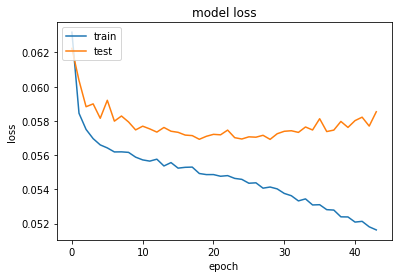

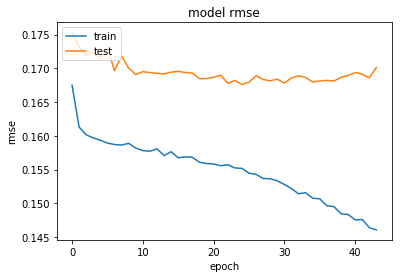

In [11]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['rmse'])
plt.plot(history.history['val_rmse'])
plt.title('model rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [12]:
def get_mae(Y1, Y2):
   return np.mean(np.absolute(Y1 - Y2))

def get_rmse(Y1, Y2):
    return np.sqrt(np.mean(np.square(Y1 - Y2)))

def get_smape(Y1, Y2):
    return 100 * np.mean(np.absolute(Y1 - Y2) / (np.absolute(Y2) + np.absolute(Y1)))

def get_mfe(Y_pred, Y_target):
    return np.mean(Y_pred - Y_target)

In [13]:
model.load_weights(experiment_name+'.hdf5')

In [14]:
#path_to_sensor_data_train = os.path.join(dir_path, "preprocessed_train")

val_gen_pred = data_generator_head_sal_seq2seq_reinject_output(path_to_sensor_data_train,
                                         file_names_val,
                                         delays_list,
                                         n_max_delay,
                                         n_lookback,
                                         n_delay,
                                         inference=True
                                        )

predictions_mae_val = np.zeros((len(file_names_val), 1+len_delay))
predictions_rmse_val = np.zeros((len(file_names_val), 1+len_delay))
predictions_smape_val = np.zeros((len(file_names_val), 1+len_delay))
predictions_mfe_val = np.zeros((len(file_names_val), 1+len_delay))


count = 0

start = time.time()
print("Evaluating validation data...")

for [encoder_input, decoder_input], Y_val_abs in val_gen_pred:
    #print(len(encoder_input))
    #input_seq = encoder_input[seq_index: seq_index + 1]
    Y_pred_diff = model.predict([encoder_input, decoder_input], verbose=0)
    
    # From normalized differences to absolute values
    Y_pred = np.zeros(Y_pred_diff.shape)
    for i in range(len_delay):
        Y_pred[:, i] = Y_val_abs[:,0] + np.sum(Y_pred_diff[:, :i+1], axis=1) * MAX_DIFF
        
    Y_val_abs = Y_val_abs[:, 1:]

    predictions_mae_val[count, 0] = get_mae(Y_pred, Y_val_abs)
    predictions_rmse_val[count, 0] = get_rmse(Y_pred, Y_val_abs)
    predictions_smape_val[count, 0] = get_smape(Y_pred, Y_val_abs)
    predictions_mfe_val[count, 0] = get_mfe(Y_pred, Y_val_abs)
    
    #print(Y_pred.shape)
    for ind_delay in range(0,len_delay):
        Y_delay_pred = Y_pred[: ,ind_delay]
        Y_delay_val = Y_val_abs[: ,ind_delay]
        
        predictions_mae_val[count, 1+ind_delay] = get_mae(Y_delay_pred, Y_delay_val)
        predictions_rmse_val[count, 1+ind_delay] = get_rmse(Y_delay_pred, Y_delay_val)
        predictions_smape_val[count, 1+ind_delay] = get_smape(Y_delay_pred, Y_delay_val)
        predictions_mfe_val[count, 1+ind_delay] = get_mfe(Y_delay_pred, Y_delay_val)
    
    count += 1
    if count == len(file_names_val):
        break

results_mae_val = np.mean(predictions_mae_val, axis=0)
results_rmse_val = np.mean(predictions_rmse_val, axis=0)
results_smape_val = np.mean(predictions_smape_val, axis=0)
results_mfe_val = np.mean(predictions_mfe_val, axis=0)

print("Evaluation Time : ", time.time() - start, "s = ", (time.time() - start)/60., "min = ",
      (time.time() - start)/3600., "h")

Evaluating validation data...


Evaluation Time :  72.33963418006897 s =  1.2056605815887451 min =  0.020094343092706468 h


## Evaluate performance on validation data to improve model

In [15]:
model.load_weights(experiment_name+'.hdf5')

## Evaluate metrics

In [16]:
print("MAE")
print("Average mae:", results_mae_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_mae_val[i+1])
print()    
print("RMSE")
print("Average rmse:", results_rmse_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_rmse_val[i+1])
print()    
print("SMAPE")
print("Average smape:", results_smape_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_smape_val[i+1])
print()
print("MFE")
print("Average mfe:", results_mfe_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_mfe_val[i+1])

MAE
Average mae: 0.05974849242036856
Delay 100 ms: 0.005172261451838462
Delay 200 ms: 0.013862655120838771
Delay 300 ms: 0.02534095595613657
Delay 400 ms: 0.038114312776368564
Delay 500 ms: 0.05155789085575285
Delay 600 ms: 0.06532000121002969
Delay 700 ms: 0.07918328882139437
Delay 800 ms: 0.09294478337488833
Delay 900 ms: 0.10643647765839631
Delay 1000 ms: 0.11955229697804183

RMSE
Average rmse: 0.12729184110623418
Delay 100 ms: 0.015188991998393042
Delay 200 ms: 0.031119966948747486
Delay 300 ms: 0.052025562473652906
Delay 400 ms: 0.07490442660432628
Delay 500 ms: 0.09833455303105676
Delay 600 ms: 0.12165628823629118
Delay 700 ms: 0.1445200590949452
Delay 800 ms: 0.16666229698780602
Delay 900 ms: 0.18795588432868182
Delay 1000 ms: 0.2082749672607275

SMAPE
Average smape: 13.12495484608858
Delay 100 ms: 2.278240203071372
Delay 200 ms: 4.961429644127462
Delay 300 ms: 7.724233280088561
Delay 400 ms: 10.284050912753717
Delay 500 ms: 12.65593328479744
Delay 600 ms: 14.855679711196515
Del

(6012, 25, 3) (6012, 10, 3)


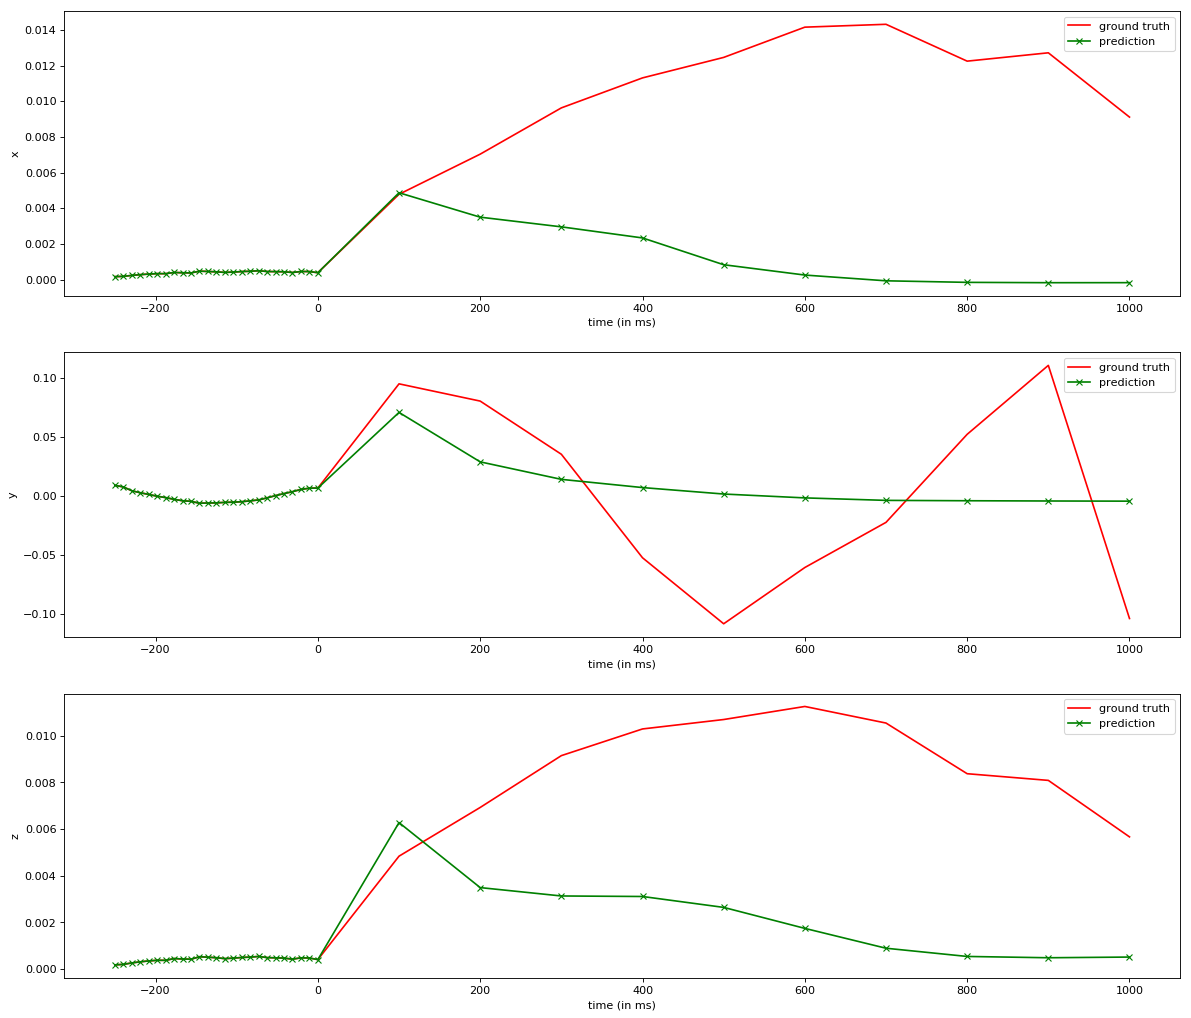

In [17]:
[encoder_input, decoder_input], Y_val = next(val_gen)
print(encoder_input.shape, Y_val.shape)
Y_pred = model.predict([encoder_input, decoder_input], verbose=0)

fig=plt.figure(figsize=(18, 16), dpi= 80)
plt.grid(True)
plt.axvline(x=0, c="b")
x_axis_pred = np.concatenate((np.linspace(-lookback, 0, num=n_lookback), np.linspace(step_delay, delays_list[-1], num=len(delays_list))))
time_sample = 700

plt.subplot(311)
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,0], Y_val[time_sample, :, 0])), label="ground truth", c='r')
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,0], Y_pred[time_sample, :, 0])), label="prediction", c='g', marker="x")
plt.ylabel("x")
plt.xlabel("time (in ms)")
plt.legend(loc='best')

plt.subplot(312)
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,1], Y_val[time_sample, :, 1])), label="ground truth", c='r')
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,1], Y_pred[time_sample, :, 1])), label="prediction", c='g', marker="x")
plt.ylabel("y")
plt.xlabel("time (in ms)")
plt.legend(loc='best')

plt.subplot(313)
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,2], Y_val[time_sample, :, 2])), label="ground truth", c='r')
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,2], Y_pred[time_sample, :, 2])), label="prediction", c='g', marker="x")
plt.ylabel("z")
plt.xlabel("time (in ms)")
plt.legend(loc='best')

## Evaluate performance on test data